In [1]:
# save the trained model
#PATH = './mymodel.pth'
#torch.save(clf.state_dict(), PATH)

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import json
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:

# Lee el archivo CSV
data = pd.read_csv('tfidf_matrix.csv')

# Visualiza las primeras filas del dataframe
# Dividir los datos en características (X) y etiquetas (y)
X = data.drop('cat_one_hot', axis=1)  # Eliminar la columna 'cat_one_hot' para obtener las características
etiquetas = []
y = data['cat_one_hot'].tolist()
for lista in y:
    vector = eval(lista)
    indice_maximo = vector.index(max(vector))
    etiquetas.append(indice_maximo)

labels = pd.DataFrame()
labels['label'] = etiquetas
print(labels)

      label
0         0
1         0
2         0
3         0
4         0
...     ...
7745      4
7746      4
7747      4
7748      4
7749      4

[7750 rows x 1 columns]


In [11]:
import time
# Definir la arquitectura de la red neuronal
class SimpleClassifier(nn.Module):
    def __init__(self,input_size,output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256,128)
        self.fc5 = nn.Linear(128,64)
        self.fc6 = nn.Linear(64, 5)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.5)  # Por ejemplo, con una probabilidad de dropout del 50%

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        x = self.softmax(x)
        return x.to(device)

def crear_directorio(nombre_carpeta):
    directorio_actual = os.getcwd()
    print("El directorio actual es:", directorio_actual)
    ruta_nueva_carpeta = os.path.join(directorio_actual, nombre_carpeta)
    # Verificar si la carpeta ya existe
    if not os.path.exists(ruta_nueva_carpeta):
        # Crear la carpeta si no existe
        os.mkdir(ruta_nueva_carpeta)
        print("Se creó la carpeta", nombre_carpeta, "en", directorio_actual)
    else:
        print("La carpeta", nombre_carpeta, "ya existe en", directorio_actual)

    ruta_modificada = ruta_nueva_carpeta.replace("\\","/")
    return ruta_modificada

def RNN_model(X,labels,test_size,epochs,lr):
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)
    X_train_values = X_train.values
    X_train_tensor = torch.tensor(X_train_values,dtype=torch.float32)
    y_train_values = y_train.values
    y_train_tensor = torch.tensor(y_train_values,dtype=torch.long)
    X_test_values = X_test.values
    X_test_tensor = torch.tensor(X_test_values,dtype=torch.float32)
    y_test_values = y_test.values
    y_test_tensor = torch.tensor(y_test_values,dtype=torch.long)
    y_train_tensor_flat = torch.tensor(y_train.values.flatten(), dtype=torch.long)
    output_size = 5
    # Crear un DataLoader para manejar los datos de entrenamiento
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor_flat)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    input_size = X_train_values[0].shape[0]
    
    # Instanciar el modelo y definir la función de pérdida y el optimizador
    model = SimpleClassifier(input_size,output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Entrenar el modelo
    losses = []
    sum_losses = 1
    #while sum_losses > error:
    for epoch in tqdm(range(epochs),desc="Procesando epocas: "):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Mover datos al dispositivo
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            #print(f"Valor de error:  {loss}")
            optimizer.step()
            running_loss += loss.item()
        sum_losses = running_loss / len(train_loader)
        print(sum_losses)
        losses.append(sum_losses)
    
    # Graficar el loss durante el entrenamiento
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    ruta_figura_incom = crear_directorio("Neural_network_classification")

    nombre_carpeta = f"RRN_{epochs}_{lr}_{test_size}"
    os.makedirs(os.path.join(ruta_figura_incom, nombre_carpeta), exist_ok=True)
    ruta_figura_incom = ruta_figura_incom + "/" + nombre_carpeta
    
    ruta_figura = f"{ruta_figura_incom}/funcion_de_perdida_{epochs}_{lr}.png"
    plt.savefig(ruta_figura)
    print("Matriz de confusión guardada en:", ruta_figura)
    plt.show()
    plt.show()
    
    # Evaluar el modelo en el conjunto de prueba
    with torch.no_grad():
        X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
        print('Test accuracy:', accuracy)
    
    predicted = predicted.cpu()  # Moviendo las predicciones a la CPU
    
    
    # Calcula las métricas
    accuracy = accuracy_score(y_test_tensor.cpu(), predicted.numpy())
    precision = precision_score(y_test, predicted.numpy(), average='macro', zero_division=0)
    recall = recall_score(y_test, predicted.numpy(), average='macro', zero_division=0)
    f1 = f1_score(y_test, predicted.numpy(), average='macro', zero_division=0)

    diccionario = {'accuracy':accuracy,'precision':precision,'recall':recall,'f1':f1}

    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1)
    print("\n")
    # Calcular métricas
    print('Classification Report:')
    print(classification_report(y_test, predicted.numpy()))
    reporte_clasificacion = classification_report(y_test, predicted.numpy(),output_dict = True)
    report_df = pd.DataFrame(reporte_clasificacion)
    print(report_df)
    # Calcular matriz de confusión
    conf_matrix = confusion_matrix(y_test, predicted.numpy())
    
    # Crear un mapa de calor para la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title('Matriz de Confusión')
    plt.xlabel('Etiquetas Predichas')
    plt.ylabel('Etiquetas Verdaderas')
    
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    ruta_figura_incom = crear_directorio("Neural_network_classification")
    
    nombre_carpeta = f"RRN_{epochs}_{lr}_{test_size}"
    os.makedirs(os.path.join(ruta_figura_incom, nombre_carpeta), exist_ok=True)
    ruta_figura_incom = ruta_figura_incom + "/" + nombre_carpeta
    
    ruta_figura = f"{ruta_figura_incom}/matriz_confusion_{epochs}_{lr}.png"
    plt.savefig(ruta_figura)
    print("Matriz de confusión guardada en:", ruta_figura)
    plt.show()

    res = f"/resultados_{epochs}_{lr}_{test_size}.json"
    res1 = f"/reporte_clasificacion_{epochs}_{lr}_{test_size}.csv"
    ruta_archivo_json = ruta_figura_incom + res
    ruta_archivo_json_report = ruta_figura_incom + res1

    # Guardar el diccionario como un archivo JSON
    with open(ruta_archivo_json, "w") as archivo_json:
        json.dump(diccionario, archivo_json)

    report_df.to_csv(ruta_archivo_json_report)
    
    print("Diccionario guardado como JSON en:", ruta_archivo_json)
    

In [12]:
print(labels)

      label
0         0
1         0
2         0
3         0
4         0
...     ...
7745      4
7746      4
7747      4
7748      4
7749      4

[7750 rows x 1 columns]


Procesando red con 700 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas:   0%|                                                               | 1/700 [00:02<31:16,  2.68s/it]

1.6093260351349326


Procesando epocas:   0%|▏                                                              | 2/700 [00:05<31:07,  2.68s/it]

1.5354340041384977


Procesando epocas:   0%|▎                                                              | 3/700 [00:08<30:57,  2.67s/it]

1.4108188509941102


Procesando epocas:   1%|▎                                                              | 4/700 [00:10<30:53,  2.66s/it]

1.344204811488881


Procesando epocas:   1%|▍                                                              | 5/700 [00:13<30:48,  2.66s/it]

1.290850196165197


Procesando epocas:   1%|▌                                                              | 6/700 [00:15<30:45,  2.66s/it]

1.2559184249709634


Procesando epocas:   1%|▋                                                              | 7/700 [00:18<30:42,  2.66s/it]

1.2278717882492962


Procesando epocas:   1%|▋                                                              | 8/700 [00:21<30:37,  2.66s/it]

1.2056001074173872


Procesando epocas:   1%|▊                                                              | 9/700 [00:23<30:33,  2.65s/it]

1.19508976094863


Procesando epocas:   1%|▉                                                             | 10/700 [00:26<30:27,  2.65s/it]

1.178726068314384


Procesando epocas:   2%|▉                                                             | 11/700 [00:29<30:26,  2.65s/it]

1.1706985179115743


Procesando epocas:   2%|█                                                             | 12/700 [00:31<30:24,  2.65s/it]

1.1604903115945704


Procesando epocas:   2%|█▏                                                            | 13/700 [00:34<30:23,  2.65s/it]

1.1520934679928947


Procesando epocas:   2%|█▏                                                            | 14/700 [00:37<30:23,  2.66s/it]

1.1329426590134115


Procesando epocas:   2%|█▎                                                            | 15/700 [00:39<30:17,  2.65s/it]

1.1234125032144435


Procesando epocas:   2%|█▍                                                            | 16/700 [00:42<30:10,  2.65s/it]

1.1068048501715941


Procesando epocas:   2%|█▌                                                            | 17/700 [00:45<30:05,  2.64s/it]

1.0951360246714423


Procesando epocas:   3%|█▌                                                            | 18/700 [00:47<30:01,  2.64s/it]

1.0871239651651943


Procesando epocas:   3%|█▋                                                            | 19/700 [00:50<29:58,  2.64s/it]

1.0716955090270324


Procesando epocas:   3%|█▊                                                            | 20/700 [00:53<29:55,  2.64s/it]

1.0644279413363513


Procesando epocas:   3%|█▊                                                            | 21/700 [00:55<29:52,  2.64s/it]

1.0582070420770084


Procesando epocas:   3%|█▉                                                            | 22/700 [00:58<29:50,  2.64s/it]

1.0563279849641463


Procesando epocas:   3%|██                                                            | 23/700 [01:00<29:45,  2.64s/it]

1.052641192253898


Procesando epocas:   3%|██▏                                                           | 24/700 [01:03<29:40,  2.63s/it]

1.0456387828378115


Procesando epocas:   4%|██▏                                                           | 25/700 [01:06<29:37,  2.63s/it]

1.0442748977857477


Procesando epocas:   4%|██▎                                                           | 26/700 [01:08<29:33,  2.63s/it]

1.0401980217765359


Procesando epocas:   4%|██▍                                                           | 27/700 [01:11<29:26,  2.62s/it]

1.0387792103430804


Procesando epocas:   4%|██▍                                                           | 28/700 [01:14<29:24,  2.63s/it]

1.033177887692171


Procesando epocas:   4%|██▌                                                           | 29/700 [01:16<29:24,  2.63s/it]

1.031600948642282


Procesando epocas:   4%|██▋                                                           | 30/700 [01:19<29:19,  2.63s/it]

1.0340265238986295


Procesando epocas:   4%|██▋                                                           | 31/700 [01:21<29:19,  2.63s/it]

1.0318446008598103


Procesando epocas:   5%|██▊                                                           | 32/700 [01:24<29:16,  2.63s/it]

1.0318013857392703


Procesando epocas:   5%|██▉                                                           | 33/700 [01:27<29:11,  2.63s/it]

1.03008152421783


Procesando epocas:   5%|███                                                           | 34/700 [01:29<29:10,  2.63s/it]

1.0347684404429267


Procesando epocas:   5%|███                                                           | 35/700 [01:32<29:06,  2.63s/it]

1.031797452884562


Procesando epocas:   5%|███▏                                                          | 36/700 [01:35<29:03,  2.63s/it]

1.029727240520365


Procesando epocas:   5%|███▎                                                          | 37/700 [01:37<29:01,  2.63s/it]

1.03206408199142


Procesando epocas:   5%|███▎                                                          | 38/700 [01:40<28:58,  2.63s/it]

1.0281155631822698


Procesando epocas:   6%|███▍                                                          | 39/700 [01:42<28:57,  2.63s/it]

1.025573845470653


Procesando epocas:   6%|███▌                                                          | 40/700 [01:45<28:56,  2.63s/it]

1.0215669965042788


Procesando epocas:   6%|███▋                                                          | 41/700 [01:48<28:53,  2.63s/it]

1.025146837795482


Procesando epocas:   6%|███▋                                                          | 42/700 [01:50<28:53,  2.63s/it]

1.0226479263866648


Procesando epocas:   6%|███▊                                                          | 43/700 [01:53<28:52,  2.64s/it]

1.0191487771623275


Procesando epocas:   6%|███▉                                                          | 44/700 [01:56<28:51,  2.64s/it]

1.0187510967254638


Procesando epocas:   6%|███▉                                                          | 45/700 [01:58<28:44,  2.63s/it]

1.021439822281108


Procesando epocas:   7%|████                                                          | 46/700 [02:01<28:42,  2.63s/it]

1.0218819930272944


Procesando epocas:   7%|████▏                                                         | 47/700 [02:04<28:37,  2.63s/it]

1.0227412223815917


Procesando epocas:   7%|████▎                                                         | 48/700 [02:06<28:33,  2.63s/it]

1.0242748078177957


Procesando epocas:   7%|████▎                                                         | 49/700 [02:09<28:31,  2.63s/it]

1.0207897308994742


Procesando epocas:   7%|████▍                                                         | 50/700 [02:11<28:27,  2.63s/it]

1.0236121728139764


Procesando epocas:   7%|████▌                                                         | 51/700 [02:14<28:22,  2.62s/it]

1.020873047323788


Procesando epocas:   7%|████▌                                                         | 52/700 [02:17<28:19,  2.62s/it]

1.0230882139766917


Procesando epocas:   8%|████▋                                                         | 53/700 [02:19<28:18,  2.62s/it]

1.0209110999808593


Procesando epocas:   8%|████▊                                                         | 54/700 [02:22<28:14,  2.62s/it]

1.0226122365278356


Procesando epocas:   8%|████▊                                                         | 55/700 [02:25<28:10,  2.62s/it]

1.0212044438895058


Procesando epocas:   8%|████▉                                                         | 56/700 [02:27<28:09,  2.62s/it]

1.0223511976354263


Procesando epocas:   8%|█████                                                         | 57/700 [02:30<28:04,  2.62s/it]

1.0196067603195416


Procesando epocas:   8%|█████▏                                                        | 58/700 [02:32<28:01,  2.62s/it]

1.0206098381210775


Procesando epocas:   8%|█████▏                                                        | 59/700 [02:35<28:00,  2.62s/it]

1.021239252651439


Procesando epocas:   9%|█████▎                                                        | 60/700 [02:38<27:56,  2.62s/it]

1.013777229715796


Procesando epocas:   9%|█████▍                                                        | 61/700 [02:40<27:55,  2.62s/it]

1.0121935336028829


Procesando epocas:   9%|█████▍                                                        | 62/700 [02:43<27:55,  2.63s/it]

1.0108843621085672


Procesando epocas:   9%|█████▌                                                        | 63/700 [02:46<27:51,  2.62s/it]

1.0132168538430157


Procesando epocas:   9%|█████▋                                                        | 64/700 [02:48<27:51,  2.63s/it]

1.011600843597861


Procesando epocas:   9%|█████▊                                                        | 65/700 [02:51<27:48,  2.63s/it]

1.011708817061256


Procesando epocas:   9%|█████▊                                                        | 66/700 [02:53<27:47,  2.63s/it]

1.0185211363960716


Procesando epocas:  10%|█████▉                                                        | 67/700 [02:56<27:45,  2.63s/it]

1.0201033991925856


Procesando epocas:  10%|██████                                                        | 68/700 [02:59<27:44,  2.63s/it]

1.0157509302391725


Procesando epocas:  10%|██████                                                        | 69/700 [03:01<27:42,  2.64s/it]

1.014320951349595


Procesando epocas:  10%|██████▏                                                       | 70/700 [03:04<27:39,  2.63s/it]

1.0089655413347132


Procesando epocas:  10%|██████▎                                                       | 71/700 [03:07<27:35,  2.63s/it]

1.0086401006754706


Procesando epocas:  10%|██████▍                                                       | 72/700 [03:09<27:32,  2.63s/it]

1.0085362185450162


Procesando epocas:  10%|██████▍                                                       | 73/700 [03:12<27:28,  2.63s/it]

1.0065986766534694


Procesando epocas:  11%|██████▌                                                       | 74/700 [03:14<27:25,  2.63s/it]

1.0113418042659759


Procesando epocas:  11%|██████▋                                                       | 75/700 [03:17<27:22,  2.63s/it]

1.0127443043624653


Procesando epocas:  11%|██████▋                                                       | 76/700 [03:20<27:19,  2.63s/it]

1.0099355613484102


Procesando epocas:  11%|██████▊                                                       | 77/700 [03:22<27:17,  2.63s/it]

1.007362696353127


Procesando epocas:  11%|██████▉                                                       | 78/700 [03:25<27:12,  2.62s/it]

1.0092917705283446


Procesando epocas:  11%|██████▉                                                       | 79/700 [03:28<27:05,  2.62s/it]

1.0081998898702509


Procesando epocas:  11%|███████                                                       | 80/700 [03:30<27:01,  2.62s/it]

1.0083202600479126


Procesando epocas:  12%|███████▏                                                      | 81/700 [03:33<27:01,  2.62s/it]

1.0062920822816737


Procesando epocas:  12%|███████▎                                                      | 82/700 [03:35<26:58,  2.62s/it]

1.0064058005809784


Procesando epocas:  12%|███████▎                                                      | 83/700 [03:38<26:56,  2.62s/it]

1.0063498377799989


Procesando epocas:  12%|███████▍                                                      | 84/700 [03:41<26:55,  2.62s/it]

1.003300431546043


Procesando epocas:  12%|███████▌                                                      | 85/700 [03:43<26:53,  2.62s/it]

1.0043669718153336


Procesando epocas:  12%|███████▌                                                      | 86/700 [03:46<26:50,  2.62s/it]

1.004841873926275


Procesando epocas:  12%|███████▋                                                      | 87/700 [03:49<26:47,  2.62s/it]

1.0048236857442294


Procesando epocas:  13%|███████▊                                                      | 88/700 [03:51<26:45,  2.62s/it]

1.0046904518323787


Procesando epocas:  13%|███████▉                                                      | 89/700 [03:54<26:42,  2.62s/it]

1.0042084010208354


Procesando epocas:  13%|███████▉                                                      | 90/700 [03:56<26:41,  2.62s/it]

1.008115980204414


Procesando epocas:  13%|████████                                                      | 91/700 [03:59<26:37,  2.62s/it]

1.0067371873294606


Procesando epocas:  13%|████████▏                                                     | 92/700 [04:02<26:36,  2.63s/it]

1.004182735260795


Procesando epocas:  13%|████████▏                                                     | 93/700 [04:04<26:33,  2.63s/it]

1.006676986287622


Procesando epocas:  13%|████████▎                                                     | 94/700 [04:07<26:30,  2.62s/it]

1.005320292711258


Procesando epocas:  14%|████████▍                                                     | 95/700 [04:10<26:26,  2.62s/it]

1.006966736386804


Procesando epocas:  14%|████████▌                                                     | 96/700 [04:12<26:24,  2.62s/it]

1.0060392481439253


Procesando epocas:  14%|████████▌                                                     | 97/700 [04:15<26:22,  2.62s/it]

1.0051228656488307


Procesando epocas:  14%|████████▋                                                     | 98/700 [04:17<26:21,  2.63s/it]

1.0027792141718024


Procesando epocas:  14%|████████▊                                                     | 99/700 [04:20<26:18,  2.63s/it]

1.0057207075988546


Procesando epocas:  14%|████████▋                                                    | 100/700 [04:23<26:16,  2.63s/it]

1.0059516335234922


Procesando epocas:  14%|████████▊                                                    | 101/700 [04:25<26:13,  2.63s/it]

1.0033120551530053


Procesando epocas:  15%|████████▉                                                    | 102/700 [04:28<26:11,  2.63s/it]

1.002088992735919


Procesando epocas:  15%|████████▉                                                    | 103/700 [04:31<26:04,  2.62s/it]

1.0005228579044343


Procesando epocas:  15%|█████████                                                    | 104/700 [04:33<25:59,  2.62s/it]

1.0027048023308025


Procesando epocas:  15%|█████████▏                                                   | 105/700 [04:36<25:57,  2.62s/it]

1.0033241170294145


Procesando epocas:  15%|█████████▏                                                   | 106/700 [04:38<25:53,  2.62s/it]

1.0007576097460353


Procesando epocas:  15%|█████████▎                                                   | 107/700 [04:41<25:49,  2.61s/it]

1.000275547364179


Procesando epocas:  15%|█████████▍                                                   | 108/700 [04:44<25:45,  2.61s/it]

1.005587048740948


Procesando epocas:  16%|█████████▍                                                   | 109/700 [04:46<25:43,  2.61s/it]

1.0035269782823675


Procesando epocas:  16%|█████████▌                                                   | 110/700 [04:49<25:39,  2.61s/it]

1.0020974751781015


Procesando epocas:  16%|█████████▋                                                   | 111/700 [04:51<25:40,  2.62s/it]

1.0026870366405038


Procesando epocas:  16%|█████████▊                                                   | 112/700 [04:54<25:46,  2.63s/it]

1.004469551408992


Procesando epocas:  16%|█████████▊                                                   | 113/700 [04:57<25:45,  2.63s/it]

1.003000288851121


Procesando epocas:  16%|█████████▉                                                   | 114/700 [04:59<25:44,  2.64s/it]

1.002709451493095


Procesando epocas:  16%|██████████                                                   | 115/700 [05:02<25:43,  2.64s/it]

1.0044087416985457


Procesando epocas:  17%|██████████                                                   | 116/700 [05:05<25:42,  2.64s/it]

1.0045397015178905


Procesando epocas:  17%|██████████▏                                                  | 117/700 [05:07<25:40,  2.64s/it]

1.0033107270212736


Procesando epocas:  17%|██████████▎                                                  | 118/700 [05:10<25:38,  2.64s/it]

1.0035239275764016


Procesando epocas:  17%|██████████▎                                                  | 119/700 [05:13<25:35,  2.64s/it]

1.0019675605437335


Procesando epocas:  17%|██████████▍                                                  | 120/700 [05:15<25:34,  2.65s/it]

1.0002029338303735


Procesando epocas:  17%|██████████▌                                                  | 121/700 [05:18<25:37,  2.66s/it]

1.0013938847710104


Procesando epocas:  17%|██████████▋                                                  | 122/700 [05:21<25:38,  2.66s/it]

1.0071328352479374


Procesando epocas:  18%|██████████▋                                                  | 123/700 [05:23<25:38,  2.67s/it]

1.0004802304155687


Procesando epocas:  18%|██████████▊                                                  | 124/700 [05:26<25:35,  2.67s/it]

1.0062021181863896


Procesando epocas:  18%|██████████▉                                                  | 125/700 [05:29<25:34,  2.67s/it]

1.0004356861114503


Procesando epocas:  18%|██████████▉                                                  | 126/700 [05:31<25:35,  2.68s/it]

1.002819618056802


Procesando epocas:  18%|███████████                                                  | 127/700 [05:34<25:33,  2.68s/it]

1.002466149891124


Procesando epocas:  18%|███████████▏                                                 | 128/700 [05:37<25:29,  2.67s/it]

1.0048656190142913


Procesando epocas:  18%|███████████▏                                                 | 129/700 [05:39<25:27,  2.68s/it]

1.0034795140518862


Procesando epocas:  19%|███████████▎                                                 | 130/700 [05:42<25:27,  2.68s/it]

1.0007943265578325


Procesando epocas:  19%|███████████▍                                                 | 131/700 [05:45<25:22,  2.68s/it]

1.0020327673238867


Procesando epocas:  19%|███████████▌                                                 | 132/700 [05:47<25:15,  2.67s/it]

1.00415299745167


Procesando epocas:  19%|███████████▌                                                 | 133/700 [05:50<25:13,  2.67s/it]

1.00161052626722


Procesando epocas:  19%|███████████▋                                                 | 134/700 [05:53<25:12,  2.67s/it]

1.0032343317480648


Procesando epocas:  19%|███████████▊                                                 | 135/700 [05:55<25:12,  2.68s/it]

1.0004534391795887


Procesando epocas:  19%|███████████▊                                                 | 136/700 [05:58<25:07,  2.67s/it]

0.9984859943389892


Procesando epocas:  20%|███████████▉                                                 | 137/700 [06:01<25:02,  2.67s/it]

0.9979722419205834


Procesando epocas:  20%|████████████                                                 | 138/700 [06:03<25:01,  2.67s/it]

0.9972529527019052


Procesando epocas:  20%|████████████                                                 | 139/700 [06:06<24:58,  2.67s/it]

1.0001930892467499


Procesando epocas:  20%|████████████▏                                                | 140/700 [06:09<24:56,  2.67s/it]

0.9977162981734556


Procesando epocas:  20%|████████████▎                                                | 141/700 [06:11<24:54,  2.67s/it]

1.002555046712651


Procesando epocas:  20%|████████████▎                                                | 142/700 [06:14<24:54,  2.68s/it]

1.0015646341968985


Procesando epocas:  20%|████████████▍                                                | 143/700 [06:17<24:49,  2.67s/it]

1.000885344954098


Procesando epocas:  21%|████████████▌                                                | 144/700 [06:19<24:40,  2.66s/it]

1.0007869734483608


Procesando epocas:  21%|████████████▋                                                | 145/700 [06:22<24:35,  2.66s/it]

0.9981731130796321


Procesando epocas:  21%|████████████▋                                                | 146/700 [06:25<24:29,  2.65s/it]

1.0032230314086465


Procesando epocas:  21%|████████████▊                                                | 147/700 [06:27<24:22,  2.65s/it]

0.9963049162836636


Procesando epocas:  21%|████████████▉                                                | 148/700 [06:30<24:18,  2.64s/it]

0.9940423804170945


Procesando epocas:  21%|████████████▉                                                | 149/700 [06:33<24:17,  2.65s/it]

0.9953459729166592


Procesando epocas:  21%|█████████████                                                | 150/700 [06:35<24:11,  2.64s/it]

0.9954446087865269


Procesando epocas:  22%|█████████████▏                                               | 151/700 [06:38<24:09,  2.64s/it]

0.9955971258528092


Procesando epocas:  22%|█████████████▏                                               | 152/700 [06:41<24:07,  2.64s/it]

0.99735828462769


Procesando epocas:  22%|█████████████▎                                               | 153/700 [06:43<24:07,  2.65s/it]

0.997597513479345


Procesando epocas:  22%|█████████████▍                                               | 154/700 [06:46<24:02,  2.64s/it]

0.9968972258708056


Procesando epocas:  22%|█████████████▌                                               | 155/700 [06:48<23:59,  2.64s/it]

0.9980037002002492


Procesando epocas:  22%|█████████████▌                                               | 156/700 [06:51<23:57,  2.64s/it]

0.9964560066952425


Procesando epocas:  22%|█████████████▋                                               | 157/700 [06:54<23:56,  2.65s/it]

0.9979855649611529


Procesando epocas:  23%|█████████████▊                                               | 158/700 [06:56<23:50,  2.64s/it]

0.9982276790282305


Procesando epocas:  23%|█████████████▊                                               | 159/700 [06:59<23:46,  2.64s/it]

0.9969768187578987


Procesando epocas:  23%|█████████████▉                                               | 160/700 [07:02<23:45,  2.64s/it]

0.9957642755087684


Procesando epocas:  23%|██████████████                                               | 161/700 [07:04<23:44,  2.64s/it]

1.0015842283473295


Procesando epocas:  23%|██████████████                                               | 162/700 [07:07<23:41,  2.64s/it]

0.9977607390459846


Procesando epocas:  23%|██████████████▏                                              | 163/700 [07:10<23:39,  2.64s/it]

0.9984264706864077


Procesando epocas:  23%|██████████████▎                                              | 164/700 [07:12<23:35,  2.64s/it]

1.0005935847759246


Procesando epocas:  24%|██████████████▍                                              | 165/700 [07:15<23:32,  2.64s/it]

0.9980980206938351


Procesando epocas:  24%|██████████████▍                                              | 166/700 [07:18<23:29,  2.64s/it]

0.9975193251581753


Procesando epocas:  24%|██████████████▌                                              | 167/700 [07:20<23:28,  2.64s/it]

0.9996055792359745


Procesando epocas:  24%|██████████████▋                                              | 168/700 [07:23<23:26,  2.64s/it]

0.9970920871285831


Procesando epocas:  24%|██████████████▋                                              | 169/700 [07:25<23:23,  2.64s/it]

0.9952356885461247


Procesando epocas:  24%|██████████████▊                                              | 170/700 [07:28<23:19,  2.64s/it]

0.9968848281046924


Procesando epocas:  24%|██████████████▉                                              | 171/700 [07:31<23:16,  2.64s/it]

0.9969279247171738


Procesando epocas:  25%|██████████████▉                                              | 172/700 [07:33<23:14,  2.64s/it]

0.9954120145124548


Procesando epocas:  25%|███████████████                                              | 173/700 [07:36<23:10,  2.64s/it]

0.9960596768295064


Procesando epocas:  25%|███████████████▏                                             | 174/700 [07:39<23:07,  2.64s/it]

0.9931009594131919


Procesando epocas:  25%|███████████████▎                                             | 175/700 [07:41<23:03,  2.63s/it]

0.9948879624114317


Procesando epocas:  25%|███████████████▎                                             | 176/700 [07:44<22:59,  2.63s/it]

0.9921391469590805


Procesando epocas:  25%|███████████████▍                                             | 177/700 [07:47<22:55,  2.63s/it]

0.9950332178789026


Procesando epocas:  25%|███████████████▌                                             | 178/700 [07:49<22:51,  2.63s/it]

0.9954681547249065


Procesando epocas:  26%|███████████████▌                                             | 179/700 [07:52<22:49,  2.63s/it]

0.9928863718229182


Procesando epocas:  26%|███████████████▋                                             | 180/700 [07:54<22:47,  2.63s/it]

0.9933757876648622


Procesando epocas:  26%|███████████████▊                                             | 181/700 [07:57<22:44,  2.63s/it]

0.9949950091979083


Procesando epocas:  26%|███████████████▊                                             | 182/700 [08:00<22:41,  2.63s/it]

0.993274483610602


Procesando epocas:  26%|███████████████▉                                             | 183/700 [08:02<22:37,  2.63s/it]

0.9951506001107833


Procesando epocas:  26%|████████████████                                             | 184/700 [08:05<22:32,  2.62s/it]

0.9953267854802749


Procesando epocas:  26%|████████████████                                             | 185/700 [08:08<22:29,  2.62s/it]

0.9950149017221788


Procesando epocas:  27%|████████████████▏                                            | 186/700 [08:10<22:29,  2.62s/it]

0.9941608755027547


Procesando epocas:  27%|████████████████▎                                            | 187/700 [08:13<22:25,  2.62s/it]

0.9922146436046152


Procesando epocas:  27%|████████████████▍                                            | 188/700 [08:15<22:23,  2.62s/it]

0.9915389050455654


Procesando epocas:  27%|████████████████▍                                            | 189/700 [08:18<22:21,  2.62s/it]

0.9921849983579972


Procesando epocas:  27%|████████████████▌                                            | 190/700 [08:21<22:16,  2.62s/it]

0.9909096556551317


Procesando epocas:  27%|████████████████▋                                            | 191/700 [08:23<22:14,  2.62s/it]

0.990533834695816


Procesando epocas:  27%|████████████████▋                                            | 192/700 [08:26<22:11,  2.62s/it]

0.9912951374755187


Procesando epocas:  28%|████████████████▊                                            | 193/700 [08:28<22:07,  2.62s/it]

0.9900596127790563


Procesando epocas:  28%|████████████████▉                                            | 194/700 [08:31<22:05,  2.62s/it]

0.9919895946979522


Procesando epocas:  28%|████████████████▉                                            | 195/700 [08:34<22:03,  2.62s/it]

0.9917418416808633


Procesando epocas:  28%|█████████████████                                            | 196/700 [08:36<22:03,  2.63s/it]

0.9961826524313758


Procesando epocas:  28%|█████████████████▏                                           | 197/700 [08:39<22:01,  2.63s/it]

0.9998676857527564


Procesando epocas:  28%|█████████████████▎                                           | 198/700 [08:42<21:58,  2.63s/it]

0.9954043647822212


Procesando epocas:  28%|█████████████████▎                                           | 199/700 [08:44<21:55,  2.63s/it]

0.9927706146941465


Procesando epocas:  29%|█████████████████▍                                           | 200/700 [08:47<21:54,  2.63s/it]

0.9950948536396027


Procesando epocas:  29%|█████████████████▌                                           | 201/700 [08:50<21:53,  2.63s/it]

0.9916389086667229


Procesando epocas:  29%|█████████████████▌                                           | 202/700 [08:52<21:51,  2.63s/it]

0.9933365772752201


Procesando epocas:  29%|█████████████████▋                                           | 203/700 [08:55<21:49,  2.63s/it]

0.9911131048903746


Procesando epocas:  29%|█████████████████▊                                           | 204/700 [08:57<21:44,  2.63s/it]

0.9902901274316451


Procesando epocas:  29%|█████████████████▊                                           | 205/700 [09:00<21:42,  2.63s/it]

0.9884889076737796


Procesando epocas:  29%|█████████████████▉                                           | 206/700 [09:03<21:37,  2.63s/it]

0.9900457434794482


Procesando epocas:  30%|██████████████████                                           | 207/700 [09:05<21:33,  2.62s/it]

0.9892808321644279


Procesando epocas:  30%|██████████████████▏                                          | 208/700 [09:08<21:32,  2.63s/it]

0.9901082378976486


Procesando epocas:  30%|██████████████████▏                                          | 209/700 [09:11<21:27,  2.62s/it]

0.9893647334154915


Procesando epocas:  30%|██████████████████▎                                          | 210/700 [09:13<21:25,  2.62s/it]

0.9909621340387008


Procesando epocas:  30%|██████████████████▍                                          | 211/700 [09:16<21:21,  2.62s/it]

0.990884067030514


Procesando epocas:  30%|██████████████████▍                                          | 212/700 [09:18<21:17,  2.62s/it]

0.990146431502174


Procesando epocas:  30%|██████████████████▌                                          | 213/700 [09:21<21:14,  2.62s/it]

0.9916406140607946


Procesando epocas:  31%|██████████████████▋                                          | 214/700 [09:24<21:11,  2.62s/it]

0.9937860692248625


Procesando epocas:  31%|██████████████████▋                                          | 215/700 [09:26<21:07,  2.61s/it]

0.9940357618472155


Procesando epocas:  31%|██████████████████▊                                          | 216/700 [09:29<21:04,  2.61s/it]

0.994520024692311


Procesando epocas:  31%|██████████████████▉                                          | 217/700 [09:31<21:01,  2.61s/it]

0.9953650218598983


Procesando epocas:  31%|██████████████████▉                                          | 218/700 [09:34<20:59,  2.61s/it]

0.9927550754126381


Procesando epocas:  31%|███████████████████                                          | 219/700 [09:37<20:56,  2.61s/it]

0.9923754110055811


Procesando epocas:  31%|███████████████████▏                                         | 220/700 [09:39<20:54,  2.61s/it]

0.9951261327547185


Procesando epocas:  32%|███████████████████▎                                         | 221/700 [09:42<20:51,  2.61s/it]

0.9913858245400822


Procesando epocas:  32%|███████████████████▎                                         | 222/700 [09:45<20:50,  2.62s/it]

0.9936829023501452


Procesando epocas:  32%|███████████████████▍                                         | 223/700 [09:47<20:48,  2.62s/it]

0.9913068385685191


Procesando epocas:  32%|███████████████████▌                                         | 224/700 [09:50<20:47,  2.62s/it]

0.9915254252798417


Procesando epocas:  32%|███████████████████▌                                         | 225/700 [09:52<20:44,  2.62s/it]

0.9898278401178472


Procesando epocas:  32%|███████████████████▋                                         | 226/700 [09:55<20:44,  2.63s/it]

0.990807175285676


Procesando epocas:  32%|███████████████████▊                                         | 227/700 [09:58<20:40,  2.62s/it]

0.990004292305778


Procesando epocas:  33%|███████████████████▊                                         | 228/700 [10:00<20:38,  2.62s/it]

0.9915977302719565


Procesando epocas:  33%|███████████████████▉                                         | 229/700 [10:03<20:35,  2.62s/it]

0.988744739223929


Procesando epocas:  33%|████████████████████                                         | 230/700 [10:05<20:32,  2.62s/it]

0.9894143160651712


Procesando epocas:  33%|████████████████████▏                                        | 231/700 [10:08<20:29,  2.62s/it]

0.985843307130477


Procesando epocas:  33%|████████████████████▏                                        | 232/700 [10:11<20:27,  2.62s/it]

0.9837404822601992


Procesando epocas:  33%|████████████████████▎                                        | 233/700 [10:13<20:24,  2.62s/it]

0.9839404193794026


Procesando epocas:  33%|████████████████████▍                                        | 234/700 [10:16<20:20,  2.62s/it]

0.9833066396853503


Procesando epocas:  34%|████████████████████▍                                        | 235/700 [10:19<20:17,  2.62s/it]

0.9853787716697244


Procesando epocas:  34%|████████████████████▌                                        | 236/700 [10:21<20:14,  2.62s/it]

0.9847120302564958


Procesando epocas:  34%|████████████████████▋                                        | 237/700 [10:24<20:18,  2.63s/it]

0.9854578414384056


Procesando epocas:  34%|████████████████████▋                                        | 238/700 [10:27<20:23,  2.65s/it]

0.9836417156107286


Procesando epocas:  34%|████████████████████▊                                        | 239/700 [10:29<20:24,  2.66s/it]

0.9868621479062473


Procesando epocas:  34%|████████████████████▉                                        | 240/700 [10:32<20:24,  2.66s/it]

0.9876424175851485


Procesando epocas:  34%|█████████████████████                                        | 241/700 [10:35<20:21,  2.66s/it]

0.9847899314235239


Procesando epocas:  35%|█████████████████████                                        | 242/700 [10:37<20:18,  2.66s/it]

0.9850870241137112


Procesando epocas:  35%|█████████████████████▏                                       | 243/700 [10:40<20:17,  2.66s/it]

0.9880188486155341


Procesando epocas:  35%|█████████████████████▎                                       | 244/700 [10:43<20:15,  2.67s/it]

0.9873770552522996


Procesando epocas:  35%|█████████████████████▎                                       | 245/700 [10:45<20:13,  2.67s/it]

0.9857756029157078


Procesando epocas:  35%|█████████████████████▍                                       | 246/700 [10:48<20:09,  2.66s/it]

0.9858322837773491


Procesando epocas:  35%|█████████████████████▌                                       | 247/700 [10:51<20:05,  2.66s/it]

0.9859320875476388


Procesando epocas:  35%|█████████████████████▌                                       | 248/700 [10:53<20:04,  2.67s/it]

0.9823819826630985


Procesando epocas:  36%|█████████████████████▋                                       | 249/700 [10:56<20:03,  2.67s/it]

0.9875815721119151


Procesando epocas:  36%|█████████████████████▊                                       | 250/700 [10:59<20:01,  2.67s/it]

0.9832996280754314


Procesando epocas:  36%|█████████████████████▊                                       | 251/700 [11:01<19:57,  2.67s/it]

0.9857490160885979


Procesando epocas:  36%|█████████████████████▉                                       | 252/700 [11:04<19:52,  2.66s/it]

0.9850544098545523


Procesando epocas:  36%|██████████████████████                                       | 253/700 [11:07<19:49,  2.66s/it]

0.9847397639470942


Procesando epocas:  36%|██████████████████████▏                                      | 254/700 [11:09<19:46,  2.66s/it]

0.9855741343077491


Procesando epocas:  36%|██████████████████████▏                                      | 255/700 [11:12<19:44,  2.66s/it]

0.9844483540338629


Procesando epocas:  37%|██████████████████████▎                                      | 256/700 [11:15<19:41,  2.66s/it]

0.9860664297552669


Procesando epocas:  37%|██████████████████████▍                                      | 257/700 [11:17<19:38,  2.66s/it]

0.986249379901325


Procesando epocas:  37%|██████████████████████▍                                      | 258/700 [11:20<19:37,  2.66s/it]

0.9845937886658837


Procesando epocas:  37%|██████████████████████▌                                      | 259/700 [11:23<19:33,  2.66s/it]

0.9871012540424571


Procesando epocas:  37%|██████████████████████▋                                      | 260/700 [11:25<19:29,  2.66s/it]

0.9877825281199287


Procesando epocas:  37%|██████████████████████▋                                      | 261/700 [11:28<19:23,  2.65s/it]

0.9852298592819887


Procesando epocas:  37%|██████████████████████▊                                      | 262/700 [11:30<19:19,  2.65s/it]

0.9843528372399947


Procesando epocas:  38%|██████████████████████▉                                      | 263/700 [11:33<19:17,  2.65s/it]

0.9836751699447632


Procesando epocas:  38%|███████████████████████                                      | 264/700 [11:36<19:15,  2.65s/it]

0.9840414944817039


Procesando epocas:  38%|███████████████████████                                      | 265/700 [11:38<19:10,  2.65s/it]

0.9840499141637017


Procesando epocas:  38%|███████████████████████▏                                     | 266/700 [11:41<19:07,  2.64s/it]

0.9823916919091169


Procesando epocas:  38%|███████████████████████▎                                     | 267/700 [11:44<19:04,  2.64s/it]

0.981722236030242


Procesando epocas:  38%|███████████████████████▎                                     | 268/700 [11:46<19:02,  2.64s/it]

0.9812655855627621


Procesando epocas:  38%|███████████████████████▍                                     | 269/700 [11:49<19:01,  2.65s/it]

0.9818427429479711


Procesando epocas:  39%|███████████████████████▌                                     | 270/700 [11:52<18:56,  2.64s/it]

0.9813114913070903


Procesando epocas:  39%|███████████████████████▌                                     | 271/700 [11:54<18:53,  2.64s/it]

0.9817238919875201


Procesando epocas:  39%|███████████████████████▋                                     | 272/700 [11:57<18:48,  2.64s/it]

0.9826436337302713


Procesando epocas:  39%|███████████████████████▊                                     | 273/700 [11:59<18:45,  2.64s/it]

0.9871155142784118


Procesando epocas:  39%|███████████████████████▉                                     | 274/700 [12:02<18:41,  2.63s/it]

0.985470794579562


Procesando epocas:  39%|███████████████████████▉                                     | 275/700 [12:05<18:38,  2.63s/it]

0.9819260600735159


Procesando epocas:  39%|████████████████████████                                     | 276/700 [12:07<18:35,  2.63s/it]

0.9831470612217398


Procesando epocas:  40%|████████████████████████▏                                    | 277/700 [12:10<18:33,  2.63s/it]

0.9845644491560319


Procesando epocas:  40%|████████████████████████▏                                    | 278/700 [12:13<18:31,  2.63s/it]

0.9847222836578593


Procesando epocas:  40%|████████████████████████▎                                    | 279/700 [12:15<18:31,  2.64s/it]

0.9851956549812766


Procesando epocas:  40%|████████████████████████▍                                    | 280/700 [12:18<18:28,  2.64s/it]

0.9844074165119844


Procesando epocas:  40%|████████████████████████▍                                    | 281/700 [12:21<18:26,  2.64s/it]

0.9873362194089329


Procesando epocas:  40%|████████████████████████▌                                    | 282/700 [12:23<18:24,  2.64s/it]

0.9853294554878683


Procesando epocas:  40%|████████████████████████▋                                    | 283/700 [12:26<18:21,  2.64s/it]

0.9833605829407187


Procesando epocas:  41%|████████████████████████▋                                    | 284/700 [12:29<18:19,  2.64s/it]

0.9833654084626366


Procesando epocas:  41%|████████████████████████▊                                    | 285/700 [12:31<18:17,  2.65s/it]

0.9814470662790187


Procesando epocas:  41%|████████████████████████▉                                    | 286/700 [12:34<18:13,  2.64s/it]

0.9801976165350745


Procesando epocas:  41%|█████████████████████████                                    | 287/700 [12:36<18:11,  2.64s/it]

0.9811840909368852


Procesando epocas:  41%|█████████████████████████                                    | 288/700 [12:39<18:09,  2.64s/it]

0.9805534650297726


Procesando epocas:  41%|█████████████████████████▏                                   | 289/700 [12:42<18:05,  2.64s/it]

0.9813132093233221


Procesando epocas:  41%|█████████████████████████▎                                   | 290/700 [12:44<18:04,  2.64s/it]

0.9811094066675972


Procesando epocas:  42%|█████████████████████████▎                                   | 291/700 [12:47<18:00,  2.64s/it]

0.9805648544255425


Procesando epocas:  42%|█████████████████████████▍                                   | 292/700 [12:50<17:56,  2.64s/it]

0.9811686778769774


Procesando epocas:  42%|█████████████████████████▌                                   | 293/700 [12:52<17:55,  2.64s/it]

0.9815911899594699


Procesando epocas:  42%|█████████████████████████▌                                   | 294/700 [12:55<17:53,  2.64s/it]

0.9821431826142704


Procesando epocas:  42%|█████████████████████████▋                                   | 295/700 [12:58<17:49,  2.64s/it]

0.9828898952287786


Procesando epocas:  42%|█████████████████████████▊                                   | 296/700 [13:00<17:47,  2.64s/it]

0.982407951004365


Procesando epocas:  42%|█████████████████████████▉                                   | 297/700 [13:03<17:46,  2.65s/it]

0.9831193562816171


Procesando epocas:  43%|█████████████████████████▉                                   | 298/700 [13:06<17:42,  2.64s/it]

0.9811727394075954


Procesando epocas:  43%|██████████████████████████                                   | 299/700 [13:08<17:38,  2.64s/it]

0.9830901110873503


Procesando epocas:  43%|██████████████████████████▏                                  | 300/700 [13:11<17:35,  2.64s/it]

0.9816551008645226


Procesando epocas:  43%|██████████████████████████▏                                  | 301/700 [13:13<17:32,  2.64s/it]

0.9836956143379212


Procesando epocas:  43%|██████████████████████████▎                                  | 302/700 [13:16<17:30,  2.64s/it]

0.982399591628243


Procesando epocas:  43%|██████████████████████████▍                                  | 303/700 [13:19<17:27,  2.64s/it]

0.9833849475664251


Procesando epocas:  43%|██████████████████████████▍                                  | 304/700 [13:21<17:25,  2.64s/it]

0.9863371368716745


Procesando epocas:  44%|██████████████████████████▌                                  | 305/700 [13:24<17:22,  2.64s/it]

0.9831851952216204


Procesando epocas:  44%|██████████████████████████▋                                  | 306/700 [13:27<17:19,  2.64s/it]

0.9829643186400918


Procesando epocas:  44%|██████████████████████████▊                                  | 307/700 [13:29<17:16,  2.64s/it]

0.9821409509462469


Procesando epocas:  44%|██████████████████████████▊                                  | 308/700 [13:32<17:13,  2.64s/it]

0.9803032703259412


Procesando epocas:  44%|██████████████████████████▉                                  | 309/700 [13:35<17:10,  2.64s/it]

0.9809676240472233


Procesando epocas:  44%|███████████████████████████                                  | 310/700 [13:37<17:09,  2.64s/it]

0.9824055380680982


Procesando epocas:  44%|███████████████████████████                                  | 311/700 [13:40<17:06,  2.64s/it]

0.9805939797092886


Procesando epocas:  45%|███████████████████████████▏                                 | 312/700 [13:42<17:04,  2.64s/it]

0.980087819520165


Procesando epocas:  45%|███████████████████████████▎                                 | 313/700 [13:45<17:02,  2.64s/it]

0.9839722514152527


Procesando epocas:  45%|███████████████████████████▎                                 | 314/700 [13:48<17:00,  2.64s/it]

0.978500570269192


Procesando epocas:  45%|███████████████████████████▍                                 | 315/700 [13:50<16:56,  2.64s/it]

0.9821247300680946


Procesando epocas:  45%|███████████████████████████▌                                 | 316/700 [13:53<16:53,  2.64s/it]

0.97917039920302


Procesando epocas:  45%|███████████████████████████▌                                 | 317/700 [13:56<16:53,  2.65s/it]

0.9819813815986409


Procesando epocas:  45%|███████████████████████████▋                                 | 318/700 [13:58<16:48,  2.64s/it]

0.9789727891192717


Procesando epocas:  46%|███████████████████████████▊                                 | 319/700 [14:01<16:45,  2.64s/it]

0.9779899856623482


Procesando epocas:  46%|███████████████████████████▉                                 | 320/700 [14:04<16:41,  2.64s/it]

0.9766929444144754


Procesando epocas:  46%|███████████████████████████▉                                 | 321/700 [14:06<16:38,  2.63s/it]

0.9787652815089506


Procesando epocas:  46%|████████████████████████████                                 | 322/700 [14:09<16:35,  2.63s/it]

0.9780678335358115


Procesando epocas:  46%|████████████████████████████▏                                | 323/700 [14:11<16:32,  2.63s/it]

0.9779412472949308


Procesando epocas:  46%|████████████████████████████▏                                | 324/700 [14:14<16:29,  2.63s/it]

0.9806206752272213


Procesando epocas:  46%|████████████████████████████▎                                | 325/700 [14:17<16:26,  2.63s/it]

0.9796860021703383


Procesando epocas:  47%|████████████████████████████▍                                | 326/700 [14:19<16:24,  2.63s/it]

0.9840912471799289


Procesando epocas:  47%|████████████████████████████▍                                | 327/700 [14:22<16:20,  2.63s/it]

0.9790374359663795


Procesando epocas:  47%|████████████████████████████▌                                | 328/700 [14:25<16:18,  2.63s/it]

0.9788194537162781


Procesando epocas:  47%|████████████████████████████▋                                | 329/700 [14:27<16:16,  2.63s/it]

0.9762856276596293


Procesando epocas:  47%|████████████████████████████▊                                | 330/700 [14:30<16:14,  2.63s/it]

0.9789190215222976


Procesando epocas:  47%|████████████████████████████▊                                | 331/700 [14:33<16:12,  2.63s/it]

0.9785288460114423


Procesando epocas:  47%|████████████████████████████▉                                | 332/700 [14:35<16:08,  2.63s/it]

0.9760197779711555


Procesando epocas:  48%|█████████████████████████████                                | 333/700 [14:38<16:05,  2.63s/it]

0.9777440207846024


Procesando epocas:  48%|█████████████████████████████                                | 334/700 [14:40<16:03,  2.63s/it]

0.9787276001537547


Procesando epocas:  48%|█████████████████████████████▏                               | 335/700 [14:43<16:01,  2.63s/it]

0.9774625609902775


Procesando epocas:  48%|█████████████████████████████▎                               | 336/700 [14:46<15:58,  2.63s/it]

0.9803441237000858


Procesando epocas:  48%|█████████████████████████████▎                               | 337/700 [14:48<15:56,  2.63s/it]

0.976363330378252


Procesando epocas:  48%|█████████████████████████████▍                               | 338/700 [14:51<15:53,  2.63s/it]

0.9767485299531151


Procesando epocas:  48%|█████████████████████████████▌                               | 339/700 [14:54<15:50,  2.63s/it]

0.9749195677392622


Procesando epocas:  49%|█████████████████████████████▋                               | 340/700 [14:56<15:43,  2.62s/it]

0.9767827601993785


Procesando epocas:  49%|█████████████████████████████▋                               | 341/700 [14:59<15:39,  2.62s/it]

0.9765405714511871


Procesando epocas:  49%|█████████████████████████████▊                               | 342/700 [15:01<15:35,  2.61s/it]

0.9785568752709557


Procesando epocas:  49%|█████████████████████████████▉                               | 343/700 [15:04<15:33,  2.61s/it]

0.9777173701454611


Procesando epocas:  49%|█████████████████████████████▉                               | 344/700 [15:07<15:29,  2.61s/it]

0.9758617650060093


Procesando epocas:  49%|██████████████████████████████                               | 345/700 [15:09<15:27,  2.61s/it]

0.9790440019439248


Procesando epocas:  49%|██████████████████████████████▏                              | 346/700 [15:12<15:24,  2.61s/it]

0.979246275915819


Procesando epocas:  50%|██████████████████████████████▏                              | 347/700 [15:14<15:22,  2.61s/it]

0.977799459064708


Procesando epocas:  50%|██████████████████████████████▎                              | 348/700 [15:17<15:20,  2.62s/it]

0.9801010878647075


Procesando epocas:  50%|██████████████████████████████▍                              | 349/700 [15:20<15:15,  2.61s/it]

0.9775458567282733


Procesando epocas:  50%|██████████████████████████████▌                              | 350/700 [15:22<15:13,  2.61s/it]

0.9763891037772684


Procesando epocas:  50%|██████████████████████████████▌                              | 351/700 [15:25<15:11,  2.61s/it]

0.9756676624802982


Procesando epocas:  50%|██████████████████████████████▋                              | 352/700 [15:28<15:07,  2.61s/it]

0.9775795585968915


Procesando epocas:  50%|██████████████████████████████▊                              | 353/700 [15:30<15:05,  2.61s/it]

0.9787883965408101


Procesando epocas:  51%|██████████████████████████████▊                              | 354/700 [15:33<15:02,  2.61s/it]

0.9776254320845884


Procesando epocas:  51%|██████████████████████████████▉                              | 355/700 [15:35<15:00,  2.61s/it]

0.978211918999167


Procesando epocas:  51%|███████████████████████████████                              | 356/700 [15:38<14:57,  2.61s/it]

0.9784285401596743


Procesando epocas:  51%|███████████████████████████████                              | 357/700 [15:41<14:53,  2.61s/it]

0.9782887991736917


Procesando epocas:  51%|███████████████████████████████▏                             | 358/700 [15:43<14:53,  2.61s/it]

0.9769254985977621


Procesando epocas:  51%|███████████████████████████████▎                             | 359/700 [15:46<14:51,  2.62s/it]

0.9770173633799834


Procesando epocas:  51%|███████████████████████████████▎                             | 360/700 [15:48<14:49,  2.62s/it]

0.977306973583558


Procesando epocas:  52%|███████████████████████████████▍                             | 361/700 [15:51<14:46,  2.62s/it]

0.9751186009715586


Procesando epocas:  52%|███████████████████████████████▌                             | 362/700 [15:54<14:44,  2.62s/it]

0.9769227143596201


Procesando epocas:  52%|███████████████████████████████▋                             | 363/700 [15:56<14:41,  2.62s/it]

0.9763486595714793


Procesando epocas:  52%|███████████████████████████████▋                             | 364/700 [15:59<14:42,  2.63s/it]

0.9757377635030186


Procesando epocas:  52%|███████████████████████████████▊                             | 365/700 [16:02<14:44,  2.64s/it]

0.9768776651690988


Procesando epocas:  52%|███████████████████████████████▉                             | 366/700 [16:04<14:45,  2.65s/it]

0.9796588298152474


Procesando epocas:  52%|███████████████████████████████▉                             | 367/700 [16:07<14:47,  2.66s/it]

0.9784079860238468


Procesando epocas:  53%|████████████████████████████████                             | 368/700 [16:10<14:46,  2.67s/it]

0.9767015110043918


Procesando epocas:  53%|████████████████████████████████▏                            | 369/700 [16:12<14:46,  2.68s/it]

0.9756648645681494


Procesando epocas:  53%|████████████████████████████████▏                            | 370/700 [16:15<14:42,  2.67s/it]

0.9771203174310572


Procesando epocas:  53%|████████████████████████████████▎                            | 371/700 [16:18<14:41,  2.68s/it]

0.976321271237205


Procesando epocas:  53%|████████████████████████████████▍                            | 372/700 [16:20<14:39,  2.68s/it]

0.9761566488181843


Procesando epocas:  53%|████████████████████████████████▌                            | 373/700 [16:23<14:36,  2.68s/it]

0.974956910049214


Procesando epocas:  53%|████████████████████████████████▌                            | 374/700 [16:26<14:33,  2.68s/it]

0.9764348370187422


Procesando epocas:  54%|████████████████████████████████▋                            | 375/700 [16:28<14:30,  2.68s/it]

0.9808172460864572


Procesando epocas:  54%|████████████████████████████████▊                            | 376/700 [16:31<14:28,  2.68s/it]

0.9764066846931682


Procesando epocas:  54%|████████████████████████████████▊                            | 377/700 [16:34<14:26,  2.68s/it]

0.975606705160702


Procesando epocas:  54%|████████████████████████████████▉                            | 378/700 [16:36<14:24,  2.68s/it]

0.984691471562666


Procesando epocas:  54%|█████████████████████████████████                            | 379/700 [16:39<14:21,  2.68s/it]

0.9787133988212137


Procesando epocas:  54%|█████████████████████████████████                            | 380/700 [16:42<14:18,  2.68s/it]

0.9769301403971279


Procesando epocas:  54%|█████████████████████████████████▏                           | 381/700 [16:44<14:13,  2.68s/it]

0.9747840225696563


Procesando epocas:  55%|█████████████████████████████████▎                           | 382/700 [16:47<14:11,  2.68s/it]

0.9741938706706552


Procesando epocas:  55%|█████████████████████████████████▍                           | 383/700 [16:50<14:08,  2.68s/it]

0.9728041901307948


Procesando epocas:  55%|█████████████████████████████████▍                           | 384/700 [16:53<14:06,  2.68s/it]

0.9739381919888889


Procesando epocas:  55%|█████████████████████████████████▌                           | 385/700 [16:55<14:03,  2.68s/it]

0.9745263548458324


Procesando epocas:  55%|█████████████████████████████████▋                           | 386/700 [16:58<14:01,  2.68s/it]

0.9741334017585306


Procesando epocas:  55%|█████████████████████████████████▋                           | 387/700 [17:01<13:59,  2.68s/it]

0.9735664157306447


Procesando epocas:  55%|█████████████████████████████████▊                           | 388/700 [17:03<13:55,  2.68s/it]

0.9745451229460099


Procesando epocas:  56%|█████████████████████████████████▉                           | 389/700 [17:06<13:53,  2.68s/it]

0.9754203400191139


Procesando epocas:  56%|█████████████████████████████████▉                           | 390/700 [17:09<13:50,  2.68s/it]

0.9728105015614453


Procesando epocas:  56%|██████████████████████████████████                           | 391/700 [17:11<13:48,  2.68s/it]

0.9724221173454733


Procesando epocas:  56%|██████████████████████████████████▏                          | 392/700 [17:14<13:46,  2.68s/it]

0.9717868570019217


Procesando epocas:  56%|██████████████████████████████████▏                          | 393/700 [17:17<13:44,  2.68s/it]

0.9736796796321869


Procesando epocas:  56%|██████████████████████████████████▎                          | 394/700 [17:19<13:42,  2.69s/it]

0.9720702083671794


Procesando epocas:  56%|██████████████████████████████████▍                          | 395/700 [17:22<13:38,  2.68s/it]

0.9725107613731833


Procesando epocas:  57%|██████████████████████████████████▌                          | 396/700 [17:25<13:30,  2.67s/it]

0.9766661563340355


Procesando epocas:  57%|██████████████████████████████████▌                          | 397/700 [17:27<13:25,  2.66s/it]

0.9731891982695635


Procesando epocas:  57%|██████████████████████████████████▋                          | 398/700 [17:30<13:22,  2.66s/it]

0.973168219538296


Procesando epocas:  57%|██████████████████████████████████▊                          | 399/700 [17:33<13:19,  2.66s/it]

0.9721173619522768


Procesando epocas:  57%|██████████████████████████████████▊                          | 400/700 [17:35<13:15,  2.65s/it]

0.9737777019248289


Procesando epocas:  57%|██████████████████████████████████▉                          | 401/700 [17:38<13:12,  2.65s/it]

0.9709760497598087


Procesando epocas:  57%|███████████████████████████████████                          | 402/700 [17:41<13:08,  2.65s/it]

0.973231699887444


Procesando epocas:  58%|███████████████████████████████████                          | 403/700 [17:43<13:05,  2.65s/it]

0.9725548866917105


Procesando epocas:  58%|███████████████████████████████████▏                         | 404/700 [17:46<13:04,  2.65s/it]

0.9722869175321915


Procesando epocas:  58%|███████████████████████████████████▎                         | 405/700 [17:48<13:01,  2.65s/it]

0.9696698371101828


Procesando epocas:  58%|███████████████████████████████████▍                         | 406/700 [17:51<12:58,  2.65s/it]

0.9701085826929878


Procesando epocas:  58%|███████████████████████████████████▍                         | 407/700 [17:54<12:55,  2.65s/it]

0.9692012976197636


Procesando epocas:  58%|███████████████████████████████████▌                         | 408/700 [17:56<12:52,  2.65s/it]

0.969358095000772


Procesando epocas:  58%|███████████████████████████████████▋                         | 409/700 [17:59<12:49,  2.64s/it]

0.9713409760419061


Procesando epocas:  59%|███████████████████████████████████▋                         | 410/700 [18:02<12:46,  2.64s/it]

0.9698020451209124


Procesando epocas:  59%|███████████████████████████████████▊                         | 411/700 [18:04<12:44,  2.65s/it]

0.9700537877924302


Procesando epocas:  59%|███████████████████████████████████▉                         | 412/700 [18:07<12:40,  2.64s/it]

0.9692811702980715


Procesando epocas:  59%|███████████████████████████████████▉                         | 413/700 [18:10<12:37,  2.64s/it]

0.9708521727253409


Procesando epocas:  59%|████████████████████████████████████                         | 414/700 [18:12<12:35,  2.64s/it]

0.9700840971049141


Procesando epocas:  59%|████████████████████████████████████▏                        | 415/700 [18:15<12:32,  2.64s/it]

0.9711714334347669


Procesando epocas:  59%|████████████████████████████████████▎                        | 416/700 [18:18<12:31,  2.65s/it]

0.9708640052991755


Procesando epocas:  60%|████████████████████████████████████▎                        | 417/700 [18:20<12:29,  2.65s/it]

0.9709562305141898


Procesando epocas:  60%|████████████████████████████████████▍                        | 418/700 [18:23<12:25,  2.64s/it]

0.9699300369795631


Procesando epocas:  60%|████████████████████████████████████▌                        | 419/700 [18:25<12:22,  2.64s/it]

0.9696091729051927


Procesando epocas:  60%|████████████████████████████████████▌                        | 420/700 [18:28<12:19,  2.64s/it]

0.9706560727427987


Procesando epocas:  60%|████████████████████████████████████▋                        | 421/700 [18:31<12:16,  2.64s/it]

0.9715752983794493


Procesando epocas:  60%|████████████████████████████████████▊                        | 422/700 [18:33<12:11,  2.63s/it]

0.9738549474407645


Procesando epocas:  60%|████████████████████████████████████▊                        | 423/700 [18:36<12:09,  2.63s/it]

0.9716917921515072


Procesando epocas:  61%|████████████████████████████████████▉                        | 424/700 [18:39<12:06,  2.63s/it]

0.972979797335232


Procesando epocas:  61%|█████████████████████████████████████                        | 425/700 [18:41<12:03,  2.63s/it]

0.9704641629667843


Procesando epocas:  61%|█████████████████████████████████████                        | 426/700 [18:44<12:00,  2.63s/it]

0.9705687473802006


Procesando epocas:  61%|█████████████████████████████████████▏                       | 427/700 [18:47<11:56,  2.63s/it]

0.9692432729636922


Procesando epocas:  61%|█████████████████████████████████████▎                       | 428/700 [18:49<11:54,  2.63s/it]

0.9697753369808197


Procesando epocas:  61%|█████████████████████████████████████▍                       | 429/700 [18:52<11:51,  2.62s/it]

0.9688812171711642


Procesando epocas:  61%|█████████████████████████████████████▍                       | 430/700 [18:54<11:48,  2.62s/it]

0.9701077888993656


Procesando epocas:  62%|█████████████████████████████████████▌                       | 431/700 [18:57<11:45,  2.62s/it]

0.96830996204825


Procesando epocas:  62%|█████████████████████████████████████▋                       | 432/700 [19:00<11:42,  2.62s/it]

0.9683575297103209


Procesando epocas:  62%|█████████████████████████████████████▋                       | 433/700 [19:02<11:40,  2.62s/it]

0.9697564801749061


Procesando epocas:  62%|█████████████████████████████████████▊                       | 434/700 [19:05<11:38,  2.63s/it]

0.9732812544878792


Procesando epocas:  62%|█████████████████████████████████████▉                       | 435/700 [19:08<11:36,  2.63s/it]

0.9692045264384326


Procesando epocas:  62%|█████████████████████████████████████▉                       | 436/700 [19:10<11:33,  2.63s/it]

0.9699683557538425


Procesando epocas:  62%|██████████████████████████████████████                       | 437/700 [19:13<11:31,  2.63s/it]

0.9710467945126926


Procesando epocas:  63%|██████████████████████████████████████▏                      | 438/700 [19:15<11:29,  2.63s/it]

0.96792672031066


Procesando epocas:  63%|██████████████████████████████████████▎                      | 439/700 [19:18<11:26,  2.63s/it]

0.9697579930810367


Procesando epocas:  63%|██████████████████████████████████████▎                      | 440/700 [19:21<11:24,  2.63s/it]

0.9722397495718563


Procesando epocas:  63%|██████████████████████████████████████▍                      | 441/700 [19:23<11:22,  2.64s/it]

0.9694950128302855


Procesando epocas:  63%|██████████████████████████████████████▌                      | 442/700 [19:26<11:19,  2.64s/it]

0.9687291099744685


Procesando epocas:  63%|██████████████████████████████████████▌                      | 443/700 [19:29<11:17,  2.63s/it]

0.9681958899778478


Procesando epocas:  63%|██████████████████████████████████████▋                      | 444/700 [19:31<11:13,  2.63s/it]

0.9685906010515549


Procesando epocas:  64%|██████████████████████████████████████▊                      | 445/700 [19:34<11:10,  2.63s/it]

0.9678458925555734


Procesando epocas:  64%|██████████████████████████████████████▊                      | 446/700 [19:36<11:07,  2.63s/it]

0.969474842969109


Procesando epocas:  64%|██████████████████████████████████████▉                      | 447/700 [19:39<11:05,  2.63s/it]

0.96717150386642


Procesando epocas:  64%|███████████████████████████████████████                      | 448/700 [19:42<11:02,  2.63s/it]

0.9703019829357371


Procesando epocas:  64%|███████████████████████████████████████▏                     | 449/700 [19:44<10:37,  2.54s/it]

0.9698447823524475


Procesando epocas:  64%|███████████████████████████████████████▏                     | 450/700 [19:47<10:34,  2.54s/it]

0.9699307318995981


Procesando epocas:  64%|███████████████████████████████████████▎                     | 451/700 [19:49<10:38,  2.57s/it]

0.970311054762672


Procesando epocas:  65%|███████████████████████████████████████▍                     | 452/700 [19:52<10:40,  2.58s/it]

0.9736047706183265


Procesando epocas:  65%|███████████████████████████████████████▍                     | 453/700 [19:54<10:42,  2.60s/it]

0.9702029820750742


Procesando epocas:  65%|███████████████████████████████████████▌                     | 454/700 [19:57<10:41,  2.61s/it]

0.970298179808785


Procesando epocas:  65%|███████████████████████████████████████▋                     | 455/700 [20:00<10:40,  2.61s/it]

0.9691922352594488


Procesando epocas:  65%|███████████████████████████████████████▋                     | 456/700 [20:02<10:39,  2.62s/it]

0.9677177295965307


Procesando epocas:  65%|███████████████████████████████████████▊                     | 457/700 [20:05<10:38,  2.63s/it]

0.9701967793352464


Procesando epocas:  65%|███████████████████████████████████████▉                     | 458/700 [20:08<10:35,  2.63s/it]

0.9687459598569309


Procesando epocas:  66%|███████████████████████████████████████▉                     | 459/700 [20:10<10:32,  2.62s/it]

0.9703212324310752


Procesando epocas:  66%|████████████████████████████████████████                     | 460/700 [20:13<10:30,  2.63s/it]

0.9695891208508436


Procesando epocas:  66%|████████████████████████████████████████▏                    | 461/700 [20:16<10:26,  2.62s/it]

0.9691492746858036


Procesando epocas:  66%|████████████████████████████████████████▎                    | 462/700 [20:18<10:24,  2.62s/it]

0.967622981001349


Procesando epocas:  66%|████████████████████████████████████████▎                    | 463/700 [20:21<10:21,  2.62s/it]

0.9690621660036199


Procesando epocas:  66%|████████████████████████████████████████▍                    | 464/700 [20:23<10:19,  2.62s/it]

0.9703410369508406


Procesando epocas:  66%|████████████████████████████████████████▌                    | 465/700 [20:26<10:16,  2.62s/it]

0.9705647184568293


Procesando epocas:  67%|████████████████████████████████████████▌                    | 466/700 [20:29<10:13,  2.62s/it]

0.9680754005908966


Procesando epocas:  67%|████████████████████████████████████████▋                    | 467/700 [20:31<10:11,  2.62s/it]

0.968049113890704


Procesando epocas:  67%|████████████████████████████████████████▊                    | 468/700 [20:34<10:09,  2.63s/it]

0.9666603894794689


Procesando epocas:  67%|████████████████████████████████████████▊                    | 469/700 [20:36<10:06,  2.62s/it]

0.9689266871003543


Procesando epocas:  67%|████████████████████████████████████████▉                    | 470/700 [20:39<10:03,  2.63s/it]

0.969251103962169


Procesando epocas:  67%|█████████████████████████████████████████                    | 471/700 [20:42<10:01,  2.63s/it]

0.9689757550463957


Procesando epocas:  67%|█████████████████████████████████████████▏                   | 472/700 [20:44<09:59,  2.63s/it]

0.9673415916807512


Procesando epocas:  68%|█████████████████████████████████████████▏                   | 473/700 [20:47<09:54,  2.62s/it]

0.9674833974417518


Procesando epocas:  68%|█████████████████████████████████████████▎                   | 474/700 [20:50<09:51,  2.62s/it]

0.9663779577788185


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 475/700 [20:52<09:50,  2.62s/it]

0.9650813789928661


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 476/700 [20:55<09:47,  2.62s/it]

0.9657170435961555


Procesando epocas:  68%|█████████████████████████████████████████▌                   | 477/700 [20:57<09:44,  2.62s/it]

0.9645359162022086


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 478/700 [21:00<09:42,  2.62s/it]

0.9638500003253713


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 479/700 [21:03<09:40,  2.63s/it]

0.9638876743176404


Procesando epocas:  69%|█████████████████████████████████████████▊                   | 480/700 [21:05<09:38,  2.63s/it]

0.964793418786105


Procesando epocas:  69%|█████████████████████████████████████████▉                   | 481/700 [21:08<09:35,  2.63s/it]

0.9662639084984275


Procesando epocas:  69%|██████████████████████████████████████████                   | 482/700 [21:11<09:33,  2.63s/it]

0.967026479805217


Procesando epocas:  69%|██████████████████████████████████████████                   | 483/700 [21:13<09:30,  2.63s/it]

0.969718020102557


Procesando epocas:  69%|██████████████████████████████████████████▏                  | 484/700 [21:16<09:28,  2.63s/it]

0.9698642804342158


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 485/700 [21:19<09:25,  2.63s/it]

0.9654513474772958


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 486/700 [21:21<09:22,  2.63s/it]

0.9659133700763478


Procesando epocas:  70%|██████████████████████████████████████████▍                  | 487/700 [21:24<09:20,  2.63s/it]

0.9643072184394388


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 488/700 [21:26<09:17,  2.63s/it]

0.9660700131865109


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 489/700 [21:29<09:15,  2.63s/it]

0.9696799074902254


Procesando epocas:  70%|██████████████████████████████████████████▋                  | 490/700 [21:32<09:12,  2.63s/it]

0.9655908093732946


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 491/700 [21:34<09:12,  2.64s/it]

0.9659205601495855


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 492/700 [21:37<09:11,  2.65s/it]

0.9693248289472917


Procesando epocas:  70%|██████████████████████████████████████████▉                  | 493/700 [21:40<09:08,  2.65s/it]

0.96671303580789


Procesando epocas:  71%|███████████████████████████████████████████                  | 494/700 [21:42<09:07,  2.66s/it]

0.9646882951259613


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 495/700 [21:45<09:05,  2.66s/it]

0.965073442809722


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 496/700 [21:48<09:02,  2.66s/it]

0.9660606065217187


Procesando epocas:  71%|███████████████████████████████████████████▎                 | 497/700 [21:50<09:01,  2.67s/it]

0.9654565958415761


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 498/700 [21:53<08:58,  2.67s/it]

0.9636363460737116


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 499/700 [21:56<08:54,  2.66s/it]

0.9658186982659732


Procesando epocas:  71%|███████████████████████████████████████████▌                 | 500/700 [21:58<08:50,  2.65s/it]

0.9657595227746403


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 501/700 [22:01<08:47,  2.65s/it]

0.9686290832126841


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 502/700 [22:04<08:45,  2.65s/it]

0.9656651118222405


Procesando epocas:  72%|███████████████████████████████████████████▊                 | 503/700 [22:06<08:42,  2.65s/it]

0.9644268000827116


Procesando epocas:  72%|███████████████████████████████████████████▉                 | 504/700 [22:09<08:38,  2.65s/it]

0.963602306912927


Procesando epocas:  72%|████████████████████████████████████████████                 | 505/700 [22:12<08:37,  2.65s/it]

0.963999239136191


Procesando epocas:  72%|████████████████████████████████████████████                 | 506/700 [22:14<08:33,  2.65s/it]

0.9639019324499019


Procesando epocas:  72%|████████████████████████████████████████████▏                | 507/700 [22:17<08:31,  2.65s/it]

0.9645524740219116


Procesando epocas:  73%|████████████████████████████████████████████▎                | 508/700 [22:19<08:28,  2.65s/it]

0.9655137395157534


Procesando epocas:  73%|████████████████████████████████████████████▎                | 509/700 [22:22<08:25,  2.65s/it]

0.9641455008703119


Procesando epocas:  73%|████████████████████████████████████████████▍                | 510/700 [22:25<08:24,  2.65s/it]

0.9686142420067506


Procesando epocas:  73%|████████████████████████████████████████████▌                | 511/700 [22:27<08:21,  2.65s/it]

0.9678275809568517


Procesando epocas:  73%|████████████████████████████████████████████▌                | 512/700 [22:30<08:17,  2.65s/it]

0.9660312477280112


Procesando epocas:  73%|████████████████████████████████████████████▋                | 513/700 [22:33<08:16,  2.65s/it]

0.967197868753882


Procesando epocas:  73%|████████████████████████████████████████████▊                | 514/700 [22:35<08:13,  2.65s/it]

0.966656807941549


Procesando epocas:  74%|████████████████████████████████████████████▉                | 515/700 [22:38<08:10,  2.65s/it]

0.9664384459747988


Procesando epocas:  74%|████████████████████████████████████████████▉                | 516/700 [22:41<08:09,  2.66s/it]

0.9665717145975898


Procesando epocas:  74%|█████████████████████████████████████████████                | 517/700 [22:43<08:08,  2.67s/it]

0.9666551575941198


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 518/700 [22:46<08:07,  2.68s/it]

0.9652155792011934


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 519/700 [22:49<08:05,  2.68s/it]

0.965745194869883


Procesando epocas:  74%|█████████████████████████████████████████████▎               | 520/700 [22:51<08:03,  2.68s/it]

0.9649837392217973


Procesando epocas:  74%|█████████████████████████████████████████████▍               | 521/700 [22:54<07:59,  2.68s/it]

0.9667332768440247


Procesando epocas:  75%|█████████████████████████████████████████████▍               | 522/700 [22:57<07:56,  2.68s/it]

0.9663661946268642


Procesando epocas:  75%|█████████████████████████████████████████████▌               | 523/700 [23:00<07:53,  2.67s/it]

0.9646010100841522


Procesando epocas:  75%|█████████████████████████████████████████████▋               | 524/700 [23:02<07:50,  2.67s/it]

0.9649462629767025


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 525/700 [23:05<07:47,  2.67s/it]

0.9666148406617782


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 526/700 [23:07<07:43,  2.66s/it]

0.9681729172959047


Procesando epocas:  75%|█████████████████████████████████████████████▉               | 527/700 [23:10<07:39,  2.66s/it]

0.9667922247858608


Procesando epocas:  75%|██████████████████████████████████████████████               | 528/700 [23:13<07:36,  2.65s/it]

0.9638447719461778


Procesando epocas:  76%|██████████████████████████████████████████████               | 529/700 [23:15<07:32,  2.65s/it]

0.9683762553860159


Procesando epocas:  76%|██████████████████████████████████████████████▏              | 530/700 [23:18<07:30,  2.65s/it]

0.9649518836947049


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 531/700 [23:21<07:27,  2.65s/it]

0.9639678569401011


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 532/700 [23:23<07:25,  2.65s/it]

0.9645105435567743


Procesando epocas:  76%|██████████████████████████████████████████████▍              | 533/700 [23:26<07:21,  2.65s/it]

0.9642827388118295


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 534/700 [23:29<07:19,  2.65s/it]

0.9645770847797394


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 535/700 [23:31<07:16,  2.65s/it]

0.9647462455665364


Procesando epocas:  77%|██████████████████████████████████████████████▋              | 536/700 [23:34<07:13,  2.65s/it]

0.9666656574782203


Procesando epocas:  77%|██████████████████████████████████████████████▊              | 537/700 [23:37<07:12,  2.65s/it]

0.9669288856141708


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 538/700 [23:39<07:08,  2.64s/it]

0.9672090684666353


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 539/700 [23:42<07:06,  2.65s/it]

0.9654980943483464


Procesando epocas:  77%|███████████████████████████████████████████████              | 540/700 [23:45<07:04,  2.65s/it]

0.9646312552339891


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 541/700 [23:47<07:02,  2.65s/it]

0.9649274931234472


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 542/700 [23:50<06:59,  2.66s/it]

0.9661682696903453


Procesando epocas:  78%|███████████████████████████████████████████████▎             | 543/700 [23:53<06:56,  2.65s/it]

0.9696504052947549


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 544/700 [23:55<06:53,  2.65s/it]

0.9647435689673705


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 545/700 [23:58<06:50,  2.65s/it]

0.9640548520228442


Procesando epocas:  78%|███████████████████████████████████████████████▌             | 546/700 [24:00<06:47,  2.65s/it]

0.963325282054789


Procesando epocas:  78%|███████████████████████████████████████████████▋             | 547/700 [24:03<06:45,  2.65s/it]

0.9654682236559251


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 548/700 [24:06<06:42,  2.65s/it]

0.9624649994513568


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 549/700 [24:08<06:39,  2.65s/it]

0.9650383672293494


Procesando epocas:  79%|███████████████████████████████████████████████▉             | 550/700 [24:11<06:37,  2.65s/it]

0.964643303085776


Procesando epocas:  79%|████████████████████████████████████████████████             | 551/700 [24:14<06:34,  2.65s/it]

0.9657085120677948


Procesando epocas:  79%|████████████████████████████████████████████████             | 552/700 [24:16<06:31,  2.64s/it]

0.9635051429271698


Procesando epocas:  79%|████████████████████████████████████████████████▏            | 553/700 [24:19<06:28,  2.64s/it]

0.9638140829170452


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 554/700 [24:22<06:25,  2.64s/it]

0.9655817876843845


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 555/700 [24:24<06:22,  2.64s/it]

0.964574244443108


Procesando epocas:  79%|████████████████████████████████████████████████▍            | 556/700 [24:27<06:19,  2.63s/it]

0.963393134579939


Procesando epocas:  80%|████████████████████████████████████████████████▌            | 557/700 [24:29<06:16,  2.63s/it]

0.9631026411757749


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 558/700 [24:32<06:13,  2.63s/it]

0.9634572372717016


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 559/700 [24:35<06:11,  2.63s/it]

0.9647086774601655


Procesando epocas:  80%|████████████████████████████████████████████████▊            | 560/700 [24:37<06:08,  2.63s/it]

0.9646178901195526


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 561/700 [24:40<06:05,  2.63s/it]

0.9638447929831112


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 562/700 [24:43<06:03,  2.63s/it]

0.9643742357983308


Procesando epocas:  80%|█████████████████████████████████████████████████            | 563/700 [24:45<06:00,  2.63s/it]

0.9638344708610983


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 564/700 [24:48<05:58,  2.63s/it]

0.9631740391254425


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 565/700 [24:51<05:55,  2.63s/it]

0.9644874306286082


Procesando epocas:  81%|█████████████████████████████████████████████████▎           | 566/700 [24:53<05:52,  2.63s/it]

0.9639827416223639


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 567/700 [24:56<05:49,  2.63s/it]

0.9621836409849279


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 568/700 [24:58<05:47,  2.63s/it]

0.9625628408263711


Procesando epocas:  81%|█████████████████████████████████████████████████▌           | 569/700 [25:01<05:44,  2.63s/it]

0.9618212892728694


Procesando epocas:  81%|█████████████████████████████████████████████████▋           | 570/700 [25:04<05:41,  2.63s/it]

0.9628175970386056


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 571/700 [25:06<05:39,  2.63s/it]

0.9623690594645108


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 572/700 [25:09<05:36,  2.63s/it]

0.9634567478123833


Procesando epocas:  82%|█████████████████████████████████████████████████▉           | 573/700 [25:12<05:34,  2.63s/it]

0.9623292179668651


Procesando epocas:  82%|██████████████████████████████████████████████████           | 574/700 [25:14<05:31,  2.63s/it]

0.9633115463397082


Procesando epocas:  82%|██████████████████████████████████████████████████           | 575/700 [25:17<05:28,  2.63s/it]

0.9647473517586204


Procesando epocas:  82%|██████████████████████████████████████████████████▏          | 576/700 [25:19<05:25,  2.62s/it]

0.9633045066805447


Procesando epocas:  82%|██████████████████████████████████████████████████▎          | 577/700 [25:22<05:22,  2.63s/it]

0.9630215013728423


Procesando epocas:  83%|██████████████████████████████████████████████████▎          | 578/700 [25:25<05:20,  2.62s/it]

0.9634399336927078


Procesando epocas:  83%|██████████████████████████████████████████████████▍          | 579/700 [25:27<05:17,  2.62s/it]

0.9641885995864868


Procesando epocas:  83%|██████████████████████████████████████████████████▌          | 580/700 [25:30<05:14,  2.62s/it]

0.963010445763083


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 581/700 [25:33<05:11,  2.62s/it]

0.9651419481810402


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 582/700 [25:35<05:09,  2.62s/it]

0.9667384866405936


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 583/700 [25:38<05:07,  2.63s/it]

0.9647008710047777


Procesando epocas:  83%|██████████████████████████████████████████████████▉          | 584/700 [25:40<05:04,  2.63s/it]

0.9642791558714474


Procesando epocas:  84%|██████████████████████████████████████████████████▉          | 585/700 [25:43<05:01,  2.62s/it]

0.9637393330826479


Procesando epocas:  84%|███████████████████████████████████████████████████          | 586/700 [25:46<04:59,  2.62s/it]

0.9624742697266971


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 587/700 [25:48<04:55,  2.62s/it]

0.9632088882081649


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 588/700 [25:51<04:52,  2.61s/it]

0.9620749736533446


Procesando epocas:  84%|███████████████████████████████████████████████████▎         | 589/700 [25:53<04:49,  2.61s/it]

0.9628828048706055


Procesando epocas:  84%|███████████████████████████████████████████████████▍         | 590/700 [25:56<04:47,  2.61s/it]

0.9615248739719391


Procesando epocas:  84%|███████████████████████████████████████████████████▌         | 591/700 [25:59<04:44,  2.61s/it]

0.9619561426779804


Procesando epocas:  85%|███████████████████████████████████████████████████▌         | 592/700 [26:01<04:42,  2.62s/it]

0.962563770308214


Procesando epocas:  85%|███████████████████████████████████████████████████▋         | 593/700 [26:04<04:40,  2.62s/it]

0.9628736085751477


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 594/700 [26:07<04:37,  2.62s/it]

0.9625291635008419


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 595/700 [26:09<04:34,  2.62s/it]

0.964354624117122


Procesando epocas:  85%|███████████████████████████████████████████████████▉         | 596/700 [26:12<04:32,  2.62s/it]

0.9647535397725947


Procesando epocas:  85%|████████████████████████████████████████████████████         | 597/700 [26:14<04:29,  2.62s/it]

0.9632833112688626


Procesando epocas:  85%|████████████████████████████████████████████████████         | 598/700 [26:17<04:27,  2.62s/it]

0.9627418896731208


Procesando epocas:  86%|████████████████████████████████████████████████████▏        | 599/700 [26:20<04:24,  2.62s/it]

0.9627554718185873


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 600/700 [26:22<04:22,  2.63s/it]

0.9618735653512618


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 601/700 [26:25<04:19,  2.63s/it]

0.9620160527089063


Procesando epocas:  86%|████████████████████████████████████████████████████▍        | 602/700 [26:28<04:17,  2.63s/it]

0.962458153331981


Procesando epocas:  86%|████████████████████████████████████████████████████▌        | 603/700 [26:30<04:14,  2.62s/it]

0.961744109322043


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 604/700 [26:33<04:11,  2.62s/it]

0.9615335296182072


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 605/700 [26:35<04:08,  2.62s/it]

0.9619418428224675


Procesando epocas:  87%|████████████████████████████████████████████████████▊        | 606/700 [26:38<04:06,  2.62s/it]

0.9630747419946334


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 607/700 [26:41<04:03,  2.62s/it]

0.964853084788603


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 608/700 [26:43<04:01,  2.62s/it]

0.9627803080222186


Procesando epocas:  87%|█████████████████████████████████████████████████████        | 609/700 [26:46<03:58,  2.62s/it]

0.9632410154623143


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 610/700 [26:49<03:55,  2.62s/it]

0.9630628382458406


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 611/700 [26:51<03:53,  2.62s/it]

0.9625730114824632


Procesando epocas:  87%|█████████████████████████████████████████████████████▎       | 612/700 [26:54<03:50,  2.62s/it]

0.9630483038285199


Procesando epocas:  88%|█████████████████████████████████████████████████████▍       | 613/700 [26:56<03:47,  2.62s/it]

0.9622763160397024


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 614/700 [26:59<03:45,  2.62s/it]

0.9619746485177209


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 615/700 [27:02<03:42,  2.62s/it]

0.9620374241295983


Procesando epocas:  88%|█████████████████████████████████████████████████████▋       | 616/700 [27:04<03:41,  2.63s/it]

0.9622735412681804


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 617/700 [27:07<03:40,  2.66s/it]

0.9631675467771642


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 618/700 [27:10<03:38,  2.67s/it]

0.9611739130581126


Procesando epocas:  88%|█████████████████████████████████████████████████████▉       | 619/700 [27:12<03:36,  2.67s/it]

0.961315451299443


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 620/700 [27:15<03:34,  2.68s/it]

0.9623758519397062


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 621/700 [27:18<03:31,  2.68s/it]

0.9616772111724404


Procesando epocas:  89%|██████████████████████████████████████████████████████▏      | 622/700 [27:20<03:28,  2.67s/it]

0.9606446168001961


Procesando epocas:  89%|██████████████████████████████████████████████████████▎      | 623/700 [27:23<03:26,  2.68s/it]

0.9605508800815133


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 624/700 [27:26<03:24,  2.69s/it]

0.960336700257133


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 625/700 [27:28<03:21,  2.68s/it]

0.9622940066982718


Procesando epocas:  89%|██████████████████████████████████████████████████████▌      | 626/700 [27:31<03:18,  2.68s/it]

0.9609834323911106


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 627/700 [27:34<03:15,  2.68s/it]

0.9630469816572526


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 628/700 [27:37<03:13,  2.69s/it]

0.9609094795058756


Procesando epocas:  90%|██████████████████████████████████████████████████████▊      | 629/700 [27:39<03:10,  2.69s/it]

0.9631820166812224


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 630/700 [27:42<03:07,  2.68s/it]

0.9658427389229045


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 631/700 [27:45<03:04,  2.68s/it]

0.9630999088287353


Procesando epocas:  90%|███████████████████████████████████████████████████████      | 632/700 [27:47<03:02,  2.68s/it]

0.9614995774100809


Procesando epocas:  90%|███████████████████████████████████████████████████████▏     | 633/700 [27:50<02:59,  2.68s/it]

0.9628940645386191


Procesando epocas:  91%|███████████████████████████████████████████████████████▏     | 634/700 [27:53<02:56,  2.68s/it]

0.9620292312958661


Procesando epocas:  91%|███████████████████████████████████████████████████████▎     | 635/700 [27:55<02:53,  2.67s/it]

0.9616676351603339


Procesando epocas:  91%|███████████████████████████████████████████████████████▍     | 636/700 [27:58<02:50,  2.67s/it]

0.9601211014915915


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 637/700 [28:01<02:48,  2.67s/it]

0.9606671603286967


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 638/700 [28:03<02:45,  2.67s/it]

0.9602545569924748


Procesando epocas:  91%|███████████████████████████████████████████████████████▋     | 639/700 [28:06<02:42,  2.67s/it]

0.9597071461817798


Procesando epocas:  91%|███████████████████████████████████████████████████████▊     | 640/700 [28:09<02:40,  2.67s/it]

0.9611032594652736


Procesando epocas:  92%|███████████████████████████████████████████████████████▊     | 641/700 [28:11<02:37,  2.67s/it]

0.9604910447317011


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 642/700 [28:14<02:34,  2.66s/it]

0.9605126026798697


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 643/700 [28:17<02:31,  2.67s/it]

0.9649095819276922


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 644/700 [28:19<02:29,  2.67s/it]

0.9605312982026268


Procesando epocas:  92%|████████████████████████████████████████████████████████▏    | 645/700 [28:22<02:26,  2.67s/it]

0.9602761205504923


Procesando epocas:  92%|████████████████████████████████████████████████████████▎    | 646/700 [28:25<02:24,  2.67s/it]

0.9608288985841414


Procesando epocas:  92%|████████████████████████████████████████████████████████▍    | 647/700 [28:27<02:21,  2.67s/it]

0.960289649402394


Procesando epocas:  93%|████████████████████████████████████████████████████████▍    | 648/700 [28:30<02:18,  2.66s/it]

0.9585501677849714


Procesando epocas:  93%|████████████████████████████████████████████████████████▌    | 649/700 [28:33<02:15,  2.66s/it]

0.9587242904831381


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 650/700 [28:35<02:12,  2.65s/it]

0.9589875827817356


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 651/700 [28:38<02:09,  2.65s/it]

0.9592578544336207


Procesando epocas:  93%|████████████████████████████████████████████████████████▊    | 652/700 [28:40<02:07,  2.65s/it]

0.9620430977905498


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 653/700 [28:43<02:04,  2.64s/it]

0.9595985812299391


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 654/700 [28:46<02:01,  2.65s/it]

0.9618626959183637


Procesando epocas:  94%|█████████████████████████████████████████████████████████    | 655/700 [28:48<01:59,  2.64s/it]

0.9614447460455053


Procesando epocas:  94%|█████████████████████████████████████████████████████████▏   | 656/700 [28:51<01:56,  2.64s/it]

0.9633739106795367


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 657/700 [28:54<01:53,  2.64s/it]

0.9617694784613217


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 658/700 [28:56<01:50,  2.64s/it]

0.9607483779682833


Procesando epocas:  94%|█████████████████████████████████████████████████████████▍   | 659/700 [28:59<01:48,  2.63s/it]

0.9611542673671947


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 660/700 [29:02<01:45,  2.63s/it]

0.9614078928442562


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 661/700 [29:04<01:42,  2.63s/it]

0.9604043623980354


Procesando epocas:  95%|█████████████████████████████████████████████████████████▋   | 662/700 [29:07<01:40,  2.63s/it]

0.9602059823625227


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 663/700 [29:09<01:37,  2.63s/it]

0.9594339900157031


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 664/700 [29:12<01:34,  2.63s/it]

0.9605690703672521


Procesando epocas:  95%|█████████████████████████████████████████████████████████▉   | 665/700 [29:15<01:32,  2.63s/it]

0.9607849187710706


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 666/700 [29:17<01:29,  2.63s/it]

0.9644698742557974


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 667/700 [29:20<01:26,  2.63s/it]

0.9645321099197164


Procesando epocas:  95%|██████████████████████████████████████████████████████████▏  | 668/700 [29:23<01:24,  2.63s/it]

0.9605106718399945


Procesando epocas:  96%|██████████████████████████████████████████████████████████▎  | 669/700 [29:25<01:21,  2.64s/it]

0.9601664287202498


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 670/700 [29:28<01:19,  2.64s/it]

0.9591598352965187


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 671/700 [29:31<01:16,  2.63s/it]

0.9600089858560001


Procesando epocas:  96%|██████████████████████████████████████████████████████████▌  | 672/700 [29:33<01:13,  2.63s/it]

0.9615153344238505


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 673/700 [29:36<01:11,  2.63s/it]

0.9605504467206842


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 674/700 [29:38<01:08,  2.63s/it]

0.9591364317080554


Procesando epocas:  96%|██████████████████████████████████████████████████████████▊  | 675/700 [29:41<01:06,  2.64s/it]

0.9614046776995939


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 676/700 [29:44<01:03,  2.64s/it]

0.9601582236149732


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 677/700 [29:46<01:00,  2.64s/it]

0.9674435945118175


Procesando epocas:  97%|███████████████████████████████████████████████████████████  | 678/700 [29:49<00:58,  2.64s/it]

0.961489654639188


Procesando epocas:  97%|███████████████████████████████████████████████████████████▏ | 679/700 [29:52<00:55,  2.64s/it]

0.9599428120781394


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 680/700 [29:54<00:52,  2.64s/it]

0.9595019165207358


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 681/700 [29:57<00:50,  2.64s/it]

0.9614709321190329


Procesando epocas:  97%|███████████████████████████████████████████████████████████▍ | 682/700 [30:00<00:47,  2.64s/it]

0.9600370277376736


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 683/700 [30:02<00:44,  2.64s/it]

0.9606950928183163


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 684/700 [30:05<00:42,  2.65s/it]

0.9614974712624269


Procesando epocas:  98%|███████████████████████████████████████████████████████████▋ | 685/700 [30:08<00:39,  2.64s/it]

0.9616129668319926


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 686/700 [30:10<00:36,  2.64s/it]

0.9620121626292958


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 687/700 [30:13<00:34,  2.64s/it]

0.9626536095843595


Procesando epocas:  98%|███████████████████████████████████████████████████████████▉ | 688/700 [30:15<00:31,  2.64s/it]

0.9719311805332408


Procesando epocas:  98%|████████████████████████████████████████████████████████████ | 689/700 [30:18<00:29,  2.65s/it]

0.9632997302448049


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 690/700 [30:21<00:26,  2.64s/it]

0.9621648679761325


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 691/700 [30:23<00:23,  2.64s/it]

0.9632130913874682


Procesando epocas:  99%|████████████████████████████████████████████████████████████▎| 692/700 [30:26<00:21,  2.64s/it]

0.9628545838243822


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 693/700 [30:29<00:18,  2.64s/it]

0.9623827383798711


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 694/700 [30:31<00:15,  2.64s/it]

0.9609662613447975


Procesando epocas:  99%|████████████████████████████████████████████████████████████▌| 695/700 [30:34<00:13,  2.64s/it]

0.9612444365725797


Procesando epocas:  99%|████████████████████████████████████████████████████████████▋| 696/700 [30:37<00:10,  2.64s/it]

0.960592157349867


Procesando epocas: 100%|████████████████████████████████████████████████████████████▋| 697/700 [30:39<00:07,  2.64s/it]

0.9589319018756642


Procesando epocas: 100%|████████████████████████████████████████████████████████████▊| 698/700 [30:42<00:05,  2.64s/it]

0.9599565618178424


Procesando epocas: 100%|████████████████████████████████████████████████████████████▉| 699/700 [30:44<00:02,  2.64s/it]

0.9592560336870306


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 700/700 [30:47<00:00,  2.64s/it]

0.9607321879443
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_700_0.0001_0.3/funcion_de_perdida_700_0.0001.png


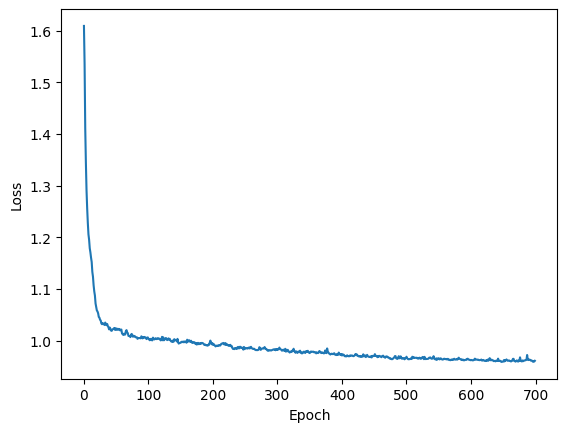

Test accuracy: 463.54967741935485
Accuracy: 0.45548387096774196
Precision: 0.4965019008600221
Recall: 0.45492417887676523
F1-score: 0.4683014906942515


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.56      0.63       495
           1       0.45      0.38      0.41       472
           2       0.30      0.43      0.35       449
           3       0.29      0.35      0.32       463
           4       0.74      0.57      0.64       446

    accuracy                           0.46      2325
   macro avg       0.50      0.45      0.47      2325
weighted avg       0.50      0.46      0.47      2325

                    0           1           2           3           4  \
precision    0.709924    0.449239    0.296124    0.290381    0.736842   
recall       0.563636    0.375000    0.425390    0.345572    0.565022   
f1-score     0.628378    0.408776    0.349177    0.315582    0.639594   
support    495.000000  472.000000  449.0000

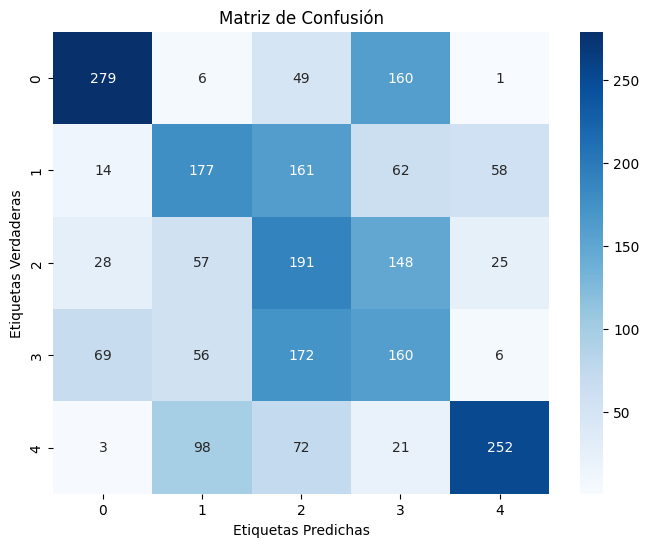

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_700_0.0001_0.3/resultados_700_0.0001_0.3.json
Procesando red con 700 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas:   0%|                                                               | 1/700 [00:02<30:45,  2.64s/it]

1.6094092011451722


Procesando epocas:   0%|▏                                                              | 2/700 [00:05<30:41,  2.64s/it]

1.609410840623519


Procesando epocas:   0%|▎                                                              | 3/700 [00:07<30:38,  2.64s/it]

1.6095228405559765


Procesando epocas:   1%|▎                                                              | 4/700 [00:10<30:32,  2.63s/it]

1.6093216461293838


Procesando epocas:   1%|▍                                                              | 5/700 [00:13<30:30,  2.63s/it]

1.609283331562491


Procesando epocas:   1%|▌                                                              | 6/700 [00:15<30:28,  2.63s/it]

1.6091284415301155


Procesando epocas:   1%|▋                                                              | 7/700 [00:18<30:27,  2.64s/it]

1.6087671504301184


Procesando epocas:   1%|▋                                                              | 8/700 [00:21<30:25,  2.64s/it]

1.607196063153884


Procesando epocas:   1%|▊                                                              | 9/700 [00:23<30:19,  2.63s/it]

1.604035613116096


Procesando epocas:   1%|▉                                                             | 10/700 [00:26<30:16,  2.63s/it]

1.5952479067970724


Procesando epocas:   2%|▉                                                             | 11/700 [00:28<30:11,  2.63s/it]

1.5657371275565204


Procesando epocas:   2%|█                                                             | 12/700 [00:31<30:06,  2.63s/it]

1.5061544320162605


Procesando epocas:   2%|█▏                                                            | 13/700 [00:34<30:03,  2.62s/it]

1.4525059139027314


Procesando epocas:   2%|█▏                                                            | 14/700 [00:36<30:01,  2.63s/it]

1.4171585475697237


Procesando epocas:   2%|█▎                                                            | 15/700 [00:39<30:00,  2.63s/it]

1.3871139070566962


Procesando epocas:   2%|█▍                                                            | 16/700 [00:42<29:56,  2.63s/it]

1.3610885949695812


Procesando epocas:   2%|█▌                                                            | 17/700 [00:44<29:52,  2.62s/it]

1.3409278610173394


Procesando epocas:   3%|█▌                                                            | 18/700 [00:47<29:49,  2.62s/it]

1.323736645894892


Procesando epocas:   3%|█▋                                                            | 19/700 [00:49<29:48,  2.63s/it]

1.30669585536508


Procesando epocas:   3%|█▊                                                            | 20/700 [00:52<29:46,  2.63s/it]

1.291546057252323


Procesando epocas:   3%|█▊                                                            | 21/700 [00:55<29:42,  2.63s/it]

1.2783705641241634


Procesando epocas:   3%|█▉                                                            | 22/700 [00:57<29:40,  2.63s/it]

1.2602493068751166


Procesando epocas:   3%|██                                                            | 23/700 [01:00<29:35,  2.62s/it]

1.2492807809044333


Procesando epocas:   3%|██▏                                                           | 24/700 [01:03<29:32,  2.62s/it]

1.2423436101745158


Procesando epocas:   4%|██▏                                                           | 25/700 [01:05<29:31,  2.62s/it]

1.233792427708121


Procesando epocas:   4%|██▎                                                           | 26/700 [01:08<29:29,  2.62s/it]

1.2232024220859303


Procesando epocas:   4%|██▍                                                           | 27/700 [01:10<29:28,  2.63s/it]

1.213800341942731


Procesando epocas:   4%|██▍                                                           | 28/700 [01:13<29:26,  2.63s/it]

1.2037871031200185


Procesando epocas:   4%|██▌                                                           | 29/700 [01:16<29:23,  2.63s/it]

1.1914778716423933


Procesando epocas:   4%|██▋                                                           | 30/700 [01:18<29:21,  2.63s/it]

1.1848837165271535


Procesando epocas:   4%|██▋                                                           | 31/700 [01:21<29:16,  2.63s/it]

1.180322272637311


Procesando epocas:   5%|██▊                                                           | 32/700 [01:24<29:13,  2.63s/it]

1.1675540054545683


Procesando epocas:   5%|██▉                                                           | 33/700 [01:26<29:10,  2.63s/it]

1.1616706581676708


Procesando epocas:   5%|███                                                           | 34/700 [01:29<29:03,  2.62s/it]

1.1530960896435907


Procesando epocas:   5%|███                                                           | 35/700 [01:31<28:58,  2.62s/it]

1.149995420259588


Procesando epocas:   5%|███▏                                                          | 36/700 [01:34<28:53,  2.61s/it]

1.13670775679981


Procesando epocas:   5%|███▎                                                          | 37/700 [01:37<28:49,  2.61s/it]

1.1307079735924215


Procesando epocas:   5%|███▎                                                          | 38/700 [01:39<28:46,  2.61s/it]

1.1224597376935623


Procesando epocas:   6%|███▍                                                          | 39/700 [01:42<28:42,  2.61s/it]

1.1197042559876162


Procesando epocas:   6%|███▌                                                          | 40/700 [01:44<28:39,  2.61s/it]

1.1111862350912656


Procesando epocas:   6%|███▋                                                          | 41/700 [01:47<28:34,  2.60s/it]

1.1042447037556593


Procesando epocas:   6%|███▋                                                          | 42/700 [01:50<28:37,  2.61s/it]

1.098599208803738


Procesando epocas:   6%|███▊                                                          | 43/700 [01:52<28:42,  2.62s/it]

1.0918394200942096


Procesando epocas:   6%|███▉                                                          | 44/700 [01:55<28:46,  2.63s/it]

1.085856351782294


Procesando epocas:   6%|███▉                                                          | 45/700 [01:58<28:45,  2.63s/it]

1.0791035771369935


Procesando epocas:   7%|████                                                          | 46/700 [02:00<28:45,  2.64s/it]

1.0742349922657013


Procesando epocas:   7%|████▏                                                         | 47/700 [02:03<28:43,  2.64s/it]

1.0680006156949435


Procesando epocas:   7%|████▎                                                         | 48/700 [02:06<28:40,  2.64s/it]

1.0605898713364321


Procesando epocas:   7%|████▎                                                         | 49/700 [02:08<28:38,  2.64s/it]

1.0554859126315397


Procesando epocas:   7%|████▍                                                         | 50/700 [02:11<28:36,  2.64s/it]

1.0500565181760226


Procesando epocas:   7%|████▌                                                         | 51/700 [02:13<28:32,  2.64s/it]

1.044144232483471


Procesando epocas:   7%|████▌                                                         | 52/700 [02:16<28:35,  2.65s/it]

1.0405149922651402


Procesando epocas:   8%|████▋                                                         | 53/700 [02:19<28:34,  2.65s/it]

1.0383730386986452


Procesando epocas:   8%|████▊                                                         | 54/700 [02:21<28:36,  2.66s/it]

1.035527141304577


Procesando epocas:   8%|████▊                                                         | 55/700 [02:24<28:37,  2.66s/it]

1.0271015531876508


Procesando epocas:   8%|████▉                                                         | 56/700 [02:27<28:37,  2.67s/it]

1.0233620562974144


Procesando epocas:   8%|█████                                                         | 57/700 [02:29<28:35,  2.67s/it]

1.022149856300915


Procesando epocas:   8%|█████▏                                                        | 58/700 [02:32<28:32,  2.67s/it]

1.0209569040466757


Procesando epocas:   8%|█████▏                                                        | 59/700 [02:35<28:30,  2.67s/it]

1.0148888209286857


Procesando epocas:   9%|█████▎                                                        | 60/700 [02:38<28:29,  2.67s/it]

1.0146941837142496


Procesando epocas:   9%|█████▍                                                        | 61/700 [02:40<28:23,  2.67s/it]

1.0092209668720469


Procesando epocas:   9%|█████▍                                                        | 62/700 [02:43<28:21,  2.67s/it]

1.0091598654494567


Procesando epocas:   9%|█████▌                                                        | 63/700 [02:45<28:18,  2.67s/it]

1.004201078414917


Procesando epocas:   9%|█████▋                                                        | 64/700 [02:48<28:16,  2.67s/it]

1.0011150928104624


Procesando epocas:   9%|█████▊                                                        | 65/700 [02:51<28:15,  2.67s/it]

0.9996637056855594


Procesando epocas:   9%|█████▊                                                        | 66/700 [02:53<28:09,  2.67s/it]

0.9994332839460934


Procesando epocas:  10%|█████▉                                                        | 67/700 [02:56<28:07,  2.67s/it]

0.9948150277137756


Procesando epocas:  10%|██████                                                        | 68/700 [02:59<28:05,  2.67s/it]

0.9918102569439832


Procesando epocas:  10%|██████                                                        | 69/700 [03:01<28:02,  2.67s/it]

0.9926050410551184


Procesando epocas:  10%|██████▏                                                       | 70/700 [03:04<28:01,  2.67s/it]

0.9899757858584909


Procesando epocas:  10%|██████▎                                                       | 71/700 [03:07<27:56,  2.67s/it]

0.9883012634866378


Procesando epocas:  10%|██████▍                                                       | 72/700 [03:09<27:55,  2.67s/it]

0.9868407726287842


Procesando epocas:  10%|██████▍                                                       | 73/700 [03:12<27:54,  2.67s/it]

0.9833576269009534


Procesando epocas:  11%|██████▌                                                       | 74/700 [03:15<27:49,  2.67s/it]

0.9834399135673747


Procesando epocas:  11%|██████▋                                                       | 75/700 [03:17<27:41,  2.66s/it]

0.9821339172475478


Procesando epocas:  11%|██████▋                                                       | 76/700 [03:20<27:38,  2.66s/it]

0.981382975508185


Procesando epocas:  11%|██████▊                                                       | 77/700 [03:23<27:34,  2.66s/it]

0.9794507997877457


Procesando epocas:  11%|██████▉                                                       | 78/700 [03:25<27:27,  2.65s/it]

0.9800385257777046


Procesando epocas:  11%|██████▉                                                       | 79/700 [03:28<27:19,  2.64s/it]

0.9769009653259726


Procesando epocas:  11%|███████                                                       | 80/700 [03:31<27:14,  2.64s/it]

0.9751050843912012


Procesando epocas:  12%|███████▏                                                      | 81/700 [03:33<27:13,  2.64s/it]

0.9759353192413555


Procesando epocas:  12%|███████▎                                                      | 82/700 [03:36<27:12,  2.64s/it]

0.9735266608350417


Procesando epocas:  12%|███████▎                                                      | 83/700 [03:39<27:07,  2.64s/it]

0.974128319235409


Procesando epocas:  12%|███████▍                                                      | 84/700 [03:41<27:08,  2.64s/it]

0.9714997035615585


Procesando epocas:  12%|███████▌                                                      | 85/700 [03:44<27:05,  2.64s/it]

0.9698672834564658


Procesando epocas:  12%|███████▌                                                      | 86/700 [03:47<27:01,  2.64s/it]

0.970252303165548


Procesando epocas:  12%|███████▋                                                      | 87/700 [03:49<26:58,  2.64s/it]

0.9706850174595328


Procesando epocas:  13%|███████▊                                                      | 88/700 [03:52<26:55,  2.64s/it]

0.9693195371066823


Procesando epocas:  13%|███████▉                                                      | 89/700 [03:54<26:53,  2.64s/it]

0.9675408261663774


Procesando epocas:  13%|███████▉                                                      | 90/700 [03:57<26:49,  2.64s/it]

0.9674875122659347


Procesando epocas:  13%|████████                                                      | 91/700 [04:00<26:48,  2.64s/it]

0.9659029301475076


Procesando epocas:  13%|████████▏                                                     | 92/700 [04:02<26:45,  2.64s/it]

0.966422837972641


Procesando epocas:  13%|████████▏                                                     | 93/700 [04:05<26:42,  2.64s/it]

0.9648757268400753


Procesando epocas:  13%|████████▎                                                     | 94/700 [04:08<26:40,  2.64s/it]

0.9643603268791647


Procesando epocas:  14%|████████▍                                                     | 95/700 [04:10<26:38,  2.64s/it]

0.9641723573207855


Procesando epocas:  14%|████████▌                                                     | 96/700 [04:13<26:33,  2.64s/it]

0.9646862177287832


Procesando epocas:  14%|████████▌                                                     | 97/700 [04:16<26:31,  2.64s/it]

0.9640414770911722


Procesando epocas:  14%|████████▋                                                     | 98/700 [04:18<26:28,  2.64s/it]

0.9630750000476838


Procesando epocas:  14%|████████▊                                                     | 99/700 [04:21<26:25,  2.64s/it]

0.9631316949339473


Procesando epocas:  14%|████████▋                                                    | 100/700 [04:23<26:23,  2.64s/it]

0.9633005356087404


Procesando epocas:  14%|████████▊                                                    | 101/700 [04:26<26:20,  2.64s/it]

0.9605850591379054


Procesando epocas:  15%|████████▉                                                    | 102/700 [04:29<26:16,  2.64s/it]

0.9606586512397317


Procesando epocas:  15%|████████▉                                                    | 103/700 [04:31<26:12,  2.63s/it]

0.9610219531199511


Procesando epocas:  15%|█████████                                                    | 104/700 [04:34<26:08,  2.63s/it]

0.9595812117352205


Procesando epocas:  15%|█████████▏                                                   | 105/700 [04:37<26:04,  2.63s/it]

0.9605824284693774


Procesando epocas:  15%|█████████▏                                                   | 106/700 [04:39<26:00,  2.63s/it]

0.9592662828810075


Procesando epocas:  15%|█████████▎                                                   | 107/700 [04:42<25:59,  2.63s/it]

0.9593866050243378


Procesando epocas:  15%|█████████▍                                                   | 108/700 [04:45<25:56,  2.63s/it]

0.9592404256848728


Procesando epocas:  16%|█████████▍                                                   | 109/700 [04:47<25:54,  2.63s/it]

0.9583360061926001


Procesando epocas:  16%|█████████▌                                                   | 110/700 [04:50<25:52,  2.63s/it]

0.9575155959409826


Procesando epocas:  16%|█████████▋                                                   | 111/700 [04:52<25:50,  2.63s/it]

0.9596921738456278


Procesando epocas:  16%|█████████▊                                                   | 112/700 [04:55<25:43,  2.62s/it]

0.9580287011230693


Procesando epocas:  16%|█████████▊                                                   | 113/700 [04:58<25:39,  2.62s/it]

0.958039101782967


Procesando epocas:  16%|█████████▉                                                   | 114/700 [05:00<25:35,  2.62s/it]

0.9566794104435865


Procesando epocas:  16%|██████████                                                   | 115/700 [05:03<25:31,  2.62s/it]

0.9558914184570313


Procesando epocas:  17%|██████████                                                   | 116/700 [05:05<25:29,  2.62s/it]

0.9568840370458715


Procesando epocas:  17%|██████████▏                                                  | 117/700 [05:08<25:24,  2.61s/it]

0.9561396283261916


Procesando epocas:  17%|██████████▎                                                  | 118/700 [05:11<25:19,  2.61s/it]

0.9553617393269258


Procesando epocas:  17%|██████████▎                                                  | 119/700 [05:13<25:18,  2.61s/it]

0.9541242557413437


Procesando epocas:  17%|██████████▍                                                  | 120/700 [05:16<25:12,  2.61s/it]

0.9543948233127594


Procesando epocas:  17%|██████████▌                                                  | 121/700 [05:19<25:11,  2.61s/it]

0.9544600195744458


Procesando epocas:  17%|██████████▋                                                  | 122/700 [05:21<25:09,  2.61s/it]

0.9544234026880826


Procesando epocas:  18%|██████████▋                                                  | 123/700 [05:24<25:06,  2.61s/it]

0.9535398553399479


Procesando epocas:  18%|██████████▊                                                  | 124/700 [05:26<25:02,  2.61s/it]

0.9552759167026071


Procesando epocas:  18%|██████████▉                                                  | 125/700 [05:29<25:01,  2.61s/it]

0.9544192521011128


Procesando epocas:  18%|██████████▉                                                  | 126/700 [05:32<24:57,  2.61s/it]

0.9545836325953988


Procesando epocas:  18%|███████████                                                  | 127/700 [05:34<24:55,  2.61s/it]

0.9546625782461727


Procesando epocas:  18%|███████████▏                                                 | 128/700 [05:37<24:52,  2.61s/it]

0.9533611332668978


Procesando epocas:  18%|███████████▏                                                 | 129/700 [05:39<24:51,  2.61s/it]

0.954088190723868


Procesando epocas:  19%|███████████▎                                                 | 130/700 [05:42<24:52,  2.62s/it]

0.952457540175494


Procesando epocas:  19%|███████████▍                                                 | 131/700 [05:45<24:52,  2.62s/it]

0.9524218888843761


Procesando epocas:  19%|███████████▌                                                 | 132/700 [05:47<24:51,  2.63s/it]

0.9519929100485409


Procesando epocas:  19%|███████████▌                                                 | 133/700 [05:50<24:48,  2.63s/it]

0.9514595676870907


Procesando epocas:  19%|███████████▋                                                 | 134/700 [05:53<24:47,  2.63s/it]

0.9531878594089956


Procesando epocas:  19%|███████████▊                                                 | 135/700 [05:55<24:45,  2.63s/it]

0.9523816816947039


Procesando epocas:  19%|███████████▊                                                 | 136/700 [05:58<24:40,  2.62s/it]

0.9520299830857445


Procesando epocas:  20%|███████████▉                                                 | 137/700 [06:00<24:35,  2.62s/it]

0.9509619867100435


Procesando epocas:  20%|████████████                                                 | 138/700 [06:03<24:33,  2.62s/it]

0.9518791026928846


Procesando epocas:  20%|████████████                                                 | 139/700 [06:06<24:30,  2.62s/it]

0.951765733606675


Procesando epocas:  20%|████████████▏                                                | 140/700 [06:08<24:26,  2.62s/it]

0.9507518947124481


Procesando epocas:  20%|████████████▎                                                | 141/700 [06:11<24:24,  2.62s/it]

0.951037725981544


Procesando epocas:  20%|████████████▎                                                | 142/700 [06:14<24:24,  2.62s/it]

0.9496644395239213


Procesando epocas:  20%|████████████▍                                                | 143/700 [06:16<24:18,  2.62s/it]

0.9507920138976154


Procesando epocas:  21%|████████████▌                                                | 144/700 [06:19<24:13,  2.61s/it]

0.9500126572216259


Procesando epocas:  21%|████████████▋                                                | 145/700 [06:21<24:09,  2.61s/it]

0.9504069433492772


Procesando epocas:  21%|████████████▋                                                | 146/700 [06:24<24:07,  2.61s/it]

0.9503307686132543


Procesando epocas:  21%|████████████▊                                                | 147/700 [06:27<24:04,  2.61s/it]

0.9502175096203299


Procesando epocas:  21%|████████████▉                                                | 148/700 [06:29<24:01,  2.61s/it]

0.9499440308879403


Procesando epocas:  21%|████████████▉                                                | 149/700 [06:32<24:00,  2.61s/it]

0.9500618832952836


Procesando epocas:  21%|█████████████                                                | 150/700 [06:34<23:54,  2.61s/it]

0.9510552802506615


Procesando epocas:  22%|█████████████▏                                               | 151/700 [06:37<23:53,  2.61s/it]

0.949704582901562


Procesando epocas:  22%|█████████████▏                                               | 152/700 [06:40<23:49,  2.61s/it]

0.949523901238161


Procesando epocas:  22%|█████████████▎                                               | 153/700 [06:42<23:48,  2.61s/it]

0.949053360784755


Procesando epocas:  22%|█████████████▍                                               | 154/700 [06:45<23:48,  2.62s/it]

0.9497184830553391


Procesando epocas:  22%|█████████████▌                                               | 155/700 [06:47<23:47,  2.62s/it]

0.9496826722341425


Procesando epocas:  22%|█████████████▌                                               | 156/700 [06:50<23:45,  2.62s/it]

0.9488689306904288


Procesando epocas:  22%|█████████████▋                                               | 157/700 [06:53<23:42,  2.62s/it]

0.9490607363336226


Procesando epocas:  23%|█████████████▊                                               | 158/700 [06:55<23:39,  2.62s/it]

0.9485916263916914


Procesando epocas:  23%|█████████████▊                                               | 159/700 [06:58<23:36,  2.62s/it]

0.949652946696562


Procesando epocas:  23%|█████████████▉                                               | 160/700 [07:01<23:32,  2.61s/it]

0.949005319441066


Procesando epocas:  23%|██████████████                                               | 161/700 [07:03<23:28,  2.61s/it]

0.9490542993826024


Procesando epocas:  23%|██████████████                                               | 162/700 [07:06<23:24,  2.61s/it]

0.9487506568431854


Procesando epocas:  23%|██████████████▏                                              | 163/700 [07:08<23:22,  2.61s/it]

0.9485679100541508


Procesando epocas:  23%|██████████████▎                                              | 164/700 [07:11<23:20,  2.61s/it]

0.9475580236491035


Procesando epocas:  24%|██████████████▍                                              | 165/700 [07:14<23:18,  2.61s/it]

0.9479635789113886


Procesando epocas:  24%|██████████████▍                                              | 166/700 [07:16<23:17,  2.62s/it]

0.9485070098848903


Procesando epocas:  24%|██████████████▌                                              | 167/700 [07:19<23:21,  2.63s/it]

0.9478776076260735


Procesando epocas:  24%|██████████████▋                                              | 168/700 [07:22<23:25,  2.64s/it]

0.9491663263124578


Procesando epocas:  24%|██████████████▋                                              | 169/700 [07:24<23:29,  2.66s/it]

0.9485328572637894


Procesando epocas:  24%|██████████████▊                                              | 170/700 [07:27<23:31,  2.66s/it]

0.9475890794221092


Procesando epocas:  24%|██████████████▉                                              | 171/700 [07:30<23:27,  2.66s/it]

0.9494065109421225


Procesando epocas:  25%|██████████████▉                                              | 172/700 [07:32<23:25,  2.66s/it]

0.9485190815785352


Procesando epocas:  25%|███████████████                                              | 173/700 [07:35<23:22,  2.66s/it]

0.9484413714969859


Procesando epocas:  25%|███████████████▏                                             | 174/700 [07:38<23:16,  2.65s/it]

0.9482730346567491


Procesando epocas:  25%|███████████████▎                                             | 175/700 [07:40<23:14,  2.66s/it]

0.9473275650950039


Procesando epocas:  25%|███████████████▎                                             | 176/700 [07:43<23:11,  2.66s/it]

0.9469972557881299


Procesando epocas:  25%|███████████████▍                                             | 177/700 [07:46<23:09,  2.66s/it]

0.9473562464994543


Procesando epocas:  25%|███████████████▌                                             | 178/700 [07:48<23:04,  2.65s/it]

0.9479535379830528


Procesando epocas:  26%|███████████████▌                                             | 179/700 [07:51<23:02,  2.65s/it]

0.9479429679758409


Procesando epocas:  26%|███████████████▋                                             | 180/700 [07:53<22:57,  2.65s/it]

0.9484221654779771


Procesando epocas:  26%|███████████████▊                                             | 181/700 [07:56<22:55,  2.65s/it]

0.9479504101416644


Procesando epocas:  26%|███████████████▊                                             | 182/700 [07:59<22:52,  2.65s/it]

0.9473493926665362


Procesando epocas:  26%|███████████████▉                                             | 183/700 [08:01<22:49,  2.65s/it]

0.947434084555682


Procesando epocas:  26%|████████████████                                             | 184/700 [08:04<22:47,  2.65s/it]

0.9482601032537572


Procesando epocas:  26%|████████████████                                             | 185/700 [08:07<22:44,  2.65s/it]

0.946982430009281


Procesando epocas:  27%|████████████████▏                                            | 186/700 [08:09<22:44,  2.65s/it]

0.947364595006494


Procesando epocas:  27%|████████████████▎                                            | 187/700 [08:12<22:41,  2.65s/it]

0.948099422454834


Procesando epocas:  27%|████████████████▍                                            | 188/700 [08:15<22:37,  2.65s/it]

0.9481212310931262


Procesando epocas:  27%|████████████████▍                                            | 189/700 [08:17<22:33,  2.65s/it]

0.9468813251046574


Procesando epocas:  27%|████████████████▌                                            | 190/700 [08:20<22:32,  2.65s/it]

0.9471847260699553


Procesando epocas:  27%|████████████████▋                                            | 191/700 [08:23<22:29,  2.65s/it]

0.9473843739313238


Procesando epocas:  27%|████████████████▋                                            | 192/700 [08:25<22:27,  2.65s/it]

0.9476611908744363


Procesando epocas:  28%|████████████████▊                                            | 193/700 [08:28<22:25,  2.65s/it]

0.94712333538953


Procesando epocas:  28%|████████████████▉                                            | 194/700 [08:31<22:23,  2.65s/it]

0.9468322764424717


Procesando epocas:  28%|████████████████▉                                            | 195/700 [08:33<22:19,  2.65s/it]

0.947817197967978


Procesando epocas:  28%|█████████████████                                            | 196/700 [08:36<22:16,  2.65s/it]

0.9470746327848996


Procesando epocas:  28%|█████████████████▏                                           | 197/700 [08:39<22:14,  2.65s/it]

0.9475799427312963


Procesando epocas:  28%|█████████████████▎                                           | 198/700 [08:41<22:11,  2.65s/it]

0.9469093154458439


Procesando epocas:  28%|█████████████████▎                                           | 199/700 [08:44<22:09,  2.65s/it]

0.9460984752458684


Procesando epocas:  29%|█████████████████▍                                           | 200/700 [08:46<21:07,  2.53s/it]

0.9463281862875994


Procesando epocas:  29%|█████████████████▌                                           | 201/700 [08:49<21:18,  2.56s/it]

0.9462976375046899


Procesando epocas:  29%|█████████████████▌                                           | 202/700 [08:51<21:26,  2.58s/it]

0.9460518160287071


Procesando epocas:  29%|█████████████████▋                                           | 203/700 [08:54<21:30,  2.60s/it]

0.9465257662184098


Procesando epocas:  29%|█████████████████▊                                           | 204/700 [08:57<21:33,  2.61s/it]

0.9457139520084157


Procesando epocas:  29%|█████████████████▊                                           | 205/700 [08:59<21:33,  2.61s/it]

0.9473876209820018


Procesando epocas:  29%|█████████████████▉                                           | 206/700 [09:02<21:32,  2.62s/it]

0.9469760642332189


Procesando epocas:  30%|██████████████████                                           | 207/700 [09:05<21:33,  2.62s/it]

0.9465732094119577


Procesando epocas:  30%|██████████████████▏                                          | 208/700 [09:07<21:31,  2.62s/it]

0.9465471579748042


Procesando epocas:  30%|██████████████████▏                                          | 209/700 [09:10<21:29,  2.63s/it]

0.9470084106220918


Procesando epocas:  30%|██████████████████▎                                          | 210/700 [09:12<21:26,  2.62s/it]

0.9469315553412718


Procesando epocas:  30%|██████████████████▍                                          | 211/700 [09:15<21:24,  2.63s/it]

0.9464056898565854


Procesando epocas:  30%|██████████████████▍                                          | 212/700 [09:18<21:23,  2.63s/it]

0.9460996350821327


Procesando epocas:  30%|██████████████████▌                                          | 213/700 [09:20<21:20,  2.63s/it]

0.9465394086697523


Procesando epocas:  31%|██████████████████▋                                          | 214/700 [09:23<21:18,  2.63s/it]

0.9457271249855266


Procesando epocas:  31%|██████████████████▋                                          | 215/700 [09:26<21:15,  2.63s/it]

0.9462802073534797


Procesando epocas:  31%|██████████████████▊                                          | 216/700 [09:28<21:13,  2.63s/it]

0.9458365226493163


Procesando epocas:  31%|██████████████████▉                                          | 217/700 [09:31<21:11,  2.63s/it]

0.9455181346220128


Procesando epocas:  31%|██████████████████▉                                          | 218/700 [09:33<21:07,  2.63s/it]

0.9461385295671575


Procesando epocas:  31%|███████████████████                                          | 219/700 [09:36<21:04,  2.63s/it]

0.9459293505724738


Procesando epocas:  31%|███████████████████▏                                         | 220/700 [09:39<21:02,  2.63s/it]

0.9461808762129615


Procesando epocas:  32%|███████████████████▎                                         | 221/700 [09:41<21:00,  2.63s/it]

0.9459800018983728


Procesando epocas:  32%|███████████████████▎                                         | 222/700 [09:44<20:57,  2.63s/it]

0.9459046339287477


Procesando epocas:  32%|███████████████████▍                                         | 223/700 [09:47<20:54,  2.63s/it]

0.9456821536316591


Procesando epocas:  32%|███████████████████▌                                         | 224/700 [09:49<20:53,  2.63s/it]

0.9461584704763749


Procesando epocas:  32%|███████████████████▌                                         | 225/700 [09:52<20:52,  2.64s/it]

0.9459140402429244


Procesando epocas:  32%|███████████████████▋                                         | 226/700 [09:55<20:48,  2.63s/it]

0.9459189232657937


Procesando epocas:  32%|███████████████████▊                                         | 227/700 [09:57<20:45,  2.63s/it]

0.9457774127230925


Procesando epocas:  33%|███████████████████▊                                         | 228/700 [10:00<20:39,  2.63s/it]

0.945980200697394


Procesando epocas:  33%|███████████████████▉                                         | 229/700 [10:02<20:38,  2.63s/it]

0.9456213092102724


Procesando epocas:  33%|████████████████████                                         | 230/700 [10:05<20:37,  2.63s/it]

0.9452236080870909


Procesando epocas:  33%|████████████████████▏                                        | 231/700 [10:08<20:34,  2.63s/it]

0.9455449896700242


Procesando epocas:  33%|████████████████████▏                                        | 232/700 [10:10<20:32,  2.63s/it]

0.9451646320960101


Procesando epocas:  33%|████████████████████▎                                        | 233/700 [10:13<20:30,  2.63s/it]

0.945783348644481


Procesando epocas:  33%|████████████████████▍                                        | 234/700 [10:16<20:28,  2.64s/it]

0.9454860224443323


Procesando epocas:  34%|████████████████████▍                                        | 235/700 [10:18<20:24,  2.63s/it]

0.9453249142450445


Procesando epocas:  34%|████████████████████▌                                        | 236/700 [10:21<20:22,  2.64s/it]

0.9449711610289181


Procesando epocas:  34%|████████████████████▋                                        | 237/700 [10:24<20:20,  2.64s/it]

0.9459731421049904


Procesando epocas:  34%|████████████████████▋                                        | 238/700 [10:26<20:17,  2.64s/it]

0.9466498178594253


Procesando epocas:  34%|████████████████████▊                                        | 239/700 [10:29<20:15,  2.64s/it]

0.9458058806026683


Procesando epocas:  34%|████████████████████▉                                        | 240/700 [10:31<20:11,  2.63s/it]

0.9454712464528925


Procesando epocas:  34%|█████████████████████                                        | 241/700 [10:34<20:09,  2.63s/it]

0.9461870232049157


Procesando epocas:  35%|█████████████████████                                        | 242/700 [10:37<20:08,  2.64s/it]

0.9456242133589352


Procesando epocas:  35%|█████████████████████▏                                       | 243/700 [10:39<20:05,  2.64s/it]

0.9457242558984196


Procesando epocas:  35%|█████████████████████▎                                       | 244/700 [10:42<20:03,  2.64s/it]

0.9453527506660012


Procesando epocas:  35%|█████████████████████▎                                       | 245/700 [10:45<20:00,  2.64s/it]

0.9457366519114551


Procesando epocas:  35%|█████████████████████▍                                       | 246/700 [10:47<19:59,  2.64s/it]

0.9463049019084258


Procesando epocas:  35%|█████████████████████▌                                       | 247/700 [10:50<19:56,  2.64s/it]

0.9458182913415573


Procesando epocas:  35%|█████████████████████▌                                       | 248/700 [10:53<19:56,  2.65s/it]

0.9458035455030553


Procesando epocas:  36%|█████████████████████▋                                       | 249/700 [10:55<19:51,  2.64s/it]

0.9451161644038032


Procesando epocas:  36%|█████████████████████▊                                       | 250/700 [10:58<19:46,  2.64s/it]

0.9466461858328651


Procesando epocas:  36%|█████████████████████▊                                       | 251/700 [11:00<19:42,  2.63s/it]

0.9453683916260215


Procesando epocas:  36%|█████████████████████▉                                       | 252/700 [11:03<19:39,  2.63s/it]

0.9452502958914812


Procesando epocas:  36%|██████████████████████                                       | 253/700 [11:06<19:36,  2.63s/it]

0.9450777390423943


Procesando epocas:  36%|██████████████████████▏                                      | 254/700 [11:08<19:33,  2.63s/it]

0.9447026676991407


Procesando epocas:  36%|██████████████████████▏                                      | 255/700 [11:11<19:29,  2.63s/it]

0.9455651405979605


Procesando epocas:  37%|██████████████████████▎                                      | 256/700 [11:14<19:25,  2.62s/it]

0.9452877609168782


Procesando epocas:  37%|██████████████████████▍                                      | 257/700 [11:16<19:22,  2.63s/it]

0.945611993004294


Procesando epocas:  37%|██████████████████████▍                                      | 258/700 [11:19<19:21,  2.63s/it]

0.9451088649385115


Procesando epocas:  37%|██████████████████████▌                                      | 259/700 [11:21<19:18,  2.63s/it]

0.9449591804953182


Procesando epocas:  37%|██████████████████████▋                                      | 260/700 [11:24<19:16,  2.63s/it]

0.9452313321478226


Procesando epocas:  37%|██████████████████████▋                                      | 261/700 [11:27<19:13,  2.63s/it]

0.9451938264510211


Procesando epocas:  37%|██████████████████████▊                                      | 262/700 [11:29<19:10,  2.63s/it]

0.9446244418621064


Procesando epocas:  38%|██████████████████████▉                                      | 263/700 [11:32<19:08,  2.63s/it]

0.945077002399108


Procesando epocas:  38%|███████████████████████                                      | 264/700 [11:35<19:05,  2.63s/it]

0.9449849921114305


Procesando epocas:  38%|███████████████████████                                      | 265/700 [11:37<19:02,  2.63s/it]

0.9448249950128443


Procesando epocas:  38%|███████████████████████▏                                     | 266/700 [11:40<18:58,  2.62s/it]

0.9454940234913546


Procesando epocas:  38%|███████████████████████▎                                     | 267/700 [11:42<18:55,  2.62s/it]

0.9445531957289752


Procesando epocas:  38%|███████████████████████▎                                     | 268/700 [11:45<18:53,  2.62s/it]

0.9447419951943791


Procesando epocas:  38%|███████████████████████▍                                     | 269/700 [11:48<18:50,  2.62s/it]

0.9453420677605797


Procesando epocas:  39%|███████████████████████▌                                     | 270/700 [11:50<18:45,  2.62s/it]

0.9448926746845245


Procesando epocas:  39%|███████████████████████▌                                     | 271/700 [11:53<18:40,  2.61s/it]

0.9445783331113703


Procesando epocas:  39%|███████████████████████▋                                     | 272/700 [11:55<18:36,  2.61s/it]

0.9445778808173011


Procesando epocas:  39%|███████████████████████▊                                     | 273/700 [11:58<18:33,  2.61s/it]

0.9446177759591271


Procesando epocas:  39%|███████████████████████▉                                     | 274/700 [12:01<18:31,  2.61s/it]

0.9447325341841754


Procesando epocas:  39%|███████████████████████▉                                     | 275/700 [12:03<18:27,  2.61s/it]

0.9447931089821984


Procesando epocas:  39%|████████████████████████                                     | 276/700 [12:06<18:24,  2.61s/it]

0.9447660958065706


Procesando epocas:  40%|████████████████████████▏                                    | 277/700 [12:09<18:21,  2.60s/it]

0.9446859801516814


Procesando epocas:  40%|████████████████████████▏                                    | 278/700 [12:11<18:17,  2.60s/it]

0.9446328415590174


Procesando epocas:  40%|████████████████████████▎                                    | 279/700 [12:14<18:13,  2.60s/it]

0.9446828502065995


Procesando epocas:  40%|████████████████████████▍                                    | 280/700 [12:16<18:10,  2.60s/it]

0.9447503903332879


Procesando epocas:  40%|████████████████████████▍                                    | 281/700 [12:19<18:07,  2.60s/it]

0.9449864362969118


Procesando epocas:  40%|████████████████████████▌                                    | 282/700 [12:21<18:06,  2.60s/it]

0.9445368391626021


Procesando epocas:  40%|████████████████████████▋                                    | 283/700 [12:24<18:03,  2.60s/it]

0.9449717146508834


Procesando epocas:  41%|████████████████████████▋                                    | 284/700 [12:27<18:01,  2.60s/it]

0.9447899061090806


Procesando epocas:  41%|████████████████████████▊                                    | 285/700 [12:29<17:59,  2.60s/it]

0.9449581342584946


Procesando epocas:  41%|████████████████████████▉                                    | 286/700 [12:32<17:56,  2.60s/it]

0.9448729080312392


Procesando epocas:  41%|█████████████████████████                                    | 287/700 [12:35<17:53,  2.60s/it]

0.9448268490679124


Procesando epocas:  41%|█████████████████████████                                    | 288/700 [12:37<17:53,  2.61s/it]

0.9443478573771084


Procesando epocas:  41%|█████████████████████████▏                                   | 289/700 [12:40<17:52,  2.61s/it]

0.9442613166921279


Procesando epocas:  41%|█████████████████████████▎                                   | 290/700 [12:42<17:49,  2.61s/it]

0.9438970313352697


Procesando epocas:  42%|█████████████████████████▎                                   | 291/700 [12:45<17:47,  2.61s/it]

0.9443614198881037


Procesando epocas:  42%|█████████████████████████▍                                   | 292/700 [12:48<17:43,  2.61s/it]

0.9441685922005597


Procesando epocas:  42%|█████████████████████████▌                                   | 293/700 [12:50<17:49,  2.63s/it]

0.9440689907354467


Procesando epocas:  42%|█████████████████████████▌                                   | 294/700 [12:53<17:52,  2.64s/it]

0.9438210771364324


Procesando epocas:  42%|█████████████████████████▋                                   | 295/700 [12:56<17:53,  2.65s/it]

0.9436376985381631


Procesando epocas:  42%|█████████████████████████▊                                   | 296/700 [12:58<17:53,  2.66s/it]

0.9442157012574813


Procesando epocas:  42%|█████████████████████████▉                                   | 297/700 [13:01<17:52,  2.66s/it]

0.9446069538593292


Procesando epocas:  43%|█████████████████████████▉                                   | 298/700 [13:04<17:50,  2.66s/it]

0.9442078839330112


Procesando epocas:  43%|██████████████████████████                                   | 299/700 [13:06<17:49,  2.67s/it]

0.9438839148072635


Procesando epocas:  43%|██████████████████████████▏                                  | 300/700 [13:09<17:49,  2.67s/it]

0.944507223367691


Procesando epocas:  43%|██████████████████████████▏                                  | 301/700 [13:12<17:49,  2.68s/it]

0.9438529631670783


Procesando epocas:  43%|██████████████████████████▎                                  | 302/700 [13:14<17:44,  2.67s/it]

0.9441275968271143


Procesando epocas:  43%|██████████████████████████▍                                  | 303/700 [13:17<17:42,  2.68s/it]

0.9435419079135446


Procesando epocas:  43%|██████████████████████████▍                                  | 304/700 [13:20<17:41,  2.68s/it]

0.9441762868095847


Procesando epocas:  44%|██████████████████████████▌                                  | 305/700 [13:22<17:38,  2.68s/it]

0.9444735779481775


Procesando epocas:  44%|██████████████████████████▋                                  | 306/700 [13:25<17:34,  2.68s/it]

0.9436928629875183


Procesando epocas:  44%|██████████████████████████▊                                  | 307/700 [13:28<17:31,  2.68s/it]

0.9441962112398709


Procesando epocas:  44%|██████████████████████████▊                                  | 308/700 [13:30<17:28,  2.67s/it]

0.9437395628760843


Procesando epocas:  44%|██████████████████████████▉                                  | 309/700 [13:33<17:25,  2.67s/it]

0.9436624008066514


Procesando epocas:  44%|███████████████████████████                                  | 310/700 [13:36<17:22,  2.67s/it]

0.9441647999426898


Procesando epocas:  44%|███████████████████████████                                  | 311/700 [13:38<17:18,  2.67s/it]

0.9438851587912616


Procesando epocas:  45%|███████████████████████████▏                                 | 312/700 [13:41<17:15,  2.67s/it]

0.9441048695760614


Procesando epocas:  45%|███████████████████████████▎                                 | 313/700 [13:44<17:12,  2.67s/it]

0.9440384149551392


Procesando epocas:  45%|███████████████████████████▎                                 | 314/700 [13:46<17:10,  2.67s/it]

0.9441295813111698


Procesando epocas:  45%|███████████████████████████▍                                 | 315/700 [13:49<17:07,  2.67s/it]

0.944123232014039


Procesando epocas:  45%|███████████████████████████▌                                 | 316/700 [13:52<17:07,  2.68s/it]

0.9441233561319463


Procesando epocas:  45%|███████████████████████████▌                                 | 317/700 [13:54<17:03,  2.67s/it]

0.9438947162207435


Procesando epocas:  45%|███████████████████████████▋                                 | 318/700 [13:57<17:00,  2.67s/it]

0.9440146432203405


Procesando epocas:  46%|███████████████████████████▊                                 | 319/700 [14:00<16:58,  2.67s/it]

0.9434942904640646


Procesando epocas:  46%|███████████████████████████▉                                 | 320/700 [14:02<16:55,  2.67s/it]

0.9442699975827161


Procesando epocas:  46%|███████████████████████████▉                                 | 321/700 [14:05<16:53,  2.67s/it]

0.9434235229211695


Procesando epocas:  46%|████████████████████████████                                 | 322/700 [14:08<16:51,  2.68s/it]

0.943490198429893


Procesando epocas:  46%|████████████████████████████▏                                | 323/700 [14:10<16:50,  2.68s/it]

0.9439240574836731


Procesando epocas:  46%|████████████████████████████▏                                | 324/700 [14:13<16:44,  2.67s/it]

0.9434029365287108


Procesando epocas:  46%|████████████████████████████▎                                | 325/700 [14:16<16:37,  2.66s/it]

0.9438332620789023


Procesando epocas:  47%|████████████████████████████▍                                | 326/700 [14:18<16:33,  2.66s/it]

0.9432053678175982


Procesando epocas:  47%|████████████████████████████▍                                | 327/700 [14:21<16:28,  2.65s/it]

0.9436574402977439


Procesando epocas:  47%|████████████████████████████▌                                | 328/700 [14:24<16:24,  2.65s/it]

0.9435733528698191


Procesando epocas:  47%|████████████████████████████▋                                | 329/700 [14:26<16:21,  2.65s/it]

0.9434448715518503


Procesando epocas:  47%|████████████████████████████▊                                | 330/700 [14:29<16:18,  2.64s/it]

0.9436461073510787


Procesando epocas:  47%|████████████████████████████▊                                | 331/700 [14:32<16:15,  2.64s/it]

0.9432754919809454


Procesando epocas:  47%|████████████████████████████▉                                | 332/700 [14:34<16:12,  2.64s/it]

0.9433344315080082


Procesando epocas:  48%|█████████████████████████████                                | 333/700 [14:37<16:10,  2.64s/it]

0.9431960547671598


Procesando epocas:  48%|█████████████████████████████                                | 334/700 [14:40<16:07,  2.64s/it]

0.9441373229026795


Procesando epocas:  48%|█████████████████████████████▏                               | 335/700 [14:42<16:04,  2.64s/it]

0.9436154793290531


Procesando epocas:  48%|█████████████████████████████▎                               | 336/700 [14:45<16:02,  2.64s/it]

0.9430461992235745


Procesando epocas:  48%|█████████████████████████████▎                               | 337/700 [14:47<15:59,  2.64s/it]

0.9429222408462973


Procesando epocas:  48%|█████████████████████████████▍                               | 338/700 [14:50<15:57,  2.64s/it]

0.9433319175944609


Procesando epocas:  48%|█████████████████████████████▌                               | 339/700 [14:53<15:54,  2.64s/it]

0.9430931897724376


Procesando epocas:  49%|█████████████████████████████▋                               | 340/700 [14:55<15:51,  2.64s/it]

0.9431966588777654


Procesando epocas:  49%|█████████████████████████████▋                               | 341/700 [14:58<15:48,  2.64s/it]

0.9428318118347842


Procesando epocas:  49%|█████████████████████████████▊                               | 342/700 [15:01<15:46,  2.64s/it]

0.9432701959329493


Procesando epocas:  49%|█████████████████████████████▉                               | 343/700 [15:03<15:43,  2.64s/it]

0.943084222428939


Procesando epocas:  49%|█████████████████████████████▉                               | 344/700 [15:06<15:41,  2.64s/it]

0.9436296021237093


Procesando epocas:  49%|██████████████████████████████                               | 345/700 [15:09<15:38,  2.64s/it]

0.9428254341377932


Procesando epocas:  49%|██████████████████████████████▏                              | 346/700 [15:11<15:36,  2.65s/it]

0.9432081706383649


Procesando epocas:  50%|██████████████████████████████▏                              | 347/700 [15:14<15:33,  2.64s/it]

0.9428970946985132


Procesando epocas:  50%|██████████████████████████████▎                              | 348/700 [15:17<15:30,  2.64s/it]

0.9430814381907968


Procesando epocas:  50%|██████████████████████████████▍                              | 349/700 [15:19<15:27,  2.64s/it]

0.9431533845031963


Procesando epocas:  50%|██████████████████████████████▌                              | 350/700 [15:22<15:22,  2.64s/it]

0.9430642110459945


Procesando epocas:  50%|██████████████████████████████▌                              | 351/700 [15:24<15:19,  2.64s/it]

0.942848155778997


Procesando epocas:  50%|██████████████████████████████▋                              | 352/700 [15:27<15:17,  2.64s/it]

0.9434972349335166


Procesando epocas:  50%|██████████████████████████████▊                              | 353/700 [15:30<15:14,  2.63s/it]

0.9433968351167791


Procesando epocas:  51%|██████████████████████████████▊                              | 354/700 [15:32<15:09,  2.63s/it]

0.942825679919299


Procesando epocas:  51%|██████████████████████████████▉                              | 355/700 [15:35<15:05,  2.63s/it]

0.9422264579464408


Procesando epocas:  51%|███████████████████████████████                              | 356/700 [15:38<15:02,  2.62s/it]

0.9427202256286845


Procesando epocas:  51%|███████████████████████████████                              | 357/700 [15:40<15:00,  2.62s/it]

0.9424117032219382


Procesando epocas:  51%|███████████████████████████████▏                             | 358/700 [15:43<14:58,  2.63s/it]

0.9431746156776653


Procesando epocas:  51%|███████████████████████████████▎                             | 359/700 [15:45<14:55,  2.62s/it]

0.9429308435496162


Procesando epocas:  51%|███████████████████████████████▎                             | 360/700 [15:48<14:50,  2.62s/it]

0.942566589046927


Procesando epocas:  52%|███████████████████████████████▍                             | 361/700 [15:51<14:48,  2.62s/it]

0.9428433134275325


Procesando epocas:  52%|███████████████████████████████▌                             | 362/700 [15:53<14:45,  2.62s/it]

0.9423050659544328


Procesando epocas:  52%|███████████████████████████████▋                             | 363/700 [15:56<14:43,  2.62s/it]

0.9430163544767043


Procesando epocas:  52%|███████████████████████████████▋                             | 364/700 [15:59<14:40,  2.62s/it]

0.9430849317242117


Procesando epocas:  52%|███████████████████████████████▊                             | 365/700 [16:01<14:36,  2.62s/it]

0.9427894806160646


Procesando epocas:  52%|███████████████████████████████▉                             | 366/700 [16:04<14:35,  2.62s/it]

0.9425220826092888


Procesando epocas:  52%|███████████████████████████████▉                             | 367/700 [16:06<14:32,  2.62s/it]

0.9425115581820993


Procesando epocas:  53%|████████████████████████████████                             | 368/700 [16:09<14:31,  2.62s/it]

0.942777516561396


Procesando epocas:  53%|████████████████████████████████▏                            | 369/700 [16:12<14:30,  2.63s/it]

0.9425754214034361


Procesando epocas:  53%|████████████████████████████████▏                            | 370/700 [16:14<14:27,  2.63s/it]

0.9427878947818981


Procesando epocas:  53%|████████████████████████████████▎                            | 371/700 [16:17<14:26,  2.63s/it]

0.9429940335890826


Procesando epocas:  53%|████████████████████████████████▍                            | 372/700 [16:20<14:24,  2.63s/it]

0.9424156900714425


Procesando epocas:  53%|████████████████████████████████▌                            | 373/700 [16:22<14:20,  2.63s/it]

0.9428003146367915


Procesando epocas:  53%|████████████████████████████████▌                            | 374/700 [16:25<14:18,  2.63s/it]

0.9426658297286314


Procesando epocas:  54%|████████████████████████████████▋                            | 375/700 [16:27<14:16,  2.63s/it]

0.9425599112230189


Procesando epocas:  54%|████████████████████████████████▊                            | 376/700 [16:30<14:13,  2.63s/it]

0.9424372928984025


Procesando epocas:  54%|████████████████████████████████▊                            | 377/700 [16:33<14:10,  2.63s/it]

0.9425584298722884


Procesando epocas:  54%|████████████████████████████████▉                            | 378/700 [16:35<14:06,  2.63s/it]

0.9429700998698964


Procesando epocas:  54%|█████████████████████████████████                            | 379/700 [16:38<14:03,  2.63s/it]

0.9426756175125346


Procesando epocas:  54%|█████████████████████████████████                            | 380/700 [16:41<14:01,  2.63s/it]

0.9420899247421938


Procesando epocas:  54%|█████████████████████████████████▏                           | 381/700 [16:43<13:58,  2.63s/it]

0.9419703911332523


Procesando epocas:  55%|█████████████████████████████████▎                           | 382/700 [16:46<13:55,  2.63s/it]

0.9421992666581098


Procesando epocas:  55%|█████████████████████████████████▍                           | 383/700 [16:48<13:52,  2.63s/it]

0.9425703125841477


Procesando epocas:  55%|█████████████████████████████████▍                           | 384/700 [16:51<13:50,  2.63s/it]

0.9425983162487255


Procesando epocas:  55%|█████████████████████████████████▌                           | 385/700 [16:54<13:48,  2.63s/it]

0.9420233014751883


Procesando epocas:  55%|█████████████████████████████████▋                           | 386/700 [16:56<13:46,  2.63s/it]

0.9425653601393981


Procesando epocas:  55%|█████████████████████████████████▋                           | 387/700 [16:59<13:43,  2.63s/it]

0.942445115482106


Procesando epocas:  55%|█████████████████████████████████▊                           | 388/700 [17:02<13:38,  2.62s/it]

0.9421325673075284


Procesando epocas:  56%|█████████████████████████████████▉                           | 389/700 [17:04<13:35,  2.62s/it]

0.9422475590425379


Procesando epocas:  56%|█████████████████████████████████▉                           | 390/700 [17:07<13:32,  2.62s/it]

0.9432553964502671


Procesando epocas:  56%|██████████████████████████████████                           | 391/700 [17:09<13:29,  2.62s/it]

0.9420989120707792


Procesando epocas:  56%|██████████████████████████████████▏                          | 392/700 [17:12<13:25,  2.62s/it]

0.9424396644620334


Procesando epocas:  56%|██████████████████████████████████▏                          | 393/700 [17:15<13:23,  2.62s/it]

0.9425454392152675


Procesando epocas:  56%|██████████████████████████████████▎                          | 394/700 [17:17<13:21,  2.62s/it]

0.9423394946491017


Procesando epocas:  56%|██████████████████████████████████▍                          | 395/700 [17:20<13:18,  2.62s/it]

0.9422489958650926


Procesando epocas:  57%|██████████████████████████████████▌                          | 396/700 [17:23<13:16,  2.62s/it]

0.9420276519130258


Procesando epocas:  57%|██████████████████████████████████▌                          | 397/700 [17:25<13:12,  2.61s/it]

0.9422957834075479


Procesando epocas:  57%|██████████████████████████████████▋                          | 398/700 [17:28<13:11,  2.62s/it]

0.942243882487802


Procesando epocas:  57%|██████████████████████████████████▊                          | 399/700 [17:30<13:07,  2.62s/it]

0.9424015181906084


Procesando epocas:  57%|██████████████████████████████████▊                          | 400/700 [17:33<13:05,  2.62s/it]

0.9420285365160774


Procesando epocas:  57%|██████████████████████████████████▉                          | 401/700 [17:36<13:02,  2.62s/it]

0.9421902554876664


Procesando epocas:  57%|███████████████████████████████████                          | 402/700 [17:38<12:59,  2.62s/it]

0.9420449660104864


Procesando epocas:  58%|███████████████████████████████████                          | 403/700 [17:41<12:57,  2.62s/it]

0.9426060988622553


Procesando epocas:  58%|███████████████████████████████████▏                         | 404/700 [17:44<12:54,  2.62s/it]

0.942178231828353


Procesando epocas:  58%|███████████████████████████████████▎                         | 405/700 [17:46<12:52,  2.62s/it]

0.9422974512857549


Procesando epocas:  58%|███████████████████████████████████▍                         | 406/700 [17:49<12:50,  2.62s/it]

0.9418943959123948


Procesando epocas:  58%|███████████████████████████████████▍                         | 407/700 [17:51<12:47,  2.62s/it]

0.9423407081295462


Procesando epocas:  58%|███████████████████████████████████▌                         | 408/700 [17:54<12:46,  2.62s/it]

0.9421527220922358


Procesando epocas:  58%|███████████████████████████████████▋                         | 409/700 [17:57<12:43,  2.63s/it]

0.9418618984082165


Procesando epocas:  59%|███████████████████████████████████▋                         | 410/700 [17:59<12:41,  2.63s/it]

0.942221748828888


Procesando epocas:  59%|███████████████████████████████████▊                         | 411/700 [18:02<12:39,  2.63s/it]

0.9419886701247271


Procesando epocas:  59%|███████████████████████████████████▉                         | 412/700 [18:05<12:36,  2.63s/it]

0.9421414406860575


Procesando epocas:  59%|███████████████████████████████████▉                         | 413/700 [18:07<12:34,  2.63s/it]

0.9421827431987314


Procesando epocas:  59%|████████████████████████████████████                         | 414/700 [18:10<12:31,  2.63s/it]

0.9424570199321298


Procesando epocas:  59%|████████████████████████████████████▏                        | 415/700 [18:12<12:29,  2.63s/it]

0.9424026976613438


Procesando epocas:  59%|████████████████████████████████████▎                        | 416/700 [18:15<12:26,  2.63s/it]

0.9422732276075027


Procesando epocas:  60%|████████████████████████████████████▎                        | 417/700 [18:18<12:24,  2.63s/it]

0.9418011875713572


Procesando epocas:  60%|████████████████████████████████████▍                        | 418/700 [18:20<12:22,  2.63s/it]

0.9426773015190574


Procesando epocas:  60%|████████████████████████████████████▌                        | 419/700 [18:23<12:22,  2.64s/it]

0.942394714495715


Procesando epocas:  60%|████████████████████████████████████▌                        | 420/700 [18:26<12:21,  2.65s/it]

0.9421282393090865


Procesando epocas:  60%|████████████████████████████████████▋                        | 421/700 [18:28<12:19,  2.65s/it]

0.9421156788573546


Procesando epocas:  60%|████████████████████████████████████▊                        | 422/700 [18:31<12:18,  2.66s/it]

0.9417784652289223


Procesando epocas:  60%|████████████████████████████████████▊                        | 423/700 [18:34<12:15,  2.66s/it]

0.9415809182559742


Procesando epocas:  61%|████████████████████████████████████▉                        | 424/700 [18:36<12:14,  2.66s/it]

0.9421868752030765


Procesando epocas:  61%|█████████████████████████████████████                        | 425/700 [18:39<12:11,  2.66s/it]

0.9422140103929183


Procesando epocas:  61%|█████████████████████████████████████                        | 426/700 [18:42<12:09,  2.66s/it]

0.9422000302987941


Procesando epocas:  61%|█████████████████████████████████████▏                       | 427/700 [18:44<12:06,  2.66s/it]

0.9422259709414313


Procesando epocas:  61%|█████████████████████████████████████▎                       | 428/700 [18:47<12:01,  2.65s/it]

0.9419839529430165


Procesando epocas:  61%|█████████████████████████████████████▍                       | 429/700 [18:50<11:59,  2.66s/it]

0.9417941233691047


Procesando epocas:  61%|█████████████████████████████████████▍                       | 430/700 [18:52<11:56,  2.65s/it]

0.942181442415013


Procesando epocas:  62%|█████████████████████████████████████▌                       | 431/700 [18:55<11:53,  2.65s/it]

0.9416595441453597


Procesando epocas:  62%|█████████████████████████████████████▋                       | 432/700 [18:58<11:51,  2.65s/it]

0.9422154970028821


Procesando epocas:  62%|█████████████████████████████████████▋                       | 433/700 [19:00<11:47,  2.65s/it]

0.9422627855749691


Procesando epocas:  62%|█████████████████████████████████████▊                       | 434/700 [19:03<11:44,  2.65s/it]

0.9418017166502336


Procesando epocas:  62%|█████████████████████████████████████▉                       | 435/700 [19:05<11:42,  2.65s/it]

0.9424844903104446


Procesando epocas:  62%|█████████████████████████████████████▉                       | 436/700 [19:08<11:39,  2.65s/it]

0.9426416344502393


Procesando epocas:  62%|██████████████████████████████████████                       | 437/700 [19:11<11:37,  2.65s/it]

0.9419593695332023


Procesando epocas:  63%|██████████████████████████████████████▏                      | 438/700 [19:13<11:35,  2.65s/it]

0.9423680698170381


Procesando epocas:  63%|██████████████████████████████████████▎                      | 439/700 [19:16<11:31,  2.65s/it]

0.9416462729958927


Procesando epocas:  63%|██████████████████████████████████████▎                      | 440/700 [19:19<11:29,  2.65s/it]

0.9421209335327149


Procesando epocas:  63%|██████████████████████████████████████▍                      | 441/700 [19:21<11:26,  2.65s/it]

0.9419813398052664


Procesando epocas:  63%|██████████████████████████████████████▌                      | 442/700 [19:24<11:23,  2.65s/it]

0.9425032734870911


Procesando epocas:  63%|██████████████████████████████████████▌                      | 443/700 [19:27<11:20,  2.65s/it]

0.942147757025326


Procesando epocas:  63%|██████████████████████████████████████▋                      | 444/700 [19:29<11:17,  2.65s/it]

0.9423930357484257


Procesando epocas:  64%|██████████████████████████████████████▊                      | 445/700 [19:32<11:17,  2.66s/it]

0.9424045888816609


Procesando epocas:  64%|██████████████████████████████████████▊                      | 446/700 [19:35<11:16,  2.66s/it]

0.9419600374558392


Procesando epocas:  64%|██████████████████████████████████████▉                      | 447/700 [19:37<11:14,  2.67s/it]

0.9417922994669746


Procesando epocas:  64%|███████████████████████████████████████                      | 448/700 [19:40<11:13,  2.67s/it]

0.9421548205263475


Procesando epocas:  64%|███████████████████████████████████████▏                     | 449/700 [19:43<11:10,  2.67s/it]

0.9421782213098863


Procesando epocas:  64%|███████████████████████████████████████▏                     | 450/700 [19:45<11:08,  2.67s/it]

0.9418280931080089


Procesando epocas:  64%|███████████████████████████████████████▎                     | 451/700 [19:48<11:02,  2.66s/it]

0.9424871528849882


Procesando epocas:  65%|███████████████████████████████████████▍                     | 452/700 [19:51<10:57,  2.65s/it]

0.9419927022036384


Procesando epocas:  65%|███████████████████████████████████████▍                     | 453/700 [19:53<10:54,  2.65s/it]

0.9420583987937254


Procesando epocas:  65%|███████████████████████████████████████▌                     | 454/700 [19:56<10:50,  2.65s/it]

0.9418570315136628


Procesando epocas:  65%|███████████████████████████████████████▋                     | 455/700 [19:59<10:47,  2.64s/it]

0.9417942916645723


Procesando epocas:  65%|███████████████████████████████████████▋                     | 456/700 [20:01<10:45,  2.65s/it]

0.9418218465412365


Procesando epocas:  65%|███████████████████████████████████████▊                     | 457/700 [20:04<10:42,  2.64s/it]

0.9414619049605202


Procesando epocas:  65%|███████████████████████████████████████▉                     | 458/700 [20:06<10:39,  2.64s/it]

0.941623086789075


Procesando epocas:  66%|███████████████████████████████████████▉                     | 459/700 [20:09<10:38,  2.65s/it]

0.9417498816462124


Procesando epocas:  66%|████████████████████████████████████████                     | 460/700 [20:12<10:34,  2.64s/it]

0.9412900661720949


Procesando epocas:  66%|████████████████████████████████████████▏                    | 461/700 [20:14<10:32,  2.65s/it]

0.9416667149347417


Procesando epocas:  66%|████████████████████████████████████████▎                    | 462/700 [20:17<10:27,  2.64s/it]

0.9418979774503147


Procesando epocas:  66%|████████████████████████████████████████▎                    | 463/700 [20:20<10:25,  2.64s/it]

0.9419161179486443


Procesando epocas:  66%|████████████████████████████████████████▍                    | 464/700 [20:22<10:23,  2.64s/it]

0.9413866372669444


Procesando epocas:  66%|████████████████████████████████████████▌                    | 465/700 [20:25<10:20,  2.64s/it]

0.9414933222181657


Procesando epocas:  67%|████████████████████████████████████████▌                    | 466/700 [20:28<10:18,  2.64s/it]

0.9414577750598683


Procesando epocas:  67%|████████████████████████████████████████▋                    | 467/700 [20:30<10:15,  2.64s/it]

0.9413303333170274


Procesando epocas:  67%|████████████████████████████████████████▊                    | 468/700 [20:33<10:12,  2.64s/it]

0.9420517753152287


Procesando epocas:  67%|████████████████████████████████████████▊                    | 469/700 [20:36<10:09,  2.64s/it]

0.9411850487484651


Procesando epocas:  67%|████████████████████████████████████████▉                    | 470/700 [20:38<10:07,  2.64s/it]

0.9412385880947113


Procesando epocas:  67%|█████████████████████████████████████████                    | 471/700 [20:41<10:04,  2.64s/it]

0.9412778654519249


Procesando epocas:  67%|█████████████████████████████████████████▏                   | 472/700 [20:43<10:03,  2.65s/it]

0.9411305213675779


Procesando epocas:  68%|█████████████████████████████████████████▏                   | 473/700 [20:46<09:59,  2.64s/it]

0.941014240769779


Procesando epocas:  68%|█████████████████████████████████████████▎                   | 474/700 [20:49<09:57,  2.64s/it]

0.941128521456438


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 475/700 [20:53<11:29,  3.06s/it]

0.9409310063895058


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 476/700 [20:55<10:56,  2.93s/it]

0.9409153819084167


Procesando epocas:  68%|█████████████████████████████████████████▌                   | 477/700 [20:58<10:35,  2.85s/it]

0.9411275593673482


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 478/700 [21:01<10:19,  2.79s/it]

0.9407720229204963


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 479/700 [21:03<10:06,  2.74s/it]

0.9414672595613143


Procesando epocas:  69%|█████████████████████████████████████████▊                   | 480/700 [21:06<09:56,  2.71s/it]

0.9408504591268652


Procesando epocas:  69%|█████████████████████████████████████████▉                   | 481/700 [21:09<09:49,  2.69s/it]

0.9410051149480483


Procesando epocas:  69%|██████████████████████████████████████████                   | 482/700 [21:11<09:43,  2.68s/it]

0.9409021507291233


Procesando epocas:  69%|██████████████████████████████████████████                   | 483/700 [21:14<09:38,  2.66s/it]

0.940795514162849


Procesando epocas:  69%|██████████████████████████████████████████▏                  | 484/700 [21:17<09:34,  2.66s/it]

0.9406112958403194


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 485/700 [21:19<09:29,  2.65s/it]

0.9411130533498876


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 486/700 [21:22<09:25,  2.64s/it]

0.9416161063839408


Procesando epocas:  70%|██████████████████████████████████████████▍                  | 487/700 [21:24<09:22,  2.64s/it]

0.9408029352917391


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 488/700 [21:27<09:19,  2.64s/it]

0.9407810291823219


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 489/700 [21:30<09:16,  2.64s/it]

0.9413445023929372


Procesando epocas:  70%|██████████████████████████████████████████▋                  | 490/700 [21:32<09:13,  2.64s/it]

0.941274829822428


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 491/700 [21:35<09:10,  2.64s/it]

0.9412628538468305


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 492/700 [21:38<09:07,  2.63s/it]

0.9406411931795232


Procesando epocas:  70%|██████████████████████████████████████████▉                  | 493/700 [21:40<09:04,  2.63s/it]

0.9411864606773153


Procesando epocas:  71%|███████████████████████████████████████████                  | 494/700 [21:43<09:02,  2.63s/it]

0.9410755606258616


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 495/700 [21:46<08:59,  2.63s/it]

0.9412519875694724


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 496/700 [21:48<08:56,  2.63s/it]

0.9406514255439534


Procesando epocas:  71%|███████████████████████████████████████████▎                 | 497/700 [21:51<08:54,  2.63s/it]

0.940938593008939


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 498/700 [21:53<08:51,  2.63s/it]

0.9411837423548979


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 499/700 [21:56<08:48,  2.63s/it]

0.9406423253171584


Procesando epocas:  71%|███████████████████████████████████████████▌                 | 500/700 [21:59<08:45,  2.63s/it]

0.9410296643481535


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 501/700 [22:01<08:42,  2.63s/it]

0.9413930542328779


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 502/700 [22:04<08:39,  2.63s/it]

0.9406626143876244


Procesando epocas:  72%|███████████████████████████████████████████▊                 | 503/700 [22:07<08:37,  2.62s/it]

0.9411536760189954


Procesando epocas:  72%|███████████████████████████████████████████▉                 | 504/700 [22:09<08:35,  2.63s/it]

0.9413311993374543


Procesando epocas:  72%|████████████████████████████████████████████                 | 505/700 [22:12<08:32,  2.63s/it]

0.9413789296851439


Procesando epocas:  72%|████████████████████████████████████████████                 | 506/700 [22:14<08:29,  2.62s/it]

0.9409731149673461


Procesando epocas:  72%|████████████████████████████████████████████▏                | 507/700 [22:17<08:25,  2.62s/it]

0.9413435206693761


Procesando epocas:  73%|████████████████████████████████████████████▎                | 508/700 [22:20<08:23,  2.62s/it]

0.9410712813629823


Procesando epocas:  73%|████████████████████████████████████████████▎                | 509/700 [22:22<08:20,  2.62s/it]

0.9408299274304334


Procesando epocas:  73%|████████████████████████████████████████████▍                | 510/700 [22:25<08:17,  2.62s/it]

0.941165255799013


Procesando epocas:  73%|████████████████████████████████████████████▌                | 511/700 [22:28<08:14,  2.62s/it]

0.9412981885321


Procesando epocas:  73%|████████████████████████████████████████████▌                | 512/700 [22:30<08:11,  2.62s/it]

0.9407649709897883


Procesando epocas:  73%|████████████████████████████████████████████▋                | 513/700 [22:33<08:08,  2.61s/it]

0.9413827250985538


Procesando epocas:  73%|████████████████████████████████████████████▊                | 514/700 [22:35<08:05,  2.61s/it]

0.9416919143760906


Procesando epocas:  74%|████████████████████████████████████████████▉                | 515/700 [22:38<08:02,  2.61s/it]

0.9409835226395551


Procesando epocas:  74%|████████████████████████████████████████████▉                | 516/700 [22:41<07:59,  2.61s/it]

0.9410210535806768


Procesando epocas:  74%|█████████████████████████████████████████████                | 517/700 [22:43<07:56,  2.60s/it]

0.9409311645171221


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 518/700 [22:46<07:54,  2.61s/it]

0.9409157532102922


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 519/700 [22:48<07:51,  2.61s/it]

0.9410609017400181


Procesando epocas:  74%|█████████████████████████████████████████████▎               | 520/700 [22:51<07:49,  2.61s/it]

0.9409687964355244


Procesando epocas:  74%|█████████████████████████████████████████████▍               | 521/700 [22:54<07:46,  2.61s/it]

0.9410552806714002


Procesando epocas:  75%|█████████████████████████████████████████████▍               | 522/700 [22:56<07:43,  2.60s/it]

0.9409825766787809


Procesando epocas:  75%|█████████████████████████████████████████████▌               | 523/700 [22:59<07:40,  2.60s/it]

0.9407506059197819


Procesando epocas:  75%|█████████████████████████████████████████████▋               | 524/700 [23:01<07:38,  2.61s/it]

0.9411911343826967


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 525/700 [23:04<07:35,  2.60s/it]

0.9407276998547947


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 526/700 [23:07<07:33,  2.61s/it]

0.9407589908908395


Procesando epocas:  75%|█████████████████████████████████████████████▉               | 527/700 [23:09<07:31,  2.61s/it]

0.9408196428242852


Procesando epocas:  75%|██████████████████████████████████████████████               | 528/700 [23:12<07:29,  2.61s/it]

0.9409960178767933


Procesando epocas:  76%|██████████████████████████████████████████████               | 529/700 [23:14<07:27,  2.62s/it]

0.940697168602663


Procesando epocas:  76%|██████████████████████████████████████████████▏              | 530/700 [23:17<07:24,  2.62s/it]

0.940584314921323


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 531/700 [23:20<07:21,  2.61s/it]

0.9410395268131705


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 532/700 [23:22<07:19,  2.62s/it]

0.9412311883533702


Procesando epocas:  76%|██████████████████████████████████████████████▍              | 533/700 [23:25<07:16,  2.62s/it]

0.9407864426865297


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 534/700 [23:28<07:14,  2.62s/it]

0.9414658038055196


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 535/700 [23:30<07:11,  2.62s/it]

0.9408909029820386


Procesando epocas:  77%|██████████████████████████████████████████████▋              | 536/700 [23:33<07:09,  2.62s/it]

0.9404495284837835


Procesando epocas:  77%|██████████████████████████████████████████████▊              | 537/700 [23:35<07:06,  2.62s/it]

0.9408377654412213


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 538/700 [23:38<07:03,  2.62s/it]

0.9408818504389594


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 539/700 [23:41<07:01,  2.62s/it]

0.9406650476595935


Procesando epocas:  77%|███████████████████████████████████████████████              | 540/700 [23:43<06:58,  2.61s/it]

0.9409701782114366


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 541/700 [23:46<06:55,  2.62s/it]

0.9409672077964334


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 542/700 [23:48<06:53,  2.61s/it]

0.9405183907817392


Procesando epocas:  78%|███████████████████████████████████████████████▎             | 543/700 [23:51<06:52,  2.63s/it]

0.9405358693178962


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 544/700 [23:54<06:51,  2.64s/it]

0.9405419858062969


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 545/700 [23:56<06:51,  2.65s/it]

0.9405750818112317


Procesando epocas:  78%|███████████████████████████████████████████████▌             | 546/700 [23:59<06:49,  2.66s/it]

0.940752771321465


Procesando epocas:  78%|███████████████████████████████████████████████▋             | 547/700 [24:02<06:48,  2.67s/it]

0.9405069032136132


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 548/700 [24:04<06:45,  2.67s/it]

0.9405308779548196


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 549/700 [24:07<06:43,  2.67s/it]

0.94062039957327


Procesando epocas:  79%|███████████████████████████████████████████████▉             | 550/700 [24:10<06:40,  2.67s/it]

0.9403229425935185


Procesando epocas:  79%|████████████████████████████████████████████████             | 551/700 [24:13<06:38,  2.68s/it]

0.9404029369354248


Procesando epocas:  79%|████████████████████████████████████████████████             | 552/700 [24:15<06:36,  2.68s/it]

0.9403096114887911


Procesando epocas:  79%|████████████████████████████████████████████████▏            | 553/700 [24:18<06:33,  2.68s/it]

0.9406240305479835


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 554/700 [24:21<06:31,  2.68s/it]

0.9405263963867636


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 555/700 [24:23<06:28,  2.68s/it]

0.94066422476488


Procesando epocas:  79%|████████████████████████████████████████████████▍            | 556/700 [24:26<06:26,  2.68s/it]

0.9404275417327881


Procesando epocas:  80%|████████████████████████████████████████████████▌            | 557/700 [24:29<06:24,  2.69s/it]

0.9403795947046841


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 558/700 [24:31<06:20,  2.68s/it]

0.9403299882131464


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 559/700 [24:34<06:17,  2.68s/it]

0.9407138954190647


Procesando epocas:  80%|████████████████████████████████████████████████▊            | 560/700 [24:37<06:15,  2.68s/it]

0.9399791998021743


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 561/700 [24:39<06:12,  2.68s/it]

0.9401975168901331


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 562/700 [24:42<06:09,  2.68s/it]

0.9401983843130224


Procesando epocas:  80%|█████████████████████████████████████████████████            | 563/700 [24:45<06:07,  2.68s/it]

0.9404383466524237


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 564/700 [24:47<06:04,  2.68s/it]

0.9405276130227481


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 565/700 [24:50<06:01,  2.67s/it]

0.9404616156045128


Procesando epocas:  81%|█████████████████████████████████████████████████▎           | 566/700 [24:53<05:58,  2.67s/it]

0.940071293185739


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 567/700 [24:55<05:55,  2.67s/it]

0.939976792125141


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 568/700 [24:58<05:52,  2.67s/it]

0.9403100981431849


Procesando epocas:  81%|█████████████████████████████████████████████████▌           | 569/700 [25:01<05:49,  2.67s/it]

0.9406274280127357


Procesando epocas:  81%|█████████████████████████████████████████████████▋           | 570/700 [25:03<05:46,  2.67s/it]

0.9403060057583977


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 571/700 [25:06<05:43,  2.66s/it]

0.9401304756893831


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 572/700 [25:09<05:41,  2.66s/it]

0.9401933140614454


Procesando epocas:  82%|█████████████████████████████████████████████████▉           | 573/700 [25:11<05:38,  2.66s/it]

0.9402288489481982


Procesando epocas:  82%|██████████████████████████████████████████████████           | 574/700 [25:14<05:35,  2.66s/it]

0.9402599299655241


Procesando epocas:  82%|██████████████████████████████████████████████████           | 575/700 [25:17<05:32,  2.66s/it]

0.940167175321018


Procesando epocas:  82%|██████████████████████████████████████████████████▏          | 576/700 [25:19<05:29,  2.66s/it]

0.9400658249855042


Procesando epocas:  82%|██████████████████████████████████████████████████▎          | 577/700 [25:22<05:25,  2.65s/it]

0.9399154137162601


Procesando epocas:  83%|██████████████████████████████████████████████████▎          | 578/700 [25:25<05:22,  2.65s/it]

0.9398140353315017


Procesando epocas:  83%|██████████████████████████████████████████████████▍          | 579/700 [25:27<05:20,  2.65s/it]

0.9397222827462589


Procesando epocas:  83%|██████████████████████████████████████████████████▌          | 580/700 [25:30<05:17,  2.65s/it]

0.9400014670456157


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 581/700 [25:33<05:14,  2.64s/it]

0.939732191843145


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 582/700 [25:35<05:12,  2.65s/it]

0.9400832218282363


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 583/700 [25:38<05:09,  2.64s/it]

0.939534610860488


Procesando epocas:  83%|██████████████████████████████████████████████████▉          | 584/700 [25:40<05:06,  2.64s/it]

0.9397036987192491


Procesando epocas:  84%|██████████████████████████████████████████████████▉          | 585/700 [25:43<05:03,  2.64s/it]

0.9398006064050338


Procesando epocas:  84%|███████████████████████████████████████████████████          | 586/700 [25:46<05:00,  2.64s/it]

0.9396217563573052


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 587/700 [25:48<04:57,  2.64s/it]

0.939583033323288


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 588/700 [25:51<04:55,  2.63s/it]

0.9400228822932524


Procesando epocas:  84%|███████████████████████████████████████████████████▎         | 589/700 [25:54<04:52,  2.64s/it]

0.9400076473460478


Procesando epocas:  84%|███████████████████████████████████████████████████▍         | 590/700 [25:56<04:49,  2.64s/it]

0.9396705578355228


Procesando epocas:  84%|███████████████████████████████████████████████████▌         | 591/700 [25:59<04:46,  2.63s/it]

0.9401752464911517


Procesando epocas:  85%|███████████████████████████████████████████████████▌         | 592/700 [26:01<04:43,  2.63s/it]

0.9399557033005883


Procesando epocas:  85%|███████████████████████████████████████████████████▋         | 593/700 [26:04<04:41,  2.63s/it]

0.939593978138531


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 594/700 [26:07<04:39,  2.63s/it]

0.9395238697528839


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 595/700 [26:09<04:36,  2.63s/it]

0.9399784989216748


Procesando epocas:  85%|███████████████████████████████████████████████████▉         | 596/700 [26:12<04:33,  2.63s/it]

0.9396438286584966


Procesando epocas:  85%|████████████████████████████████████████████████████         | 597/700 [26:15<04:30,  2.63s/it]

0.9395789661828209


Procesando epocas:  85%|████████████████████████████████████████████████████         | 598/700 [26:17<04:28,  2.63s/it]

0.9393973241834079


Procesando epocas:  86%|████████████████████████████████████████████████████▏        | 599/700 [26:20<04:25,  2.63s/it]

0.9398312554639928


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 600/700 [26:23<04:22,  2.63s/it]

0.9405323358143077


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 601/700 [26:25<04:20,  2.63s/it]

0.9396748069454642


Procesando epocas:  86%|████████████████████████████████████████████████████▍        | 602/700 [26:28<04:18,  2.63s/it]

0.9395114435869105


Procesando epocas:  86%|████████████████████████████████████████████████████▌        | 603/700 [26:30<04:15,  2.63s/it]

0.939692640655181


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 604/700 [26:33<04:12,  2.63s/it]

0.9396372199058532


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 605/700 [26:36<04:09,  2.63s/it]

0.9392652399399701


Procesando epocas:  87%|████████████████████████████████████████████████████▊        | 606/700 [26:38<04:06,  2.63s/it]

0.9394099771976471


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 607/700 [26:41<04:04,  2.63s/it]

0.9394765643512502


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 608/700 [26:44<04:02,  2.63s/it]

0.9396642548196456


Procesando epocas:  87%|█████████████████████████████████████████████████████        | 609/700 [26:46<03:59,  2.63s/it]

0.9396714375299566


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 610/700 [26:49<03:56,  2.63s/it]

0.9396847738939174


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 611/700 [26:51<03:54,  2.63s/it]

0.9393723656149472


Procesando epocas:  87%|█████████████████████████████████████████████████████▎       | 612/700 [26:54<03:51,  2.64s/it]

0.9393660899470834


Procesando epocas:  88%|█████████████████████████████████████████████████████▍       | 613/700 [26:57<03:49,  2.64s/it]

0.9392588517245124


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 614/700 [26:59<03:46,  2.63s/it]

0.9394633668310503


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 615/700 [27:02<03:43,  2.63s/it]

0.9397196994108312


Procesando epocas:  88%|█████████████████████████████████████████████████████▋       | 616/700 [27:05<03:40,  2.63s/it]

0.9391831412034877


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 617/700 [27:07<03:38,  2.63s/it]

0.939565570564831


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 618/700 [27:10<03:35,  2.63s/it]

0.9393631893045762


Procesando epocas:  88%|█████████████████████████████████████████████████████▉       | 619/700 [27:13<03:33,  2.63s/it]

0.9395359810660867


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 620/700 [27:15<03:30,  2.63s/it]

0.9394337696187637


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 621/700 [27:18<03:27,  2.63s/it]

0.9392855325165916


Procesando epocas:  89%|██████████████████████████████████████████████████████▏      | 622/700 [27:20<03:25,  2.63s/it]

0.939491361730239


Procesando epocas:  89%|██████████████████████████████████████████████████████▎      | 623/700 [27:23<03:22,  2.63s/it]

0.9392490386962891


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 624/700 [27:26<03:20,  2.63s/it]

0.939434662285973


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 625/700 [27:28<03:17,  2.63s/it]

0.9398444943568286


Procesando epocas:  89%|██████████████████████████████████████████████████████▌      | 626/700 [27:31<03:15,  2.64s/it]

0.9391408815103419


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 627/700 [27:34<03:12,  2.64s/it]

0.9394513091620277


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 628/700 [27:36<03:10,  2.64s/it]

0.9394192362532896


Procesando epocas:  90%|██████████████████████████████████████████████████████▊      | 629/700 [27:39<03:07,  2.64s/it]

0.9395380500484916


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 630/700 [27:42<03:04,  2.64s/it]

0.939670641632641


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 631/700 [27:44<03:02,  2.64s/it]

0.9394866470028372


Procesando epocas:  90%|███████████████████████████████████████████████████████      | 632/700 [27:47<02:59,  2.64s/it]

0.9391004225786994


Procesando epocas:  90%|███████████████████████████████████████████████████████▏     | 633/700 [27:49<02:56,  2.64s/it]

0.9391563250738032


Procesando epocas:  91%|███████████████████████████████████████████████████████▏     | 634/700 [27:52<02:54,  2.64s/it]

0.9392534666201647


Procesando epocas:  91%|███████████████████████████████████████████████████████▎     | 635/700 [27:55<02:51,  2.64s/it]

0.9393225410405327


Procesando epocas:  91%|███████████████████████████████████████████████████████▍     | 636/700 [27:57<02:48,  2.64s/it]

0.9393801657592549


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 637/700 [28:00<02:46,  2.64s/it]

0.9393800914287567


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 638/700 [28:03<02:43,  2.64s/it]

0.9393295421319849


Procesando epocas:  91%|███████████████████████████████████████████████████████▋     | 639/700 [28:05<02:40,  2.63s/it]

0.9393101155757904


Procesando epocas:  91%|███████████████████████████████████████████████████████▊     | 640/700 [28:08<02:37,  2.63s/it]

0.9388645662980921


Procesando epocas:  92%|███████████████████████████████████████████████████████▊     | 641/700 [28:11<02:34,  2.62s/it]

0.9393711654578938


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 642/700 [28:13<02:32,  2.62s/it]

0.939365968283485


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 643/700 [28:16<02:29,  2.62s/it]

0.9390724066425772


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 644/700 [28:18<02:27,  2.63s/it]

0.9392590722616981


Procesando epocas:  92%|████████████████████████████████████████████████████████▏    | 645/700 [28:21<02:24,  2.63s/it]

0.9393289730829351


Procesando epocas:  92%|████████████████████████████████████████████████████████▎    | 646/700 [28:24<02:21,  2.63s/it]

0.939070801524555


Procesando epocas:  92%|████████████████████████████████████████████████████████▍    | 647/700 [28:26<02:19,  2.63s/it]

0.9388483485754798


Procesando epocas:  93%|████████████████████████████████████████████████████████▍    | 648/700 [28:29<02:16,  2.63s/it]

0.9392487532952253


Procesando epocas:  93%|████████████████████████████████████████████████████████▌    | 649/700 [28:32<02:13,  2.63s/it]

0.9394259046105777


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 650/700 [28:34<02:11,  2.62s/it]

0.9388317833928501


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 651/700 [28:37<02:08,  2.62s/it]

0.9395033906487857


Procesando epocas:  93%|████████████████████████████████████████████████████████▊    | 652/700 [28:39<02:05,  2.62s/it]

0.9392781313727884


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 653/700 [28:42<02:03,  2.62s/it]

0.9389202174018411


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 654/700 [28:45<02:00,  2.63s/it]

0.9390455579056459


Procesando epocas:  94%|█████████████████████████████████████████████████████████    | 655/700 [28:47<01:58,  2.64s/it]

0.9389467320021461


Procesando epocas:  94%|█████████████████████████████████████████████████████████▏   | 656/700 [28:50<01:55,  2.64s/it]

0.939090020165724


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 657/700 [28:53<01:53,  2.63s/it]

0.9394800035392536


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 658/700 [28:55<01:50,  2.63s/it]

0.9395096705240362


Procesando epocas:  94%|█████████████████████████████████████████████████████████▍   | 659/700 [28:58<01:47,  2.63s/it]

0.9392252525862526


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 660/700 [29:00<01:45,  2.63s/it]

0.9395569766269011


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 661/700 [29:03<01:42,  2.63s/it]

0.9394801571088679


Procesando epocas:  95%|█████████████████████████████████████████████████████████▋   | 662/700 [29:06<01:39,  2.63s/it]

0.9390153534272138


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 663/700 [29:08<01:36,  2.62s/it]

0.9393259234288159


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 664/700 [29:11<01:34,  2.62s/it]

0.9391414807123296


Procesando epocas:  95%|█████████████████████████████████████████████████████████▉   | 665/700 [29:14<01:31,  2.61s/it]

0.9389332045527066


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 666/700 [29:16<01:28,  2.61s/it]

0.9393511270775514


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 667/700 [29:19<01:26,  2.61s/it]

0.9390904801733354


Procesando epocas:  95%|██████████████████████████████████████████████████████████▏  | 668/700 [29:21<01:23,  2.61s/it]

0.9391330392921672


Procesando epocas:  96%|██████████████████████████████████████████████████████████▎  | 669/700 [29:24<01:20,  2.61s/it]

0.9388517414822298


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 670/700 [29:27<01:18,  2.62s/it]

0.939128696567872


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 671/700 [29:29<01:16,  2.63s/it]

0.939190150008482


Procesando epocas:  96%|██████████████████████████████████████████████████████████▌  | 672/700 [29:32<01:13,  2.63s/it]

0.9392728191964766


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 673/700 [29:35<01:11,  2.65s/it]

0.9398810179794536


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 674/700 [29:37<01:08,  2.65s/it]

0.9394547876189737


Procesando epocas:  96%|██████████████████████████████████████████████████████████▊  | 675/700 [29:40<01:06,  2.65s/it]

0.9391343930188347


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 676/700 [29:43<01:03,  2.64s/it]

0.9389060076545267


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 677/700 [29:45<01:00,  2.64s/it]

0.9387995923266691


Procesando epocas:  97%|███████████████████████████████████████████████████████████  | 678/700 [29:48<00:58,  2.65s/it]

0.9389326411135056


Procesando epocas:  97%|███████████████████████████████████████████████████████████▏ | 679/700 [29:50<00:55,  2.65s/it]

0.9392600185730878


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 680/700 [29:53<00:52,  2.65s/it]

0.9394320270594428


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 681/700 [29:56<00:50,  2.65s/it]

0.939013431002112


Procesando epocas:  97%|███████████████████████████████████████████████████████████▍ | 682/700 [29:58<00:47,  2.66s/it]

0.9394518052830415


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 683/700 [30:01<00:45,  2.67s/it]

0.9392543221221251


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 684/700 [30:04<00:42,  2.67s/it]

0.9391478243996115


Procesando epocas:  98%|███████████████████████████████████████████████████████████▋ | 685/700 [30:06<00:40,  2.67s/it]

0.9388697711860432


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 686/700 [30:09<00:37,  2.67s/it]

0.9388766372905059


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 687/700 [30:12<00:34,  2.67s/it]

0.9389959678930395


Procesando epocas:  98%|███████████████████████████████████████████████████████████▉ | 688/700 [30:15<00:32,  2.67s/it]

0.938805798923268


Procesando epocas:  98%|████████████████████████████████████████████████████████████ | 689/700 [30:17<00:29,  2.67s/it]

0.9391100795829997


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 690/700 [30:20<00:26,  2.68s/it]

0.9385842340834001


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 691/700 [30:23<00:24,  2.68s/it]

0.9390162836102879


Procesando epocas:  99%|████████████████████████████████████████████████████████████▎| 692/700 [30:25<00:21,  2.68s/it]

0.9389909453251782


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 693/700 [30:28<00:18,  2.68s/it]

0.9389943049234503


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 694/700 [30:31<00:16,  2.68s/it]

0.938930442052729


Procesando epocas:  99%|████████████████████████████████████████████████████████████▌| 695/700 [30:33<00:13,  2.67s/it]

0.9389272703843958


Procesando epocas:  99%|████████████████████████████████████████████████████████████▋| 696/700 [30:36<00:10,  2.68s/it]

0.938609208429561


Procesando epocas: 100%|████████████████████████████████████████████████████████████▋| 697/700 [30:39<00:08,  2.68s/it]

0.9389938435133766


Procesando epocas: 100%|████████████████████████████████████████████████████████████▊| 698/700 [30:41<00:05,  2.67s/it]

0.9387100282837363


Procesando epocas: 100%|████████████████████████████████████████████████████████████▉| 699/700 [30:44<00:02,  2.67s/it]

0.9386106624322779


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 700/700 [30:47<00:00,  2.64s/it]

0.9385015063426074
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_700_1e-05_0.3/funcion_de_perdida_700_1e-05.png


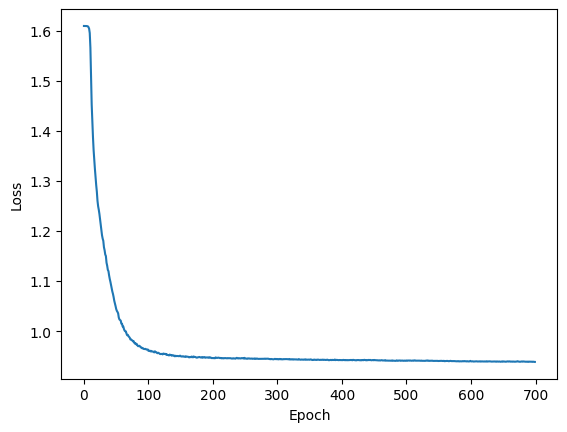

Test accuracy: 464.8215053763441
Accuracy: 0.4834408602150538
Precision: 0.5045006191862831
Recall: 0.48253048859014697
F1-score: 0.49054506558448036


Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.56      0.61       495
           1       0.47      0.48      0.48       472
           2       0.36      0.40      0.38       449
           3       0.33      0.39      0.36       463
           4       0.69      0.58      0.63       446

    accuracy                           0.48      2325
   macro avg       0.50      0.48      0.49      2325
weighted avg       0.51      0.48      0.49      2325

                    0           1           2           3           4  \
precision    0.674757    0.468172    0.355865    0.329114    0.694595   
recall       0.561616    0.483051    0.398664    0.393089    0.576233   
f1-score     0.613010    0.475495    0.376050    0.358268    0.629902   
support    495.000000  472.000000  449.00000

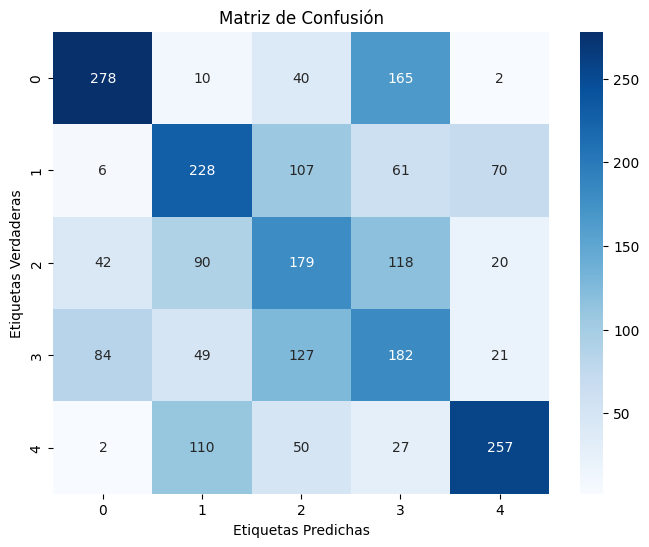

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_700_1e-05_0.3/resultados_700_1e-05_0.3.json
Procesando red con 1000 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas:   0%|                                                              | 1/1000 [00:02<44:45,  2.69s/it]

1.6089712248129002


Procesando epocas:   0%|                                                              | 2/1000 [00:05<44:05,  2.65s/it]

1.5338949476971346


Procesando epocas:   0%|▏                                                             | 3/1000 [00:07<43:59,  2.65s/it]

1.420841939309064


Procesando epocas:   0%|▏                                                             | 4/1000 [00:10<43:54,  2.64s/it]

1.3560172894421745


Procesando epocas:   0%|▎                                                             | 5/1000 [00:13<43:50,  2.64s/it]

1.3100299035801608


Procesando epocas:   1%|▎                                                             | 6/1000 [00:15<43:47,  2.64s/it]

1.2572657101294573


Procesando epocas:   1%|▍                                                             | 7/1000 [00:18<43:46,  2.65s/it]

1.2323273378259996


Procesando epocas:   1%|▍                                                             | 8/1000 [00:21<43:35,  2.64s/it]

1.202737288615283


Procesando epocas:   1%|▌                                                             | 9/1000 [00:23<43:33,  2.64s/it]

1.1769695310031667


Procesando epocas:   1%|▌                                                            | 10/1000 [00:26<43:34,  2.64s/it]

1.1533698460635018


Procesando epocas:   1%|▋                                                            | 11/1000 [00:29<43:34,  2.64s/it]

1.1244100567172555


Procesando epocas:   1%|▋                                                            | 12/1000 [00:31<43:28,  2.64s/it]

1.1083782385377323


Procesando epocas:   1%|▊                                                            | 13/1000 [00:34<43:25,  2.64s/it]

1.090804288667791


Procesando epocas:   1%|▊                                                            | 14/1000 [00:36<43:21,  2.64s/it]

1.0803733713486616


Procesando epocas:   2%|▉                                                            | 15/1000 [00:39<43:23,  2.64s/it]

1.0748175105627846


Procesando epocas:   2%|▉                                                            | 16/1000 [00:42<43:18,  2.64s/it]

1.0637989208978764


Procesando epocas:   2%|█                                                            | 17/1000 [00:44<43:11,  2.64s/it]

1.0504818681408377


Procesando epocas:   2%|█                                                            | 18/1000 [00:47<43:10,  2.64s/it]

1.0448874189573176


Procesando epocas:   2%|█▏                                                           | 19/1000 [00:50<43:12,  2.64s/it]

1.0439505556050468


Procesando epocas:   2%|█▏                                                           | 20/1000 [00:52<43:10,  2.64s/it]

1.038419447225683


Procesando epocas:   2%|█▎                                                           | 21/1000 [00:55<43:05,  2.64s/it]

1.0344724111697252


Procesando epocas:   2%|█▎                                                           | 22/1000 [00:58<43:02,  2.64s/it]

1.036189585573533


Procesando epocas:   2%|█▍                                                           | 23/1000 [01:00<42:58,  2.64s/it]

1.0326752245426178


Procesando epocas:   2%|█▍                                                           | 24/1000 [01:03<42:59,  2.64s/it]

1.0350163217853097


Procesando epocas:   2%|█▌                                                           | 25/1000 [01:06<42:56,  2.64s/it]

1.030438951183768


Procesando epocas:   3%|█▌                                                           | 26/1000 [01:08<42:53,  2.64s/it]

1.0323981775956996


Procesando epocas:   3%|█▋                                                           | 27/1000 [01:11<42:51,  2.64s/it]

1.0307070661993587


Procesando epocas:   3%|█▋                                                           | 28/1000 [01:13<42:48,  2.64s/it]

1.02534380625276


Procesando epocas:   3%|█▊                                                           | 29/1000 [01:16<42:46,  2.64s/it]

1.028031929100261


Procesando epocas:   3%|█▊                                                           | 30/1000 [01:19<42:40,  2.64s/it]

1.030917598219479


Procesando epocas:   3%|█▉                                                           | 31/1000 [01:21<42:32,  2.63s/it]

1.0282478045014773


Procesando epocas:   3%|█▉                                                           | 32/1000 [01:24<42:27,  2.63s/it]

1.029310857548433


Procesando epocas:   3%|██                                                           | 33/1000 [01:27<42:23,  2.63s/it]

1.0282146397758933


Procesando epocas:   3%|██                                                           | 34/1000 [01:29<42:16,  2.63s/it]

1.0207069961463704


Procesando epocas:   4%|██▏                                                          | 35/1000 [01:32<42:16,  2.63s/it]

1.0200282843673931


Procesando epocas:   4%|██▏                                                          | 36/1000 [01:35<42:14,  2.63s/it]

1.0194387046729818


Procesando epocas:   4%|██▎                                                          | 37/1000 [01:37<42:10,  2.63s/it]

1.0164170668405645


Procesando epocas:   4%|██▎                                                          | 38/1000 [01:40<42:05,  2.63s/it]

1.0184193604132707


Procesando epocas:   4%|██▍                                                          | 39/1000 [01:42<42:07,  2.63s/it]

1.015990552481483


Procesando epocas:   4%|██▍                                                          | 40/1000 [01:45<42:05,  2.63s/it]

1.0196592309895685


Procesando epocas:   4%|██▌                                                          | 41/1000 [01:48<41:59,  2.63s/it]

1.019011399675818


Procesando epocas:   4%|██▌                                                          | 42/1000 [01:50<41:50,  2.62s/it]

1.0226310130427865


Procesando epocas:   4%|██▌                                                          | 43/1000 [01:53<41:44,  2.62s/it]

1.0217661657754114


Procesando epocas:   4%|██▋                                                          | 44/1000 [01:55<41:47,  2.62s/it]

1.0256767465787775


Procesando epocas:   4%|██▋                                                          | 45/1000 [01:58<41:42,  2.62s/it]

1.0231866215958314


Procesando epocas:   5%|██▊                                                          | 46/1000 [02:01<41:40,  2.62s/it]

1.0217326844439787


Procesando epocas:   5%|██▊                                                          | 47/1000 [02:03<41:40,  2.62s/it]

1.0194975933607886


Procesando epocas:   5%|██▉                                                          | 48/1000 [02:06<41:36,  2.62s/it]

1.0189510969554676


Procesando epocas:   5%|██▉                                                          | 49/1000 [02:09<41:33,  2.62s/it]

1.0165903270244598


Procesando epocas:   5%|███                                                          | 50/1000 [02:11<41:30,  2.62s/it]

1.015521145217559


Procesando epocas:   5%|███                                                          | 51/1000 [02:14<41:27,  2.62s/it]

1.0141046015655293


Procesando epocas:   5%|███▏                                                         | 52/1000 [02:16<41:31,  2.63s/it]

1.0156480929430793


Procesando epocas:   5%|███▏                                                         | 53/1000 [02:19<41:27,  2.63s/it]

1.0147417668034049


Procesando epocas:   5%|███▎                                                         | 54/1000 [02:22<41:22,  2.62s/it]

1.0132393984233632


Procesando epocas:   6%|███▎                                                         | 55/1000 [02:24<41:18,  2.62s/it]

1.011898130529067


Procesando epocas:   6%|███▍                                                         | 56/1000 [02:27<41:16,  2.62s/it]

1.0111690132056965


Procesando epocas:   6%|███▍                                                         | 57/1000 [02:30<41:15,  2.63s/it]

1.0112020355813645


Procesando epocas:   6%|███▌                                                         | 58/1000 [02:32<41:09,  2.62s/it]

1.0170749972848332


Procesando epocas:   6%|███▌                                                         | 59/1000 [02:35<41:10,  2.63s/it]

1.0191724517766168


Procesando epocas:   6%|███▋                                                         | 60/1000 [02:37<41:10,  2.63s/it]

1.016555785080966


Procesando epocas:   6%|███▋                                                         | 61/1000 [02:40<41:11,  2.63s/it]

1.0115694792831644


Procesando epocas:   6%|███▊                                                         | 62/1000 [02:43<41:07,  2.63s/it]

1.009034095441594


Procesando epocas:   6%|███▊                                                         | 63/1000 [02:45<41:08,  2.63s/it]

1.0098064720630646


Procesando epocas:   6%|███▉                                                         | 64/1000 [02:48<40:59,  2.63s/it]

1.0079850519404692


Procesando epocas:   6%|███▉                                                         | 65/1000 [02:51<40:54,  2.63s/it]

1.0083450275308945


Procesando epocas:   7%|████                                                         | 66/1000 [02:53<40:49,  2.62s/it]

1.00844423735843


Procesando epocas:   7%|████                                                         | 67/1000 [02:56<40:40,  2.62s/it]

1.009132093892378


Procesando epocas:   7%|████▏                                                        | 68/1000 [02:58<40:39,  2.62s/it]

1.0123259933555828


Procesando epocas:   7%|████▏                                                        | 69/1000 [03:01<40:37,  2.62s/it]

1.0108665848479552


Procesando epocas:   7%|████▎                                                        | 70/1000 [03:04<40:35,  2.62s/it]

1.0092324197292328


Procesando epocas:   7%|████▎                                                        | 71/1000 [03:06<40:33,  2.62s/it]

1.0089349266360788


Procesando epocas:   7%|████▍                                                        | 72/1000 [03:09<40:31,  2.62s/it]

1.0102768912034876


Procesando epocas:   7%|████▍                                                        | 73/1000 [03:12<40:26,  2.62s/it]

1.0079090619788451


Procesando epocas:   7%|████▌                                                        | 74/1000 [03:14<40:22,  2.62s/it]

1.0069000159992891


Procesando epocas:   8%|████▌                                                        | 75/1000 [03:17<40:19,  2.62s/it]

1.0057725478621091


Procesando epocas:   8%|████▋                                                        | 76/1000 [03:19<40:14,  2.61s/it]

1.0026454953586355


Procesando epocas:   8%|████▋                                                        | 77/1000 [03:22<40:07,  2.61s/it]

1.005010894466849


Procesando epocas:   8%|████▊                                                        | 78/1000 [03:25<40:02,  2.61s/it]

1.0088362385244931


Procesando epocas:   8%|████▊                                                        | 79/1000 [03:27<40:04,  2.61s/it]

1.0124560731298784


Procesando epocas:   8%|████▉                                                        | 80/1000 [03:30<40:05,  2.61s/it]

1.010536974668503


Procesando epocas:   8%|████▉                                                        | 81/1000 [03:32<40:04,  2.62s/it]

1.0057906652198119


Procesando epocas:   8%|█████                                                        | 82/1000 [03:35<40:01,  2.62s/it]

1.0039098960511825


Procesando epocas:   8%|█████                                                        | 83/1000 [03:38<40:03,  2.62s/it]

1.0089638818712796


Procesando epocas:   8%|█████                                                        | 84/1000 [03:40<39:59,  2.62s/it]

1.0056184007840998


Procesando epocas:   8%|█████▏                                                       | 85/1000 [03:43<39:56,  2.62s/it]

1.0008714149979985


Procesando epocas:   9%|█████▏                                                       | 86/1000 [03:46<39:52,  2.62s/it]

1.0012737358317656


Procesando epocas:   9%|█████▎                                                       | 87/1000 [03:48<39:48,  2.62s/it]

1.00007785523639


Procesando epocas:   9%|█████▎                                                       | 88/1000 [03:51<39:45,  2.62s/it]

1.0010515500517452


Procesando epocas:   9%|█████▍                                                       | 89/1000 [03:53<39:40,  2.61s/it]

1.002264273517272


Procesando epocas:   9%|█████▍                                                       | 90/1000 [03:56<39:36,  2.61s/it]

1.0048092628226561


Procesando epocas:   9%|█████▌                                                       | 91/1000 [03:59<39:36,  2.61s/it]

1.0024139390272253


Procesando epocas:   9%|█████▌                                                       | 92/1000 [04:01<39:34,  2.61s/it]

1.0044905224267173


Procesando epocas:   9%|█████▋                                                       | 93/1000 [04:04<39:35,  2.62s/it]

1.0054945707321168


Procesando epocas:   9%|█████▋                                                       | 94/1000 [04:06<39:36,  2.62s/it]

1.0027272119241601


Procesando epocas:  10%|█████▊                                                       | 95/1000 [04:09<39:47,  2.64s/it]

1.00527903472676


Procesando epocas:  10%|█████▊                                                       | 96/1000 [04:12<39:57,  2.65s/it]

1.0034443087437575


Procesando epocas:  10%|█████▉                                                       | 97/1000 [04:15<40:01,  2.66s/it]

1.000679008399739


Procesando epocas:  10%|█████▉                                                       | 98/1000 [04:17<40:04,  2.67s/it]

1.0013211383539087


Procesando epocas:  10%|██████                                                       | 99/1000 [04:20<40:02,  2.67s/it]

1.0015368808718288


Procesando epocas:  10%|██████                                                      | 100/1000 [04:23<39:57,  2.66s/it]

1.001245078269173


Procesando epocas:  10%|██████                                                      | 101/1000 [04:25<39:53,  2.66s/it]

0.9974943287232343


Procesando epocas:  10%|██████                                                      | 102/1000 [04:28<39:53,  2.67s/it]

0.9965907980413998


Procesando epocas:  10%|██████▏                                                     | 103/1000 [04:31<39:50,  2.67s/it]

1.0010558457935557


Procesando epocas:  10%|██████▏                                                     | 104/1000 [04:33<39:46,  2.66s/it]

0.9988867636989145


Procesando epocas:  10%|██████▎                                                     | 105/1000 [04:36<39:43,  2.66s/it]

0.9944458638920504


Procesando epocas:  11%|██████▎                                                     | 106/1000 [04:39<39:40,  2.66s/it]

0.9968952175448923


Procesando epocas:  11%|██████▍                                                     | 107/1000 [04:41<39:40,  2.67s/it]

1.0028121222467983


Procesando epocas:  11%|██████▍                                                     | 108/1000 [04:44<39:34,  2.66s/it]

0.999751841320711


Procesando epocas:  11%|██████▌                                                     | 109/1000 [04:47<39:31,  2.66s/it]

0.9996093739481533


Procesando epocas:  11%|██████▌                                                     | 110/1000 [04:49<39:27,  2.66s/it]

0.9984939178999732


Procesando epocas:  11%|██████▋                                                     | 111/1000 [04:52<39:22,  2.66s/it]

0.9978754253948436


Procesando epocas:  11%|██████▋                                                     | 112/1000 [04:54<39:20,  2.66s/it]

0.9982642030014711


Procesando epocas:  11%|██████▊                                                     | 113/1000 [04:57<39:17,  2.66s/it]

0.998364212583093


Procesando epocas:  11%|██████▊                                                     | 114/1000 [05:00<39:18,  2.66s/it]

0.9960657424786512


Procesando epocas:  12%|██████▉                                                     | 115/1000 [05:02<39:18,  2.66s/it]

0.994824481010437


Procesando epocas:  12%|██████▉                                                     | 116/1000 [05:05<39:15,  2.66s/it]

0.9956622989738688


Procesando epocas:  12%|███████                                                     | 117/1000 [05:08<39:15,  2.67s/it]

0.9961734663037692


Procesando epocas:  12%|███████                                                     | 118/1000 [05:10<39:08,  2.66s/it]

0.9981052174287683


Procesando epocas:  12%|███████▏                                                    | 119/1000 [05:13<39:01,  2.66s/it]

0.9990155714399674


Procesando epocas:  12%|███████▏                                                    | 120/1000 [05:16<39:01,  2.66s/it]

0.9958733814604143


Procesando epocas:  12%|███████▎                                                    | 121/1000 [05:18<38:51,  2.65s/it]

0.9961651767001433


Procesando epocas:  12%|███████▎                                                    | 122/1000 [05:21<38:43,  2.65s/it]

0.9979225632022409


Procesando epocas:  12%|███████▍                                                    | 123/1000 [05:24<38:43,  2.65s/it]

0.9946716596098507


Procesando epocas:  12%|███████▍                                                    | 124/1000 [05:26<38:41,  2.65s/it]

0.9945695964729084


Procesando epocas:  12%|███████▌                                                    | 125/1000 [05:29<38:38,  2.65s/it]

0.9960980478455038


Procesando epocas:  13%|███████▌                                                    | 126/1000 [05:32<38:35,  2.65s/it]

0.9958487833247466


Procesando epocas:  13%|███████▌                                                    | 127/1000 [05:34<38:29,  2.65s/it]

0.9953930332380183


Procesando epocas:  13%|███████▋                                                    | 128/1000 [05:37<38:21,  2.64s/it]

0.9950874991276685


Procesando epocas:  13%|███████▋                                                    | 129/1000 [05:40<38:17,  2.64s/it]

0.9954890181036556


Procesando epocas:  13%|███████▊                                                    | 130/1000 [05:42<38:10,  2.63s/it]

0.9976304296184989


Procesando epocas:  13%|███████▊                                                    | 131/1000 [05:45<38:09,  2.64s/it]

0.994377656543956


Procesando epocas:  13%|███████▉                                                    | 132/1000 [05:47<38:09,  2.64s/it]

0.9979258516255547


Procesando epocas:  13%|███████▉                                                    | 133/1000 [05:50<38:05,  2.64s/it]

0.996742484850042


Procesando epocas:  13%|████████                                                    | 134/1000 [05:53<37:59,  2.63s/it]

0.9954185268458198


Procesando epocas:  14%|████████                                                    | 135/1000 [05:55<37:56,  2.63s/it]

0.9947462737560272


Procesando epocas:  14%|████████▏                                                   | 136/1000 [05:58<37:54,  2.63s/it]

0.9937478314427769


Procesando epocas:  14%|████████▏                                                   | 137/1000 [06:01<37:54,  2.64s/it]

0.9934755465563606


Procesando epocas:  14%|████████▎                                                   | 138/1000 [06:03<37:47,  2.63s/it]

0.9944719840498532


Procesando epocas:  14%|████████▎                                                   | 139/1000 [06:06<37:46,  2.63s/it]

0.9943273204214432


Procesando epocas:  14%|████████▍                                                   | 140/1000 [06:09<37:47,  2.64s/it]

0.9926322000868181


Procesando epocas:  14%|████████▍                                                   | 141/1000 [06:11<37:45,  2.64s/it]

0.9944336638731115


Procesando epocas:  14%|████████▌                                                   | 142/1000 [06:14<37:40,  2.64s/it]

0.9927668634582968


Procesando epocas:  14%|████████▌                                                   | 143/1000 [06:16<37:41,  2.64s/it]

0.9930623261367574


Procesando epocas:  14%|████████▋                                                   | 144/1000 [06:19<37:25,  2.62s/it]

0.9925321207327001


Procesando epocas:  14%|████████▋                                                   | 145/1000 [06:21<36:08,  2.54s/it]

0.9932149981751162


Procesando epocas:  15%|████████▊                                                   | 146/1000 [06:24<36:31,  2.57s/it]

0.9903996197616353


Procesando epocas:  15%|████████▊                                                   | 147/1000 [06:27<36:45,  2.59s/it]

0.9929798620588639


Procesando epocas:  15%|████████▉                                                   | 148/1000 [06:29<36:58,  2.60s/it]

0.9919743345064276


Procesando epocas:  15%|████████▉                                                   | 149/1000 [06:32<37:07,  2.62s/it]

0.9915776757632985


Procesando epocas:  15%|█████████                                                   | 150/1000 [06:35<37:04,  2.62s/it]

0.9897096549763399


Procesando epocas:  15%|█████████                                                   | 151/1000 [06:37<37:06,  2.62s/it]

0.9906308812253616


Procesando epocas:  15%|█████████                                                   | 152/1000 [06:40<37:09,  2.63s/it]

0.9932357199051801


Procesando epocas:  15%|█████████▏                                                  | 153/1000 [06:42<37:10,  2.63s/it]

0.9921807148877312


Procesando epocas:  15%|█████████▏                                                  | 154/1000 [06:45<37:09,  2.64s/it]

0.9904229448122137


Procesando epocas:  16%|█████████▎                                                  | 155/1000 [06:48<37:08,  2.64s/it]

0.9919916889246773


Procesando epocas:  16%|█████████▎                                                  | 156/1000 [06:50<37:05,  2.64s/it]

0.9934568769791547


Procesando epocas:  16%|█████████▍                                                  | 157/1000 [06:53<37:02,  2.64s/it]

0.9944111866109512


Procesando epocas:  16%|█████████▍                                                  | 158/1000 [06:56<36:57,  2.63s/it]

0.9965945706647985


Procesando epocas:  16%|█████████▌                                                  | 159/1000 [06:58<36:57,  2.64s/it]

0.9933625438634087


Procesando epocas:  16%|█████████▌                                                  | 160/1000 [07:01<36:55,  2.64s/it]

0.9981420590597041


Procesando epocas:  16%|█████████▋                                                  | 161/1000 [07:04<36:53,  2.64s/it]

0.9958781999700209


Procesando epocas:  16%|█████████▋                                                  | 162/1000 [07:06<36:49,  2.64s/it]

0.9949963134877822


Procesando epocas:  16%|█████████▊                                                  | 163/1000 [07:09<36:44,  2.63s/it]

0.9920317888259887


Procesando epocas:  16%|█████████▊                                                  | 164/1000 [07:11<36:43,  2.64s/it]

0.9901709612678079


Procesando epocas:  16%|█████████▉                                                  | 165/1000 [07:14<36:43,  2.64s/it]

0.989275604837081


Procesando epocas:  17%|█████████▉                                                  | 166/1000 [07:17<36:40,  2.64s/it]

0.9902999632498797


Procesando epocas:  17%|██████████                                                  | 167/1000 [07:19<36:36,  2.64s/it]

0.9894731241114


Procesando epocas:  17%|██████████                                                  | 168/1000 [07:22<36:33,  2.64s/it]

0.990654316369225


Procesando epocas:  17%|██████████▏                                                 | 169/1000 [07:25<36:33,  2.64s/it]

0.9934731290620916


Procesando epocas:  17%|██████████▏                                                 | 170/1000 [07:27<36:32,  2.64s/it]

0.9951084964415606


Procesando epocas:  17%|██████████▎                                                 | 171/1000 [07:30<36:32,  2.65s/it]

0.9887212286977207


Procesando epocas:  17%|██████████▎                                                 | 172/1000 [07:33<36:29,  2.64s/it]

0.9907711039571201


Procesando epocas:  17%|██████████▍                                                 | 173/1000 [07:35<36:29,  2.65s/it]

0.9889961985980763


Procesando epocas:  17%|██████████▍                                                 | 174/1000 [07:38<36:24,  2.64s/it]

0.9894969004042008


Procesando epocas:  18%|██████████▌                                                 | 175/1000 [07:41<36:17,  2.64s/it]

0.9879737527931438


Procesando epocas:  18%|██████████▌                                                 | 176/1000 [07:43<36:16,  2.64s/it]

0.987691236594144


Procesando epocas:  18%|██████████▌                                                 | 177/1000 [07:46<36:11,  2.64s/it]

0.9863972432473127


Procesando epocas:  18%|██████████▋                                                 | 178/1000 [07:48<36:07,  2.64s/it]

0.9891633559675778


Procesando epocas:  18%|██████████▋                                                 | 179/1000 [07:51<36:02,  2.63s/it]

0.9862318414099076


Procesando epocas:  18%|██████████▊                                                 | 180/1000 [07:54<35:57,  2.63s/it]

0.9871776349404279


Procesando epocas:  18%|██████████▊                                                 | 181/1000 [07:56<35:57,  2.63s/it]

0.9834498545702766


Procesando epocas:  18%|██████████▉                                                 | 182/1000 [07:59<35:53,  2.63s/it]

0.9835626889677609


Procesando epocas:  18%|██████████▉                                                 | 183/1000 [08:02<35:52,  2.63s/it]

0.9836188379456016


Procesando epocas:  18%|███████████                                                 | 184/1000 [08:04<35:49,  2.63s/it]

0.9836385765496423


Procesando epocas:  18%|███████████                                                 | 185/1000 [08:07<35:51,  2.64s/it]

0.9845426583991331


Procesando epocas:  19%|███████████▏                                                | 186/1000 [08:10<35:46,  2.64s/it]

0.9867136373239405


Procesando epocas:  19%|███████████▏                                                | 187/1000 [08:12<35:39,  2.63s/it]

0.9867311789708979


Procesando epocas:  19%|███████████▎                                                | 188/1000 [08:15<35:33,  2.63s/it]

0.9860308173824759


Procesando epocas:  19%|███████████▎                                                | 189/1000 [08:17<35:30,  2.63s/it]

0.9871051697170034


Procesando epocas:  19%|███████████▍                                                | 190/1000 [08:20<35:29,  2.63s/it]

0.9887529355638167


Procesando epocas:  19%|███████████▍                                                | 191/1000 [08:23<35:26,  2.63s/it]

0.9872580458136165


Procesando epocas:  19%|███████████▌                                                | 192/1000 [08:25<35:25,  2.63s/it]

0.9858859321650337


Procesando epocas:  19%|███████████▌                                                | 193/1000 [08:28<35:18,  2.63s/it]

0.9883148670196533


Procesando epocas:  19%|███████████▋                                                | 194/1000 [08:31<35:18,  2.63s/it]

0.9871982195798088


Procesando epocas:  20%|███████████▋                                                | 195/1000 [08:33<35:18,  2.63s/it]

0.9875596516272601


Procesando epocas:  20%|███████████▊                                                | 196/1000 [08:36<35:14,  2.63s/it]

0.987590516314787


Procesando epocas:  20%|███████████▊                                                | 197/1000 [08:38<35:15,  2.63s/it]

0.9857401248286752


Procesando epocas:  20%|███████████▉                                                | 198/1000 [08:41<35:10,  2.63s/it]

0.9894517169279211


Procesando epocas:  20%|███████████▉                                                | 199/1000 [08:44<35:06,  2.63s/it]

0.9886201322078705


Procesando epocas:  20%|████████████                                                | 200/1000 [08:46<35:01,  2.63s/it]

0.9881617100799784


Procesando epocas:  20%|████████████                                                | 201/1000 [08:49<34:58,  2.63s/it]

0.9882800186381621


Procesando epocas:  20%|████████████                                                | 202/1000 [08:52<34:52,  2.62s/it]

0.9887201459968791


Procesando epocas:  20%|████████████▏                                               | 203/1000 [08:54<34:46,  2.62s/it]

0.9871562442358802


Procesando epocas:  20%|████████████▏                                               | 204/1000 [08:57<34:43,  2.62s/it]

0.9853858698816861


Procesando epocas:  20%|████████████▎                                               | 205/1000 [08:59<34:39,  2.62s/it]

0.9844341740888708


Procesando epocas:  21%|████████████▎                                               | 206/1000 [09:02<34:35,  2.61s/it]

0.9819128962124095


Procesando epocas:  21%|████████████▍                                               | 207/1000 [09:05<34:30,  2.61s/it]

0.9823656197856454


Procesando epocas:  21%|████████████▍                                               | 208/1000 [09:07<34:27,  2.61s/it]

0.9815978463958291


Procesando epocas:  21%|████████████▌                                               | 209/1000 [09:10<34:30,  2.62s/it]

0.9813432826715357


Procesando epocas:  21%|████████████▌                                               | 210/1000 [09:12<34:27,  2.62s/it]

0.9810786611893598


Procesando epocas:  21%|████████████▋                                               | 211/1000 [09:15<34:21,  2.61s/it]

0.9807611525058746


Procesando epocas:  21%|████████████▋                                               | 212/1000 [09:18<34:18,  2.61s/it]

0.9821527835200815


Procesando epocas:  21%|████████████▊                                               | 213/1000 [09:20<34:16,  2.61s/it]

0.9815532761461595


Procesando epocas:  21%|████████████▊                                               | 214/1000 [09:23<34:11,  2.61s/it]

0.9838872678139631


Procesando epocas:  22%|████████████▉                                               | 215/1000 [09:25<34:07,  2.61s/it]

0.9820091619211084


Procesando epocas:  22%|████████████▉                                               | 216/1000 [09:28<34:04,  2.61s/it]

0.9854673588977141


Procesando epocas:  22%|█████████████                                               | 217/1000 [09:31<34:00,  2.61s/it]

0.9880474939065821


Procesando epocas:  22%|█████████████                                               | 218/1000 [09:33<34:01,  2.61s/it]

0.9927631188841427


Procesando epocas:  22%|█████████████▏                                              | 219/1000 [09:36<34:00,  2.61s/it]

0.9894767571898068


Procesando epocas:  22%|█████████████▏                                              | 220/1000 [09:39<34:00,  2.62s/it]

0.9878307048012228


Procesando epocas:  22%|█████████████▎                                              | 221/1000 [09:41<33:58,  2.62s/it]

0.9878108490915859


Procesando epocas:  22%|█████████████▎                                              | 222/1000 [09:44<34:09,  2.63s/it]

0.9878031730651855


Procesando epocas:  22%|█████████████▍                                              | 223/1000 [09:47<34:17,  2.65s/it]

0.9857664820025949


Procesando epocas:  22%|█████████████▍                                              | 224/1000 [09:49<34:19,  2.65s/it]

0.9871100050561569


Procesando epocas:  22%|█████████████▌                                              | 225/1000 [09:52<34:24,  2.66s/it]

0.9889020926812115


Procesando epocas:  23%|█████████████▌                                              | 226/1000 [09:55<34:28,  2.67s/it]

0.9857747214681962


Procesando epocas:  23%|█████████████▌                                              | 227/1000 [09:57<34:29,  2.68s/it]

0.9857385225155775


Procesando epocas:  23%|█████████████▋                                              | 228/1000 [10:00<34:27,  2.68s/it]

0.9847367248114418


Procesando epocas:  23%|█████████████▋                                              | 229/1000 [10:03<34:23,  2.68s/it]

0.9827568001606886


Procesando epocas:  23%|█████████████▊                                              | 230/1000 [10:05<34:21,  2.68s/it]

0.981860610667397


Procesando epocas:  23%|█████████████▊                                              | 231/1000 [10:08<34:18,  2.68s/it]

0.9819093406200409


Procesando epocas:  23%|█████████████▉                                              | 232/1000 [10:11<34:15,  2.68s/it]

0.9857221554307377


Procesando epocas:  23%|█████████████▉                                              | 233/1000 [10:13<34:16,  2.68s/it]

0.9868016001056222


Procesando epocas:  23%|██████████████                                              | 234/1000 [10:16<34:15,  2.68s/it]

0.9839859685477088


Procesando epocas:  24%|██████████████                                              | 235/1000 [10:19<34:09,  2.68s/it]

0.9819500667207381


Procesando epocas:  24%|██████████████▏                                             | 236/1000 [10:21<34:07,  2.68s/it]

0.9817536876482122


Procesando epocas:  24%|██████████████▏                                             | 237/1000 [10:24<34:07,  2.68s/it]

0.9821820245069616


Procesando epocas:  24%|██████████████▎                                             | 238/1000 [10:27<34:02,  2.68s/it]

0.9831866453675663


Procesando epocas:  24%|██████████████▎                                             | 239/1000 [10:29<34:00,  2.68s/it]

0.9800826938713298


Procesando epocas:  24%|██████████████▍                                             | 240/1000 [10:32<33:57,  2.68s/it]

0.9789180720553678


Procesando epocas:  24%|██████████████▍                                             | 241/1000 [10:35<33:53,  2.68s/it]

0.9785320432747111


Procesando epocas:  24%|██████████████▌                                             | 242/1000 [10:37<33:53,  2.68s/it]

0.9803655733080471


Procesando epocas:  24%|██████████████▌                                             | 243/1000 [10:40<33:49,  2.68s/it]

0.9795217671815086


Procesando epocas:  24%|██████████████▋                                             | 244/1000 [10:43<33:48,  2.68s/it]

0.9794310029815225


Procesando epocas:  24%|██████████████▋                                             | 245/1000 [10:46<33:43,  2.68s/it]

0.9801247779060812


Procesando epocas:  25%|██████████████▊                                             | 246/1000 [10:48<33:41,  2.68s/it]

0.9806809432366315


Procesando epocas:  25%|██████████████▊                                             | 247/1000 [10:51<33:37,  2.68s/it]

0.9845939054208643


Procesando epocas:  25%|██████████████▉                                             | 248/1000 [10:54<33:33,  2.68s/it]

0.9807164104545818


Procesando epocas:  25%|██████████████▉                                             | 249/1000 [10:56<33:28,  2.67s/it]

0.9807103076401879


Procesando epocas:  25%|███████████████                                             | 250/1000 [10:59<33:28,  2.68s/it]

0.978987440291573


Procesando epocas:  25%|███████████████                                             | 251/1000 [11:02<33:26,  2.68s/it]

0.9808979241287007


Procesando epocas:  25%|███████████████                                             | 252/1000 [11:04<33:26,  2.68s/it]

0.9801498346468982


Procesando epocas:  25%|███████████████▏                                            | 253/1000 [11:07<33:23,  2.68s/it]

0.9809022072483512


Procesando epocas:  25%|███████████████▏                                            | 254/1000 [11:10<33:14,  2.67s/it]

0.9795461142764372


Procesando epocas:  26%|███████████████▎                                            | 255/1000 [11:12<33:04,  2.66s/it]

0.9786649300771602


Procesando epocas:  26%|███████████████▎                                            | 256/1000 [11:15<32:57,  2.66s/it]

0.9797703536117778


Procesando epocas:  26%|███████████████▍                                            | 257/1000 [11:18<32:53,  2.66s/it]

0.9786326443447786


Procesando epocas:  26%|███████████████▍                                            | 258/1000 [11:20<32:49,  2.65s/it]

0.9774939393295962


Procesando epocas:  26%|███████████████▌                                            | 259/1000 [11:23<32:45,  2.65s/it]

0.9796384990215301


Procesando epocas:  26%|███████████████▌                                            | 260/1000 [11:25<32:40,  2.65s/it]

0.977848826787051


Procesando epocas:  26%|███████████████▋                                            | 261/1000 [11:28<32:39,  2.65s/it]

0.9772638895932366


Procesando epocas:  26%|███████████████▋                                            | 262/1000 [11:31<32:33,  2.65s/it]

0.9793232086826773


Procesando epocas:  26%|███████████████▊                                            | 263/1000 [11:33<32:28,  2.64s/it]

0.9797431935282315


Procesando epocas:  26%|███████████████▊                                            | 264/1000 [11:36<32:24,  2.64s/it]

0.9814726948738098


Procesando epocas:  26%|███████████████▉                                            | 265/1000 [11:39<32:24,  2.65s/it]

0.9796165336580838


Procesando epocas:  27%|███████████████▉                                            | 266/1000 [11:41<32:22,  2.65s/it]

0.9805699460646685


Procesando epocas:  27%|████████████████                                            | 267/1000 [11:44<32:20,  2.65s/it]

0.9791488587856293


Procesando epocas:  27%|████████████████                                            | 268/1000 [11:47<32:17,  2.65s/it]

0.9777097372447743


Procesando epocas:  27%|████████████████▏                                           | 269/1000 [11:49<32:13,  2.64s/it]

0.9777236987562741


Procesando epocas:  27%|████████████████▏                                           | 270/1000 [11:52<32:09,  2.64s/it]

0.9764112507595736


Procesando epocas:  27%|████████████████▎                                           | 271/1000 [11:55<32:07,  2.64s/it]

0.9766029641908758


Procesando epocas:  27%|████████████████▎                                           | 272/1000 [11:57<32:03,  2.64s/it]

0.9771774134215186


Procesando epocas:  27%|████████████████▍                                           | 273/1000 [12:00<32:00,  2.64s/it]

0.9778252236983356


Procesando epocas:  27%|████████████████▍                                           | 274/1000 [12:02<31:59,  2.64s/it]

0.9781131113276762


Procesando epocas:  28%|████████████████▌                                           | 275/1000 [12:05<31:59,  2.65s/it]

0.9783645146033343


Procesando epocas:  28%|████████████████▌                                           | 276/1000 [12:08<31:56,  2.65s/it]

0.9848579645156861


Procesando epocas:  28%|████████████████▌                                           | 277/1000 [12:10<31:50,  2.64s/it]

0.978505493963466


Procesando epocas:  28%|████████████████▋                                           | 278/1000 [12:13<31:45,  2.64s/it]

0.9784577422282275


Procesando epocas:  28%|████████████████▋                                           | 279/1000 [12:16<31:42,  2.64s/it]

0.981690292148029


Procesando epocas:  28%|████████████████▊                                           | 280/1000 [12:18<31:38,  2.64s/it]

0.980436260209364


Procesando epocas:  28%|████████████████▊                                           | 281/1000 [12:21<31:33,  2.63s/it]

0.9815532842103173


Procesando epocas:  28%|████████████████▉                                           | 282/1000 [12:24<31:28,  2.63s/it]

0.9820105107391581


Procesando epocas:  28%|████████████████▉                                           | 283/1000 [12:26<31:25,  2.63s/it]

0.9827457150992225


Procesando epocas:  28%|█████████████████                                           | 284/1000 [12:29<31:21,  2.63s/it]

0.9791205704212189


Procesando epocas:  28%|█████████████████                                           | 285/1000 [12:31<31:18,  2.63s/it]

0.9779456773224999


Procesando epocas:  29%|█████████████████▏                                          | 286/1000 [12:34<31:16,  2.63s/it]

0.9794833590002621


Procesando epocas:  29%|█████████████████▏                                          | 287/1000 [12:37<31:12,  2.63s/it]

0.9790804249398849


Procesando epocas:  29%|█████████████████▎                                          | 288/1000 [12:39<31:11,  2.63s/it]

0.9781080231947057


Procesando epocas:  29%|█████████████████▎                                          | 289/1000 [12:42<31:06,  2.63s/it]

0.9791848445639891


Procesando epocas:  29%|█████████████████▍                                          | 290/1000 [12:45<31:04,  2.63s/it]

0.9774684867438148


Procesando epocas:  29%|█████████████████▍                                          | 291/1000 [12:47<30:59,  2.62s/it]

0.9799191320643705


Procesando epocas:  29%|█████████████████▌                                          | 292/1000 [12:50<30:58,  2.62s/it]

0.9769295829183915


Procesando epocas:  29%|█████████████████▌                                          | 293/1000 [12:52<30:57,  2.63s/it]

0.9795379326624029


Procesando epocas:  29%|█████████████████▋                                          | 294/1000 [12:55<30:51,  2.62s/it]

0.9795698569101445


Procesando epocas:  30%|█████████████████▋                                          | 295/1000 [12:58<30:47,  2.62s/it]

0.9825466243659748


Procesando epocas:  30%|█████████████████▊                                          | 296/1000 [13:00<30:46,  2.62s/it]

0.983056792792152


Procesando epocas:  30%|█████████████████▊                                          | 297/1000 [13:03<30:44,  2.62s/it]

0.9809038674130159


Procesando epocas:  30%|█████████████████▉                                          | 298/1000 [13:06<30:46,  2.63s/it]

0.9820747333414415


Procesando epocas:  30%|█████████████████▉                                          | 299/1000 [13:08<30:45,  2.63s/it]

0.9814635662471547


Procesando epocas:  30%|██████████████████                                          | 300/1000 [13:11<30:40,  2.63s/it]

0.9806356934940114


Procesando epocas:  30%|██████████████████                                          | 301/1000 [13:13<30:37,  2.63s/it]

0.9800959345172433


Procesando epocas:  30%|██████████████████                                          | 302/1000 [13:16<30:34,  2.63s/it]

0.9798869111958672


Procesando epocas:  30%|██████████████████▏                                         | 303/1000 [13:19<30:35,  2.63s/it]

0.9812610570122214


Procesando epocas:  30%|██████████████████▏                                         | 304/1000 [13:21<30:28,  2.63s/it]

0.9801733016967773


Procesando epocas:  30%|██████████████████▎                                         | 305/1000 [13:24<30:28,  2.63s/it]

0.9790743042440976


Procesando epocas:  31%|██████████████████▎                                         | 306/1000 [13:27<30:29,  2.64s/it]

0.9787582835730384


Procesando epocas:  31%|██████████████████▍                                         | 307/1000 [13:29<30:27,  2.64s/it]

0.9782547284575069


Procesando epocas:  31%|██████████████████▍                                         | 308/1000 [13:32<30:24,  2.64s/it]

0.9784796336117912


Procesando epocas:  31%|██████████████████▌                                         | 309/1000 [13:35<30:19,  2.63s/it]

0.9785094275194056


Procesando epocas:  31%|██████████████████▌                                         | 310/1000 [13:37<30:17,  2.63s/it]

0.9786800296867595


Procesando epocas:  31%|██████████████████▋                                         | 311/1000 [13:40<30:15,  2.63s/it]

0.9768898932372823


Procesando epocas:  31%|██████████████████▋                                         | 312/1000 [13:42<30:13,  2.64s/it]

0.9782764427802142


Procesando epocas:  31%|██████████████████▊                                         | 313/1000 [13:45<30:11,  2.64s/it]

0.9781621957526487


Procesando epocas:  31%|██████████████████▊                                         | 314/1000 [13:48<30:08,  2.64s/it]

0.9774376799078549


Procesando epocas:  32%|██████████████████▉                                         | 315/1000 [13:50<30:05,  2.64s/it]

0.9758515989079195


Procesando epocas:  32%|██████████████████▉                                         | 316/1000 [13:53<29:58,  2.63s/it]

0.9777256453738493


Procesando epocas:  32%|███████████████████                                         | 317/1000 [13:56<29:55,  2.63s/it]

0.9783743037896998


Procesando epocas:  32%|███████████████████                                         | 318/1000 [13:58<29:51,  2.63s/it]

0.9794326294870938


Procesando epocas:  32%|███████████████████▏                                        | 319/1000 [14:01<29:49,  2.63s/it]

0.9800555902368883


Procesando epocas:  32%|███████████████████▏                                        | 320/1000 [14:04<29:49,  2.63s/it]

0.9862420222338508


Procesando epocas:  32%|███████████████████▎                                        | 321/1000 [14:06<29:44,  2.63s/it]

0.9817374934168422


Procesando epocas:  32%|███████████████████▎                                        | 322/1000 [14:09<29:44,  2.63s/it]

0.9810217990594752


Procesando epocas:  32%|███████████████████▍                                        | 323/1000 [14:11<29:36,  2.62s/it]

0.9789136406253366


Procesando epocas:  32%|███████████████████▍                                        | 324/1000 [14:14<29:34,  2.62s/it]

0.977296467037762


Procesando epocas:  32%|███████████████████▌                                        | 325/1000 [14:17<29:28,  2.62s/it]

0.979591697103837


Procesando epocas:  33%|███████████████████▌                                        | 326/1000 [14:19<29:26,  2.62s/it]

0.9781690516892602


Procesando epocas:  33%|███████████████████▌                                        | 327/1000 [14:22<29:23,  2.62s/it]

0.9775148160317365


Procesando epocas:  33%|███████████████████▋                                        | 328/1000 [14:24<29:17,  2.61s/it]

0.9782468070002163


Procesando epocas:  33%|███████████████████▋                                        | 329/1000 [14:27<29:15,  2.62s/it]

0.9771501923308653


Procesando epocas:  33%|███████████████████▊                                        | 330/1000 [14:30<29:16,  2.62s/it]

0.9751138325999765


Procesando epocas:  33%|███████████████████▊                                        | 331/1000 [14:32<29:16,  2.63s/it]

0.9783361753996681


Procesando epocas:  33%|███████████████████▉                                        | 332/1000 [14:35<29:13,  2.63s/it]

0.9783566408297595


Procesando epocas:  33%|███████████████████▉                                        | 333/1000 [14:38<29:10,  2.62s/it]

0.9764120396445779


Procesando epocas:  33%|████████████████████                                        | 334/1000 [14:40<29:04,  2.62s/it]

0.9754802973831401


Procesando epocas:  34%|████████████████████                                        | 335/1000 [14:43<29:01,  2.62s/it]

0.9756265710381901


Procesando epocas:  34%|████████████████████▏                                       | 336/1000 [14:45<28:59,  2.62s/it]

0.9771000613184536


Procesando epocas:  34%|████████████████████▏                                       | 337/1000 [14:48<28:58,  2.62s/it]

0.977761279484805


Procesando epocas:  34%|████████████████████▎                                       | 338/1000 [14:51<28:58,  2.63s/it]

0.9761030127020444


Procesando epocas:  34%|████████████████████▎                                       | 339/1000 [14:53<28:56,  2.63s/it]

0.9740414454656489


Procesando epocas:  34%|████████████████████▍                                       | 340/1000 [14:56<28:53,  2.63s/it]

0.9749410580186283


Procesando epocas:  34%|████████████████████▍                                       | 341/1000 [14:59<28:51,  2.63s/it]

0.9769617911647348


Procesando epocas:  34%|████████████████████▌                                       | 342/1000 [15:01<28:49,  2.63s/it]

0.9755796397433562


Procesando epocas:  34%|████████████████████▌                                       | 343/1000 [15:04<28:46,  2.63s/it]

0.9751552364405464


Procesando epocas:  34%|████████████████████▋                                       | 344/1000 [15:06<28:46,  2.63s/it]

0.9759484399767483


Procesando epocas:  34%|████████████████████▋                                       | 345/1000 [15:09<28:43,  2.63s/it]

0.9746925848371842


Procesando epocas:  35%|████████████████████▊                                       | 346/1000 [15:12<28:42,  2.63s/it]

0.9735933384474587


Procesando epocas:  35%|████████████████████▊                                       | 347/1000 [15:14<28:40,  2.63s/it]

0.9744496513815487


Procesando epocas:  35%|████████████████████▉                                       | 348/1000 [15:17<28:44,  2.64s/it]

0.9754863293731914


Procesando epocas:  35%|████████████████████▉                                       | 349/1000 [15:20<28:45,  2.65s/it]

0.9751716249129352


Procesando epocas:  35%|█████████████████████                                       | 350/1000 [15:22<28:44,  2.65s/it]

0.9764364968327915


Procesando epocas:  35%|█████████████████████                                       | 351/1000 [15:25<28:46,  2.66s/it]

0.9767558578182669


Procesando epocas:  35%|█████████████████████                                       | 352/1000 [15:28<28:46,  2.67s/it]

0.9769537939744837


Procesando epocas:  35%|█████████████████████▏                                      | 353/1000 [15:30<28:44,  2.66s/it]

0.97722687756314


Procesando epocas:  35%|█████████████████████▏                                      | 354/1000 [15:33<28:42,  2.67s/it]

0.9741816769627963


Procesando epocas:  36%|█████████████████████▎                                      | 355/1000 [15:36<28:37,  2.66s/it]

0.9747438157305998


Procesando epocas:  36%|█████████████████████▎                                      | 356/1000 [15:38<28:32,  2.66s/it]

0.9741071988554562


Procesando epocas:  36%|█████████████████████▍                                      | 357/1000 [15:41<28:29,  2.66s/it]

0.9739880547803991


Procesando epocas:  36%|█████████████████████▍                                      | 358/1000 [15:44<28:26,  2.66s/it]

0.9757205693160786


Procesando epocas:  36%|█████████████████████▌                                      | 359/1000 [15:46<28:23,  2.66s/it]

0.9732732106657589


Procesando epocas:  36%|█████████████████████▌                                      | 360/1000 [15:49<28:17,  2.65s/it]

0.9736219430671019


Procesando epocas:  36%|█████████████████████▋                                      | 361/1000 [15:52<28:12,  2.65s/it]

0.9734678433221929


Procesando epocas:  36%|█████████████████████▋                                      | 362/1000 [15:54<28:11,  2.65s/it]

0.9733791474033805


Procesando epocas:  36%|█████████████████████▊                                      | 363/1000 [15:57<28:06,  2.65s/it]

0.9721090632326462


Procesando epocas:  36%|█████████████████████▊                                      | 364/1000 [16:00<28:02,  2.65s/it]

0.9742708907407873


Procesando epocas:  36%|█████████████████████▉                                      | 365/1000 [16:02<28:00,  2.65s/it]

0.9720203413682825


Procesando epocas:  37%|█████████████████████▉                                      | 366/1000 [16:05<27:59,  2.65s/it]

0.972262996785781


Procesando epocas:  37%|██████████████████████                                      | 367/1000 [16:08<27:59,  2.65s/it]

0.9726573439205394


Procesando epocas:  37%|██████████████████████                                      | 368/1000 [16:10<27:57,  2.65s/it]

0.9721997772946077


Procesando epocas:  37%|██████████████████████▏                                     | 369/1000 [16:13<27:54,  2.65s/it]

0.9762242474976708


Procesando epocas:  37%|██████████████████████▏                                     | 370/1000 [16:15<27:54,  2.66s/it]

0.9723812625688665


Procesando epocas:  37%|██████████████████████▎                                     | 371/1000 [16:18<27:52,  2.66s/it]

0.9715518295764923


Procesando epocas:  37%|██████████████████████▎                                     | 372/1000 [16:21<27:49,  2.66s/it]

0.973302878001157


Procesando epocas:  37%|██████████████████████▍                                     | 373/1000 [16:23<27:46,  2.66s/it]

0.9732870501630446


Procesando epocas:  37%|██████████████████████▍                                     | 374/1000 [16:26<27:46,  2.66s/it]

0.9721085948102615


Procesando epocas:  38%|██████████████████████▌                                     | 375/1000 [16:29<27:45,  2.66s/it]

0.9715050802511327


Procesando epocas:  38%|██████████████████████▌                                     | 376/1000 [16:32<27:48,  2.67s/it]

0.9724413377397201


Procesando epocas:  38%|██████████████████████▌                                     | 377/1000 [16:34<27:50,  2.68s/it]

0.9722829513690051


Procesando epocas:  38%|██████████████████████▋                                     | 378/1000 [16:37<27:49,  2.68s/it]

0.9731697278864243


Procesando epocas:  38%|██████████████████████▋                                     | 379/1000 [16:40<27:45,  2.68s/it]

0.9711272422005148


Procesando epocas:  38%|██████████████████████▊                                     | 380/1000 [16:42<27:36,  2.67s/it]

0.9732284125159768


Procesando epocas:  38%|██████████████████████▊                                     | 381/1000 [16:45<27:29,  2.67s/it]

0.9738456315854016


Procesando epocas:  38%|██████████████████████▉                                     | 382/1000 [16:48<27:22,  2.66s/it]

0.9730360413298887


Procesando epocas:  38%|██████████████████████▉                                     | 383/1000 [16:50<27:23,  2.66s/it]

0.9722169777926277


Procesando epocas:  38%|███████████████████████                                     | 384/1000 [16:53<27:17,  2.66s/it]

0.9741089140667635


Procesando epocas:  38%|███████████████████████                                     | 385/1000 [16:55<27:11,  2.65s/it]

0.9716994317138896


Procesando epocas:  39%|███████████████████████▏                                    | 386/1000 [16:58<27:08,  2.65s/it]

0.9713546532041887


Procesando epocas:  39%|███████████████████████▏                                    | 387/1000 [17:01<27:06,  2.65s/it]

0.9709407624076395


Procesando epocas:  39%|███████████████████████▎                                    | 388/1000 [17:03<27:01,  2.65s/it]

0.9728312755332273


Procesando epocas:  39%|███████████████████████▎                                    | 389/1000 [17:06<26:54,  2.64s/it]

0.9722275961847866


Procesando epocas:  39%|███████████████████████▍                                    | 390/1000 [17:09<26:51,  2.64s/it]

0.9716089248657227


Procesando epocas:  39%|███████████████████████▍                                    | 391/1000 [17:11<26:49,  2.64s/it]

0.9717626599704519


Procesando epocas:  39%|███████████████████████▌                                    | 392/1000 [17:14<26:47,  2.64s/it]

0.9720303405733669


Procesando epocas:  39%|███████████████████████▌                                    | 393/1000 [17:17<26:46,  2.65s/it]

0.9720130958977867


Procesando epocas:  39%|███████████████████████▋                                    | 394/1000 [17:19<26:42,  2.65s/it]

0.9715186378535102


Procesando epocas:  40%|███████████████████████▋                                    | 395/1000 [17:22<26:41,  2.65s/it]

0.9707435828797958


Procesando epocas:  40%|███████████████████████▊                                    | 396/1000 [17:25<26:37,  2.65s/it]

0.9707644318833071


Procesando epocas:  40%|███████████████████████▊                                    | 397/1000 [17:27<26:35,  2.65s/it]

0.9770903050899505


Procesando epocas:  40%|███████████████████████▉                                    | 398/1000 [17:30<26:33,  2.65s/it]

0.9721205928746391


Procesando epocas:  40%|███████████████████████▉                                    | 399/1000 [17:33<26:30,  2.65s/it]

0.9756479750661289


Procesando epocas:  40%|████████████████████████                                    | 400/1000 [17:35<26:29,  2.65s/it]

0.9732099887202768


Procesando epocas:  40%|████████████████████████                                    | 401/1000 [17:38<26:26,  2.65s/it]

0.9742529763894923


Procesando epocas:  40%|████████████████████████                                    | 402/1000 [17:40<26:24,  2.65s/it]

0.9733079359811895


Procesando epocas:  40%|████████████████████████▏                                   | 403/1000 [17:43<26:20,  2.65s/it]

0.9729068040847778


Procesando epocas:  40%|████████████████████████▏                                   | 404/1000 [17:46<26:17,  2.65s/it]

0.9719472008592942


Procesando epocas:  40%|████████████████████████▎                                   | 405/1000 [17:48<26:15,  2.65s/it]

0.9717915156308342


Procesando epocas:  41%|████████████████████████▎                                   | 406/1000 [17:51<26:13,  2.65s/it]

0.9720798218951506


Procesando epocas:  41%|████████████████████████▍                                   | 407/1000 [17:54<26:13,  2.65s/it]

0.9724111185354345


Procesando epocas:  41%|████████████████████████▍                                   | 408/1000 [17:56<26:08,  2.65s/it]

0.9722699158331927


Procesando epocas:  41%|████████████████████████▌                                   | 409/1000 [17:59<26:03,  2.64s/it]

0.972869598865509


Procesando epocas:  41%|████████████████████████▌                                   | 410/1000 [18:02<26:00,  2.64s/it]

0.9722598976948682


Procesando epocas:  41%|████████████████████████▋                                   | 411/1000 [18:04<25:57,  2.64s/it]

0.9759551949360792


Procesando epocas:  41%|████████████████████████▋                                   | 412/1000 [18:07<25:53,  2.64s/it]

0.9732018989675185


Procesando epocas:  41%|████████████████████████▊                                   | 413/1000 [18:10<25:50,  2.64s/it]

0.9750757967724519


Procesando epocas:  41%|████████████████████████▊                                   | 414/1000 [18:12<25:46,  2.64s/it]

0.9772111882181729


Procesando epocas:  42%|████████████████████████▉                                   | 415/1000 [18:15<25:41,  2.64s/it]

0.9750613331794739


Procesando epocas:  42%|████████████████████████▉                                   | 416/1000 [18:17<25:42,  2.64s/it]

0.9780534256907071


Procesando epocas:  42%|█████████████████████████                                   | 417/1000 [18:20<25:38,  2.64s/it]

0.9708119266173418


Procesando epocas:  42%|█████████████████████████                                   | 418/1000 [18:23<25:34,  2.64s/it]

0.9697360666359172


Procesando epocas:  42%|█████████████████████████▏                                  | 419/1000 [18:25<25:32,  2.64s/it]

0.9697326765340917


Procesando epocas:  42%|█████████████████████████▏                                  | 420/1000 [18:28<25:29,  2.64s/it]

0.96960048920968


Procesando epocas:  42%|█████████████████████████▎                                  | 421/1000 [18:31<25:24,  2.63s/it]

0.9692463653929093


Procesando epocas:  42%|█████████████████████████▎                                  | 422/1000 [18:33<25:22,  2.63s/it]

0.9703343517640057


Procesando epocas:  42%|█████████████████████████▍                                  | 423/1000 [18:36<25:16,  2.63s/it]

0.969031910685932


Procesando epocas:  42%|█████████████████████████▍                                  | 424/1000 [18:39<25:15,  2.63s/it]

0.9690765882239623


Procesando epocas:  42%|█████████████████████████▌                                  | 425/1000 [18:41<25:14,  2.63s/it]

0.9685259205453536


Procesando epocas:  43%|█████████████████████████▌                                  | 426/1000 [18:44<25:11,  2.63s/it]

0.9681166396421544


Procesando epocas:  43%|█████████████████████████▌                                  | 427/1000 [18:46<25:10,  2.64s/it]

0.9692161679267883


Procesando epocas:  43%|█████████████████████████▋                                  | 428/1000 [18:49<25:10,  2.64s/it]

0.9702985882759094


Procesando epocas:  43%|█████████████████████████▋                                  | 429/1000 [18:52<25:08,  2.64s/it]

0.9692276032531962


Procesando epocas:  43%|█████████████████████████▊                                  | 430/1000 [18:54<25:05,  2.64s/it]

0.9680606652708614


Procesando epocas:  43%|█████████████████████████▊                                  | 431/1000 [18:57<24:59,  2.64s/it]

0.9677808382931877


Procesando epocas:  43%|█████████████████████████▉                                  | 432/1000 [19:00<24:57,  2.64s/it]

0.9675744214478661


Procesando epocas:  43%|█████████████████████████▉                                  | 433/1000 [19:02<24:53,  2.63s/it]

0.9672338668037863


Procesando epocas:  43%|██████████████████████████                                  | 434/1000 [19:05<24:49,  2.63s/it]

0.9689475108595456


Procesando epocas:  44%|██████████████████████████                                  | 435/1000 [19:08<24:47,  2.63s/it]

0.967536927321378


Procesando epocas:  44%|██████████████████████████▏                                 | 436/1000 [19:10<24:45,  2.63s/it]

0.9693664459621205


Procesando epocas:  44%|██████████████████████████▏                                 | 437/1000 [19:13<24:39,  2.63s/it]

0.9732845390544218


Procesando epocas:  44%|██████████████████████████▎                                 | 438/1000 [19:15<24:34,  2.62s/it]

0.9688641937340007


Procesando epocas:  44%|██████████████████████████▎                                 | 439/1000 [19:18<24:32,  2.63s/it]

0.9701166987419129


Procesando epocas:  44%|██████████████████████████▍                                 | 440/1000 [19:21<24:28,  2.62s/it]

0.9720590338987463


Procesando epocas:  44%|██████████████████████████▍                                 | 441/1000 [19:23<24:26,  2.62s/it]

0.9693889183156631


Procesando epocas:  44%|██████████████████████████▌                                 | 442/1000 [19:26<24:21,  2.62s/it]

0.9679183928405537


Procesando epocas:  44%|██████████████████████████▌                                 | 443/1000 [19:28<24:17,  2.62s/it]

0.96738579974455


Procesando epocas:  44%|██████████████████████████▋                                 | 444/1000 [19:31<24:13,  2.61s/it]

0.9676454561598161


Procesando epocas:  44%|██████████████████████████▋                                 | 445/1000 [19:34<24:10,  2.61s/it]

0.9698218910133137


Procesando epocas:  45%|██████████████████████████▊                                 | 446/1000 [19:36<24:08,  2.62s/it]

0.9705509841442108


Procesando epocas:  45%|██████████████████████████▊                                 | 447/1000 [19:39<24:04,  2.61s/it]

0.9698992315460654


Procesando epocas:  45%|██████████████████████████▉                                 | 448/1000 [19:42<24:00,  2.61s/it]

0.9687012412968804


Procesando epocas:  45%|██████████████████████████▉                                 | 449/1000 [19:44<24:02,  2.62s/it]

0.9691846219932332


Procesando epocas:  45%|███████████████████████████                                 | 450/1000 [19:47<23:58,  2.62s/it]

0.970632568878286


Procesando epocas:  45%|███████████████████████████                                 | 451/1000 [19:49<23:54,  2.61s/it]

0.9717246683204875


Procesando epocas:  45%|███████████████████████████                                 | 452/1000 [19:52<23:53,  2.62s/it]

0.9695816383642308


Procesando epocas:  45%|███████████████████████████▏                                | 453/1000 [19:55<23:51,  2.62s/it]

0.9754484755151412


Procesando epocas:  45%|███████████████████████████▏                                | 454/1000 [19:57<23:47,  2.61s/it]

0.9701042894054862


Procesando epocas:  46%|███████████████████████████▎                                | 455/1000 [20:00<23:44,  2.61s/it]

0.9694476870929494


Procesando epocas:  46%|███████████████████████████▎                                | 456/1000 [20:02<23:46,  2.62s/it]

0.9684961659066817


Procesando epocas:  46%|███████████████████████████▍                                | 457/1000 [20:05<23:42,  2.62s/it]

0.9692536985172945


Procesando epocas:  46%|███████████████████████████▍                                | 458/1000 [20:08<23:40,  2.62s/it]

0.9683402804767385


Procesando epocas:  46%|███████████████████████████▌                                | 459/1000 [20:10<23:35,  2.62s/it]

0.9694051044828752


Procesando epocas:  46%|███████████████████████████▌                                | 460/1000 [20:13<23:32,  2.62s/it]

0.9680206782677594


Procesando epocas:  46%|███████████████████████████▋                                | 461/1000 [20:16<23:32,  2.62s/it]

0.968365048310336


Procesando epocas:  46%|███████████████████████████▋                                | 462/1000 [20:18<23:29,  2.62s/it]

0.9680390466662014


Procesando epocas:  46%|███████████████████████████▊                                | 463/1000 [20:21<23:26,  2.62s/it]

0.9685860192074495


Procesando epocas:  46%|███████████████████████████▊                                | 464/1000 [20:23<23:25,  2.62s/it]

0.9681573699502384


Procesando epocas:  46%|███████████████████████████▉                                | 465/1000 [20:26<23:19,  2.62s/it]

0.9680729101685916


Procesando epocas:  47%|███████████████████████████▉                                | 466/1000 [20:29<23:17,  2.62s/it]

0.9679661081117742


Procesando epocas:  47%|████████████████████████████                                | 467/1000 [20:31<23:16,  2.62s/it]

0.9683563120224896


Procesando epocas:  47%|████████████████████████████                                | 468/1000 [20:34<23:12,  2.62s/it]

0.9684978737550624


Procesando epocas:  47%|████████████████████████████▏                               | 469/1000 [20:37<23:11,  2.62s/it]

0.9682777965770049


Procesando epocas:  47%|████████████████████████████▏                               | 470/1000 [20:39<23:07,  2.62s/it]

0.9698573389474083


Procesando epocas:  47%|████████████████████████████▎                               | 471/1000 [20:42<23:06,  2.62s/it]

0.9702370790874257


Procesando epocas:  47%|████████████████████████████▎                               | 472/1000 [20:44<23:03,  2.62s/it]

0.9687903902109931


Procesando epocas:  47%|████████████████████████████▍                               | 473/1000 [20:47<23:05,  2.63s/it]

0.9689234414521386


Procesando epocas:  47%|████████████████████████████▍                               | 474/1000 [20:50<23:10,  2.64s/it]

0.9689181678435381


Procesando epocas:  48%|████████████████████████████▌                               | 475/1000 [20:52<23:14,  2.66s/it]

0.9711967867963455


Procesando epocas:  48%|████████████████████████████▌                               | 476/1000 [20:55<23:15,  2.66s/it]

0.9690319531104143


Procesando epocas:  48%|████████████████████████████▌                               | 477/1000 [20:58<23:19,  2.68s/it]

0.9684695240329294


Procesando epocas:  48%|████████████████████████████▋                               | 478/1000 [21:00<23:18,  2.68s/it]

0.9703991539338056


Procesando epocas:  48%|████████████████████████████▋                               | 479/1000 [21:03<23:19,  2.69s/it]

0.9695791034137502


Procesando epocas:  48%|████████████████████████████▊                               | 480/1000 [21:06<23:17,  2.69s/it]

0.9676967098432429


Procesando epocas:  48%|████████████████████████████▊                               | 481/1000 [21:09<23:13,  2.68s/it]

0.9720532697789809


Procesando epocas:  48%|████████████████████████████▉                               | 482/1000 [21:11<23:10,  2.68s/it]

0.9688901606728049


Procesando epocas:  48%|████████████████████████████▉                               | 483/1000 [21:14<23:05,  2.68s/it]

0.9712818619082956


Procesando epocas:  48%|█████████████████████████████                               | 484/1000 [21:17<23:01,  2.68s/it]

0.9689842707970563


Procesando epocas:  48%|█████████████████████████████                               | 485/1000 [21:19<23:01,  2.68s/it]

0.9695759874932907


Procesando epocas:  49%|█████████████████████████████▏                              | 486/1000 [21:22<22:58,  2.68s/it]

0.9685619743431315


Procesando epocas:  49%|█████████████████████████████▏                              | 487/1000 [21:25<22:57,  2.68s/it]

0.9670892701429479


Procesando epocas:  49%|█████████████████████████████▎                              | 488/1000 [21:27<22:52,  2.68s/it]

0.967774754412034


Procesando epocas:  49%|█████████████████████████████▎                              | 489/1000 [21:30<22:49,  2.68s/it]

0.968617902433171


Procesando epocas:  49%|█████████████████████████████▍                              | 490/1000 [21:33<22:48,  2.68s/it]

0.9669439536683699


Procesando epocas:  49%|█████████████████████████████▍                              | 491/1000 [21:35<22:43,  2.68s/it]

0.9673893276382896


Procesando epocas:  49%|█████████████████████████████▌                              | 492/1000 [21:38<22:40,  2.68s/it]

0.9677699881441453


Procesando epocas:  49%|█████████████████████████████▌                              | 493/1000 [21:41<22:39,  2.68s/it]

0.9678440563818987


Procesando epocas:  49%|█████████████████████████████▋                              | 494/1000 [21:43<22:34,  2.68s/it]

0.9685416645863477


Procesando epocas:  50%|█████████████████████████████▋                              | 495/1000 [21:46<22:30,  2.67s/it]

0.9669871600235209


Procesando epocas:  50%|█████████████████████████████▊                              | 496/1000 [21:49<22:27,  2.67s/it]

0.9663485488470863


Procesando epocas:  50%|█████████████████████████████▊                              | 497/1000 [21:51<22:23,  2.67s/it]

0.9666143862640156


Procesando epocas:  50%|█████████████████████████████▉                              | 498/1000 [21:54<22:18,  2.67s/it]

0.9677929597742417


Procesando epocas:  50%|█████████████████████████████▉                              | 499/1000 [21:57<22:16,  2.67s/it]

0.9672255414373735


Procesando epocas:  50%|██████████████████████████████                              | 500/1000 [21:59<22:12,  2.66s/it]

0.9669842404477736


Procesando epocas:  50%|██████████████████████████████                              | 501/1000 [22:02<22:12,  2.67s/it]

0.966776521766887


Procesando epocas:  50%|██████████████████████████████                              | 502/1000 [22:05<22:07,  2.66s/it]

0.9666637266383452


Procesando epocas:  50%|██████████████████████████████▏                             | 503/1000 [22:07<22:06,  2.67s/it]

0.9659458612694459


Procesando epocas:  50%|██████████████████████████████▏                             | 504/1000 [22:10<22:01,  2.66s/it]

0.966059389184503


Procesando epocas:  50%|██████████████████████████████▎                             | 505/1000 [22:13<21:55,  2.66s/it]

0.9667658269405365


Procesando epocas:  51%|██████████████████████████████▎                             | 506/1000 [22:15<21:50,  2.65s/it]

0.9680438585141126


Procesando epocas:  51%|██████████████████████████████▍                             | 507/1000 [22:18<21:47,  2.65s/it]

0.9660722374916076


Procesando epocas:  51%|██████████████████████████████▍                             | 508/1000 [22:21<21:43,  2.65s/it]

0.9656093951533823


Procesando epocas:  51%|██████████████████████████████▌                             | 509/1000 [22:23<21:40,  2.65s/it]

0.9647091441294726


Procesando epocas:  51%|██████████████████████████████▌                             | 510/1000 [22:26<21:38,  2.65s/it]

0.9655488543650683


Procesando epocas:  51%|██████████████████████████████▋                             | 511/1000 [22:29<21:34,  2.65s/it]

0.967103575257694


Procesando epocas:  51%|██████████████████████████████▋                             | 512/1000 [22:31<21:31,  2.65s/it]

0.9703625437091379


Procesando epocas:  51%|██████████████████████████████▊                             | 513/1000 [22:34<21:28,  2.65s/it]

0.9687895915087532


Procesando epocas:  51%|██████████████████████████████▊                             | 514/1000 [22:36<21:23,  2.64s/it]

0.9669905697598177


Procesando epocas:  52%|██████████████████████████████▉                             | 515/1000 [22:39<21:20,  2.64s/it]

0.9676890937721028


Procesando epocas:  52%|██████████████████████████████▉                             | 516/1000 [22:42<21:16,  2.64s/it]

0.9675066723543055


Procesando epocas:  52%|███████████████████████████████                             | 517/1000 [22:44<21:13,  2.64s/it]

0.9684487437500673


Procesando epocas:  52%|███████████████████████████████                             | 518/1000 [22:47<21:10,  2.64s/it]

0.9672655000406153


Procesando epocas:  52%|███████████████████████████████▏                            | 519/1000 [22:50<21:06,  2.63s/it]

0.9692733918919283


Procesando epocas:  52%|███████████████████████████████▏                            | 520/1000 [22:52<21:02,  2.63s/it]

0.9707902456031127


Procesando epocas:  52%|███████████████████████████████▎                            | 521/1000 [22:55<21:00,  2.63s/it]

0.9695808564915377


Procesando epocas:  52%|███████████████████████████████▎                            | 522/1000 [22:58<20:58,  2.63s/it]

0.9671175665715162


Procesando epocas:  52%|███████████████████████████████▍                            | 523/1000 [23:00<20:55,  2.63s/it]

0.9661609888076782


Procesando epocas:  52%|███████████████████████████████▍                            | 524/1000 [23:03<20:52,  2.63s/it]

0.966721870618708


Procesando epocas:  52%|███████████████████████████████▌                            | 525/1000 [23:05<20:50,  2.63s/it]

0.9674857409561382


Procesando epocas:  53%|███████████████████████████████▌                            | 526/1000 [23:08<20:47,  2.63s/it]

0.9673915053115172


Procesando epocas:  53%|███████████████████████████████▌                            | 527/1000 [23:11<20:44,  2.63s/it]

0.9667386324966655


Procesando epocas:  53%|███████████████████████████████▋                            | 528/1000 [23:13<20:42,  2.63s/it]

0.9659277418080499


Procesando epocas:  53%|███████████████████████████████▋                            | 529/1000 [23:16<20:39,  2.63s/it]

0.9674083948135376


Procesando epocas:  53%|███████████████████████████████▊                            | 530/1000 [23:19<20:39,  2.64s/it]

0.968652670173084


Procesando epocas:  53%|███████████████████████████████▊                            | 531/1000 [23:21<20:35,  2.63s/it]

0.9698795157320359


Procesando epocas:  53%|███████████████████████████████▉                            | 532/1000 [23:24<20:33,  2.64s/it]

0.9679570499588461


Procesando epocas:  53%|███████████████████████████████▉                            | 533/1000 [23:27<20:32,  2.64s/it]

0.9663369539905997


Procesando epocas:  53%|████████████████████████████████                            | 534/1000 [23:29<20:28,  2.64s/it]

0.9668739452081568


Procesando epocas:  54%|████████████████████████████████                            | 535/1000 [23:32<20:26,  2.64s/it]

0.9670977592468262


Procesando epocas:  54%|████████████████████████████████▏                           | 536/1000 [23:34<20:23,  2.64s/it]

0.9661712628953597


Procesando epocas:  54%|████████████████████████████████▏                           | 537/1000 [23:37<20:20,  2.64s/it]

0.9710802923230564


Procesando epocas:  54%|████████████████████████████████▎                           | 538/1000 [23:40<20:19,  2.64s/it]

0.9699900676222408


Procesando epocas:  54%|████████████████████████████████▎                           | 539/1000 [23:42<20:19,  2.64s/it]

0.966971821644727


Procesando epocas:  54%|████████████████████████████████▍                           | 540/1000 [23:45<20:15,  2.64s/it]

0.9671106205267065


Procesando epocas:  54%|████████████████████████████████▍                           | 541/1000 [23:48<20:12,  2.64s/it]

0.9663736767628613


Procesando epocas:  54%|████████████████████████████████▌                           | 542/1000 [23:50<20:10,  2.64s/it]

0.9661837602362914


Procesando epocas:  54%|████████████████████████████████▌                           | 543/1000 [23:53<20:05,  2.64s/it]

0.9661949340034933


Procesando epocas:  54%|████████████████████████████████▋                           | 544/1000 [23:56<20:02,  2.64s/it]

0.9668371474041658


Procesando epocas:  55%|████████████████████████████████▋                           | 545/1000 [23:58<20:00,  2.64s/it]

0.9659419140394996


Procesando epocas:  55%|████████████████████████████████▊                           | 546/1000 [24:01<19:56,  2.64s/it]

0.9655200306107016


Procesando epocas:  55%|████████████████████████████████▊                           | 547/1000 [24:03<19:53,  2.63s/it]

0.9661234589184031


Procesando epocas:  55%|████████████████████████████████▉                           | 548/1000 [24:06<19:51,  2.64s/it]

0.964946506654515


Procesando epocas:  55%|████████████████████████████████▉                           | 549/1000 [24:09<19:50,  2.64s/it]

0.9656385600566864


Procesando epocas:  55%|█████████████████████████████████                           | 550/1000 [24:11<19:46,  2.64s/it]

0.9655161440372467


Procesando epocas:  55%|█████████████████████████████████                           | 551/1000 [24:14<19:47,  2.65s/it]

0.9650646528776954


Procesando epocas:  55%|█████████████████████████████████                           | 552/1000 [24:17<19:43,  2.64s/it]

0.9716969865209916


Procesando epocas:  55%|█████████████████████████████████▏                          | 553/1000 [24:19<19:41,  2.64s/it]

0.9707238618065329


Procesando epocas:  55%|█████████████████████████████████▏                          | 554/1000 [24:22<19:37,  2.64s/it]

0.9650255175197826


Procesando epocas:  56%|█████████████████████████████████▎                          | 555/1000 [24:25<19:35,  2.64s/it]

0.9653410939609304


Procesando epocas:  56%|█████████████████████████████████▎                          | 556/1000 [24:27<19:32,  2.64s/it]

0.9666671079747817


Procesando epocas:  56%|█████████████████████████████████▍                          | 557/1000 [24:30<19:30,  2.64s/it]

0.9656917396713706


Procesando epocas:  56%|█████████████████████████████████▍                          | 558/1000 [24:33<19:27,  2.64s/it]

0.9642127850476433


Procesando epocas:  56%|█████████████████████████████████▌                          | 559/1000 [24:35<19:25,  2.64s/it]

0.9643589310786304


Procesando epocas:  56%|█████████████████████████████████▌                          | 560/1000 [24:38<19:20,  2.64s/it]

0.9647036292973686


Procesando epocas:  56%|█████████████████████████████████▋                          | 561/1000 [24:40<19:18,  2.64s/it]

0.9638138774563284


Procesando epocas:  56%|█████████████████████████████████▋                          | 562/1000 [24:43<19:15,  2.64s/it]

0.9640681845300337


Procesando epocas:  56%|█████████████████████████████████▊                          | 563/1000 [24:46<19:13,  2.64s/it]

0.9639173711047453


Procesando epocas:  56%|█████████████████████████████████▊                          | 564/1000 [24:48<19:12,  2.64s/it]

0.9660872652250178


Procesando epocas:  56%|█████████████████████████████████▉                          | 565/1000 [24:51<19:11,  2.65s/it]

0.9649994916775647


Procesando epocas:  57%|█████████████████████████████████▉                          | 566/1000 [24:54<19:09,  2.65s/it]

0.9714642962988685


Procesando epocas:  57%|██████████████████████████████████                          | 567/1000 [24:56<19:06,  2.65s/it]

0.9664871359572691


Procesando epocas:  57%|██████████████████████████████████                          | 568/1000 [24:59<18:59,  2.64s/it]

0.9709563297383925


Procesando epocas:  57%|██████████████████████████████████▏                         | 569/1000 [25:02<18:56,  2.64s/it]

0.9662673718789044


Procesando epocas:  57%|██████████████████████████████████▏                         | 570/1000 [25:04<18:52,  2.63s/it]

0.9661108721705044


Procesando epocas:  57%|██████████████████████████████████▎                         | 571/1000 [25:07<18:50,  2.64s/it]

0.9691662897081936


Procesando epocas:  57%|██████████████████████████████████▎                         | 572/1000 [25:09<18:47,  2.63s/it]

0.9685543410918291


Procesando epocas:  57%|██████████████████████████████████▍                         | 573/1000 [25:12<18:44,  2.63s/it]

0.966690968765932


Procesando epocas:  57%|██████████████████████████████████▍                         | 574/1000 [25:15<18:41,  2.63s/it]

0.9648989754564622


Procesando epocas:  57%|██████████████████████████████████▌                         | 575/1000 [25:17<18:38,  2.63s/it]

0.9685776170562296


Procesando epocas:  58%|██████████████████████████████████▌                         | 576/1000 [25:20<18:36,  2.63s/it]

0.9666496574878692


Procesando epocas:  58%|██████████████████████████████████▌                         | 577/1000 [25:23<18:34,  2.63s/it]

0.967306652840446


Procesando epocas:  58%|██████████████████████████████████▋                         | 578/1000 [25:25<18:30,  2.63s/it]

0.9652138078913969


Procesando epocas:  58%|██████████████████████████████████▋                         | 579/1000 [25:28<18:27,  2.63s/it]

0.9659198841627906


Procesando epocas:  58%|██████████████████████████████████▊                         | 580/1000 [25:31<18:25,  2.63s/it]

0.9665271138443666


Procesando epocas:  58%|██████████████████████████████████▊                         | 581/1000 [25:33<18:23,  2.63s/it]

0.964835366080789


Procesando epocas:  58%|██████████████████████████████████▉                         | 582/1000 [25:36<18:19,  2.63s/it]

0.9650458497159621


Procesando epocas:  58%|██████████████████████████████████▉                         | 583/1000 [25:38<18:16,  2.63s/it]

0.9646557885057786


Procesando epocas:  58%|███████████████████████████████████                         | 584/1000 [25:41<18:15,  2.63s/it]

0.9661559925359838


Procesando epocas:  58%|███████████████████████████████████                         | 585/1000 [25:44<18:12,  2.63s/it]

0.9658020678688498


Procesando epocas:  59%|███████████████████████████████████▏                        | 586/1000 [25:46<18:08,  2.63s/it]

0.9641988389632281


Procesando epocas:  59%|███████████████████████████████████▏                        | 587/1000 [25:49<18:07,  2.63s/it]

0.9642179941429811


Procesando epocas:  59%|███████████████████████████████████▎                        | 588/1000 [25:52<18:03,  2.63s/it]

0.9646494602455812


Procesando epocas:  59%|███████████████████████████████████▎                        | 589/1000 [25:54<18:01,  2.63s/it]

0.9639005240272073


Procesando epocas:  59%|███████████████████████████████████▍                        | 590/1000 [25:57<17:59,  2.63s/it]

0.9677787833354052


Procesando epocas:  59%|███████████████████████████████████▍                        | 591/1000 [25:59<17:56,  2.63s/it]

0.9640937398461734


Procesando epocas:  59%|███████████████████████████████████▌                        | 592/1000 [26:02<17:52,  2.63s/it]

0.9634894539328183


Procesando epocas:  59%|███████████████████████████████████▌                        | 593/1000 [26:05<17:49,  2.63s/it]

0.9634463387377122


Procesando epocas:  59%|███████████████████████████████████▋                        | 594/1000 [26:07<17:44,  2.62s/it]

0.9641221390051


Procesando epocas:  60%|███████████████████████████████████▋                        | 595/1000 [26:10<17:42,  2.62s/it]

0.964361618196263


Procesando epocas:  60%|███████████████████████████████████▊                        | 596/1000 [26:13<17:39,  2.62s/it]

0.9647609030499178


Procesando epocas:  60%|███████████████████████████████████▊                        | 597/1000 [26:15<17:35,  2.62s/it]

0.965769737257677


Procesando epocas:  60%|███████████████████████████████████▉                        | 598/1000 [26:18<17:31,  2.62s/it]

0.9639878564021167


Procesando epocas:  60%|███████████████████████████████████▉                        | 599/1000 [26:20<17:26,  2.61s/it]

0.9647604693384731


Procesando epocas:  60%|████████████████████████████████████                        | 600/1000 [26:23<17:25,  2.61s/it]

0.9671212389188655


Procesando epocas:  60%|████████████████████████████████████                        | 601/1000 [26:26<17:27,  2.63s/it]

0.9645382246550391


Procesando epocas:  60%|████████████████████████████████████                        | 602/1000 [26:28<17:28,  2.64s/it]

0.9647035325274748


Procesando epocas:  60%|████████████████████████████████████▏                       | 603/1000 [26:31<17:29,  2.64s/it]

0.9648893612272599


Procesando epocas:  60%|████████████████████████████████████▏                       | 604/1000 [26:34<17:28,  2.65s/it]

0.964573823704439


Procesando epocas:  60%|████████████████████████████████████▎                       | 605/1000 [26:36<17:26,  2.65s/it]

0.9647643702871659


Procesando epocas:  61%|████████████████████████████████████▎                       | 606/1000 [26:39<17:23,  2.65s/it]

0.9655173098339754


Procesando epocas:  61%|████████████████████████████████████▍                       | 607/1000 [26:42<17:21,  2.65s/it]

0.9637203318231246


Procesando epocas:  61%|████████████████████████████████████▍                       | 608/1000 [26:44<17:19,  2.65s/it]

0.9637982540270862


Procesando epocas:  61%|████████████████████████████████████▌                       | 609/1000 [26:47<17:15,  2.65s/it]

0.9656993869472953


Procesando epocas:  61%|████████████████████████████████████▌                       | 610/1000 [26:50<17:14,  2.65s/it]

0.9684950800503002


Procesando epocas:  61%|████████████████████████████████████▋                       | 611/1000 [26:52<17:12,  2.66s/it]

0.9638118452885571


Procesando epocas:  61%|████████████████████████████████████▋                       | 612/1000 [26:55<17:12,  2.66s/it]

0.9656259400003097


Procesando epocas:  61%|████████████████████████████████████▊                       | 613/1000 [26:58<17:14,  2.67s/it]

0.9642770840841182


Procesando epocas:  61%|████████████████████████████████████▊                       | 614/1000 [27:00<17:13,  2.68s/it]

0.9633648353464463


Procesando epocas:  62%|████████████████████████████████████▉                       | 615/1000 [27:03<17:11,  2.68s/it]

0.9629067855722764


Procesando epocas:  62%|████████████████████████████████████▉                       | 616/1000 [27:06<17:10,  2.68s/it]

0.9628726317602045


Procesando epocas:  62%|█████████████████████████████████████                       | 617/1000 [27:08<17:09,  2.69s/it]

0.9641451460473678


Procesando epocas:  62%|█████████████████████████████████████                       | 618/1000 [27:11<17:05,  2.68s/it]

0.9634611666202545


Procesando epocas:  62%|█████████████████████████████████████▏                      | 619/1000 [27:14<17:03,  2.69s/it]

0.9636160426280078


Procesando epocas:  62%|█████████████████████████████████████▏                      | 620/1000 [27:16<17:00,  2.69s/it]

0.9678192100104164


Procesando epocas:  62%|█████████████████████████████████████▎                      | 621/1000 [27:19<16:57,  2.68s/it]

0.9646228439667646


Procesando epocas:  62%|█████████████████████████████████████▎                      | 622/1000 [27:22<16:54,  2.68s/it]

0.965436126204098


Procesando epocas:  62%|█████████████████████████████████████▍                      | 623/1000 [27:24<16:50,  2.68s/it]

0.9674181941677542


Procesando epocas:  62%|█████████████████████████████████████▍                      | 624/1000 [27:27<16:48,  2.68s/it]

0.9640030191225164


Procesando epocas:  62%|█████████████████████████████████████▌                      | 625/1000 [27:30<16:44,  2.68s/it]

0.964173027347116


Procesando epocas:  63%|█████████████████████████████████████▌                      | 626/1000 [27:32<16:44,  2.69s/it]

0.9652907978085911


Procesando epocas:  63%|█████████████████████████████████████▌                      | 627/1000 [27:35<16:43,  2.69s/it]

0.9628285429056953


Procesando epocas:  63%|█████████████████████████████████████▋                      | 628/1000 [27:38<16:41,  2.69s/it]

0.9658501197310055


Procesando epocas:  63%|█████████████████████████████████████▋                      | 629/1000 [27:41<16:37,  2.69s/it]

0.9634217079947976


Procesando epocas:  63%|█████████████████████████████████████▊                      | 630/1000 [27:43<16:33,  2.68s/it]

0.963259589321473


Procesando epocas:  63%|█████████████████████████████████████▊                      | 631/1000 [27:46<16:28,  2.68s/it]

0.9627967792398789


Procesando epocas:  63%|█████████████████████████████████████▉                      | 632/1000 [27:49<16:23,  2.67s/it]

0.9641086750170764


Procesando epocas:  63%|█████████████████████████████████████▉                      | 633/1000 [27:51<16:20,  2.67s/it]

0.964158256965525


Procesando epocas:  63%|██████████████████████████████████████                      | 634/1000 [27:54<16:13,  2.66s/it]

0.9634162902832031


Procesando epocas:  64%|██████████████████████████████████████                      | 635/1000 [27:57<16:08,  2.65s/it]

0.9625819364014794


Procesando epocas:  64%|██████████████████████████████████████▏                     | 636/1000 [27:59<16:05,  2.65s/it]

0.9643386858351091


Procesando epocas:  64%|██████████████████████████████████████▏                     | 637/1000 [28:02<16:03,  2.65s/it]

0.9623331753646627


Procesando epocas:  64%|██████████████████████████████████████▎                     | 638/1000 [28:04<15:58,  2.65s/it]

0.9622429121943081


Procesando epocas:  64%|██████████████████████████████████████▎                     | 639/1000 [28:07<15:56,  2.65s/it]

0.9626272352302776


Procesando epocas:  64%|██████████████████████████████████████▍                     | 640/1000 [28:10<15:52,  2.65s/it]

0.9615100899163415


Procesando epocas:  64%|██████████████████████████████████████▍                     | 641/1000 [28:12<15:50,  2.65s/it]

0.9614971995353698


Procesando epocas:  64%|██████████████████████████████████████▌                     | 642/1000 [28:15<15:50,  2.65s/it]

0.9612863098873812


Procesando epocas:  64%|██████████████████████████████████████▌                     | 643/1000 [28:18<15:45,  2.65s/it]

0.962832702959285


Procesando epocas:  64%|██████████████████████████████████████▋                     | 644/1000 [28:20<15:42,  2.65s/it]

0.9724798332242405


Procesando epocas:  64%|██████████████████████████████████████▋                     | 645/1000 [28:23<15:39,  2.65s/it]

0.9620620275244993


Procesando epocas:  65%|██████████████████████████████████████▊                     | 646/1000 [28:26<15:37,  2.65s/it]

0.9621537439963397


Procesando epocas:  65%|██████████████████████████████████████▊                     | 647/1000 [28:28<15:33,  2.64s/it]

0.9661828577518463


Procesando epocas:  65%|██████████████████████████████████████▉                     | 648/1000 [28:31<15:31,  2.65s/it]

0.9625700351069956


Procesando epocas:  65%|██████████████████████████████████████▉                     | 649/1000 [28:34<15:29,  2.65s/it]

0.9614791175898384


Procesando epocas:  65%|███████████████████████████████████████                     | 650/1000 [28:36<15:28,  2.65s/it]

0.9648670161471647


Procesando epocas:  65%|███████████████████████████████████████                     | 651/1000 [28:39<15:25,  2.65s/it]

0.9616610702346353


Procesando epocas:  65%|███████████████████████████████████████                     | 652/1000 [28:42<15:20,  2.65s/it]

0.9617264141054714


Procesando epocas:  65%|███████████████████████████████████████▏                    | 653/1000 [28:44<15:18,  2.65s/it]

0.9631152731530807


Procesando epocas:  65%|███████████████████████████████████████▏                    | 654/1000 [28:47<15:15,  2.65s/it]

0.9618940816206091


Procesando epocas:  66%|███████████████████████████████████████▎                    | 655/1000 [28:49<15:12,  2.64s/it]

0.9647177324575537


Procesando epocas:  66%|███████████████████████████████████████▎                    | 656/1000 [28:52<15:08,  2.64s/it]

0.9617953928077922


Procesando epocas:  66%|███████████████████████████████████████▍                    | 657/1000 [28:55<15:06,  2.64s/it]

0.9638216874178718


Procesando epocas:  66%|███████████████████████████████████████▍                    | 658/1000 [28:57<15:03,  2.64s/it]

0.962856241534738


Procesando epocas:  66%|███████████████████████████████████████▌                    | 659/1000 [29:00<15:00,  2.64s/it]

0.9636394581374


Procesando epocas:  66%|███████████████████████████████████████▌                    | 660/1000 [29:03<14:58,  2.64s/it]

0.9623097658157349


Procesando epocas:  66%|███████████████████████████████████████▋                    | 661/1000 [29:05<14:54,  2.64s/it]

0.961900281906128


Procesando epocas:  66%|███████████████████████████████████████▋                    | 662/1000 [29:08<14:50,  2.63s/it]

0.9613683248267454


Procesando epocas:  66%|███████████████████████████████████████▊                    | 663/1000 [29:11<14:48,  2.64s/it]

0.9619419634342193


Procesando epocas:  66%|███████████████████████████████████████▊                    | 664/1000 [29:13<14:45,  2.64s/it]

0.962497655433767


Procesando epocas:  66%|███████████████████████████████████████▉                    | 665/1000 [29:16<14:42,  2.63s/it]

0.9618804279495689


Procesando epocas:  67%|███████████████████████████████████████▉                    | 666/1000 [29:18<14:39,  2.63s/it]

0.9614810484297135


Procesando epocas:  67%|████████████████████████████████████████                    | 667/1000 [29:21<14:36,  2.63s/it]

0.9631245104705586


Procesando epocas:  67%|████████████████████████████████████████                    | 668/1000 [29:24<14:33,  2.63s/it]

0.9628425563082975


Procesando epocas:  67%|████████████████████████████████████████▏                   | 669/1000 [29:26<14:30,  2.63s/it]

0.9621165864607867


Procesando epocas:  67%|████████████████████████████████████████▏                   | 670/1000 [29:29<14:27,  2.63s/it]

0.962310251418282


Procesando epocas:  67%|████████████████████████████████████████▎                   | 671/1000 [29:32<14:26,  2.63s/it]

0.9619178501998678


Procesando epocas:  67%|████████████████████████████████████████▎                   | 672/1000 [29:34<14:23,  2.63s/it]

0.9623436678858365


Procesando epocas:  67%|████████████████████████████████████████▍                   | 673/1000 [29:37<14:21,  2.63s/it]

0.962984311580658


Procesando epocas:  67%|████████████████████████████████████████▍                   | 674/1000 [29:39<14:16,  2.63s/it]

0.9617390134755303


Procesando epocas:  68%|████████████████████████████████████████▌                   | 675/1000 [29:42<14:13,  2.63s/it]

0.9620213873246137


Procesando epocas:  68%|████████████████████████████████████████▌                   | 676/1000 [29:45<14:10,  2.63s/it]

0.9613725991810069


Procesando epocas:  68%|████████████████████████████████████████▌                   | 677/1000 [29:47<14:08,  2.63s/it]

0.9614308118820191


Procesando epocas:  68%|████████████████████████████████████████▋                   | 678/1000 [29:50<14:04,  2.62s/it]

0.9632703388438505


Procesando epocas:  68%|████████████████████████████████████████▋                   | 679/1000 [29:53<14:03,  2.63s/it]

0.9621934599736157


Procesando epocas:  68%|████████████████████████████████████████▊                   | 680/1000 [29:55<14:00,  2.63s/it]

0.9653672095607309


Procesando epocas:  68%|████████████████████████████████████████▊                   | 681/1000 [29:58<13:57,  2.62s/it]

0.9619250893592834


Procesando epocas:  68%|████████████████████████████████████████▉                   | 682/1000 [30:00<13:54,  2.62s/it]

0.961866800925311


Procesando epocas:  68%|████████████████████████████████████████▉                   | 683/1000 [30:03<13:52,  2.63s/it]

0.9628365457057952


Procesando epocas:  68%|█████████████████████████████████████████                   | 684/1000 [30:06<13:48,  2.62s/it]

0.9619042778716368


Procesando epocas:  68%|█████████████████████████████████████████                   | 685/1000 [30:08<13:47,  2.63s/it]

0.9624839530271643


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 686/1000 [30:11<13:44,  2.62s/it]

0.9632433470557717


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 687/1000 [30:14<13:41,  2.63s/it]

0.9656521807698643


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 688/1000 [30:16<13:38,  2.62s/it]

0.9637686936294332


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 689/1000 [30:19<13:35,  2.62s/it]

0.9616341019377989


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 690/1000 [30:22<13:34,  2.63s/it]

0.9634741786648245


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 691/1000 [30:24<13:33,  2.63s/it]

0.9622492821777568


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 692/1000 [30:27<13:30,  2.63s/it]

0.9612666740136988


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 693/1000 [30:29<13:28,  2.63s/it]

0.9695667631485883


Procesando epocas:  69%|█████████████████████████████████████████▋                  | 694/1000 [30:32<13:22,  2.62s/it]

0.9635835486299852


Procesando epocas:  70%|█████████████████████████████████████████▋                  | 695/1000 [30:35<13:19,  2.62s/it]

0.9619530555079965


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 696/1000 [30:37<13:17,  2.62s/it]

0.9607306767912472


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 697/1000 [30:40<13:14,  2.62s/it]

0.9638351875192979


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 698/1000 [30:42<13:11,  2.62s/it]

0.9623572963125565


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 699/1000 [30:45<13:09,  2.62s/it]

0.9616973340511322


Procesando epocas:  70%|██████████████████████████████████████████                  | 700/1000 [30:48<13:07,  2.62s/it]

0.9620320043143105


Procesando epocas:  70%|██████████████████████████████████████████                  | 701/1000 [30:50<13:02,  2.62s/it]

0.9603742855436662


Procesando epocas:  70%|██████████████████████████████████████████                  | 702/1000 [30:53<13:00,  2.62s/it]

0.9612705984536339


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 703/1000 [30:56<12:57,  2.62s/it]

0.9613517343997955


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 704/1000 [30:58<12:55,  2.62s/it]

0.960925454602522


Procesando epocas:  70%|██████████████████████████████████████████▎                 | 705/1000 [31:01<12:52,  2.62s/it]

0.9603530427988838


Procesando epocas:  71%|██████████████████████████████████████████▎                 | 706/1000 [31:03<12:50,  2.62s/it]

0.9602704160353717


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 707/1000 [31:06<12:47,  2.62s/it]

0.9603829920291901


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 708/1000 [31:09<12:44,  2.62s/it]

0.9602351718089159


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 709/1000 [31:11<12:42,  2.62s/it]

0.9598109389052671


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 710/1000 [31:14<12:39,  2.62s/it]

0.960307100239922


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 711/1000 [31:17<12:37,  2.62s/it]

0.9599788602660684


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 712/1000 [31:19<12:35,  2.62s/it]

0.9600107890718124


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 713/1000 [31:22<12:32,  2.62s/it]

0.9641091872664059


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 714/1000 [31:24<12:29,  2.62s/it]

0.9644280689604142


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 715/1000 [31:27<12:26,  2.62s/it]

0.9626547529416926


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 716/1000 [31:30<12:24,  2.62s/it]

0.9617407307905309


Procesando epocas:  72%|███████████████████████████████████████████                 | 717/1000 [31:32<12:23,  2.63s/it]

0.9609303895164939


Procesando epocas:  72%|███████████████████████████████████████████                 | 718/1000 [31:35<12:20,  2.63s/it]

0.9617611653664533


Procesando epocas:  72%|███████████████████████████████████████████▏                | 719/1000 [31:38<12:17,  2.63s/it]

0.9614005071275374


Procesando epocas:  72%|███████████████████████████████████████████▏                | 720/1000 [31:40<12:16,  2.63s/it]

0.9639039085191838


Procesando epocas:  72%|███████████████████████████████████████████▎                | 721/1000 [31:43<12:12,  2.63s/it]

0.9614263366250431


Procesando epocas:  72%|███████████████████████████████████████████▎                | 722/1000 [31:45<12:09,  2.62s/it]

0.9650562857880312


Procesando epocas:  72%|███████████████████████████████████████████▍                | 723/1000 [31:48<12:06,  2.62s/it]

0.9612412789288689


Procesando epocas:  72%|███████████████████████████████████████████▍                | 724/1000 [31:51<12:03,  2.62s/it]

0.9597925708574407


Procesando epocas:  72%|███████████████████████████████████████████▌                | 725/1000 [31:53<12:03,  2.63s/it]

0.9610522887286018


Procesando epocas:  73%|███████████████████████████████████████████▌                | 726/1000 [31:56<12:04,  2.64s/it]

0.9600494149853201


Procesando epocas:  73%|███████████████████████████████████████████▌                | 727/1000 [31:59<12:06,  2.66s/it]

0.9601935744285583


Procesando epocas:  73%|███████████████████████████████████████████▋                | 728/1000 [32:01<12:04,  2.66s/it]

0.9602302277789396


Procesando epocas:  73%|███████████████████████████████████████████▋                | 729/1000 [32:04<12:03,  2.67s/it]

0.9602926005335415


Procesando epocas:  73%|███████████████████████████████████████████▊                | 730/1000 [32:07<12:01,  2.67s/it]

0.9595214082914241


Procesando epocas:  73%|███████████████████████████████████████████▊                | 731/1000 [32:09<11:58,  2.67s/it]

0.9591826978851767


Procesando epocas:  73%|███████████████████████████████████████████▉                | 732/1000 [32:12<11:54,  2.67s/it]

0.959556679164662


Procesando epocas:  73%|███████████████████████████████████████████▉                | 733/1000 [32:15<11:52,  2.67s/it]

0.9602044024888207


Procesando epocas:  73%|████████████████████████████████████████████                | 734/1000 [32:17<11:50,  2.67s/it]

0.9581814520499286


Procesando epocas:  74%|████████████████████████████████████████████                | 735/1000 [32:20<11:48,  2.67s/it]

0.9587948322296143


Procesando epocas:  74%|████████████████████████████████████████████▏               | 736/1000 [32:23<11:43,  2.67s/it]

0.9581328325411853


Procesando epocas:  74%|████████████████████████████████████████████▏               | 737/1000 [32:25<11:41,  2.67s/it]

0.9582570829812218


Procesando epocas:  74%|████████████████████████████████████████████▎               | 738/1000 [32:28<11:37,  2.66s/it]

0.9624809601727654


Procesando epocas:  74%|████████████████████████████████████████████▎               | 739/1000 [32:31<11:36,  2.67s/it]

0.960737214719548


Procesando epocas:  74%|████████████████████████████████████████████▍               | 740/1000 [32:33<11:34,  2.67s/it]

0.9606427921968348


Procesando epocas:  74%|████████████████████████████████████████████▍               | 741/1000 [32:36<11:30,  2.67s/it]

0.9602370668860043


Procesando epocas:  74%|████████████████████████████████████████████▌               | 742/1000 [32:39<11:28,  2.67s/it]

0.9637673437595368


Procesando epocas:  74%|████████████████████████████████████████████▌               | 743/1000 [32:41<11:25,  2.67s/it]

0.9616720693952897


Procesando epocas:  74%|████████████████████████████████████████████▋               | 744/1000 [32:44<11:22,  2.67s/it]

0.9613062760409187


Procesando epocas:  74%|████████████████████████████████████████████▋               | 745/1000 [32:47<11:19,  2.66s/it]

0.9599596794913797


Procesando epocas:  75%|████████████████████████████████████████████▊               | 746/1000 [32:49<11:15,  2.66s/it]

0.9592755962820614


Procesando epocas:  75%|████████████████████████████████████████████▊               | 747/1000 [32:52<11:12,  2.66s/it]

0.9588753153296078


Procesando epocas:  75%|████████████████████████████████████████████▉               | 748/1000 [32:55<11:09,  2.66s/it]

0.9592428515939152


Procesando epocas:  75%|████████████████████████████████████████████▉               | 749/1000 [32:57<11:07,  2.66s/it]

0.9590913488584406


Procesando epocas:  75%|█████████████████████████████████████████████               | 750/1000 [33:00<11:05,  2.66s/it]

0.9589973544373231


Procesando epocas:  75%|█████████████████████████████████████████████               | 751/1000 [33:03<11:03,  2.66s/it]

0.958688644100638


Procesando epocas:  75%|█████████████████████████████████████████████               | 752/1000 [33:05<11:00,  2.66s/it]

0.9585954290979048


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 753/1000 [33:08<10:57,  2.66s/it]

0.9587749204214882


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 754/1000 [33:11<10:53,  2.66s/it]

0.958613313296262


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 755/1000 [33:13<10:50,  2.65s/it]

0.9600186253295225


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 756/1000 [33:16<10:47,  2.66s/it]

0.9596068732878741


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 757/1000 [33:19<10:45,  2.66s/it]

0.9604992859503803


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 758/1000 [33:21<10:40,  2.65s/it]

0.9590299795655643


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 759/1000 [33:24<10:36,  2.64s/it]

0.9592503161991344


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 760/1000 [33:27<10:34,  2.64s/it]

0.960684521408642


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 761/1000 [33:29<10:30,  2.64s/it]

0.9587069448302774


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 762/1000 [33:32<10:27,  2.64s/it]

0.9593821665819954


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 763/1000 [33:34<10:24,  2.63s/it]

0.9619083313380971


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 764/1000 [33:37<10:21,  2.63s/it]

0.9582097484784968


Procesando epocas:  76%|█████████████████████████████████████████████▉              | 765/1000 [33:40<10:19,  2.64s/it]

0.9587999690981472


Procesando epocas:  77%|█████████████████████████████████████████████▉              | 766/1000 [33:42<10:18,  2.64s/it]

0.9601458030588487


Procesando epocas:  77%|██████████████████████████████████████████████              | 767/1000 [33:45<10:14,  2.64s/it]

0.960077767161762


Procesando epocas:  77%|██████████████████████████████████████████████              | 768/1000 [33:48<10:11,  2.64s/it]

0.9592984480016372


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 769/1000 [33:50<10:09,  2.64s/it]

0.9580194588969736


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 770/1000 [33:53<10:05,  2.63s/it]

0.96311173509149


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 771/1000 [33:56<10:03,  2.64s/it]

0.9625794358113233


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 772/1000 [33:58<10:01,  2.64s/it]

0.959823507421157


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 773/1000 [34:01<10:00,  2.64s/it]

0.9612549725700827


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 774/1000 [34:03<09:57,  2.64s/it]

0.9602785703013925


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 775/1000 [34:06<09:55,  2.65s/it]

0.9589482398594127


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 776/1000 [34:09<09:52,  2.64s/it]

0.9588733729194192


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 777/1000 [34:11<09:50,  2.65s/it]

0.9626896209576551


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 778/1000 [34:14<09:46,  2.64s/it]

0.963254576921463


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 779/1000 [34:17<09:44,  2.65s/it]

0.9582441165166743


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 780/1000 [34:19<09:40,  2.64s/it]

0.9585697542218601


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 781/1000 [34:22<09:39,  2.64s/it]

0.9578492522239686


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 782/1000 [34:25<09:37,  2.65s/it]

0.9577568517011754


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 783/1000 [34:27<09:34,  2.65s/it]

0.9585436624639174


Procesando epocas:  78%|███████████████████████████████████████████████             | 784/1000 [34:30<09:30,  2.64s/it]

0.9583484877558316


Procesando epocas:  78%|███████████████████████████████████████████████             | 785/1000 [34:33<09:27,  2.64s/it]

0.9578235836590038


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 786/1000 [34:35<09:26,  2.65s/it]

0.9572936093105989


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 787/1000 [34:38<09:23,  2.64s/it]

0.9576346839175505


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 788/1000 [34:40<09:20,  2.64s/it]

0.9572475720854366


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 789/1000 [34:43<08:53,  2.53s/it]

0.9590516426984002


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 790/1000 [34:45<08:58,  2.57s/it]

0.9579967628507053


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 791/1000 [34:48<09:00,  2.59s/it]

0.9601101486121907


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 792/1000 [34:51<09:01,  2.60s/it]

0.9596075142131132


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 793/1000 [34:53<09:00,  2.61s/it]

0.9597752262564266


Procesando epocas:  79%|███████████████████████████████████████████████▋            | 794/1000 [34:56<08:58,  2.62s/it]

0.9591629904859206


Procesando epocas:  80%|███████████████████████████████████████████████▋            | 795/1000 [34:59<08:58,  2.62s/it]

0.958451588714824


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 796/1000 [35:01<08:56,  2.63s/it]

0.9603968921829672


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 797/1000 [35:04<08:55,  2.64s/it]

0.9621872372487013


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 798/1000 [35:06<08:53,  2.64s/it]

0.9619966051157783


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 799/1000 [35:09<08:51,  2.64s/it]

0.9609886761973886


Procesando epocas:  80%|████████████████████████████████████████████████            | 800/1000 [35:12<08:49,  2.65s/it]

0.9594140368349412


Procesando epocas:  80%|████████████████████████████████████████████████            | 801/1000 [35:14<08:45,  2.64s/it]

0.9651541776516859


Procesando epocas:  80%|████████████████████████████████████████████████            | 802/1000 [35:17<08:43,  2.64s/it]

0.9608516314450433


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 803/1000 [35:20<08:39,  2.64s/it]

0.9589752302450292


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 804/1000 [35:22<08:37,  2.64s/it]

0.9594099490081562


Procesando epocas:  80%|████████████████████████████████████████████████▎           | 805/1000 [35:25<08:35,  2.64s/it]

0.9591890804907854


Procesando epocas:  81%|████████████████████████████████████████████████▎           | 806/1000 [35:28<08:32,  2.64s/it]

0.9598455183646258


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 807/1000 [35:30<08:29,  2.64s/it]

0.9598412994076224


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 808/1000 [35:33<08:27,  2.64s/it]

0.9592110128963695


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 809/1000 [35:36<08:24,  2.64s/it]

0.9586381961317624


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 810/1000 [35:38<08:21,  2.64s/it]

0.9581734604695265


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 811/1000 [35:41<08:18,  2.64s/it]

0.9586702683392693


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 812/1000 [35:43<08:15,  2.63s/it]

0.9586670114713557


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 813/1000 [35:46<08:12,  2.63s/it]

0.9605909985654494


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 814/1000 [35:49<08:10,  2.64s/it]

0.9593214641599094


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 815/1000 [35:51<08:07,  2.64s/it]

0.9628811773131876


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 816/1000 [35:54<08:04,  2.63s/it]

0.9576956612222335


Procesando epocas:  82%|█████████████████████████████████████████████████           | 817/1000 [35:57<08:02,  2.64s/it]

0.9591840270687552


Procesando epocas:  82%|█████████████████████████████████████████████████           | 818/1000 [35:59<07:59,  2.64s/it]

0.9588051259517669


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 819/1000 [36:02<07:56,  2.63s/it]

0.9585434973239899


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 820/1000 [36:05<07:53,  2.63s/it]

0.9590959825936486


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 821/1000 [36:07<07:52,  2.64s/it]

0.958516001701355


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 822/1000 [36:10<07:49,  2.64s/it]

0.9601491693188162


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 823/1000 [36:12<07:46,  2.64s/it]

0.9615491221932804


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 824/1000 [36:15<07:43,  2.63s/it]

0.9599462645895341


Procesando epocas:  82%|█████████████████████████████████████████████████▌          | 825/1000 [36:18<07:40,  2.63s/it]

0.9606971467242521


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 826/1000 [36:20<07:38,  2.63s/it]

0.9618221857968499


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 827/1000 [36:23<07:35,  2.63s/it]

0.9588275471154382


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 828/1000 [36:26<07:32,  2.63s/it]

0.9586690429378958


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 829/1000 [36:28<07:30,  2.63s/it]

0.9580940243075876


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 830/1000 [36:31<07:26,  2.63s/it]

0.9588174535947688


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 831/1000 [36:33<07:22,  2.62s/it]

0.958381484185948


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 832/1000 [36:36<07:19,  2.62s/it]

0.9657956084784339


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 833/1000 [36:39<07:17,  2.62s/it]

0.9583540183656356


Procesando epocas:  83%|██████████████████████████████████████████████████          | 834/1000 [36:41<07:13,  2.61s/it]

0.9665874698582817


Procesando epocas:  84%|██████████████████████████████████████████████████          | 835/1000 [36:44<07:10,  2.61s/it]

0.9610996000907001


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 836/1000 [36:46<07:07,  2.61s/it]

0.9595307406257181


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 837/1000 [36:49<07:05,  2.61s/it]

0.9602696071652805


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 838/1000 [36:52<07:02,  2.61s/it]

0.960900202218224


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 839/1000 [36:54<07:00,  2.61s/it]

0.9613183761344236


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 840/1000 [36:57<06:57,  2.61s/it]

0.9602953128954943


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 841/1000 [37:00<06:54,  2.61s/it]

0.9615511498030495


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 842/1000 [37:02<06:52,  2.61s/it]

0.9581418440622442


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 843/1000 [37:05<06:50,  2.61s/it]

0.9572303670294144


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 844/1000 [37:07<06:48,  2.62s/it]

0.9571633766679203


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 845/1000 [37:10<06:45,  2.62s/it]

0.957651592352811


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 846/1000 [37:13<06:42,  2.61s/it]

0.9585641065064598


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 847/1000 [37:15<06:39,  2.61s/it]

0.9596604519030627


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 848/1000 [37:18<06:36,  2.61s/it]

0.9592414375613717


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 849/1000 [37:20<06:34,  2.61s/it]

0.9591285053421469


Procesando epocas:  85%|███████████████████████████████████████████████████         | 850/1000 [37:23<06:31,  2.61s/it]

0.9586703710696276


Procesando epocas:  85%|███████████████████████████████████████████████████         | 851/1000 [37:26<06:31,  2.63s/it]

0.9607163814937367


Procesando epocas:  85%|███████████████████████████████████████████████████         | 852/1000 [37:28<06:31,  2.65s/it]

0.9573751148055581


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 853/1000 [37:31<06:30,  2.65s/it]

0.9648112500415129


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 854/1000 [37:34<06:28,  2.66s/it]

0.9584282626123989


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 855/1000 [37:36<06:26,  2.67s/it]

0.9577252573826733


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 856/1000 [37:39<06:25,  2.67s/it]

0.9581871895229115


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 857/1000 [37:42<06:22,  2.67s/it]

0.9581414078964906


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 858/1000 [37:44<06:20,  2.68s/it]

0.9579716345843147


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 859/1000 [37:47<06:19,  2.69s/it]

0.9574302210527308


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 860/1000 [37:50<06:16,  2.69s/it]

0.9579103347133188


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 861/1000 [37:53<06:13,  2.68s/it]

0.9575105965137481


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 862/1000 [37:55<06:10,  2.69s/it]

0.9589087742216447


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 863/1000 [37:58<06:07,  2.68s/it]

0.9573751680991229


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 864/1000 [38:01<06:04,  2.68s/it]

0.9586271131739897


Procesando epocas:  86%|███████████████████████████████████████████████████▉        | 865/1000 [38:03<06:01,  2.68s/it]

0.9571234597879298


Procesando epocas:  87%|███████████████████████████████████████████████████▉        | 866/1000 [38:06<05:59,  2.68s/it]

0.9574981156517478


Procesando epocas:  87%|████████████████████████████████████████████████████        | 867/1000 [38:09<05:55,  2.68s/it]

0.9575617267804988


Procesando epocas:  87%|████████████████████████████████████████████████████        | 868/1000 [38:11<05:53,  2.68s/it]

0.9576112414107604


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 869/1000 [38:14<05:51,  2.68s/it]

0.9584435659296372


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 870/1000 [38:17<05:48,  2.68s/it]

0.9587322554167579


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 871/1000 [38:19<05:46,  2.68s/it]

0.9578681181458866


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 872/1000 [38:22<05:43,  2.68s/it]

0.9586825581157908


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 873/1000 [38:25<05:40,  2.68s/it]

0.9635190038120045


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 874/1000 [38:27<05:37,  2.68s/it]

0.9598411226973814


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 875/1000 [38:30<05:35,  2.68s/it]

0.9596563188468709


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 876/1000 [38:33<05:33,  2.69s/it]

0.9598036148968865


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 877/1000 [38:35<05:30,  2.69s/it]

0.9588605754515704


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 878/1000 [38:38<05:27,  2.68s/it]

0.960269055296393


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 879/1000 [38:41<05:24,  2.68s/it]

0.959780313688166


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 880/1000 [38:44<05:22,  2.68s/it]

0.9594836845117457


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 881/1000 [38:46<05:19,  2.68s/it]

0.9590618894380681


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 882/1000 [38:49<05:15,  2.68s/it]

0.9583731633775374


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 883/1000 [38:51<05:11,  2.67s/it]

0.9576111432384042


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 884/1000 [38:54<05:08,  2.66s/it]

0.9578861576669356


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 885/1000 [38:57<05:05,  2.66s/it]

0.9589857655413011


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 886/1000 [38:59<05:03,  2.66s/it]

0.9599743369747611


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 887/1000 [39:02<05:00,  2.66s/it]

0.9582670692135306


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 888/1000 [39:05<04:57,  2.65s/it]

0.9578257115448222


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 889/1000 [39:07<04:54,  2.65s/it]

0.9579988062381745


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 890/1000 [39:10<04:51,  2.65s/it]

0.9581041816402884


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 891/1000 [39:13<04:48,  2.65s/it]

0.9583961620050319


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 892/1000 [39:15<04:46,  2.65s/it]

0.9577722630080054


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 893/1000 [39:18<04:43,  2.65s/it]

0.9580164334353278


Procesando epocas:  89%|█████████████████████████████████████████████████████▋      | 894/1000 [39:21<04:40,  2.65s/it]

0.958927226417205


Procesando epocas:  90%|█████████████████████████████████████████████████████▋      | 895/1000 [39:23<04:37,  2.65s/it]

0.9613357992733226


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 896/1000 [39:26<04:35,  2.64s/it]

0.9590235829353333


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 897/1000 [39:29<04:32,  2.65s/it]

0.9611246680512148


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 898/1000 [39:31<04:29,  2.64s/it]

0.9613531491335701


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 899/1000 [39:34<04:27,  2.65s/it]

0.9599367604536169


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 900/1000 [39:37<04:24,  2.65s/it]

0.9598271958968219


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 901/1000 [39:39<04:22,  2.65s/it]

0.9594446785309736


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 902/1000 [39:42<04:19,  2.65s/it]

0.9586094481103561


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 903/1000 [39:44<04:17,  2.65s/it]

0.9587074616376091


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 904/1000 [39:47<04:14,  2.65s/it]

0.9580203687443453


Procesando epocas:  90%|██████████████████████████████████████████████████████▎     | 905/1000 [39:50<04:11,  2.65s/it]

0.9594920803518856


Procesando epocas:  91%|██████████████████████████████████████████████████████▎     | 906/1000 [39:52<04:08,  2.64s/it]

0.958465457313201


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 907/1000 [39:55<04:05,  2.64s/it]

0.9575514569002039


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 908/1000 [39:58<04:03,  2.64s/it]

0.9574554404791664


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 909/1000 [40:00<04:00,  2.64s/it]

0.9631393972565147


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 910/1000 [40:03<03:57,  2.64s/it]

0.9594401335015016


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 911/1000 [40:06<03:54,  2.64s/it]

0.9590362773222082


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 912/1000 [40:08<03:51,  2.63s/it]

0.9586691158659318


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 913/1000 [40:11<03:48,  2.63s/it]

0.9620819786015679


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 914/1000 [40:13<03:46,  2.63s/it]

0.9619344329132753


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 915/1000 [40:16<03:43,  2.63s/it]

0.9590568286531111


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 916/1000 [40:19<03:40,  2.63s/it]

0.9574576802113477


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 917/1000 [40:21<03:37,  2.63s/it]

0.957075004717883


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 918/1000 [40:24<03:35,  2.62s/it]

0.958138998115764


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 919/1000 [40:27<03:32,  2.62s/it]

0.958194325951969


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 920/1000 [40:29<03:29,  2.62s/it]

0.9571936603854684


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 921/1000 [40:32<03:27,  2.62s/it]

0.9576556002392488


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 922/1000 [40:34<03:24,  2.62s/it]

0.9560888626996209


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 923/1000 [40:37<03:21,  2.62s/it]

0.9571231326636146


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 924/1000 [40:40<03:19,  2.62s/it]

0.9592338702257942


Procesando epocas:  92%|███████████████████████████████████████████████████████▌    | 925/1000 [40:42<03:16,  2.62s/it]

0.9591291697586284


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 926/1000 [40:45<03:14,  2.63s/it]

0.9578672710586996


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 927/1000 [40:48<03:11,  2.63s/it]

0.959067887769026


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 928/1000 [40:50<03:09,  2.63s/it]

0.9570385946946985


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 929/1000 [40:53<03:06,  2.63s/it]

0.9575315335217645


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 930/1000 [40:55<03:04,  2.63s/it]

0.9566333486753351


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 931/1000 [40:58<03:01,  2.64s/it]

0.9566371086765738


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 932/1000 [41:01<02:59,  2.63s/it]

0.9574827951543471


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 933/1000 [41:03<02:56,  2.63s/it]

0.9571912649799795


Procesando epocas:  93%|████████████████████████████████████████████████████████    | 934/1000 [41:06<02:53,  2.63s/it]

0.9566722904934603


Procesando epocas:  94%|████████████████████████████████████████████████████████    | 935/1000 [41:09<02:51,  2.64s/it]

0.9581385314464569


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 936/1000 [41:11<02:48,  2.64s/it]

0.957116123157389


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 937/1000 [41:14<02:46,  2.64s/it]

0.9570028680212358


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 938/1000 [41:17<02:43,  2.65s/it]

0.9565275332506965


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 939/1000 [41:19<02:41,  2.64s/it]

0.9561876886031206


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 940/1000 [41:22<02:38,  2.64s/it]

0.9564804438282462


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 941/1000 [41:25<02:35,  2.64s/it]

0.9565491381813498


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 942/1000 [41:27<02:33,  2.64s/it]

0.9564034335753497


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 943/1000 [41:30<02:30,  2.64s/it]

0.9565110970945919


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 944/1000 [41:32<02:27,  2.63s/it]

0.9566896915435791


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 945/1000 [41:35<02:24,  2.63s/it]

0.9621011232628541


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 946/1000 [41:38<02:21,  2.62s/it]

0.9582089802798103


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 947/1000 [41:40<02:18,  2.62s/it]

0.9581990119288949


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 948/1000 [41:43<02:16,  2.62s/it]

0.9598222448545344


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 949/1000 [41:46<02:13,  2.63s/it]

0.956695784891353


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 950/1000 [41:48<02:11,  2.62s/it]

0.9570091787506553


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 951/1000 [41:51<02:08,  2.62s/it]

0.9575562904862797


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 952/1000 [41:53<02:05,  2.62s/it]

0.9578110067283406


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 953/1000 [41:56<02:03,  2.62s/it]

0.9573375715928919


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 954/1000 [41:59<02:00,  2.62s/it]

0.9566694704925313


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 955/1000 [42:01<01:57,  2.62s/it]

0.9569899015566882


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 956/1000 [42:04<01:55,  2.62s/it]

0.956378993917914


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 957/1000 [42:06<01:52,  2.62s/it]

0.9566412613672368


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 958/1000 [42:09<01:49,  2.62s/it]

0.9564644655760597


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 959/1000 [42:12<01:47,  2.62s/it]

0.9564955076750588


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 960/1000 [42:14<01:44,  2.62s/it]

0.9569886112914366


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 961/1000 [42:17<01:42,  2.62s/it]

0.9590016067028045


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 962/1000 [42:20<01:39,  2.62s/it]

0.9559409071417416


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 963/1000 [42:22<01:36,  2.62s/it]

0.9565542417414048


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 964/1000 [42:25<01:34,  2.62s/it]

0.955782986388487


Procesando epocas:  96%|█████████████████████████████████████████████████████████▉  | 965/1000 [42:27<01:31,  2.62s/it]

0.9555854022502899


Procesando epocas:  97%|█████████████████████████████████████████████████████████▉  | 966/1000 [42:30<01:29,  2.62s/it]

0.9563605508383582


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 967/1000 [42:33<01:26,  2.63s/it]

0.9558099753716413


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 968/1000 [42:35<01:24,  2.63s/it]

0.9559371162863338


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 969/1000 [42:38<01:21,  2.63s/it]

0.9553535878658295


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 970/1000 [42:41<01:18,  2.63s/it]

0.9612299042589524


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 971/1000 [42:43<01:16,  2.63s/it]

0.9578646435457118


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 972/1000 [42:46<01:13,  2.62s/it]

0.9567586702458999


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 973/1000 [42:48<01:10,  2.63s/it]

0.9562684020575355


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 974/1000 [42:51<01:08,  2.63s/it]

0.9567947945174049


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 975/1000 [42:54<01:05,  2.63s/it]

0.9559475618250229


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 976/1000 [42:56<01:03,  2.64s/it]

0.9594781794968773


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 977/1000 [42:59<01:00,  2.65s/it]

0.9566449820995331


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 978/1000 [43:02<00:58,  2.66s/it]

0.957084300588159


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 979/1000 [43:04<00:55,  2.66s/it]

0.9568478878806619


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 980/1000 [43:07<00:53,  2.66s/it]

0.957702310295666


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 981/1000 [43:10<00:50,  2.66s/it]

0.9568366183954127


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 982/1000 [43:12<00:47,  2.66s/it]

0.9600517041542951


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 983/1000 [43:15<00:45,  2.66s/it]

0.9571769065716688


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 984/1000 [43:18<00:42,  2.66s/it]

0.9620694812606363


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 985/1000 [43:20<00:39,  2.66s/it]

0.9588342705193688


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 986/1000 [43:23<00:37,  2.66s/it]

0.9574649007881388


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 987/1000 [43:26<00:34,  2.66s/it]

0.9565798801534316


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 988/1000 [43:28<00:31,  2.66s/it]

0.9564903182141921


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 989/1000 [43:31<00:29,  2.66s/it]

0.9560867684728959


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 990/1000 [43:34<00:26,  2.66s/it]

0.9559565624769997


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 991/1000 [43:36<00:23,  2.65s/it]

0.9560676851693322


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 992/1000 [43:39<00:21,  2.65s/it]

0.9558518725283006


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 993/1000 [43:42<00:18,  2.65s/it]

0.955643087274888


Procesando epocas:  99%|███████████████████████████████████████████████████████████▋| 994/1000 [43:44<00:15,  2.65s/it]

0.9562417584307054


Procesando epocas: 100%|███████████████████████████████████████████████████████████▋| 995/1000 [43:47<00:13,  2.65s/it]

0.9586355647620033


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 996/1000 [43:50<00:10,  2.65s/it]

0.9589518732884351


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 997/1000 [43:52<00:07,  2.65s/it]

0.9575755701345556


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 998/1000 [43:55<00:05,  2.65s/it]

0.9559713728287641


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 999/1000 [43:58<00:02,  2.65s/it]

0.9571249979383806


Procesando epocas: 100%|███████████████████████████████████████████████████████████| 1000/1000 [44:00<00:00,  2.64s/it]

0.9576694986399482
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_1000_0.0001_0.3/funcion_de_perdida_1000_0.0001.png


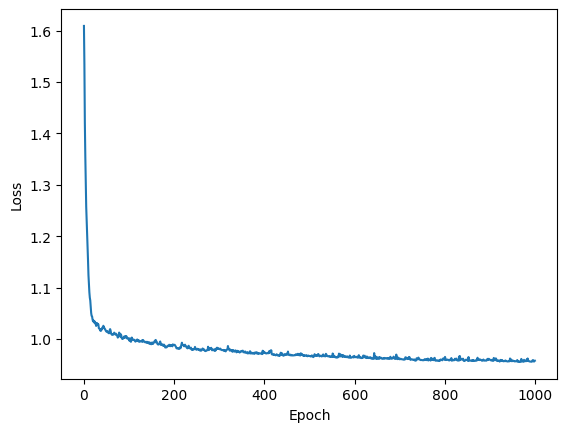

Test accuracy: 463.32559139784945
Accuracy: 0.4774193548387097
Precision: 0.5307273579413524
Recall: 0.47657534952290215
F1-score: 0.49135554643036683


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.58      0.66       495
           1       0.47      0.45      0.46       472
           2       0.31      0.49      0.38       449
           3       0.32      0.33      0.33       463
           4       0.78      0.52      0.63       446

    accuracy                           0.48      2325
   macro avg       0.53      0.48      0.49      2325
weighted avg       0.53      0.48      0.49      2325

                    0           1           2           3           4  \
precision    0.770889    0.469298    0.306630    0.324211    0.782609   
recall       0.577778    0.453390    0.494432    0.332613    0.524664   
f1-score     0.660508    0.461207    0.378517    0.328358    0.628188   
support    495.000000  472.000000  449.0000

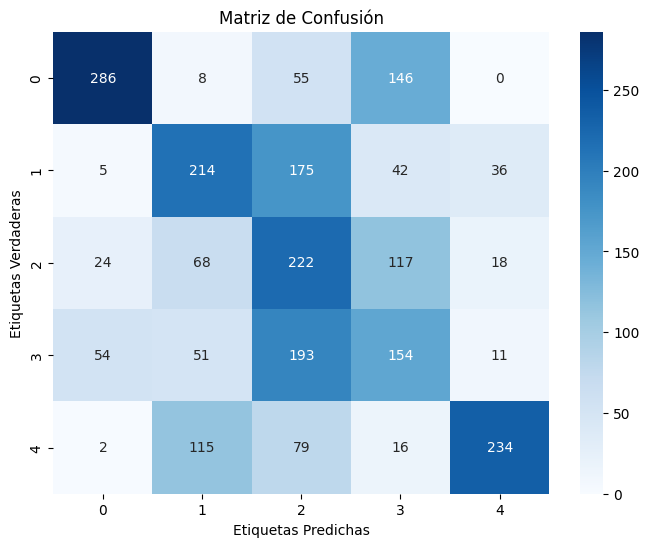

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_1000_0.0001_0.3/resultados_1000_0.0001_0.3.json
Procesando red con 1000 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas:   0%|                                                              | 1/1000 [00:02<44:05,  2.65s/it]

1.6097109156496385


Procesando epocas:   0%|                                                              | 2/1000 [00:05<43:56,  2.64s/it]

1.6097544508821824


Procesando epocas:   0%|▏                                                             | 3/1000 [00:07<43:58,  2.65s/it]

1.6096995185403262


Procesando epocas:   0%|▏                                                             | 4/1000 [00:10<44:01,  2.65s/it]

1.6096221636323367


Procesando epocas:   0%|▎                                                             | 5/1000 [00:13<44:06,  2.66s/it]

1.6094390848103692


Procesando epocas:   1%|▎                                                             | 6/1000 [00:15<44:05,  2.66s/it]

1.6092255844789394


Procesando epocas:   1%|▍                                                             | 7/1000 [00:18<44:03,  2.66s/it]

1.608091798249413


Procesando epocas:   1%|▍                                                             | 8/1000 [00:21<43:51,  2.65s/it]

1.6052202968036426


Procesando epocas:   1%|▌                                                             | 9/1000 [00:23<43:42,  2.65s/it]

1.5960548758506774


Procesando epocas:   1%|▌                                                            | 10/1000 [00:26<43:39,  2.65s/it]

1.5664978981018067


Procesando epocas:   1%|▋                                                            | 11/1000 [00:29<43:34,  2.64s/it]

1.5091590285301208


Procesando epocas:   1%|▋                                                            | 12/1000 [00:31<43:29,  2.64s/it]

1.4667800580754


Procesando epocas:   1%|▊                                                            | 13/1000 [00:34<43:26,  2.64s/it]

1.4396272399846246


Procesando epocas:   1%|▊                                                            | 14/1000 [00:37<43:23,  2.64s/it]

1.419320760754978


Procesando epocas:   2%|▉                                                            | 15/1000 [00:39<43:15,  2.64s/it]

1.3982755885404698


Procesando epocas:   2%|▉                                                            | 16/1000 [00:42<43:15,  2.64s/it]

1.3752653626834646


Procesando epocas:   2%|█                                                            | 17/1000 [00:44<43:05,  2.63s/it]

1.3568156607010786


Procesando epocas:   2%|█                                                            | 18/1000 [00:47<42:59,  2.63s/it]

1.3427313923835755


Procesando epocas:   2%|█▏                                                           | 19/1000 [00:50<43:01,  2.63s/it]

1.3245159948573393


Procesando epocas:   2%|█▏                                                           | 20/1000 [00:52<42:58,  2.63s/it]

1.3179319185369156


Procesando epocas:   2%|█▎                                                           | 21/1000 [00:55<42:56,  2.63s/it]

1.308845505994909


Procesando epocas:   2%|█▎                                                           | 22/1000 [00:58<42:52,  2.63s/it]

1.2919564920313218


Procesando epocas:   2%|█▍                                                           | 23/1000 [01:00<42:55,  2.64s/it]

1.2857712570358726


Procesando epocas:   2%|█▍                                                           | 24/1000 [01:03<42:56,  2.64s/it]

1.2719934042762309


Procesando epocas:   2%|█▌                                                           | 25/1000 [01:06<43:00,  2.65s/it]

1.2610249771791346


Procesando epocas:   3%|█▌                                                           | 26/1000 [01:08<42:51,  2.64s/it]

1.2543209805208093


Procesando epocas:   3%|█▋                                                           | 27/1000 [01:11<42:47,  2.64s/it]

1.2454831929767833


Procesando epocas:   3%|█▋                                                           | 28/1000 [01:13<42:46,  2.64s/it]

1.2341304400387931


Procesando epocas:   3%|█▊                                                           | 29/1000 [01:16<42:44,  2.64s/it]

1.227521904777078


Procesando epocas:   3%|█▊                                                           | 30/1000 [01:19<42:42,  2.64s/it]

1.219206953048706


Procesando epocas:   3%|█▉                                                           | 31/1000 [01:21<42:37,  2.64s/it]

1.2191814191201154


Procesando epocas:   3%|█▉                                                           | 32/1000 [01:24<42:32,  2.64s/it]

1.2076273567536298


Procesando epocas:   3%|██                                                           | 33/1000 [01:27<42:30,  2.64s/it]

1.1992108793819651


Procesando epocas:   3%|██                                                           | 34/1000 [01:29<42:32,  2.64s/it]

1.1935854624299442


Procesando epocas:   4%|██▏                                                          | 35/1000 [01:32<42:28,  2.64s/it]

1.1897455587106593


Procesando epocas:   4%|██▏                                                          | 36/1000 [01:35<42:25,  2.64s/it]

1.1836545032613417


Procesando epocas:   4%|██▎                                                          | 37/1000 [01:37<42:21,  2.64s/it]

1.1747791647911072


Procesando epocas:   4%|██▎                                                          | 38/1000 [01:40<42:17,  2.64s/it]

1.1730854441137875


Procesando epocas:   4%|██▍                                                          | 39/1000 [01:42<42:14,  2.64s/it]

1.1644475495114046


Procesando epocas:   4%|██▍                                                          | 40/1000 [01:45<42:10,  2.64s/it]

1.1529880481607773


Procesando epocas:   4%|██▌                                                          | 41/1000 [01:48<42:08,  2.64s/it]

1.1526690581265617


Procesando epocas:   4%|██▌                                                          | 42/1000 [01:50<42:04,  2.64s/it]

1.1401483623420492


Procesando epocas:   4%|██▌                                                          | 43/1000 [01:53<42:02,  2.64s/it]

1.139938218453351


Procesando epocas:   4%|██▋                                                          | 44/1000 [01:56<42:01,  2.64s/it]

1.1302207501495585


Procesando epocas:   4%|██▋                                                          | 45/1000 [01:58<41:52,  2.63s/it]

1.1240396240178276


Procesando epocas:   5%|██▊                                                          | 46/1000 [02:01<41:52,  2.63s/it]

1.1174243008389193


Procesando epocas:   5%|██▊                                                          | 47/1000 [02:04<41:51,  2.64s/it]

1.1106276403455173


Procesando epocas:   5%|██▉                                                          | 48/1000 [02:06<41:46,  2.63s/it]

1.1137485756593593


Procesando epocas:   5%|██▉                                                          | 49/1000 [02:09<41:42,  2.63s/it]

1.0979838588658501


Procesando epocas:   5%|███                                                          | 50/1000 [02:11<41:38,  2.63s/it]

1.0943311642198001


Procesando epocas:   5%|███                                                          | 51/1000 [02:14<41:34,  2.63s/it]

1.0922786134130815


Procesando epocas:   5%|███▏                                                         | 52/1000 [02:17<41:33,  2.63s/it]

1.0882657254443449


Procesando epocas:   5%|███▏                                                         | 53/1000 [02:19<41:31,  2.63s/it]

1.084776954089894


Procesando epocas:   5%|███▎                                                         | 54/1000 [02:22<41:27,  2.63s/it]

1.0765218517359565


Procesando epocas:   6%|███▎                                                         | 55/1000 [02:25<41:26,  2.63s/it]

1.0736984891050003


Procesando epocas:   6%|███▍                                                         | 56/1000 [02:27<41:23,  2.63s/it]

1.0671254638363332


Procesando epocas:   6%|███▍                                                         | 57/1000 [02:30<41:19,  2.63s/it]

1.0636925178415635


Procesando epocas:   6%|███▌                                                         | 58/1000 [02:32<41:17,  2.63s/it]

1.0662985542241266


Procesando epocas:   6%|███▌                                                         | 59/1000 [02:35<41:12,  2.63s/it]

1.054398878181682


Procesando epocas:   6%|███▋                                                         | 60/1000 [02:38<41:08,  2.63s/it]

1.057828713865841


Procesando epocas:   6%|███▋                                                         | 61/1000 [02:40<41:13,  2.63s/it]

1.0524356007575988


Procesando epocas:   6%|███▊                                                         | 62/1000 [02:43<41:08,  2.63s/it]

1.050321468886207


Procesando epocas:   6%|███▊                                                         | 63/1000 [02:46<41:03,  2.63s/it]

1.0491620607235852


Procesando epocas:   6%|███▉                                                         | 64/1000 [02:48<40:59,  2.63s/it]

1.0416229770464056


Procesando epocas:   6%|███▉                                                         | 65/1000 [02:51<40:55,  2.63s/it]

1.043297136180541


Procesando epocas:   7%|████                                                         | 66/1000 [02:53<40:49,  2.62s/it]

1.0361602621919968


Procesando epocas:   7%|████                                                         | 67/1000 [02:56<40:42,  2.62s/it]

1.0386979516814736


Procesando epocas:   7%|████▏                                                        | 68/1000 [02:59<40:41,  2.62s/it]

1.0354915958993576


Procesando epocas:   7%|████▏                                                        | 69/1000 [03:01<40:33,  2.61s/it]

1.0329350047251757


Procesando epocas:   7%|████▎                                                        | 70/1000 [03:04<40:30,  2.61s/it]

1.030894225134569


Procesando epocas:   7%|████▎                                                        | 71/1000 [03:07<40:23,  2.61s/it]

1.027415916849585


Procesando epocas:   7%|████▍                                                        | 72/1000 [03:09<40:22,  2.61s/it]

1.0263318398419548


Procesando epocas:   7%|████▍                                                        | 73/1000 [03:12<40:16,  2.61s/it]

1.0252523369648878


Procesando epocas:   7%|████▌                                                        | 74/1000 [03:14<40:15,  2.61s/it]

1.0267255674390232


Procesando epocas:   8%|████▌                                                        | 75/1000 [03:17<40:14,  2.61s/it]

1.0218624325359569


Procesando epocas:   8%|████▋                                                        | 76/1000 [03:20<40:10,  2.61s/it]

1.0190557918127845


Procesando epocas:   8%|████▋                                                        | 77/1000 [03:22<40:09,  2.61s/it]

1.0205329274429995


Procesando epocas:   8%|████▊                                                        | 78/1000 [03:25<40:11,  2.62s/it]

1.0187704521067003


Procesando epocas:   8%|████▊                                                        | 79/1000 [03:27<40:04,  2.61s/it]

1.0144022370085997


Procesando epocas:   8%|████▉                                                        | 80/1000 [03:30<39:58,  2.61s/it]

1.013771251369925


Procesando epocas:   8%|████▉                                                        | 81/1000 [03:33<39:54,  2.61s/it]

1.0141415276948142


Procesando epocas:   8%|█████                                                        | 82/1000 [03:35<39:52,  2.61s/it]

1.0122983704595006


Procesando epocas:   8%|█████                                                        | 83/1000 [03:38<39:49,  2.61s/it]

1.0109803129644954


Procesando epocas:   8%|█████                                                        | 84/1000 [03:40<39:53,  2.61s/it]

1.0103608895750607


Procesando epocas:   8%|█████▏                                                       | 85/1000 [03:43<39:52,  2.61s/it]

1.0063041378470028


Procesando epocas:   9%|█████▏                                                       | 86/1000 [03:46<39:47,  2.61s/it]

1.0074610895970288


Procesando epocas:   9%|█████▎                                                       | 87/1000 [03:48<39:43,  2.61s/it]

1.0071009926936205


Procesando epocas:   9%|█████▎                                                       | 88/1000 [03:51<39:42,  2.61s/it]

1.0067819833755494


Procesando epocas:   9%|█████▍                                                       | 89/1000 [03:54<39:37,  2.61s/it]

1.004943778584985


Procesando epocas:   9%|█████▍                                                       | 90/1000 [03:56<39:34,  2.61s/it]

1.0032445939148174


Procesando epocas:   9%|█████▌                                                       | 91/1000 [03:59<39:34,  2.61s/it]

1.0029511430684257


Procesando epocas:   9%|█████▌                                                       | 92/1000 [04:01<39:29,  2.61s/it]

1.0031462269670823


Procesando epocas:   9%|█████▋                                                       | 93/1000 [04:04<39:26,  2.61s/it]

1.0007693388882806


Procesando epocas:   9%|█████▋                                                       | 94/1000 [04:07<39:23,  2.61s/it]

0.9993280645679025


Procesando epocas:  10%|█████▊                                                       | 95/1000 [04:09<39:26,  2.61s/it]

1.0000726790989147


Procesando epocas:  10%|█████▊                                                       | 96/1000 [04:12<39:25,  2.62s/it]

0.999786151156706


Procesando epocas:  10%|█████▉                                                       | 97/1000 [04:14<39:22,  2.62s/it]

0.9969761098132414


Procesando epocas:  10%|█████▉                                                       | 98/1000 [04:17<39:19,  2.62s/it]

1.0002011134343989


Procesando epocas:  10%|██████                                                       | 99/1000 [04:20<39:17,  2.62s/it]

0.9966656597221599


Procesando epocas:  10%|██████                                                      | 100/1000 [04:22<39:19,  2.62s/it]

0.9960858015453115


Procesando epocas:  10%|██████                                                      | 101/1000 [04:25<39:29,  2.64s/it]

0.9951256671372581


Procesando epocas:  10%|██████                                                      | 102/1000 [04:28<39:34,  2.64s/it]

0.9952773406225093


Procesando epocas:  10%|██████▏                                                     | 103/1000 [04:30<39:38,  2.65s/it]

0.9941340222078211


Procesando epocas:  10%|██████▏                                                     | 104/1000 [04:33<39:43,  2.66s/it]

0.9942871742388781


Procesando epocas:  10%|██████▎                                                     | 105/1000 [04:36<39:47,  2.67s/it]

0.9935659089509179


Procesando epocas:  11%|██████▎                                                     | 106/1000 [04:38<39:45,  2.67s/it]

0.9935409349553725


Procesando epocas:  11%|██████▍                                                     | 107/1000 [04:41<39:46,  2.67s/it]

0.9933260093717015


Procesando epocas:  11%|██████▍                                                     | 108/1000 [04:44<39:37,  2.67s/it]

0.9941536149557899


Procesando epocas:  11%|██████▌                                                     | 109/1000 [04:46<39:39,  2.67s/it]

0.993648621264626


Procesando epocas:  11%|██████▌                                                     | 110/1000 [04:49<39:38,  2.67s/it]

0.9936113950084238


Procesando epocas:  11%|██████▋                                                     | 111/1000 [04:52<39:35,  2.67s/it]

0.992309326284072


Procesando epocas:  11%|██████▋                                                     | 112/1000 [04:54<39:29,  2.67s/it]

0.9929541486151078


Procesando epocas:  11%|██████▊                                                     | 113/1000 [04:57<39:26,  2.67s/it]

0.9938547656816594


Procesando epocas:  11%|██████▊                                                     | 114/1000 [05:00<39:25,  2.67s/it]

0.9908881545066833


Procesando epocas:  12%|██████▉                                                     | 115/1000 [05:02<39:25,  2.67s/it]

0.9922765377689811


Procesando epocas:  12%|██████▉                                                     | 116/1000 [05:05<39:24,  2.67s/it]

0.9907755974461051


Procesando epocas:  12%|███████                                                     | 117/1000 [05:08<39:21,  2.67s/it]

0.9910389626727385


Procesando epocas:  12%|███████                                                     | 118/1000 [05:10<39:20,  2.68s/it]

0.9895509351702297


Procesando epocas:  12%|███████▏                                                    | 119/1000 [05:13<39:14,  2.67s/it]

0.9908540943089653


Procesando epocas:  12%|███████▏                                                    | 120/1000 [05:16<39:13,  2.67s/it]

0.988766290510402


Procesando epocas:  12%|███████▎                                                    | 121/1000 [05:18<39:06,  2.67s/it]

0.9907005632624907


Procesando epocas:  12%|███████▎                                                    | 122/1000 [05:21<39:01,  2.67s/it]

0.9893572393585653


Procesando epocas:  12%|███████▍                                                    | 123/1000 [05:24<38:51,  2.66s/it]

0.9887239785755382


Procesando epocas:  12%|███████▍                                                    | 124/1000 [05:26<38:46,  2.66s/it]

0.9873687965028426


Procesando epocas:  12%|███████▌                                                    | 125/1000 [05:29<38:46,  2.66s/it]

0.9891614132067736


Procesando epocas:  13%|███████▌                                                    | 126/1000 [05:32<38:38,  2.65s/it]

0.9890625592540292


Procesando epocas:  13%|███████▌                                                    | 127/1000 [05:34<38:38,  2.66s/it]

0.9882223676232731


Procesando epocas:  13%|███████▋                                                    | 128/1000 [05:37<38:35,  2.65s/it]

0.9875037095125984


Procesando epocas:  13%|███████▋                                                    | 129/1000 [05:40<38:31,  2.65s/it]

0.9878972575945013


Procesando epocas:  13%|███████▊                                                    | 130/1000 [05:42<38:29,  2.66s/it]

0.9860694408416748


Procesando epocas:  13%|███████▊                                                    | 131/1000 [05:45<38:27,  2.66s/it]

0.9880238834549399


Procesando epocas:  13%|███████▉                                                    | 132/1000 [05:48<38:21,  2.65s/it]

0.987117285938824


Procesando epocas:  13%|███████▉                                                    | 133/1000 [05:50<38:17,  2.65s/it]

0.985933439170613


Procesando epocas:  13%|████████                                                    | 134/1000 [05:53<38:10,  2.64s/it]

0.9871451202560874


Procesando epocas:  14%|████████                                                    | 135/1000 [05:56<38:07,  2.65s/it]

0.9871718487318825


Procesando epocas:  14%|████████▏                                                   | 136/1000 [05:58<38:01,  2.64s/it]

0.9864465296268463


Procesando epocas:  14%|████████▏                                                   | 137/1000 [06:01<38:00,  2.64s/it]

0.9860478699207306


Procesando epocas:  14%|████████▎                                                   | 138/1000 [06:03<37:57,  2.64s/it]

0.984542084792081


Procesando epocas:  14%|████████▎                                                   | 139/1000 [06:06<37:54,  2.64s/it]

0.9848189143573537


Procesando epocas:  14%|████████▍                                                   | 140/1000 [06:09<37:50,  2.64s/it]

0.9847816533902112


Procesando epocas:  14%|████████▍                                                   | 141/1000 [06:11<37:49,  2.64s/it]

0.9867051846840802


Procesando epocas:  14%|████████▌                                                   | 142/1000 [06:14<37:47,  2.64s/it]

0.9836940519949969


Procesando epocas:  14%|████████▌                                                   | 143/1000 [06:17<37:42,  2.64s/it]

0.9846079321468577


Procesando epocas:  14%|████████▋                                                   | 144/1000 [06:19<37:35,  2.64s/it]

0.9829947611864875


Procesando epocas:  14%|████████▋                                                   | 145/1000 [06:22<37:30,  2.63s/it]

0.9848487626103793


Procesando epocas:  15%|████████▊                                                   | 146/1000 [06:25<37:28,  2.63s/it]

0.9849628658855663


Procesando epocas:  15%|████████▊                                                   | 147/1000 [06:27<37:22,  2.63s/it]

0.984387179332621


Procesando epocas:  15%|████████▉                                                   | 148/1000 [06:30<37:21,  2.63s/it]

0.9848696046015796


Procesando epocas:  15%|████████▉                                                   | 149/1000 [06:32<37:15,  2.63s/it]

0.9827489067526425


Procesando epocas:  15%|█████████                                                   | 150/1000 [06:35<37:11,  2.63s/it]

0.9847506603773902


Procesando epocas:  15%|█████████                                                   | 151/1000 [06:38<37:12,  2.63s/it]

0.9846676318084493


Procesando epocas:  15%|█████████                                                   | 152/1000 [06:40<37:09,  2.63s/it]

0.9838439587284536


Procesando epocas:  15%|█████████▏                                                  | 153/1000 [06:43<37:06,  2.63s/it]

0.9829889090622173


Procesando epocas:  15%|█████████▏                                                  | 154/1000 [06:46<37:04,  2.63s/it]

0.9840856446939357


Procesando epocas:  16%|█████████▎                                                  | 155/1000 [06:48<37:07,  2.64s/it]

0.9835156258414773


Procesando epocas:  16%|█████████▎                                                  | 156/1000 [06:51<37:04,  2.64s/it]

0.9826906046446632


Procesando epocas:  16%|█████████▍                                                  | 157/1000 [06:53<37:00,  2.63s/it]

0.9844301065977882


Procesando epocas:  16%|█████████▍                                                  | 158/1000 [06:56<36:58,  2.64s/it]

0.9826135432018953


Procesando epocas:  16%|█████████▌                                                  | 159/1000 [06:59<36:57,  2.64s/it]

0.9838360576068654


Procesando epocas:  16%|█████████▌                                                  | 160/1000 [07:01<36:49,  2.63s/it]

0.9825146587455974


Procesando epocas:  16%|█████████▋                                                  | 161/1000 [07:04<36:49,  2.63s/it]

0.9830767088076647


Procesando epocas:  16%|█████████▋                                                  | 162/1000 [07:07<36:50,  2.64s/it]

0.982958444777657


Procesando epocas:  16%|█████████▊                                                  | 163/1000 [07:09<36:44,  2.63s/it]

0.9823911873733296


Procesando epocas:  16%|█████████▊                                                  | 164/1000 [07:12<36:40,  2.63s/it]

0.9819145924904767


Procesando epocas:  16%|█████████▉                                                  | 165/1000 [07:14<36:34,  2.63s/it]

0.9814182060606339


Procesando epocas:  17%|█████████▉                                                  | 166/1000 [07:17<36:27,  2.62s/it]

0.9816740491810967


Procesando epocas:  17%|██████████                                                  | 167/1000 [07:20<36:26,  2.62s/it]

0.9813173062661115


Procesando epocas:  17%|██████████                                                  | 168/1000 [07:22<36:21,  2.62s/it]

0.981319062499439


Procesando epocas:  17%|██████████▏                                                 | 169/1000 [07:25<36:15,  2.62s/it]

0.9817567492232603


Procesando epocas:  17%|██████████▏                                                 | 170/1000 [07:28<36:14,  2.62s/it]

0.9818991313962375


Procesando epocas:  17%|██████████▎                                                 | 171/1000 [07:30<36:17,  2.63s/it]

0.9800399043980766


Procesando epocas:  17%|██████████▎                                                 | 172/1000 [07:33<36:14,  2.63s/it]

0.9819152477909537


Procesando epocas:  17%|██████████▍                                                 | 173/1000 [07:35<36:12,  2.63s/it]

0.9819479938815622


Procesando epocas:  17%|██████████▍                                                 | 174/1000 [07:38<36:11,  2.63s/it]

0.9817812270977918


Procesando epocas:  18%|██████████▌                                                 | 175/1000 [07:41<36:08,  2.63s/it]

0.9812260413871092


Procesando epocas:  18%|██████████▌                                                 | 176/1000 [07:43<36:05,  2.63s/it]

0.9809808345401988


Procesando epocas:  18%|██████████▌                                                 | 177/1000 [07:46<36:03,  2.63s/it]

0.9809664989218992


Procesando epocas:  18%|██████████▋                                                 | 178/1000 [07:49<36:05,  2.63s/it]

0.9820851276902591


Procesando epocas:  18%|██████████▋                                                 | 179/1000 [07:51<36:04,  2.64s/it]

0.9815446892205406


Procesando epocas:  18%|██████████▊                                                 | 180/1000 [07:54<35:56,  2.63s/it]

0.9811240382054273


Procesando epocas:  18%|██████████▊                                                 | 181/1000 [07:57<35:56,  2.63s/it]

0.9818685685887056


Procesando epocas:  18%|██████████▉                                                 | 182/1000 [07:59<35:54,  2.63s/it]

0.9809851288795471


Procesando epocas:  18%|██████████▉                                                 | 183/1000 [08:02<35:54,  2.64s/it]

0.9805398723658394


Procesando epocas:  18%|███████████                                                 | 184/1000 [08:04<35:52,  2.64s/it]

0.9806494600632611


Procesando epocas:  18%|███████████                                                 | 185/1000 [08:07<35:49,  2.64s/it]

0.9801433962934157


Procesando epocas:  19%|███████████▏                                                | 186/1000 [08:10<35:48,  2.64s/it]

0.9807572178980883


Procesando epocas:  19%|███████████▏                                                | 187/1000 [08:12<35:44,  2.64s/it]

0.981542090808644


Procesando epocas:  19%|███████████▎                                                | 188/1000 [08:15<35:40,  2.64s/it]

0.9808002797996297


Procesando epocas:  19%|███████████▎                                                | 189/1000 [08:18<35:39,  2.64s/it]

0.9797643843819114


Procesando epocas:  19%|███████████▍                                                | 190/1000 [08:20<35:34,  2.64s/it]

0.980593762327643


Procesando epocas:  19%|███████████▍                                                | 191/1000 [08:23<35:30,  2.63s/it]

0.9802586958688848


Procesando epocas:  19%|███████████▌                                                | 192/1000 [08:26<35:32,  2.64s/it]

0.9801657743313733


Procesando epocas:  19%|███████████▌                                                | 193/1000 [08:28<35:29,  2.64s/it]

0.9813351946718553


Procesando epocas:  19%|███████████▋                                                | 194/1000 [08:31<35:26,  2.64s/it]

0.9800436742165509


Procesando epocas:  20%|███████████▋                                                | 195/1000 [08:33<35:19,  2.63s/it]

0.9798495057751151


Procesando epocas:  20%|███████████▊                                                | 196/1000 [08:36<35:11,  2.63s/it]

0.9793541235082289


Procesando epocas:  20%|███████████▊                                                | 197/1000 [08:39<35:07,  2.63s/it]

0.9792832087067996


Procesando epocas:  20%|███████████▉                                                | 198/1000 [08:41<35:01,  2.62s/it]

0.9795468491666457


Procesando epocas:  20%|███████████▉                                                | 199/1000 [08:44<34:56,  2.62s/it]

0.97978315633886


Procesando epocas:  20%|████████████                                                | 200/1000 [08:47<34:55,  2.62s/it]

0.9802409424501307


Procesando epocas:  20%|████████████                                                | 201/1000 [08:49<34:50,  2.62s/it]

0.9790090553900774


Procesando epocas:  20%|████████████                                                | 202/1000 [08:52<34:51,  2.62s/it]

0.9798942576436436


Procesando epocas:  20%|████████████▏                                               | 203/1000 [08:54<34:50,  2.62s/it]

0.9789015373762916


Procesando epocas:  20%|████████████▏                                               | 204/1000 [08:57<34:48,  2.62s/it]

0.9794905553845799


Procesando epocas:  20%|████████████▎                                               | 205/1000 [09:00<34:50,  2.63s/it]

0.9794929644640754


Procesando epocas:  21%|████████████▎                                               | 206/1000 [09:02<34:47,  2.63s/it]

0.9803255414261537


Procesando epocas:  21%|████████████▍                                               | 207/1000 [09:05<34:45,  2.63s/it]

0.9812577314236585


Procesando epocas:  21%|████████████▍                                               | 208/1000 [09:08<34:42,  2.63s/it]

0.9802608686334947


Procesando epocas:  21%|████████████▌                                               | 209/1000 [09:10<34:42,  2.63s/it]

0.9795787253800561


Procesando epocas:  21%|████████████▌                                               | 210/1000 [09:13<34:37,  2.63s/it]

0.9797430483733907


Procesando epocas:  21%|████████████▋                                               | 211/1000 [09:15<34:32,  2.63s/it]

0.9791947406880995


Procesando epocas:  21%|████████████▋                                               | 212/1000 [09:18<34:31,  2.63s/it]

0.9797609297668233


Procesando epocas:  21%|████████████▊                                               | 213/1000 [09:21<34:28,  2.63s/it]

0.980330213027842


Procesando epocas:  21%|████████████▊                                               | 214/1000 [09:23<34:26,  2.63s/it]

0.979888187085881


Procesando epocas:  22%|████████████▉                                               | 215/1000 [09:26<34:21,  2.63s/it]

0.97878838076311


Procesando epocas:  22%|████████████▉                                               | 216/1000 [09:29<34:20,  2.63s/it]

0.9793218156870673


Procesando epocas:  22%|█████████████                                               | 217/1000 [09:31<34:19,  2.63s/it]

0.9790135043508866


Procesando epocas:  22%|█████████████                                               | 218/1000 [09:34<34:18,  2.63s/it]

0.9791740084395689


Procesando epocas:  22%|█████████████▏                                              | 219/1000 [09:36<34:13,  2.63s/it]

0.9792566145167632


Procesando epocas:  22%|█████████████▏                                              | 220/1000 [09:39<34:09,  2.63s/it]

0.9786372598479776


Procesando epocas:  22%|█████████████▎                                              | 221/1000 [09:42<34:07,  2.63s/it]

0.9789760203922496


Procesando epocas:  22%|█████████████▎                                              | 222/1000 [09:44<34:03,  2.63s/it]

0.9794195420601789


Procesando epocas:  22%|█████████████▍                                              | 223/1000 [09:47<33:59,  2.63s/it]

0.9794143354191499


Procesando epocas:  22%|█████████████▍                                              | 224/1000 [09:50<33:53,  2.62s/it]

0.9780099528677323


Procesando epocas:  22%|█████████████▌                                              | 225/1000 [09:52<33:47,  2.62s/it]

0.9784029529375189


Procesando epocas:  23%|█████████████▌                                              | 226/1000 [09:55<33:42,  2.61s/it]

0.977575125764398


Procesando epocas:  23%|█████████████▌                                              | 227/1000 [09:57<33:46,  2.62s/it]

0.977771484150606


Procesando epocas:  23%|█████████████▋                                              | 228/1000 [10:00<33:49,  2.63s/it]

0.9789463996887207


Procesando epocas:  23%|█████████████▋                                              | 229/1000 [10:03<33:53,  2.64s/it]

0.9783889346262988


Procesando epocas:  23%|█████████████▊                                              | 230/1000 [10:05<33:54,  2.64s/it]

0.9774991894469541


Procesando epocas:  23%|█████████████▊                                              | 231/1000 [10:08<33:56,  2.65s/it]

0.9784488474621492


Procesando epocas:  23%|█████████████▉                                              | 232/1000 [10:11<33:56,  2.65s/it]

0.9781660560299369


Procesando epocas:  23%|█████████████▉                                              | 233/1000 [10:13<33:51,  2.65s/it]

0.9787966482779559


Procesando epocas:  23%|██████████████                                              | 234/1000 [10:16<33:45,  2.64s/it]

0.978641832225463


Procesando epocas:  24%|██████████████                                              | 235/1000 [10:19<33:46,  2.65s/it]

0.9783899349324844


Procesando epocas:  24%|██████████████▏                                             | 236/1000 [10:21<33:43,  2.65s/it]

0.978473794109681


Procesando epocas:  24%|██████████████▏                                             | 237/1000 [10:24<33:39,  2.65s/it]

0.9777184433796826


Procesando epocas:  24%|██████████████▎                                             | 238/1000 [10:27<33:36,  2.65s/it]

0.9790313100113588


Procesando epocas:  24%|██████████████▎                                             | 239/1000 [10:29<33:36,  2.65s/it]

0.9784190160386702


Procesando epocas:  24%|██████████████▍                                             | 240/1000 [10:32<32:45,  2.59s/it]

0.9781026661396026


Procesando epocas:  24%|██████████████▍                                             | 241/1000 [10:34<32:33,  2.57s/it]

0.9779596234069151


Procesando epocas:  24%|██████████████▌                                             | 242/1000 [10:37<32:57,  2.61s/it]

0.9787018698804518


Procesando epocas:  24%|██████████████▌                                             | 243/1000 [10:40<33:05,  2.62s/it]

0.9779313658966737


Procesando epocas:  24%|██████████████▋                                             | 244/1000 [10:42<33:13,  2.64s/it]

0.9778074050650877


Procesando epocas:  24%|██████████████▋                                             | 245/1000 [10:45<33:15,  2.64s/it]

0.9782896904384388


Procesando epocas:  25%|██████████████▊                                             | 246/1000 [10:48<33:19,  2.65s/it]

0.9791042706545662


Procesando epocas:  25%|██████████████▊                                             | 247/1000 [10:50<33:22,  2.66s/it]

0.977675510154051


Procesando epocas:  25%|██████████████▉                                             | 248/1000 [10:53<33:18,  2.66s/it]

0.9772882840212653


Procesando epocas:  25%|██████████████▉                                             | 249/1000 [10:56<33:25,  2.67s/it]

0.9770374568069682


Procesando epocas:  25%|███████████████                                             | 250/1000 [10:58<33:25,  2.67s/it]

0.9778018516652724


Procesando epocas:  25%|███████████████                                             | 251/1000 [11:01<33:19,  2.67s/it]

0.9775055534699384


Procesando epocas:  25%|███████████████                                             | 252/1000 [11:04<33:18,  2.67s/it]

0.9768892565194298


Procesando epocas:  25%|███████████████▏                                            | 253/1000 [11:06<33:16,  2.67s/it]

0.9783901596770567


Procesando epocas:  25%|███████████████▏                                            | 254/1000 [11:09<33:13,  2.67s/it]

0.9776550503338084


Procesando epocas:  26%|███████████████▎                                            | 255/1000 [11:12<33:12,  2.68s/it]

0.9780936093891368


Procesando epocas:  26%|███████████████▎                                            | 256/1000 [11:14<33:08,  2.67s/it]

0.977399569048601


Procesando epocas:  26%|███████████████▍                                            | 257/1000 [11:17<33:00,  2.67s/it]

0.9774993468733395


Procesando epocas:  26%|███████████████▍                                            | 258/1000 [11:20<32:55,  2.66s/it]

0.9778261938515831


Procesando epocas:  26%|███████████████▌                                            | 259/1000 [11:22<32:47,  2.66s/it]

0.977336677382974


Procesando epocas:  26%|███████████████▌                                            | 260/1000 [11:25<32:41,  2.65s/it]

0.9773377393974977


Procesando epocas:  26%|███████████████▋                                            | 261/1000 [11:28<32:33,  2.64s/it]

0.9772978263742783


Procesando epocas:  26%|███████████████▋                                            | 262/1000 [11:30<32:29,  2.64s/it]

0.9780916561098659


Procesando epocas:  26%|███████████████▊                                            | 263/1000 [11:33<32:27,  2.64s/it]

0.9787869611207176


Procesando epocas:  26%|███████████████▊                                            | 264/1000 [11:35<32:25,  2.64s/it]

0.9771386791678036


Procesando epocas:  26%|███████████████▉                                            | 265/1000 [11:38<32:22,  2.64s/it]

0.9778584992184358


Procesando epocas:  27%|███████████████▉                                            | 266/1000 [11:41<32:17,  2.64s/it]

0.9774238982621362


Procesando epocas:  27%|████████████████                                            | 267/1000 [11:43<32:13,  2.64s/it]

0.9779959306997411


Procesando epocas:  27%|████████████████                                            | 268/1000 [11:46<32:07,  2.63s/it]

0.9782832699663498


Procesando epocas:  27%|████████████████▏                                           | 269/1000 [11:49<32:06,  2.64s/it]

0.9772858567097608


Procesando epocas:  27%|████████████████▏                                           | 270/1000 [11:51<32:05,  2.64s/it]

0.977127123930875


Procesando epocas:  27%|████████████████▎                                           | 271/1000 [11:54<32:03,  2.64s/it]

0.9770978019518011


Procesando epocas:  27%|████████████████▎                                           | 272/1000 [11:57<32:04,  2.64s/it]

0.9767860686077791


Procesando epocas:  27%|████████████████▍                                           | 273/1000 [11:59<31:59,  2.64s/it]

0.9771631665089551


Procesando epocas:  27%|████████████████▍                                           | 274/1000 [12:02<31:58,  2.64s/it]

0.9766759925028857


Procesando epocas:  28%|████████████████▌                                           | 275/1000 [12:04<31:56,  2.64s/it]

0.9763513740371256


Procesando epocas:  28%|████████████████▌                                           | 276/1000 [12:07<31:53,  2.64s/it]

0.97712601703756


Procesando epocas:  28%|████████████████▌                                           | 277/1000 [12:10<31:52,  2.64s/it]

0.9768966012141284


Procesando epocas:  28%|████████████████▋                                           | 278/1000 [12:12<31:50,  2.65s/it]

0.9768733655705172


Procesando epocas:  28%|████████████████▋                                           | 279/1000 [12:15<31:47,  2.65s/it]

0.9771233383347007


Procesando epocas:  28%|████████████████▊                                           | 280/1000 [12:18<31:46,  2.65s/it]

0.9760913578902974


Procesando epocas:  28%|████████████████▊                                           | 281/1000 [12:20<31:41,  2.64s/it]

0.9782539809451384


Procesando epocas:  28%|████████████████▉                                           | 282/1000 [12:23<31:38,  2.64s/it]

0.9761692359166987


Procesando epocas:  28%|████████████████▉                                           | 283/1000 [12:26<31:34,  2.64s/it]

0.9764875461073482


Procesando epocas:  28%|█████████████████                                           | 284/1000 [12:28<31:33,  2.64s/it]

0.9775466827785267


Procesando epocas:  28%|█████████████████                                           | 285/1000 [12:31<31:31,  2.65s/it]

0.9760120700387394


Procesando epocas:  29%|█████████████████▏                                          | 286/1000 [12:34<31:26,  2.64s/it]

0.976057667241377


Procesando epocas:  29%|█████████████████▏                                          | 287/1000 [12:36<31:24,  2.64s/it]

0.9767599288155051


Procesando epocas:  29%|█████████████████▎                                          | 288/1000 [12:39<31:16,  2.64s/it]

0.9768230736255645


Procesando epocas:  29%|█████████████████▎                                          | 289/1000 [12:41<31:11,  2.63s/it]

0.97593814905952


Procesando epocas:  29%|█████████████████▍                                          | 290/1000 [12:44<31:07,  2.63s/it]

0.9763148455058828


Procesando epocas:  29%|█████████████████▍                                          | 291/1000 [12:47<31:05,  2.63s/it]

0.9764682419159834


Procesando epocas:  29%|█████████████████▌                                          | 292/1000 [12:49<31:01,  2.63s/it]

0.9768488540368921


Procesando epocas:  29%|█████████████████▌                                          | 293/1000 [12:52<30:58,  2.63s/it]

0.9767223014551051


Procesando epocas:  29%|█████████████████▋                                          | 294/1000 [12:55<30:55,  2.63s/it]

0.976831694911508


Procesando epocas:  30%|█████████████████▋                                          | 295/1000 [12:57<30:51,  2.63s/it]

0.9760482174508712


Procesando epocas:  30%|█████████████████▊                                          | 296/1000 [13:00<30:46,  2.62s/it]

0.9762039472075069


Procesando epocas:  30%|█████████████████▊                                          | 297/1000 [13:02<30:45,  2.63s/it]

0.9763203543775222


Procesando epocas:  30%|█████████████████▉                                          | 298/1000 [13:05<30:44,  2.63s/it]

0.9768175472231472


Procesando epocas:  30%|█████████████████▉                                          | 299/1000 [13:08<30:45,  2.63s/it]

0.9759237811845891


Procesando epocas:  30%|██████████████████                                          | 300/1000 [13:10<30:41,  2.63s/it]

0.9770371570306666


Procesando epocas:  30%|██████████████████                                          | 301/1000 [13:13<30:37,  2.63s/it]

0.9765095728285172


Procesando epocas:  30%|██████████████████                                          | 302/1000 [13:16<30:29,  2.62s/it]

0.9761364288189832


Procesando epocas:  30%|██████████████████▏                                         | 303/1000 [13:18<30:26,  2.62s/it]

0.9755774967810686


Procesando epocas:  30%|██████████████████▏                                         | 304/1000 [13:21<30:25,  2.62s/it]

0.9758691272314857


Procesando epocas:  30%|██████████████████▎                                         | 305/1000 [13:23<30:18,  2.62s/it]

0.9767143775435055


Procesando epocas:  31%|██████████████████▎                                         | 306/1000 [13:26<30:15,  2.62s/it]

0.97644483517198


Procesando epocas:  31%|██████████████████▍                                         | 307/1000 [13:29<30:14,  2.62s/it]

0.9763686983024373


Procesando epocas:  31%|██████████████████▍                                         | 308/1000 [13:31<30:10,  2.62s/it]

0.9760487710728365


Procesando epocas:  31%|██████████████████▌                                         | 309/1000 [13:34<30:07,  2.62s/it]

0.9757983270813437


Procesando epocas:  31%|██████████████████▌                                         | 310/1000 [13:37<30:07,  2.62s/it]

0.9761174882159513


Procesando epocas:  31%|██████████████████▋                                         | 311/1000 [13:39<30:06,  2.62s/it]

0.9763536491814782


Procesando epocas:  31%|██████████████████▋                                         | 312/1000 [13:42<30:02,  2.62s/it]

0.9761467593557694


Procesando epocas:  31%|██████████████████▊                                         | 313/1000 [13:44<29:58,  2.62s/it]

0.9757882991257836


Procesando epocas:  31%|██████████████████▊                                         | 314/1000 [13:47<29:55,  2.62s/it]

0.9756885703872232


Procesando epocas:  32%|██████████████████▉                                         | 315/1000 [13:50<29:52,  2.62s/it]

0.9763456502381493


Procesando epocas:  32%|██████████████████▉                                         | 316/1000 [13:52<29:50,  2.62s/it]

0.977002654356115


Procesando epocas:  32%|███████████████████                                         | 317/1000 [13:55<29:47,  2.62s/it]

0.9760202744427849


Procesando epocas:  32%|███████████████████                                         | 318/1000 [13:58<29:51,  2.63s/it]

0.9761925886659061


Procesando epocas:  32%|███████████████████▏                                        | 319/1000 [14:00<29:52,  2.63s/it]

0.9763222470003016


Procesando epocas:  32%|███████████████████▏                                        | 320/1000 [14:03<29:48,  2.63s/it]

0.9766299345914056


Procesando epocas:  32%|███████████████████▎                                        | 321/1000 [14:05<29:43,  2.63s/it]

0.9758764557978686


Procesando epocas:  32%|███████████████████▎                                        | 322/1000 [14:08<29:40,  2.63s/it]

0.9757720091763664


Procesando epocas:  32%|███████████████████▍                                        | 323/1000 [14:11<29:36,  2.62s/it]

0.9758371409247903


Procesando epocas:  32%|███████████████████▍                                        | 324/1000 [14:13<29:35,  2.63s/it]

0.9763964109561023


Procesando epocas:  32%|███████████████████▌                                        | 325/1000 [14:16<29:30,  2.62s/it]

0.9761406204279731


Procesando epocas:  33%|███████████████████▌                                        | 326/1000 [14:19<29:25,  2.62s/it]

0.9751702697838054


Procesando epocas:  33%|███████████████████▌                                        | 327/1000 [14:21<29:23,  2.62s/it]

0.9765801959178027


Procesando epocas:  33%|███████████████████▋                                        | 328/1000 [14:24<29:18,  2.62s/it]

0.9769451709354625


Procesando epocas:  33%|███████████████████▋                                        | 329/1000 [14:26<29:12,  2.61s/it]

0.9758954205933739


Procesando epocas:  33%|███████████████████▊                                        | 330/1000 [14:29<29:12,  2.62s/it]

0.9765183957184063


Procesando epocas:  33%|███████████████████▊                                        | 331/1000 [14:32<29:08,  2.61s/it]

0.9759523328612832


Procesando epocas:  33%|███████████████████▉                                        | 332/1000 [14:34<29:07,  2.62s/it]

0.9755001790383283


Procesando epocas:  33%|███████████████████▉                                        | 333/1000 [14:37<29:00,  2.61s/it]

0.9766024119713728


Procesando epocas:  33%|████████████████████                                        | 334/1000 [14:39<28:59,  2.61s/it]

0.9764771493042217


Procesando epocas:  34%|████████████████████                                        | 335/1000 [14:42<28:58,  2.61s/it]

0.9767976326100967


Procesando epocas:  34%|████████████████████▏                                       | 336/1000 [14:45<28:57,  2.62s/it]

0.9756384782931384


Procesando epocas:  34%|████████████████████▏                                       | 337/1000 [14:47<28:54,  2.62s/it]

0.9762990919982686


Procesando epocas:  34%|████████████████████▎                                       | 338/1000 [14:50<28:51,  2.62s/it]

0.9758063705528484


Procesando epocas:  34%|████████████████████▎                                       | 339/1000 [14:53<28:49,  2.62s/it]

0.9756440558854271


Procesando epocas:  34%|████████████████████▍                                       | 340/1000 [14:55<28:42,  2.61s/it]

0.9750587884117575


Procesando epocas:  34%|████████████████████▍                                       | 341/1000 [14:58<28:41,  2.61s/it]

0.9767404321361991


Procesando epocas:  34%|████████████████████▌                                       | 342/1000 [15:00<28:40,  2.61s/it]

0.9756675253896152


Procesando epocas:  34%|████████████████████▌                                       | 343/1000 [15:03<28:35,  2.61s/it]

0.9762201971867506


Procesando epocas:  34%|████████████████████▋                                       | 344/1000 [15:06<28:33,  2.61s/it]

0.9760267906329211


Procesando epocas:  34%|████████████████████▋                                       | 345/1000 [15:08<28:30,  2.61s/it]

0.9761301871608286


Procesando epocas:  35%|████████████████████▊                                       | 346/1000 [15:11<28:28,  2.61s/it]

0.9761758474742666


Procesando epocas:  35%|████████████████████▊                                       | 347/1000 [15:13<28:27,  2.61s/it]

0.9754992404404809


Procesando epocas:  35%|████████████████████▉                                       | 348/1000 [15:16<28:22,  2.61s/it]

0.9760308598770815


Procesando epocas:  35%|████████████████████▉                                       | 349/1000 [15:19<28:20,  2.61s/it]

0.9764188429888557


Procesando epocas:  35%|█████████████████████                                       | 350/1000 [15:21<28:19,  2.61s/it]

0.9759846101788914


Procesando epocas:  35%|█████████████████████                                       | 351/1000 [15:24<28:24,  2.63s/it]

0.9754985683104571


Procesando epocas:  35%|█████████████████████                                       | 352/1000 [15:27<28:31,  2.64s/it]

0.9754978765459622


Procesando epocas:  35%|█████████████████████▏                                      | 353/1000 [15:29<28:33,  2.65s/it]

0.9754039308604072


Procesando epocas:  35%|█████████████████████▏                                      | 354/1000 [15:32<28:34,  2.65s/it]

0.9759164308800417


Procesando epocas:  36%|█████████████████████▎                                      | 355/1000 [15:35<28:37,  2.66s/it]

0.975386339075425


Procesando epocas:  36%|█████████████████████▎                                      | 356/1000 [15:37<28:38,  2.67s/it]

0.9763418751604417


Procesando epocas:  36%|█████████████████████▍                                      | 357/1000 [15:40<28:35,  2.67s/it]

0.9760552848086638


Procesando epocas:  36%|█████████████████████▍                                      | 358/1000 [15:43<28:33,  2.67s/it]

0.9752622050397536


Procesando epocas:  36%|█████████████████████▌                                      | 359/1000 [15:45<28:33,  2.67s/it]

0.9762069481260637


Procesando epocas:  36%|█████████████████████▌                                      | 360/1000 [15:48<28:27,  2.67s/it]

0.9755708298262428


Procesando epocas:  36%|█████████████████████▋                                      | 361/1000 [15:51<28:22,  2.66s/it]

0.9756575984113357


Procesando epocas:  36%|█████████████████████▋                                      | 362/1000 [15:53<28:16,  2.66s/it]

0.9755375101285823


Procesando epocas:  36%|█████████████████████▊                                      | 363/1000 [15:56<28:14,  2.66s/it]

0.9751735652194303


Procesando epocas:  36%|█████████████████████▊                                      | 364/1000 [15:59<28:11,  2.66s/it]

0.9757190255557789


Procesando epocas:  36%|█████████████████████▉                                      | 365/1000 [16:01<28:08,  2.66s/it]

0.9755641214987811


Procesando epocas:  37%|█████████████████████▉                                      | 366/1000 [16:04<28:07,  2.66s/it]

0.9757415259585661


Procesando epocas:  37%|██████████████████████                                      | 367/1000 [16:07<28:04,  2.66s/it]

0.9759468993719886


Procesando epocas:  37%|██████████████████████                                      | 368/1000 [16:09<28:03,  2.66s/it]

0.9764033524429097


Procesando epocas:  37%|██████████████████████▏                                     | 369/1000 [16:12<27:59,  2.66s/it]

0.9755825035712298


Procesando epocas:  37%|██████████████████████▏                                     | 370/1000 [16:15<27:57,  2.66s/it]

0.9757724477964289


Procesando epocas:  37%|██████████████████████▎                                     | 371/1000 [16:17<27:56,  2.67s/it]

0.9748049143482657


Procesando epocas:  37%|██████████████████████▎                                     | 372/1000 [16:20<27:53,  2.66s/it]

0.975092958352145


Procesando epocas:  37%|██████████████████████▍                                     | 373/1000 [16:23<27:53,  2.67s/it]

0.9756206417784972


Procesando epocas:  37%|██████████████████████▍                                     | 374/1000 [16:25<27:49,  2.67s/it]

0.9755638476680307


Procesando epocas:  38%|██████████████████████▌                                     | 375/1000 [16:28<27:47,  2.67s/it]

0.9755542015328127


Procesando epocas:  38%|██████████████████████▌                                     | 376/1000 [16:31<27:42,  2.66s/it]

0.9748113509486703


Procesando epocas:  38%|██████████████████████▌                                     | 377/1000 [16:33<27:37,  2.66s/it]

0.9755332326187807


Procesando epocas:  38%|██████████████████████▋                                     | 378/1000 [16:36<27:36,  2.66s/it]

0.9754921394235948


Procesando epocas:  38%|██████████████████████▋                                     | 379/1000 [16:39<27:34,  2.66s/it]

0.9754332363605499


Procesando epocas:  38%|██████████████████████▊                                     | 380/1000 [16:41<27:28,  2.66s/it]

0.9755020253798541


Procesando epocas:  38%|██████████████████████▊                                     | 381/1000 [16:44<27:22,  2.65s/it]

0.9760927912066965


Procesando epocas:  38%|██████████████████████▉                                     | 382/1000 [16:46<27:20,  2.66s/it]

0.974996869353687


Procesando epocas:  38%|██████████████████████▉                                     | 383/1000 [16:49<27:12,  2.65s/it]

0.975210019420175


Procesando epocas:  38%|███████████████████████                                     | 384/1000 [16:52<27:07,  2.64s/it]

0.975198071493822


Procesando epocas:  38%|███████████████████████                                     | 385/1000 [16:54<27:05,  2.64s/it]

0.9763343053705552


Procesando epocas:  39%|███████████████████████▏                                    | 386/1000 [16:57<26:59,  2.64s/it]

0.9752712095485014


Procesando epocas:  39%|███████████████████████▏                                    | 387/1000 [17:00<26:58,  2.64s/it]

0.9758064547005821


Procesando epocas:  39%|███████████████████████▎                                    | 388/1000 [17:02<26:53,  2.64s/it]

0.9746990021537332


Procesando epocas:  39%|███████████████████████▎                                    | 389/1000 [17:05<26:50,  2.64s/it]

0.975361933778314


Procesando epocas:  39%|███████████████████████▍                                    | 390/1000 [17:08<26:46,  2.63s/it]

0.9755266161525951


Procesando epocas:  39%|███████████████████████▍                                    | 391/1000 [17:10<26:42,  2.63s/it]

0.975917746740229


Procesando epocas:  39%|███████████████████████▌                                    | 392/1000 [17:13<26:39,  2.63s/it]

0.9751838168677162


Procesando epocas:  39%|███████████████████████▌                                    | 393/1000 [17:15<26:36,  2.63s/it]

0.9754923003561357


Procesando epocas:  39%|███████████████████████▋                                    | 394/1000 [17:18<26:33,  2.63s/it]

0.9747500763219945


Procesando epocas:  40%|███████████████████████▋                                    | 395/1000 [17:21<26:32,  2.63s/it]

0.9748884183519027


Procesando epocas:  40%|███████████████████████▊                                    | 396/1000 [17:23<26:29,  2.63s/it]

0.9747518672662623


Procesando epocas:  40%|███████████████████████▊                                    | 397/1000 [17:26<26:27,  2.63s/it]

0.9753009221133064


Procesando epocas:  40%|███████████████████████▉                                    | 398/1000 [17:29<26:26,  2.63s/it]

0.9749962189618279


Procesando epocas:  40%|███████████████████████▉                                    | 399/1000 [17:31<26:24,  2.64s/it]

0.9747130478129667


Procesando epocas:  40%|████████████████████████                                    | 400/1000 [17:34<26:19,  2.63s/it]

0.9750523276188794


Procesando epocas:  40%|████████████████████████                                    | 401/1000 [17:37<26:20,  2.64s/it]

0.9750913434168872


Procesando epocas:  40%|████████████████████████                                    | 402/1000 [17:39<26:16,  2.64s/it]

0.9760374935234294


Procesando epocas:  40%|████████████████████████▏                                   | 403/1000 [17:42<26:15,  2.64s/it]

0.975364955032573


Procesando epocas:  40%|████████████████████████▏                                   | 404/1000 [17:44<26:12,  2.64s/it]

0.9748474029933705


Procesando epocas:  40%|████████████████████████▎                                   | 405/1000 [17:47<26:09,  2.64s/it]

0.9752000265261707


Procesando epocas:  41%|████████████████████████▎                                   | 406/1000 [17:50<26:09,  2.64s/it]

0.9746824243489434


Procesando epocas:  41%|████████████████████████▍                                   | 407/1000 [17:52<26:06,  2.64s/it]

0.9751116819241468


Procesando epocas:  41%|████████████████████████▍                                   | 408/1000 [17:55<26:04,  2.64s/it]

0.9748166035203373


Procesando epocas:  41%|████████████████████████▌                                   | 409/1000 [17:58<26:00,  2.64s/it]

0.9748464777189143


Procesando epocas:  41%|████████████████████████▌                                   | 410/1000 [18:00<25:58,  2.64s/it]

0.9748290934983421


Procesando epocas:  41%|████████████████████████▋                                   | 411/1000 [18:03<25:56,  2.64s/it]

0.9749820355106803


Procesando epocas:  41%|████████████████████████▋                                   | 412/1000 [18:06<25:53,  2.64s/it]

0.9748852943672853


Procesando epocas:  41%|████████████████████████▊                                   | 413/1000 [18:08<25:49,  2.64s/it]

0.9747311129289515


Procesando epocas:  41%|████████████████████████▊                                   | 414/1000 [18:11<25:46,  2.64s/it]

0.9746007161981919


Procesando epocas:  42%|████████████████████████▉                                   | 415/1000 [18:13<25:41,  2.63s/it]

0.9742645905298345


Procesando epocas:  42%|████████████████████████▉                                   | 416/1000 [18:16<25:35,  2.63s/it]

0.975275700933793


Procesando epocas:  42%|█████████████████████████                                   | 417/1000 [18:19<25:33,  2.63s/it]

0.9739635642837076


Procesando epocas:  42%|█████████████████████████                                   | 418/1000 [18:21<25:31,  2.63s/it]

0.9747015195734361


Procesando epocas:  42%|█████████████████████████▏                                  | 419/1000 [18:24<25:29,  2.63s/it]

0.9742493625949411


Procesando epocas:  42%|█████████████████████████▏                                  | 420/1000 [18:27<25:25,  2.63s/it]

0.9743858435574699


Procesando epocas:  42%|█████████████████████████▎                                  | 421/1000 [18:29<25:23,  2.63s/it]

0.9744330185301163


Procesando epocas:  42%|█████████████████████████▎                                  | 422/1000 [18:32<25:22,  2.63s/it]

0.9749075486379511


Procesando epocas:  42%|█████████████████████████▍                                  | 423/1000 [18:35<25:18,  2.63s/it]

0.9743709725492141


Procesando epocas:  42%|█████████████████████████▍                                  | 424/1000 [18:37<25:17,  2.64s/it]

0.9749724339036381


Procesando epocas:  42%|█████████████████████████▌                                  | 425/1000 [18:40<25:16,  2.64s/it]

0.9743420884889715


Procesando epocas:  43%|█████████████████████████▌                                  | 426/1000 [18:42<25:14,  2.64s/it]

0.9742111714447246


Procesando epocas:  43%|█████████████████████████▌                                  | 427/1000 [18:45<25:10,  2.64s/it]

0.9744747435345369


Procesando epocas:  43%|█████████████████████████▋                                  | 428/1000 [18:48<25:07,  2.63s/it]

0.974432043468251


Procesando epocas:  43%|█████████████████████████▋                                  | 429/1000 [18:50<25:05,  2.64s/it]

0.9750290558618657


Procesando epocas:  43%|█████████████████████████▊                                  | 430/1000 [18:53<25:03,  2.64s/it]

0.9750108722378226


Procesando epocas:  43%|█████████████████████████▊                                  | 431/1000 [18:56<24:59,  2.64s/it]

0.9747394386459799


Procesando epocas:  43%|█████████████████████████▉                                  | 432/1000 [18:58<24:57,  2.64s/it]

0.9745270213660072


Procesando epocas:  43%|█████████████████████████▉                                  | 433/1000 [19:01<24:55,  2.64s/it]

0.9745017766952515


Procesando epocas:  43%|██████████████████████████                                  | 434/1000 [19:04<24:53,  2.64s/it]

0.9745139830252704


Procesando epocas:  44%|██████████████████████████                                  | 435/1000 [19:06<24:53,  2.64s/it]

0.9736658415373634


Procesando epocas:  44%|██████████████████████████▏                                 | 436/1000 [19:09<24:49,  2.64s/it]

0.9740229469888351


Procesando epocas:  44%|██████████████████████████▏                                 | 437/1000 [19:11<24:46,  2.64s/it]

0.9750029472743764


Procesando epocas:  44%|██████████████████████████▎                                 | 438/1000 [19:14<24:43,  2.64s/it]

0.9739744133809034


Procesando epocas:  44%|██████████████████████████▎                                 | 439/1000 [19:17<24:40,  2.64s/it]

0.9736114126794478


Procesando epocas:  44%|██████████████████████████▍                                 | 440/1000 [19:19<24:39,  2.64s/it]

0.9747227787971496


Procesando epocas:  44%|██████████████████████████▍                                 | 441/1000 [19:22<24:34,  2.64s/it]

0.9749638161238502


Procesando epocas:  44%|██████████████████████████▌                                 | 442/1000 [19:25<24:30,  2.64s/it]

0.9742695825941422


Procesando epocas:  44%|██████████████████████████▌                                 | 443/1000 [19:27<24:26,  2.63s/it]

0.9740894647205577


Procesando epocas:  44%|██████████████████████████▋                                 | 444/1000 [19:30<24:24,  2.63s/it]

0.9750508490730735


Procesando epocas:  44%|██████████████████████████▋                                 | 445/1000 [19:33<24:22,  2.64s/it]

0.9742358572342816


Procesando epocas:  45%|██████████████████████████▊                                 | 446/1000 [19:35<24:20,  2.64s/it]

0.9740264324580922


Procesando epocas:  45%|██████████████████████████▊                                 | 447/1000 [19:38<24:16,  2.63s/it]

0.9744187716175529


Procesando epocas:  45%|██████████████████████████▉                                 | 448/1000 [19:40<24:13,  2.63s/it]

0.9748207432382247


Procesando epocas:  45%|██████████████████████████▉                                 | 449/1000 [19:43<24:09,  2.63s/it]

0.9743094815927393


Procesando epocas:  45%|███████████████████████████                                 | 450/1000 [19:46<24:05,  2.63s/it]

0.9738031797549304


Procesando epocas:  45%|███████████████████████████                                 | 451/1000 [19:48<24:03,  2.63s/it]

0.974331113170175


Procesando epocas:  45%|███████████████████████████                                 | 452/1000 [19:51<24:01,  2.63s/it]

0.9747199468752917


Procesando epocas:  45%|███████████████████████████▏                                | 453/1000 [19:54<23:58,  2.63s/it]

0.97411528895883


Procesando epocas:  45%|███████████████████████████▏                                | 454/1000 [19:56<23:55,  2.63s/it]

0.9744536108830396


Procesando epocas:  46%|███████████████████████████▎                                | 455/1000 [19:59<23:50,  2.63s/it]

0.9740890737842111


Procesando epocas:  46%|███████████████████████████▎                                | 456/1000 [20:01<23:48,  2.63s/it]

0.9740714087205775


Procesando epocas:  46%|███████████████████████████▍                                | 457/1000 [20:04<23:47,  2.63s/it]

0.9743190912639393


Procesando epocas:  46%|███████████████████████████▍                                | 458/1000 [20:07<23:44,  2.63s/it]

0.9744812982923844


Procesando epocas:  46%|███████████████████████████▌                                | 459/1000 [20:09<23:42,  2.63s/it]

0.9741722895818599


Procesando epocas:  46%|███████████████████████████▌                                | 460/1000 [20:12<23:36,  2.62s/it]

0.9738961675587823


Procesando epocas:  46%|███████████████████████████▋                                | 461/1000 [20:15<23:31,  2.62s/it]

0.9740000959704904


Procesando epocas:  46%|███████████████████████████▋                                | 462/1000 [20:17<23:28,  2.62s/it]

0.9740479143226848


Procesando epocas:  46%|███████████████████████████▊                                | 463/1000 [20:20<23:24,  2.62s/it]

0.9746546633103315


Procesando epocas:  46%|███████████████████████████▊                                | 464/1000 [20:22<23:21,  2.62s/it]

0.9745056474910063


Procesando epocas:  46%|███████████████████████████▉                                | 465/1000 [20:25<23:19,  2.62s/it]

0.9742912762305316


Procesando epocas:  47%|███████████████████████████▉                                | 466/1000 [20:28<23:14,  2.61s/it]

0.9743387706139508


Procesando epocas:  47%|████████████████████████████                                | 467/1000 [20:30<23:14,  2.62s/it]

0.9743010552490459


Procesando epocas:  47%|████████████████████████████                                | 468/1000 [20:33<23:12,  2.62s/it]

0.9741643537493313


Procesando epocas:  47%|████████████████████████████▏                               | 469/1000 [20:35<23:11,  2.62s/it]

0.9740377226296593


Procesando epocas:  47%|████████████████████████████▏                               | 470/1000 [20:38<23:07,  2.62s/it]

0.9737905505825492


Procesando epocas:  47%|████████████████████████████▎                               | 471/1000 [20:41<23:04,  2.62s/it]

0.9738461859085981


Procesando epocas:  47%|████████████████████████████▎                               | 472/1000 [20:43<23:01,  2.62s/it]

0.9739840742419748


Procesando epocas:  47%|████████████████████████████▍                               | 473/1000 [20:46<22:59,  2.62s/it]

0.9747041719801286


Procesando epocas:  47%|████████████████████████████▍                               | 474/1000 [20:49<22:53,  2.61s/it]

0.9743371497182285


Procesando epocas:  48%|████████████████████████████▌                               | 475/1000 [20:51<22:51,  2.61s/it]

0.9741516365724452


Procesando epocas:  48%|████████████████████████████▌                               | 476/1000 [20:54<22:47,  2.61s/it]

0.9737984709879931


Procesando epocas:  48%|████████████████████████████▌                               | 477/1000 [20:56<22:48,  2.62s/it]

0.9740704697721144


Procesando epocas:  48%|████████████████████████████▋                               | 478/1000 [20:59<22:53,  2.63s/it]

0.9739312673316283


Procesando epocas:  48%|████████████████████████████▋                               | 479/1000 [21:02<22:58,  2.65s/it]

0.9737764747703777


Procesando epocas:  48%|████████████████████████████▊                               | 480/1000 [21:04<23:01,  2.66s/it]

0.9740182725822224


Procesando epocas:  48%|████████████████████████████▊                               | 481/1000 [21:07<23:01,  2.66s/it]

0.9739897538633907


Procesando epocas:  48%|████████████████████████████▉                               | 482/1000 [21:10<22:58,  2.66s/it]

0.9745535556007834


Procesando epocas:  48%|████████████████████████████▉                               | 483/1000 [21:12<22:59,  2.67s/it]

0.9745934521450715


Procesando epocas:  48%|█████████████████████████████                               | 484/1000 [21:15<22:58,  2.67s/it]

0.9739974737167358


Procesando epocas:  48%|█████████████████████████████                               | 485/1000 [21:18<22:56,  2.67s/it]

0.9743090713725371


Procesando epocas:  49%|█████████████████████████████▏                              | 486/1000 [21:20<22:54,  2.67s/it]

0.9739988747765036


Procesando epocas:  49%|█████████████████████████████▏                              | 487/1000 [21:23<22:52,  2.68s/it]

0.9739910542964936


Procesando epocas:  49%|█████████████████████████████▎                              | 488/1000 [21:26<22:51,  2.68s/it]

0.9742716470185449


Procesando epocas:  49%|█████████████████████████████▎                              | 489/1000 [21:29<22:47,  2.68s/it]

0.9747267253258649


Procesando epocas:  49%|█████████████████████████████▍                              | 490/1000 [21:31<22:44,  2.68s/it]

0.9740815302904915


Procesando epocas:  49%|█████████████████████████████▍                              | 491/1000 [21:34<22:42,  2.68s/it]

0.9739666395327624


Procesando epocas:  49%|█████████████████████████████▌                              | 492/1000 [21:37<22:39,  2.68s/it]

0.9741615386570202


Procesando epocas:  49%|█████████████████████████████▌                              | 493/1000 [21:39<22:36,  2.67s/it]

0.9742254982976353


Procesando epocas:  49%|█████████████████████████████▋                              | 494/1000 [21:42<22:31,  2.67s/it]

0.9742236666819628


Procesando epocas:  50%|█████████████████████████████▋                              | 495/1000 [21:45<22:30,  2.68s/it]

0.9739616011872011


Procesando epocas:  50%|█████████████████████████████▊                              | 496/1000 [21:47<22:30,  2.68s/it]

0.9736891129437615


Procesando epocas:  50%|█████████████████████████████▊                              | 497/1000 [21:50<22:26,  2.68s/it]

0.9738611347535078


Procesando epocas:  50%|█████████████████████████████▉                              | 498/1000 [21:53<22:23,  2.68s/it]

0.9745152620708242


Procesando epocas:  50%|█████████████████████████████▉                              | 499/1000 [21:55<22:20,  2.68s/it]

0.9737661775420694


Procesando epocas:  50%|██████████████████████████████                              | 500/1000 [21:58<22:20,  2.68s/it]

0.9739599641631631


Procesando epocas:  50%|██████████████████████████████                              | 501/1000 [22:01<22:16,  2.68s/it]

0.9736726725802702


Procesando epocas:  50%|██████████████████████████████                              | 502/1000 [22:03<22:12,  2.68s/it]

0.9738443932112526


Procesando epocas:  50%|██████████████████████████████▏                             | 503/1000 [22:06<22:10,  2.68s/it]

0.9739881441873662


Procesando epocas:  50%|██████████████████████████████▏                             | 504/1000 [22:09<22:08,  2.68s/it]

0.9743928372859955


Procesando epocas:  50%|██████████████████████████████▎                             | 505/1000 [22:11<22:05,  2.68s/it]

0.9739912681719836


Procesando epocas:  51%|██████████████████████████████▎                             | 506/1000 [22:14<22:02,  2.68s/it]

0.9747865564682905


Procesando epocas:  51%|██████████████████████████████▍                             | 507/1000 [22:17<21:59,  2.68s/it]

0.9742852887686562


Procesando epocas:  51%|██████████████████████████████▍                             | 508/1000 [22:19<21:55,  2.67s/it]

0.9740429913296419


Procesando epocas:  51%|██████████████████████████████▌                             | 509/1000 [22:22<21:48,  2.67s/it]

0.9739769956644844


Procesando epocas:  51%|██████████████████████████████▌                             | 510/1000 [22:25<21:41,  2.66s/it]

0.9737021796843585


Procesando epocas:  51%|██████████████████████████████▋                             | 511/1000 [22:27<21:36,  2.65s/it]

0.9743085682392121


Procesando epocas:  51%|██████████████████████████████▋                             | 512/1000 [22:30<21:30,  2.64s/it]

0.9745851958499235


Procesando epocas:  51%|██████████████████████████████▊                             | 513/1000 [22:33<21:29,  2.65s/it]

0.973805610923206


Procesando epocas:  51%|██████████████████████████████▊                             | 514/1000 [22:35<21:26,  2.65s/it]

0.9747352151309743


Procesando epocas:  52%|██████████████████████████████▉                             | 515/1000 [22:38<21:22,  2.64s/it]

0.9743176909054027


Procesando epocas:  52%|██████████████████████████████▉                             | 516/1000 [22:41<21:20,  2.65s/it]

0.9740105467684129


Procesando epocas:  52%|███████████████████████████████                             | 517/1000 [22:43<21:16,  2.64s/it]

0.9744159218143015


Procesando epocas:  52%|███████████████████████████████                             | 518/1000 [22:46<21:14,  2.64s/it]

0.9739223213756786


Procesando epocas:  52%|███████████████████████████████▏                            | 519/1000 [22:48<21:12,  2.64s/it]

0.9743993664489073


Procesando epocas:  52%|███████████████████████████████▏                            | 520/1000 [22:51<21:07,  2.64s/it]

0.9736032110803268


Procesando epocas:  52%|███████████████████████████████▎                            | 521/1000 [22:54<21:06,  2.64s/it]

0.9733148616902968


Procesando epocas:  52%|███████████████████████████████▎                            | 522/1000 [22:56<21:04,  2.64s/it]

0.9740453909425174


Procesando epocas:  52%|███████████████████████████████▍                            | 523/1000 [22:59<21:02,  2.65s/it]

0.9736774086952209


Procesando epocas:  52%|███████████████████████████████▍                            | 524/1000 [23:02<20:58,  2.64s/it]

0.9739861635600819


Procesando epocas:  52%|███████████████████████████████▌                            | 525/1000 [23:04<20:53,  2.64s/it]

0.9736160972539116


Procesando epocas:  53%|███████████████████████████████▌                            | 526/1000 [23:07<20:51,  2.64s/it]

0.973266263218487


Procesando epocas:  53%|███████████████████████████████▌                            | 527/1000 [23:10<20:48,  2.64s/it]

0.9739652619642369


Procesando epocas:  53%|███████████████████████████████▋                            | 528/1000 [23:12<20:45,  2.64s/it]

0.9734619873411515


Procesando epocas:  53%|███████████████████████████████▋                            | 529/1000 [23:15<20:43,  2.64s/it]

0.9740070620003869


Procesando epocas:  53%|███████████████████████████████▊                            | 530/1000 [23:17<20:40,  2.64s/it]

0.9740884703748366


Procesando epocas:  53%|███████████████████████████████▊                            | 531/1000 [23:20<20:36,  2.64s/it]

0.9734651341157801


Procesando epocas:  53%|███████████████████████████████▉                            | 532/1000 [23:23<20:34,  2.64s/it]

0.9734958301572239


Procesando epocas:  53%|███████████████████████████████▉                            | 533/1000 [23:25<20:32,  2.64s/it]

0.9736355143434862


Procesando epocas:  53%|████████████████████████████████                            | 534/1000 [23:28<20:30,  2.64s/it]

0.9742898152155035


Procesando epocas:  54%|████████████████████████████████                            | 535/1000 [23:31<20:30,  2.65s/it]

0.9733408871818992


Procesando epocas:  54%|████████████████████████████████▏                           | 536/1000 [23:33<20:28,  2.65s/it]

0.973667518531575


Procesando epocas:  54%|████████████████████████████████▏                           | 537/1000 [23:36<20:24,  2.64s/it]

0.9739617144360262


Procesando epocas:  54%|████████████████████████████████▎                           | 538/1000 [23:39<20:18,  2.64s/it]

0.9740860178190119


Procesando epocas:  54%|████████████████████████████████▎                           | 539/1000 [23:41<20:12,  2.63s/it]

0.9744084025130553


Procesando epocas:  54%|████████████████████████████████▍                           | 540/1000 [23:44<20:07,  2.62s/it]

0.9734825383214389


Procesando epocas:  54%|████████████████████████████████▍                           | 541/1000 [23:46<20:03,  2.62s/it]

0.9732677869936999


Procesando epocas:  54%|████████████████████████████████▌                           | 542/1000 [23:49<20:01,  2.62s/it]

0.9735836393692914


Procesando epocas:  54%|████████████████████████████████▌                           | 543/1000 [23:52<19:59,  2.62s/it]

0.9735643148422242


Procesando epocas:  54%|████████████████████████████████▋                           | 544/1000 [23:54<19:56,  2.62s/it]

0.9735151297905866


Procesando epocas:  55%|████████████████████████████████▋                           | 545/1000 [23:57<19:53,  2.62s/it]

0.9736737545798807


Procesando epocas:  55%|████████████████████████████████▊                           | 546/1000 [24:00<19:50,  2.62s/it]

0.973544430732727


Procesando epocas:  55%|████████████████████████████████▊                           | 547/1000 [24:02<19:49,  2.63s/it]

0.9736075369750752


Procesando epocas:  55%|████████████████████████████████▉                           | 548/1000 [24:05<19:46,  2.63s/it]

0.9735586993834552


Procesando epocas:  55%|████████████████████████████████▉                           | 549/1000 [24:07<19:43,  2.62s/it]

0.9736937712220585


Procesando epocas:  55%|█████████████████████████████████                           | 550/1000 [24:10<19:41,  2.63s/it]

0.9736481221283183


Procesando epocas:  55%|█████████████████████████████████                           | 551/1000 [24:13<19:39,  2.63s/it]

0.9737634273136363


Procesando epocas:  55%|█████████████████████████████████                           | 552/1000 [24:15<19:36,  2.63s/it]

0.973601133332533


Procesando epocas:  55%|█████████████████████████████████▏                          | 553/1000 [24:18<19:34,  2.63s/it]

0.9738481318249422


Procesando epocas:  55%|█████████████████████████████████▏                          | 554/1000 [24:21<19:32,  2.63s/it]

0.9736148027812733


Procesando epocas:  56%|█████████████████████████████████▎                          | 555/1000 [24:23<19:29,  2.63s/it]

0.9743438696160036


Procesando epocas:  56%|█████████████████████████████████▎                          | 556/1000 [24:26<19:24,  2.62s/it]

0.9741690341164084


Procesando epocas:  56%|█████████████████████████████████▍                          | 557/1000 [24:28<19:23,  2.63s/it]

0.9736245008075939


Procesando epocas:  56%|█████████████████████████████████▍                          | 558/1000 [24:31<19:22,  2.63s/it]

0.9736028930720161


Procesando epocas:  56%|█████████████████████████████████▌                          | 559/1000 [24:34<19:23,  2.64s/it]

0.9730505385819603


Procesando epocas:  56%|█████████████████████████████████▌                          | 560/1000 [24:36<19:23,  2.64s/it]

0.973586027061238


Procesando epocas:  56%|█████████████████████████████████▋                          | 561/1000 [24:39<19:20,  2.64s/it]

0.973532625506906


Procesando epocas:  56%|█████████████████████████████████▋                          | 562/1000 [24:42<19:14,  2.64s/it]

0.9733083549667807


Procesando epocas:  56%|█████████████████████████████████▊                          | 563/1000 [24:44<19:12,  2.64s/it]

0.9737396047395819


Procesando epocas:  56%|█████████████████████████████████▊                          | 564/1000 [24:47<19:08,  2.63s/it]

0.9730258790885701


Procesando epocas:  56%|█████████████████████████████████▉                          | 565/1000 [24:50<19:04,  2.63s/it]

0.9733244384036345


Procesando epocas:  57%|█████████████████████████████████▉                          | 566/1000 [24:52<19:03,  2.63s/it]

0.9736988372662488


Procesando epocas:  57%|██████████████████████████████████                          | 567/1000 [24:55<19:00,  2.63s/it]

0.973141620089026


Procesando epocas:  57%|██████████████████████████████████                          | 568/1000 [24:57<18:56,  2.63s/it]

0.9733627161558936


Procesando epocas:  57%|██████████████████████████████████▏                         | 569/1000 [25:00<18:54,  2.63s/it]

0.9740527801653918


Procesando epocas:  57%|██████████████████████████████████▏                         | 570/1000 [25:03<18:50,  2.63s/it]

0.9738882099880891


Procesando epocas:  57%|██████████████████████████████████▎                         | 571/1000 [25:05<18:48,  2.63s/it]

0.9734159536221448


Procesando epocas:  57%|██████████████████████████████████▎                         | 572/1000 [25:08<18:44,  2.63s/it]

0.9729999345891616


Procesando epocas:  57%|██████████████████████████████████▍                         | 573/1000 [25:11<18:41,  2.63s/it]

0.9734215319156647


Procesando epocas:  57%|██████████████████████████████████▍                         | 574/1000 [25:13<18:37,  2.62s/it]

0.9736129115609562


Procesando epocas:  57%|██████████████████████████████████▌                         | 575/1000 [25:16<18:32,  2.62s/it]

0.9737659415777992


Procesando epocas:  58%|██████████████████████████████████▌                         | 576/1000 [25:18<18:29,  2.62s/it]

0.9729602561277502


Procesando epocas:  58%|██████████████████████████████████▌                         | 577/1000 [25:21<18:26,  2.61s/it]

0.9731888953377219


Procesando epocas:  58%|██████████████████████████████████▋                         | 578/1000 [25:24<18:24,  2.62s/it]

0.9732311834307278


Procesando epocas:  58%|██████████████████████████████████▋                         | 579/1000 [25:26<18:22,  2.62s/it]

0.973236891452004


Procesando epocas:  58%|██████████████████████████████████▊                         | 580/1000 [25:29<18:21,  2.62s/it]

0.9730992120854994


Procesando epocas:  58%|██████████████████████████████████▊                         | 581/1000 [25:32<18:22,  2.63s/it]

0.9727910259190727


Procesando epocas:  58%|██████████████████████████████████▉                         | 582/1000 [25:34<18:20,  2.63s/it]

0.9732188610469594


Procesando epocas:  58%|██████████████████████████████████▉                         | 583/1000 [25:37<18:17,  2.63s/it]

0.9728918573435615


Procesando epocas:  58%|███████████████████████████████████                         | 584/1000 [25:39<18:12,  2.63s/it]

0.9726264669614679


Procesando epocas:  58%|███████████████████████████████████                         | 585/1000 [25:42<18:07,  2.62s/it]

0.9733680721591501


Procesando epocas:  59%|███████████████████████████████████▏                        | 586/1000 [25:45<18:05,  2.62s/it]

0.9733486901311313


Procesando epocas:  59%|███████████████████████████████████▏                        | 587/1000 [25:47<18:01,  2.62s/it]

0.972492134921691


Procesando epocas:  59%|███████████████████████████████████▎                        | 588/1000 [25:50<17:57,  2.61s/it]

0.9728179090163287


Procesando epocas:  59%|███████████████████████████████████▎                        | 589/1000 [25:53<17:54,  2.61s/it]

0.9727623196209179


Procesando epocas:  59%|███████████████████████████████████▍                        | 590/1000 [25:55<17:53,  2.62s/it]

0.9724389297120711


Procesando epocas:  59%|███████████████████████████████████▍                        | 591/1000 [25:58<17:51,  2.62s/it]

0.9730564888785868


Procesando epocas:  59%|███████████████████████████████████▌                        | 592/1000 [26:00<17:50,  2.62s/it]

0.9730522418723387


Procesando epocas:  59%|███████████████████████████████████▌                        | 593/1000 [26:03<17:46,  2.62s/it]

0.9730550990385167


Procesando epocas:  59%|███████████████████████████████████▋                        | 594/1000 [26:06<17:44,  2.62s/it]

0.9724225882221671


Procesando epocas:  60%|███████████████████████████████████▋                        | 595/1000 [26:08<17:42,  2.62s/it]

0.9731137994457694


Procesando epocas:  60%|███████████████████████████████████▊                        | 596/1000 [26:11<17:40,  2.62s/it]

0.972322370374904


Procesando epocas:  60%|███████████████████████████████████▊                        | 597/1000 [26:14<17:37,  2.62s/it]

0.9726588747080634


Procesando epocas:  60%|███████████████████████████████████▉                        | 598/1000 [26:16<17:33,  2.62s/it]

0.972995250715929


Procesando epocas:  60%|███████████████████████████████████▉                        | 599/1000 [26:19<17:33,  2.63s/it]

0.9733659197302426


Procesando epocas:  60%|████████████████████████████████████                        | 600/1000 [26:21<17:30,  2.63s/it]

0.9725546514286715


Procesando epocas:  60%|████████████████████████████████████                        | 601/1000 [26:24<17:28,  2.63s/it]

0.9727275701130138


Procesando epocas:  60%|████████████████████████████████████                        | 602/1000 [26:27<17:27,  2.63s/it]

0.9729072661960826


Procesando epocas:  60%|████████████████████████████████████▏                       | 603/1000 [26:29<17:28,  2.64s/it]

0.9727063880247229


Procesando epocas:  60%|████████████████████████████████████▏                       | 604/1000 [26:32<17:28,  2.65s/it]

0.9731079630991992


Procesando epocas:  60%|████████████████████████████████████▎                       | 605/1000 [26:35<17:27,  2.65s/it]

0.9729381754117854


Procesando epocas:  61%|████████████████████████████████████▎                       | 606/1000 [26:37<17:28,  2.66s/it]

0.9729945705217473


Procesando epocas:  61%|████████████████████████████████████▍                       | 607/1000 [26:40<17:25,  2.66s/it]

0.9734006152433508


Procesando epocas:  61%|████████████████████████████████████▍                       | 608/1000 [26:43<17:20,  2.65s/it]

0.9726836215047275


Procesando epocas:  61%|████████████████████████████████████▌                       | 609/1000 [26:45<17:20,  2.66s/it]

0.9728440845713896


Procesando epocas:  61%|████████████████████████████████████▌                       | 610/1000 [26:48<17:17,  2.66s/it]

0.9729970774229835


Procesando epocas:  61%|████████████████████████████████████▋                       | 611/1000 [26:51<17:15,  2.66s/it]

0.9724219269612256


Procesando epocas:  61%|████████████████████████████████████▋                       | 612/1000 [26:53<17:11,  2.66s/it]

0.9727323549635271


Procesando epocas:  61%|████████████████████████████████████▊                       | 613/1000 [26:56<17:08,  2.66s/it]

0.9732645241653218


Procesando epocas:  61%|████████████████████████████████████▊                       | 614/1000 [26:59<17:06,  2.66s/it]

0.9726004099144655


Procesando epocas:  62%|████████████████████████████████████▉                       | 615/1000 [27:01<17:03,  2.66s/it]

0.9732239267405342


Procesando epocas:  62%|████████████████████████████████████▉                       | 616/1000 [27:04<17:01,  2.66s/it]

0.9726997182649725


Procesando epocas:  62%|█████████████████████████████████████                       | 617/1000 [27:07<16:59,  2.66s/it]

0.9728085044552298


Procesando epocas:  62%|█████████████████████████████████████                       | 618/1000 [27:09<16:58,  2.67s/it]

0.9728610094855813


Procesando epocas:  62%|█████████████████████████████████████▏                      | 619/1000 [27:12<16:52,  2.66s/it]

0.9724558896878186


Procesando epocas:  62%|█████████████████████████████████████▏                      | 620/1000 [27:15<16:47,  2.65s/it]

0.972666820007212


Procesando epocas:  62%|█████████████████████████████████████▎                      | 621/1000 [27:17<16:44,  2.65s/it]

0.9726265153464149


Procesando epocas:  62%|█████████████████████████████████████▎                      | 622/1000 [27:20<16:41,  2.65s/it]

0.9721820852335762


Procesando epocas:  62%|█████████████████████████████████████▍                      | 623/1000 [27:22<16:39,  2.65s/it]

0.9724555790424347


Procesando epocas:  62%|█████████████████████████████████████▍                      | 624/1000 [27:25<16:37,  2.65s/it]

0.9732725182000328


Procesando epocas:  62%|█████████████████████████████████████▌                      | 625/1000 [27:28<16:34,  2.65s/it]

0.9729091816088733


Procesando epocas:  63%|█████████████████████████████████████▌                      | 626/1000 [27:30<16:31,  2.65s/it]

0.972832108595792


Procesando epocas:  63%|█████████████████████████████████████▌                      | 627/1000 [27:33<16:27,  2.65s/it]

0.9727544942322899


Procesando epocas:  63%|█████████████████████████████████████▋                      | 628/1000 [27:36<16:25,  2.65s/it]

0.9726887664374183


Procesando epocas:  63%|█████████████████████████████████████▋                      | 629/1000 [27:38<16:24,  2.65s/it]

0.9723262075115653


Procesando epocas:  63%|█████████████████████████████████████▊                      | 630/1000 [27:41<16:21,  2.65s/it]

0.972831913653542


Procesando epocas:  63%|█████████████████████████████████████▊                      | 631/1000 [27:44<16:18,  2.65s/it]

0.9730350368163165


Procesando epocas:  63%|█████████████████████████████████████▉                      | 632/1000 [27:46<16:15,  2.65s/it]

0.9723089084905736


Procesando epocas:  63%|█████████████████████████████████████▉                      | 633/1000 [27:49<16:13,  2.65s/it]

0.9721915248562308


Procesando epocas:  63%|██████████████████████████████████████                      | 634/1000 [27:52<16:09,  2.65s/it]

0.9725454631973716


Procesando epocas:  64%|██████████████████████████████████████                      | 635/1000 [27:54<16:04,  2.64s/it]

0.972867217835258


Procesando epocas:  64%|██████████████████████████████████████▏                     | 636/1000 [27:57<16:02,  2.64s/it]

0.9724043832105749


Procesando epocas:  64%|██████████████████████████████████████▏                     | 637/1000 [28:00<15:58,  2.64s/it]

0.9722287462038153


Procesando epocas:  64%|██████████████████████████████████████▎                     | 638/1000 [28:02<15:56,  2.64s/it]

0.9729844163445865


Procesando epocas:  64%|██████████████████████████████████████▎                     | 639/1000 [28:05<15:54,  2.64s/it]

0.9725392166305991


Procesando epocas:  64%|██████████████████████████████████████▍                     | 640/1000 [28:07<15:50,  2.64s/it]

0.9729496931328493


Procesando epocas:  64%|██████████████████████████████████████▍                     | 641/1000 [28:10<15:46,  2.64s/it]

0.9725559430963853


Procesando epocas:  64%|██████████████████████████████████████▌                     | 642/1000 [28:13<15:44,  2.64s/it]

0.9725447595119476


Procesando epocas:  64%|██████████████████████████████████████▌                     | 643/1000 [28:15<15:43,  2.64s/it]

0.972758394129136


Procesando epocas:  64%|██████████████████████████████████████▋                     | 644/1000 [28:18<15:38,  2.64s/it]

0.972904835729038


Procesando epocas:  64%|██████████████████████████████████████▋                     | 645/1000 [28:21<15:36,  2.64s/it]

0.9728041543680079


Procesando epocas:  65%|██████████████████████████████████████▊                     | 646/1000 [28:23<15:33,  2.64s/it]

0.972242162508123


Procesando epocas:  65%|██████████████████████████████████████▊                     | 647/1000 [28:26<15:28,  2.63s/it]

0.9726331910666297


Procesando epocas:  65%|██████████████████████████████████████▉                     | 648/1000 [28:29<15:25,  2.63s/it]

0.972877352027332


Procesando epocas:  65%|██████████████████████████████████████▉                     | 649/1000 [28:31<15:23,  2.63s/it]

0.9728254753000596


Procesando epocas:  65%|███████████████████████████████████████                     | 650/1000 [28:34<15:22,  2.64s/it]

0.972949371618383


Procesando epocas:  65%|███████████████████████████████████████                     | 651/1000 [28:36<15:20,  2.64s/it]

0.9723169694928562


Procesando epocas:  65%|███████████████████████████████████████                     | 652/1000 [28:39<15:18,  2.64s/it]

0.97233767228968


Procesando epocas:  65%|███████████████████████████████████████▏                    | 653/1000 [28:42<15:15,  2.64s/it]

0.972446404134526


Procesando epocas:  65%|███████████████████████████████████████▏                    | 654/1000 [28:44<15:15,  2.64s/it]

0.9723160834873423


Procesando epocas:  66%|███████████████████████████████████████▎                    | 655/1000 [28:47<15:11,  2.64s/it]

0.9725631009129917


Procesando epocas:  66%|███████████████████████████████████████▎                    | 656/1000 [28:50<15:08,  2.64s/it]

0.9729684728033402


Procesando epocas:  66%|███████████████████████████████████████▍                    | 657/1000 [28:52<15:06,  2.64s/it]

0.9725397783167222


Procesando epocas:  66%|███████████████████████████████████████▍                    | 658/1000 [28:55<15:04,  2.64s/it]

0.9726625246160171


Procesando epocas:  66%|███████████████████████████████████████▌                    | 659/1000 [28:58<15:02,  2.65s/it]

0.9726230424993179


Procesando epocas:  66%|███████████████████████████████████████▌                    | 660/1000 [29:00<15:01,  2.65s/it]

0.9734272890231188


Procesando epocas:  66%|███████████████████████████████████████▋                    | 661/1000 [29:03<14:58,  2.65s/it]

0.9720702528953552


Procesando epocas:  66%|███████████████████████████████████████▋                    | 662/1000 [29:06<14:56,  2.65s/it]

0.9728414335671594


Procesando epocas:  66%|███████████████████████████████████████▊                    | 663/1000 [29:08<14:53,  2.65s/it]

0.9720039672711316


Procesando epocas:  66%|███████████████████████████████████████▊                    | 664/1000 [29:11<14:50,  2.65s/it]

0.9723867693368127


Procesando epocas:  66%|███████████████████████████████████████▉                    | 665/1000 [29:14<14:46,  2.64s/it]

0.9727168777409722


Procesando epocas:  67%|███████████████████████████████████████▉                    | 666/1000 [29:16<14:43,  2.65s/it]

0.9724223168457256


Procesando epocas:  67%|████████████████████████████████████████                    | 667/1000 [29:19<14:40,  2.64s/it]

0.9724722360863405


Procesando epocas:  67%|████████████████████████████████████████                    | 668/1000 [29:21<14:36,  2.64s/it]

0.9719651632449207


Procesando epocas:  67%|████████████████████████████████████████▏                   | 669/1000 [29:24<14:34,  2.64s/it]

0.9723260388654821


Procesando epocas:  67%|████████████████████████████████████████▏                   | 670/1000 [29:27<14:31,  2.64s/it]

0.9719130189979778


Procesando epocas:  67%|████████████████████████████████████████▎                   | 671/1000 [29:29<14:28,  2.64s/it]

0.9719483088044559


Procesando epocas:  67%|████████████████████████████████████████▎                   | 672/1000 [29:32<14:25,  2.64s/it]

0.9721353846437791


Procesando epocas:  67%|████████████████████████████████████████▍                   | 673/1000 [29:35<14:23,  2.64s/it]

0.9718674238990335


Procesando epocas:  67%|████████████████████████████████████████▍                   | 674/1000 [29:37<14:19,  2.64s/it]

0.9718599252841051


Procesando epocas:  68%|████████████████████████████████████████▌                   | 675/1000 [29:40<14:17,  2.64s/it]

0.9729908575029934


Procesando epocas:  68%|████████████████████████████████████████▌                   | 676/1000 [29:43<14:14,  2.64s/it]

0.9722681974663454


Procesando epocas:  68%|████████████████████████████████████████▌                   | 677/1000 [29:45<14:10,  2.63s/it]

0.972126991257948


Procesando epocas:  68%|████████████████████████████████████████▋                   | 678/1000 [29:48<14:08,  2.64s/it]

0.9728587203166064


Procesando epocas:  68%|████████████████████████████████████████▋                   | 679/1000 [29:50<14:06,  2.64s/it]

0.9723515033721923


Procesando epocas:  68%|████████████████████████████████████████▊                   | 680/1000 [29:53<14:03,  2.63s/it]

0.9726546845015358


Procesando epocas:  68%|████████████████████████████████████████▊                   | 681/1000 [29:56<14:00,  2.63s/it]

0.973167896270752


Procesando epocas:  68%|████████████████████████████████████████▉                   | 682/1000 [29:58<13:57,  2.63s/it]

0.9725886614883648


Procesando epocas:  68%|████████████████████████████████████████▉                   | 683/1000 [30:01<13:54,  2.63s/it]

0.9729566367233501


Procesando epocas:  68%|█████████████████████████████████████████                   | 684/1000 [30:04<13:52,  2.63s/it]

0.972487406169667


Procesando epocas:  68%|█████████████████████████████████████████                   | 685/1000 [30:06<13:48,  2.63s/it]

0.9729189290719874


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 686/1000 [30:09<13:46,  2.63s/it]

0.9722784561269423


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 687/1000 [30:12<13:43,  2.63s/it]

0.9721026385531706


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 688/1000 [30:14<13:40,  2.63s/it]

0.9722530421088723


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 689/1000 [30:17<13:36,  2.63s/it]

0.9723562265143675


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 690/1000 [30:19<13:34,  2.63s/it]

0.9720490834292244


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 691/1000 [30:22<13:31,  2.63s/it]

0.9730848869856666


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 692/1000 [30:24<12:54,  2.52s/it]

0.9726517203976126


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 693/1000 [30:27<13:03,  2.55s/it]

0.9724195175311144


Procesando epocas:  69%|█████████████████████████████████████████▋                  | 694/1000 [30:30<13:07,  2.57s/it]

0.9723573334076825


Procesando epocas:  70%|█████████████████████████████████████████▋                  | 695/1000 [30:32<13:11,  2.59s/it]

0.9723914461977342


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 696/1000 [30:35<13:11,  2.60s/it]

0.9722686967428993


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 697/1000 [30:37<13:10,  2.61s/it]

0.9727173111018013


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 698/1000 [30:40<13:09,  2.61s/it]

0.9726457097951103


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 699/1000 [30:43<13:06,  2.61s/it]

0.9723476802601534


Procesando epocas:  70%|██████████████████████████████████████████                  | 700/1000 [30:45<13:03,  2.61s/it]

0.9723950929501477


Procesando epocas:  70%|██████████████████████████████████████████                  | 701/1000 [30:48<12:59,  2.61s/it]

0.972337921927957


Procesando epocas:  70%|██████████████████████████████████████████                  | 702/1000 [30:50<12:56,  2.61s/it]

0.972050681885551


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 703/1000 [30:53<12:52,  2.60s/it]

0.972362003957524


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 704/1000 [30:56<12:50,  2.60s/it]

0.9721026943010442


Procesando epocas:  70%|██████████████████████████████████████████▎                 | 705/1000 [30:58<12:48,  2.60s/it]

0.9725051231244031


Procesando epocas:  71%|██████████████████████████████████████████▎                 | 706/1000 [31:01<12:46,  2.61s/it]

0.9723874803851632


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 707/1000 [31:03<12:44,  2.61s/it]

0.9721862372230081


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 708/1000 [31:06<12:41,  2.61s/it]

0.9722807284663705


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 709/1000 [31:09<12:38,  2.61s/it]

0.9726844296735876


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 710/1000 [31:11<12:35,  2.61s/it]

0.9724839638261235


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 711/1000 [31:14<12:35,  2.61s/it]

0.971796989440918


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 712/1000 [31:17<12:32,  2.61s/it]

0.9723160631516401


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 713/1000 [31:19<12:29,  2.61s/it]

0.9727755146868089


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 714/1000 [31:22<12:26,  2.61s/it]

0.9721232021556181


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 715/1000 [31:24<12:24,  2.61s/it]

0.9721028773223652


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 716/1000 [31:27<12:22,  2.62s/it]

0.9725320549572215


Procesando epocas:  72%|███████████████████████████████████████████                 | 717/1000 [31:30<12:20,  2.62s/it]

0.9727750525755041


Procesando epocas:  72%|███████████████████████████████████████████                 | 718/1000 [31:32<12:17,  2.61s/it]

0.9726729245746837


Procesando epocas:  72%|███████████████████████████████████████████▏                | 719/1000 [31:35<12:14,  2.61s/it]

0.9724791838842279


Procesando epocas:  72%|███████████████████████████████████████████▏                | 720/1000 [31:37<12:11,  2.61s/it]

0.9724198478109697


Procesando epocas:  72%|███████████████████████████████████████████▎                | 721/1000 [31:40<12:09,  2.62s/it]

0.9721700864679673


Procesando epocas:  72%|███████████████████████████████████████████▎                | 722/1000 [31:43<12:08,  2.62s/it]

0.972553212853039


Procesando epocas:  72%|███████████████████████████████████████████▍                | 723/1000 [31:45<12:03,  2.61s/it]

0.9721014580305885


Procesando epocas:  72%|███████████████████████████████████████████▍                | 724/1000 [31:48<12:02,  2.62s/it]

0.9720929293071523


Procesando epocas:  72%|███████████████████████████████████████████▌                | 725/1000 [31:51<11:59,  2.61s/it]

0.9720270539031309


Procesando epocas:  73%|███████████████████████████████████████████▌                | 726/1000 [31:53<11:56,  2.61s/it]

0.9718390682164361


Procesando epocas:  73%|███████████████████████████████████████████▌                | 727/1000 [31:56<11:58,  2.63s/it]

0.9719533015699947


Procesando epocas:  73%|███████████████████████████████████████████▋                | 728/1000 [31:58<11:59,  2.64s/it]

0.9718454280320336


Procesando epocas:  73%|███████████████████████████████████████████▋                | 729/1000 [32:01<11:59,  2.66s/it]

0.9722207833738888


Procesando epocas:  73%|███████████████████████████████████████████▊                | 730/1000 [32:04<11:58,  2.66s/it]

0.9719930550631355


Procesando epocas:  73%|███████████████████████████████████████████▊                | 731/1000 [32:07<11:55,  2.66s/it]

0.9727077985511107


Procesando epocas:  73%|███████████████████████████████████████████▉                | 732/1000 [32:09<11:54,  2.67s/it]

0.9723487489363727


Procesando epocas:  73%|███████████████████████████████████████████▉                | 733/1000 [32:12<11:53,  2.67s/it]

0.97197287012549


Procesando epocas:  73%|████████████████████████████████████████████                | 734/1000 [32:15<11:50,  2.67s/it]

0.9719364443246056


Procesando epocas:  74%|████████████████████████████████████████████                | 735/1000 [32:17<11:47,  2.67s/it]

0.9717332804904265


Procesando epocas:  74%|████████████████████████████████████████████▏               | 736/1000 [32:20<11:46,  2.67s/it]

0.9726871886674096


Procesando epocas:  74%|████████████████████████████████████████████▏               | 737/1000 [32:23<11:44,  2.68s/it]

0.9723599227035746


Procesando epocas:  74%|████████████████████████████████████████████▎               | 738/1000 [32:25<11:41,  2.68s/it]

0.9721804815180162


Procesando epocas:  74%|████████████████████████████████████████████▎               | 739/1000 [32:28<11:38,  2.68s/it]

0.972439169883728


Procesando epocas:  74%|████████████████████████████████████████████▍               | 740/1000 [32:31<11:34,  2.67s/it]

0.9724546663901386


Procesando epocas:  74%|████████████████████████████████████████████▍               | 741/1000 [32:33<11:32,  2.67s/it]

0.9722357567618874


Procesando epocas:  74%|████████████████████████████████████████████▌               | 742/1000 [32:36<11:30,  2.68s/it]

0.9724295542520636


Procesando epocas:  74%|████████████████████████████████████████████▌               | 743/1000 [32:39<11:27,  2.68s/it]

0.9724962199435515


Procesando epocas:  74%|████████████████████████████████████████████▋               | 744/1000 [32:41<11:24,  2.67s/it]

0.9718800074913923


Procesando epocas:  74%|████████████████████████████████████████████▋               | 745/1000 [32:44<11:22,  2.68s/it]

0.9723297371583827


Procesando epocas:  75%|████████████████████████████████████████████▊               | 746/1000 [32:47<11:20,  2.68s/it]

0.972320135901956


Procesando epocas:  75%|████████████████████████████████████████████▊               | 747/1000 [32:49<11:17,  2.68s/it]

0.9720618451342863


Procesando epocas:  75%|████████████████████████████████████████████▉               | 748/1000 [32:52<11:14,  2.68s/it]

0.9721665529643788


Procesando epocas:  75%|████████████████████████████████████████████▉               | 749/1000 [32:55<11:11,  2.68s/it]

0.972333818323472


Procesando epocas:  75%|█████████████████████████████████████████████               | 750/1000 [32:57<11:09,  2.68s/it]

0.9718886880313649


Procesando epocas:  75%|█████████████████████████████████████████████               | 751/1000 [33:00<11:07,  2.68s/it]

0.9718313571284799


Procesando epocas:  75%|█████████████████████████████████████████████               | 752/1000 [33:03<11:04,  2.68s/it]

0.9722599113688749


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 753/1000 [33:05<11:02,  2.68s/it]

0.9723421296652626


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 754/1000 [33:08<10:59,  2.68s/it]

0.9717841078253353


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 755/1000 [33:11<10:55,  2.68s/it]

0.9719247635673074


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 756/1000 [33:13<10:51,  2.67s/it]

0.9718359245973475


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 757/1000 [33:16<10:48,  2.67s/it]

0.971751054244883


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 758/1000 [33:19<10:44,  2.66s/it]

0.9718585733105155


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 759/1000 [33:21<10:41,  2.66s/it]

0.9721761798157411


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 760/1000 [33:24<10:37,  2.65s/it]

0.9725584163385279


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 761/1000 [33:27<10:33,  2.65s/it]

0.9717423537198235


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 762/1000 [33:29<10:30,  2.65s/it]

0.971777853194405


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 763/1000 [33:32<10:27,  2.65s/it]

0.9722241001970627


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 764/1000 [33:35<10:24,  2.65s/it]

0.9719852738520678


Procesando epocas:  76%|█████████████████████████████████████████████▉              | 765/1000 [33:37<10:21,  2.65s/it]

0.9724795860402724


Procesando epocas:  77%|█████████████████████████████████████████████▉              | 766/1000 [33:40<10:18,  2.64s/it]

0.9718871930066277


Procesando epocas:  77%|██████████████████████████████████████████████              | 767/1000 [33:43<10:15,  2.64s/it]

0.971519258443047


Procesando epocas:  77%|██████████████████████████████████████████████              | 768/1000 [33:45<10:12,  2.64s/it]

0.9718395173549652


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 769/1000 [33:48<10:10,  2.64s/it]

0.9716791282681858


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 770/1000 [33:50<10:08,  2.65s/it]

0.9716796513865976


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 771/1000 [33:53<10:05,  2.64s/it]

0.9721980179057402


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 772/1000 [33:56<10:02,  2.64s/it]

0.9720136383000542


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 773/1000 [33:58<10:00,  2.64s/it]

0.9712928312666276


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 774/1000 [34:01<09:57,  2.64s/it]

0.9717194339808296


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 775/1000 [34:04<09:54,  2.64s/it]

0.9718844939680661


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 776/1000 [34:06<09:50,  2.64s/it]

0.97180876381257


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 777/1000 [34:09<09:47,  2.64s/it]

0.9712371359853184


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 778/1000 [34:12<09:45,  2.64s/it]

0.9716389277402092


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 779/1000 [34:14<09:42,  2.64s/it]

0.9711500904139351


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 780/1000 [34:17<09:39,  2.64s/it]

0.9711049241178176


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 781/1000 [34:19<09:35,  2.63s/it]

0.9715658566531014


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 782/1000 [34:22<09:33,  2.63s/it]

0.9715033639879788


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 783/1000 [34:25<09:31,  2.63s/it]

0.9712614729123957


Procesando epocas:  78%|███████████████████████████████████████████████             | 784/1000 [34:27<09:27,  2.63s/it]

0.971162928202573


Procesando epocas:  78%|███████████████████████████████████████████████             | 785/1000 [34:30<09:25,  2.63s/it]

0.9708104992614073


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 786/1000 [34:33<09:23,  2.63s/it]

0.9713964111664716


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 787/1000 [34:35<09:21,  2.64s/it]

0.9717255192644456


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 788/1000 [34:38<09:18,  2.64s/it]

0.971457091850393


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 789/1000 [34:41<09:15,  2.63s/it]

0.9711376165642458


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 790/1000 [34:43<09:12,  2.63s/it]

0.9710762577898362


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 791/1000 [34:46<09:09,  2.63s/it]

0.9714732422548182


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 792/1000 [34:48<09:07,  2.63s/it]

0.9712499688653385


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 793/1000 [34:51<09:03,  2.63s/it]

0.97163366429946


Procesando epocas:  79%|███████████████████████████████████████████████▋            | 794/1000 [34:54<09:01,  2.63s/it]

0.9718009896138136


Procesando epocas:  80%|███████████████████████████████████████████████▋            | 795/1000 [34:56<08:59,  2.63s/it]

0.9712620258331299


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 796/1000 [34:59<08:56,  2.63s/it]

0.9710616837529575


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 797/1000 [35:02<08:53,  2.63s/it]

0.971230814036201


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 798/1000 [35:04<08:51,  2.63s/it]

0.9713827813372893


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 799/1000 [35:07<08:48,  2.63s/it]

0.9711839924840366


Procesando epocas:  80%|████████████████████████████████████████████████            | 800/1000 [35:09<08:46,  2.63s/it]

0.9713093322866103


Procesando epocas:  80%|████████████████████████████████████████████████            | 801/1000 [35:12<08:43,  2.63s/it]

0.970774626381257


Procesando epocas:  80%|████████████████████████████████████████████████            | 802/1000 [35:15<08:40,  2.63s/it]

0.9713122644845177


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 803/1000 [35:17<08:39,  2.64s/it]

0.9713962305994595


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 804/1000 [35:20<08:37,  2.64s/it]

0.9711440899792839


Procesando epocas:  80%|████████████████████████████████████████████████▎           | 805/1000 [35:23<08:34,  2.64s/it]

0.9711339463205898


Procesando epocas:  81%|████████████████████████████████████████████████▎           | 806/1000 [35:25<08:31,  2.64s/it]

0.9709969040225533


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 807/1000 [35:28<08:29,  2.64s/it]

0.9711190798703362


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 808/1000 [35:31<08:25,  2.64s/it]

0.9708792612833135


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 809/1000 [35:33<08:23,  2.64s/it]

0.9715811736443464


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 810/1000 [35:36<08:21,  2.64s/it]

0.971209048874238


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 811/1000 [35:38<08:17,  2.63s/it]

0.9714312006445492


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 812/1000 [35:41<08:14,  2.63s/it]

0.9713390224120196


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 813/1000 [35:44<08:12,  2.63s/it]

0.9714975707671222


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 814/1000 [35:46<08:09,  2.63s/it]

0.9710833118242376


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 815/1000 [35:49<08:07,  2.63s/it]

0.9709053242907805


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 816/1000 [35:52<08:04,  2.63s/it]

0.971362435467103


Procesando epocas:  82%|█████████████████████████████████████████████████           | 817/1000 [35:54<08:01,  2.63s/it]

0.9716153519995072


Procesando epocas:  82%|█████████████████████████████████████████████████           | 818/1000 [35:57<07:59,  2.63s/it]

0.9715055083527284


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 819/1000 [36:00<07:56,  2.63s/it]

0.9710398712578941


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 820/1000 [36:02<07:54,  2.63s/it]

0.971051440519445


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 821/1000 [36:05<07:50,  2.63s/it]

0.9715747559771818


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 822/1000 [36:07<07:47,  2.63s/it]

0.970698225848815


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 823/1000 [36:10<07:44,  2.62s/it]

0.9709727385464837


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 824/1000 [36:13<07:41,  2.62s/it]

0.9713390634340399


Procesando epocas:  82%|█████████████████████████████████████████████████▌          | 825/1000 [36:15<07:38,  2.62s/it]

0.9710925056653864


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 826/1000 [36:18<07:34,  2.61s/it]

0.9713087155538447


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 827/1000 [36:20<07:32,  2.62s/it]

0.9711728050428279


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 828/1000 [36:23<07:30,  2.62s/it]

0.9711918154183556


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 829/1000 [36:26<07:27,  2.62s/it]

0.9710661088719087


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 830/1000 [36:28<07:25,  2.62s/it]

0.9715700100449954


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 831/1000 [36:31<07:23,  2.62s/it]

0.9708524276228512


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 832/1000 [36:34<07:19,  2.62s/it]

0.971740857292624


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 833/1000 [36:36<07:17,  2.62s/it]

0.9709641228703891


Procesando epocas:  83%|██████████████████████████████████████████████████          | 834/1000 [36:39<07:15,  2.62s/it]

0.971550977230072


Procesando epocas:  84%|██████████████████████████████████████████████████          | 835/1000 [36:41<07:13,  2.62s/it]

0.9711110777714673


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 836/1000 [36:44<07:11,  2.63s/it]

0.9711770278566024


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 837/1000 [36:47<07:09,  2.63s/it]

0.9705007072757272


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 838/1000 [36:49<07:05,  2.63s/it]

0.97146095142645


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 839/1000 [36:52<07:03,  2.63s/it]

0.9710255440543679


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 840/1000 [36:55<07:00,  2.63s/it]

0.9708115107872907


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 841/1000 [36:57<06:57,  2.63s/it]

0.9702988375635708


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 842/1000 [37:00<06:55,  2.63s/it]

0.971225585306392


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 843/1000 [37:03<06:52,  2.63s/it]

0.9710301216910867


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 844/1000 [37:05<06:50,  2.63s/it]

0.9710733315523933


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 845/1000 [37:08<06:47,  2.63s/it]

0.9712433622163885


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 846/1000 [37:10<06:44,  2.63s/it]

0.9709090544896968


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 847/1000 [37:13<06:41,  2.63s/it]

0.9710635882966658


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 848/1000 [37:16<06:39,  2.63s/it]

0.9707154726280885


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 849/1000 [37:18<06:37,  2.64s/it]

0.9715671974069932


Procesando epocas:  85%|███████████████████████████████████████████████████         | 850/1000 [37:21<06:35,  2.63s/it]

0.9708744925611159


Procesando epocas:  85%|███████████████████████████████████████████████████         | 851/1000 [37:24<06:32,  2.64s/it]

0.9707852609017316


Procesando epocas:  85%|███████████████████████████████████████████████████         | 852/1000 [37:26<06:30,  2.64s/it]

0.9708948342239155


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 853/1000 [37:29<06:29,  2.65s/it]

0.9709074265816633


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 854/1000 [37:32<06:26,  2.65s/it]

0.9707301409805522


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 855/1000 [37:34<06:23,  2.64s/it]

0.9707460687440984


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 856/1000 [37:37<06:21,  2.65s/it]

0.9706512903465944


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 857/1000 [37:39<06:18,  2.65s/it]

0.9710149179486668


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 858/1000 [37:42<06:16,  2.65s/it]

0.9710108483538908


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 859/1000 [37:45<06:13,  2.65s/it]

0.9708959351567661


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 860/1000 [37:47<06:11,  2.65s/it]

0.9707176183953005


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 861/1000 [37:50<06:09,  2.66s/it]

0.9712725050309126


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 862/1000 [37:53<06:05,  2.65s/it]

0.9712729724014506


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 863/1000 [37:55<06:03,  2.65s/it]

0.9709255600676817


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 864/1000 [37:58<06:00,  2.65s/it]

0.9703618926160475


Procesando epocas:  86%|███████████████████████████████████████████████████▉        | 865/1000 [38:01<05:57,  2.65s/it]

0.9707862640128416


Procesando epocas:  87%|███████████████████████████████████████████████████▉        | 866/1000 [38:03<05:55,  2.65s/it]

0.9702902103171629


Procesando epocas:  87%|████████████████████████████████████████████████████        | 867/1000 [38:06<05:52,  2.65s/it]

0.9705457592711729


Procesando epocas:  87%|████████████████████████████████████████████████████        | 868/1000 [38:09<05:50,  2.65s/it]

0.9703342833939721


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 869/1000 [38:11<05:47,  2.66s/it]

0.9703869216582355


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 870/1000 [38:14<05:45,  2.66s/it]

0.9711835384368896


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 871/1000 [38:17<05:42,  2.66s/it]

0.9705046285601223


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 872/1000 [38:19<05:39,  2.65s/it]

0.9704425846829133


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 873/1000 [38:22<05:38,  2.67s/it]

0.9704630416982314


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 874/1000 [38:25<05:36,  2.67s/it]

0.9700751266058754


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 875/1000 [38:27<05:33,  2.67s/it]

0.9705268176162944


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 876/1000 [38:30<05:30,  2.67s/it]

0.9702525282607359


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 877/1000 [38:33<05:28,  2.67s/it]

0.9706657644580392


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 878/1000 [38:35<05:25,  2.67s/it]

0.9703975407516255


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 879/1000 [38:38<05:23,  2.67s/it]

0.9700826795662151


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 880/1000 [38:41<05:21,  2.68s/it]

0.9706855297088623


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 881/1000 [38:43<05:18,  2.68s/it]

0.9704343354000765


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 882/1000 [38:46<05:15,  2.68s/it]

0.9706157789510839


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 883/1000 [38:49<05:13,  2.68s/it]

0.9700186547111063


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 884/1000 [38:51<05:10,  2.67s/it]

0.9699866393033196


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 885/1000 [38:54<05:06,  2.67s/it]

0.9703444158329683


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 886/1000 [38:57<05:03,  2.66s/it]

0.9704592715291416


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 887/1000 [38:59<05:02,  2.68s/it]

0.9703368740923265


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 888/1000 [39:02<05:00,  2.68s/it]

0.9700822518152349


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 889/1000 [39:05<04:57,  2.68s/it]

0.9698691035018248


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 890/1000 [39:07<04:53,  2.67s/it]

0.9704675011775072


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 891/1000 [39:10<04:51,  2.67s/it]

0.9698410325190601


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 892/1000 [39:13<04:47,  2.66s/it]

0.9707314561395084


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 893/1000 [39:15<04:45,  2.67s/it]

0.9705293248681461


Procesando epocas:  89%|█████████████████████████████████████████████████████▋      | 894/1000 [39:18<04:44,  2.68s/it]

0.9704462794696583


Procesando epocas:  90%|█████████████████████████████████████████████████████▋      | 895/1000 [39:21<04:43,  2.70s/it]

0.9704239824238945


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 896/1000 [39:24<04:39,  2.69s/it]

0.9701249066521139


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 897/1000 [39:26<04:36,  2.69s/it]

0.9701087064602796


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 898/1000 [39:29<04:34,  2.69s/it]

0.9704753753016977


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 899/1000 [39:32<04:32,  2.69s/it]

0.9708030073081746


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 900/1000 [39:34<04:28,  2.69s/it]

0.970666949188008


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 901/1000 [39:37<04:26,  2.69s/it]

0.9705582373282489


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 902/1000 [39:40<04:24,  2.69s/it]

0.9699610973105711


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 903/1000 [39:42<04:20,  2.69s/it]

0.9706451331867891


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 904/1000 [39:45<04:19,  2.70s/it]

0.9701493522700142


Procesando epocas:  90%|██████████████████████████████████████████████████████▎     | 905/1000 [39:48<04:18,  2.72s/it]

0.9703669453368468


Procesando epocas:  91%|██████████████████████████████████████████████████████▎     | 906/1000 [39:51<04:15,  2.72s/it]

0.9704827133347006


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 907/1000 [39:53<04:14,  2.73s/it]

0.9702088040464064


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 908/1000 [39:56<04:11,  2.73s/it]

0.970525174631792


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 909/1000 [39:59<04:06,  2.71s/it]

0.9701194107532501


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 910/1000 [40:01<04:02,  2.70s/it]

0.9701543092727661


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 911/1000 [40:04<03:59,  2.69s/it]

0.970063813644297


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 912/1000 [40:07<03:55,  2.68s/it]

0.9708468819365782


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 913/1000 [40:09<03:52,  2.67s/it]

0.9706658184528351


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 914/1000 [40:12<03:49,  2.67s/it]

0.9704383282100453


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 915/1000 [40:15<03:45,  2.66s/it]

0.9701610691407148


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 916/1000 [40:17<03:42,  2.65s/it]

0.9701030696139616


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 917/1000 [40:20<03:39,  2.65s/it]

0.9702507832471062


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 918/1000 [40:23<03:36,  2.64s/it]

0.9701741597231697


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 919/1000 [40:25<03:35,  2.66s/it]

0.9703622905647054


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 920/1000 [40:28<03:32,  2.66s/it]

0.9700863747035756


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 921/1000 [40:31<03:30,  2.66s/it]

0.9696982941206764


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 922/1000 [40:33<03:27,  2.66s/it]

0.9701967814389397


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 923/1000 [40:36<03:23,  2.65s/it]

0.96986945587046


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 924/1000 [40:39<03:20,  2.64s/it]

0.9700380816179164


Procesando epocas:  92%|███████████████████████████████████████████████████████▌    | 925/1000 [40:41<03:18,  2.64s/it]

0.9697166074724758


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 926/1000 [40:44<03:15,  2.65s/it]

0.9700898391358993


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 927/1000 [40:46<03:13,  2.65s/it]

0.969697892665863


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 928/1000 [40:49<03:10,  2.64s/it]

0.9701029230566586


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 929/1000 [40:52<03:07,  2.64s/it]

0.9698268083965077


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 930/1000 [40:54<03:05,  2.65s/it]

0.9700535276356865


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 931/1000 [40:57<03:04,  2.67s/it]

0.9704037164940553


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 932/1000 [41:00<03:01,  2.67s/it]

0.9702007521601285


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 933/1000 [41:02<02:58,  2.66s/it]

0.969693612351137


Procesando epocas:  93%|████████████████████████████████████████████████████████    | 934/1000 [41:05<02:55,  2.66s/it]

0.9698543478460873


Procesando epocas:  94%|████████████████████████████████████████████████████████    | 935/1000 [41:08<02:52,  2.65s/it]

0.9700227218515732


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 936/1000 [41:10<02:49,  2.64s/it]

0.9698640160700854


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 937/1000 [41:13<02:46,  2.64s/it]

0.9697426992304184


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 938/1000 [41:16<02:43,  2.63s/it]

0.9697324759819929


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 939/1000 [41:18<02:40,  2.63s/it]

0.9700733914094812


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 940/1000 [41:21<02:37,  2.63s/it]

0.969447406951119


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 941/1000 [41:23<02:35,  2.63s/it]

0.969701822014416


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 942/1000 [41:26<02:32,  2.62s/it]

0.9701599650523242


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 943/1000 [41:29<02:29,  2.62s/it]

0.9694799640599419


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 944/1000 [41:31<02:27,  2.63s/it]

0.9698459516553318


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 945/1000 [41:34<02:25,  2.64s/it]

0.9705247184809517


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 946/1000 [41:37<02:21,  2.63s/it]

0.9703329401857713


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 947/1000 [41:39<02:19,  2.62s/it]

0.9702452848939335


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 948/1000 [41:42<02:16,  2.62s/it]

0.9700016621281119


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 949/1000 [41:44<02:13,  2.62s/it]

0.9699552055667429


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 950/1000 [41:47<02:10,  2.62s/it]

0.9703676072990193


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 951/1000 [41:50<02:08,  2.63s/it]

0.9703599309220033


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 952/1000 [41:52<02:07,  2.65s/it]

0.9698384775834925


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 953/1000 [41:55<02:04,  2.65s/it]

0.9702537568176494


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 954/1000 [41:58<02:02,  2.67s/it]

0.9700092992361854


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 955/1000 [42:00<02:00,  2.67s/it]

0.9696718903148875


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 956/1000 [42:03<01:57,  2.68s/it]

0.9695441403809716


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 957/1000 [42:06<01:54,  2.67s/it]

0.9701381392338697


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 958/1000 [42:08<01:52,  2.68s/it]

0.9695730868507834


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 959/1000 [42:11<01:48,  2.66s/it]

0.9698525768869063


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 960/1000 [42:14<01:46,  2.65s/it]

0.9703343233641456


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 961/1000 [42:16<01:43,  2.65s/it]

0.9699282102725085


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 962/1000 [42:19<01:40,  2.64s/it]

0.9698387131971471


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 963/1000 [42:22<01:38,  2.65s/it]

0.9698270913432626


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 964/1000 [42:24<01:35,  2.66s/it]

0.9694578868501327


Procesando epocas:  96%|█████████████████████████████████████████████████████████▉  | 965/1000 [42:27<01:33,  2.67s/it]

0.9702784601379844


Procesando epocas:  97%|█████████████████████████████████████████████████████████▉  | 966/1000 [42:30<01:30,  2.68s/it]

0.969956157838597


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 967/1000 [42:32<01:28,  2.67s/it]

0.9701708246679867


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 968/1000 [42:35<01:25,  2.66s/it]

0.9703545798273647


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 969/1000 [42:38<01:22,  2.66s/it]

0.970243916090797


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 970/1000 [42:40<01:20,  2.69s/it]

0.9700050297905417


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 971/1000 [42:43<01:18,  2.69s/it]

0.970320478958242


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 972/1000 [42:46<01:15,  2.69s/it]

0.9700946376604193


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 973/1000 [42:48<01:12,  2.68s/it]

0.9701143443584442


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 974/1000 [42:51<01:09,  2.67s/it]

0.970085193830378


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 975/1000 [42:54<01:06,  2.67s/it]

0.9698881124748903


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 976/1000 [42:57<01:04,  2.68s/it]

0.9701646671575659


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 977/1000 [42:59<01:02,  2.72s/it]

0.9698688370340011


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 978/1000 [43:02<01:00,  2.73s/it]

0.9707251226200777


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 979/1000 [43:05<00:57,  2.74s/it]

0.9700222516761107


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 980/1000 [43:08<00:54,  2.74s/it]

0.9701453510452719


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 981/1000 [43:10<00:51,  2.73s/it]

0.9696052835268133


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 982/1000 [43:13<00:48,  2.72s/it]

0.9697937776060666


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 983/1000 [43:16<00:46,  2.71s/it]

0.9696192744900198


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 984/1000 [43:18<00:43,  2.73s/it]

0.9698672343702878


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 985/1000 [43:21<00:40,  2.73s/it]

0.969738253775765


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 986/1000 [43:24<00:38,  2.72s/it]

0.9702013257671805


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 987/1000 [43:27<00:35,  2.72s/it]

0.9699868507245007


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 988/1000 [43:29<00:32,  2.73s/it]

0.9703134378966163


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 989/1000 [43:32<00:30,  2.76s/it]

0.9698472008985631


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 990/1000 [43:35<00:27,  2.78s/it]

0.9698488828013925


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 991/1000 [43:38<00:25,  2.80s/it]

0.9701834594502169


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 992/1000 [43:41<00:22,  2.82s/it]

0.9703111652065726


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 993/1000 [43:43<00:19,  2.81s/it]

0.969762442743077


Procesando epocas:  99%|███████████████████████████████████████████████████████████▋| 994/1000 [43:46<00:16,  2.82s/it]

0.9697620297179502


Procesando epocas: 100%|███████████████████████████████████████████████████████████▋| 995/1000 [43:49<00:14,  2.81s/it]

0.9698844254016876


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 996/1000 [43:52<00:11,  2.81s/it]

0.9700313045698054


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 997/1000 [43:55<00:08,  2.81s/it]

0.9704903521958519


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 998/1000 [43:58<00:05,  2.81s/it]

0.9702923452152925


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 999/1000 [44:00<00:02,  2.82s/it]

0.969634189675836


Procesando epocas: 100%|███████████████████████████████████████████████████████████| 1000/1000 [44:03<00:00,  2.64s/it]

0.9696142796207877
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_1000_1e-05_0.3/funcion_de_perdida_1000_1e-05.png


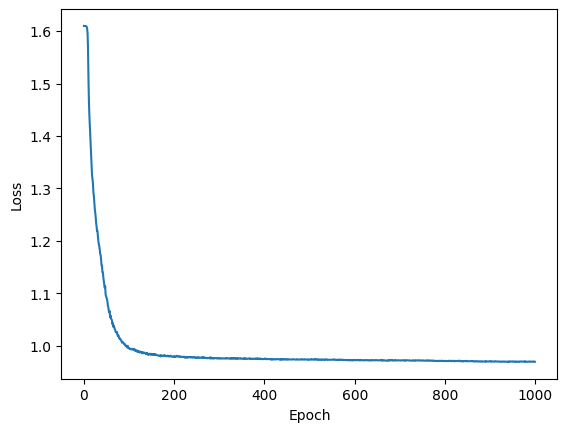

Test accuracy: 465.2683870967742
Accuracy: 0.44946236559139785
Precision: 0.44611341903315643
Recall: 0.4478517316522869
F1-score: 0.44640370080477465


Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.62      0.62       495
           1       0.39      0.35      0.37       472
           2       0.30      0.29      0.30       449
           3       0.32      0.35      0.34       463
           4       0.59      0.63      0.61       446

    accuracy                           0.45      2325
   macro avg       0.45      0.45      0.45      2325
weighted avg       0.45      0.45      0.45      2325

                    0           1           2           3           4  \
precision    0.625255    0.394231    0.303448    0.321499    0.586134   
recall       0.620202    0.347458    0.293987    0.352052    0.625561   
f1-score     0.622718    0.369369    0.298643    0.336082    0.605206   
support    495.000000  472.000000  449.0000

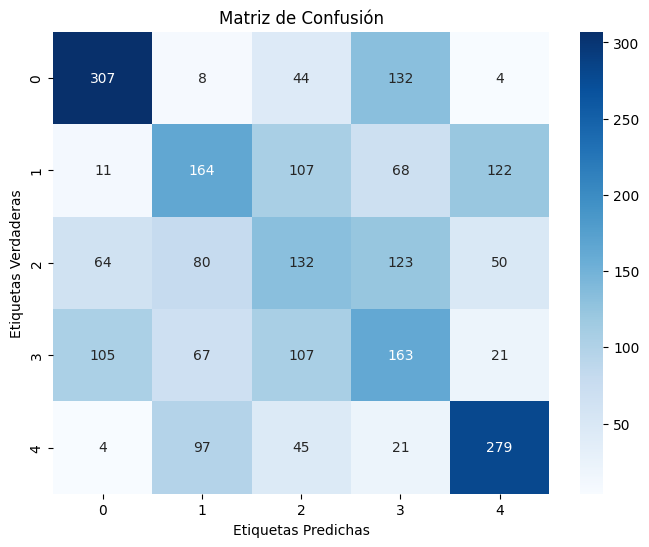

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_1000_1e-05_0.3/resultados_1000_1e-05_0.3.json
Procesando red con 700 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas:   0%|                                                               | 1/700 [00:02<32:55,  2.83s/it]

1.609395042587729


Procesando epocas:   0%|▏                                                              | 2/700 [00:05<32:45,  2.82s/it]

1.5277639837826


Procesando epocas:   0%|▎                                                              | 3/700 [00:08<32:39,  2.81s/it]

1.4124634476268993


Procesando epocas:   1%|▎                                                              | 4/700 [00:11<32:36,  2.81s/it]

1.3529083518420948


Procesando epocas:   1%|▍                                                              | 5/700 [00:14<32:36,  2.82s/it]

1.2972054095829235


Procesando epocas:   1%|▌                                                              | 6/700 [00:16<32:34,  2.82s/it]

1.255881313015433


Procesando epocas:   1%|▋                                                              | 7/700 [00:19<32:27,  2.81s/it]

1.2281810697387248


Procesando epocas:   1%|▋                                                              | 8/700 [00:22<32:26,  2.81s/it]

1.2072182809605319


Procesando epocas:   1%|▊                                                              | 9/700 [00:25<32:16,  2.80s/it]

1.1915344739661498


Procesando epocas:   1%|▉                                                             | 10/700 [00:28<32:10,  2.80s/it]

1.1813105828621808


Procesando epocas:   2%|▉                                                             | 11/700 [00:30<32:07,  2.80s/it]

1.1772802738582386


Procesando epocas:   2%|█                                                             | 12/700 [00:33<32:00,  2.79s/it]

1.1695354910457836


Procesando epocas:   2%|█▏                                                            | 13/700 [00:36<31:53,  2.79s/it]

1.1648073876605314


Procesando epocas:   2%|█▏                                                            | 14/700 [00:39<31:56,  2.79s/it]

1.1626706526559942


Procesando epocas:   2%|█▎                                                            | 15/700 [00:42<31:49,  2.79s/it]

1.1601813372443703


Procesando epocas:   2%|█▍                                                            | 16/700 [00:44<31:49,  2.79s/it]

1.154288582942065


Procesando epocas:   2%|█▌                                                            | 17/700 [00:47<31:50,  2.80s/it]

1.1439159638741436


Procesando epocas:   3%|█▌                                                            | 18/700 [00:50<31:46,  2.79s/it]

1.1286041996058296


Procesando epocas:   3%|█▋                                                            | 19/700 [00:53<31:42,  2.79s/it]

1.1086288659011616


Procesando epocas:   3%|█▊                                                            | 20/700 [00:55<31:34,  2.79s/it]

1.0999741442063276


Procesando epocas:   3%|█▊                                                            | 21/700 [00:58<31:31,  2.79s/it]

1.0806547778494218


Procesando epocas:   3%|█▉                                                            | 22/700 [01:01<31:36,  2.80s/it]

1.0679120596717386


Procesando epocas:   3%|██                                                            | 23/700 [01:04<31:24,  2.78s/it]

1.0561906656798195


Procesando epocas:   3%|██▏                                                           | 24/700 [01:07<31:24,  2.79s/it]

1.0516807338770697


Procesando epocas:   4%|██▏                                                           | 25/700 [01:09<31:20,  2.79s/it]

1.048686942282845


Procesando epocas:   4%|██▎                                                           | 26/700 [01:12<31:21,  2.79s/it]

1.0484920715584474


Procesando epocas:   4%|██▍                                                           | 27/700 [01:15<31:26,  2.80s/it]

1.0458534394993502


Procesando epocas:   4%|██▍                                                           | 28/700 [01:18<31:23,  2.80s/it]

1.039825341982


Procesando epocas:   4%|██▌                                                           | 29/700 [01:21<31:18,  2.80s/it]

1.0359506140736972


Procesando epocas:   4%|██▋                                                           | 30/700 [01:23<31:16,  2.80s/it]

1.0313871990231906


Procesando epocas:   4%|██▋                                                           | 31/700 [01:26<31:17,  2.81s/it]

1.030455002714606


Procesando epocas:   5%|██▊                                                           | 32/700 [01:29<31:13,  2.80s/it]

1.0258525816833273


Procesando epocas:   5%|██▉                                                           | 33/700 [01:32<31:13,  2.81s/it]

1.0269086115500505


Procesando epocas:   5%|███                                                           | 34/700 [01:35<31:08,  2.81s/it]

1.023992254453547


Procesando epocas:   5%|███                                                           | 35/700 [01:37<30:54,  2.79s/it]

1.0262259637608249


Procesando epocas:   5%|███▏                                                          | 36/700 [01:40<30:50,  2.79s/it]

1.0255701489308302


Procesando epocas:   5%|███▎                                                          | 37/700 [01:43<30:47,  2.79s/it]

1.0218284322934992


Procesando epocas:   5%|███▎                                                          | 38/700 [01:46<30:43,  2.78s/it]

1.0210501576171203


Procesando epocas:   6%|███▍                                                          | 39/700 [01:49<30:43,  2.79s/it]

1.0182991392472212


Procesando epocas:   6%|███▌                                                          | 40/700 [01:51<30:38,  2.79s/it]

1.0213125607546638


Procesando epocas:   6%|███▋                                                          | 41/700 [01:54<30:36,  2.79s/it]

1.0208023776026334


Procesando epocas:   6%|███▋                                                          | 42/700 [01:57<30:29,  2.78s/it]

1.0177555613658007


Procesando epocas:   6%|███▊                                                          | 43/700 [02:00<30:27,  2.78s/it]

1.0186004445833319


Procesando epocas:   6%|███▉                                                          | 44/700 [02:02<30:21,  2.78s/it]

1.019595193161684


Procesando epocas:   6%|███▉                                                          | 45/700 [02:05<30:26,  2.79s/it]

1.0177718474584467


Procesando epocas:   7%|████                                                          | 46/700 [02:08<30:18,  2.78s/it]

1.0209048029254464


Procesando epocas:   7%|████▏                                                         | 47/700 [02:11<30:18,  2.79s/it]

1.0147803958724526


Procesando epocas:   7%|████▎                                                         | 48/700 [02:14<30:17,  2.79s/it]

1.017381318877725


Procesando epocas:   7%|████▎                                                         | 49/700 [02:16<30:16,  2.79s/it]

1.0158287903841805


Procesando epocas:   7%|████▍                                                         | 50/700 [02:19<30:13,  2.79s/it]

1.0159495188909418


Procesando epocas:   7%|████▌                                                         | 51/700 [02:22<30:15,  2.80s/it]

1.0182818339151494


Procesando epocas:   7%|████▌                                                         | 52/700 [02:25<30:14,  2.80s/it]

1.0192619151928846


Procesando epocas:   8%|████▋                                                         | 53/700 [02:28<30:08,  2.79s/it]

1.0176123229896321


Procesando epocas:   8%|████▊                                                         | 54/700 [02:30<30:04,  2.79s/it]

1.020469908503925


Procesando epocas:   8%|████▊                                                         | 55/700 [02:33<29:57,  2.79s/it]

1.0182759421713212


Procesando epocas:   8%|████▉                                                         | 56/700 [02:36<29:57,  2.79s/it]

1.018502721716376


Procesando epocas:   8%|█████                                                         | 57/700 [02:39<29:56,  2.79s/it]

1.02345808078261


Procesando epocas:   8%|█████▏                                                        | 58/700 [02:42<29:49,  2.79s/it]

1.0150033610708573


Procesando epocas:   8%|█████▏                                                        | 59/700 [02:44<29:34,  2.77s/it]

1.0095525552244748


Procesando epocas:   9%|█████▎                                                        | 60/700 [02:47<29:08,  2.73s/it]

1.0107183140866898


Procesando epocas:   9%|█████▍                                                        | 61/700 [02:50<29:00,  2.72s/it]

1.0111972233828377


Procesando epocas:   9%|█████▍                                                        | 62/700 [02:52<29:14,  2.75s/it]

1.007052567425896


Procesando epocas:   9%|█████▌                                                        | 63/700 [02:55<29:15,  2.76s/it]

1.0062799054033615


Procesando epocas:   9%|█████▋                                                        | 64/700 [02:58<29:14,  2.76s/it]

1.004047606271856


Procesando epocas:   9%|█████▊                                                        | 65/700 [03:01<29:21,  2.77s/it]

1.0036562302533318


Procesando epocas:   9%|█████▊                                                        | 66/700 [03:04<29:15,  2.77s/it]

1.0023813612320844


Procesando epocas:  10%|█████▉                                                        | 67/700 [03:06<29:08,  2.76s/it]

1.0027124930830562


Procesando epocas:  10%|██████                                                        | 68/700 [03:09<29:09,  2.77s/it]

1.006541855545605


Procesando epocas:  10%|██████                                                        | 69/700 [03:12<29:12,  2.78s/it]

1.0082869147553164


Procesando epocas:  10%|██████▏                                                       | 70/700 [03:15<29:02,  2.77s/it]

1.0114037738126866


Procesando epocas:  10%|██████▎                                                       | 71/700 [03:17<29:02,  2.77s/it]

1.009275249523275


Procesando epocas:  10%|██████▍                                                       | 72/700 [03:20<28:58,  2.77s/it]

1.0134244687416973


Procesando epocas:  10%|██████▍                                                       | 73/700 [03:23<28:57,  2.77s/it]

1.0080577573355507


Procesando epocas:  11%|██████▌                                                       | 74/700 [03:26<28:41,  2.75s/it]

1.004149119643604


Procesando epocas:  11%|██████▋                                                       | 75/700 [03:28<28:27,  2.73s/it]

1.007690981907003


Procesando epocas:  11%|██████▋                                                       | 76/700 [03:31<28:22,  2.73s/it]

1.0068394057890948


Procesando epocas:  11%|██████▊                                                       | 77/700 [03:34<28:04,  2.70s/it]

1.0038511959945455


Procesando epocas:  11%|██████▉                                                       | 78/700 [03:36<28:15,  2.73s/it]

1.0035011326565462


Procesando epocas:  11%|██████▉                                                       | 79/700 [03:39<28:16,  2.73s/it]

1.004109855259166


Procesando epocas:  11%|███████                                                       | 80/700 [03:42<28:19,  2.74s/it]

1.0036818602505853


Procesando epocas:  12%|███████▏                                                      | 81/700 [03:45<28:10,  2.73s/it]

1.004391038417816


Procesando epocas:  12%|███████▎                                                      | 82/700 [03:47<28:01,  2.72s/it]

1.0071772459675283


Procesando epocas:  12%|███████▎                                                      | 83/700 [03:50<27:55,  2.72s/it]

1.006525620993446


Procesando epocas:  12%|███████▍                                                      | 84/700 [03:53<27:50,  2.71s/it]

1.0079906761646271


Procesando epocas:  12%|███████▌                                                      | 85/700 [03:55<27:45,  2.71s/it]

1.0068179084974176


Procesando epocas:  12%|███████▌                                                      | 86/700 [03:58<27:42,  2.71s/it]

1.007358331189436


Procesando epocas:  12%|███████▋                                                      | 87/700 [04:01<27:33,  2.70s/it]

1.0065063939375036


Procesando epocas:  13%|███████▊                                                      | 88/700 [04:04<27:27,  2.69s/it]

1.0063628200222463


Procesando epocas:  13%|███████▉                                                      | 89/700 [04:06<27:26,  2.69s/it]

1.007936765867121


Procesando epocas:  13%|███████▉                                                      | 90/700 [04:09<27:30,  2.71s/it]

1.0088929961709414


Procesando epocas:  13%|████████                                                      | 91/700 [04:12<27:28,  2.71s/it]

1.006258880741456


Procesando epocas:  13%|████████▏                                                     | 92/700 [04:14<27:21,  2.70s/it]

1.007673104720957


Procesando epocas:  13%|████████▏                                                     | 93/700 [04:17<27:15,  2.69s/it]

1.006397948545568


Procesando epocas:  13%|████████▎                                                     | 94/700 [04:20<27:15,  2.70s/it]

1.0070871272507835


Procesando epocas:  14%|████████▍                                                     | 95/700 [04:22<27:12,  2.70s/it]

1.0108068473198835


Procesando epocas:  14%|████████▌                                                     | 96/700 [04:25<27:04,  2.69s/it]

1.0072645478388842


Procesando epocas:  14%|████████▌                                                     | 97/700 [04:28<26:56,  2.68s/it]

1.0059534963439494


Procesando epocas:  14%|████████▋                                                     | 98/700 [04:30<26:53,  2.68s/it]

1.0067700452664319


Procesando epocas:  14%|████████▊                                                     | 99/700 [04:33<26:48,  2.68s/it]

1.0035033176927006


Procesando epocas:  14%|████████▋                                                    | 100/700 [04:36<26:56,  2.69s/it]

1.0042615378604216


Procesando epocas:  14%|████████▊                                                    | 101/700 [04:39<26:55,  2.70s/it]

1.0013400449472316


Procesando epocas:  15%|████████▉                                                    | 102/700 [04:41<26:58,  2.71s/it]

1.0042966958354502


Procesando epocas:  15%|████████▉                                                    | 103/700 [04:44<26:55,  2.71s/it]

1.0053876442067764


Procesando epocas:  15%|█████████                                                    | 104/700 [04:47<27:00,  2.72s/it]

1.0073507996166453


Procesando epocas:  15%|█████████▏                                                   | 105/700 [04:50<27:06,  2.73s/it]

1.0034149818560656


Procesando epocas:  15%|█████████▏                                                   | 106/700 [04:52<27:06,  2.74s/it]

1.0024212675936082


Procesando epocas:  15%|█████████▎                                                   | 107/700 [04:55<27:08,  2.75s/it]

0.9997289531371173


Procesando epocas:  15%|█████████▍                                                   | 108/700 [04:58<27:07,  2.75s/it]

1.002042899061652


Procesando epocas:  16%|█████████▍                                                   | 109/700 [05:01<27:09,  2.76s/it]

0.9993153715834898


Procesando epocas:  16%|█████████▌                                                   | 110/700 [05:03<27:08,  2.76s/it]

0.997931710060905


Procesando epocas:  16%|█████████▋                                                   | 111/700 [05:06<27:01,  2.75s/it]

0.9973731426631703


Procesando epocas:  16%|█████████▊                                                   | 112/700 [05:09<26:58,  2.75s/it]

0.9953711888369392


Procesando epocas:  16%|█████████▊                                                   | 113/700 [05:12<27:00,  2.76s/it]

0.9953455991604749


Procesando epocas:  16%|█████████▉                                                   | 114/700 [05:14<26:59,  2.76s/it]

0.9935515684240005


Procesando epocas:  16%|██████████                                                   | 115/700 [05:17<27:00,  2.77s/it]

0.9927540291758145


Procesando epocas:  17%|██████████                                                   | 116/700 [05:20<26:58,  2.77s/it]

0.9940179915989147


Procesando epocas:  17%|██████████▏                                                  | 117/700 [05:23<26:55,  2.77s/it]

0.9942262021934285


Procesando epocas:  17%|██████████▎                                                  | 118/700 [05:25<26:49,  2.77s/it]

0.9940361454206355


Procesando epocas:  17%|██████████▎                                                  | 119/700 [05:28<26:39,  2.75s/it]

0.9954229544190799


Procesando epocas:  17%|██████████▍                                                  | 120/700 [05:31<26:35,  2.75s/it]

0.9961682431838091


Procesando epocas:  17%|██████████▌                                                  | 121/700 [05:34<26:39,  2.76s/it]

0.999369404596441


Procesando epocas:  17%|██████████▋                                                  | 122/700 [05:36<26:35,  2.76s/it]

0.9965580214472378


Procesando epocas:  18%|██████████▋                                                  | 123/700 [05:39<26:34,  2.76s/it]

0.9942053272443659


Procesando epocas:  18%|██████████▊                                                  | 124/700 [05:42<26:27,  2.76s/it]

0.9945672101834241


Procesando epocas:  18%|██████████▉                                                  | 125/700 [05:45<26:24,  2.76s/it]

0.9945407779777751


Procesando epocas:  18%|██████████▉                                                  | 126/700 [05:48<26:26,  2.76s/it]

0.9938300721785601


Procesando epocas:  18%|███████████                                                  | 127/700 [05:50<26:16,  2.75s/it]

0.9950779823695912


Procesando epocas:  18%|███████████▏                                                 | 128/700 [05:53<26:10,  2.75s/it]

0.9930519749136532


Procesando epocas:  18%|███████████▏                                                 | 129/700 [05:56<26:17,  2.76s/it]

0.9921797464875614


Procesando epocas:  19%|███████████▎                                                 | 130/700 [05:59<26:10,  2.75s/it]

0.991438532927457


Procesando epocas:  19%|███████████▍                                                 | 131/700 [06:01<26:00,  2.74s/it]

0.9913850163712221


Procesando epocas:  19%|███████████▌                                                 | 132/700 [06:04<25:59,  2.75s/it]

0.9943028684924631


Procesando epocas:  19%|███████████▌                                                 | 133/700 [06:07<25:54,  2.74s/it]

0.9964395666823668


Procesando epocas:  19%|███████████▋                                                 | 134/700 [06:09<25:50,  2.74s/it]

0.9981562449651606


Procesando epocas:  19%|███████████▊                                                 | 135/700 [06:12<25:49,  2.74s/it]

0.9957370028776281


Procesando epocas:  19%|███████████▊                                                 | 136/700 [06:15<25:48,  2.75s/it]

0.9954102403977338


Procesando epocas:  20%|███████████▉                                                 | 137/700 [06:18<25:45,  2.75s/it]

0.9940513936912312


Procesando epocas:  20%|████████████                                                 | 138/700 [06:20<25:34,  2.73s/it]

0.9938613526961383


Procesando epocas:  20%|████████████                                                 | 139/700 [06:23<25:29,  2.73s/it]

0.9932887939845815


Procesando epocas:  20%|████████████▏                                                | 140/700 [06:26<25:25,  2.72s/it]

0.9946370475432452


Procesando epocas:  20%|████████████▎                                                | 141/700 [06:29<25:29,  2.74s/it]

0.9956514803802266


Procesando epocas:  20%|████████████▎                                                | 142/700 [06:31<25:25,  2.73s/it]

0.9971708452000337


Procesando epocas:  20%|████████████▍                                                | 143/700 [06:34<25:18,  2.73s/it]

0.9960651660666746


Procesando epocas:  21%|████████████▌                                                | 144/700 [06:37<25:11,  2.72s/it]

1.0003262477762558


Procesando epocas:  21%|████████████▋                                                | 145/700 [06:39<25:06,  2.71s/it]

0.9999736273989958


Procesando epocas:  21%|████████████▋                                                | 146/700 [06:42<25:07,  2.72s/it]

0.9983691832598518


Procesando epocas:  21%|████████████▊                                                | 147/700 [06:45<25:08,  2.73s/it]

0.9945973238524268


Procesando epocas:  21%|████████████▉                                                | 148/700 [06:48<25:03,  2.72s/it]

0.9958752446314868


Procesando epocas:  21%|████████████▉                                                | 149/700 [06:50<25:01,  2.72s/it]

0.9930296508704914


Procesando epocas:  21%|█████████████                                                | 150/700 [06:53<25:01,  2.73s/it]

0.9954783348476186


Procesando epocas:  22%|█████████████▏                                               | 151/700 [06:56<25:02,  2.74s/it]

0.9931923287756302


Procesando epocas:  22%|█████████████▏                                               | 152/700 [06:59<25:04,  2.75s/it]

0.994445617759929


Procesando epocas:  22%|█████████████▎                                               | 153/700 [07:01<24:59,  2.74s/it]

0.9928478461854598


Procesando epocas:  22%|█████████████▍                                               | 154/700 [07:04<24:55,  2.74s/it]

0.9927825692821951


Procesando epocas:  22%|█████████████▌                                               | 155/700 [07:07<24:52,  2.74s/it]

0.9915391641504624


Procesando epocas:  22%|█████████████▌                                               | 156/700 [07:10<24:49,  2.74s/it]

0.9909365966039545


Procesando epocas:  22%|█████████████▋                                               | 157/700 [07:12<24:40,  2.73s/it]

0.9903934068539564


Procesando epocas:  23%|█████████████▊                                               | 158/700 [07:15<24:39,  2.73s/it]

0.9895746574682348


Procesando epocas:  23%|█████████████▊                                               | 159/700 [07:18<24:40,  2.74s/it]

0.9894270293852863


Procesando epocas:  23%|█████████████▉                                               | 160/700 [07:21<24:44,  2.75s/it]

0.989069856966243


Procesando epocas:  23%|██████████████                                               | 161/700 [07:23<24:28,  2.72s/it]

0.9904215416487525


Procesando epocas:  23%|██████████████                                               | 162/700 [07:26<24:14,  2.70s/it]

0.9915170346989352


Procesando epocas:  23%|██████████████▏                                              | 163/700 [07:29<24:09,  2.70s/it]

0.9904304549974554


Procesando epocas:  23%|██████████████▎                                              | 164/700 [07:31<24:11,  2.71s/it]

0.9896990628803477


Procesando epocas:  24%|██████████████▍                                              | 165/700 [07:34<23:58,  2.69s/it]

0.9894970280282638


Procesando epocas:  24%|██████████████▍                                              | 166/700 [07:37<23:48,  2.68s/it]

0.9906247650875765


Procesando epocas:  24%|██████████████▌                                              | 167/700 [07:39<23:45,  2.67s/it]

0.9898186739753274


Procesando epocas:  24%|██████████████▋                                              | 168/700 [07:42<23:47,  2.68s/it]

0.9931493282318116


Procesando epocas:  24%|██████████████▋                                              | 169/700 [07:45<23:47,  2.69s/it]

0.9894732548910029


Procesando epocas:  24%|██████████████▊                                              | 170/700 [07:47<23:37,  2.67s/it]

0.9905864435083725


Procesando epocas:  24%|██████████████▉                                              | 171/700 [07:50<23:28,  2.66s/it]

0.9898163339670967


Procesando epocas:  25%|██████████████▉                                              | 172/700 [07:53<23:20,  2.65s/it]

0.9875622675699346


Procesando epocas:  25%|███████████████                                              | 173/700 [07:55<23:15,  2.65s/it]

0.9894088099984562


Procesando epocas:  25%|███████████████▏                                             | 174/700 [07:58<23:09,  2.64s/it]

0.9873224440742941


Procesando epocas:  25%|███████████████▎                                             | 175/700 [08:00<23:06,  2.64s/it]

0.9887105524539948


Procesando epocas:  25%|███████████████▎                                             | 176/700 [08:03<23:04,  2.64s/it]

0.9886048457201789


Procesando epocas:  25%|███████████████▍                                             | 177/700 [08:06<23:12,  2.66s/it]

0.9863610211540671


Procesando epocas:  25%|███████████████▌                                             | 178/700 [08:08<23:12,  2.67s/it]

0.990768661218531


Procesando epocas:  26%|███████████████▌                                             | 179/700 [08:11<23:14,  2.68s/it]

0.9874699497924132


Procesando epocas:  26%|███████████████▋                                             | 180/700 [08:14<23:16,  2.69s/it]

0.9874547884744757


Procesando epocas:  26%|███████████████▊                                             | 181/700 [08:17<23:19,  2.70s/it]

0.9872220239218543


Procesando epocas:  26%|███████████████▊                                             | 182/700 [08:19<23:10,  2.68s/it]

0.986665262895472


Procesando epocas:  26%|███████████████▉                                             | 183/700 [08:22<22:59,  2.67s/it]

0.9863428038709304


Procesando epocas:  26%|████████████████                                             | 184/700 [08:25<23:01,  2.68s/it]

0.9834089896258186


Procesando epocas:  26%|████████████████                                             | 185/700 [08:27<23:15,  2.71s/it]

0.985597825050354


Procesando epocas:  27%|████████████████▏                                            | 186/700 [08:30<23:28,  2.74s/it]

0.9834250327418832


Procesando epocas:  27%|████████████████▎                                            | 187/700 [08:33<23:36,  2.76s/it]

0.9875387815868153


Procesando epocas:  27%|████████████████▍                                            | 188/700 [08:36<23:34,  2.76s/it]

0.988109595635358


Procesando epocas:  27%|████████████████▍                                            | 189/700 [08:38<23:23,  2.75s/it]

0.9886313687352574


Procesando epocas:  27%|████████████████▌                                            | 190/700 [08:41<23:13,  2.73s/it]

0.9860366207711837


Procesando epocas:  27%|████████████████▋                                            | 191/700 [08:44<23:04,  2.72s/it]

0.9850832802407882


Procesando epocas:  27%|████████████████▋                                            | 192/700 [08:47<23:04,  2.73s/it]

0.985195108722238


Procesando epocas:  28%|████████████████▊                                            | 193/700 [08:49<22:59,  2.72s/it]

0.9861670623807346


Procesando epocas:  28%|████████████████▉                                            | 194/700 [08:52<22:49,  2.71s/it]

0.9854100339552936


Procesando epocas:  28%|████████████████▉                                            | 195/700 [08:55<22:49,  2.71s/it]

0.9863925116903641


Procesando epocas:  28%|█████████████████                                            | 196/700 [08:57<22:59,  2.74s/it]

0.9863232949200799


Procesando epocas:  28%|█████████████████▏                                           | 197/700 [09:00<22:56,  2.74s/it]

0.9835642586736119


Procesando epocas:  28%|█████████████████▎                                           | 198/700 [09:03<22:45,  2.72s/it]

0.9838970885557287


Procesando epocas:  28%|█████████████████▎                                           | 199/700 [09:06<22:38,  2.71s/it]

0.9854890339514788


Procesando epocas:  29%|█████████████████▍                                           | 200/700 [09:08<22:32,  2.70s/it]

0.9916164783870473


Procesando epocas:  29%|█████████████████▌                                           | 201/700 [09:11<22:24,  2.70s/it]

0.985524201743743


Procesando epocas:  29%|█████████████████▌                                           | 202/700 [09:14<22:19,  2.69s/it]

0.986608337654787


Procesando epocas:  29%|█████████████████▋                                           | 203/700 [09:16<22:17,  2.69s/it]

0.9913857028764836


Procesando epocas:  29%|█████████████████▊                                           | 204/700 [09:19<22:14,  2.69s/it]

0.9886480124557719


Procesando epocas:  29%|█████████████████▊                                           | 205/700 [09:22<22:11,  2.69s/it]

0.987666727514828


Procesando epocas:  29%|█████████████████▉                                           | 206/700 [09:24<22:07,  2.69s/it]

0.9885091360877541


Procesando epocas:  30%|██████████████████                                           | 207/700 [09:27<22:07,  2.69s/it]

0.9863279009566588


Procesando epocas:  30%|██████████████████▏                                          | 208/700 [09:30<22:03,  2.69s/it]

0.98506878824795


Procesando epocas:  30%|██████████████████▏                                          | 209/700 [09:32<21:58,  2.69s/it]

0.9862052363507888


Procesando epocas:  30%|██████████████████▎                                          | 210/700 [09:35<21:58,  2.69s/it]

0.9842685233144199


Procesando epocas:  30%|██████████████████▍                                          | 211/700 [09:38<21:56,  2.69s/it]

0.982793777479845


Procesando epocas:  30%|██████████████████▍                                          | 212/700 [09:41<21:53,  2.69s/it]

0.9830057908506954


Procesando epocas:  30%|██████████████████▌                                          | 213/700 [09:43<21:53,  2.70s/it]

0.9848767178900102


Procesando epocas:  31%|██████████████████▋                                          | 214/700 [09:46<21:46,  2.69s/it]

0.9848930155529695


Procesando epocas:  31%|██████████████████▋                                          | 215/700 [09:49<21:47,  2.70s/it]

0.9851288304609411


Procesando epocas:  31%|██████████████████▊                                          | 216/700 [09:51<21:43,  2.69s/it]

0.9852830851779265


Procesando epocas:  31%|██████████████████▉                                          | 217/700 [09:54<21:39,  2.69s/it]

0.9870946719365962


Procesando epocas:  31%|██████████████████▉                                          | 218/700 [09:57<21:37,  2.69s/it]

0.9862522931659923


Procesando epocas:  31%|███████████████████                                          | 219/700 [09:59<21:44,  2.71s/it]

0.9853393677402945


Procesando epocas:  31%|███████████████████▏                                         | 220/700 [10:02<21:48,  2.73s/it]

0.982902601887198


Procesando epocas:  32%|███████████████████▎                                         | 221/700 [10:05<21:42,  2.72s/it]

0.9818759185426376


Procesando epocas:  32%|███████████████████▎                                         | 222/700 [10:08<21:41,  2.72s/it]

0.9853164932307075


Procesando epocas:  32%|███████████████████▍                                         | 223/700 [10:10<21:41,  2.73s/it]

0.980420070886612


Procesando epocas:  32%|███████████████████▌                                         | 224/700 [10:13<21:41,  2.73s/it]

0.9804069448919858


Procesando epocas:  32%|███████████████████▌                                         | 225/700 [10:16<21:43,  2.74s/it]

0.9808499501031988


Procesando epocas:  32%|███████████████████▋                                         | 226/700 [10:19<21:38,  2.74s/it]

0.9800874892403098


Procesando epocas:  32%|███████████████████▊                                         | 227/700 [10:21<21:33,  2.74s/it]

0.9794821160681108


Procesando epocas:  33%|███████████████████▊                                         | 228/700 [10:24<21:38,  2.75s/it]

0.9794317673234378


Procesando epocas:  33%|███████████████████▉                                         | 229/700 [10:27<21:37,  2.75s/it]

0.9789536879343145


Procesando epocas:  33%|████████████████████                                         | 230/700 [10:30<21:30,  2.75s/it]

0.9800411995719461


Procesando epocas:  33%|████████████████████▏                                        | 231/700 [10:32<21:25,  2.74s/it]

0.9796073471798616


Procesando epocas:  33%|████████████████████▏                                        | 232/700 [10:35<21:23,  2.74s/it]

0.9796950224567862


Procesando epocas:  33%|████████████████████▎                                        | 233/700 [10:38<21:27,  2.76s/it]

0.98175569877905


Procesando epocas:  33%|████████████████████▍                                        | 234/700 [10:41<21:23,  2.76s/it]

0.9842721753260668


Procesando epocas:  34%|████████████████████▍                                        | 235/700 [10:43<21:21,  2.76s/it]

0.9841168989153469


Procesando epocas:  34%|████████████████████▌                                        | 236/700 [10:46<21:15,  2.75s/it]

0.9846591626896578


Procesando epocas:  34%|████████████████████▋                                        | 237/700 [10:49<21:08,  2.74s/it]

0.9822376875316395


Procesando epocas:  34%|████████████████████▋                                        | 238/700 [10:52<21:05,  2.74s/it]

0.9820547412423527


Procesando epocas:  34%|████████████████████▊                                        | 239/700 [10:54<21:02,  2.74s/it]

0.9828617015305687


Procesando epocas:  34%|████████████████████▉                                        | 240/700 [10:57<21:00,  2.74s/it]

0.9812254011631012


Procesando epocas:  34%|█████████████████████                                        | 241/700 [11:00<20:58,  2.74s/it]

0.9826466946040883


Procesando epocas:  35%|█████████████████████                                        | 242/700 [11:03<20:51,  2.73s/it]

0.9788573100286372


Procesando epocas:  35%|█████████████████████▏                                       | 243/700 [11:05<20:46,  2.73s/it]

0.9818025343558368


Procesando epocas:  35%|█████████████████████▎                                       | 244/700 [11:08<20:43,  2.73s/it]

0.9781332373619079


Procesando epocas:  35%|█████████████████████▎                                       | 245/700 [11:11<20:51,  2.75s/it]

0.9768133310710683


Procesando epocas:  35%|█████████████████████▍                                       | 246/700 [11:14<20:47,  2.75s/it]

0.9782255386604982


Procesando epocas:  35%|█████████████████████▌                                       | 247/700 [11:16<20:41,  2.74s/it]

0.9809566964121426


Procesando epocas:  35%|█████████████████████▌                                       | 248/700 [11:19<20:33,  2.73s/it]

0.979568683049258


Procesando epocas:  36%|█████████████████████▋                                       | 249/700 [11:22<20:30,  2.73s/it]

0.9782937410999747


Procesando epocas:  36%|█████████████████████▊                                       | 250/700 [11:24<20:25,  2.72s/it]

0.9783463891814737


Procesando epocas:  36%|█████████████████████▊                                       | 251/700 [11:27<20:22,  2.72s/it]

0.9814196491942686


Procesando epocas:  36%|█████████████████████▉                                       | 252/700 [11:30<20:19,  2.72s/it]

0.9780988083166234


Procesando epocas:  36%|██████████████████████                                       | 253/700 [11:33<20:16,  2.72s/it]

0.9783618863891153


Procesando epocas:  36%|██████████████████████▏                                      | 254/700 [11:35<20:11,  2.72s/it]

0.9790463296806111


Procesando epocas:  36%|██████████████████████▏                                      | 255/700 [11:38<20:11,  2.72s/it]

0.9777938912896549


Procesando epocas:  37%|██████████████████████▎                                      | 256/700 [11:41<20:06,  2.72s/it]

0.9768733017584856


Procesando epocas:  37%|██████████████████████▍                                      | 257/700 [11:43<20:05,  2.72s/it]

0.9767059827552123


Procesando epocas:  37%|██████████████████████▍                                      | 258/700 [11:46<20:02,  2.72s/it]

0.9773927614969365


Procesando epocas:  37%|██████████████████████▌                                      | 259/700 [11:49<20:00,  2.72s/it]

0.9777831337031196


Procesando epocas:  37%|██████████████████████▋                                      | 260/700 [11:52<19:59,  2.73s/it]

0.9778452498071334


Procesando epocas:  37%|██████████████████████▋                                      | 261/700 [11:54<19:53,  2.72s/it]

0.9776917555752922


Procesando epocas:  37%|██████████████████████▊                                      | 262/700 [11:57<20:01,  2.74s/it]

0.9824733397539924


Procesando epocas:  38%|██████████████████████▉                                      | 263/700 [12:00<20:01,  2.75s/it]

0.9790437112836277


Procesando epocas:  38%|███████████████████████                                      | 264/700 [12:03<19:59,  2.75s/it]

0.9769173944697661


Procesando epocas:  38%|███████████████████████                                      | 265/700 [12:05<19:59,  2.76s/it]

0.9766305842820335


Procesando epocas:  38%|███████████████████████▏                                     | 266/700 [12:08<20:00,  2.77s/it]

0.9801192164421082


Procesando epocas:  38%|███████████████████████▎                                     | 267/700 [12:11<20:03,  2.78s/it]

0.9793396834064932


Procesando epocas:  38%|███████████████████████▎                                     | 268/700 [12:14<20:02,  2.78s/it]

0.9761938855928534


Procesando epocas:  38%|███████████████████████▍                                     | 269/700 [12:17<19:58,  2.78s/it]

0.9849523326929878


Procesando epocas:  39%|███████████████████████▌                                     | 270/700 [12:19<19:55,  2.78s/it]

0.979498245084987


Procesando epocas:  39%|███████████████████████▌                                     | 271/700 [12:22<19:53,  2.78s/it]

0.979163618999369


Procesando epocas:  39%|███████████████████████▋                                     | 272/700 [12:25<19:48,  2.78s/it]

0.9812431247795329


Procesando epocas:  39%|███████████████████████▊                                     | 273/700 [12:28<19:37,  2.76s/it]

0.9792440575711867


Procesando epocas:  39%|███████████████████████▉                                     | 274/700 [12:30<19:31,  2.75s/it]

0.9777576292262358


Procesando epocas:  39%|███████████████████████▉                                     | 275/700 [12:33<19:25,  2.74s/it]

0.9786249402691336


Procesando epocas:  39%|████████████████████████                                     | 276/700 [12:36<19:26,  2.75s/it]

0.9798296500654782


Procesando epocas:  40%|████████████████████████▏                                    | 277/700 [12:39<19:29,  2.76s/it]

0.9794101469657001


Procesando epocas:  40%|████████████████████████▏                                    | 278/700 [12:41<19:32,  2.78s/it]

0.9789172947406769


Procesando epocas:  40%|████████████████████████▎                                    | 279/700 [12:44<19:34,  2.79s/it]

0.9796888922943788


Procesando epocas:  40%|████████████████████████▍                                    | 280/700 [12:47<19:33,  2.79s/it]

0.9829850410713868


Procesando epocas:  40%|████████████████████████▍                                    | 281/700 [12:50<19:35,  2.81s/it]

0.9793822968707365


Procesando epocas:  40%|████████████████████████▌                                    | 282/700 [12:53<19:33,  2.81s/it]

0.978415831748177


Procesando epocas:  40%|████████████████████████▋                                    | 283/700 [12:56<19:29,  2.81s/it]

0.9841198037652409


Procesando epocas:  41%|████████████████████████▋                                    | 284/700 [12:58<19:26,  2.80s/it]

0.9801214765099918


Procesando epocas:  41%|████████████████████████▊                                    | 285/700 [13:01<19:17,  2.79s/it]

0.9859172544058632


Procesando epocas:  41%|████████████████████████▉                                    | 286/700 [13:04<19:13,  2.79s/it]

0.9792723568046794


Procesando epocas:  41%|█████████████████████████                                    | 287/700 [13:07<19:11,  2.79s/it]

0.9789093371699839


Procesando epocas:  41%|█████████████████████████                                    | 288/700 [13:09<19:11,  2.79s/it]

0.9788156803916482


Procesando epocas:  41%|█████████████████████████▏                                   | 289/700 [13:12<19:06,  2.79s/it]

0.9775614479008843


Procesando epocas:  41%|█████████████████████████▎                                   | 290/700 [13:15<18:51,  2.76s/it]

0.9755175594021293


Procesando epocas:  42%|█████████████████████████▎                                   | 291/700 [13:18<18:51,  2.77s/it]

0.9773224167964037


Procesando epocas:  42%|█████████████████████████▍                                   | 292/700 [13:20<18:50,  2.77s/it]

0.9765595821773305


Procesando epocas:  42%|█████████████████████████▌                                   | 293/700 [13:23<18:41,  2.76s/it]

0.9760762011303621


Procesando epocas:  42%|█████████████████████████▌                                   | 294/700 [13:26<18:34,  2.75s/it]

0.9746650583603803


Procesando epocas:  42%|█████████████████████████▋                                   | 295/700 [13:29<18:33,  2.75s/it]

0.9759299274753122


Procesando epocas:  42%|█████████████████████████▊                                   | 296/700 [13:31<18:32,  2.75s/it]

0.9755605774767259


Procesando epocas:  42%|█████████████████████████▉                                   | 297/700 [13:34<18:23,  2.74s/it]

0.9756159817471224


Procesando epocas:  43%|█████████████████████████▉                                   | 298/700 [13:37<18:14,  2.72s/it]

0.9740905688089483


Procesando epocas:  43%|██████████████████████████                                   | 299/700 [13:40<18:13,  2.73s/it]

0.9737961460562313


Procesando epocas:  43%|██████████████████████████▏                                  | 300/700 [13:42<18:11,  2.73s/it]

0.9731179742252125


Procesando epocas:  43%|██████████████████████████▏                                  | 301/700 [13:45<18:02,  2.71s/it]

0.9735808470669914


Procesando epocas:  43%|██████████████████████████▎                                  | 302/700 [13:48<18:00,  2.71s/it]

0.9719931882970473


Procesando epocas:  43%|██████████████████████████▍                                  | 303/700 [13:50<17:59,  2.72s/it]

0.9746719865237965


Procesando epocas:  43%|██████████████████████████▍                                  | 304/700 [13:53<17:54,  2.71s/it]

0.9758805176791023


Procesando epocas:  44%|██████████████████████████▌                                  | 305/700 [13:56<17:50,  2.71s/it]

0.9736065836513743


Procesando epocas:  44%|██████████████████████████▋                                  | 306/700 [13:59<17:46,  2.71s/it]

0.9715794058407055


Procesando epocas:  44%|██████████████████████████▊                                  | 307/700 [14:01<17:46,  2.71s/it]

0.9749147047014798


Procesando epocas:  44%|██████████████████████████▊                                  | 308/700 [14:04<17:41,  2.71s/it]

0.975461199353723


Procesando epocas:  44%|██████████████████████████▉                                  | 309/700 [14:07<17:37,  2.70s/it]

0.9724052152212929


Procesando epocas:  44%|███████████████████████████                                  | 310/700 [14:09<17:37,  2.71s/it]

0.9753162036923801


Procesando epocas:  44%|███████████████████████████                                  | 311/700 [14:12<17:34,  2.71s/it]

0.9715709647711586


Procesando epocas:  45%|███████████████████████████▏                                 | 312/700 [14:15<17:29,  2.71s/it]

0.9718164556166705


Procesando epocas:  45%|███████████████████████████▎                                 | 313/700 [14:18<17:29,  2.71s/it]

0.9711760839995216


Procesando epocas:  45%|███████████████████████████▎                                 | 314/700 [14:20<17:34,  2.73s/it]

0.9715811978368198


Procesando epocas:  45%|███████████████████████████▍                                 | 315/700 [14:23<17:30,  2.73s/it]

0.9778619741692263


Procesando epocas:  45%|███████████████████████████▌                                 | 316/700 [14:26<17:23,  2.72s/it]

0.9728267645134645


Procesando epocas:  45%|███████████████████████████▌                                 | 317/700 [14:28<17:17,  2.71s/it]

0.9753298391314114


Procesando epocas:  45%|███████████████████████████▋                                 | 318/700 [14:31<17:20,  2.72s/it]

0.974168372855467


Procesando epocas:  46%|███████████████████████████▊                                 | 319/700 [14:34<17:15,  2.72s/it]

0.9747622889630935


Procesando epocas:  46%|███████████████████████████▉                                 | 320/700 [14:37<17:07,  2.70s/it]

0.9770056373932783


Procesando epocas:  46%|███████████████████████████▉                                 | 321/700 [14:39<17:03,  2.70s/it]

0.9723753269980936


Procesando epocas:  46%|████████████████████████████                                 | 322/700 [14:42<17:04,  2.71s/it]

0.9749647200107574


Procesando epocas:  46%|████████████████████████████▏                                | 323/700 [14:45<17:00,  2.71s/it]

0.9761267248321982


Procesando epocas:  46%|████████████████████████████▏                                | 324/700 [14:47<16:54,  2.70s/it]

0.973141098022461


Procesando epocas:  46%|████████████████████████████▎                                | 325/700 [14:50<16:50,  2.69s/it]

0.9721803875530467


Procesando epocas:  47%|████████████████████████████▍                                | 326/700 [14:53<16:47,  2.69s/it]

0.9727920549757341


Procesando epocas:  47%|████████████████████████████▍                                | 327/700 [14:55<16:41,  2.69s/it]

0.9720475046073689


Procesando epocas:  47%|████████████████████████████▌                                | 328/700 [14:58<16:38,  2.68s/it]

0.971070981726927


Procesando epocas:  47%|████████████████████████████▋                                | 329/700 [15:01<16:34,  2.68s/it]

0.9730485674212961


Procesando epocas:  47%|████████████████████████████▊                                | 330/700 [15:03<16:30,  2.68s/it]

0.9720849349218257


Procesando epocas:  47%|████████████████████████████▊                                | 331/700 [15:06<16:33,  2.69s/it]

0.9725798543761758


Procesando epocas:  47%|████████████████████████████▉                                | 332/700 [15:09<16:33,  2.70s/it]

0.9717836134573993


Procesando epocas:  48%|█████████████████████████████                                | 333/700 [15:11<15:48,  2.59s/it]

0.9712916328626521


Procesando epocas:  48%|█████████████████████████████                                | 334/700 [15:14<15:43,  2.58s/it]

0.971690248040592


Procesando epocas:  48%|█████████████████████████████▏                               | 335/700 [15:16<15:56,  2.62s/it]

0.9735167380641488


Procesando epocas:  48%|█████████████████████████████▎                               | 336/700 [15:19<16:03,  2.65s/it]

0.9713096285567564


Procesando epocas:  48%|█████████████████████████████▎                               | 337/700 [15:22<16:04,  2.66s/it]

0.971563376048032


Procesando epocas:  48%|█████████████████████████████▍                               | 338/700 [15:24<16:03,  2.66s/it]

0.9725217233685887


Procesando epocas:  48%|█████████████████████████████▌                               | 339/700 [15:27<16:09,  2.69s/it]

0.9750598988112281


Procesando epocas:  49%|█████████████████████████████▋                               | 340/700 [15:30<16:09,  2.69s/it]

0.9749200368628782


Procesando epocas:  49%|█████████████████████████████▋                               | 341/700 [15:33<16:05,  2.69s/it]

0.9775826394557953


Procesando epocas:  49%|█████████████████████████████▊                               | 342/700 [15:35<16:06,  2.70s/it]

0.9741731310591978


Procesando epocas:  49%|█████████████████████████████▉                               | 343/700 [15:38<16:11,  2.72s/it]

0.9758648153613595


Procesando epocas:  49%|█████████████████████████████▉                               | 344/700 [15:41<16:06,  2.71s/it]

0.9759535203961766


Procesando epocas:  49%|██████████████████████████████                               | 345/700 [15:43<15:59,  2.70s/it]

0.9727216468137854


Procesando epocas:  49%|██████████████████████████████▏                              | 346/700 [15:46<16:05,  2.73s/it]

0.9741467072683222


Procesando epocas:  50%|██████████████████████████████▏                              | 347/700 [15:49<16:10,  2.75s/it]

0.9737503696890438


Procesando epocas:  50%|██████████████████████████████▎                              | 348/700 [15:52<16:07,  2.75s/it]

0.9718560783302083


Procesando epocas:  50%|██████████████████████████████▍                              | 349/700 [15:55<16:03,  2.74s/it]

0.9727285844438216


Procesando epocas:  50%|██████████████████████████████▌                              | 350/700 [15:57<16:06,  2.76s/it]

0.9742178359452416


Procesando epocas:  50%|██████████████████████████████▌                              | 351/700 [16:00<16:07,  2.77s/it]

0.9743204386795268


Procesando epocas:  50%|██████████████████████████████▋                              | 352/700 [16:03<16:07,  2.78s/it]

0.9701818290878744


Procesando epocas:  50%|██████████████████████████████▊                              | 353/700 [16:06<16:08,  2.79s/it]

0.9708857311921961


Procesando epocas:  51%|██████████████████████████████▊                              | 354/700 [16:09<16:08,  2.80s/it]

0.9711264943375307


Procesando epocas:  51%|██████████████████████████████▉                              | 355/700 [16:11<16:07,  2.81s/it]

0.9695892887956956


Procesando epocas:  51%|███████████████████████████████                              | 356/700 [16:14<16:03,  2.80s/it]

0.9686117263401256


Procesando epocas:  51%|███████████████████████████████                              | 357/700 [16:17<16:02,  2.81s/it]

0.9708631294615129


Procesando epocas:  51%|███████████████████████████████▏                             | 358/700 [16:20<16:02,  2.82s/it]

0.9709265246110804


Procesando epocas:  51%|███████████████████████████████▎                             | 359/700 [16:23<15:53,  2.80s/it]

0.969913484769709


Procesando epocas:  51%|███████████████████████████████▎                             | 360/700 [16:25<15:48,  2.79s/it]

0.9729301116045783


Procesando epocas:  52%|███████████████████████████████▍                             | 361/700 [16:28<15:45,  2.79s/it]

0.9758517240776735


Procesando epocas:  52%|███████████████████████████████▌                             | 362/700 [16:31<15:41,  2.79s/it]

0.9708654252921833


Procesando epocas:  52%|███████████████████████████████▋                             | 363/700 [16:34<15:35,  2.78s/it]

0.9693781887783723


Procesando epocas:  52%|███████████████████████████████▋                             | 364/700 [16:36<15:33,  2.78s/it]

0.9685385325375725


Procesando epocas:  52%|███████████████████████████████▊                             | 365/700 [16:39<15:33,  2.79s/it]

0.9701504903681138


Procesando epocas:  52%|███████████████████████████████▉                             | 366/700 [16:42<15:28,  2.78s/it]

0.971198186453651


Procesando epocas:  52%|███████████████████████████████▉                             | 367/700 [16:45<15:23,  2.77s/it]

0.9687673190060784


Procesando epocas:  53%|████████████████████████████████                             | 368/700 [16:48<15:22,  2.78s/it]

0.9676760487696704


Procesando epocas:  53%|████████████████████████████████▏                            | 369/700 [16:50<15:21,  2.78s/it]

0.9679642344222349


Procesando epocas:  53%|████████████████████████████████▏                            | 370/700 [16:53<15:13,  2.77s/it]

0.967702012202319


Procesando epocas:  53%|████████████████████████████████▎                            | 371/700 [16:56<15:10,  2.77s/it]

0.9680160392733181


Procesando epocas:  53%|████████████████████████████████▍                            | 372/700 [16:59<15:11,  2.78s/it]

0.9706012424300698


Procesando epocas:  53%|████████████████████████████████▌                            | 373/700 [17:01<15:09,  2.78s/it]

0.9702093657325296


Procesando epocas:  53%|████████████████████████████████▌                            | 374/700 [17:04<15:01,  2.77s/it]

0.971735234821544


Procesando epocas:  54%|████████████████████████████████▋                            | 375/700 [17:07<14:56,  2.76s/it]

0.9706710254444796


Procesando epocas:  54%|████████████████████████████████▊                            | 376/700 [17:10<14:53,  2.76s/it]

0.9718113927280202


Procesando epocas:  54%|████████████████████████████████▊                            | 377/700 [17:12<14:45,  2.74s/it]

0.9706966382615706


Procesando epocas:  54%|████████████████████████████████▉                            | 378/700 [17:15<14:42,  2.74s/it]

0.969573301076889


Procesando epocas:  54%|█████████████████████████████████                            | 379/700 [17:18<14:40,  2.74s/it]

0.9670298835810494


Procesando epocas:  54%|█████████████████████████████████                            | 380/700 [17:21<14:34,  2.73s/it]

0.971725015780505


Procesando epocas:  54%|█████████████████████████████████▏                           | 381/700 [17:23<14:29,  2.73s/it]

0.9698008067467634


Procesando epocas:  55%|█████████████████████████████████▎                           | 382/700 [17:26<14:30,  2.74s/it]

0.9702869099729201


Procesando epocas:  55%|█████████████████████████████████▍                           | 383/700 [17:29<14:28,  2.74s/it]

0.9680382721564349


Procesando epocas:  55%|█████████████████████████████████▍                           | 384/700 [17:32<14:22,  2.73s/it]

0.967983057569055


Procesando epocas:  55%|█████████████████████████████████▌                           | 385/700 [17:34<14:17,  2.72s/it]

0.9696272800950443


Procesando epocas:  55%|█████████████████████████████████▋                           | 386/700 [17:37<14:12,  2.71s/it]

0.9703924834728241


Procesando epocas:  55%|█████████████████████████████████▋                           | 387/700 [17:40<14:09,  2.71s/it]

0.971598972643123


Procesando epocas:  55%|█████████████████████████████████▊                           | 388/700 [17:42<14:05,  2.71s/it]

0.9783174844349132


Procesando epocas:  56%|█████████████████████████████████▉                           | 389/700 [17:45<14:01,  2.71s/it]

0.9709800215328441


Procesando epocas:  56%|█████████████████████████████████▉                           | 390/700 [17:48<13:57,  2.70s/it]

0.9716610417646521


Procesando epocas:  56%|██████████████████████████████████                           | 391/700 [17:50<13:55,  2.71s/it]

0.9697698431856492


Procesando epocas:  56%|██████████████████████████████████▏                          | 392/700 [17:53<13:53,  2.71s/it]

0.9704701956580667


Procesando epocas:  56%|██████████████████████████████████▏                          | 393/700 [17:56<13:54,  2.72s/it]

0.968716168754241


Procesando epocas:  56%|██████████████████████████████████▎                          | 394/700 [17:59<13:57,  2.74s/it]

0.9695967947735505


Procesando epocas:  56%|██████████████████████████████████▍                          | 395/700 [18:01<13:55,  2.74s/it]

0.96913141152438


Procesando epocas:  57%|██████████████████████████████████▌                          | 396/700 [18:04<13:49,  2.73s/it]

0.9723651949097128


Procesando epocas:  57%|██████████████████████████████████▌                          | 397/700 [18:07<13:47,  2.73s/it]

0.969432441627278


Procesando epocas:  57%|██████████████████████████████████▋                          | 398/700 [18:10<13:45,  2.73s/it]

0.9703360315631417


Procesando epocas:  57%|██████████████████████████████████▊                          | 399/700 [18:12<13:39,  2.72s/it]

0.9699182300006642


Procesando epocas:  57%|██████████████████████████████████▊                          | 400/700 [18:15<13:36,  2.72s/it]

0.968209372548496


Procesando epocas:  57%|██████████████████████████████████▉                          | 401/700 [18:18<13:36,  2.73s/it]

0.9679940511198605


Procesando epocas:  57%|███████████████████████████████████                          | 402/700 [18:21<13:33,  2.73s/it]

0.9678271311170915


Procesando epocas:  58%|███████████████████████████████████                          | 403/700 [18:23<13:28,  2.72s/it]

0.9708878250683055


Procesando epocas:  58%|███████████████████████████████████▏                         | 404/700 [18:26<13:26,  2.73s/it]

0.9685304189429563


Procesando epocas:  58%|███████████████████████████████████▎                         | 405/700 [18:29<13:26,  2.73s/it]

0.968123148469364


Procesando epocas:  58%|███████████████████████████████████▍                         | 406/700 [18:31<13:19,  2.72s/it]

0.9702711697886972


Procesando epocas:  58%|███████████████████████████████████▍                         | 407/700 [18:34<13:14,  2.71s/it]

0.9735899707850288


Procesando epocas:  58%|███████████████████████████████████▌                         | 408/700 [18:37<13:08,  2.70s/it]

0.9670749050729415


Procesando epocas:  58%|███████████████████████████████████▋                         | 409/700 [18:39<13:04,  2.69s/it]

0.9669965484563042


Procesando epocas:  59%|███████████████████████████████████▋                         | 410/700 [18:42<12:59,  2.69s/it]

0.9701256369843202


Procesando epocas:  59%|███████████████████████████████████▊                         | 411/700 [18:45<12:55,  2.68s/it]

0.9686663515427534


Procesando epocas:  59%|███████████████████████████████████▉                         | 412/700 [18:48<12:55,  2.69s/it]

0.9682443538132836


Procesando epocas:  59%|███████████████████████████████████▉                         | 413/700 [18:50<12:52,  2.69s/it]

0.9693640726454118


Procesando epocas:  59%|████████████████████████████████████                         | 414/700 [18:53<12:49,  2.69s/it]

0.9698228008606855


Procesando epocas:  59%|████████████████████████████████████▏                        | 415/700 [18:56<12:47,  2.69s/it]

0.9687589866273544


Procesando epocas:  59%|████████████████████████████████████▎                        | 416/700 [18:58<12:45,  2.69s/it]

0.9706943624159869


Procesando epocas:  60%|████████████████████████████████████▎                        | 417/700 [19:01<12:43,  2.70s/it]

0.9673485745401943


Procesando epocas:  60%|████████████████████████████████████▍                        | 418/700 [19:04<12:40,  2.70s/it]

0.9669154899961808


Procesando epocas:  60%|████████████████████████████████████▌                        | 419/700 [19:06<12:37,  2.70s/it]

0.9686956566922805


Procesando epocas:  60%|████████████████████████████████████▌                        | 420/700 [19:09<12:34,  2.70s/it]

0.969431877486846


Procesando epocas:  60%|████████████████████████████████████▋                        | 421/700 [19:12<12:32,  2.70s/it]

0.9686679759446313


Procesando epocas:  60%|████████████████████████████████████▊                        | 422/700 [19:15<12:33,  2.71s/it]

0.9672175361829646


Procesando epocas:  60%|████████████████████████████████████▊                        | 423/700 [19:17<12:34,  2.72s/it]

0.9663614897166981


Procesando epocas:  61%|████████████████████████████████████▉                        | 424/700 [19:20<12:30,  2.72s/it]

0.9661113640841316


Procesando epocas:  61%|█████████████████████████████████████                        | 425/700 [19:23<12:26,  2.71s/it]

0.9665986948153552


Procesando epocas:  61%|█████████████████████████████████████                        | 426/700 [19:25<12:24,  2.72s/it]

0.9663296787177815


Procesando epocas:  61%|█████████████████████████████████████▏                       | 427/700 [19:28<12:24,  2.73s/it]

0.9670103199341717


Procesando epocas:  61%|█████████████████████████████████████▎                       | 428/700 [19:31<12:18,  2.72s/it]

0.9696589648723603


Procesando epocas:  61%|█████████████████████████████████████▍                       | 429/700 [19:34<12:15,  2.71s/it]

0.9677677129997927


Procesando epocas:  61%|█████████████████████████████████████▍                       | 430/700 [19:36<12:11,  2.71s/it]

0.9658564718330608


Procesando epocas:  62%|█████████████████████████████████████▌                       | 431/700 [19:39<12:06,  2.70s/it]

0.9662247261580299


Procesando epocas:  62%|█████████████████████████████████████▋                       | 432/700 [19:42<12:02,  2.70s/it]

0.9657434614265666


Procesando epocas:  62%|█████████████████████████████████████▋                       | 433/700 [19:44<12:00,  2.70s/it]

0.9656007924500634


Procesando epocas:  62%|█████████████████████████████████████▊                       | 434/700 [19:47<12:01,  2.71s/it]

0.9660891354084015


Procesando epocas:  62%|█████████████████████████████████████▉                       | 435/700 [19:50<11:58,  2.71s/it]

0.9654628739637487


Procesando epocas:  62%|█████████████████████████████████████▉                       | 436/700 [19:52<11:56,  2.71s/it]

0.9670601178618038


Procesando epocas:  62%|██████████████████████████████████████                       | 437/700 [19:55<11:55,  2.72s/it]

0.9658346645972308


Procesando epocas:  63%|██████████████████████████████████████▏                      | 438/700 [19:58<11:54,  2.73s/it]

0.9657838730251088


Procesando epocas:  63%|██████████████████████████████████████▎                      | 439/700 [20:01<11:48,  2.72s/it]

0.9662902674254249


Procesando epocas:  63%|██████████████████████████████████████▎                      | 440/700 [20:03<11:43,  2.70s/it]

0.9666153616764966


Procesando epocas:  63%|██████████████████████████████████████▍                      | 441/700 [20:06<11:44,  2.72s/it]

0.9661354874863344


Procesando epocas:  63%|██████████████████████████████████████▌                      | 442/700 [20:09<11:42,  2.72s/it]

0.966001302354476


Procesando epocas:  63%|██████████████████████████████████████▌                      | 443/700 [20:12<11:37,  2.71s/it]

0.9682744531070485


Procesando epocas:  63%|██████████████████████████████████████▋                      | 444/700 [20:14<11:32,  2.71s/it]

0.9676930410020491


Procesando epocas:  64%|██████████████████████████████████████▊                      | 445/700 [20:17<11:31,  2.71s/it]

0.9666678151663612


Procesando epocas:  64%|██████████████████████████████████████▊                      | 446/700 [20:20<11:29,  2.72s/it]

0.9669858760693494


Procesando epocas:  64%|██████████████████████████████████████▉                      | 447/700 [20:22<11:25,  2.71s/it]

0.9725079126217786


Procesando epocas:  64%|███████████████████████████████████████                      | 448/700 [20:25<11:20,  2.70s/it]

0.9660008928355048


Procesando epocas:  64%|███████████████████████████████████████▏                     | 449/700 [20:28<11:18,  2.70s/it]

0.9656573369222529


Procesando epocas:  64%|███████████████████████████████████████▏                     | 450/700 [20:31<11:20,  2.72s/it]

0.97193063287174


Procesando epocas:  64%|███████████████████████████████████████▎                     | 451/700 [20:33<11:17,  2.72s/it]

0.9744020924848669


Procesando epocas:  65%|███████████████████████████████████████▍                     | 452/700 [20:36<11:12,  2.71s/it]

0.9637219138005201


Procesando epocas:  65%|███████████████████████████████████████▍                     | 453/700 [20:39<11:09,  2.71s/it]

0.9656737657154307


Procesando epocas:  65%|███████████████████████████████████████▌                     | 454/700 [20:41<11:08,  2.72s/it]

0.9644317714607015


Procesando epocas:  65%|███████████████████████████████████████▋                     | 455/700 [20:44<11:05,  2.72s/it]

0.9650986853767843


Procesando epocas:  65%|███████████████████████████████████████▋                     | 456/700 [20:47<11:01,  2.71s/it]

0.9648778571802027


Procesando epocas:  65%|███████████████████████████████████████▊                     | 457/700 [20:49<10:59,  2.71s/it]

0.9651517955695882


Procesando epocas:  65%|███████████████████████████████████████▉                     | 458/700 [20:52<10:55,  2.71s/it]

0.9652407355168287


Procesando epocas:  66%|███████████████████████████████████████▉                     | 459/700 [20:55<10:52,  2.71s/it]

0.966873687505722


Procesando epocas:  66%|████████████████████████████████████████                     | 460/700 [20:58<10:48,  2.70s/it]

0.9641500245122349


Procesando epocas:  66%|████████████████████████████████████████▏                    | 461/700 [21:00<10:44,  2.70s/it]

0.9630837429972255


Procesando epocas:  66%|████████████████████████████████████████▎                    | 462/700 [21:03<10:38,  2.68s/it]

0.9637395816690781


Procesando epocas:  66%|████████████████████████████████████████▎                    | 463/700 [21:06<10:34,  2.68s/it]

0.9644460029461804


Procesando epocas:  66%|████████████████████████████████████████▍                    | 464/700 [21:08<10:34,  2.69s/it]

0.9646129608154297


Procesando epocas:  66%|████████████████████████████████████████▌                    | 465/700 [21:11<10:34,  2.70s/it]

0.9627326092299293


Procesando epocas:  67%|████████████████████████████████████████▌                    | 466/700 [21:14<10:32,  2.70s/it]

0.9648528554860283


Procesando epocas:  67%|████████████████████████████████████████▋                    | 467/700 [21:16<10:28,  2.70s/it]

0.9658268216778251


Procesando epocas:  67%|████████████████████████████████████████▊                    | 468/700 [21:19<10:24,  2.69s/it]

0.9659119265920976


Procesando epocas:  67%|████████████████████████████████████████▊                    | 469/700 [21:22<10:22,  2.70s/it]

0.9676323389305788


Procesando epocas:  67%|████████████████████████████████████████▉                    | 470/700 [21:25<10:24,  2.71s/it]

0.9669721975046046


Procesando epocas:  67%|█████████████████████████████████████████                    | 471/700 [21:27<10:25,  2.73s/it]

0.9649713617913863


Procesando epocas:  67%|█████████████████████████████████████████▏                   | 472/700 [21:30<10:22,  2.73s/it]

0.9642742942361271


Procesando epocas:  68%|█████████████████████████████████████████▏                   | 473/700 [21:33<10:21,  2.74s/it]

0.9651509646107169


Procesando epocas:  68%|█████████████████████████████████████████▎                   | 474/700 [21:36<10:19,  2.74s/it]

0.9634403660016901


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 475/700 [21:38<10:16,  2.74s/it]

0.9682906655704274


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 476/700 [21:41<10:12,  2.74s/it]

0.9691880454035366


Procesando epocas:  68%|█████████████████████████████████████████▌                   | 477/700 [21:44<10:10,  2.74s/it]

0.9664675474166871


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 478/700 [21:46<10:07,  2.73s/it]

0.967251962072709


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 479/700 [21:49<10:05,  2.74s/it]

0.9664668388226453


Procesando epocas:  69%|█████████████████████████████████████████▊                   | 480/700 [21:52<10:01,  2.74s/it]

0.9676859378814697


Procesando epocas:  69%|█████████████████████████████████████████▉                   | 481/700 [21:55<09:58,  2.73s/it]

0.96606025520493


Procesando epocas:  69%|██████████████████████████████████████████                   | 482/700 [21:57<09:56,  2.74s/it]

0.9678691289004158


Procesando epocas:  69%|██████████████████████████████████████████                   | 483/700 [22:00<09:53,  2.73s/it]

0.9665579802849713


Procesando epocas:  69%|██████████████████████████████████████████▏                  | 484/700 [22:03<09:50,  2.73s/it]

0.967770650807549


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 485/700 [22:06<09:48,  2.74s/it]

0.9684325435582329


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 486/700 [22:08<09:44,  2.73s/it]

0.9656433456084308


Procesando epocas:  70%|██████████████████████████████████████████▍                  | 487/700 [22:11<09:41,  2.73s/it]

0.9648776583811816


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 488/700 [22:14<09:38,  2.73s/it]

0.9658271414392134


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 489/700 [22:17<09:36,  2.73s/it]

0.9648566393291249


Procesando epocas:  70%|██████████████████████████████████████████▋                  | 490/700 [22:19<09:35,  2.74s/it]

0.9659003429553088


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 491/700 [22:22<09:32,  2.74s/it]

0.9642886333605822


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 492/700 [22:25<09:28,  2.73s/it]

0.9659977877841276


Procesando epocas:  70%|██████████████████████████████████████████▉                  | 493/700 [22:28<09:26,  2.74s/it]

0.9659154436167549


Procesando epocas:  71%|███████████████████████████████████████████                  | 494/700 [22:30<09:25,  2.75s/it]

0.964234093357535


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 495/700 [22:33<09:24,  2.75s/it]

0.9644108684623942


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 496/700 [22:36<09:22,  2.76s/it]

0.9673890618716969


Procesando epocas:  71%|███████████████████████████████████████████▎                 | 497/700 [22:39<09:20,  2.76s/it]

0.9645247389288509


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 498/700 [22:41<09:16,  2.76s/it]

0.9673293422250187


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 499/700 [22:44<09:13,  2.76s/it]

0.9654869307489956


Procesando epocas:  71%|███████████████████████████████████████████▌                 | 500/700 [22:47<09:11,  2.76s/it]

0.9646466963431415


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 501/700 [22:50<09:09,  2.76s/it]

0.963749214480905


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 502/700 [22:52<09:04,  2.75s/it]

0.9648524147622726


Procesando epocas:  72%|███████████████████████████████████████████▊                 | 503/700 [22:55<08:59,  2.74s/it]

0.9648994785897872


Procesando epocas:  72%|███████████████████████████████████████████▉                 | 504/700 [22:58<08:57,  2.74s/it]

0.9663132439641392


Procesando epocas:  72%|████████████████████████████████████████████                 | 505/700 [23:01<08:53,  2.74s/it]

0.9687666118144989


Procesando epocas:  72%|████████████████████████████████████████████                 | 506/700 [23:03<08:50,  2.73s/it]

0.9669936607865727


Procesando epocas:  72%|████████████████████████████████████████████▏                | 507/700 [23:06<08:47,  2.73s/it]

0.9661779175786411


Procesando epocas:  73%|████████████████████████████████████████████▎                | 508/700 [23:09<08:44,  2.73s/it]

0.9659090764382307


Procesando epocas:  73%|████████████████████████████████████████████▎                | 509/700 [23:11<08:41,  2.73s/it]

0.9670879872406231


Procesando epocas:  73%|████████████████████████████████████████████▍                | 510/700 [23:14<08:38,  2.73s/it]

0.9640614460496342


Procesando epocas:  73%|████████████████████████████████████████████▌                | 511/700 [23:17<08:36,  2.73s/it]

0.9712471372940961


Procesando epocas:  73%|████████████████████████████████████████████▌                | 512/700 [23:20<08:33,  2.73s/it]

0.9672526548890507


Procesando epocas:  73%|████████████████████████████████████████████▋                | 513/700 [23:22<08:29,  2.72s/it]

0.9681912159218508


Procesando epocas:  73%|████████████████████████████████████████████▊                | 514/700 [23:25<08:27,  2.73s/it]

0.9664495843298295


Procesando epocas:  74%|████████████████████████████████████████████▉                | 515/700 [23:28<08:25,  2.73s/it]

0.9669012073208304


Procesando epocas:  74%|████████████████████████████████████████████▉                | 516/700 [23:31<08:22,  2.73s/it]

0.9650873450671925


Procesando epocas:  74%|█████████████████████████████████████████████                | 517/700 [23:33<08:23,  2.75s/it]

0.9637217497124392


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 518/700 [23:36<08:23,  2.76s/it]

0.9652092667186961


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 519/700 [23:39<08:20,  2.76s/it]

0.9686405336155611


Procesando epocas:  74%|█████████████████████████████████████████████▎               | 520/700 [23:42<08:18,  2.77s/it]

0.9665570343241973


Procesando epocas:  74%|█████████████████████████████████████████████▍               | 521/700 [23:44<08:17,  2.78s/it]

0.9650070716353024


Procesando epocas:  75%|█████████████████████████████████████████████▍               | 522/700 [23:47<08:15,  2.78s/it]

0.9637498119298149


Procesando epocas:  75%|█████████████████████████████████████████████▌               | 523/700 [23:50<08:12,  2.78s/it]

0.9636172203456654


Procesando epocas:  75%|█████████████████████████████████████████████▋               | 524/700 [23:53<08:10,  2.79s/it]

0.9623538020779104


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 525/700 [23:56<08:06,  2.78s/it]

0.963190779615851


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 526/700 [23:58<08:03,  2.78s/it]

0.9625288135865155


Procesando epocas:  75%|█████████████████████████████████████████████▉               | 527/700 [24:01<08:01,  2.78s/it]

0.963496589310029


Procesando epocas:  75%|██████████████████████████████████████████████               | 528/700 [24:04<07:58,  2.78s/it]

0.9626724744544309


Procesando epocas:  76%|██████████████████████████████████████████████               | 529/700 [24:07<07:55,  2.78s/it]

0.9617771755246555


Procesando epocas:  76%|██████████████████████████████████████████████▏              | 530/700 [24:09<07:51,  2.77s/it]

0.9627821999437669


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 531/700 [24:12<07:50,  2.78s/it]

0.9617801066707162


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 532/700 [24:15<07:45,  2.77s/it]

0.9621097740005045


Procesando epocas:  76%|██████████████████████████████████████████████▍              | 533/700 [24:18<07:42,  2.77s/it]

0.9635167423416586


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 534/700 [24:21<07:38,  2.76s/it]

0.9642407483914319


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 535/700 [24:23<07:33,  2.75s/it]

0.9619683584746193


Procesando epocas:  77%|██████████████████████████████████████████████▋              | 536/700 [24:26<07:30,  2.75s/it]

0.9624871078659506


Procesando epocas:  77%|██████████████████████████████████████████████▊              | 537/700 [24:29<07:28,  2.75s/it]

0.9615458548069


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 538/700 [24:32<07:26,  2.76s/it]

0.9624989895259632


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 539/700 [24:34<07:22,  2.75s/it]

0.9608699388363782


Procesando epocas:  77%|███████████████████████████████████████████████              | 540/700 [24:37<07:19,  2.75s/it]

0.9613863945007324


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 541/700 [24:40<07:16,  2.74s/it]

0.9601145614595974


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 542/700 [24:43<07:13,  2.74s/it]

0.9598275941960952


Procesando epocas:  78%|███████████████████████████████████████████████▎             | 543/700 [24:45<07:11,  2.75s/it]

0.9594075536026674


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 544/700 [24:48<07:08,  2.75s/it]

0.9595849149367388


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 545/700 [24:51<07:05,  2.74s/it]

0.9588457917465883


Procesando epocas:  78%|███████████████████████████████████████████████▌             | 546/700 [24:54<07:03,  2.75s/it]

0.9591655236833235


Procesando epocas:  78%|███████████████████████████████████████████████▋             | 547/700 [24:56<07:00,  2.75s/it]

0.9605131047613481


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 548/700 [24:59<06:57,  2.74s/it]

0.9598876883001889


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 549/700 [25:02<06:52,  2.73s/it]

0.9607145761742312


Procesando epocas:  79%|███████████████████████████████████████████████▉             | 550/700 [25:04<06:48,  2.72s/it]

0.9603271866545958


Procesando epocas:  79%|████████████████████████████████████████████████             | 551/700 [25:07<06:44,  2.72s/it]

0.9647522263667163


Procesando epocas:  79%|████████████████████████████████████████████████             | 552/700 [25:10<06:41,  2.71s/it]

0.9640528465018553


Procesando epocas:  79%|████████████████████████████████████████████████▏            | 553/700 [25:13<06:39,  2.71s/it]

0.967058039412779


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 554/700 [25:15<06:34,  2.70s/it]

0.966424737257116


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 555/700 [25:18<06:31,  2.70s/it]

0.9660052629078135


Procesando epocas:  79%|████████████████████████████████████████████████▍            | 556/700 [25:21<06:27,  2.69s/it]

0.962531986657311


Procesando epocas:  80%|████████████████████████████████████████████████▌            | 557/700 [25:23<06:25,  2.69s/it]

0.9639140342964846


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 558/700 [25:26<06:22,  2.69s/it]

0.9646999064613792


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 559/700 [25:29<06:19,  2.69s/it]

0.9621697506483864


Procesando epocas:  80%|████████████████████████████████████████████████▊            | 560/700 [25:31<06:16,  2.69s/it]

0.9608433362315683


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 561/700 [25:34<06:13,  2.69s/it]

0.9624974163139568


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 562/700 [25:37<06:10,  2.69s/it]

0.9615151068743537


Procesando epocas:  80%|█████████████████████████████████████████████████            | 563/700 [25:39<06:07,  2.68s/it]

0.9619545964633718


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 564/700 [25:42<06:04,  2.68s/it]

0.9621443720424876


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 565/700 [25:45<06:01,  2.68s/it]

0.9611598554779501


Procesando epocas:  81%|█████████████████████████████████████████████████▎           | 566/700 [25:47<05:59,  2.68s/it]

0.9632859524558572


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 567/700 [25:50<05:55,  2.67s/it]

0.9608422938515159


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 568/700 [25:53<05:53,  2.68s/it]

0.9616951886345358


Procesando epocas:  81%|█████████████████████████████████████████████████▌           | 569/700 [25:55<05:50,  2.68s/it]

0.9617300142260159


Procesando epocas:  81%|█████████████████████████████████████████████████▋           | 570/700 [25:58<05:48,  2.68s/it]

0.9624109937864191


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 571/700 [26:01<05:48,  2.70s/it]

0.9623057600329904


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 572/700 [26:04<05:48,  2.73s/it]

0.9632991380551282


Procesando epocas:  82%|█████████████████████████████████████████████████▉           | 573/700 [26:06<05:48,  2.74s/it]

0.9597204573014203


Procesando epocas:  82%|██████████████████████████████████████████████████           | 574/700 [26:09<05:46,  2.75s/it]

0.959953181883868


Procesando epocas:  82%|██████████████████████████████████████████████████           | 575/700 [26:12<05:44,  2.76s/it]

0.959808346453835


Procesando epocas:  82%|██████████████████████████████████████████████████▏          | 576/700 [26:15<05:42,  2.77s/it]

0.9610216046080869


Procesando epocas:  82%|██████████████████████████████████████████████████▎          | 577/700 [26:17<05:39,  2.76s/it]

0.9616414305041818


Procesando epocas:  83%|██████████████████████████████████████████████████▎          | 578/700 [26:20<05:36,  2.76s/it]

0.9620188495692085


Procesando epocas:  83%|██████████████████████████████████████████████████▍          | 579/700 [26:23<05:34,  2.76s/it]

0.9627933225210975


Procesando epocas:  83%|██████████████████████████████████████████████████▌          | 580/700 [26:26<05:31,  2.76s/it]

0.9613892067881191


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 581/700 [26:29<05:28,  2.76s/it]

0.9620872066301458


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 582/700 [26:31<05:24,  2.75s/it]

0.9625813964535208


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 583/700 [26:34<05:22,  2.75s/it]

0.9653487857650308


Procesando epocas:  83%|██████████████████████████████████████████████████▉          | 584/700 [26:37<05:19,  2.75s/it]

0.9613653575672823


Procesando epocas:  84%|██████████████████████████████████████████████████▉          | 585/700 [26:40<05:16,  2.75s/it]

0.9618938169058632


Procesando epocas:  84%|███████████████████████████████████████████████████          | 586/700 [26:42<05:13,  2.75s/it]

0.963551124755074


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 587/700 [26:45<05:10,  2.75s/it]

0.9644117639345281


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 588/700 [26:48<05:09,  2.76s/it]

0.964647263989729


Procesando epocas:  84%|███████████████████████████████████████████████████▎         | 589/700 [26:51<05:06,  2.76s/it]

0.9663719604997074


Procesando epocas:  84%|███████████████████████████████████████████████████▍         | 590/700 [26:53<05:03,  2.76s/it]

0.9622845281572903


Procesando epocas:  84%|███████████████████████████████████████████████████▌         | 591/700 [26:56<05:00,  2.75s/it]

0.9612596988677978


Procesando epocas:  85%|███████████████████████████████████████████████████▌         | 592/700 [26:59<04:57,  2.76s/it]

0.9629561210379881


Procesando epocas:  85%|███████████████████████████████████████████████████▋         | 593/700 [27:02<04:55,  2.76s/it]

0.9616240746834699


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 594/700 [27:04<04:53,  2.77s/it]

0.962242168188095


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 595/700 [27:07<04:52,  2.79s/it]

0.9630371465402491


Procesando epocas:  85%|███████████████████████████████████████████████████▉         | 596/700 [27:10<04:49,  2.79s/it]

0.961161857142168


Procesando epocas:  85%|████████████████████████████████████████████████████         | 597/700 [27:13<04:54,  2.86s/it]

0.9613927245140076


Procesando epocas:  85%|████████████████████████████████████████████████████         | 598/700 [27:16<04:54,  2.89s/it]

0.9607223735136144


Procesando epocas:  86%|████████████████████████████████████████████████████▏        | 599/700 [27:19<04:48,  2.85s/it]

0.9607554162249846


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 600/700 [27:21<04:42,  2.82s/it]

0.9596219094360576


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 601/700 [27:24<04:37,  2.80s/it]

0.9593992959050571


Procesando epocas:  86%|████████████████████████████████████████████████████▍        | 602/700 [27:27<04:32,  2.78s/it]

0.9620711203883676


Procesando epocas:  86%|████████████████████████████████████████████████████▌        | 603/700 [27:30<04:28,  2.77s/it]

0.9626063027802636


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 604/700 [27:32<04:25,  2.76s/it]

0.9614855250891517


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 605/700 [27:35<04:22,  2.76s/it]

0.964654598867192


Procesando epocas:  87%|████████████████████████████████████████████████████▊        | 606/700 [27:38<04:18,  2.75s/it]

0.9600004508214839


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 607/700 [27:41<04:15,  2.75s/it]

0.9595403629190782


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 608/700 [27:43<04:13,  2.75s/it]

0.9591805671944338


Procesando epocas:  87%|█████████████████████████████████████████████████████        | 609/700 [27:46<04:09,  2.74s/it]

0.962774615428027


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 610/700 [27:49<04:06,  2.74s/it]

0.9618143060628106


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 611/700 [27:52<04:04,  2.74s/it]

0.960300627526115


Procesando epocas:  87%|█████████████████████████████████████████████████████▎       | 612/700 [27:54<04:01,  2.75s/it]

0.9601938002249774


Procesando epocas:  88%|█████████████████████████████████████████████████████▍       | 613/700 [27:57<03:58,  2.74s/it]

0.9650511373491848


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 614/700 [28:00<03:55,  2.74s/it]

0.9602891823824714


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 615/700 [28:03<03:52,  2.74s/it]

0.9597538474728079


Procesando epocas:  88%|█████████████████████████████████████████████████████▋       | 616/700 [28:05<03:49,  2.73s/it]

0.9591465048930224


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 617/700 [28:08<03:46,  2.73s/it]

0.9640396237373352


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 618/700 [28:11<03:43,  2.73s/it]

0.9615870388115153


Procesando epocas:  88%|█████████████████████████████████████████████████████▉       | 619/700 [28:14<03:41,  2.73s/it]

0.9607961297035217


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 620/700 [28:16<03:39,  2.75s/it]

0.9616933429942411


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 621/700 [28:19<03:37,  2.75s/it]

0.960985355868059


Procesando epocas:  89%|██████████████████████████████████████████████████████▏      | 622/700 [28:22<03:33,  2.74s/it]

0.9601136428468368


Procesando epocas:  89%|██████████████████████████████████████████████████████▎      | 623/700 [28:25<03:30,  2.73s/it]

0.9605976525474997


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 624/700 [28:27<03:27,  2.73s/it]

0.9606234322575962


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 625/700 [28:30<03:24,  2.73s/it]

0.9590352927937227


Procesando epocas:  89%|██████████████████████████████████████████████████████▌      | 626/700 [28:33<03:21,  2.73s/it]

0.9587689266485326


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 627/700 [28:35<03:19,  2.73s/it]

0.9601204146357144


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 628/700 [28:38<03:16,  2.72s/it]

0.9610071851926691


Procesando epocas:  90%|██████████████████████████████████████████████████████▊      | 629/700 [28:41<03:13,  2.72s/it]

0.9630005836486817


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 630/700 [28:44<03:09,  2.71s/it]

0.9605839217410368


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 631/700 [28:46<03:05,  2.69s/it]

0.9592165385975557


Procesando epocas:  90%|███████████████████████████████████████████████████████      | 632/700 [28:49<03:02,  2.68s/it]

0.9603595463668599


Procesando epocas:  90%|███████████████████████████████████████████████████████▏     | 633/700 [28:51<02:59,  2.67s/it]

0.959367533641703


Procesando epocas:  91%|███████████████████████████████████████████████████████▏     | 634/700 [28:54<02:57,  2.68s/it]

0.9592715582426856


Procesando epocas:  91%|███████████████████████████████████████████████████████▎     | 635/700 [28:57<02:54,  2.69s/it]

0.9590769581934985


Procesando epocas:  91%|███████████████████████████████████████████████████████▍     | 636/700 [29:00<02:52,  2.69s/it]

0.9589413341353922


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 637/700 [29:02<02:49,  2.69s/it]

0.9580941603464239


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 638/700 [29:05<02:47,  2.69s/it]

0.9600006145589491


Procesando epocas:  91%|███████████████████████████████████████████████████████▋     | 639/700 [29:08<02:44,  2.70s/it]

0.961368699985392


Procesando epocas:  91%|███████████████████████████████████████████████████████▊     | 640/700 [29:10<02:42,  2.70s/it]

0.9592709804282469


Procesando epocas:  92%|███████████████████████████████████████████████████████▊     | 641/700 [29:13<02:39,  2.70s/it]

0.9603431919041802


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 642/700 [29:16<02:36,  2.70s/it]

0.9595488274798674


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 643/700 [29:18<02:33,  2.70s/it]

0.9584070282823899


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 644/700 [29:21<02:31,  2.70s/it]

0.9614449676345377


Procesando epocas:  92%|████████████████████████████████████████████████████████▏    | 645/700 [29:24<02:28,  2.70s/it]

0.9610164197052227


Procesando epocas:  92%|████████████████████████████████████████████████████████▎    | 646/700 [29:27<02:25,  2.70s/it]

0.9733403700239518


Procesando epocas:  92%|████████████████████████████████████████████████████████▍    | 647/700 [29:29<02:22,  2.70s/it]

0.9611609224010916


Procesando epocas:  93%|████████████████████████████████████████████████████████▍    | 648/700 [29:32<02:20,  2.70s/it]

0.9610351727289312


Procesando epocas:  93%|████████████████████████████████████████████████████████▌    | 649/700 [29:35<02:17,  2.70s/it]

0.9595257064875434


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 650/700 [29:37<02:15,  2.71s/it]

0.9598283196196836


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 651/700 [29:40<02:12,  2.71s/it]

0.9594657940023086


Procesando epocas:  93%|████████████████████████████████████████████████████████▊    | 652/700 [29:43<02:10,  2.71s/it]

0.9591412260251887


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 653/700 [29:46<02:07,  2.71s/it]

0.9597698134534499


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 654/700 [29:48<02:04,  2.71s/it]

0.9589346629731795


Procesando epocas:  94%|█████████████████████████████████████████████████████████    | 655/700 [29:51<02:02,  2.72s/it]

0.9619881871868582


Procesando epocas:  94%|█████████████████████████████████████████████████████████▏   | 656/700 [29:54<01:59,  2.72s/it]

0.9619848601958331


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 657/700 [29:56<01:56,  2.71s/it]

0.9637621679726769


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 658/700 [29:59<01:53,  2.70s/it]

0.9608533231651082


Procesando epocas:  94%|█████████████████████████████████████████████████████████▍   | 659/700 [30:02<01:51,  2.71s/it]

0.9600598948843339


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 660/700 [30:05<01:48,  2.72s/it]

0.9604273087838117


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 661/700 [30:07<01:45,  2.71s/it]

0.9601272884537192


Procesando epocas:  95%|█████████████████████████████████████████████████████████▋   | 662/700 [30:10<01:43,  2.72s/it]

0.9606110239730162


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 663/700 [30:13<01:40,  2.70s/it]

0.9608702256399042


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 664/700 [30:15<01:38,  2.74s/it]

0.9571719190653633


Procesando epocas:  95%|█████████████████████████████████████████████████████████▉   | 665/700 [30:18<01:35,  2.73s/it]

0.960907074283151


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 666/700 [30:21<01:32,  2.71s/it]

0.958693536940743


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 667/700 [30:24<01:28,  2.69s/it]

0.9589918480199926


Procesando epocas:  95%|██████████████████████████████████████████████████████████▏  | 668/700 [30:26<01:26,  2.69s/it]

0.9590977844069986


Procesando epocas:  96%|██████████████████████████████████████████████████████████▎  | 669/700 [30:29<01:23,  2.69s/it]

0.9588534439311308


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 670/700 [30:32<01:20,  2.67s/it]

0.9586061649462756


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 671/700 [30:34<01:17,  2.66s/it]

0.9599906679461984


Procesando epocas:  96%|██████████████████████████████████████████████████████████▌  | 672/700 [30:37<01:14,  2.66s/it]

0.9604819318827461


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 673/700 [30:39<01:11,  2.66s/it]

0.9600928836009082


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 674/700 [30:42<01:08,  2.65s/it]

0.9612435021821191


Procesando epocas:  96%|██████████████████████████████████████████████████████████▊  | 675/700 [30:45<01:06,  2.66s/it]

0.9597824044087354


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 676/700 [30:47<01:03,  2.65s/it]

0.9646522774415858


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 677/700 [30:50<01:00,  2.65s/it]

0.960834020726821


Procesando epocas:  97%|███████████████████████████████████████████████████████████  | 678/700 [30:53<00:58,  2.65s/it]

0.9601973940344418


Procesando epocas:  97%|███████████████████████████████████████████████████████████▏ | 679/700 [30:55<00:55,  2.65s/it]

0.960842886391808


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 680/700 [30:58<00:52,  2.65s/it]

0.9630330005112816


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 681/700 [31:01<00:50,  2.65s/it]

0.9591417284572825


Procesando epocas:  97%|███████████████████████████████████████████████████████████▍ | 682/700 [31:03<00:47,  2.64s/it]

0.960647723604651


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 683/700 [31:06<00:44,  2.65s/it]

0.959240594330956


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 684/700 [31:09<00:42,  2.64s/it]

0.9599615668549257


Procesando epocas:  98%|███████████████████████████████████████████████████████████▋ | 685/700 [31:11<00:39,  2.64s/it]

0.960009448668536


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 686/700 [31:14<00:37,  2.64s/it]

0.9601332398021922


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 687/700 [31:17<00:34,  2.66s/it]

0.9587131689576541


Procesando epocas:  98%|███████████████████████████████████████████████████████████▉ | 688/700 [31:19<00:32,  2.68s/it]

0.961076737502042


Procesando epocas:  98%|████████████████████████████████████████████████████████████ | 689/700 [31:22<00:29,  2.69s/it]

0.9587642431259156


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 690/700 [31:25<00:27,  2.70s/it]

0.9611701190471649


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 691/700 [31:27<00:24,  2.71s/it]

0.9601275689461652


Procesando epocas:  99%|████████████████████████████████████████████████████████████▎| 692/700 [31:30<00:21,  2.70s/it]

0.9585510727237253


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 693/700 [31:33<00:18,  2.70s/it]

0.958381343238494


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 694/700 [31:35<00:16,  2.69s/it]

0.958467823266983


Procesando epocas:  99%|████████████████████████████████████████████████████████████▌| 695/700 [31:38<00:13,  2.69s/it]

0.9583540057434755


Procesando epocas:  99%|████████████████████████████████████████████████████████████▋| 696/700 [31:41<00:10,  2.69s/it]

0.9572572729166816


Procesando epocas: 100%|████████████████████████████████████████████████████████████▋| 697/700 [31:44<00:08,  2.69s/it]

0.9583518778576571


Procesando epocas: 100%|████████████████████████████████████████████████████████████▊| 698/700 [31:46<00:05,  2.69s/it]

0.9593280806260951


Procesando epocas: 100%|████████████████████████████████████████████████████████████▉| 699/700 [31:49<00:02,  2.69s/it]

0.9579431933515212


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 700/700 [31:52<00:00,  2.73s/it]

0.9585557288983289
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_700_0.0001_0.2/funcion_de_perdida_700_0.0001.png


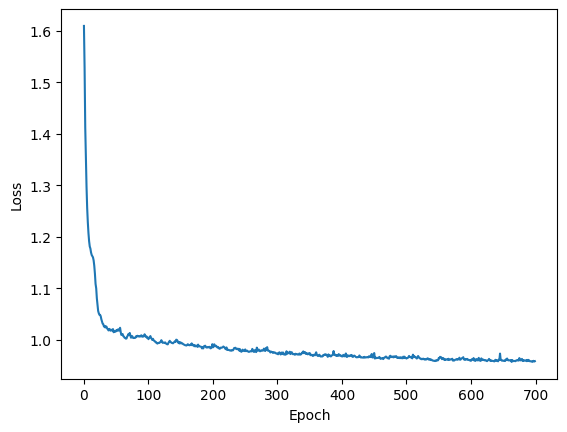

Test accuracy: 462.9694623655914
Accuracy: 0.47698924731182796
Precision: 0.5144230604116817
Recall: 0.4772165169226327
F1-score: 0.48739588394135014


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.51      0.61       495
           1       0.47      0.49      0.48       472
           2       0.33      0.47      0.39       449
           3       0.32      0.35      0.33       463
           4       0.70      0.57      0.63       446

    accuracy                           0.48      2325
   macro avg       0.51      0.48      0.49      2325
weighted avg       0.52      0.48      0.49      2325

                    0           1           2           3           4  \
precision    0.751497    0.470348    0.333333    0.321285    0.695652   
recall       0.507071    0.487288    0.472160    0.345572    0.573991   
f1-score     0.605549    0.478668    0.390783    0.332986    0.628993   
support    495.000000  472.000000  449.00000

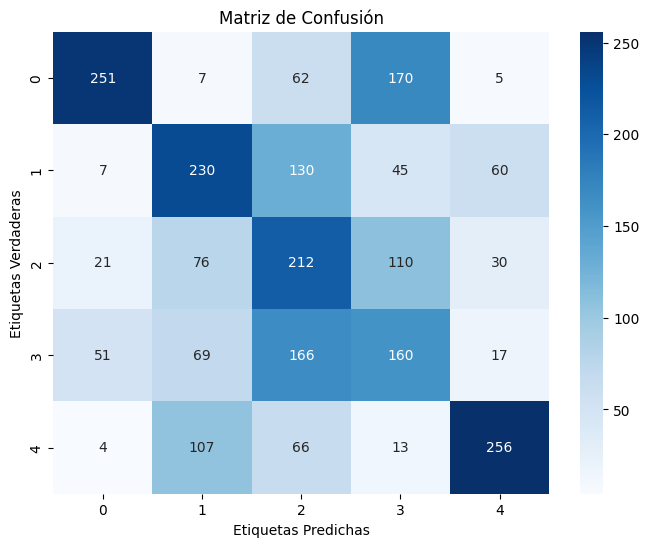

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_700_0.0001_0.2/resultados_700_0.0001_0.2.json
Procesando red con 700 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas:   0%|                                                               | 1/700 [00:02<31:23,  2.69s/it]

1.6096934045062345


Procesando epocas:   0%|▏                                                              | 2/700 [00:05<31:28,  2.70s/it]

1.6096376180648804


Procesando epocas:   0%|▎                                                              | 3/700 [00:08<31:20,  2.70s/it]

1.6096166302176083


Procesando epocas:   1%|▎                                                              | 4/700 [00:10<31:14,  2.69s/it]

1.609582647856544


Procesando epocas:   1%|▍                                                              | 5/700 [00:13<31:18,  2.70s/it]

1.609524684793809


Procesando epocas:   1%|▌                                                              | 6/700 [00:16<31:10,  2.69s/it]

1.6094073085223928


Procesando epocas:   1%|▋                                                              | 7/700 [00:18<31:03,  2.69s/it]

1.6092304019366994


Procesando epocas:   1%|▋                                                              | 8/700 [00:21<31:04,  2.69s/it]

1.6084026673260856


Procesando epocas:   1%|▊                                                              | 9/700 [00:24<31:01,  2.69s/it]

1.6057682521202985


Procesando epocas:   1%|▉                                                             | 10/700 [00:26<30:55,  2.69s/it]

1.595682479353512


Procesando epocas:   2%|▉                                                             | 11/700 [00:29<30:53,  2.69s/it]

1.555336051828721


Procesando epocas:   2%|█                                                             | 12/700 [00:32<30:45,  2.68s/it]

1.5030396496548373


Procesando epocas:   2%|█▏                                                            | 13/700 [00:34<30:40,  2.68s/it]

1.4734844488256118


Procesando epocas:   2%|█▏                                                            | 14/700 [00:37<30:38,  2.68s/it]

1.453429772573359


Procesando epocas:   2%|█▎                                                            | 15/700 [00:40<30:35,  2.68s/it]

1.4430006307714125


Procesando epocas:   2%|█▍                                                            | 16/700 [00:42<30:32,  2.68s/it]

1.429690269161673


Procesando epocas:   2%|█▌                                                            | 17/700 [00:45<30:26,  2.67s/it]

1.4153646924916437


Procesando epocas:   3%|█▌                                                            | 18/700 [00:48<30:18,  2.67s/it]

1.3950204323319828


Procesando epocas:   3%|█▋                                                            | 19/700 [00:50<30:17,  2.67s/it]

1.3828571789404924


Procesando epocas:   3%|█▊                                                            | 20/700 [00:53<30:15,  2.67s/it]

1.3668863198336434


Procesando epocas:   3%|█▊                                                            | 21/700 [00:56<30:30,  2.70s/it]

1.3534546648754793


Procesando epocas:   3%|█▉                                                            | 22/700 [00:59<30:31,  2.70s/it]

1.3429561502793257


Procesando epocas:   3%|██                                                            | 23/700 [01:01<30:39,  2.72s/it]

1.3266238380880917


Procesando epocas:   3%|██▏                                                           | 24/700 [01:04<30:37,  2.72s/it]

1.3190515672459322


Procesando epocas:   4%|██▏                                                           | 25/700 [01:07<30:38,  2.72s/it]

1.3094471096992493


Procesando epocas:   4%|██▎                                                           | 26/700 [01:10<30:36,  2.73s/it]

1.2983224630355834


Procesando epocas:   4%|██▍                                                           | 27/700 [01:12<30:30,  2.72s/it]

1.2901107626802781


Procesando epocas:   4%|██▍                                                           | 28/700 [01:15<30:32,  2.73s/it]

1.2780774747624117


Procesando epocas:   4%|██▌                                                           | 29/700 [01:18<30:38,  2.74s/it]

1.267217694310581


Procesando epocas:   4%|██▋                                                           | 30/700 [01:20<30:23,  2.72s/it]

1.2655674506636228


Procesando epocas:   4%|██▋                                                           | 31/700 [01:23<30:16,  2.72s/it]

1.2551981925964355


Procesando epocas:   5%|██▊                                                           | 32/700 [01:26<30:19,  2.72s/it]

1.2432470798492432


Procesando epocas:   5%|██▉                                                           | 33/700 [01:29<30:33,  2.75s/it]

1.2431168857742758


Procesando epocas:   5%|███                                                           | 34/700 [01:31<30:31,  2.75s/it]

1.2345491009600023


Procesando epocas:   5%|███                                                           | 35/700 [01:34<30:29,  2.75s/it]

1.2300767134217654


Procesando epocas:   5%|███▏                                                          | 36/700 [01:37<30:30,  2.76s/it]

1.2210704487912796


Procesando epocas:   5%|███▎                                                          | 37/700 [01:40<30:25,  2.75s/it]

1.2185041112058304


Procesando epocas:   5%|███▎                                                          | 38/700 [01:42<30:21,  2.75s/it]

1.2118673871545231


Procesando epocas:   6%|███▍                                                          | 39/700 [01:45<30:14,  2.75s/it]

1.2076231732087976


Procesando epocas:   6%|███▌                                                          | 40/700 [01:48<30:08,  2.74s/it]

1.1998816665481118


Procesando epocas:   6%|███▋                                                          | 41/700 [01:51<30:09,  2.75s/it]

1.2006110233419083


Procesando epocas:   6%|███▋                                                          | 42/700 [01:53<30:07,  2.75s/it]

1.192293491083033


Procesando epocas:   6%|███▊                                                          | 43/700 [01:56<30:06,  2.75s/it]

1.1881641023299274


Procesando epocas:   6%|███▉                                                          | 44/700 [01:59<30:03,  2.75s/it]

1.1862901294932646


Procesando epocas:   6%|███▉                                                          | 45/700 [02:02<30:00,  2.75s/it]

1.1782589638934415


Procesando epocas:   7%|████                                                          | 46/700 [02:04<30:00,  2.75s/it]

1.1757870099123786


Procesando epocas:   7%|████▏                                                         | 47/700 [02:07<30:02,  2.76s/it]

1.1720369149656857


Procesando epocas:   7%|████▎                                                         | 48/700 [02:10<29:52,  2.75s/it]

1.1670863768633675


Procesando epocas:   7%|████▎                                                         | 49/700 [02:13<29:40,  2.74s/it]

1.1662435209049897


Procesando epocas:   7%|████▍                                                         | 50/700 [02:15<29:37,  2.74s/it]

1.161391252629897


Procesando epocas:   7%|████▌                                                         | 51/700 [02:18<29:24,  2.72s/it]

1.1538303711835076


Procesando epocas:   7%|████▌                                                         | 52/700 [02:21<29:14,  2.71s/it]

1.15581555296393


Procesando epocas:   8%|████▋                                                         | 53/700 [02:23<29:10,  2.71s/it]

1.1441227246733272


Procesando epocas:   8%|████▊                                                         | 54/700 [02:26<29:07,  2.70s/it]

1.140113754833446


Procesando epocas:   8%|████▊                                                         | 55/700 [02:29<29:09,  2.71s/it]

1.1360014095025903


Procesando epocas:   8%|████▉                                                         | 56/700 [02:32<29:09,  2.72s/it]

1.1334691201939302


Procesando epocas:   8%|█████                                                         | 57/700 [02:34<28:59,  2.71s/it]

1.1265294650021722


Procesando epocas:   8%|█████▏                                                        | 58/700 [02:37<28:53,  2.70s/it]

1.1229179669828977


Procesando epocas:   8%|█████▏                                                        | 59/700 [02:40<28:48,  2.70s/it]

1.1216790486784542


Procesando epocas:   9%|█████▎                                                        | 60/700 [02:42<28:42,  2.69s/it]

1.1178193432443282


Procesando epocas:   9%|█████▍                                                        | 61/700 [02:45<28:41,  2.69s/it]

1.1110641987884746


Procesando epocas:   9%|█████▍                                                        | 62/700 [02:48<28:56,  2.72s/it]

1.106639777211582


Procesando epocas:   9%|█████▌                                                        | 63/700 [02:51<28:53,  2.72s/it]

1.100066541222965


Procesando epocas:   9%|█████▋                                                        | 64/700 [02:53<28:45,  2.71s/it]

1.093836366078433


Procesando epocas:   9%|█████▊                                                        | 65/700 [02:56<28:49,  2.72s/it]

1.0869747996330261


Procesando epocas:   9%|█████▊                                                        | 66/700 [02:59<28:40,  2.71s/it]

1.0856219288180857


Procesando epocas:  10%|█████▉                                                        | 67/700 [03:01<28:33,  2.71s/it]

1.0791061552131878


Procesando epocas:  10%|██████                                                        | 68/700 [03:04<28:30,  2.71s/it]

1.075230268871083


Procesando epocas:  10%|██████                                                        | 69/700 [03:07<28:27,  2.71s/it]

1.0715011771987466


Procesando epocas:  10%|██████▏                                                       | 70/700 [03:09<28:20,  2.70s/it]

1.0687635824960822


Procesando epocas:  10%|██████▎                                                       | 71/700 [03:12<28:13,  2.69s/it]

1.0619069769101985


Procesando epocas:  10%|██████▍                                                       | 72/700 [03:15<28:09,  2.69s/it]

1.064968903275097


Procesando epocas:  10%|██████▍                                                       | 73/700 [03:18<28:05,  2.69s/it]

1.0546702514676487


Procesando epocas:  11%|██████▌                                                       | 74/700 [03:20<27:59,  2.68s/it]

1.0536567235694212


Procesando epocas:  11%|██████▋                                                       | 75/700 [03:23<28:01,  2.69s/it]

1.0499586126383613


Procesando epocas:  11%|██████▋                                                       | 76/700 [03:26<27:57,  2.69s/it]

1.0494793173144845


Procesando epocas:  11%|██████▊                                                       | 77/700 [03:28<27:55,  2.69s/it]

1.0450134750674753


Procesando epocas:  11%|██████▉                                                       | 78/700 [03:31<27:51,  2.69s/it]

1.038137703783372


Procesando epocas:  11%|██████▉                                                       | 79/700 [03:34<27:44,  2.68s/it]

1.0365852527758654


Procesando epocas:  11%|███████                                                       | 80/700 [03:36<27:38,  2.68s/it]

1.0398148515645196


Procesando epocas:  12%|███████▏                                                      | 81/700 [03:39<27:35,  2.67s/it]

1.0300619191983167


Procesando epocas:  12%|███████▎                                                      | 82/700 [03:42<27:32,  2.67s/it]

1.0311004529981052


Procesando epocas:  12%|███████▎                                                      | 83/700 [03:44<27:27,  2.67s/it]

1.0249110852970797


Procesando epocas:  12%|███████▍                                                      | 84/700 [03:47<27:23,  2.67s/it]

1.023626876929227


Procesando epocas:  12%|███████▌                                                      | 85/700 [03:50<27:29,  2.68s/it]

1.0241416843498454


Procesando epocas:  12%|███████▌                                                      | 86/700 [03:52<27:24,  2.68s/it]

1.0220855144893422


Procesando epocas:  12%|███████▋                                                      | 87/700 [03:55<27:24,  2.68s/it]

1.0201919397887063


Procesando epocas:  13%|███████▊                                                      | 88/700 [03:58<27:37,  2.71s/it]

1.0171628895927878


Procesando epocas:  13%|███████▉                                                      | 89/700 [04:01<27:34,  2.71s/it]

1.0137357378707212


Procesando epocas:  13%|███████▉                                                      | 90/700 [04:03<27:24,  2.70s/it]

1.0134719014167786


Procesando epocas:  13%|████████                                                      | 91/700 [04:06<27:20,  2.69s/it]

1.013478038591497


Procesando epocas:  13%|████████▏                                                     | 92/700 [04:08<27:01,  2.67s/it]

1.011017126896802


Procesando epocas:  13%|████████▏                                                     | 93/700 [04:11<26:49,  2.65s/it]

1.0084297614939073


Procesando epocas:  13%|████████▎                                                     | 94/700 [04:14<26:46,  2.65s/it]

1.0108792844940635


Procesando epocas:  14%|████████▍                                                     | 95/700 [04:16<26:45,  2.65s/it]

1.0055567211964551


Procesando epocas:  14%|████████▌                                                     | 96/700 [04:19<26:42,  2.65s/it]

1.003878205313402


Procesando epocas:  14%|████████▌                                                     | 97/700 [04:22<26:44,  2.66s/it]

1.002032522243612


Procesando epocas:  14%|████████▋                                                     | 98/700 [04:24<26:56,  2.68s/it]

1.0015500650686375


Procesando epocas:  14%|████████▊                                                     | 99/700 [04:27<26:55,  2.69s/it]

1.0020546723814572


Procesando epocas:  14%|████████▋                                                    | 100/700 [04:30<26:56,  2.69s/it]

1.0007195290397195


Procesando epocas:  14%|████████▊                                                    | 101/700 [04:33<26:50,  2.69s/it]

1.0011852443218232


Procesando epocas:  15%|████████▉                                                    | 102/700 [04:35<26:42,  2.68s/it]

1.000139276420369


Procesando epocas:  15%|████████▉                                                    | 103/700 [04:38<26:34,  2.67s/it]

0.997495131632861


Procesando epocas:  15%|█████████                                                    | 104/700 [04:41<26:24,  2.66s/it]

0.9978921111892252


Procesando epocas:  15%|█████████▏                                                   | 105/700 [04:43<26:14,  2.65s/it]

0.9962397049455082


Procesando epocas:  15%|█████████▏                                                   | 106/700 [04:46<26:10,  2.64s/it]

0.9971194084952859


Procesando epocas:  15%|█████████▎                                                   | 107/700 [04:48<26:12,  2.65s/it]

0.9951555465950686


Procesando epocas:  15%|█████████▍                                                   | 108/700 [04:51<26:19,  2.67s/it]

0.9932021400507759


Procesando epocas:  16%|█████████▍                                                   | 109/700 [04:54<26:18,  2.67s/it]

0.9947988170034745


Procesando epocas:  16%|█████████▌                                                   | 110/700 [04:57<26:21,  2.68s/it]

0.9913679883760564


Procesando epocas:  16%|█████████▋                                                   | 111/700 [04:59<26:22,  2.69s/it]

0.9912857553538155


Procesando epocas:  16%|█████████▊                                                   | 112/700 [05:02<26:15,  2.68s/it]

0.9911265152342179


Procesando epocas:  16%|█████████▊                                                   | 113/700 [05:05<26:04,  2.66s/it]

0.9901636057040271


Procesando epocas:  16%|█████████▉                                                   | 114/700 [05:07<26:06,  2.67s/it]

0.9902073292171254


Procesando epocas:  16%|██████████                                                   | 115/700 [05:10<26:00,  2.67s/it]

0.9909868952106027


Procesando epocas:  17%|██████████                                                   | 116/700 [05:13<25:58,  2.67s/it]

0.9899415075778961


Procesando epocas:  17%|██████████▏                                                  | 117/700 [05:15<25:52,  2.66s/it]

0.9881987319273107


Procesando epocas:  17%|██████████▎                                                  | 118/700 [05:18<25:52,  2.67s/it]

0.9897479790098527


Procesando epocas:  17%|██████████▎                                                  | 119/700 [05:20<25:43,  2.66s/it]

0.9881996894583983


Procesando epocas:  17%|██████████▍                                                  | 120/700 [05:23<25:33,  2.64s/it]

0.9873607123599333


Procesando epocas:  17%|██████████▌                                                  | 121/700 [05:26<25:26,  2.64s/it]

0.9846784149899203


Procesando epocas:  17%|██████████▋                                                  | 122/700 [05:28<25:25,  2.64s/it]

0.9850841420538285


Procesando epocas:  18%|██████████▋                                                  | 123/700 [05:31<25:21,  2.64s/it]

0.9869874396744897


Procesando epocas:  18%|██████████▊                                                  | 124/700 [05:34<25:19,  2.64s/it]

0.9863949740634245


Procesando epocas:  18%|██████████▉                                                  | 125/700 [05:36<25:24,  2.65s/it]

0.9839217007160187


Procesando epocas:  18%|██████████▉                                                  | 126/700 [05:39<25:18,  2.65s/it]

0.9846635232953465


Procesando epocas:  18%|███████████                                                  | 127/700 [05:42<25:14,  2.64s/it]

0.9832577950814191


Procesando epocas:  18%|███████████▏                                                 | 128/700 [05:44<25:21,  2.66s/it]

0.9826797895571765


Procesando epocas:  18%|███████████▏                                                 | 129/700 [05:47<25:16,  2.66s/it]

0.982914244076785


Procesando epocas:  19%|███████████▎                                                 | 130/700 [05:50<25:13,  2.66s/it]

0.9825250909608954


Procesando epocas:  19%|███████████▍                                                 | 131/700 [05:52<25:07,  2.65s/it]

0.9820515797418706


Procesando epocas:  19%|███████████▌                                                 | 132/700 [05:55<25:07,  2.65s/it]

0.9830718727672801


Procesando epocas:  19%|███████████▌                                                 | 133/700 [05:58<24:58,  2.64s/it]

0.9825252070146449


Procesando epocas:  19%|███████████▋                                                 | 134/700 [06:00<25:01,  2.65s/it]

0.9810067001511069


Procesando epocas:  19%|███████████▊                                                 | 135/700 [06:03<24:52,  2.64s/it]

0.9813047461649951


Procesando epocas:  19%|███████████▊                                                 | 136/700 [06:05<24:45,  2.63s/it]

0.9807761399184957


Procesando epocas:  20%|███████████▉                                                 | 137/700 [06:08<24:44,  2.64s/it]

0.9791343513657065


Procesando epocas:  20%|████████████                                                 | 138/700 [06:11<24:40,  2.63s/it]

0.9801496975562152


Procesando epocas:  20%|████████████                                                 | 139/700 [06:13<24:39,  2.64s/it]

0.9809574565466712


Procesando epocas:  20%|████████████▏                                                | 140/700 [06:16<24:33,  2.63s/it]

0.9806679199723637


Procesando epocas:  20%|████████████▎                                                | 141/700 [06:19<24:33,  2.64s/it]

0.9791937940260943


Procesando epocas:  20%|████████████▎                                                | 142/700 [06:21<24:52,  2.67s/it]

0.979880958444932


Procesando epocas:  20%|████████████▍                                                | 143/700 [06:24<25:02,  2.70s/it]

0.9797060552765341


Procesando epocas:  21%|████████████▌                                                | 144/700 [06:27<25:06,  2.71s/it]

0.9800989694455091


Procesando epocas:  21%|████████████▋                                                | 145/700 [06:30<25:06,  2.71s/it]

0.9781802801524891


Procesando epocas:  21%|████████████▋                                                | 146/700 [06:32<25:08,  2.72s/it]

0.9780524565893061


Procesando epocas:  21%|████████████▊                                                | 147/700 [06:35<25:13,  2.74s/it]

0.9781839833540075


Procesando epocas:  21%|████████████▉                                                | 148/700 [06:38<25:13,  2.74s/it]

0.9801914979429805


Procesando epocas:  21%|████████████▉                                                | 149/700 [06:41<25:06,  2.73s/it]

0.9796476101174074


Procesando epocas:  21%|█████████████                                                | 150/700 [06:43<25:02,  2.73s/it]

0.9774667701300452


Procesando epocas:  22%|█████████████▏                                               | 151/700 [06:46<24:56,  2.73s/it]

0.9771250651163214


Procesando epocas:  22%|█████████████▏                                               | 152/700 [06:49<24:52,  2.72s/it]

0.9776029481607325


Procesando epocas:  22%|█████████████▎                                               | 153/700 [06:51<24:49,  2.72s/it]

0.9765706798609566


Procesando epocas:  22%|█████████████▍                                               | 154/700 [06:54<24:47,  2.72s/it]

0.9762003726818982


Procesando epocas:  22%|█████████████▌                                               | 155/700 [06:57<24:40,  2.72s/it]

0.9773459746557124


Procesando epocas:  22%|█████████████▌                                               | 156/700 [07:00<24:39,  2.72s/it]

0.97755446434021


Procesando epocas:  22%|█████████████▋                                               | 157/700 [07:02<24:38,  2.72s/it]

0.9763572668328004


Procesando epocas:  23%|█████████████▊                                               | 158/700 [07:05<24:35,  2.72s/it]

0.9754244089126587


Procesando epocas:  23%|█████████████▊                                               | 159/700 [07:08<24:38,  2.73s/it]

0.9765604219015906


Procesando epocas:  23%|█████████████▉                                               | 160/700 [07:11<24:38,  2.74s/it]

0.9765605758218204


Procesando epocas:  23%|██████████████                                               | 161/700 [07:13<24:30,  2.73s/it]

0.9757118982427261


Procesando epocas:  23%|██████████████                                               | 162/700 [07:16<24:32,  2.74s/it]

0.9748480411136852


Procesando epocas:  23%|██████████████▏                                              | 163/700 [07:19<24:39,  2.75s/it]

0.9762152201989118


Procesando epocas:  23%|██████████████▎                                              | 164/700 [07:22<24:31,  2.74s/it]

0.974833028456744


Procesando epocas:  24%|██████████████▍                                              | 165/700 [07:24<24:22,  2.73s/it]

0.9756818406722125


Procesando epocas:  24%|██████████████▍                                              | 166/700 [07:27<24:11,  2.72s/it]

0.976512617223403


Procesando epocas:  24%|██████████████▌                                              | 167/700 [07:30<24:02,  2.71s/it]

0.9741292816751144


Procesando epocas:  24%|██████████████▋                                              | 168/700 [07:32<24:00,  2.71s/it]

0.9739903755047742


Procesando epocas:  24%|██████████████▋                                              | 169/700 [07:35<23:59,  2.71s/it]

0.9751732233692618


Procesando epocas:  24%|██████████████▊                                              | 170/700 [07:38<23:57,  2.71s/it]

0.9737777611788582


Procesando epocas:  24%|██████████████▉                                              | 171/700 [07:40<23:52,  2.71s/it]

0.9741411906831404


Procesando epocas:  25%|██████████████▉                                              | 172/700 [07:43<23:47,  2.70s/it]

0.975358698648565


Procesando epocas:  25%|███████████████                                              | 173/700 [07:46<23:41,  2.70s/it]

0.9736817075925714


Procesando epocas:  25%|███████████████▏                                             | 174/700 [07:48<23:35,  2.69s/it]

0.9747562780099757


Procesando epocas:  25%|███████████████▎                                             | 175/700 [07:51<23:31,  2.69s/it]

0.9735947363516864


Procesando epocas:  25%|███████████████▎                                             | 176/700 [07:54<23:28,  2.69s/it]

0.9744405283647425


Procesando epocas:  25%|███████████████▍                                             | 177/700 [07:57<23:23,  2.68s/it]

0.9740769624710083


Procesando epocas:  25%|███████████████▌                                             | 178/700 [07:59<23:20,  2.68s/it]

0.9737221900154562


Procesando epocas:  26%|███████████████▌                                             | 179/700 [08:02<23:21,  2.69s/it]

0.9747498617452733


Procesando epocas:  26%|███████████████▋                                             | 180/700 [08:05<23:21,  2.70s/it]

0.974139581007116


Procesando epocas:  26%|███████████████▊                                             | 181/700 [08:07<23:25,  2.71s/it]

0.9729579185738283


Procesando epocas:  26%|███████████████▊                                             | 182/700 [08:10<23:18,  2.70s/it]

0.9725710434072158


Procesando epocas:  26%|███████████████▉                                             | 183/700 [08:13<23:15,  2.70s/it]

0.9737692103666418


Procesando epocas:  26%|████████████████                                             | 184/700 [08:15<23:15,  2.71s/it]

0.9744273830862606


Procesando epocas:  26%|████████████████                                             | 185/700 [08:18<23:16,  2.71s/it]

0.9724718809127808


Procesando epocas:  27%|████████████████▏                                            | 186/700 [08:21<23:10,  2.71s/it]

0.9732398418819204


Procesando epocas:  27%|████████████████▎                                            | 187/700 [08:24<23:01,  2.69s/it]

0.9736202513470369


Procesando epocas:  27%|████████████████▍                                            | 188/700 [08:26<23:00,  2.70s/it]

0.9739322581711938


Procesando epocas:  27%|████████████████▍                                            | 189/700 [08:29<22:55,  2.69s/it]

0.9730848596376531


Procesando epocas:  27%|████████████████▌                                            | 190/700 [08:32<22:55,  2.70s/it]

0.972682182227864


Procesando epocas:  27%|████████████████▋                                            | 191/700 [08:34<22:53,  2.70s/it]

0.9726967022699469


Procesando epocas:  27%|████████████████▋                                            | 192/700 [08:37<22:55,  2.71s/it]

0.9721705668112811


Procesando epocas:  28%|████████████████▊                                            | 193/700 [08:40<22:54,  2.71s/it]

0.972702096490299


Procesando epocas:  28%|████████████████▉                                            | 194/700 [08:43<22:54,  2.72s/it]

0.9727838267298305


Procesando epocas:  28%|████████████████▉                                            | 195/700 [08:45<22:49,  2.71s/it]

0.9723724726368399


Procesando epocas:  28%|█████████████████                                            | 196/700 [08:48<22:43,  2.71s/it]

0.9722541945822099


Procesando epocas:  28%|█████████████████▏                                           | 197/700 [08:51<22:40,  2.70s/it]

0.9719747957061319


Procesando epocas:  28%|█████████████████▎                                           | 198/700 [08:53<22:38,  2.71s/it]

0.9719633274218615


Procesando epocas:  28%|█████████████████▎                                           | 199/700 [08:56<22:35,  2.71s/it]

0.9725116445737727


Procesando epocas:  29%|█████████████████▍                                           | 200/700 [08:59<22:34,  2.71s/it]

0.9718615966684678


Procesando epocas:  29%|█████████████████▌                                           | 201/700 [09:01<22:31,  2.71s/it]

0.972513734593111


Procesando epocas:  29%|█████████████████▌                                           | 202/700 [09:04<22:37,  2.73s/it]

0.9722549200057984


Procesando epocas:  29%|█████████████████▋                                           | 203/700 [09:07<22:44,  2.75s/it]

0.9709319104166592


Procesando epocas:  29%|█████████████████▊                                           | 204/700 [09:10<22:40,  2.74s/it]

0.97133648816277


Procesando epocas:  29%|█████████████████▊                                           | 205/700 [09:12<22:32,  2.73s/it]

0.9726458889596602


Procesando epocas:  29%|█████████████████▉                                           | 206/700 [09:15<22:29,  2.73s/it]

0.9728562074549058


Procesando epocas:  30%|██████████████████                                           | 207/700 [09:18<22:21,  2.72s/it]

0.9720513701438904


Procesando epocas:  30%|██████████████████▏                                          | 208/700 [09:21<22:15,  2.71s/it]

0.9719072927446927


Procesando epocas:  30%|██████████████████▏                                          | 209/700 [09:23<22:10,  2.71s/it]

0.9721687614917756


Procesando epocas:  30%|██████████████████▎                                          | 210/700 [09:26<22:05,  2.70s/it]

0.9710454414872562


Procesando epocas:  30%|██████████████████▍                                          | 211/700 [09:29<22:00,  2.70s/it]

0.9727096508531009


Procesando epocas:  30%|██████████████████▍                                          | 212/700 [09:31<21:59,  2.70s/it]

0.9711966910782982


Procesando epocas:  30%|██████████████████▌                                          | 213/700 [09:34<21:58,  2.71s/it]

0.971983530591516


Procesando epocas:  31%|██████████████████▋                                          | 214/700 [09:37<21:55,  2.71s/it]

0.9722294547978569


Procesando epocas:  31%|██████████████████▋                                          | 215/700 [09:39<21:50,  2.70s/it]

0.9710441154592178


Procesando epocas:  31%|██████████████████▊                                          | 216/700 [09:42<21:48,  2.70s/it]

0.9716822487466475


Procesando epocas:  31%|██████████████████▉                                          | 217/700 [09:45<21:45,  2.70s/it]

0.97058226220748


Procesando epocas:  31%|██████████████████▉                                          | 218/700 [09:48<21:39,  2.70s/it]

0.9708459419362685


Procesando epocas:  31%|███████████████████                                          | 219/700 [09:50<21:40,  2.70s/it]

0.9710965626380023


Procesando epocas:  31%|███████████████████▏                                         | 220/700 [09:53<21:44,  2.72s/it]

0.9711121801067801


Procesando epocas:  32%|███████████████████▎                                         | 221/700 [09:56<21:38,  2.71s/it]

0.9709606991094701


Procesando epocas:  32%|███████████████████▎                                         | 222/700 [09:58<21:41,  2.72s/it]

0.9707993055091185


Procesando epocas:  32%|███████████████████▍                                         | 223/700 [10:01<21:33,  2.71s/it]

0.9714032089009005


Procesando epocas:  32%|███████████████████▌                                         | 224/700 [10:04<21:36,  2.72s/it]

0.9711709899060866


Procesando epocas:  32%|███████████████████▌                                         | 225/700 [10:07<21:39,  2.73s/it]

0.9713483642129337


Procesando epocas:  32%|███████████████████▋                                         | 226/700 [10:09<21:30,  2.72s/it]

0.9706604631508098


Procesando epocas:  32%|███████████████████▊                                         | 227/700 [10:12<21:23,  2.71s/it]

0.9707773376913632


Procesando epocas:  33%|███████████████████▊                                         | 228/700 [10:15<21:19,  2.71s/it]

0.9705624639987945


Procesando epocas:  33%|███████████████████▉                                         | 229/700 [10:17<21:14,  2.71s/it]

0.970914412947262


Procesando epocas:  33%|████████████████████                                         | 230/700 [10:20<21:11,  2.71s/it]

0.9708638450678657


Procesando epocas:  33%|████████████████████▏                                        | 231/700 [10:23<21:06,  2.70s/it]

0.9718529522418976


Procesando epocas:  33%|████████████████████▏                                        | 232/700 [10:26<21:01,  2.70s/it]

0.970213685316198


Procesando epocas:  33%|████████████████████▎                                        | 233/700 [10:28<20:58,  2.69s/it]

0.9703602082589093


Procesando epocas:  33%|████████████████████▍                                        | 234/700 [10:31<20:56,  2.70s/it]

0.9697828447117525


Procesando epocas:  34%|████████████████████▍                                        | 235/700 [10:34<20:54,  2.70s/it]

0.9699116570108077


Procesando epocas:  34%|████████████████████▌                                        | 236/700 [10:36<20:51,  2.70s/it]

0.9708133949952967


Procesando epocas:  34%|████████████████████▋                                        | 237/700 [10:39<20:48,  2.70s/it]

0.969777771655251


Procesando epocas:  34%|████████████████████▋                                        | 238/700 [10:42<20:46,  2.70s/it]

0.9699876588933608


Procesando epocas:  34%|████████████████████▊                                        | 239/700 [10:44<20:41,  2.69s/it]

0.9698053370503819


Procesando epocas:  34%|████████████████████▉                                        | 240/700 [10:47<20:37,  2.69s/it]

0.9702398840118857


Procesando epocas:  34%|█████████████████████                                        | 241/700 [10:50<20:38,  2.70s/it]

0.9706406309324153


Procesando epocas:  35%|█████████████████████                                        | 242/700 [10:52<20:32,  2.69s/it]

0.9702239527421839


Procesando epocas:  35%|█████████████████████▏                                       | 243/700 [10:55<20:27,  2.69s/it]

0.9701380838366116


Procesando epocas:  35%|█████████████████████▎                                       | 244/700 [10:58<20:25,  2.69s/it]

0.9700537176693187


Procesando epocas:  35%|█████████████████████▎                                       | 245/700 [11:01<20:20,  2.68s/it]

0.9695866718011744


Procesando epocas:  35%|█████████████████████▍                                       | 246/700 [11:03<20:17,  2.68s/it]

0.9695162485627568


Procesando epocas:  35%|█████████████████████▌                                       | 247/700 [11:06<20:17,  2.69s/it]

0.9694255397600287


Procesando epocas:  35%|█████████████████████▌                                       | 248/700 [11:09<20:19,  2.70s/it]

0.9700844175675336


Procesando epocas:  36%|█████████████████████▋                                       | 249/700 [11:11<20:14,  2.69s/it]

0.9692062086918775


Procesando epocas:  36%|█████████████████████▊                                       | 250/700 [11:14<20:09,  2.69s/it]

0.969710522890091


Procesando epocas:  36%|█████████████████████▊                                       | 251/700 [11:17<20:04,  2.68s/it]

0.9697934290942024


Procesando epocas:  36%|█████████████████████▉                                       | 252/700 [11:19<20:03,  2.69s/it]

0.9696132021791795


Procesando epocas:  36%|██████████████████████                                       | 253/700 [11:22<20:02,  2.69s/it]

0.9687257980599123


Procesando epocas:  36%|██████████████████████▏                                      | 254/700 [11:25<19:58,  2.69s/it]

0.9686573827967925


Procesando epocas:  36%|██████████████████████▏                                      | 255/700 [11:27<19:55,  2.69s/it]

0.9687611821819754


Procesando epocas:  37%|██████████████████████▎                                      | 256/700 [11:30<19:51,  2.68s/it]

0.9692577523343703


Procesando epocas:  37%|██████████████████████▍                                      | 257/700 [11:33<19:51,  2.69s/it]

0.9685759940568138


Procesando epocas:  37%|██████████████████████▍                                      | 258/700 [11:36<19:50,  2.69s/it]

0.9686796009540558


Procesando epocas:  37%|██████████████████████▌                                      | 259/700 [11:38<19:42,  2.68s/it]

0.9689333424848668


Procesando epocas:  37%|██████████████████████▋                                      | 260/700 [11:41<19:35,  2.67s/it]

0.9693091743132647


Procesando epocas:  37%|██████████████████████▋                                      | 261/700 [11:43<19:27,  2.66s/it]

0.9684418247026556


Procesando epocas:  37%|██████████████████████▊                                      | 262/700 [11:46<19:20,  2.65s/it]

0.9691518615273869


Procesando epocas:  38%|██████████████████████▉                                      | 263/700 [11:49<19:15,  2.64s/it]

0.9691722084494198


Procesando epocas:  38%|███████████████████████                                      | 264/700 [11:51<19:13,  2.65s/it]

0.9683582439142115


Procesando epocas:  38%|███████████████████████                                      | 265/700 [11:54<19:16,  2.66s/it]

0.9689994215965271


Procesando epocas:  38%|███████████████████████▏                                     | 266/700 [11:57<19:17,  2.67s/it]

0.9688214820974014


Procesando epocas:  38%|███████████████████████▎                                     | 267/700 [11:59<19:15,  2.67s/it]

0.9682055862510905


Procesando epocas:  38%|███████████████████████▎                                     | 268/700 [12:02<19:12,  2.67s/it]

0.9691034755286049


Procesando epocas:  38%|███████████████████████▍                                     | 269/700 [12:05<19:11,  2.67s/it]

0.9685568111784318


Procesando epocas:  39%|███████████████████████▌                                     | 270/700 [12:07<19:16,  2.69s/it]

0.9690735550487742


Procesando epocas:  39%|███████████████████████▌                                     | 271/700 [12:10<19:20,  2.70s/it]

0.9692696353968452


Procesando epocas:  39%|███████████████████████▋                                     | 272/700 [12:13<19:15,  2.70s/it]

0.9684968650341034


Procesando epocas:  39%|███████████████████████▊                                     | 273/700 [12:15<18:22,  2.58s/it]

0.9692695568589603


Procesando epocas:  39%|███████████████████████▉                                     | 274/700 [12:18<18:34,  2.62s/it]

0.9682093346820159


Procesando epocas:  39%|███████████████████████▉                                     | 275/700 [12:21<18:46,  2.65s/it]

0.9683386118973003


Procesando epocas:  39%|████████████████████████                                     | 276/700 [12:23<18:54,  2.68s/it]

0.9686116537627052


Procesando epocas:  40%|████████████████████████▏                                    | 277/700 [12:26<18:55,  2.68s/it]

0.9685037370990305


Procesando epocas:  40%|████████████████████████▏                                    | 278/700 [12:29<18:57,  2.69s/it]

0.9686891822253957


Procesando epocas:  40%|████████████████████████▎                                    | 279/700 [12:31<18:53,  2.69s/it]

0.9690498506321626


Procesando epocas:  40%|████████████████████████▍                                    | 280/700 [12:34<18:50,  2.69s/it]

0.9697127787505879


Procesando epocas:  40%|████████████████████████▍                                    | 281/700 [12:37<18:47,  2.69s/it]

0.9688388165305643


Procesando epocas:  40%|████████████████████████▌                                    | 282/700 [12:40<18:43,  2.69s/it]

0.9678018201799954


Procesando epocas:  40%|████████████████████████▋                                    | 283/700 [12:42<18:39,  2.69s/it]

0.9678167248473448


Procesando epocas:  41%|████████████████████████▋                                    | 284/700 [12:45<18:37,  2.69s/it]

0.967421930327135


Procesando epocas:  41%|████████████████████████▊                                    | 285/700 [12:48<18:39,  2.70s/it]

0.967395172399633


Procesando epocas:  41%|████████████████████████▉                                    | 286/700 [12:50<18:44,  2.72s/it]

0.9680546364363503


Procesando epocas:  41%|█████████████████████████                                    | 287/700 [12:53<18:47,  2.73s/it]

0.9680275471771465


Procesando epocas:  41%|█████████████████████████                                    | 288/700 [12:56<18:46,  2.74s/it]

0.9673859799609464


Procesando epocas:  41%|█████████████████████████▏                                   | 289/700 [12:59<18:48,  2.74s/it]

0.968670803308487


Procesando epocas:  41%|█████████████████████████▎                                   | 290/700 [13:01<18:44,  2.74s/it]

0.9685146089862374


Procesando epocas:  42%|█████████████████████████▎                                   | 291/700 [13:04<18:40,  2.74s/it]

0.9677571436938117


Procesando epocas:  42%|█████████████████████████▍                                   | 292/700 [13:07<18:37,  2.74s/it]

0.9678466467296376


Procesando epocas:  42%|█████████████████████████▌                                   | 293/700 [13:10<18:34,  2.74s/it]

0.9679120824617498


Procesando epocas:  42%|█████████████████████████▌                                   | 294/700 [13:12<18:32,  2.74s/it]

0.9680601060390472


Procesando epocas:  42%|█████████████████████████▋                                   | 295/700 [13:15<18:28,  2.74s/it]

0.9677613899988287


Procesando epocas:  42%|█████████████████████████▊                                   | 296/700 [13:18<18:23,  2.73s/it]

0.967584576326258


Procesando epocas:  42%|█████████████████████████▉                                   | 297/700 [13:21<18:17,  2.72s/it]

0.9676079764085658


Procesando epocas:  43%|█████████████████████████▉                                   | 298/700 [13:23<18:12,  2.72s/it]

0.9673370203551124


Procesando epocas:  43%|██████████████████████████                                   | 299/700 [13:26<18:08,  2.71s/it]

0.9675976321977727


Procesando epocas:  43%|██████████████████████████▏                                  | 300/700 [13:29<18:04,  2.71s/it]

0.9671398110249463


Procesando epocas:  43%|██████████████████████████▏                                  | 301/700 [13:31<18:00,  2.71s/it]

0.9678282131167019


Procesando epocas:  43%|██████████████████████████▎                                  | 302/700 [13:34<18:01,  2.72s/it]

0.9676088785423952


Procesando epocas:  43%|██████████████████████████▍                                  | 303/700 [13:37<17:56,  2.71s/it]

0.9681820171720842


Procesando epocas:  43%|██████████████████████████▍                                  | 304/700 [13:39<17:54,  2.71s/it]

0.9672841363093432


Procesando epocas:  44%|██████████████████████████▌                                  | 305/700 [13:42<17:50,  2.71s/it]

0.9671276485218722


Procesando epocas:  44%|██████████████████████████▋                                  | 306/700 [13:45<17:46,  2.71s/it]

0.9672439848675447


Procesando epocas:  44%|██████████████████████████▊                                  | 307/700 [13:48<17:44,  2.71s/it]

0.9675232508603264


Procesando epocas:  44%|██████████████████████████▊                                  | 308/700 [13:50<17:43,  2.71s/it]

0.9681977412279914


Procesando epocas:  44%|██████████████████████████▉                                  | 309/700 [13:53<17:43,  2.72s/it]

0.9672066898906932


Procesando epocas:  44%|███████████████████████████                                  | 310/700 [13:56<17:39,  2.72s/it]

0.9673763190998751


Procesando epocas:  44%|███████████████████████████                                  | 311/700 [13:58<17:35,  2.71s/it]

0.9679052296806784


Procesando epocas:  45%|███████████████████████████▏                                 | 312/700 [14:01<17:31,  2.71s/it]

0.967873645179412


Procesando epocas:  45%|███████████████████████████▎                                 | 313/700 [14:04<17:27,  2.71s/it]

0.9677025833550621


Procesando epocas:  45%|███████████████████████████▎                                 | 314/700 [14:07<17:23,  2.70s/it]

0.9678703048649956


Procesando epocas:  45%|███████████████████████████▍                                 | 315/700 [14:09<17:22,  2.71s/it]

0.9673530263059279


Procesando epocas:  45%|███████████████████████████▌                                 | 316/700 [14:12<17:20,  2.71s/it]

0.9674806791193346


Procesando epocas:  45%|███████████████████████████▌                                 | 317/700 [14:15<17:20,  2.72s/it]

0.9678314499995287


Procesando epocas:  45%|███████████████████████████▋                                 | 318/700 [14:17<17:19,  2.72s/it]

0.96741962538046


Procesando epocas:  46%|███████████████████████████▊                                 | 319/700 [14:20<17:19,  2.73s/it]

0.9673830863307504


Procesando epocas:  46%|███████████████████████████▉                                 | 320/700 [14:23<17:19,  2.74s/it]

0.96797514908454


Procesando epocas:  46%|███████████████████████████▉                                 | 321/700 [14:26<17:20,  2.75s/it]

0.9670910495169023


Procesando epocas:  46%|████████████████████████████                                 | 322/700 [14:28<17:18,  2.75s/it]

0.9672795039765975


Procesando epocas:  46%|████████████████████████████▏                                | 323/700 [14:31<17:11,  2.74s/it]

0.9668116267989664


Procesando epocas:  46%|████████████████████████████▏                                | 324/700 [14:34<17:06,  2.73s/it]

0.9668640063089483


Procesando epocas:  46%|████████████████████████████▎                                | 325/700 [14:37<17:04,  2.73s/it]

0.9675796536838307


Procesando epocas:  47%|████████████████████████████▍                                | 326/700 [14:39<16:52,  2.71s/it]

0.9661675961578593


Procesando epocas:  47%|████████████████████████████▍                                | 327/700 [14:42<17:00,  2.74s/it]

0.9674016146098866


Procesando epocas:  47%|████████████████████████████▌                                | 328/700 [14:45<16:56,  2.73s/it]

0.9662802762844983


Procesando epocas:  47%|████████████████████████████▋                                | 329/700 [14:47<16:48,  2.72s/it]

0.9670144063584944


Procesando epocas:  47%|████████████████████████████▊                                | 330/700 [14:50<16:43,  2.71s/it]

0.9662546122775358


Procesando epocas:  47%|████████████████████████████▊                                | 331/700 [14:53<16:38,  2.70s/it]

0.9656757814042708


Procesando epocas:  47%|████████████████████████████▉                                | 332/700 [14:56<16:33,  2.70s/it]

0.9661182848846211


Procesando epocas:  48%|█████████████████████████████                                | 333/700 [14:58<16:29,  2.70s/it]

0.9668325795846827


Procesando epocas:  48%|█████████████████████████████                                | 334/700 [15:01<16:26,  2.69s/it]

0.9662525394383599


Procesando epocas:  48%|█████████████████████████████▏                               | 335/700 [15:04<16:23,  2.70s/it]

0.9669659902067745


Procesando epocas:  48%|█████████████████████████████▎                               | 336/700 [15:06<16:21,  2.70s/it]

0.9662804309059592


Procesando epocas:  48%|█████████████████████████████▎                               | 337/700 [15:09<16:18,  2.70s/it]

0.9663975820821874


Procesando epocas:  48%|█████████████████████████████▍                               | 338/700 [15:12<16:18,  2.70s/it]

0.9662120054749882


Procesando epocas:  48%|█████████████████████████████▌                               | 339/700 [15:14<16:15,  2.70s/it]

0.9660601612399606


Procesando epocas:  49%|█████████████████████████████▋                               | 340/700 [15:17<16:11,  2.70s/it]

0.9668459601262036


Procesando epocas:  49%|█████████████████████████████▋                               | 341/700 [15:20<16:09,  2.70s/it]

0.9661574798471787


Procesando epocas:  49%|█████████████████████████████▊                               | 342/700 [15:23<16:08,  2.71s/it]

0.9666265231721541


Procesando epocas:  49%|█████████████████████████████▉                               | 343/700 [15:25<16:07,  2.71s/it]

0.9670593419495751


Procesando epocas:  49%|█████████████████████████████▉                               | 344/700 [15:28<16:04,  2.71s/it]

0.9662986997295828


Procesando epocas:  49%|██████████████████████████████                               | 345/700 [15:31<16:00,  2.71s/it]

0.966489266648012


Procesando epocas:  49%|██████████████████████████████▏                              | 346/700 [15:33<15:57,  2.70s/it]

0.9667577694444095


Procesando epocas:  50%|██████████████████████████████▏                              | 347/700 [15:36<15:54,  2.70s/it]

0.9666255021796507


Procesando epocas:  50%|██████████████████████████████▎                              | 348/700 [15:39<15:48,  2.69s/it]

0.9674494431299322


Procesando epocas:  50%|██████████████████████████████▍                              | 349/700 [15:41<15:45,  2.69s/it]

0.9657654993674334


Procesando epocas:  50%|██████████████████████████████▌                              | 350/700 [15:44<15:44,  2.70s/it]

0.9662566567168517


Procesando epocas:  50%|██████████████████████████████▌                              | 351/700 [15:47<15:40,  2.70s/it]

0.9665908024591559


Procesando epocas:  50%|██████████████████████████████▋                              | 352/700 [15:50<15:38,  2.70s/it]

0.9656267723616432


Procesando epocas:  50%|██████████████████████████████▊                              | 353/700 [15:52<15:37,  2.70s/it]

0.966502409472185


Procesando epocas:  51%|██████████████████████████████▊                              | 354/700 [15:55<15:39,  2.71s/it]

0.9663861109929927


Procesando epocas:  51%|██████████████████████████████▉                              | 355/700 [15:58<15:36,  2.71s/it]

0.966702173387303


Procesando epocas:  51%|███████████████████████████████                              | 356/700 [16:00<15:32,  2.71s/it]

0.9657794573727776


Procesando epocas:  51%|███████████████████████████████                              | 357/700 [16:03<15:28,  2.71s/it]

0.9663290128988378


Procesando epocas:  51%|███████████████████████████████▏                             | 358/700 [16:06<15:24,  2.70s/it]

0.9666469230371363


Procesando epocas:  51%|███████████████████████████████▎                             | 359/700 [16:09<15:19,  2.70s/it]

0.9666906788068659


Procesando epocas:  51%|███████████████████████████████▎                             | 360/700 [16:11<15:18,  2.70s/it]

0.9663910364403444


Procesando epocas:  52%|███████████████████████████████▍                             | 361/700 [16:14<15:13,  2.69s/it]

0.9669718994813807


Procesando epocas:  52%|███████████████████████████████▌                             | 362/700 [16:17<15:11,  2.70s/it]

0.9663759683861451


Procesando epocas:  52%|███████████████████████████████▋                             | 363/700 [16:19<15:07,  2.69s/it]

0.9662250308429494


Procesando epocas:  52%|███████████████████████████████▋                             | 364/700 [16:22<15:03,  2.69s/it]

0.9665676572743584


Procesando epocas:  52%|███████████████████████████████▊                             | 365/700 [16:25<15:02,  2.69s/it]

0.9662305737242979


Procesando epocas:  52%|███████████████████████████████▉                             | 366/700 [16:27<14:58,  2.69s/it]

0.9658729665419634


Procesando epocas:  52%|███████████████████████████████▉                             | 367/700 [16:30<14:56,  2.69s/it]

0.9666504951084361


Procesando epocas:  53%|████████████████████████████████                             | 368/700 [16:33<14:54,  2.69s/it]

0.9665309678105747


Procesando epocas:  53%|████████████████████████████████▏                            | 369/700 [16:35<14:50,  2.69s/it]

0.9664478950640735


Procesando epocas:  53%|████████████████████████████████▏                            | 370/700 [16:38<14:48,  2.69s/it]

0.9664231787709628


Procesando epocas:  53%|████████████████████████████████▎                            | 371/700 [16:41<14:47,  2.70s/it]

0.966247473043554


Procesando epocas:  53%|████████████████████████████████▍                            | 372/700 [16:44<14:42,  2.69s/it]

0.9656994444482466


Procesando epocas:  53%|████████████████████████████████▌                            | 373/700 [16:46<14:40,  2.69s/it]

0.9660315485561595


Procesando epocas:  53%|████████████████████████████████▌                            | 374/700 [16:49<14:36,  2.69s/it]

0.9658719599246979


Procesando epocas:  54%|████████████████████████████████▋                            | 375/700 [16:52<14:34,  2.69s/it]

0.966176694982192


Procesando epocas:  54%|████████████████████████████████▊                            | 376/700 [16:54<14:35,  2.70s/it]

0.9661008947035845


Procesando epocas:  54%|████████████████████████████████▊                            | 377/700 [16:57<14:30,  2.69s/it]

0.9660029369242051


Procesando epocas:  54%|████████████████████████████████▉                            | 378/700 [17:00<14:27,  2.69s/it]

0.9656134700073915


Procesando epocas:  54%|█████████████████████████████████                            | 379/700 [17:02<14:25,  2.70s/it]

0.9668607929173638


Procesando epocas:  54%|█████████████████████████████████                            | 380/700 [17:05<14:20,  2.69s/it]

0.9655575044014875


Procesando epocas:  54%|█████████████████████████████████▏                           | 381/700 [17:08<14:18,  2.69s/it]

0.9658031761646271


Procesando epocas:  55%|█████████████████████████████████▎                           | 382/700 [17:10<14:16,  2.69s/it]

0.9659235253053553


Procesando epocas:  55%|█████████████████████████████████▍                           | 383/700 [17:13<14:13,  2.69s/it]

0.9660008160506978


Procesando epocas:  55%|█████████████████████████████████▍                           | 384/700 [17:16<14:10,  2.69s/it]

0.9653934713672189


Procesando epocas:  55%|█████████████████████████████████▌                           | 385/700 [17:19<14:07,  2.69s/it]

0.9666555317009197


Procesando epocas:  55%|█████████████████████████████████▋                           | 386/700 [17:21<14:06,  2.69s/it]

0.9654752394732307


Procesando epocas:  55%|█████████████████████████████████▋                           | 387/700 [17:24<14:05,  2.70s/it]

0.9658357581671546


Procesando epocas:  55%|█████████████████████████████████▊                           | 388/700 [17:27<14:03,  2.70s/it]

0.9655169501024135


Procesando epocas:  56%|█████████████████████████████████▉                           | 389/700 [17:29<14:02,  2.71s/it]

0.9664609632071327


Procesando epocas:  56%|█████████████████████████████████▉                           | 390/700 [17:32<14:01,  2.72s/it]

0.9657501182135414


Procesando epocas:  56%|██████████████████████████████████                           | 391/700 [17:35<14:01,  2.72s/it]

0.9660269688157475


Procesando epocas:  56%|██████████████████████████████████▏                          | 392/700 [17:38<13:58,  2.72s/it]

0.966579450228635


Procesando epocas:  56%|██████████████████████████████████▏                          | 393/700 [17:40<13:57,  2.73s/it]

0.9663359031957739


Procesando epocas:  56%|██████████████████████████████████▎                          | 394/700 [17:43<13:53,  2.73s/it]

0.9656877896364997


Procesando epocas:  56%|██████████████████████████████████▍                          | 395/700 [17:46<13:51,  2.73s/it]

0.9658920109272003


Procesando epocas:  57%|██████████████████████████████████▌                          | 396/700 [17:48<13:50,  2.73s/it]

0.9660856068134308


Procesando epocas:  57%|██████████████████████████████████▌                          | 397/700 [17:51<13:46,  2.73s/it]

0.9657361346132615


Procesando epocas:  57%|██████████████████████████████████▋                          | 398/700 [17:54<13:44,  2.73s/it]

0.9655029230258044


Procesando epocas:  57%|██████████████████████████████████▊                          | 399/700 [17:57<13:42,  2.73s/it]

0.9666103313950931


Procesando epocas:  57%|██████████████████████████████████▊                          | 400/700 [17:59<13:39,  2.73s/it]

0.9665774131522459


Procesando epocas:  57%|██████████████████████████████████▉                          | 401/700 [18:02<13:34,  2.73s/it]

0.9656222729121937


Procesando epocas:  57%|███████████████████████████████████                          | 402/700 [18:05<13:32,  2.73s/it]

0.966387186681523


Procesando epocas:  58%|███████████████████████████████████                          | 403/700 [18:08<13:30,  2.73s/it]

0.9658136515056386


Procesando epocas:  58%|███████████████████████████████████▏                         | 404/700 [18:10<13:28,  2.73s/it]

0.9654799948720371


Procesando epocas:  58%|███████████████████████████████████▎                         | 405/700 [18:13<13:24,  2.73s/it]

0.9657813969780417


Procesando epocas:  58%|███████████████████████████████████▍                         | 406/700 [18:16<13:22,  2.73s/it]

0.9655858337879181


Procesando epocas:  58%|███████████████████████████████████▍                         | 407/700 [18:19<13:22,  2.74s/it]

0.9658326068345238


Procesando epocas:  58%|███████████████████████████████████▌                         | 408/700 [18:21<13:25,  2.76s/it]

0.9653641956693986


Procesando epocas:  58%|███████████████████████████████████▋                         | 409/700 [18:24<13:17,  2.74s/it]

0.9660172809572781


Procesando epocas:  59%|███████████████████████████████████▋                         | 410/700 [18:27<13:20,  2.76s/it]

0.9658218197962817


Procesando epocas:  59%|███████████████████████████████████▊                         | 411/700 [18:30<13:16,  2.75s/it]

0.9660030102028566


Procesando epocas:  59%|███████████████████████████████████▉                         | 412/700 [18:32<13:10,  2.75s/it]

0.9656863524633296


Procesando epocas:  59%|███████████████████████████████████▉                         | 413/700 [18:35<13:05,  2.74s/it]

0.9657565877718084


Procesando epocas:  59%|████████████████████████████████████                         | 414/700 [18:38<12:59,  2.73s/it]

0.9658294737339019


Procesando epocas:  59%|████████████████████████████████████▏                        | 415/700 [18:40<12:54,  2.72s/it]

0.9654428632820353


Procesando epocas:  59%|████████████████████████████████████▎                        | 416/700 [18:43<12:52,  2.72s/it]

0.9655414065893959


Procesando epocas:  60%|████████████████████████████████████▎                        | 417/700 [18:46<12:50,  2.72s/it]

0.9652629417531631


Procesando epocas:  60%|████████████████████████████████████▍                        | 418/700 [18:49<12:48,  2.73s/it]

0.9657425806802862


Procesando epocas:  60%|████████████████████████████████████▌                        | 419/700 [18:51<12:48,  2.74s/it]

0.9659264655674205


Procesando epocas:  60%|████████████████████████████████████▌                        | 420/700 [18:54<12:49,  2.75s/it]

0.9656838729101069


Procesando epocas:  60%|████████████████████████████████████▋                        | 421/700 [18:57<12:38,  2.72s/it]

0.9658305392545812


Procesando epocas:  60%|████████████████████████████████████▊                        | 422/700 [19:00<12:40,  2.74s/it]

0.9652212142944336


Procesando epocas:  60%|████████████████████████████████████▊                        | 423/700 [19:02<12:39,  2.74s/it]

0.9651155159753911


Procesando epocas:  61%|████████████████████████████████████▉                        | 424/700 [19:05<12:36,  2.74s/it]

0.9656116576755748


Procesando epocas:  61%|█████████████████████████████████████                        | 425/700 [19:08<12:27,  2.72s/it]

0.9654787834952859


Procesando epocas:  61%|█████████████████████████████████████                        | 426/700 [19:11<12:31,  2.74s/it]

0.9661668875638176


Procesando epocas:  61%|█████████████████████████████████████▏                       | 427/700 [19:13<12:22,  2.72s/it]

0.9653931617736816


Procesando epocas:  61%|█████████████████████████████████████▎                       | 428/700 [19:16<12:14,  2.70s/it]

0.965646020454519


Procesando epocas:  61%|█████████████████████████████████████▍                       | 429/700 [19:18<12:06,  2.68s/it]

0.9653879614437327


Procesando epocas:  61%|█████████████████████████████████████▍                       | 430/700 [19:21<12:00,  2.67s/it]

0.9658640717758852


Procesando epocas:  62%|█████████████████████████████████████▌                       | 431/700 [19:24<11:58,  2.67s/it]

0.9657142558518578


Procesando epocas:  62%|█████████████████████████████████████▋                       | 432/700 [19:27<12:04,  2.70s/it]

0.9654408342698041


Procesando epocas:  62%|█████████████████████████████████████▋                       | 433/700 [19:29<12:02,  2.71s/it]

0.9654306741321788


Procesando epocas:  62%|█████████████████████████████████████▊                       | 434/700 [19:32<12:02,  2.71s/it]

0.9662651637021233


Procesando epocas:  62%|█████████████████████████████████████▉                       | 435/700 [19:35<12:00,  2.72s/it]

0.9656235084814184


Procesando epocas:  62%|█████████████████████████████████████▉                       | 436/700 [19:38<12:00,  2.73s/it]

0.9654677373521469


Procesando epocas:  62%|██████████████████████████████████████                       | 437/700 [19:40<11:57,  2.73s/it]

0.965237929540522


Procesando epocas:  63%|██████████████████████████████████████▏                      | 438/700 [19:43<11:51,  2.72s/it]

0.96555415076368


Procesando epocas:  63%|██████████████████████████████████████▎                      | 439/700 [19:46<11:48,  2.72s/it]

0.9655271011240342


Procesando epocas:  63%|██████████████████████████████████████▎                      | 440/700 [19:48<11:52,  2.74s/it]

0.9656655525459963


Procesando epocas:  63%|██████████████████████████████████████▍                      | 441/700 [19:51<11:50,  2.74s/it]

0.9657919487532447


Procesando epocas:  63%|██████████████████████████████████████▌                      | 442/700 [19:54<11:44,  2.73s/it]

0.9657020814278546


Procesando epocas:  63%|██████████████████████████████████████▌                      | 443/700 [19:57<11:40,  2.73s/it]

0.9661518352873185


Procesando epocas:  63%|██████████████████████████████████████▋                      | 444/700 [19:59<11:36,  2.72s/it]

0.9655319347101099


Procesando epocas:  64%|██████████████████████████████████████▊                      | 445/700 [20:02<11:33,  2.72s/it]

0.9655731386998121


Procesando epocas:  64%|██████████████████████████████████████▊                      | 446/700 [20:05<11:28,  2.71s/it]

0.965859012744006


Procesando epocas:  64%|██████████████████████████████████████▉                      | 447/700 [20:07<11:26,  2.71s/it]

0.965392639356501


Procesando epocas:  64%|███████████████████████████████████████                      | 448/700 [20:10<11:21,  2.70s/it]

0.9651883612660801


Procesando epocas:  64%|███████████████████████████████████████▏                     | 449/700 [20:13<11:18,  2.70s/it]

0.9653895118657281


Procesando epocas:  64%|███████████████████████████████████████▏                     | 450/700 [20:16<11:14,  2.70s/it]

0.9653748301898732


Procesando epocas:  64%|███████████████████████████████████████▎                     | 451/700 [20:18<11:12,  2.70s/it]

0.9650756008484784


Procesando epocas:  65%|███████████████████████████████████████▍                     | 452/700 [20:21<11:10,  2.70s/it]

0.9652572715983672


Procesando epocas:  65%|███████████████████████████████████████▍                     | 453/700 [20:24<11:07,  2.70s/it]

0.9651446580886841


Procesando epocas:  65%|███████████████████████████████████████▌                     | 454/700 [20:26<11:13,  2.74s/it]

0.9656263463637408


Procesando epocas:  65%|███████████████████████████████████████▋                     | 455/700 [20:29<11:09,  2.73s/it]

0.9657387978890363


Procesando epocas:  65%|███████████████████████████████████████▋                     | 456/700 [20:32<11:04,  2.73s/it]

0.9653281348593095


Procesando epocas:  65%|███████████████████████████████████████▊                     | 457/700 [20:35<11:00,  2.72s/it]

0.9662560824085684


Procesando epocas:  65%|███████████████████████████████████████▉                     | 458/700 [20:37<10:56,  2.71s/it]

0.9656484162106234


Procesando epocas:  66%|███████████████████████████████████████▉                     | 459/700 [20:40<10:53,  2.71s/it]

0.9657233967500575


Procesando epocas:  66%|████████████████████████████████████████                     | 460/700 [20:43<10:50,  2.71s/it]

0.9654506606214187


Procesando epocas:  66%|████████████████████████████████████████▏                    | 461/700 [20:45<10:45,  2.70s/it]

0.9651405394077301


Procesando epocas:  66%|████████████████████████████████████████▎                    | 462/700 [20:48<10:43,  2.70s/it]

0.9652201950550079


Procesando epocas:  66%|████████████████████████████████████████▎                    | 463/700 [20:51<10:41,  2.71s/it]

0.9651330772568197


Procesando epocas:  66%|████████████████████████████████████████▍                    | 464/700 [20:53<10:38,  2.70s/it]

0.9655500475098105


Procesando epocas:  66%|████████████████████████████████████████▌                    | 465/700 [20:56<10:34,  2.70s/it]

0.9649930203662199


Procesando epocas:  67%|████████████████████████████████████████▌                    | 466/700 [20:59<10:31,  2.70s/it]

0.9653172191451578


Procesando epocas:  67%|████████████████████████████████████████▋                    | 467/700 [21:02<10:27,  2.69s/it]

0.9656420153730055


Procesando epocas:  67%|████████████████████████████████████████▊                    | 468/700 [21:04<10:24,  2.69s/it]

0.9652106172898236


Procesando epocas:  67%|████████████████████████████████████████▊                    | 469/700 [21:07<10:21,  2.69s/it]

0.9649083014796762


Procesando epocas:  67%|████████████████████████████████████████▉                    | 470/700 [21:10<10:19,  2.69s/it]

0.9650455341619604


Procesando epocas:  67%|█████████████████████████████████████████                    | 471/700 [21:12<10:17,  2.70s/it]

0.9660450118429521


Procesando epocas:  67%|█████████████████████████████████████████▏                   | 472/700 [21:15<10:14,  2.69s/it]

0.9652670274762546


Procesando epocas:  68%|█████████████████████████████████████████▏                   | 473/700 [21:18<10:11,  2.70s/it]

0.9657670960706823


Procesando epocas:  68%|█████████████████████████████████████████▎                   | 474/700 [21:21<10:15,  2.72s/it]

0.9658505853484659


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 475/700 [21:23<10:15,  2.74s/it]

0.9653792591655955


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 476/700 [21:26<10:14,  2.74s/it]

0.9652924888274249


Procesando epocas:  68%|█████████████████████████████████████████▌                   | 477/700 [21:29<10:10,  2.74s/it]

0.9649129502913532


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 478/700 [21:31<10:04,  2.72s/it]

0.9651139588917003


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 479/700 [21:34<09:59,  2.71s/it]

0.9655784684069016


Procesando epocas:  69%|█████████████████████████████████████████▊                   | 480/700 [21:37<09:53,  2.70s/it]

0.9647478966151967


Procesando epocas:  69%|█████████████████████████████████████████▉                   | 481/700 [21:40<09:54,  2.72s/it]

0.9658092127126806


Procesando epocas:  69%|██████████████████████████████████████████                   | 482/700 [21:42<09:50,  2.71s/it]

0.9652699842172511


Procesando epocas:  69%|██████████████████████████████████████████                   | 483/700 [21:45<09:46,  2.70s/it]

0.9651475492645712


Procesando epocas:  69%|██████████████████████████████████████████▏                  | 484/700 [21:48<09:42,  2.70s/it]

0.965367685696658


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 485/700 [21:50<09:38,  2.69s/it]

0.9651200070100672


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 486/700 [21:53<09:35,  2.69s/it]

0.9653597793158363


Procesando epocas:  70%|██████████████████████████████████████████▍                  | 487/700 [21:56<09:31,  2.68s/it]

0.9655998699805316


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 488/700 [21:58<09:26,  2.67s/it]

0.9651634468751795


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 489/700 [22:01<09:24,  2.68s/it]

0.9647254396887387


Procesando epocas:  70%|██████████████████████████████████████████▋                  | 490/700 [22:04<09:22,  2.68s/it]

0.9642854508231667


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 491/700 [22:06<09:20,  2.68s/it]

0.965440397753435


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 492/700 [22:09<09:17,  2.68s/it]

0.9657662829932044


Procesando epocas:  70%|██████████████████████████████████████████▉                  | 493/700 [22:12<09:14,  2.68s/it]

0.9644242426928352


Procesando epocas:  71%|███████████████████████████████████████████                  | 494/700 [22:14<09:10,  2.67s/it]

0.9648566151366514


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 495/700 [22:17<09:08,  2.68s/it]

0.9641280752771041


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 496/700 [22:20<09:06,  2.68s/it]

0.9645050252185149


Procesando epocas:  71%|███████████████████████████████████████████▎                 | 497/700 [22:22<09:04,  2.68s/it]

0.9646319294677062


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 498/700 [22:25<09:02,  2.69s/it]

0.9650812720551211


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 499/700 [22:28<09:01,  2.69s/it]

0.9644998904536752


Procesando epocas:  71%|███████████████████████████████████████████▌                 | 500/700 [22:31<08:59,  2.70s/it]

0.9647659568225636


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 501/700 [22:33<08:57,  2.70s/it]

0.9644567349377801


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 502/700 [22:36<08:54,  2.70s/it]

0.9647979585563435


Procesando epocas:  72%|███████████████████████████████████████████▊                 | 503/700 [22:39<08:51,  2.70s/it]

0.9650235165567959


Procesando epocas:  72%|███████████████████████████████████████████▉                 | 504/700 [22:41<08:48,  2.70s/it]

0.9649417260113884


Procesando epocas:  72%|████████████████████████████████████████████                 | 505/700 [22:44<08:44,  2.69s/it]

0.9649950493784512


Procesando epocas:  72%|████████████████████████████████████████████                 | 506/700 [22:47<08:40,  2.68s/it]

0.9647712630384109


Procesando epocas:  72%|████████████████████████████████████████████▏                | 507/700 [22:49<08:41,  2.70s/it]

0.964797482771032


Procesando epocas:  73%|████████████████████████████████████████████▎                | 508/700 [22:52<08:42,  2.72s/it]

0.9644015936290516


Procesando epocas:  73%|████████████████████████████████████████████▎                | 509/700 [22:55<08:41,  2.73s/it]

0.9645963619737065


Procesando epocas:  73%|████████████████████████████████████████████▍                | 510/700 [22:58<08:40,  2.74s/it]

0.9643455403692582


Procesando epocas:  73%|████████████████████████████████████████████▌                | 511/700 [23:00<08:39,  2.75s/it]

0.964780989113976


Procesando epocas:  73%|████████████████████████████████████████████▌                | 512/700 [23:03<08:35,  2.74s/it]

0.965044885523179


Procesando epocas:  73%|████████████████████████████████████████████▋                | 513/700 [23:06<08:31,  2.74s/it]

0.9647250498042387


Procesando epocas:  73%|████████████████████████████████████████████▊                | 514/700 [23:09<08:25,  2.72s/it]

0.9644353379221523


Procesando epocas:  74%|████████████████████████████████████████████▉                | 515/700 [23:11<08:23,  2.72s/it]

0.9646929702338051


Procesando epocas:  74%|████████████████████████████████████████████▉                | 516/700 [23:14<08:19,  2.72s/it]

0.9640028971083024


Procesando epocas:  74%|█████████████████████████████████████████████                | 517/700 [23:17<08:17,  2.72s/it]

0.963935356280383


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 518/700 [23:19<08:12,  2.71s/it]

0.9641284767319175


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 519/700 [23:22<08:08,  2.70s/it]

0.9643860494389254


Procesando epocas:  74%|█████████████████████████████████████████████▎               | 520/700 [23:25<08:07,  2.71s/it]

0.9640574171262629


Procesando epocas:  74%|█████████████████████████████████████████████▍               | 521/700 [23:28<08:11,  2.74s/it]

0.9643808449015898


Procesando epocas:  75%|█████████████████████████████████████████████▍               | 522/700 [23:31<08:14,  2.78s/it]

0.9642719310872695


Procesando epocas:  75%|█████████████████████████████████████████████▌               | 523/700 [23:33<08:12,  2.78s/it]

0.9650253180195304


Procesando epocas:  75%|█████████████████████████████████████████████▋               | 524/700 [23:36<08:09,  2.78s/it]

0.9644378322012285


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 525/700 [23:39<08:03,  2.77s/it]

0.9645673944669612


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 526/700 [23:42<08:00,  2.76s/it]

0.9642982363700867


Procesando epocas:  75%|█████████████████████████████████████████████▉               | 527/700 [23:44<07:56,  2.75s/it]

0.9644436601330252


Procesando epocas:  75%|██████████████████████████████████████████████               | 528/700 [23:47<07:52,  2.75s/it]

0.9647250319228453


Procesando epocas:  76%|██████████████████████████████████████████████               | 529/700 [23:50<07:50,  2.75s/it]

0.9648202741847319


Procesando epocas:  76%|██████████████████████████████████████████████▏              | 530/700 [23:53<07:47,  2.75s/it]

0.9650140846476836


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 531/700 [23:55<07:44,  2.75s/it]

0.9646595583242529


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 532/700 [23:58<07:41,  2.75s/it]

0.9646906512625077


Procesando epocas:  76%|██████████████████████████████████████████████▍              | 533/700 [24:01<07:37,  2.74s/it]

0.9647779089563033


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 534/700 [24:04<07:35,  2.74s/it]

0.9641865986235002


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 535/700 [24:06<07:32,  2.74s/it]

0.9643834931008956


Procesando epocas:  77%|██████████████████████████████████████████████▋              | 536/700 [24:09<07:29,  2.74s/it]

0.9643483182963203


Procesando epocas:  77%|██████████████████████████████████████████████▊              | 537/700 [24:12<07:26,  2.74s/it]

0.9641401879927691


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 538/700 [24:15<07:24,  2.74s/it]

0.9645326049888835


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 539/700 [24:17<07:21,  2.74s/it]

0.9645063715822556


Procesando epocas:  77%|███████████████████████████████████████████████              | 540/700 [24:20<07:18,  2.74s/it]

0.96407011607114


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 541/700 [24:23<07:18,  2.75s/it]

0.9642122643835405


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 542/700 [24:25<07:11,  2.73s/it]

0.965048647628111


Procesando epocas:  78%|███████████████████████████████████████████████▎             | 543/700 [24:28<07:06,  2.72s/it]

0.9644703405744889


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 544/700 [24:31<07:01,  2.70s/it]

0.9642583215937895


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 545/700 [24:33<06:56,  2.69s/it]

0.9642581108738394


Procesando epocas:  78%|███████████████████████████████████████████████▌             | 546/700 [24:36<06:53,  2.69s/it]

0.9642358702771804


Procesando epocas:  78%|███████████████████████████████████████████████▋             | 547/700 [24:39<06:49,  2.67s/it]

0.9642972388688256


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 548/700 [24:41<06:47,  2.68s/it]

0.9639069536153008


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 549/700 [24:44<06:45,  2.68s/it]

0.964427034293904


Procesando epocas:  79%|███████████████████████████████████████████████▉             | 550/700 [24:47<06:42,  2.69s/it]

0.9639997233362759


Procesando epocas:  79%|████████████████████████████████████████████████             | 551/700 [24:50<06:39,  2.68s/it]

0.9644127197125378


Procesando epocas:  79%|████████████████████████████████████████████████             | 552/700 [24:52<06:35,  2.67s/it]

0.9639053509515875


Procesando epocas:  79%|████████████████████████████████████████████████▏            | 553/700 [24:55<06:31,  2.66s/it]

0.9644384594524608


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 554/700 [24:57<06:28,  2.66s/it]

0.9641744813498329


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 555/700 [25:00<06:26,  2.67s/it]

0.9650317083386813


Procesando epocas:  79%|████████████████████████████████████████████████▍            | 556/700 [25:03<06:23,  2.66s/it]

0.9639788532958311


Procesando epocas:  80%|████████████████████████████████████████████████▌            | 557/700 [25:06<06:22,  2.67s/it]

0.9641556508400861


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 558/700 [25:08<06:22,  2.69s/it]

0.9641000933506909


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 559/700 [25:11<06:18,  2.68s/it]

0.9644603396163267


Procesando epocas:  80%|████████████████████████████████████████████████▊            | 560/700 [25:14<06:15,  2.68s/it]

0.964285796880722


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 561/700 [25:16<06:12,  2.68s/it]

0.9646725118160248


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 562/700 [25:19<06:07,  2.67s/it]

0.9645116711364073


Procesando epocas:  80%|█████████████████████████████████████████████████            | 563/700 [25:22<06:10,  2.70s/it]

0.9642310251207913


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 564/700 [25:24<06:08,  2.71s/it]

0.9641733446541955


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 565/700 [25:27<06:07,  2.72s/it]

0.9642061426359064


Procesando epocas:  81%|█████████████████████████████████████████████████▎           | 566/700 [25:30<06:05,  2.73s/it]

0.9645416547270382


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 567/700 [25:33<06:02,  2.73s/it]

0.9645754835184883


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 568/700 [25:35<05:59,  2.73s/it]

0.9640867902952082


Procesando epocas:  81%|█████████████████████████████████████████████████▌           | 569/700 [25:38<05:55,  2.72s/it]

0.9653236217358533


Procesando epocas:  81%|█████████████████████████████████████████████████▋           | 570/700 [25:41<05:56,  2.74s/it]

0.9643849860219394


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 571/700 [25:44<05:54,  2.75s/it]

0.9642199579407187


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 572/700 [25:46<05:52,  2.75s/it]

0.9645396856700673


Procesando epocas:  82%|█████████████████████████████████████████████████▉           | 573/700 [25:49<05:46,  2.73s/it]

0.9643363489824183


Procesando epocas:  82%|██████████████████████████████████████████████████           | 574/700 [25:52<05:41,  2.71s/it]

0.964120992492227


Procesando epocas:  82%|██████████████████████████████████████████████████           | 575/700 [25:54<05:37,  2.70s/it]

0.9645294277107015


Procesando epocas:  82%|██████████████████████████████████████████████████▏          | 576/700 [25:57<05:33,  2.69s/it]

0.96455997579238


Procesando epocas:  82%|██████████████████████████████████████████████████▎          | 577/700 [26:00<05:30,  2.69s/it]

0.964169381646549


Procesando epocas:  83%|██████████████████████████████████████████████████▎          | 578/700 [26:02<05:26,  2.68s/it]

0.9640988293816062


Procesando epocas:  83%|██████████████████████████████████████████████████▍          | 579/700 [26:05<05:24,  2.68s/it]

0.9641713577158311


Procesando epocas:  83%|██████████████████████████████████████████████████▌          | 580/700 [26:08<05:21,  2.68s/it]

0.9641236399903017


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 581/700 [26:10<05:19,  2.68s/it]

0.9643682883066289


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 582/700 [26:13<05:16,  2.68s/it]

0.9640396433718065


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 583/700 [26:16<05:12,  2.67s/it]

0.9640861619921292


Procesando epocas:  83%|██████████████████████████████████████████████████▉          | 584/700 [26:18<05:10,  2.67s/it]

0.9647858044680427


Procesando epocas:  84%|██████████████████████████████████████████████████▉          | 585/700 [26:21<05:07,  2.67s/it]

0.9643768075634451


Procesando epocas:  84%|███████████████████████████████████████████████████          | 586/700 [26:24<05:04,  2.67s/it]

0.9647133038324468


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 587/700 [26:26<05:00,  2.66s/it]

0.9645825852366054


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 588/700 [26:29<04:57,  2.65s/it]

0.9641820059103124


Procesando epocas:  84%|███████████████████████████████████████████████████▎         | 589/700 [26:32<04:54,  2.65s/it]

0.964103849845774


Procesando epocas:  84%|███████████████████████████████████████████████████▍         | 590/700 [26:34<04:52,  2.66s/it]

0.9639602787354413


Procesando epocas:  84%|███████████████████████████████████████████████████▌         | 591/700 [26:37<04:51,  2.67s/it]

0.9646430310081033


Procesando epocas:  85%|███████████████████████████████████████████████████▌         | 592/700 [26:40<04:49,  2.68s/it]

0.9639103644034441


Procesando epocas:  85%|███████████████████████████████████████████████████▋         | 593/700 [26:42<04:46,  2.67s/it]

0.9637574448305017


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 594/700 [26:45<04:42,  2.67s/it]

0.9645746203029857


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 595/700 [26:48<04:39,  2.66s/it]

0.9639934189179364


Procesando epocas:  85%|███████████████████████████████████████████████████▉         | 596/700 [26:50<04:36,  2.66s/it]

0.964054600982105


Procesando epocas:  85%|████████████████████████████████████████████████████         | 597/700 [26:53<04:35,  2.67s/it]

0.9642848617890302


Procesando epocas:  85%|████████████████████████████████████████████████████         | 598/700 [26:56<04:32,  2.67s/it]

0.9644677803796881


Procesando epocas:  86%|████████████████████████████████████████████████████▏        | 599/700 [26:58<04:29,  2.67s/it]

0.9645067228990443


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 600/700 [27:01<04:26,  2.66s/it]

0.9641130559584674


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 601/700 [27:04<04:25,  2.68s/it]

0.9642057240009307


Procesando epocas:  86%|████████████████████████████████████████████████████▍        | 602/700 [27:07<04:24,  2.70s/it]

0.9646304873859182


Procesando epocas:  86%|████████████████████████████████████████████████████▌        | 603/700 [27:09<04:22,  2.70s/it]

0.9644060404861674


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 604/700 [27:12<04:20,  2.72s/it]

0.963972965408774


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 605/700 [27:15<04:16,  2.70s/it]

0.9641038551050074


Procesando epocas:  87%|████████████████████████████████████████████████████▊        | 606/700 [27:17<04:14,  2.70s/it]

0.9639669663765851


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 607/700 [27:20<04:11,  2.70s/it]

0.9646910215125365


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 608/700 [27:23<04:07,  2.69s/it]

0.9642465493258308


Procesando epocas:  87%|█████████████████████████████████████████████████████        | 609/700 [27:25<04:04,  2.69s/it]

0.9644801252028521


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 610/700 [27:28<04:01,  2.68s/it]

0.9637625504942501


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 611/700 [27:31<03:59,  2.69s/it]

0.9641665346482221


Procesando epocas:  87%|█████████████████████████████████████████████████████▎       | 612/700 [27:33<03:56,  2.69s/it]

0.9643663553630605


Procesando epocas:  88%|█████████████████████████████████████████████████████▍       | 613/700 [27:36<03:53,  2.68s/it]

0.9643059555222007


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 614/700 [27:39<03:50,  2.68s/it]

0.9640370845794678


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 615/700 [27:41<03:47,  2.68s/it]

0.9645710783846239


Procesando epocas:  88%|█████████████████████████████████████████████████████▋       | 616/700 [27:44<03:44,  2.68s/it]

0.9642848425051745


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 617/700 [27:47<03:41,  2.67s/it]

0.9642015064463896


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 618/700 [27:49<03:38,  2.66s/it]

0.9640968157964594


Procesando epocas:  88%|█████████████████████████████████████████████████████▉       | 619/700 [27:52<03:36,  2.67s/it]

0.9646806247094099


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 620/700 [27:55<03:33,  2.66s/it]

0.9643355436184827


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 621/700 [27:57<03:30,  2.67s/it]

0.9647128634593066


Procesando epocas:  89%|██████████████████████████████████████████████████████▏      | 622/700 [28:00<03:27,  2.66s/it]

0.963821484411464


Procesando epocas:  89%|██████████████████████████████████████████████████████▎      | 623/700 [28:03<03:24,  2.66s/it]

0.9635978547965779


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 624/700 [28:05<03:22,  2.66s/it]

0.9641680948874529


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 625/700 [28:08<03:21,  2.68s/it]

0.9643095963141497


Procesando epocas:  89%|██████████████████████████████████████████████████████▌      | 626/700 [28:11<03:21,  2.72s/it]

0.9643693639951594


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 627/700 [28:14<03:19,  2.73s/it]

0.9640823595664081


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 628/700 [28:16<03:16,  2.73s/it]

0.9641198926112231


Procesando epocas:  90%|██████████████████████████████████████████████████████▊      | 629/700 [28:19<03:12,  2.72s/it]

0.9643923300154069


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 630/700 [28:22<03:09,  2.70s/it]

0.9640404536443599


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 631/700 [28:25<03:07,  2.71s/it]

0.964149842893376


Procesando epocas:  90%|███████████████████████████████████████████████████████      | 632/700 [28:27<03:03,  2.69s/it]

0.963802215982886


Procesando epocas:  90%|███████████████████████████████████████████████████████▏     | 633/700 [28:30<03:00,  2.69s/it]

0.9639533842311186


Procesando epocas:  91%|███████████████████████████████████████████████████████▏     | 634/700 [28:33<02:57,  2.68s/it]

0.964009753746145


Procesando epocas:  91%|███████████████████████████████████████████████████████▎     | 635/700 [28:35<02:54,  2.69s/it]

0.9641184820848353


Procesando epocas:  91%|███████████████████████████████████████████████████████▍     | 636/700 [28:38<02:52,  2.69s/it]

0.9638366537935593


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 637/700 [28:41<02:49,  2.69s/it]

0.9638363845208112


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 638/700 [28:43<02:47,  2.69s/it]

0.9639549157198738


Procesando epocas:  91%|███████████████████████████████████████████████████████▋     | 639/700 [28:46<02:44,  2.69s/it]

0.9642063814051011


Procesando epocas:  91%|███████████████████████████████████████████████████████▊     | 640/700 [28:49<02:42,  2.70s/it]

0.9634994748760672


Procesando epocas:  92%|███████████████████████████████████████████████████████▊     | 641/700 [28:51<02:38,  2.69s/it]

0.9637514258132261


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 642/700 [28:54<02:35,  2.68s/it]

0.9636906108435462


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 643/700 [28:57<02:32,  2.68s/it]

0.96364344218198


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 644/700 [29:00<02:31,  2.71s/it]

0.9642036732505349


Procesando epocas:  92%|████████████████████████████████████████████████████████▏    | 645/700 [29:02<02:30,  2.73s/it]

0.9640224200837753


Procesando epocas:  92%|████████████████████████████████████████████████████████▎    | 646/700 [29:05<02:27,  2.74s/it]

0.9642058737137739


Procesando epocas:  92%|████████████████████████████████████████████████████████▍    | 647/700 [29:08<02:25,  2.74s/it]

0.9642274432322558


Procesando epocas:  93%|████████████████████████████████████████████████████████▍    | 648/700 [29:11<02:22,  2.74s/it]

0.9636552852742812


Procesando epocas:  93%|████████████████████████████████████████████████████████▌    | 649/700 [29:13<02:20,  2.75s/it]

0.9638057284495409


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 650/700 [29:16<02:17,  2.75s/it]

0.9640798614305608


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 651/700 [29:19<02:14,  2.75s/it]

0.963716422810274


Procesando epocas:  93%|████████████████████████████████████████████████████████▊    | 652/700 [29:22<02:12,  2.76s/it]

0.9642437321298263


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 653/700 [29:24<02:10,  2.77s/it]

0.9646321426419651


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 654/700 [29:27<02:07,  2.77s/it]

0.9634365656796624


Procesando epocas:  94%|█████████████████████████████████████████████████████████    | 655/700 [29:30<02:05,  2.78s/it]

0.9640356453026042


Procesando epocas:  94%|█████████████████████████████████████████████████████████▏   | 656/700 [29:33<02:02,  2.79s/it]

0.9638040774008807


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 657/700 [29:36<01:59,  2.79s/it]

0.9647866848637076


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 658/700 [29:38<01:57,  2.79s/it]

0.9639790780404035


Procesando epocas:  94%|█████████████████████████████████████████████████████████▍   | 659/700 [29:41<01:53,  2.78s/it]

0.9637085462317747


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 660/700 [29:44<01:50,  2.77s/it]

0.9642504067981944


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 661/700 [29:47<01:47,  2.75s/it]

0.9639019044006572


Procesando epocas:  95%|█████████████████████████████████████████████████████████▋   | 662/700 [29:49<01:43,  2.74s/it]

0.9641105998964871


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 663/700 [29:52<01:40,  2.73s/it]

0.9641963282052208


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 664/700 [29:55<01:37,  2.71s/it]

0.963905290295096


Procesando epocas:  95%|█████████████████████████████████████████████████████████▉   | 665/700 [29:57<01:34,  2.69s/it]

0.963617555884754


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 666/700 [30:00<01:32,  2.71s/it]

0.9641406192499049


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 667/700 [30:03<01:30,  2.73s/it]

0.9638912646209492


Procesando epocas:  95%|██████████████████████████████████████████████████████████▏  | 668/700 [30:06<01:27,  2.75s/it]

0.9637470669606153


Procesando epocas:  96%|██████████████████████████████████████████████████████████▎  | 669/700 [30:08<01:25,  2.76s/it]

0.9638462459339815


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 670/700 [30:11<01:23,  2.77s/it]

0.9640219257158391


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 671/700 [30:14<01:20,  2.76s/it]

0.9637028049020206


Procesando epocas:  96%|██████████████████████████████████████████████████████████▌  | 672/700 [30:17<01:17,  2.75s/it]

0.9640433763756472


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 673/700 [30:19<01:13,  2.74s/it]

0.9638652752427493


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 674/700 [30:22<01:10,  2.72s/it]

0.9636082270566155


Procesando epocas:  96%|██████████████████████████████████████████████████████████▊  | 675/700 [30:25<01:07,  2.71s/it]

0.9639638837646035


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 676/700 [30:27<01:05,  2.71s/it]

0.9637942447381861


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 677/700 [30:30<01:02,  2.73s/it]

0.9642206016708823


Procesando epocas:  97%|███████████████████████████████████████████████████████████  | 678/700 [30:33<01:00,  2.73s/it]

0.9635365310837241


Procesando epocas:  97%|███████████████████████████████████████████████████████████▏ | 679/700 [30:36<00:57,  2.74s/it]

0.9643002639798557


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 680/700 [30:38<00:54,  2.74s/it]

0.9641498656833873


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 681/700 [30:41<00:51,  2.73s/it]

0.9635402595295626


Procesando epocas:  97%|███████████████████████████████████████████████████████████▍ | 682/700 [30:44<00:48,  2.71s/it]

0.9640268203090219


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 683/700 [30:47<00:45,  2.70s/it]

0.963629181244794


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 684/700 [30:49<00:43,  2.71s/it]

0.9636934164692373


Procesando epocas:  98%|███████████████████████████████████████████████████████████▋ | 685/700 [30:52<00:41,  2.74s/it]

0.9636584927054013


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 686/700 [30:55<00:38,  2.76s/it]

0.9635371776188121


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 687/700 [30:58<00:35,  2.76s/it]

0.9637500948765698


Procesando epocas:  98%|███████████████████████████████████████████████████████████▉ | 688/700 [31:00<00:33,  2.76s/it]

0.9634838479406693


Procesando epocas:  98%|████████████████████████████████████████████████████████████ | 689/700 [31:03<00:30,  2.76s/it]

0.963346525851418


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 690/700 [31:06<00:27,  2.76s/it]

0.9638387809781467


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 691/700 [31:09<00:24,  2.75s/it]

0.9638100862503052


Procesando epocas:  99%|████████████████████████████████████████████████████████████▎| 692/700 [31:11<00:21,  2.75s/it]

0.9636120193144855


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 693/700 [31:14<00:19,  2.74s/it]

0.9635354610050426


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 694/700 [31:17<00:16,  2.74s/it]

0.9637228422305163


Procesando epocas:  99%|████████████████████████████████████████████████████████████▌| 695/700 [31:20<00:13,  2.74s/it]

0.9636207980268142


Procesando epocas:  99%|████████████████████████████████████████████████████████████▋| 696/700 [31:22<00:10,  2.74s/it]

0.9633380462141597


Procesando epocas: 100%|████████████████████████████████████████████████████████████▋| 697/700 [31:25<00:08,  2.72s/it]

0.963937478906968


Procesando epocas: 100%|████████████████████████████████████████████████████████████▊| 698/700 [31:28<00:05,  2.70s/it]

0.9632999819867751


Procesando epocas: 100%|████████████████████████████████████████████████████████████▉| 699/700 [31:30<00:02,  2.71s/it]

0.9637515173238866


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 700/700 [31:33<00:00,  2.71s/it]

0.9638534500318415
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_700_1e-05_0.2/funcion_de_perdida_700_1e-05.png


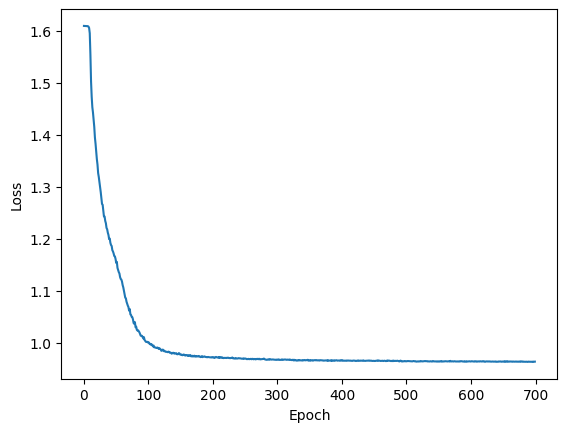

Test accuracy: 463.9010752688172
Accuracy: 0.40258064516129033
Precision: 0.41513709282222366
Recall: 0.40240026164815346
F1-score: 0.4072094815671399


Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.49      0.53       495
           1       0.38      0.35      0.36       472
           2       0.24      0.29      0.26       449
           3       0.26      0.29      0.28       463
           4       0.60      0.60      0.60       446

    accuracy                           0.40      2325
   macro avg       0.42      0.40      0.41      2325
weighted avg       0.42      0.40      0.41      2325

                    0           1           2           3           4  \
precision    0.583535    0.383529    0.243346    0.262136    0.603139   
recall       0.486869    0.345339    0.285078    0.291577    0.603139   
f1-score     0.530837    0.363434    0.262564    0.276074    0.603139   
support    495.000000  472.000000  449.0000

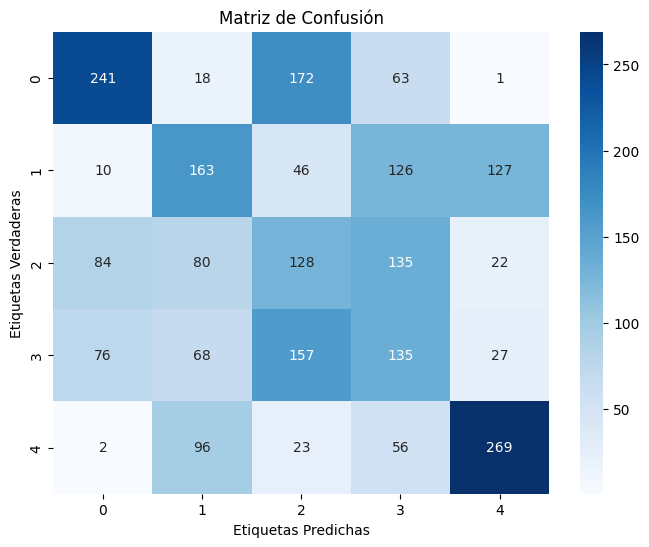

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_700_1e-05_0.2/resultados_700_1e-05_0.2.json
Procesando red con 1000 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas:   0%|                                                              | 1/1000 [00:02<44:42,  2.68s/it]

1.6094673374119928


Procesando epocas:   0%|                                                              | 2/1000 [00:05<44:42,  2.69s/it]

1.5300927134121165


Procesando epocas:   0%|▏                                                             | 3/1000 [00:08<44:27,  2.68s/it]

1.4000706967185526


Procesando epocas:   0%|▏                                                             | 4/1000 [00:10<44:14,  2.67s/it]

1.3623374707558575


Procesando epocas:   0%|▎                                                             | 5/1000 [00:13<44:17,  2.67s/it]

1.3171746660681332


Procesando epocas:   1%|▎                                                             | 6/1000 [00:16<44:22,  2.68s/it]

1.2799631364205304


Procesando epocas:   1%|▍                                                             | 7/1000 [00:18<44:16,  2.68s/it]

1.2510396172018612


Procesando epocas:   1%|▍                                                             | 8/1000 [00:21<44:01,  2.66s/it]

1.2227005607941572


Procesando epocas:   1%|▌                                                             | 9/1000 [00:24<44:12,  2.68s/it]

1.1932955762919257


Procesando epocas:   1%|▌                                                            | 10/1000 [00:26<44:07,  2.67s/it]

1.1626037983333364


Procesando epocas:   1%|▋                                                            | 11/1000 [00:29<43:53,  2.66s/it]

1.1312095046043396


Procesando epocas:   1%|▋                                                            | 12/1000 [00:32<43:49,  2.66s/it]

1.10962976287393


Procesando epocas:   1%|▊                                                            | 13/1000 [00:34<43:51,  2.67s/it]

1.0946015943499172


Procesando epocas:   1%|▊                                                            | 14/1000 [00:37<43:52,  2.67s/it]

1.0850806176662444


Procesando epocas:   2%|▉                                                            | 15/1000 [00:40<43:56,  2.68s/it]

1.0694714272723478


Procesando epocas:   2%|▉                                                            | 16/1000 [00:42<43:43,  2.67s/it]

1.0591720609103932


Procesando epocas:   2%|█                                                            | 17/1000 [00:45<43:36,  2.66s/it]

1.0561638506019817


Procesando epocas:   2%|█                                                            | 18/1000 [00:48<43:32,  2.66s/it]

1.0529401533743914


Procesando epocas:   2%|█▏                                                           | 19/1000 [00:50<43:31,  2.66s/it]

1.0459241095711203


Procesando epocas:   2%|█▏                                                           | 20/1000 [00:53<43:04,  2.64s/it]

1.0444548385984758


Procesando epocas:   2%|█▎                                                           | 21/1000 [00:55<41:45,  2.56s/it]

1.0412610790308785


Procesando epocas:   2%|█▎                                                           | 22/1000 [00:58<42:08,  2.59s/it]

1.035357647783616


Procesando epocas:   2%|█▍                                                           | 23/1000 [01:00<42:35,  2.62s/it]

1.0285569787025453


Procesando epocas:   2%|█▍                                                           | 24/1000 [01:03<42:49,  2.63s/it]

1.03291555537897


Procesando epocas:   2%|█▌                                                           | 25/1000 [01:06<43:06,  2.65s/it]

1.0315326140207404


Procesando epocas:   3%|█▌                                                           | 26/1000 [01:09<43:14,  2.66s/it]

1.0280179142951966


Procesando epocas:   3%|█▋                                                           | 27/1000 [01:11<43:12,  2.66s/it]

1.0266961977762334


Procesando epocas:   3%|█▋                                                           | 28/1000 [01:14<43:08,  2.66s/it]

1.0310245079152724


Procesando epocas:   3%|█▊                                                           | 29/1000 [01:17<43:09,  2.67s/it]

1.0309178755563848


Procesando epocas:   3%|█▊                                                           | 30/1000 [01:19<43:15,  2.68s/it]

1.0280925298438353


Procesando epocas:   3%|█▉                                                           | 31/1000 [01:22<43:03,  2.67s/it]

1.025655603759429


Procesando epocas:   3%|█▉                                                           | 32/1000 [01:25<42:48,  2.65s/it]

1.0225494875627406


Procesando epocas:   3%|██                                                           | 33/1000 [01:27<42:47,  2.65s/it]

1.019488107807496


Procesando epocas:   3%|██                                                           | 34/1000 [01:30<42:39,  2.65s/it]

1.0187199536491842


Procesando epocas:   4%|██▏                                                          | 35/1000 [01:32<42:31,  2.64s/it]

1.0189840916325064


Procesando epocas:   4%|██▏                                                          | 36/1000 [01:35<42:34,  2.65s/it]

1.019665807134965


Procesando epocas:   4%|██▎                                                          | 37/1000 [01:38<42:34,  2.65s/it]

1.0178641848704395


Procesando epocas:   4%|██▎                                                          | 38/1000 [01:40<42:32,  2.65s/it]

1.016957587003708


Procesando epocas:   4%|██▍                                                          | 39/1000 [01:43<42:37,  2.66s/it]

1.019362650899326


Procesando epocas:   4%|██▍                                                          | 40/1000 [01:46<42:29,  2.66s/it]

1.020550118825015


Procesando epocas:   4%|██▌                                                          | 41/1000 [01:48<42:17,  2.65s/it]

1.0200178528533261


Procesando epocas:   4%|██▌                                                          | 42/1000 [01:51<42:20,  2.65s/it]

1.0211775579873252


Procesando epocas:   4%|██▌                                                          | 43/1000 [01:54<42:21,  2.66s/it]

1.0140750443234163


Procesando epocas:   4%|██▋                                                          | 44/1000 [01:56<42:13,  2.65s/it]

1.013312297708848


Procesando epocas:   4%|██▋                                                          | 45/1000 [01:59<42:03,  2.64s/it]

1.0130909425370833


Procesando epocas:   5%|██▊                                                          | 46/1000 [02:02<41:56,  2.64s/it]

1.0140961057999556


Procesando epocas:   5%|██▊                                                          | 47/1000 [02:04<41:54,  2.64s/it]

1.0110986986581016


Procesando epocas:   5%|██▉                                                          | 48/1000 [02:07<41:54,  2.64s/it]

1.0113977186820087


Procesando epocas:   5%|██▉                                                          | 49/1000 [02:10<41:54,  2.64s/it]

1.011230185803245


Procesando epocas:   5%|███                                                          | 50/1000 [02:12<42:03,  2.66s/it]

1.012320155957166


Procesando epocas:   5%|███                                                          | 51/1000 [02:15<42:04,  2.66s/it]

1.011127854094786


Procesando epocas:   5%|███▏                                                         | 52/1000 [02:18<41:59,  2.66s/it]

1.0086920955601861


Procesando epocas:   5%|███▏                                                         | 53/1000 [02:20<41:50,  2.65s/it]

1.0078494426082163


Procesando epocas:   5%|███▎                                                         | 54/1000 [02:23<41:42,  2.65s/it]

1.006857272456674


Procesando epocas:   6%|███▎                                                         | 55/1000 [02:25<41:49,  2.66s/it]

1.01103454933447


Procesando epocas:   6%|███▍                                                         | 56/1000 [02:28<41:52,  2.66s/it]

1.0141288441770218


Procesando epocas:   6%|███▍                                                         | 57/1000 [02:31<41:54,  2.67s/it]

1.01935173869133


Procesando epocas:   6%|███▌                                                         | 58/1000 [02:34<41:58,  2.67s/it]

1.0168502800604877


Procesando epocas:   6%|███▌                                                         | 59/1000 [02:36<42:02,  2.68s/it]

1.0122802874621224


Procesando epocas:   6%|███▋                                                         | 60/1000 [02:39<42:09,  2.69s/it]

1.0125197354485007


Procesando epocas:   6%|███▋                                                         | 61/1000 [02:42<42:07,  2.69s/it]

1.0117673509261187


Procesando epocas:   6%|███▊                                                         | 62/1000 [02:44<42:06,  2.69s/it]

1.0114273530595443


Procesando epocas:   6%|███▊                                                         | 63/1000 [02:47<42:18,  2.71s/it]

1.0113993441357332


Procesando epocas:   6%|███▉                                                         | 64/1000 [02:50<42:17,  2.71s/it]

1.0098665672190048


Procesando epocas:   6%|███▉                                                         | 65/1000 [02:52<42:05,  2.70s/it]

1.00891513894586


Procesando epocas:   7%|████                                                         | 66/1000 [02:55<41:56,  2.69s/it]

1.0080098022432888


Procesando epocas:   7%|████                                                         | 67/1000 [02:58<41:55,  2.70s/it]

1.006068592562395


Procesando epocas:   7%|████▏                                                        | 68/1000 [03:01<42:02,  2.71s/it]

1.0052247934481677


Procesando epocas:   7%|████▏                                                        | 69/1000 [03:03<42:01,  2.71s/it]

1.0018893592497882


Procesando epocas:   7%|████▎                                                        | 70/1000 [03:06<41:52,  2.70s/it]

1.0054539224680732


Procesando epocas:   7%|████▎                                                        | 71/1000 [03:09<41:59,  2.71s/it]

1.0045910169096555


Procesando epocas:   7%|████▍                                                        | 72/1000 [03:11<42:05,  2.72s/it]

1.0034320414066316


Procesando epocas:   7%|████▍                                                        | 73/1000 [03:14<42:03,  2.72s/it]

1.0028064110699821


Procesando epocas:   7%|████▌                                                        | 74/1000 [03:17<42:02,  2.72s/it]

1.001853175724254


Procesando epocas:   8%|████▌                                                        | 75/1000 [03:20<41:59,  2.72s/it]

1.0018590951667112


Procesando epocas:   8%|████▋                                                        | 76/1000 [03:22<42:05,  2.73s/it]

1.0031528339666478


Procesando epocas:   8%|████▋                                                        | 77/1000 [03:25<42:05,  2.74s/it]

1.002296748231439


Procesando epocas:   8%|████▊                                                        | 78/1000 [03:28<41:59,  2.73s/it]

0.9999703712323132


Procesando epocas:   8%|████▊                                                        | 79/1000 [03:31<41:52,  2.73s/it]

1.001771462314269


Procesando epocas:   8%|████▉                                                        | 80/1000 [03:33<41:52,  2.73s/it]

1.0028797296916738


Procesando epocas:   8%|████▉                                                        | 81/1000 [03:36<41:50,  2.73s/it]

1.0031172496431013


Procesando epocas:   8%|█████                                                        | 82/1000 [03:39<41:42,  2.73s/it]

1.0020562561119304


Procesando epocas:   8%|█████                                                        | 83/1000 [03:41<41:36,  2.72s/it]

1.002165035640492


Procesando epocas:   8%|█████                                                        | 84/1000 [03:44<41:15,  2.70s/it]

1.0021945679889006


Procesando epocas:   8%|█████▏                                                       | 85/1000 [03:47<41:15,  2.71s/it]

1.00240419086288


Procesando epocas:   9%|█████▏                                                       | 86/1000 [03:50<41:07,  2.70s/it]

1.0024320328936858


Procesando epocas:   9%|█████▎                                                       | 87/1000 [03:52<41:01,  2.70s/it]

1.0017323728869942


Procesando epocas:   9%|█████▎                                                       | 88/1000 [03:55<40:54,  2.69s/it]

1.0041500796290006


Procesando epocas:   9%|█████▍                                                       | 89/1000 [03:58<40:55,  2.70s/it]

1.0031142140136045


Procesando epocas:   9%|█████▍                                                       | 90/1000 [04:00<40:53,  2.70s/it]

1.0006816029548644


Procesando epocas:   9%|█████▌                                                       | 91/1000 [04:03<40:48,  2.69s/it]

1.0007005607380586


Procesando epocas:   9%|█████▌                                                       | 92/1000 [04:06<40:34,  2.68s/it]

1.0016613409799688


Procesando epocas:   9%|█████▋                                                       | 93/1000 [04:08<40:22,  2.67s/it]

0.9990561464253593


Procesando epocas:   9%|█████▋                                                       | 94/1000 [04:11<40:19,  2.67s/it]

0.9992409302907832


Procesando epocas:  10%|█████▊                                                       | 95/1000 [04:14<40:03,  2.66s/it]

0.9991807450266446


Procesando epocas:  10%|█████▊                                                       | 96/1000 [04:16<40:05,  2.66s/it]

0.999725402803982


Procesando epocas:  10%|█████▉                                                       | 97/1000 [04:19<39:54,  2.65s/it]

1.0011501540155971


Procesando epocas:  10%|█████▉                                                       | 98/1000 [04:21<39:45,  2.64s/it]

0.9965281170957229


Procesando epocas:  10%|██████                                                       | 99/1000 [04:24<39:40,  2.64s/it]

0.9968152351239148


Procesando epocas:  10%|██████                                                      | 100/1000 [04:27<39:39,  2.64s/it]

0.9999402544077705


Procesando epocas:  10%|██████                                                      | 101/1000 [04:29<39:38,  2.65s/it]

0.9995122706188875


Procesando epocas:  10%|██████                                                      | 102/1000 [04:32<39:40,  2.65s/it]

0.9990275863338919


Procesando epocas:  10%|██████▏                                                     | 103/1000 [04:35<39:33,  2.65s/it]

0.9994348694296444


Procesando epocas:  10%|██████▏                                                     | 104/1000 [04:37<39:30,  2.65s/it]

0.9978431806844823


Procesando epocas:  10%|██████▎                                                     | 105/1000 [04:40<39:35,  2.65s/it]

0.9966571674627416


Procesando epocas:  11%|██████▎                                                     | 106/1000 [04:43<39:50,  2.67s/it]

0.9943064195268294


Procesando epocas:  11%|██████▍                                                     | 107/1000 [04:45<39:52,  2.68s/it]

0.9951197326183319


Procesando epocas:  11%|██████▍                                                     | 108/1000 [04:48<39:46,  2.68s/it]

0.99445980647031


Procesando epocas:  11%|██████▌                                                     | 109/1000 [04:51<39:36,  2.67s/it]

0.9960775200058433


Procesando epocas:  11%|██████▌                                                     | 110/1000 [04:53<39:28,  2.66s/it]

0.9966140491120955


Procesando epocas:  11%|██████▋                                                     | 111/1000 [04:56<39:28,  2.66s/it]

0.9961055440061233


Procesando epocas:  11%|██████▋                                                     | 112/1000 [04:59<39:17,  2.66s/it]

0.9963424679111031


Procesando epocas:  11%|██████▊                                                     | 113/1000 [05:01<39:12,  2.65s/it]

0.9973199465695549


Procesando epocas:  11%|██████▊                                                     | 114/1000 [05:04<39:12,  2.66s/it]

0.9968903825563543


Procesando epocas:  12%|██████▉                                                     | 115/1000 [05:07<39:12,  2.66s/it]

0.9953570495633518


Procesando epocas:  12%|██████▉                                                     | 116/1000 [05:09<39:18,  2.67s/it]

0.9974251368466546


Procesando epocas:  12%|███████                                                     | 117/1000 [05:12<39:15,  2.67s/it]

0.994608324766159


Procesando epocas:  12%|███████                                                     | 118/1000 [05:15<39:19,  2.68s/it]

0.9940667278626386


Procesando epocas:  12%|███████▏                                                    | 119/1000 [05:17<39:16,  2.68s/it]

0.9916802427347968


Procesando epocas:  12%|███████▏                                                    | 120/1000 [05:20<39:04,  2.66s/it]

0.9916376124410068


Procesando epocas:  12%|███████▎                                                    | 121/1000 [05:23<39:05,  2.67s/it]

0.991382357302834


Procesando epocas:  12%|███████▎                                                    | 122/1000 [05:25<39:04,  2.67s/it]

0.9967403068261989


Procesando epocas:  12%|███████▍                                                    | 123/1000 [05:28<39:08,  2.68s/it]

0.9978919996934779


Procesando epocas:  12%|███████▍                                                    | 124/1000 [05:31<39:08,  2.68s/it]

0.9970048161113964


Procesando epocas:  12%|███████▌                                                    | 125/1000 [05:33<39:01,  2.68s/it]

0.9952397837358362


Procesando epocas:  13%|███████▌                                                    | 126/1000 [05:36<38:49,  2.67s/it]

0.9966525642310872


Procesando epocas:  13%|███████▌                                                    | 127/1000 [05:39<38:40,  2.66s/it]

0.9964768167804269


Procesando epocas:  13%|███████▋                                                    | 128/1000 [05:41<38:31,  2.65s/it]

0.9946582156069138


Procesando epocas:  13%|███████▋                                                    | 129/1000 [05:44<38:26,  2.65s/it]

0.9953224304844351


Procesando epocas:  13%|███████▊                                                    | 130/1000 [05:47<38:17,  2.64s/it]

0.9966110720353968


Procesando epocas:  13%|███████▊                                                    | 131/1000 [05:49<38:17,  2.64s/it]

0.9934101812979754


Procesando epocas:  13%|███████▉                                                    | 132/1000 [05:52<38:15,  2.64s/it]

0.9915387935498181


Procesando epocas:  13%|███████▉                                                    | 133/1000 [05:55<38:09,  2.64s/it]

0.993878883824629


Procesando epocas:  13%|████████                                                    | 134/1000 [05:57<38:20,  2.66s/it]

0.9998687943991493


Procesando epocas:  14%|████████                                                    | 135/1000 [06:00<38:25,  2.67s/it]

1.000236095751033


Procesando epocas:  14%|████████▏                                                   | 136/1000 [06:03<38:20,  2.66s/it]

0.9953966698225807


Procesando epocas:  14%|████████▏                                                   | 137/1000 [06:05<38:17,  2.66s/it]

0.9979566377751967


Procesando epocas:  14%|████████▎                                                   | 138/1000 [06:08<38:09,  2.66s/it]

0.9985794645898483


Procesando epocas:  14%|████████▎                                                   | 139/1000 [06:11<38:01,  2.65s/it]

0.9978749299750609


Procesando epocas:  14%|████████▍                                                   | 140/1000 [06:13<38:05,  2.66s/it]

0.9975185811519622


Procesando epocas:  14%|████████▍                                                   | 141/1000 [06:16<38:07,  2.66s/it]

0.9948539337691139


Procesando epocas:  14%|████████▌                                                   | 142/1000 [06:19<38:04,  2.66s/it]

0.9913431051899405


Procesando epocas:  14%|████████▌                                                   | 143/1000 [06:21<38:04,  2.67s/it]

0.9900314688682557


Procesando epocas:  14%|████████▋                                                   | 144/1000 [06:24<37:54,  2.66s/it]

0.9915159162353067


Procesando epocas:  14%|████████▋                                                   | 145/1000 [06:27<37:47,  2.65s/it]

0.9918230551130631


Procesando epocas:  15%|████████▊                                                   | 146/1000 [06:29<37:45,  2.65s/it]

0.9916715337949641


Procesando epocas:  15%|████████▊                                                   | 147/1000 [06:32<37:39,  2.65s/it]

0.9879544868188745


Procesando epocas:  15%|████████▉                                                   | 148/1000 [06:34<37:47,  2.66s/it]

0.9894488695789786


Procesando epocas:  15%|████████▉                                                   | 149/1000 [06:37<37:37,  2.65s/it]

0.9883891670142904


Procesando epocas:  15%|█████████                                                   | 150/1000 [06:40<37:29,  2.65s/it]

0.9888816332115846


Procesando epocas:  15%|█████████                                                   | 151/1000 [06:42<37:34,  2.66s/it]

0.9880555268596201


Procesando epocas:  15%|█████████                                                   | 152/1000 [06:45<37:34,  2.66s/it]

0.9882486445062301


Procesando epocas:  15%|█████████▏                                                  | 153/1000 [06:48<37:29,  2.66s/it]

0.9867961585521698


Procesando epocas:  15%|█████████▏                                                  | 154/1000 [06:50<37:26,  2.66s/it]

0.988170743339202


Procesando epocas:  16%|█████████▎                                                  | 155/1000 [06:53<37:24,  2.66s/it]

0.9902021769215079


Procesando epocas:  16%|█████████▎                                                  | 156/1000 [06:56<37:21,  2.66s/it]

0.98807692527771


Procesando epocas:  16%|█████████▍                                                  | 157/1000 [06:58<37:12,  2.65s/it]

0.9866083941038917


Procesando epocas:  16%|█████████▍                                                  | 158/1000 [07:01<37:18,  2.66s/it]

0.9879889614441816


Procesando epocas:  16%|█████████▌                                                  | 159/1000 [07:04<37:10,  2.65s/it]

0.986852045620189


Procesando epocas:  16%|█████████▌                                                  | 160/1000 [07:06<37:04,  2.65s/it]

0.9864948272705079


Procesando epocas:  16%|█████████▋                                                  | 161/1000 [07:09<37:06,  2.65s/it]

0.9852629009415121


Procesando epocas:  16%|█████████▋                                                  | 162/1000 [07:12<37:08,  2.66s/it]

0.9856462713550119


Procesando epocas:  16%|█████████▊                                                  | 163/1000 [07:14<37:04,  2.66s/it]

0.9849942487828872


Procesando epocas:  16%|█████████▊                                                  | 164/1000 [07:17<37:11,  2.67s/it]

0.9838849481414346


Procesando epocas:  16%|█████████▉                                                  | 165/1000 [07:20<37:07,  2.67s/it]

0.986234700679779


Procesando epocas:  17%|█████████▉                                                  | 166/1000 [07:22<37:03,  2.67s/it]

0.9859064529923832


Procesando epocas:  17%|██████████                                                  | 167/1000 [07:25<36:59,  2.66s/it]

0.9854614398058723


Procesando epocas:  17%|██████████                                                  | 168/1000 [07:28<36:45,  2.65s/it]

0.9874712376033559


Procesando epocas:  17%|██████████▏                                                 | 169/1000 [07:30<36:36,  2.64s/it]

0.9917068032657399


Procesando epocas:  17%|██████████▏                                                 | 170/1000 [07:33<36:25,  2.63s/it]

0.9921942191965439


Procesando epocas:  17%|██████████▎                                                 | 171/1000 [07:36<36:33,  2.65s/it]

0.992790077714359


Procesando epocas:  17%|██████████▎                                                 | 172/1000 [07:38<36:25,  2.64s/it]

0.9889254163293277


Procesando epocas:  17%|██████████▍                                                 | 173/1000 [07:41<36:18,  2.63s/it]

0.9878732902162215


Procesando epocas:  17%|██████████▍                                                 | 174/1000 [07:43<36:13,  2.63s/it]

0.9852444845087388


Procesando epocas:  18%|██████████▌                                                 | 175/1000 [07:46<36:24,  2.65s/it]

0.9878066536258249


Procesando epocas:  18%|██████████▌                                                 | 176/1000 [07:49<36:23,  2.65s/it]

0.9872732379857232


Procesando epocas:  18%|██████████▌                                                 | 177/1000 [07:51<36:24,  2.65s/it]

0.9868886674151701


Procesando epocas:  18%|██████████▋                                                 | 178/1000 [07:54<36:21,  2.65s/it]

0.9871653206208173


Procesando epocas:  18%|██████████▋                                                 | 179/1000 [07:57<36:34,  2.67s/it]

0.9886008129400365


Procesando epocas:  18%|██████████▊                                                 | 180/1000 [07:59<36:38,  2.68s/it]

0.9872549242833082


Procesando epocas:  18%|██████████▊                                                 | 181/1000 [08:02<36:30,  2.67s/it]

0.9865990200463464


Procesando epocas:  18%|██████████▉                                                 | 182/1000 [08:05<36:23,  2.67s/it]

0.9884035573286168


Procesando epocas:  18%|██████████▉                                                 | 183/1000 [08:07<36:21,  2.67s/it]

0.9865876415196587


Procesando epocas:  18%|███████████                                                 | 184/1000 [08:10<36:15,  2.67s/it]

0.9848883814671461


Procesando epocas:  18%|███████████                                                 | 185/1000 [08:13<36:22,  2.68s/it]

0.9862588472226087


Procesando epocas:  19%|███████████▏                                                | 186/1000 [08:16<36:30,  2.69s/it]

0.9887120373108808


Procesando epocas:  19%|███████████▏                                                | 187/1000 [08:18<36:28,  2.69s/it]

0.9875287778237287


Procesando epocas:  19%|███████████▎                                                | 188/1000 [08:21<36:27,  2.69s/it]

0.9853467194473042


Procesando epocas:  19%|███████████▎                                                | 189/1000 [08:24<36:24,  2.69s/it]

0.9845618672230665


Procesando epocas:  19%|███████████▍                                                | 190/1000 [08:26<36:20,  2.69s/it]

0.9842280363335328


Procesando epocas:  19%|███████████▍                                                | 191/1000 [08:29<36:20,  2.70s/it]

0.9841001514126273


Procesando epocas:  19%|███████████▌                                                | 192/1000 [08:32<36:17,  2.69s/it]

0.9834239023573258


Procesando epocas:  19%|███████████▌                                                | 193/1000 [08:34<36:16,  2.70s/it]

0.9865441115463481


Procesando epocas:  19%|███████████▋                                                | 194/1000 [08:37<36:22,  2.71s/it]

0.9834567094550414


Procesando epocas:  20%|███████████▋                                                | 195/1000 [08:40<36:19,  2.71s/it]

0.985914661954431


Procesando epocas:  20%|███████████▊                                                | 196/1000 [08:43<36:09,  2.70s/it]

0.9825541503289167


Procesando epocas:  20%|███████████▊                                                | 197/1000 [08:45<36:10,  2.70s/it]

0.9838229347677792


Procesando epocas:  20%|███████████▉                                                | 198/1000 [08:48<36:14,  2.71s/it]

0.9857183330199297


Procesando epocas:  20%|███████████▉                                                | 199/1000 [08:51<36:12,  2.71s/it]

0.9852874279022217


Procesando epocas:  20%|████████████                                                | 200/1000 [08:53<36:17,  2.72s/it]

0.9876207947731018


Procesando epocas:  20%|████████████                                                | 201/1000 [08:56<36:10,  2.72s/it]

0.9819358969435973


Procesando epocas:  20%|████████████                                                | 202/1000 [08:59<36:02,  2.71s/it]

0.9813424625817467


Procesando epocas:  20%|████████████▏                                               | 203/1000 [09:02<35:58,  2.71s/it]

0.9876952753347509


Procesando epocas:  20%|████████████▏                                               | 204/1000 [09:04<35:50,  2.70s/it]

0.982715365115334


Procesando epocas:  20%|████████████▎                                               | 205/1000 [09:07<35:41,  2.69s/it]

0.9847423718256109


Procesando epocas:  21%|████████████▎                                               | 206/1000 [09:10<35:36,  2.69s/it]

0.9814924461000106


Procesando epocas:  21%|████████████▍                                               | 207/1000 [09:12<35:31,  2.69s/it]

0.9788684915093815


Procesando epocas:  21%|████████████▍                                               | 208/1000 [09:15<35:27,  2.69s/it]

0.9787208834115196


Procesando epocas:  21%|████████████▌                                               | 209/1000 [09:18<35:23,  2.68s/it]

0.9784631006857928


Procesando epocas:  21%|████████████▌                                               | 210/1000 [09:20<35:16,  2.68s/it]

0.9788809408159816


Procesando epocas:  21%|████████████▋                                               | 211/1000 [09:23<35:03,  2.67s/it]

0.979937201387742


Procesando epocas:  21%|████████████▋                                               | 212/1000 [09:26<35:02,  2.67s/it]

0.9798878101741566


Procesando epocas:  21%|████████████▊                                               | 213/1000 [09:28<35:08,  2.68s/it]

0.9817399820860695


Procesando epocas:  21%|████████████▊                                               | 214/1000 [09:31<35:08,  2.68s/it]

0.9811742884271285


Procesando epocas:  22%|████████████▉                                               | 215/1000 [09:34<35:09,  2.69s/it]

0.9795748812310836


Procesando epocas:  22%|████████████▉                                               | 216/1000 [09:36<35:08,  2.69s/it]

0.9817214113824507


Procesando epocas:  22%|█████████████                                               | 217/1000 [09:39<35:11,  2.70s/it]

0.990521444643245


Procesando epocas:  22%|█████████████                                               | 218/1000 [09:42<35:02,  2.69s/it]

0.9807907497181612


Procesando epocas:  22%|█████████████▏                                              | 219/1000 [09:44<35:02,  2.69s/it]

0.9842640491092907


Procesando epocas:  22%|█████████████▏                                              | 220/1000 [09:47<35:06,  2.70s/it]

0.983152242267833


Procesando epocas:  22%|█████████████▎                                              | 221/1000 [09:50<35:06,  2.70s/it]

0.9848882457789253


Procesando epocas:  22%|█████████████▎                                              | 222/1000 [09:53<35:07,  2.71s/it]

0.9855167304768282


Procesando epocas:  22%|█████████████▍                                              | 223/1000 [09:55<35:03,  2.71s/it]

0.9809770121293909


Procesando epocas:  22%|█████████████▍                                              | 224/1000 [09:58<34:52,  2.70s/it]

0.9818509424433989


Procesando epocas:  22%|█████████████▌                                              | 225/1000 [10:01<34:53,  2.70s/it]

0.9839983845458311


Procesando epocas:  23%|█████████████▌                                              | 226/1000 [10:03<34:54,  2.71s/it]

0.9806765216238359


Procesando epocas:  23%|█████████████▌                                              | 227/1000 [10:06<34:50,  2.70s/it]

0.9812858332605923


Procesando epocas:  23%|█████████████▋                                              | 228/1000 [10:09<34:42,  2.70s/it]

0.9795655204969294


Procesando epocas:  23%|█████████████▋                                              | 229/1000 [10:12<34:43,  2.70s/it]

0.9806842716301188


Procesando epocas:  23%|█████████████▊                                              | 230/1000 [10:14<34:34,  2.69s/it]

0.9797853557502523


Procesando epocas:  23%|█████████████▊                                              | 231/1000 [10:17<34:21,  2.68s/it]

0.9820567330893348


Procesando epocas:  23%|█████████████▉                                              | 232/1000 [10:20<34:20,  2.68s/it]

0.9797407392193289


Procesando epocas:  23%|█████████████▉                                              | 233/1000 [10:22<34:16,  2.68s/it]

0.9809597979573642


Procesando epocas:  23%|██████████████                                              | 234/1000 [10:25<34:03,  2.67s/it]

0.9798816039281733


Procesando epocas:  24%|██████████████                                              | 235/1000 [10:27<33:54,  2.66s/it]

0.9781410571406869


Procesando epocas:  24%|██████████████▏                                             | 236/1000 [10:30<33:54,  2.66s/it]

0.9782930868513444


Procesando epocas:  24%|██████████████▏                                             | 237/1000 [10:33<33:55,  2.67s/it]

0.9775774184395285


Procesando epocas:  24%|██████████████▎                                             | 238/1000 [10:35<33:49,  2.66s/it]

0.9785677071879891


Procesando epocas:  24%|██████████████▎                                             | 239/1000 [10:38<33:48,  2.67s/it]

0.9771176040172577


Procesando epocas:  24%|██████████████▍                                             | 240/1000 [10:41<33:41,  2.66s/it]

0.9779678348232718


Procesando epocas:  24%|██████████████▍                                             | 241/1000 [10:43<33:42,  2.67s/it]

0.9791607811170466


Procesando epocas:  24%|██████████████▌                                             | 242/1000 [10:46<33:44,  2.67s/it]

0.9772320863078622


Procesando epocas:  24%|██████████████▌                                             | 243/1000 [10:49<33:42,  2.67s/it]

0.9790802001953125


Procesando epocas:  24%|██████████████▋                                             | 244/1000 [10:52<33:39,  2.67s/it]

0.9775626911836512


Procesando epocas:  24%|██████████████▋                                             | 245/1000 [10:54<33:31,  2.66s/it]

0.9770069357226877


Procesando epocas:  25%|██████████████▊                                             | 246/1000 [10:57<33:24,  2.66s/it]

0.9789108648019679


Procesando epocas:  25%|██████████████▊                                             | 247/1000 [10:59<33:19,  2.66s/it]

0.9822227860198302


Procesando epocas:  25%|██████████████▉                                             | 248/1000 [11:02<33:08,  2.64s/it]

0.9797762593802284


Procesando epocas:  25%|██████████████▉                                             | 249/1000 [11:05<33:00,  2.64s/it]

0.9789402670720044


Procesando epocas:  25%|███████████████                                             | 250/1000 [11:07<32:55,  2.63s/it]

0.9785438944311703


Procesando epocas:  25%|███████████████                                             | 251/1000 [11:10<33:06,  2.65s/it]

0.9778420479858623


Procesando epocas:  25%|███████████████                                             | 252/1000 [11:13<33:03,  2.65s/it]

0.9807833902976092


Procesando epocas:  25%|███████████████▏                                            | 253/1000 [11:15<32:56,  2.65s/it]

0.980541348807952


Procesando epocas:  25%|███████████████▏                                            | 254/1000 [11:18<32:55,  2.65s/it]

0.9802208430626813


Procesando epocas:  26%|███████████████▎                                            | 255/1000 [11:21<32:53,  2.65s/it]

0.9782416676773744


Procesando epocas:  26%|███████████████▎                                            | 256/1000 [11:23<32:50,  2.65s/it]

0.9804169360329124


Procesando epocas:  26%|███████████████▍                                            | 257/1000 [11:26<32:44,  2.64s/it]

0.9801510575939627


Procesando epocas:  26%|███████████████▍                                            | 258/1000 [11:29<32:43,  2.65s/it]

0.9783533625742968


Procesando epocas:  26%|███████████████▌                                            | 259/1000 [11:31<32:51,  2.66s/it]

0.9772480940117555


Procesando epocas:  26%|███████████████▌                                            | 260/1000 [11:34<32:52,  2.67s/it]

0.9874897879712722


Procesando epocas:  26%|███████████████▋                                            | 261/1000 [11:37<32:54,  2.67s/it]

0.9798174086739035


Procesando epocas:  26%|███████████████▋                                            | 262/1000 [11:39<33:03,  2.69s/it]

0.9802985310554504


Procesando epocas:  26%|███████████████▊                                            | 263/1000 [11:42<33:02,  2.69s/it]

0.9772319043383879


Procesando epocas:  26%|███████████████▊                                            | 264/1000 [11:45<32:57,  2.69s/it]

0.9779261361150181


Procesando epocas:  26%|███████████████▉                                            | 265/1000 [11:47<32:52,  2.68s/it]

0.9771608952213736


Procesando epocas:  27%|███████████████▉                                            | 266/1000 [11:50<32:39,  2.67s/it]

0.9784128988490385


Procesando epocas:  27%|████████████████                                            | 267/1000 [11:53<32:29,  2.66s/it]

0.9798852289424224


Procesando epocas:  27%|████████████████                                            | 268/1000 [11:55<32:37,  2.67s/it]

0.9767084854490616


Procesando epocas:  27%|████████████████▏                                           | 269/1000 [11:58<32:29,  2.67s/it]

0.9773854984956629


Procesando epocas:  27%|████████████████▏                                           | 270/1000 [12:01<32:24,  2.66s/it]

0.9751901451279136


Procesando epocas:  27%|████████████████▎                                           | 271/1000 [12:03<32:16,  2.66s/it]

0.9763391365023221


Procesando epocas:  27%|████████████████▎                                           | 272/1000 [12:06<32:10,  2.65s/it]

0.9775805220884435


Procesando epocas:  27%|████████████████▍                                           | 273/1000 [12:09<32:14,  2.66s/it]

0.9763339519500732


Procesando epocas:  27%|████████████████▍                                           | 274/1000 [12:11<32:07,  2.65s/it]

0.9782859907430761


Procesando epocas:  28%|████████████████▌                                           | 275/1000 [12:14<31:57,  2.65s/it]

0.9777073509552899


Procesando epocas:  28%|████████████████▌                                           | 276/1000 [12:17<31:51,  2.64s/it]

0.9743494258207434


Procesando epocas:  28%|████████████████▌                                           | 277/1000 [12:19<31:47,  2.64s/it]

0.9775017654194551


Procesando epocas:  28%|████████████████▋                                           | 278/1000 [12:22<31:44,  2.64s/it]

0.9752268061918371


Procesando epocas:  28%|████████████████▋                                           | 279/1000 [12:24<31:39,  2.64s/it]

0.9759655033840853


Procesando epocas:  28%|████████████████▊                                           | 280/1000 [12:27<31:42,  2.64s/it]

0.9763012745801141


Procesando epocas:  28%|████████████████▊                                           | 281/1000 [12:30<31:44,  2.65s/it]

0.9771034906892215


Procesando epocas:  28%|████████████████▉                                           | 282/1000 [12:32<31:42,  2.65s/it]

0.9762062258580152


Procesando epocas:  28%|████████████████▉                                           | 283/1000 [12:35<31:45,  2.66s/it]

0.975537179848727


Procesando epocas:  28%|█████████████████                                           | 284/1000 [12:38<31:43,  2.66s/it]

0.9766536530326394


Procesando epocas:  28%|█████████████████                                           | 285/1000 [12:40<31:44,  2.66s/it]

0.9759067619548124


Procesando epocas:  29%|█████████████████▏                                          | 286/1000 [12:43<31:42,  2.66s/it]

0.9758593082427979


Procesando epocas:  29%|█████████████████▏                                          | 287/1000 [12:46<31:41,  2.67s/it]

0.977012818701127


Procesando epocas:  29%|█████████████████▎                                          | 288/1000 [12:48<31:40,  2.67s/it]

0.9765133640345405


Procesando epocas:  29%|█████████████████▎                                          | 289/1000 [12:51<31:32,  2.66s/it]

0.9769770983387442


Procesando epocas:  29%|█████████████████▍                                          | 290/1000 [12:54<31:21,  2.65s/it]

0.9775636813219856


Procesando epocas:  29%|█████████████████▍                                          | 291/1000 [12:56<31:26,  2.66s/it]

0.977904620591332


Procesando epocas:  29%|█████████████████▌                                          | 292/1000 [12:59<31:22,  2.66s/it]

0.9778058258926168


Procesando epocas:  29%|█████████████████▌                                          | 293/1000 [13:02<31:17,  2.65s/it]

0.9763284346636604


Procesando epocas:  29%|█████████████████▋                                          | 294/1000 [13:04<31:14,  2.66s/it]

0.9750495833509109


Procesando epocas:  30%|█████████████████▋                                          | 295/1000 [13:07<31:18,  2.66s/it]

0.9750376624219558


Procesando epocas:  30%|█████████████████▊                                          | 296/1000 [13:10<31:09,  2.66s/it]

0.9738989426809199


Procesando epocas:  30%|█████████████████▊                                          | 297/1000 [13:12<31:01,  2.65s/it]

0.9739511377671186


Procesando epocas:  30%|█████████████████▉                                          | 298/1000 [13:15<30:57,  2.65s/it]

0.9721977212849785


Procesando epocas:  30%|█████████████████▉                                          | 299/1000 [13:18<30:52,  2.64s/it]

0.9732761793276843


Procesando epocas:  30%|██████████████████                                          | 300/1000 [13:20<30:44,  2.64s/it]

0.9748228683191187


Procesando epocas:  30%|██████████████████                                          | 301/1000 [13:23<30:40,  2.63s/it]

0.9734848870950586


Procesando epocas:  30%|██████████████████                                          | 302/1000 [13:25<30:40,  2.64s/it]

0.9747840663966011


Procesando epocas:  30%|██████████████████▏                                         | 303/1000 [13:28<30:50,  2.66s/it]

0.9747462542618022


Procesando epocas:  30%|██████████████████▏                                         | 304/1000 [13:31<30:58,  2.67s/it]

0.9763526912997751


Procesando epocas:  30%|██████████████████▎                                         | 305/1000 [13:34<30:54,  2.67s/it]

0.9760940821731792


Procesando epocas:  31%|██████████████████▎                                         | 306/1000 [13:36<31:14,  2.70s/it]

0.9769645978422726


Procesando epocas:  31%|██████████████████▍                                         | 307/1000 [13:39<31:11,  2.70s/it]

0.9771261997082654


Procesando epocas:  31%|██████████████████▍                                         | 308/1000 [13:42<31:17,  2.71s/it]

0.9769808131105759


Procesando epocas:  31%|██████████████████▌                                         | 309/1000 [13:44<31:22,  2.72s/it]

0.9759224898674909


Procesando epocas:  31%|██████████████████▌                                         | 310/1000 [13:47<31:33,  2.74s/it]

0.9775638285805197


Procesando epocas:  31%|██████████████████▋                                         | 311/1000 [13:50<31:29,  2.74s/it]

0.9788175684564254


Procesando epocas:  31%|██████████████████▋                                         | 312/1000 [13:53<31:30,  2.75s/it]

0.9762554834870731


Procesando epocas:  31%|██████████████████▊                                         | 313/1000 [13:55<31:23,  2.74s/it]

0.9748113246525035


Procesando epocas:  31%|██████████████████▊                                         | 314/1000 [13:58<31:23,  2.75s/it]

0.9751389496466693


Procesando epocas:  32%|██████████████████▉                                         | 315/1000 [14:01<31:18,  2.74s/it]

0.9745544426581438


Procesando epocas:  32%|██████████████████▉                                         | 316/1000 [14:04<31:10,  2.73s/it]

0.9740442268988665


Procesando epocas:  32%|███████████████████                                         | 317/1000 [14:06<31:06,  2.73s/it]

0.9729225607479319


Procesando epocas:  32%|███████████████████                                         | 318/1000 [14:09<31:01,  2.73s/it]

0.9717621803283691


Procesando epocas:  32%|███████████████████▏                                        | 319/1000 [14:12<30:57,  2.73s/it]

0.9747338386142955


Procesando epocas:  32%|███████████████████▏                                        | 320/1000 [14:15<30:50,  2.72s/it]

0.974103347343557


Procesando epocas:  32%|███████████████████▎                                        | 321/1000 [14:17<30:47,  2.72s/it]

0.9747846294851864


Procesando epocas:  32%|███████████████████▎                                        | 322/1000 [14:20<30:45,  2.72s/it]

0.9726351212052738


Procesando epocas:  32%|███████████████████▍                                        | 323/1000 [14:23<30:38,  2.72s/it]

0.9747008376261768


Procesando epocas:  32%|███████████████████▍                                        | 324/1000 [14:25<30:38,  2.72s/it]

0.9746145627077888


Procesando epocas:  32%|███████████████████▌                                        | 325/1000 [14:28<30:33,  2.72s/it]

0.9727338878547445


Procesando epocas:  33%|███████████████████▌                                        | 326/1000 [14:31<30:31,  2.72s/it]

0.9779268383979798


Procesando epocas:  33%|███████████████████▌                                        | 327/1000 [14:34<30:30,  2.72s/it]

0.9732345195377574


Procesando epocas:  33%|███████████████████▋                                        | 328/1000 [14:36<30:31,  2.73s/it]

0.9760254351531759


Procesando epocas:  33%|███████████████████▋                                        | 329/1000 [14:39<30:26,  2.72s/it]

0.9755266543696909


Procesando epocas:  33%|███████████████████▊                                        | 330/1000 [14:42<30:27,  2.73s/it]

0.9728502957259908


Procesando epocas:  33%|███████████████████▊                                        | 331/1000 [14:45<30:30,  2.74s/it]

0.9738854488905738


Procesando epocas:  33%|███████████████████▉                                        | 332/1000 [14:47<30:23,  2.73s/it]

0.9737109296462115


Procesando epocas:  33%|███████████████████▉                                        | 333/1000 [14:50<30:14,  2.72s/it]

0.972315403994392


Procesando epocas:  33%|████████████████████                                        | 334/1000 [14:53<30:09,  2.72s/it]

0.974447756655076


Procesando epocas:  34%|████████████████████                                        | 335/1000 [14:55<30:06,  2.72s/it]

0.9747187316417694


Procesando epocas:  34%|████████████████████▏                                       | 336/1000 [14:58<29:57,  2.71s/it]

0.9747456582153544


Procesando epocas:  34%|████████████████████▏                                       | 337/1000 [15:01<29:55,  2.71s/it]

0.9732969641685486


Procesando epocas:  34%|████████████████████▎                                       | 338/1000 [15:03<29:44,  2.70s/it]

0.9737553259905647


Procesando epocas:  34%|████████████████████▎                                       | 339/1000 [15:06<29:40,  2.69s/it]

0.9742391347885132


Procesando epocas:  34%|████████████████████▍                                       | 340/1000 [15:09<29:38,  2.69s/it]

0.9724941881263958


Procesando epocas:  34%|████████████████████▍                                       | 341/1000 [15:12<29:30,  2.69s/it]

0.9730929725310382


Procesando epocas:  34%|████████████████████▌                                       | 342/1000 [15:14<29:28,  2.69s/it]

0.9730970249456518


Procesando epocas:  34%|████████████████████▌                                       | 343/1000 [15:17<29:30,  2.69s/it]

0.9722620511756224


Procesando epocas:  34%|████████████████████▋                                       | 344/1000 [15:20<29:30,  2.70s/it]

0.9715680557138779


Procesando epocas:  34%|████████████████████▋                                       | 345/1000 [15:22<29:29,  2.70s/it]

0.9712280785336214


Procesando epocas:  35%|████████████████████▊                                       | 346/1000 [15:25<29:26,  2.70s/it]

0.9776700265267316


Procesando epocas:  35%|████████████████████▊                                       | 347/1000 [15:28<29:23,  2.70s/it]

0.9727705818765303


Procesando epocas:  35%|████████████████████▉                                       | 348/1000 [15:30<29:23,  2.71s/it]

0.9729389365981607


Procesando epocas:  35%|████████████████████▉                                       | 349/1000 [15:33<29:19,  2.70s/it]

0.9721572974148919


Procesando epocas:  35%|█████████████████████                                       | 350/1000 [15:36<29:17,  2.70s/it]

0.9701463348725263


Procesando epocas:  35%|█████████████████████                                       | 351/1000 [15:39<29:22,  2.72s/it]

0.9706896396244273


Procesando epocas:  35%|█████████████████████                                       | 352/1000 [15:41<29:12,  2.70s/it]

0.9718170151991002


Procesando epocas:  35%|█████████████████████▏                                      | 353/1000 [15:44<29:03,  2.70s/it]

0.970632848669501


Procesando epocas:  35%|█████████████████████▏                                      | 354/1000 [15:47<29:06,  2.70s/it]

0.9697952975245083


Procesando epocas:  36%|█████████████████████▎                                      | 355/1000 [15:49<29:06,  2.71s/it]

0.9698891846572651


Procesando epocas:  36%|█████████████████████▎                                      | 356/1000 [15:52<29:04,  2.71s/it]

0.9696220664417042


Procesando epocas:  36%|█████████████████████▍                                      | 357/1000 [15:55<28:58,  2.70s/it]

0.9700561267488143


Procesando epocas:  36%|█████████████████████▍                                      | 358/1000 [15:57<28:48,  2.69s/it]

0.9762440586791319


Procesando epocas:  36%|█████████████████████▌                                      | 359/1000 [16:00<28:40,  2.68s/it]

0.9685747977565317


Procesando epocas:  36%|█████████████████████▌                                      | 360/1000 [16:03<28:29,  2.67s/it]

0.9718747833195854


Procesando epocas:  36%|█████████████████████▋                                      | 361/1000 [16:05<28:25,  2.67s/it]

0.9699223563951604


Procesando epocas:  36%|█████████████████████▋                                      | 362/1000 [16:08<28:18,  2.66s/it]

0.96854326970437


Procesando epocas:  36%|█████████████████████▊                                      | 363/1000 [16:11<28:14,  2.66s/it]

0.9690106472548317


Procesando epocas:  36%|█████████████████████▊                                      | 364/1000 [16:13<28:08,  2.65s/it]

0.9671808509265676


Procesando epocas:  36%|█████████████████████▉                                      | 365/1000 [16:16<28:03,  2.65s/it]

0.9678558542447931


Procesando epocas:  37%|█████████████████████▉                                      | 366/1000 [16:19<28:01,  2.65s/it]

0.9681446092970231


Procesando epocas:  37%|██████████████████████                                      | 367/1000 [16:21<28:08,  2.67s/it]

0.9702903281239902


Procesando epocas:  37%|██████████████████████                                      | 368/1000 [16:24<28:26,  2.70s/it]

0.9690482079982757


Procesando epocas:  37%|██████████████████████▏                                     | 369/1000 [16:27<28:27,  2.71s/it]

0.9684842702220468


Procesando epocas:  37%|██████████████████████▏                                     | 370/1000 [16:30<28:34,  2.72s/it]

0.9680950617088991


Procesando epocas:  37%|██████████████████████▎                                     | 371/1000 [16:32<28:25,  2.71s/it]

0.969622135512969


Procesando epocas:  37%|██████████████████████▎                                     | 372/1000 [16:35<28:32,  2.73s/it]

0.9699275223647847


Procesando epocas:  37%|██████████████████████▍                                     | 373/1000 [16:38<28:25,  2.72s/it]

0.9722161061623518


Procesando epocas:  37%|██████████████████████▍                                     | 374/1000 [16:40<28:17,  2.71s/it]

0.9696173902820139


Procesando epocas:  38%|██████████████████████▌                                     | 375/1000 [16:43<28:14,  2.71s/it]

0.9723050703020657


Procesando epocas:  38%|██████████████████████▌                                     | 376/1000 [16:46<28:16,  2.72s/it]

0.970296167976716


Procesando epocas:  38%|██████████████████████▌                                     | 377/1000 [16:49<28:13,  2.72s/it]

0.9690573709852556


Procesando epocas:  38%|██████████████████████▋                                     | 378/1000 [16:51<28:09,  2.72s/it]

0.9694682864581837


Procesando epocas:  38%|██████████████████████▋                                     | 379/1000 [16:54<28:04,  2.71s/it]

0.9708426896263571


Procesando epocas:  38%|██████████████████████▊                                     | 380/1000 [16:57<27:57,  2.71s/it]

0.9694782158907722


Procesando epocas:  38%|██████████████████████▊                                     | 381/1000 [16:59<27:52,  2.70s/it]

0.9706330614931443


Procesando epocas:  38%|██████████████████████▉                                     | 382/1000 [17:02<27:58,  2.72s/it]

0.9727622821050532


Procesando epocas:  38%|██████████████████████▉                                     | 383/1000 [17:05<28:00,  2.72s/it]

0.9698801542029661


Procesando epocas:  38%|███████████████████████                                     | 384/1000 [17:08<27:56,  2.72s/it]

0.9697411824675167


Procesando epocas:  38%|███████████████████████                                     | 385/1000 [17:10<27:41,  2.70s/it]

0.9702047719674952


Procesando epocas:  39%|███████████████████████▏                                    | 386/1000 [17:13<27:30,  2.69s/it]

0.969254881844801


Procesando epocas:  39%|███████████████████████▏                                    | 387/1000 [17:16<27:22,  2.68s/it]

0.9721748888492584


Procesando epocas:  39%|███████████████████████▎                                    | 388/1000 [17:18<27:22,  2.68s/it]

0.9705482328639311


Procesando epocas:  39%|███████████████████████▎                                    | 389/1000 [17:21<27:12,  2.67s/it]

0.9716552204945508


Procesando epocas:  39%|███████████████████████▍                                    | 390/1000 [17:24<27:02,  2.66s/it]

0.9692684776642744


Procesando epocas:  39%|███████████████████████▍                                    | 391/1000 [17:26<26:57,  2.66s/it]

0.9695057753254386


Procesando epocas:  39%|███████████████████████▌                                    | 392/1000 [17:29<26:53,  2.65s/it]

0.9702291281784282


Procesando epocas:  39%|███████████████████████▌                                    | 393/1000 [17:32<26:48,  2.65s/it]

0.9685990659629597


Procesando epocas:  39%|███████████████████████▋                                    | 394/1000 [17:34<26:43,  2.65s/it]

0.9691621738321641


Procesando epocas:  40%|███████████████████████▋                                    | 395/1000 [17:37<26:39,  2.64s/it]

0.9707864147775314


Procesando epocas:  40%|███████████████████████▊                                    | 396/1000 [17:39<26:35,  2.64s/it]

0.9710815275416654


Procesando epocas:  40%|███████████████████████▊                                    | 397/1000 [17:42<26:30,  2.64s/it]

0.9709128467475667


Procesando epocas:  40%|███████████████████████▉                                    | 398/1000 [17:45<26:25,  2.63s/it]

0.9721232109210071


Procesando epocas:  40%|███████████████████████▉                                    | 399/1000 [17:47<26:25,  2.64s/it]

0.9708394436275258


Procesando epocas:  40%|████████████████████████                                    | 400/1000 [17:50<26:24,  2.64s/it]

0.9726337527527529


Procesando epocas:  40%|████████████████████████                                    | 401/1000 [17:53<26:18,  2.63s/it]

0.9704252008129569


Procesando epocas:  40%|████████████████████████                                    | 402/1000 [17:55<26:14,  2.63s/it]

0.9713004241971409


Procesando epocas:  40%|████████████████████████▏                                   | 403/1000 [17:58<26:08,  2.63s/it]

0.9720267334405114


Procesando epocas:  40%|████████████████████████▏                                   | 404/1000 [18:00<26:05,  2.63s/it]

0.9708772024687599


Procesando epocas:  40%|████████████████████████▎                                   | 405/1000 [18:03<26:08,  2.64s/it]

0.9704292153610903


Procesando epocas:  41%|████████████████████████▎                                   | 406/1000 [18:06<25:59,  2.63s/it]

0.970754181988099


Procesando epocas:  41%|████████████████████████▍                                   | 407/1000 [18:08<25:57,  2.63s/it]

0.972175151460311


Procesando epocas:  41%|████████████████████████▍                                   | 408/1000 [18:11<25:54,  2.63s/it]

0.9699138823677512


Procesando epocas:  41%|████████████████████████▌                                   | 409/1000 [18:14<25:50,  2.62s/it]

0.9701964609763202


Procesando epocas:  41%|████████████████████████▌                                   | 410/1000 [18:16<25:48,  2.62s/it]

0.9698591365533716


Procesando epocas:  41%|████████████████████████▋                                   | 411/1000 [18:19<25:47,  2.63s/it]

0.9708301326807808


Procesando epocas:  41%|████████████████████████▋                                   | 412/1000 [18:21<25:42,  2.62s/it]

0.9698080367901746


Procesando epocas:  41%|████████████████████████▊                                   | 413/1000 [18:24<25:42,  2.63s/it]

0.970743712607552


Procesando epocas:  41%|████████████████████████▊                                   | 414/1000 [18:27<25:36,  2.62s/it]

0.9701972270713133


Procesando epocas:  42%|████████████████████████▉                                   | 415/1000 [18:29<25:34,  2.62s/it]

0.9688572547015022


Procesando epocas:  42%|████████████████████████▉                                   | 416/1000 [18:32<25:30,  2.62s/it]

0.9679432560415829


Procesando epocas:  42%|█████████████████████████                                   | 417/1000 [18:35<25:26,  2.62s/it]

0.9694738111075233


Procesando epocas:  42%|█████████████████████████                                   | 418/1000 [18:37<25:25,  2.62s/it]

0.9688189678332385


Procesando epocas:  42%|█████████████████████████▏                                  | 419/1000 [18:40<25:20,  2.62s/it]

0.9697710538611692


Procesando epocas:  42%|█████████████████████████▏                                  | 420/1000 [18:42<25:19,  2.62s/it]

0.9689492916359621


Procesando epocas:  42%|█████████████████████████▎                                  | 421/1000 [18:45<25:17,  2.62s/it]

0.9699869811534881


Procesando epocas:  42%|█████████████████████████▎                                  | 422/1000 [18:48<25:18,  2.63s/it]

0.9679908152888803


Procesando epocas:  42%|█████████████████████████▍                                  | 423/1000 [18:50<25:14,  2.63s/it]

0.9697197991258958


Procesando epocas:  42%|█████████████████████████▍                                  | 424/1000 [18:53<25:16,  2.63s/it]

0.9695581955068252


Procesando epocas:  42%|█████████████████████████▌                                  | 425/1000 [18:56<25:17,  2.64s/it]

0.9699744277140674


Procesando epocas:  43%|█████████████████████████▌                                  | 426/1000 [18:58<25:19,  2.65s/it]

0.9674796798649956


Procesando epocas:  43%|█████████████████████████▌                                  | 427/1000 [19:01<25:20,  2.65s/it]

0.968803870677948


Procesando epocas:  43%|█████████████████████████▋                                  | 428/1000 [19:04<25:22,  2.66s/it]

0.9693091290838578


Procesando epocas:  43%|█████████████████████████▋                                  | 429/1000 [19:06<25:21,  2.66s/it]

0.9668999303789699


Procesando epocas:  43%|█████████████████████████▊                                  | 430/1000 [19:09<25:19,  2.67s/it]

0.9671586380285375


Procesando epocas:  43%|█████████████████████████▊                                  | 431/1000 [19:12<25:20,  2.67s/it]

0.9687423951485578


Procesando epocas:  43%|█████████████████████████▉                                  | 432/1000 [19:14<25:20,  2.68s/it]

0.968460945522084


Procesando epocas:  43%|█████████████████████████▉                                  | 433/1000 [19:17<25:17,  2.68s/it]

0.9725499977083767


Procesando epocas:  43%|██████████████████████████                                  | 434/1000 [19:20<25:15,  2.68s/it]

0.9674212943105137


Procesando epocas:  44%|██████████████████████████                                  | 435/1000 [19:22<25:12,  2.68s/it]

0.9676138194168316


Procesando epocas:  44%|██████████████████████████▏                                 | 436/1000 [19:25<25:07,  2.67s/it]

0.9660517380518072


Procesando epocas:  44%|██████████████████████████▏                                 | 437/1000 [19:28<25:07,  2.68s/it]

0.9670455431236941


Procesando epocas:  44%|██████████████████████████▎                                 | 438/1000 [19:30<25:05,  2.68s/it]

0.9663321828140932


Procesando epocas:  44%|██████████████████████████▎                                 | 439/1000 [19:33<25:03,  2.68s/it]

0.965702162770664


Procesando epocas:  44%|██████████████████████████▍                                 | 440/1000 [19:36<24:59,  2.68s/it]

0.9663070387700025


Procesando epocas:  44%|██████████████████████████▍                                 | 441/1000 [19:38<25:00,  2.68s/it]

0.9667816260281731


Procesando epocas:  44%|██████████████████████████▌                                 | 442/1000 [19:41<24:56,  2.68s/it]

0.9660767537706039


Procesando epocas:  44%|██████████████████████████▌                                 | 443/1000 [19:44<24:53,  2.68s/it]

0.9654372530824998


Procesando epocas:  44%|██████████████████████████▋                                 | 444/1000 [19:47<24:52,  2.68s/it]

0.965367039862801


Procesando epocas:  44%|██████████████████████████▋                                 | 445/1000 [19:49<24:51,  2.69s/it]

0.9657220970181858


Procesando epocas:  45%|██████████████████████████▊                                 | 446/1000 [19:52<24:50,  2.69s/it]

0.9662835012463963


Procesando epocas:  45%|██████████████████████████▊                                 | 447/1000 [19:55<24:46,  2.69s/it]

0.9671035885810852


Procesando epocas:  45%|██████████████████████████▉                                 | 448/1000 [19:57<24:43,  2.69s/it]

0.9695322373334099


Procesando epocas:  45%|██████████████████████████▉                                 | 449/1000 [20:00<24:40,  2.69s/it]

0.9693336311508628


Procesando epocas:  45%|███████████████████████████                                 | 450/1000 [20:03<24:34,  2.68s/it]

0.9687673025271472


Procesando epocas:  45%|███████████████████████████                                 | 451/1000 [20:05<24:32,  2.68s/it]

0.9675133897977717


Procesando epocas:  45%|███████████████████████████                                 | 452/1000 [20:08<24:29,  2.68s/it]

0.9672333429841434


Procesando epocas:  45%|███████████████████████████▏                                | 453/1000 [20:11<24:25,  2.68s/it]

0.9689849373172311


Procesando epocas:  45%|███████████████████████████▏                                | 454/1000 [20:13<24:26,  2.69s/it]

0.9712957802940817


Procesando epocas:  46%|███████████████████████████▎                                | 455/1000 [20:16<24:20,  2.68s/it]

0.9712166035876555


Procesando epocas:  46%|███████████████████████████▎                                | 456/1000 [20:19<24:14,  2.67s/it]

0.9702357123879826


Procesando epocas:  46%|███████████████████████████▍                                | 457/1000 [20:21<24:09,  2.67s/it]

0.9697418167310603


Procesando epocas:  46%|███████████████████████████▍                                | 458/1000 [20:24<24:03,  2.66s/it]

0.9726190819459803


Procesando epocas:  46%|███████████████████████████▌                                | 459/1000 [20:27<23:57,  2.66s/it]

0.9741298875387977


Procesando epocas:  46%|███████████████████████████▌                                | 460/1000 [20:29<23:52,  2.65s/it]

0.9703143004108877


Procesando epocas:  46%|███████████████████████████▋                                | 461/1000 [20:32<23:50,  2.65s/it]

0.9690887928009033


Procesando epocas:  46%|███████████████████████████▋                                | 462/1000 [20:35<23:45,  2.65s/it]

0.9694548887365004


Procesando epocas:  46%|███████████████████████████▊                                | 463/1000 [20:37<23:43,  2.65s/it]

0.9677235473604763


Procesando epocas:  46%|███████████████████████████▊                                | 464/1000 [20:40<23:38,  2.65s/it]

0.9676620946210973


Procesando epocas:  46%|███████████████████████████▉                                | 465/1000 [20:43<23:36,  2.65s/it]

0.966961608914768


Procesando epocas:  47%|███████████████████████████▉                                | 466/1000 [20:45<23:33,  2.65s/it]

0.9699492689441233


Procesando epocas:  47%|████████████████████████████                                | 467/1000 [20:48<23:32,  2.65s/it]

0.9688195786055397


Procesando epocas:  47%|████████████████████████████                                | 468/1000 [20:50<23:31,  2.65s/it]

0.9665594370926127


Procesando epocas:  47%|████████████████████████████▏                               | 469/1000 [20:53<23:26,  2.65s/it]

0.9664225403000327


Procesando epocas:  47%|████████████████████████████▏                               | 470/1000 [20:55<22:19,  2.53s/it]

0.9658925357986899


Procesando epocas:  47%|████████████████████████████▎                               | 471/1000 [20:58<22:34,  2.56s/it]

0.9655131087583654


Procesando epocas:  47%|████████████████████████████▎                               | 472/1000 [21:01<22:46,  2.59s/it]

0.9658530631486107


Procesando epocas:  47%|████████████████████████████▍                               | 473/1000 [21:03<22:51,  2.60s/it]

0.9733880919568679


Procesando epocas:  47%|████████████████████████████▍                               | 474/1000 [21:06<22:58,  2.62s/it]

0.9659616372164558


Procesando epocas:  48%|████████████████████████████▌                               | 475/1000 [21:09<22:59,  2.63s/it]

0.9666819007957683


Procesando epocas:  48%|████████████████████████████▌                               | 476/1000 [21:11<23:00,  2.63s/it]

0.9678207635879517


Procesando epocas:  48%|████████████████████████████▌                               | 477/1000 [21:14<22:59,  2.64s/it]

0.9680787826285643


Procesando epocas:  48%|████████████████████████████▋                               | 478/1000 [21:17<22:57,  2.64s/it]

0.967958131607841


Procesando epocas:  48%|████████████████████████████▋                               | 479/1000 [21:19<22:54,  2.64s/it]

0.9666439634912154


Procesando epocas:  48%|████████████████████████████▊                               | 480/1000 [21:22<22:52,  2.64s/it]

0.9673019342562732


Procesando epocas:  48%|████████████████████████████▊                               | 481/1000 [21:24<22:49,  2.64s/it]

0.967044936208164


Procesando epocas:  48%|████████████████████████████▉                               | 482/1000 [21:27<22:46,  2.64s/it]

0.9675259207977968


Procesando epocas:  48%|████████████████████████████▉                               | 483/1000 [21:30<22:46,  2.64s/it]

0.9703797147554509


Procesando epocas:  48%|█████████████████████████████                               | 484/1000 [21:32<22:44,  2.64s/it]

0.9691177406731774


Procesando epocas:  48%|█████████████████████████████                               | 485/1000 [21:35<22:42,  2.64s/it]

0.9692477580379038


Procesando epocas:  49%|█████████████████████████████▏                              | 486/1000 [21:38<22:39,  2.65s/it]

0.9680220800287583


Procesando epocas:  49%|█████████████████████████████▏                              | 487/1000 [21:40<22:35,  2.64s/it]

0.967908450084574


Procesando epocas:  49%|█████████████████████████████▎                              | 488/1000 [21:43<22:33,  2.64s/it]

0.9675807402414434


Procesando epocas:  49%|█████████████████████████████▎                              | 489/1000 [21:46<22:35,  2.65s/it]

0.9673188798567828


Procesando epocas:  49%|█████████████████████████████▍                              | 490/1000 [21:48<22:32,  2.65s/it]

0.9715941895456875


Procesando epocas:  49%|█████████████████████████████▍                              | 491/1000 [21:51<22:30,  2.65s/it]

0.9683590773273917


Procesando epocas:  49%|█████████████████████████████▌                              | 492/1000 [21:54<22:30,  2.66s/it]

0.9679748254663804


Procesando epocas:  49%|█████████████████████████████▌                              | 493/1000 [21:56<22:33,  2.67s/it]

0.9684349561438841


Procesando epocas:  49%|█████████████████████████████▋                              | 494/1000 [21:59<22:26,  2.66s/it]

0.9677496598047368


Procesando epocas:  50%|█████████████████████████████▋                              | 495/1000 [22:02<22:19,  2.65s/it]

0.9671930667232065


Procesando epocas:  50%|█████████████████████████████▊                              | 496/1000 [22:04<22:16,  2.65s/it]

0.9692938524134019


Procesando epocas:  50%|█████████████████████████████▊                              | 497/1000 [22:07<22:10,  2.64s/it]

0.9694325552267187


Procesando epocas:  50%|█████████████████████████████▉                              | 498/1000 [22:10<22:08,  2.65s/it]

0.9697279228883631


Procesando epocas:  50%|█████████████████████████████▉                              | 499/1000 [22:12<22:07,  2.65s/it]

0.9653989511377671


Procesando epocas:  50%|██████████████████████████████                              | 500/1000 [22:15<22:06,  2.65s/it]

0.9673421116436229


Procesando epocas:  50%|██████████████████████████████                              | 501/1000 [22:18<22:07,  2.66s/it]

0.9665131183231578


Procesando epocas:  50%|██████████████████████████████                              | 502/1000 [22:20<22:02,  2.66s/it]

0.9674962986918056


Procesando epocas:  50%|██████████████████████████████▏                             | 503/1000 [22:23<21:54,  2.65s/it]

0.9673113577506122


Procesando epocas:  50%|██████████████████████████████▏                             | 504/1000 [22:25<21:49,  2.64s/it]

0.966476718117209


Procesando epocas:  50%|██████████████████████████████▎                             | 505/1000 [22:28<21:49,  2.64s/it]

0.9654626723598031


Procesando epocas:  51%|██████████████████████████████▎                             | 506/1000 [22:31<21:48,  2.65s/it]

0.9667090924347148


Procesando epocas:  51%|██████████████████████████████▍                             | 507/1000 [22:33<21:44,  2.65s/it]

0.9652357080403496


Procesando epocas:  51%|██████████████████████████████▍                             | 508/1000 [22:36<21:41,  2.65s/it]

0.9686075291212868


Procesando epocas:  51%|██████████████████████████████▌                             | 509/1000 [22:39<21:38,  2.65s/it]

0.9691394872525159


Procesando epocas:  51%|██████████████████████████████▌                             | 510/1000 [22:41<21:37,  2.65s/it]

0.9687802283202901


Procesando epocas:  51%|██████████████████████████████▋                             | 511/1000 [22:44<21:37,  2.65s/it]

0.9680470852290883


Procesando epocas:  51%|██████████████████████████████▋                             | 512/1000 [22:47<21:37,  2.66s/it]

0.9668955617091235


Procesando epocas:  51%|██████████████████████████████▊                             | 513/1000 [22:49<21:34,  2.66s/it]

0.967060194646611


Procesando epocas:  51%|██████████████████████████████▊                             | 514/1000 [22:52<21:30,  2.66s/it]

0.9674366032376008


Procesando epocas:  52%|██████████████████████████████▉                             | 515/1000 [22:55<21:25,  2.65s/it]

0.9706060111522674


Procesando epocas:  52%|██████████████████████████████▉                             | 516/1000 [22:57<21:22,  2.65s/it]

0.9672363516162423


Procesando epocas:  52%|███████████████████████████████                             | 517/1000 [23:00<21:18,  2.65s/it]

0.9728586572058061


Procesando epocas:  52%|███████████████████████████████                             | 518/1000 [23:03<21:14,  2.65s/it]

0.9648031322395101


Procesando epocas:  52%|███████████████████████████████▏                            | 519/1000 [23:05<21:12,  2.64s/it]

0.9647186223198386


Procesando epocas:  52%|███████████████████████████████▏                            | 520/1000 [23:08<21:07,  2.64s/it]

0.9645050837713129


Procesando epocas:  52%|███████████████████████████████▎                            | 521/1000 [23:10<21:04,  2.64s/it]

0.9646194356329301


Procesando epocas:  52%|███████████████████████████████▎                            | 522/1000 [23:13<20:57,  2.63s/it]

0.9645561127101674


Procesando epocas:  52%|███████████████████████████████▍                            | 523/1000 [23:16<20:56,  2.63s/it]

0.9646052399102379


Procesando epocas:  52%|███████████████████████████████▍                            | 524/1000 [23:18<20:53,  2.63s/it]

0.9645743906497956


Procesando epocas:  52%|███████████████████████████████▌                            | 525/1000 [23:21<20:50,  2.63s/it]

0.9637434843708487


Procesando epocas:  53%|███████████████████████████████▌                            | 526/1000 [23:24<20:46,  2.63s/it]

0.9646044093019822


Procesando epocas:  53%|███████████████████████████████▌                            | 527/1000 [23:26<20:43,  2.63s/it]

0.9648554984261007


Procesando epocas:  53%|███████████████████████████████▋                            | 528/1000 [23:29<20:39,  2.63s/it]

0.9693194648798774


Procesando epocas:  53%|███████████████████████████████▋                            | 529/1000 [23:31<20:36,  2.63s/it]

0.9666962392189924


Procesando epocas:  53%|███████████████████████████████▊                            | 530/1000 [23:34<20:34,  2.63s/it]

0.9680150095154257


Procesando epocas:  53%|███████████████████████████████▊                            | 531/1000 [23:37<20:30,  2.62s/it]

0.9644509101615233


Procesando epocas:  53%|███████████████████████████████▉                            | 532/1000 [23:39<20:28,  2.63s/it]

0.9634544575915617


Procesando epocas:  53%|███████████████████████████████▉                            | 533/1000 [23:42<20:24,  2.62s/it]

0.964739297768649


Procesando epocas:  53%|████████████████████████████████                            | 534/1000 [23:45<20:24,  2.63s/it]

0.9637765120057499


Procesando epocas:  54%|████████████████████████████████                            | 535/1000 [23:47<20:25,  2.64s/it]

0.9660921191467958


Procesando epocas:  54%|████████████████████████████████▏                           | 536/1000 [23:50<20:23,  2.64s/it]

0.9646023028037127


Procesando epocas:  54%|████████████████████████████████▏                           | 537/1000 [23:52<20:20,  2.64s/it]

0.9649870592005113


Procesando epocas:  54%|████████████████████████████████▎                           | 538/1000 [23:55<20:16,  2.63s/it]

0.9658295252743889


Procesando epocas:  54%|████████████████████████████████▎                           | 539/1000 [23:58<20:16,  2.64s/it]

0.9673149326268364


Procesando epocas:  54%|████████████████████████████████▍                           | 540/1000 [24:00<20:12,  2.64s/it]

0.9663244703236749


Procesando epocas:  54%|████████████████████████████████▍                           | 541/1000 [24:03<20:08,  2.63s/it]

0.9647999735439525


Procesando epocas:  54%|████████████████████████████████▌                           | 542/1000 [24:06<20:05,  2.63s/it]

0.9635867367772495


Procesando epocas:  54%|████████████████████████████████▌                           | 543/1000 [24:08<20:02,  2.63s/it]

0.9646125558544608


Procesando epocas:  54%|████████████████████████████████▋                           | 544/1000 [24:11<20:00,  2.63s/it]

0.96375793113428


Procesando epocas:  55%|████████████████████████████████▋                           | 545/1000 [24:14<19:57,  2.63s/it]

0.9636937236084657


Procesando epocas:  55%|████████████████████████████████▊                           | 546/1000 [24:16<19:53,  2.63s/it]

0.9635432366062613


Procesando epocas:  55%|████████████████████████████████▊                           | 547/1000 [24:19<19:51,  2.63s/it]

0.9633358853704789


Procesando epocas:  55%|████████████████████████████████▉                           | 548/1000 [24:21<19:52,  2.64s/it]

0.9653631781830507


Procesando epocas:  55%|████████████████████████████████▉                           | 549/1000 [24:24<19:53,  2.65s/it]

0.966443901202258


Procesando epocas:  55%|█████████████████████████████████                           | 550/1000 [24:27<19:52,  2.65s/it]

0.9640479371828191


Procesando epocas:  55%|█████████████████████████████████                           | 551/1000 [24:29<19:54,  2.66s/it]

0.9649116624804104


Procesando epocas:  55%|█████████████████████████████████                           | 552/1000 [24:32<19:54,  2.67s/it]

0.9641727854223813


Procesando epocas:  55%|█████████████████████████████████▏                          | 553/1000 [24:35<19:53,  2.67s/it]

0.9646301455357496


Procesando epocas:  55%|█████████████████████████████████▏                          | 554/1000 [24:38<19:52,  2.67s/it]

0.9642121304483975


Procesando epocas:  56%|█████████████████████████████████▎                          | 555/1000 [24:40<19:47,  2.67s/it]

0.9648266031461603


Procesando epocas:  56%|█████████████████████████████████▎                          | 556/1000 [24:43<19:45,  2.67s/it]

0.9668520944959977


Procesando epocas:  56%|█████████████████████████████████▍                          | 557/1000 [24:46<19:42,  2.67s/it]

0.9683760853374705


Procesando epocas:  56%|█████████████████████████████████▍                          | 558/1000 [24:48<19:42,  2.67s/it]

0.9641786112504847


Procesando epocas:  56%|█████████████████████████████████▌                          | 559/1000 [24:51<19:37,  2.67s/it]

0.9658155658665826


Procesando epocas:  56%|█████████████████████████████████▌                          | 560/1000 [24:54<19:32,  2.67s/it]

0.9666690279455746


Procesando epocas:  56%|█████████████████████████████████▋                          | 561/1000 [24:56<19:28,  2.66s/it]

0.9638841909520767


Procesando epocas:  56%|█████████████████████████████████▋                          | 562/1000 [24:59<19:26,  2.66s/it]

0.9636934767751133


Procesando epocas:  56%|█████████████████████████████████▊                          | 563/1000 [25:01<19:24,  2.66s/it]

0.9637666088693282


Procesando epocas:  56%|█████████████████████████████████▊                          | 564/1000 [25:04<19:22,  2.67s/it]

0.9662819210220785


Procesando epocas:  56%|█████████████████████████████████▉                          | 565/1000 [25:07<19:18,  2.66s/it]

0.9674447603085462


Procesando epocas:  57%|█████████████████████████████████▉                          | 566/1000 [25:09<19:15,  2.66s/it]

0.965427854832481


Procesando epocas:  57%|██████████████████████████████████                          | 567/1000 [25:12<19:12,  2.66s/it]

0.9629400740651524


Procesando epocas:  57%|██████████████████████████████████                          | 568/1000 [25:15<19:09,  2.66s/it]

0.9635337661294376


Procesando epocas:  57%|██████████████████████████████████▏                         | 569/1000 [25:17<19:07,  2.66s/it]

0.9636478119036731


Procesando epocas:  57%|██████████████████████████████████▏                         | 570/1000 [25:20<19:03,  2.66s/it]

0.9642162435195025


Procesando epocas:  57%|██████████████████████████████████▎                         | 571/1000 [25:23<19:00,  2.66s/it]

0.9643573739949395


Procesando epocas:  57%|██████████████████████████████████▎                         | 572/1000 [25:25<18:58,  2.66s/it]

0.9652050309321459


Procesando epocas:  57%|██████████████████████████████████▍                         | 573/1000 [25:28<18:56,  2.66s/it]

0.9660598393748788


Procesando epocas:  57%|██████████████████████████████████▍                         | 574/1000 [25:31<18:53,  2.66s/it]

0.9638589862514945


Procesando epocas:  57%|██████████████████████████████████▌                         | 575/1000 [25:33<18:51,  2.66s/it]

0.9638516503221849


Procesando epocas:  58%|██████████████████████████████████▌                         | 576/1000 [25:36<18:52,  2.67s/it]

0.9651005380293902


Procesando epocas:  58%|██████████████████████████████████▌                         | 577/1000 [25:39<18:52,  2.68s/it]

0.9636390991070691


Procesando epocas:  58%|██████████████████████████████████▋                         | 578/1000 [25:42<18:51,  2.68s/it]

0.9640892151524039


Procesando epocas:  58%|██████████████████████████████████▋                         | 579/1000 [25:44<18:45,  2.67s/it]

0.9675429323140312


Procesando epocas:  58%|██████████████████████████████████▊                         | 580/1000 [25:47<18:40,  2.67s/it]

0.9651881936718436


Procesando epocas:  58%|██████████████████████████████████▊                         | 581/1000 [25:49<18:35,  2.66s/it]

0.9639836006304797


Procesando epocas:  58%|██████████████████████████████████▉                         | 582/1000 [25:52<18:30,  2.66s/it]

0.9729836786494536


Procesando epocas:  58%|██████████████████████████████████▉                         | 583/1000 [25:55<18:26,  2.65s/it]

0.9655877856647267


Procesando epocas:  58%|███████████████████████████████████                         | 584/1000 [25:57<18:22,  2.65s/it]

0.9651382600559908


Procesando epocas:  58%|███████████████████████████████████                         | 585/1000 [26:00<18:19,  2.65s/it]

0.9655738897183362


Procesando epocas:  59%|███████████████████████████████████▏                        | 586/1000 [26:03<18:17,  2.65s/it]

0.965472677525352


Procesando epocas:  59%|███████████████████████████████████▏                        | 587/1000 [26:05<18:14,  2.65s/it]

0.9662131649606368


Procesando epocas:  59%|███████████████████████████████████▎                        | 588/1000 [26:08<18:13,  2.65s/it]

0.964063015054254


Procesando epocas:  59%|███████████████████████████████████▎                        | 589/1000 [26:11<18:08,  2.65s/it]

0.9638066537239972


Procesando epocas:  59%|███████████████████████████████████▍                        | 590/1000 [26:13<18:05,  2.65s/it]

0.9632346090148477


Procesando epocas:  59%|███████████████████████████████████▍                        | 591/1000 [26:16<18:03,  2.65s/it]

0.9628191320335164


Procesando epocas:  59%|███████████████████████████████████▌                        | 592/1000 [26:19<18:01,  2.65s/it]

0.9627157277920667


Procesando epocas:  59%|███████████████████████████████████▌                        | 593/1000 [26:21<17:58,  2.65s/it]

0.9637134099707884


Procesando epocas:  59%|███████████████████████████████████▋                        | 594/1000 [26:24<17:56,  2.65s/it]

0.9643731180359335


Procesando epocas:  60%|███████████████████████████████████▋                        | 595/1000 [26:27<17:53,  2.65s/it]

0.9635042709462783


Procesando epocas:  60%|███████████████████████████████████▊                        | 596/1000 [26:29<17:50,  2.65s/it]

0.9638859128250795


Procesando epocas:  60%|███████████████████████████████████▊                        | 597/1000 [26:32<17:47,  2.65s/it]

0.9640051775118884


Procesando epocas:  60%|███████████████████████████████████▉                        | 598/1000 [26:34<17:45,  2.65s/it]

0.9637789936626658


Procesando epocas:  60%|███████████████████████████████████▉                        | 599/1000 [26:37<17:44,  2.65s/it]

0.9646612549529356


Procesando epocas:  60%|████████████████████████████████████                        | 600/1000 [26:40<17:40,  2.65s/it]

0.9648857225390042


Procesando epocas:  60%|████████████████████████████████████                        | 601/1000 [26:42<17:36,  2.65s/it]

0.962545947116964


Procesando epocas:  60%|████████████████████████████████████                        | 602/1000 [26:45<17:33,  2.65s/it]

0.9633851145996767


Procesando epocas:  60%|████████████████████████████████████▏                       | 603/1000 [26:48<17:31,  2.65s/it]

0.9643987866008983


Procesando epocas:  60%|████████████████████████████████████▏                       | 604/1000 [26:50<17:31,  2.66s/it]

0.9634561766596401


Procesando epocas:  60%|████████████████████████████████████▎                       | 605/1000 [26:53<17:31,  2.66s/it]

0.9634746530476739


Procesando epocas:  61%|████████████████████████████████████▎                       | 606/1000 [26:56<17:28,  2.66s/it]

0.9662753220866708


Procesando epocas:  61%|████████████████████████████████████▍                       | 607/1000 [26:58<17:24,  2.66s/it]

0.9633900810690487


Procesando epocas:  61%|████████████████████████████████████▍                       | 608/1000 [27:01<17:20,  2.65s/it]

0.9625960350036621


Procesando epocas:  61%|████████████████████████████████████▌                       | 609/1000 [27:04<17:17,  2.65s/it]

0.9620569895295535


Procesando epocas:  61%|████████████████████████████████████▌                       | 610/1000 [27:06<17:15,  2.66s/it]

0.9619267428622527


Procesando epocas:  61%|████████████████████████████████████▋                       | 611/1000 [27:09<17:12,  2.65s/it]

0.9623470443136551


Procesando epocas:  61%|████████████████████████████████████▋                       | 612/1000 [27:12<17:08,  2.65s/it]

0.9615255468031939


Procesando epocas:  61%|████████████████████████████████████▊                       | 613/1000 [27:14<17:05,  2.65s/it]

0.9630822307923261


Procesando epocas:  61%|████████████████████████████████████▊                       | 614/1000 [27:17<17:01,  2.65s/it]

0.962504773981431


Procesando epocas:  62%|████████████████████████████████████▉                       | 615/1000 [27:20<16:57,  2.64s/it]

0.9657124922556035


Procesando epocas:  62%|████████████████████████████████████▉                       | 616/1000 [27:22<16:54,  2.64s/it]

0.9629959741059472


Procesando epocas:  62%|█████████████████████████████████████                       | 617/1000 [27:25<16:50,  2.64s/it]

0.9628824255045723


Procesando epocas:  62%|█████████████████████████████████████                       | 618/1000 [27:27<16:46,  2.63s/it]

0.9622589977348552


Procesando epocas:  62%|█████████████████████████████████████▏                      | 619/1000 [27:30<16:46,  2.64s/it]

0.9649181867347044


Procesando epocas:  62%|█████████████████████████████████████▏                      | 620/1000 [27:33<16:44,  2.64s/it]

0.9619726124931784


Procesando epocas:  62%|█████████████████████████████████████▎                      | 621/1000 [27:35<16:41,  2.64s/it]

0.9617560677668627


Procesando epocas:  62%|█████████████████████████████████████▎                      | 622/1000 [27:38<16:38,  2.64s/it]

0.9609490783775554


Procesando epocas:  62%|█████████████████████████████████████▍                      | 623/1000 [27:41<16:34,  2.64s/it]

0.9608032850658192


Procesando epocas:  62%|█████████████████████████████████████▍                      | 624/1000 [27:43<16:31,  2.64s/it]

0.9618430814322303


Procesando epocas:  62%|█████████████████████████████████████▌                      | 625/1000 [27:46<16:28,  2.64s/it]

0.9614040984826929


Procesando epocas:  63%|█████████████████████████████████████▌                      | 626/1000 [27:49<16:25,  2.63s/it]

0.9614228487014771


Procesando epocas:  63%|█████████████████████████████████████▌                      | 627/1000 [27:51<16:23,  2.64s/it]

0.9620042846483343


Procesando epocas:  63%|█████████████████████████████████████▋                      | 628/1000 [27:54<16:21,  2.64s/it]

0.9606297103797689


Procesando epocas:  63%|█████████████████████████████████████▋                      | 629/1000 [27:57<16:19,  2.64s/it]

0.9616454818669488


Procesando epocas:  63%|█████████████████████████████████████▊                      | 630/1000 [27:59<16:17,  2.64s/it]

0.9620774924755097


Procesando epocas:  63%|█████████████████████████████████████▊                      | 631/1000 [28:02<16:14,  2.64s/it]

0.9621884903487037


Procesando epocas:  63%|█████████████████████████████████████▉                      | 632/1000 [28:04<16:11,  2.64s/it]

0.966267281069475


Procesando epocas:  63%|█████████████████████████████████████▉                      | 633/1000 [28:07<16:08,  2.64s/it]

0.962664730759228


Procesando epocas:  63%|██████████████████████████████████████                      | 634/1000 [28:10<16:06,  2.64s/it]

0.9604653870358186


Procesando epocas:  64%|██████████████████████████████████████                      | 635/1000 [28:12<16:03,  2.64s/it]

0.9608141790418064


Procesando epocas:  64%|██████████████████████████████████████▏                     | 636/1000 [28:15<16:00,  2.64s/it]

0.9610825745498432


Procesando epocas:  64%|██████████████████████████████████████▏                     | 637/1000 [28:18<15:56,  2.64s/it]

0.9616759854204514


Procesando epocas:  64%|██████████████████████████████████████▎                     | 638/1000 [28:20<15:52,  2.63s/it]

0.9622401048155392


Procesando epocas:  64%|██████████████████████████████████████▎                     | 639/1000 [28:23<15:49,  2.63s/it]

0.9617430501124438


Procesando epocas:  64%|██████████████████████████████████████▍                     | 640/1000 [28:26<15:47,  2.63s/it]

0.9608860170139986


Procesando epocas:  64%|██████████████████████████████████████▍                     | 641/1000 [28:28<15:44,  2.63s/it]

0.9606059849262237


Procesando epocas:  64%|██████████████████████████████████████▌                     | 642/1000 [28:31<15:41,  2.63s/it]

0.9604029925430522


Procesando epocas:  64%|██████████████████████████████████████▌                     | 643/1000 [28:33<15:38,  2.63s/it]

0.9624717274132897


Procesando epocas:  64%|██████████████████████████████████████▋                     | 644/1000 [28:36<15:35,  2.63s/it]

0.9623584747314453


Procesando epocas:  64%|██████████████████████████████████████▋                     | 645/1000 [28:39<15:31,  2.63s/it]

0.9610046411261839


Procesando epocas:  65%|██████████████████████████████████████▊                     | 646/1000 [28:41<15:27,  2.62s/it]

0.9610346913337707


Procesando epocas:  65%|██████████████████████████████████████▊                     | 647/1000 [28:44<15:23,  2.61s/it]

0.9626021388699026


Procesando epocas:  65%|██████████████████████████████████████▉                     | 648/1000 [28:46<15:20,  2.62s/it]

0.9619464979452246


Procesando epocas:  65%|██████████████████████████████████████▉                     | 649/1000 [28:49<15:18,  2.62s/it]

0.9608832061290741


Procesando epocas:  65%|███████████████████████████████████████                     | 650/1000 [28:52<15:16,  2.62s/it]

0.9683204394929549


Procesando epocas:  65%|███████████████████████████████████████                     | 651/1000 [28:54<15:17,  2.63s/it]

0.9626471687765682


Procesando epocas:  65%|███████████████████████████████████████                     | 652/1000 [28:57<15:13,  2.63s/it]

0.9619083635947283


Procesando epocas:  65%|███████████████████████████████████████▏                    | 653/1000 [29:00<15:07,  2.61s/it]

0.9615778519826776


Procesando epocas:  65%|███████████████████████████████████████▏                    | 654/1000 [29:02<15:06,  2.62s/it]

0.9609801376567167


Procesando epocas:  66%|███████████████████████████████████████▎                    | 655/1000 [29:05<15:03,  2.62s/it]

0.9606108079938328


Procesando epocas:  66%|███████████████████████████████████████▎                    | 656/1000 [29:07<15:01,  2.62s/it]

0.9604556294048534


Procesando epocas:  66%|███████████████████████████████████████▍                    | 657/1000 [29:10<14:58,  2.62s/it]

0.9602347338900846


Procesando epocas:  66%|███████████████████████████████████████▍                    | 658/1000 [29:13<14:56,  2.62s/it]

0.9594848047284519


Procesando epocas:  66%|███████████████████████████████████████▌                    | 659/1000 [29:15<14:55,  2.63s/it]

0.9623312662629521


Procesando epocas:  66%|███████████████████████████████████████▌                    | 660/1000 [29:18<14:52,  2.63s/it]

0.9625435408423929


Procesando epocas:  66%|███████████████████████████████████████▋                    | 661/1000 [29:21<14:49,  2.62s/it]

0.9608274379197289


Procesando epocas:  66%|███████████████████████████████████████▋                    | 662/1000 [29:23<14:45,  2.62s/it]

0.9607941950068755


Procesando epocas:  66%|███████████████████████████████████████▊                    | 663/1000 [29:26<14:44,  2.63s/it]

0.9600842454854179


Procesando epocas:  66%|███████████████████████████████████████▊                    | 664/1000 [29:28<14:41,  2.62s/it]

0.9645262655089883


Procesando epocas:  66%|███████████████████████████████████████▉                    | 665/1000 [29:31<14:39,  2.63s/it]

0.9618996869115268


Procesando epocas:  67%|███████████████████████████████████████▉                    | 666/1000 [29:34<14:38,  2.63s/it]

0.9618628600064446


Procesando epocas:  67%|████████████████████████████████████████                    | 667/1000 [29:36<14:35,  2.63s/it]

0.9615117371082306


Procesando epocas:  67%|████████████████████████████████████████                    | 668/1000 [29:39<14:31,  2.63s/it]

0.9604923129081726


Procesando epocas:  67%|████████████████████████████████████████▏                   | 669/1000 [29:42<14:30,  2.63s/it]

0.9606417680487913


Procesando epocas:  67%|████████████████████████████████████████▏                   | 670/1000 [29:44<14:26,  2.63s/it]

0.9604479102527395


Procesando epocas:  67%|████████████████████████████████████████▎                   | 671/1000 [29:47<14:24,  2.63s/it]

0.9605416680083555


Procesando epocas:  67%|████████████████████████████████████████▎                   | 672/1000 [29:49<14:25,  2.64s/it]

0.9595783731516669


Procesando epocas:  67%|████████████████████████████████████████▍                   | 673/1000 [29:52<14:27,  2.65s/it]

0.9603045228649588


Procesando epocas:  67%|████████████████████████████████████████▍                   | 674/1000 [29:55<14:30,  2.67s/it]

0.9599841948817758


Procesando epocas:  68%|████████████████████████████████████████▌                   | 675/1000 [29:58<14:28,  2.67s/it]

0.9634393853299758


Procesando epocas:  68%|████████████████████████████████████████▌                   | 676/1000 [30:00<14:26,  2.67s/it]

0.9616620214546427


Procesando epocas:  68%|████████████████████████████████████████▌                   | 677/1000 [30:03<14:23,  2.67s/it]

0.9631338382468504


Procesando epocas:  68%|████████████████████████████████████████▋                   | 678/1000 [30:06<14:20,  2.67s/it]

0.9615121375111972


Procesando epocas:  68%|████████████████████████████████████████▋                   | 679/1000 [30:08<14:25,  2.70s/it]

0.9608097107971416


Procesando epocas:  68%|████████████████████████████████████████▊                   | 680/1000 [30:11<14:25,  2.70s/it]

0.9608403044588426


Procesando epocas:  68%|████████████████████████████████████████▊                   | 681/1000 [30:14<14:24,  2.71s/it]

0.9632730266627143


Procesando epocas:  68%|████████████████████████████████████████▉                   | 682/1000 [30:16<14:21,  2.71s/it]

0.9623538150506861


Procesando epocas:  68%|████████████████████████████████████████▉                   | 683/1000 [30:19<14:17,  2.71s/it]

0.9614476235473857


Procesando epocas:  68%|█████████████████████████████████████████                   | 684/1000 [30:22<14:19,  2.72s/it]

0.9643653263063992


Procesando epocas:  68%|█████████████████████████████████████████                   | 685/1000 [30:25<14:19,  2.73s/it]

0.9606310441213496


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 686/1000 [30:27<14:15,  2.72s/it]

0.9597219141090617


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 687/1000 [30:30<14:09,  2.72s/it]

0.9595570795676287


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 688/1000 [30:33<14:04,  2.71s/it]

0.9632639867417953


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 689/1000 [30:35<13:59,  2.70s/it]

0.9624070858254152


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 690/1000 [30:38<13:56,  2.70s/it]

0.9614730859504027


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 691/1000 [30:41<13:53,  2.70s/it]

0.967457157724044


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 692/1000 [30:44<13:50,  2.70s/it]

0.9620228017077727


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 693/1000 [30:46<13:47,  2.69s/it]

0.9621988601544325


Procesando epocas:  69%|█████████████████████████████████████████▋                  | 694/1000 [30:49<13:41,  2.68s/it]

0.9629584817325367


Procesando epocas:  70%|█████████████████████████████████████████▋                  | 695/1000 [30:52<13:35,  2.67s/it]

0.9609206532730775


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 696/1000 [30:54<13:33,  2.67s/it]

0.9604127978577334


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 697/1000 [30:57<13:32,  2.68s/it]

0.9604765355587006


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 698/1000 [31:00<13:27,  2.67s/it]

0.9597954434507033


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 699/1000 [31:02<13:26,  2.68s/it]

0.9611749372061561


Procesando epocas:  70%|██████████████████████████████████████████                  | 700/1000 [31:05<13:33,  2.71s/it]

0.9598163131405325


Procesando epocas:  70%|██████████████████████████████████████████                  | 701/1000 [31:08<13:34,  2.73s/it]

0.9591031099067014


Procesando epocas:  70%|██████████████████████████████████████████                  | 702/1000 [31:11<13:30,  2.72s/it]

0.9590868350337534


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 703/1000 [31:13<13:26,  2.72s/it]

0.9591913275858935


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 704/1000 [31:16<13:35,  2.75s/it]

0.9588026081814486


Procesando epocas:  70%|██████████████████████████████████████████▎                 | 705/1000 [31:19<13:35,  2.77s/it]

0.9587656287585988


Procesando epocas:  71%|██████████████████████████████████████████▎                 | 706/1000 [31:22<13:38,  2.78s/it]

0.9590283993412466


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 707/1000 [31:24<13:35,  2.78s/it]

0.9587095688371098


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 708/1000 [31:27<13:25,  2.76s/it]

0.9626437408082625


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 709/1000 [31:30<13:14,  2.73s/it]

0.9595228153116563


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 710/1000 [31:33<13:07,  2.72s/it]

0.9603677707559922


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 711/1000 [31:35<13:12,  2.74s/it]

0.9610233990585103


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 712/1000 [31:38<13:09,  2.74s/it]

0.9603858670767615


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 713/1000 [31:41<13:03,  2.73s/it]

0.9606852562988506


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 714/1000 [31:43<12:55,  2.71s/it]

0.9597389119512895


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 715/1000 [31:46<12:49,  2.70s/it]

0.9605527113465702


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 716/1000 [31:49<12:42,  2.68s/it]

0.9607230487991781


Procesando epocas:  72%|███████████████████████████████████████████                 | 717/1000 [31:51<12:36,  2.67s/it]

0.9599232242387884


Procesando epocas:  72%|███████████████████████████████████████████                 | 718/1000 [31:54<12:32,  2.67s/it]

0.9598951234537012


Procesando epocas:  72%|███████████████████████████████████████████▏                | 719/1000 [31:57<12:27,  2.66s/it]

0.9601461883853464


Procesando epocas:  72%|███████████████████████████████████████████▏                | 720/1000 [31:59<12:22,  2.65s/it]

0.9608415389762205


Procesando epocas:  72%|███████████████████████████████████████████▎                | 721/1000 [32:02<12:17,  2.64s/it]

0.9599987797877367


Procesando epocas:  72%|███████████████████████████████████████████▎                | 722/1000 [32:05<12:13,  2.64s/it]

0.9597039657480576


Procesando epocas:  72%|███████████████████████████████████████████▍                | 723/1000 [32:07<12:10,  2.64s/it]

0.9597174153608434


Procesando epocas:  72%|███████████████████████████████████████████▍                | 724/1000 [32:10<12:08,  2.64s/it]

0.9595998571199529


Procesando epocas:  72%|███████████████████████████████████████████▌                | 725/1000 [32:12<12:05,  2.64s/it]

0.9600982809768004


Procesando epocas:  73%|███████████████████████████████████████████▌                | 726/1000 [32:15<12:08,  2.66s/it]

0.9602997120688943


Procesando epocas:  73%|███████████████████████████████████████████▌                | 727/1000 [32:18<12:06,  2.66s/it]

0.9672031504266402


Procesando epocas:  73%|███████████████████████████████████████████▋                | 728/1000 [32:21<12:03,  2.66s/it]

0.9628939477836385


Procesando epocas:  73%|███████████████████████████████████████████▋                | 729/1000 [32:23<12:01,  2.66s/it]

0.9655575545395122


Procesando epocas:  73%|███████████████████████████████████████████▊                | 730/1000 [32:26<11:58,  2.66s/it]

0.9629246119190665


Procesando epocas:  73%|███████████████████████████████████████████▊                | 731/1000 [32:29<11:55,  2.66s/it]

0.9640158513013054


Procesando epocas:  73%|███████████████████████████████████████████▉                | 732/1000 [32:31<11:51,  2.66s/it]

0.9607022327535293


Procesando epocas:  73%|███████████████████████████████████████████▉                | 733/1000 [32:34<11:46,  2.65s/it]

0.9603958831113928


Procesando epocas:  73%|████████████████████████████████████████████                | 734/1000 [32:36<11:44,  2.65s/it]

0.9604915327885571


Procesando epocas:  74%|████████████████████████████████████████████                | 735/1000 [32:39<11:40,  2.64s/it]

0.9601933538913727


Procesando epocas:  74%|████████████████████████████████████████████▏               | 736/1000 [32:42<11:36,  2.64s/it]

0.9593029548140133


Procesando epocas:  74%|████████████████████████████████████████████▏               | 737/1000 [32:44<11:34,  2.64s/it]

0.9603225690477034


Procesando epocas:  74%|████████████████████████████████████████████▎               | 738/1000 [32:47<11:30,  2.64s/it]

0.960027941535501


Procesando epocas:  74%|████████████████████████████████████████████▎               | 739/1000 [32:50<11:27,  2.63s/it]

0.9604213763685787


Procesando epocas:  74%|████████████████████████████████████████████▍               | 740/1000 [32:52<11:27,  2.64s/it]

0.960631232401904


Procesando epocas:  74%|████████████████████████████████████████████▍               | 741/1000 [32:55<11:25,  2.65s/it]

0.9597379235660328


Procesando epocas:  74%|████████████████████████████████████████████▌               | 742/1000 [32:58<11:25,  2.66s/it]

0.9595950782299042


Procesando epocas:  74%|████████████████████████████████████████████▌               | 743/1000 [33:00<11:22,  2.65s/it]

0.960140887779348


Procesando epocas:  74%|████████████████████████████████████████████▋               | 744/1000 [33:03<11:19,  2.65s/it]

0.9606780967291664


Procesando epocas:  74%|████████████████████████████████████████████▋               | 745/1000 [33:06<11:17,  2.66s/it]

0.9605760020368239


Procesando epocas:  75%|████████████████████████████████████████████▊               | 746/1000 [33:08<11:14,  2.66s/it]

0.9602308062946096


Procesando epocas:  75%|████████████████████████████████████████████▊               | 747/1000 [33:11<11:15,  2.67s/it]

0.9596279102213242


Procesando epocas:  75%|████████████████████████████████████████████▉               | 748/1000 [33:14<11:13,  2.67s/it]

0.9593224188860725


Procesando epocas:  75%|████████████████████████████████████████████▉               | 749/1000 [33:16<11:15,  2.69s/it]

0.9594365526648129


Procesando epocas:  75%|█████████████████████████████████████████████               | 750/1000 [33:19<11:15,  2.70s/it]

0.9594100626075969


Procesando epocas:  75%|█████████████████████████████████████████████               | 751/1000 [33:22<11:12,  2.70s/it]

0.9601721448056838


Procesando epocas:  75%|█████████████████████████████████████████████               | 752/1000 [33:25<11:16,  2.73s/it]

0.9603798869778128


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 753/1000 [33:27<11:18,  2.75s/it]

0.9601586138500887


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 754/1000 [33:30<11:15,  2.75s/it]

0.9608962921535268


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 755/1000 [33:33<11:13,  2.75s/it]

0.9604385256767273


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 756/1000 [33:36<11:08,  2.74s/it]

0.9587846461464377


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 757/1000 [33:38<11:02,  2.73s/it]

0.9591662350822897


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 758/1000 [33:41<10:58,  2.72s/it]

0.9589546950424419


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 759/1000 [33:44<10:55,  2.72s/it]

0.9608088300508612


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 760/1000 [33:46<10:50,  2.71s/it]

0.9599984551177305


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 761/1000 [33:49<10:47,  2.71s/it]

0.9594613846610575


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 762/1000 [33:52<10:44,  2.71s/it]

0.9610109388828277


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 763/1000 [33:54<10:42,  2.71s/it]

0.9593510105329401


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 764/1000 [33:57<10:40,  2.71s/it]

0.9592029550496269


Procesando epocas:  76%|█████████████████████████████████████████████▉              | 765/1000 [34:00<10:37,  2.71s/it]

0.9587552610565634


Procesando epocas:  77%|█████████████████████████████████████████████▉              | 766/1000 [34:03<10:32,  2.70s/it]

0.9590454234796412


Procesando epocas:  77%|██████████████████████████████████████████████              | 767/1000 [34:05<10:29,  2.70s/it]

0.9594986954156091


Procesando epocas:  77%|██████████████████████████████████████████████              | 768/1000 [34:08<10:29,  2.71s/it]

0.9590574418797212


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 769/1000 [34:11<10:27,  2.71s/it]

0.9614722963641672


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 770/1000 [34:13<10:25,  2.72s/it]

0.9602868504383985


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 771/1000 [34:16<10:26,  2.74s/it]

0.9611376906142516


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 772/1000 [34:19<10:23,  2.74s/it]

0.961259407155654


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 773/1000 [34:22<10:17,  2.72s/it]

0.9594252463649301


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 774/1000 [34:24<10:17,  2.73s/it]

0.9598654687404633


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 775/1000 [34:27<10:12,  2.72s/it]

0.9606823693303501


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 776/1000 [34:30<10:10,  2.72s/it]

0.9612092007608974


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 777/1000 [34:33<10:07,  2.73s/it]

0.9607778906822204


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 778/1000 [34:35<10:06,  2.73s/it]

0.9598907214753768


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 779/1000 [34:38<10:02,  2.72s/it]

0.9598137802937452


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 780/1000 [34:41<09:57,  2.72s/it]

0.960971996012856


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 781/1000 [34:44<10:10,  2.79s/it]

0.9604063412722419


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 782/1000 [34:46<10:08,  2.79s/it]

0.9598707462058348


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 783/1000 [34:49<10:07,  2.80s/it]

0.962049610825146


Procesando epocas:  78%|███████████████████████████████████████████████             | 784/1000 [34:52<10:05,  2.80s/it]

0.9612702976254855


Procesando epocas:  78%|███████████████████████████████████████████████             | 785/1000 [34:55<10:09,  2.84s/it]

0.9603361333117766


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 786/1000 [34:58<10:04,  2.82s/it]

0.9589832067489624


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 787/1000 [35:01<09:59,  2.82s/it]

0.9601232455057256


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 788/1000 [35:03<09:55,  2.81s/it]

0.9584617804078495


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 789/1000 [35:06<09:50,  2.80s/it]

0.9591153025627136


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 790/1000 [35:09<09:46,  2.79s/it]

0.961782264358857


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 791/1000 [35:12<09:40,  2.78s/it]

0.9602929465910968


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 792/1000 [35:14<09:36,  2.77s/it]

0.960355382456499


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 793/1000 [35:17<09:33,  2.77s/it]

0.9602972265552072


Procesando epocas:  79%|███████████████████████████████████████████████▋            | 794/1000 [35:20<09:30,  2.77s/it]

0.9608274684232824


Procesando epocas:  80%|███████████████████████████████████████████████▋            | 795/1000 [35:23<09:24,  2.75s/it]

0.9604016914087183


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 796/1000 [35:25<09:22,  2.76s/it]

0.9595285128144657


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 797/1000 [35:28<09:21,  2.76s/it]

0.9601809655918795


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 798/1000 [35:31<09:18,  2.76s/it]

0.9600197458968444


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 799/1000 [35:35<10:27,  3.12s/it]

0.9621735397507163


Procesando epocas:  80%|████████████████████████████████████████████████            | 800/1000 [35:39<11:08,  3.34s/it]

0.9599125963800094


Procesando epocas:  80%|████████████████████████████████████████████████            | 801/1000 [35:43<11:39,  3.51s/it]

0.9599455058574676


Procesando epocas:  80%|████████████████████████████████████████████████            | 802/1000 [35:46<11:42,  3.55s/it]

0.9602521570289836


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 803/1000 [35:49<11:09,  3.40s/it]

0.9599259148625766


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 804/1000 [35:52<10:41,  3.28s/it]

0.959162510843838


Procesando epocas:  80%|████████████████████████████████████████████████▎           | 805/1000 [35:55<10:14,  3.15s/it]

0.9584774862317478


Procesando epocas:  81%|████████████████████████████████████████████████▎           | 806/1000 [35:58<09:52,  3.05s/it]

0.9590734576477724


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 807/1000 [36:01<09:36,  2.98s/it]

0.9583461743943832


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 808/1000 [36:04<09:24,  2.94s/it]

0.9597251688732821


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 809/1000 [36:07<09:33,  3.00s/it]

0.9601545095443725


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 810/1000 [36:11<10:11,  3.22s/it]

0.9607499915010789


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 811/1000 [36:14<10:33,  3.35s/it]

0.959564233527464


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 812/1000 [36:18<10:45,  3.44s/it]

0.959568321354249


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 813/1000 [36:22<10:52,  3.49s/it]

0.9636755533078137


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 814/1000 [36:25<10:52,  3.51s/it]

0.9646189409143785


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 815/1000 [36:29<10:48,  3.50s/it]

0.9602336585521698


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 816/1000 [36:32<10:39,  3.48s/it]

0.9598595741917105


Procesando epocas:  82%|█████████████████████████████████████████████████           | 817/1000 [36:35<10:30,  3.45s/it]

0.9600218148792491


Procesando epocas:  82%|█████████████████████████████████████████████████           | 818/1000 [36:39<10:25,  3.44s/it]

0.9630571431973401


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 819/1000 [36:42<10:19,  3.43s/it]

0.9597968869349536


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 820/1000 [36:46<10:17,  3.43s/it]

0.9597958634881413


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 821/1000 [36:49<10:17,  3.45s/it]

0.9590629395316629


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 822/1000 [36:53<10:17,  3.47s/it]

0.9577886360533098


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 823/1000 [36:56<10:15,  3.48s/it]

0.9599818219156826


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 824/1000 [37:00<10:16,  3.51s/it]

0.9603154305149527


Procesando epocas:  82%|█████████████████████████████████████████████████▌          | 825/1000 [37:03<10:20,  3.54s/it]

0.9590288337539224


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 826/1000 [37:07<10:13,  3.53s/it]

0.9574156329912298


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 827/1000 [37:10<10:03,  3.49s/it]

0.9575999933130601


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 828/1000 [37:14<10:00,  3.49s/it]

0.95806304917616


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 829/1000 [37:17<09:55,  3.48s/it]

0.9573272189673255


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 830/1000 [37:21<09:54,  3.49s/it]

0.958273867298575


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 831/1000 [37:24<09:52,  3.51s/it]

0.9580604164039388


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 832/1000 [37:28<09:44,  3.48s/it]

0.9571434013983783


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 833/1000 [37:31<09:35,  3.44s/it]

0.9591250191716587


Procesando epocas:  83%|██████████████████████████████████████████████████          | 834/1000 [37:34<09:28,  3.42s/it]

0.9573192915495704


Procesando epocas:  84%|██████████████████████████████████████████████████          | 835/1000 [37:38<09:20,  3.40s/it]

0.9583275987821467


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 836/1000 [37:41<09:11,  3.36s/it]

0.9574829052476322


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 837/1000 [37:44<09:12,  3.39s/it]

0.9573492839055903


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 838/1000 [37:48<09:07,  3.38s/it]

0.9574415901127984


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 839/1000 [37:51<08:58,  3.35s/it]

0.9591154827791102


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 840/1000 [37:54<08:51,  3.32s/it]

0.9585842356962316


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 841/1000 [37:58<08:56,  3.38s/it]

0.9569956481456756


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 842/1000 [38:01<08:54,  3.38s/it]

0.9571218785117654


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 843/1000 [38:05<08:49,  3.37s/it]

0.9573431800393497


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 844/1000 [38:08<08:41,  3.34s/it]

0.9573083200875451


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 845/1000 [38:11<08:32,  3.31s/it]

0.9567425254513235


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 846/1000 [38:14<08:26,  3.29s/it]

0.9569903391249039


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 847/1000 [38:18<08:21,  3.27s/it]

0.9642990655758802


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 848/1000 [38:21<08:17,  3.27s/it]

0.9569761276245117


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 849/1000 [38:24<08:17,  3.29s/it]

0.959999640899546


Procesando epocas:  85%|███████████████████████████████████████████████████         | 850/1000 [38:28<08:19,  3.33s/it]

0.9597801439902361


Procesando epocas:  85%|███████████████████████████████████████████████████         | 851/1000 [38:31<08:19,  3.35s/it]

0.9566297092858482


Procesando epocas:  85%|███████████████████████████████████████████████████         | 852/1000 [38:34<08:17,  3.36s/it]

0.957529701906092


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 853/1000 [38:38<08:25,  3.44s/it]

0.9589462020817925


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 854/1000 [38:42<08:24,  3.46s/it]

0.9584502497140099


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 855/1000 [38:45<08:25,  3.49s/it]

0.9584062166073744


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 856/1000 [38:49<08:22,  3.49s/it]

0.9569986164569855


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 857/1000 [38:52<08:20,  3.50s/it]

0.9582522413309883


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 858/1000 [38:56<08:14,  3.48s/it]

0.9578573160311755


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 859/1000 [38:59<08:07,  3.46s/it]

0.9568203214336845


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 860/1000 [39:02<07:56,  3.40s/it]

0.9566275803481832


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 861/1000 [39:06<07:54,  3.41s/it]

0.9571855744894813


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 862/1000 [39:09<07:55,  3.45s/it]

0.9569662048536188


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 863/1000 [39:13<07:49,  3.43s/it]

0.9596352251137004


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 864/1000 [39:16<07:43,  3.40s/it]

0.9588488263242385


Procesando epocas:  86%|███████████████████████████████████████████████████▉        | 865/1000 [39:19<07:43,  3.43s/it]

0.9572158515453338


Procesando epocas:  87%|███████████████████████████████████████████████████▉        | 866/1000 [39:23<07:37,  3.42s/it]

0.9569881053531871


Procesando epocas:  87%|████████████████████████████████████████████████████        | 867/1000 [39:26<07:40,  3.46s/it]

0.9580464166753432


Procesando epocas:  87%|████████████████████████████████████████████████████        | 868/1000 [39:30<07:39,  3.48s/it]

0.9593413433607887


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 869/1000 [39:33<07:33,  3.46s/it]

0.9594454561962801


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 870/1000 [39:37<07:26,  3.44s/it]

0.9574694840347066


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 871/1000 [39:40<07:22,  3.43s/it]

0.9566975421765271


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 872/1000 [39:43<06:57,  3.26s/it]

0.9575571228476132


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 873/1000 [39:46<06:38,  3.14s/it]

0.9568248682162341


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 874/1000 [39:49<06:24,  3.05s/it]

0.9598337653805228


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 875/1000 [39:52<06:14,  3.00s/it]

0.9569136223372291


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 876/1000 [39:54<06:07,  2.97s/it]

0.9602973734631258


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 877/1000 [39:57<05:59,  2.92s/it]

0.9585511154988233


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 878/1000 [40:00<06:03,  2.98s/it]

0.9599003094084123


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 879/1000 [40:04<06:12,  3.08s/it]

0.9593607292455786


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 880/1000 [40:07<06:17,  3.15s/it]

0.9589997526477365


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 881/1000 [40:10<06:19,  3.19s/it]

0.9577647752621594


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 882/1000 [40:14<06:19,  3.22s/it]

0.9582240802400253


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 883/1000 [40:17<06:16,  3.22s/it]

0.9574090165250442


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 884/1000 [40:20<06:16,  3.24s/it]

0.9578501038691577


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 885/1000 [40:23<06:15,  3.27s/it]

0.9568593712414012


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 886/1000 [40:27<06:14,  3.28s/it]

0.9569036960601807


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 887/1000 [40:30<06:09,  3.27s/it]

0.9566883504390716


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 888/1000 [40:33<06:06,  3.27s/it]

0.9568673926241258


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 889/1000 [40:37<06:07,  3.31s/it]

0.9567114104242885


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 890/1000 [40:40<06:06,  3.33s/it]

0.9575078066657571


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 891/1000 [40:43<06:02,  3.33s/it]

0.9602019264417536


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 892/1000 [40:47<05:59,  3.33s/it]

0.9598510598435122


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 893/1000 [40:50<05:56,  3.33s/it]

0.9577599732314839


Procesando epocas:  89%|█████████████████████████████████████████████████████▋      | 894/1000 [40:53<05:52,  3.33s/it]

0.96050585788839


Procesando epocas:  90%|█████████████████████████████████████████████████████▋      | 895/1000 [40:57<05:50,  3.34s/it]

0.9605129869545207


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 896/1000 [41:00<05:46,  3.33s/it]

0.9579724970985861


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 897/1000 [41:03<05:42,  3.32s/it]

0.9574748971882988


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 898/1000 [41:07<05:39,  3.33s/it]

0.9602685360347524


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 899/1000 [41:10<05:36,  3.33s/it]

0.9577371271217571


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 900/1000 [41:13<05:36,  3.36s/it]

0.9562123228521908


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 901/1000 [41:17<05:38,  3.42s/it]

0.956684404260972


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 902/1000 [41:21<05:50,  3.58s/it]

0.9564244438620174


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 903/1000 [41:25<05:57,  3.68s/it]

0.9590436770635493


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 904/1000 [41:29<06:01,  3.76s/it]

0.9573993030716391


Procesando epocas:  90%|██████████████████████████████████████████████████████▎     | 905/1000 [41:33<06:00,  3.79s/it]

0.9580347878091475


Procesando epocas:  91%|██████████████████████████████████████████████████████▎     | 906/1000 [41:37<06:01,  3.84s/it]

0.9570040099761066


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 907/1000 [41:41<06:00,  3.87s/it]

0.9573761862867018


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 908/1000 [41:44<05:56,  3.88s/it]

0.9571893386981066


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 909/1000 [41:48<05:42,  3.77s/it]

0.9567966068492216


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 910/1000 [41:51<05:28,  3.64s/it]

0.9565103807870079


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 911/1000 [41:55<05:15,  3.54s/it]

0.9571472388856551


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 912/1000 [41:58<05:07,  3.49s/it]

0.9567230073844686


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 913/1000 [42:01<05:00,  3.45s/it]

0.9572652897414039


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 914/1000 [42:05<04:52,  3.41s/it]

0.9565089621964623


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 915/1000 [42:08<04:47,  3.38s/it]

0.9570912410231197


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 916/1000 [42:11<04:42,  3.36s/it]

0.9561361831777236


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 917/1000 [42:15<04:37,  3.34s/it]

0.9563532180645886


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 918/1000 [42:18<04:30,  3.30s/it]

0.9563073782359852


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 919/1000 [42:21<04:24,  3.26s/it]

0.9561507873675402


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 920/1000 [42:24<04:18,  3.23s/it]

0.9562151407494265


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 921/1000 [42:28<04:18,  3.28s/it]

0.960177329007317


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 922/1000 [42:31<04:15,  3.27s/it]

0.9599974523572361


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 923/1000 [42:34<04:11,  3.27s/it]

0.9582252733847674


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 924/1000 [42:37<04:10,  3.29s/it]

0.9584268654094023


Procesando epocas:  92%|███████████████████████████████████████████████████████▌    | 925/1000 [42:41<04:09,  3.33s/it]

0.9568481343633989


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 926/1000 [42:44<04:07,  3.34s/it]

0.9562236761345583


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 927/1000 [42:48<04:04,  3.35s/it]

0.9568877542720121


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 928/1000 [42:51<04:02,  3.37s/it]

0.95851130064796


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 929/1000 [42:54<03:59,  3.37s/it]

0.9596588429282693


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 930/1000 [42:58<03:53,  3.34s/it]

0.9577103705967174


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 931/1000 [43:01<03:50,  3.33s/it]

0.9574262366575353


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 932/1000 [43:04<03:46,  3.34s/it]

0.9567231076605179


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 933/1000 [43:08<03:43,  3.33s/it]

0.959083701582516


Procesando epocas:  93%|████████████████████████████████████████████████████████    | 934/1000 [43:11<03:39,  3.33s/it]

0.9559788311229033


Procesando epocas:  94%|████████████████████████████████████████████████████████    | 935/1000 [43:14<03:35,  3.32s/it]

0.9560321232851814


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 936/1000 [43:17<03:31,  3.31s/it]

0.9561239407343023


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 937/1000 [43:20<03:20,  3.18s/it]

0.9563464459250955


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 938/1000 [43:23<03:13,  3.12s/it]

0.9582825758877922


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 939/1000 [43:27<03:13,  3.17s/it]

0.9572236643118017


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 940/1000 [43:30<03:10,  3.17s/it]

0.9572612794006572


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 941/1000 [43:33<03:07,  3.17s/it]

0.956724806392894


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 942/1000 [43:36<03:04,  3.19s/it]

0.9569624231142156


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 943/1000 [43:39<03:00,  3.17s/it]

0.9567486931295955


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 944/1000 [43:42<02:56,  3.15s/it]

0.957969877649756


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 945/1000 [43:46<02:55,  3.19s/it]

0.9578891102005453


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 946/1000 [43:49<02:54,  3.24s/it]

0.9563045473659739


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 947/1000 [43:52<02:50,  3.22s/it]

0.9570050754967858


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 948/1000 [43:55<02:46,  3.21s/it]

0.9563032560488757


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 949/1000 [43:59<02:43,  3.20s/it]

0.9568845457890455


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 950/1000 [44:02<02:43,  3.28s/it]

0.9614764192525078


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 951/1000 [44:05<02:39,  3.26s/it]

0.958871503086651


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 952/1000 [44:09<02:37,  3.29s/it]

0.9584422546274521


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 953/1000 [44:12<02:35,  3.31s/it]

0.9603070995386909


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 954/1000 [44:15<02:33,  3.34s/it]

0.9579732214703279


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 955/1000 [44:19<02:31,  3.36s/it]

0.9617247255409465


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 956/1000 [44:22<02:28,  3.38s/it]

0.95865617815186


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 957/1000 [44:26<02:26,  3.40s/it]

0.9589143223622266


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 958/1000 [44:29<02:22,  3.40s/it]

0.9589331546250511


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 959/1000 [44:32<02:19,  3.39s/it]

0.9577678669901455


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 960/1000 [44:36<02:16,  3.41s/it]

0.9652572267195758


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 961/1000 [44:39<02:13,  3.43s/it]

0.9586068377775304


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 962/1000 [44:43<02:09,  3.41s/it]

0.957043990317513


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 963/1000 [44:46<02:00,  3.24s/it]

0.9560642596553354


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 964/1000 [44:48<01:50,  3.08s/it]

0.9567258340470931


Procesando epocas:  96%|█████████████████████████████████████████████████████████▉  | 965/1000 [44:51<01:43,  2.97s/it]

0.9572660256834591


Procesando epocas:  97%|█████████████████████████████████████████████████████████▉  | 966/1000 [44:54<01:39,  2.92s/it]

0.9563572091214797


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 967/1000 [44:57<01:34,  2.87s/it]

0.9563377106890959


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 968/1000 [44:59<01:30,  2.83s/it]

0.9558932514751659


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 969/1000 [45:02<01:26,  2.80s/it]

0.9554246425628662


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 970/1000 [45:05<01:23,  2.79s/it]

0.9596528312739204


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 971/1000 [45:08<01:20,  2.78s/it]

0.9576548471170313


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 972/1000 [45:10<01:17,  2.78s/it]

0.9581441195572123


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 973/1000 [45:13<01:14,  2.77s/it]

0.9558463061557096


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 974/1000 [45:16<01:11,  2.76s/it]

0.9552721240941215


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 975/1000 [45:19<01:08,  2.75s/it]

0.9546555350808537


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 976/1000 [45:21<01:05,  2.74s/it]

0.9574340171673719


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 977/1000 [45:24<01:03,  2.74s/it]

0.9564516225281884


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 978/1000 [45:27<01:00,  2.74s/it]

0.9555056691169739


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 979/1000 [45:29<00:57,  2.73s/it]

0.9555656054440667


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 980/1000 [45:32<00:54,  2.73s/it]

0.9551349373424755


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 981/1000 [45:35<00:51,  2.73s/it]

0.9552236644660725


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 982/1000 [45:38<00:48,  2.72s/it]

0.9551818220054402


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 983/1000 [45:40<00:46,  2.72s/it]

0.9567228296223809


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 984/1000 [45:43<00:43,  2.72s/it]

0.9549483800635619


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 985/1000 [45:46<00:40,  2.72s/it]

0.954800204669728


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 986/1000 [45:49<00:38,  2.72s/it]

0.9547443715965047


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 987/1000 [45:51<00:35,  2.72s/it]

0.9556565221618204


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 988/1000 [45:54<00:32,  2.73s/it]

0.9551896168905146


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 989/1000 [45:57<00:29,  2.72s/it]

0.954230145145865


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 990/1000 [45:59<00:27,  2.73s/it]

0.9567225817371817


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 991/1000 [46:02<00:24,  2.73s/it]

0.9555799038971171


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 992/1000 [46:05<00:21,  2.73s/it]

0.9565859566716587


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 993/1000 [46:08<00:19,  2.75s/it]

0.9550811104914722


Procesando epocas:  99%|███████████████████████████████████████████████████████████▋| 994/1000 [46:10<00:16,  2.75s/it]

0.9556517727234785


Procesando epocas: 100%|███████████████████████████████████████████████████████████▋| 995/1000 [46:13<00:13,  2.75s/it]

0.9556516640326556


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 996/1000 [46:16<00:10,  2.74s/it]

0.9564773394781001


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 997/1000 [46:19<00:08,  2.74s/it]

0.9633838397615097


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 998/1000 [46:21<00:05,  2.74s/it]

0.9550190266440897


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 999/1000 [46:24<00:02,  2.74s/it]

0.9545263672576231


Procesando epocas: 100%|███████████████████████████████████████████████████████████| 1000/1000 [46:27<00:00,  2.79s/it]

0.9552273290998795
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_1000_0.0001_0.2/funcion_de_perdida_1000_0.0001.png


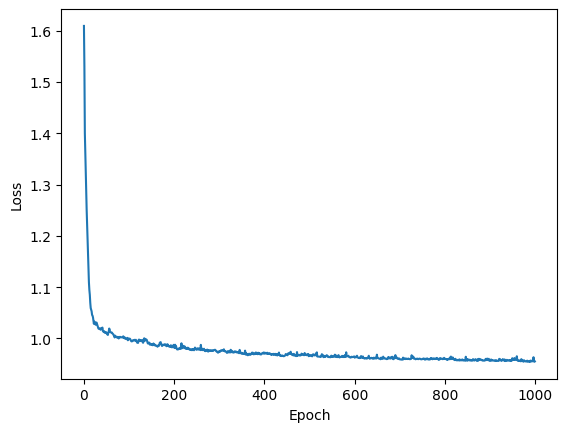

Test accuracy: 463.5389247311828
Accuracy: 0.47139784946236557
Precision: 0.5214814662119712
Recall: 0.4714708803698066
F1-score: 0.48497489550567685


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.49      0.59       495
           1       0.46      0.49      0.47       472
           2       0.34      0.46      0.39       449
           3       0.30      0.37      0.33       463
           4       0.77      0.54      0.63       446

    accuracy                           0.47      2325
   macro avg       0.52      0.47      0.48      2325
weighted avg       0.52      0.47      0.49      2325

                    0           1           2           3           4  \
precision    0.739394    0.455969    0.339869    0.304659    0.767516   
recall       0.492929    0.493644    0.463252    0.367171    0.540359   
f1-score     0.591515    0.474059    0.392083    0.333007    0.634211   
support    495.000000  472.000000  449.00000

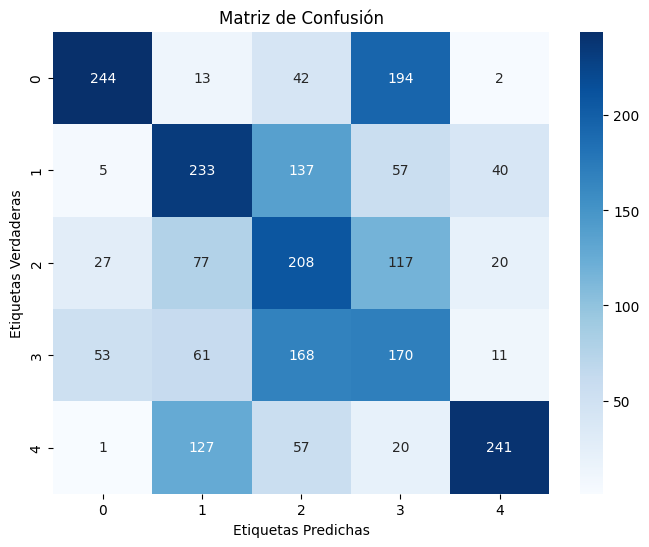

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_1000_0.0001_0.2/resultados_1000_0.0001_0.2.json
Procesando red con 1000 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas:   0%|                                                              | 1/1000 [00:02<45:27,  2.73s/it]

1.6096042044022505


Procesando epocas:   0%|                                                              | 2/1000 [00:05<45:17,  2.72s/it]

1.6096462411039016


Procesando epocas:   0%|▏                                                             | 3/1000 [00:08<45:15,  2.72s/it]

1.6095603234627667


Procesando epocas:   0%|▏                                                             | 4/1000 [00:10<45:18,  2.73s/it]

1.6094689474386328


Procesando epocas:   0%|▎                                                             | 5/1000 [00:13<45:15,  2.73s/it]

1.6094535448971916


Procesando epocas:   1%|▎                                                             | 6/1000 [00:16<45:15,  2.73s/it]

1.6091152871356291


Procesando epocas:   1%|▍                                                             | 7/1000 [00:19<44:59,  2.72s/it]

1.608173003617455


Procesando epocas:   1%|▍                                                             | 8/1000 [00:21<44:50,  2.71s/it]

1.6050923838334925


Procesando epocas:   1%|▌                                                             | 9/1000 [00:24<44:46,  2.71s/it]

1.5980759578592636


Procesando epocas:   1%|▌                                                            | 10/1000 [00:27<44:41,  2.71s/it]

1.575025517800275


Procesando epocas:   1%|▋                                                            | 11/1000 [00:29<44:36,  2.71s/it]

1.51948624568827


Procesando epocas:   1%|▋                                                            | 12/1000 [00:32<44:28,  2.70s/it]

1.47281894753961


Procesando epocas:   1%|▊                                                            | 13/1000 [00:35<44:30,  2.71s/it]

1.4467744161100948


Procesando epocas:   1%|▊                                                            | 14/1000 [00:38<44:31,  2.71s/it]

1.4247651906574474


Procesando epocas:   2%|▉                                                            | 15/1000 [00:40<44:38,  2.72s/it]

1.4074444427209742


Procesando epocas:   2%|▉                                                            | 16/1000 [00:43<44:33,  2.72s/it]

1.3833362060434677


Procesando epocas:   2%|█                                                            | 17/1000 [00:46<44:27,  2.71s/it]

1.3688973188400269


Procesando epocas:   2%|█                                                            | 18/1000 [00:48<44:20,  2.71s/it]

1.3511637785855461


Procesando epocas:   2%|█▏                                                           | 19/1000 [00:51<44:14,  2.71s/it]

1.3351608802290524


Procesando epocas:   2%|█▏                                                           | 20/1000 [00:54<44:11,  2.71s/it]

1.3208665413015028


Procesando epocas:   2%|█▎                                                           | 21/1000 [00:56<44:05,  2.70s/it]

1.3074101644403795


Procesando epocas:   2%|█▎                                                           | 22/1000 [00:59<43:59,  2.70s/it]

1.2980468806098489


Procesando epocas:   2%|█▍                                                           | 23/1000 [01:02<43:59,  2.70s/it]

1.2855795285281013


Procesando epocas:   2%|█▍                                                           | 24/1000 [01:05<43:52,  2.70s/it]

1.2799147886388442


Procesando epocas:   2%|█▌                                                           | 25/1000 [01:07<43:54,  2.70s/it]

1.2669999627506032


Procesando epocas:   3%|█▌                                                           | 26/1000 [01:10<43:54,  2.71s/it]

1.2531071733025942


Procesando epocas:   3%|█▋                                                           | 27/1000 [01:13<43:52,  2.71s/it]

1.2446895522229813


Procesando epocas:   3%|█▋                                                           | 28/1000 [01:15<43:46,  2.70s/it]

1.2399096474928015


Procesando epocas:   3%|█▊                                                           | 29/1000 [01:18<43:45,  2.70s/it]

1.2308868155759924


Procesando epocas:   3%|█▊                                                           | 30/1000 [01:21<43:45,  2.71s/it]

1.2235786087372724


Procesando epocas:   3%|█▉                                                           | 31/1000 [01:24<43:49,  2.71s/it]

1.2179578795152552


Procesando epocas:   3%|█▉                                                           | 32/1000 [01:26<43:48,  2.72s/it]

1.2120061586884892


Procesando epocas:   3%|██                                                           | 33/1000 [01:29<43:41,  2.71s/it]

1.206486129760742


Procesando epocas:   3%|██                                                           | 34/1000 [01:32<43:34,  2.71s/it]

1.2012210775824155


Procesando epocas:   4%|██▏                                                          | 35/1000 [01:34<43:30,  2.70s/it]

1.1964703503776999


Procesando epocas:   4%|██▏                                                          | 36/1000 [01:37<43:31,  2.71s/it]

1.1936471223831178


Procesando epocas:   4%|██▎                                                          | 37/1000 [01:40<43:27,  2.71s/it]

1.187402923668132


Procesando epocas:   4%|██▎                                                          | 38/1000 [01:42<43:24,  2.71s/it]

1.1799207042245303


Procesando epocas:   4%|██▍                                                          | 39/1000 [01:45<43:22,  2.71s/it]

1.1750073453959298


Procesando epocas:   4%|██▍                                                          | 40/1000 [01:48<43:22,  2.71s/it]

1.1712195165017072


Procesando epocas:   4%|██▌                                                          | 41/1000 [01:51<43:34,  2.73s/it]

1.1632739989196552


Procesando epocas:   4%|██▌                                                          | 42/1000 [01:53<43:31,  2.73s/it]

1.163116692094242


Procesando epocas:   4%|██▌                                                          | 43/1000 [01:56<43:33,  2.73s/it]

1.156960903195774


Procesando epocas:   4%|██▋                                                          | 44/1000 [01:59<43:34,  2.73s/it]

1.1510978306041044


Procesando epocas:   4%|██▋                                                          | 45/1000 [02:02<43:27,  2.73s/it]

1.1426667234476875


Procesando epocas:   5%|██▊                                                          | 46/1000 [02:04<43:40,  2.75s/it]

1.1419932716033039


Procesando epocas:   5%|██▊                                                          | 47/1000 [02:07<43:42,  2.75s/it]

1.138134278269375


Procesando epocas:   5%|██▉                                                          | 48/1000 [02:10<43:43,  2.76s/it]

1.1266748147852281


Procesando epocas:   5%|██▉                                                          | 49/1000 [02:13<43:38,  2.75s/it]

1.1217363799319549


Procesando epocas:   5%|███                                                          | 50/1000 [02:15<43:31,  2.75s/it]

1.1165554621640374


Procesando epocas:   5%|███                                                          | 51/1000 [02:18<43:33,  2.75s/it]

1.112885073002647


Procesando epocas:   5%|███▏                                                         | 52/1000 [02:21<43:26,  2.75s/it]

1.112229619657292


Procesando epocas:   5%|███▏                                                         | 53/1000 [02:24<43:31,  2.76s/it]

1.1064308162997751


Procesando epocas:   5%|███▎                                                         | 54/1000 [02:26<43:31,  2.76s/it]

1.1023228739990907


Procesando epocas:   6%|███▎                                                         | 55/1000 [02:29<43:23,  2.76s/it]

1.0943275199216955


Procesando epocas:   6%|███▍                                                         | 56/1000 [02:32<43:21,  2.76s/it]

1.0907286970054402


Procesando epocas:   6%|███▍                                                         | 57/1000 [02:35<43:16,  2.75s/it]

1.086590637880213


Procesando epocas:   6%|███▌                                                         | 58/1000 [02:37<43:21,  2.76s/it]

1.086687695278841


Procesando epocas:   6%|███▌                                                         | 59/1000 [02:40<43:14,  2.76s/it]

1.079063066664864


Procesando epocas:   6%|███▋                                                         | 60/1000 [02:43<43:17,  2.76s/it]

1.0771070073632634


Procesando epocas:   6%|███▋                                                         | 61/1000 [02:46<43:12,  2.76s/it]

1.0709951954729418


Procesando epocas:   6%|███▊                                                         | 62/1000 [02:48<43:06,  2.76s/it]

1.0682826410321629


Procesando epocas:   6%|███▊                                                         | 63/1000 [02:51<43:06,  2.76s/it]

1.0643080104799831


Procesando epocas:   6%|███▉                                                         | 64/1000 [02:54<43:03,  2.76s/it]

1.0554815008359797


Procesando epocas:   6%|███▉                                                         | 65/1000 [02:57<42:59,  2.76s/it]

1.0572924038943123


Procesando epocas:   7%|████                                                         | 66/1000 [03:00<42:54,  2.76s/it]

1.0546074695446912


Procesando epocas:   7%|████                                                         | 67/1000 [03:02<42:57,  2.76s/it]

1.0504316315931432


Procesando epocas:   7%|████▏                                                        | 68/1000 [03:05<42:55,  2.76s/it]

1.0522346237126519


Procesando epocas:   7%|████▏                                                        | 69/1000 [03:08<42:53,  2.76s/it]

1.0443278603694017


Procesando epocas:   7%|████▎                                                        | 70/1000 [03:11<42:49,  2.76s/it]

1.0414877193815568


Procesando epocas:   7%|████▎                                                        | 71/1000 [03:13<42:36,  2.75s/it]

1.0382583663744085


Procesando epocas:   7%|████▍                                                        | 72/1000 [03:16<42:25,  2.74s/it]

1.0353807936696444


Procesando epocas:   7%|████▍                                                        | 73/1000 [03:19<42:22,  2.74s/it]

1.036625804270015


Procesando epocas:   7%|████▌                                                        | 74/1000 [03:22<42:11,  2.73s/it]

1.0317879711880404


Procesando epocas:   8%|████▌                                                        | 75/1000 [03:24<42:06,  2.73s/it]

1.0337057751767775


Procesando epocas:   8%|████▋                                                        | 76/1000 [03:27<42:09,  2.74s/it]

1.024544050763635


Procesando epocas:   8%|████▋                                                        | 77/1000 [03:30<42:07,  2.74s/it]

1.0249034404754638


Procesando epocas:   8%|████▊                                                        | 78/1000 [03:32<42:07,  2.74s/it]

1.0239351107793695


Procesando epocas:   8%|████▊                                                        | 79/1000 [03:35<42:07,  2.74s/it]

1.0241101471816791


Procesando epocas:   8%|████▉                                                        | 80/1000 [03:38<42:06,  2.75s/it]

1.0194874917759615


Procesando epocas:   8%|████▉                                                        | 81/1000 [03:41<41:59,  2.74s/it]

1.022150911653743


Procesando epocas:   8%|█████                                                        | 82/1000 [03:43<41:57,  2.74s/it]

1.0189894984750187


Procesando epocas:   8%|█████                                                        | 83/1000 [03:46<41:55,  2.74s/it]

1.0185362104107352


Procesando epocas:   8%|█████                                                        | 84/1000 [03:49<41:44,  2.73s/it]

1.0151285427458145


Procesando epocas:   8%|█████▏                                                       | 85/1000 [03:52<41:42,  2.74s/it]

1.0157808345906876


Procesando epocas:   9%|█████▏                                                       | 86/1000 [03:54<41:32,  2.73s/it]

1.0146333284237805


Procesando epocas:   9%|█████▎                                                       | 87/1000 [03:57<41:28,  2.73s/it]

1.0136069371419794


Procesando epocas:   9%|█████▎                                                       | 88/1000 [04:00<41:20,  2.72s/it]

1.0107442245763891


Procesando epocas:   9%|█████▍                                                       | 89/1000 [04:03<41:25,  2.73s/it]

1.0108143690754385


Procesando epocas:   9%|█████▍                                                       | 90/1000 [04:05<41:22,  2.73s/it]

1.0078699487097122


Procesando epocas:   9%|█████▌                                                       | 91/1000 [04:08<41:19,  2.73s/it]

1.0089174270629884


Procesando epocas:   9%|█████▌                                                       | 92/1000 [04:11<41:18,  2.73s/it]

1.0085737459799822


Procesando epocas:   9%|█████▋                                                       | 93/1000 [04:13<41:13,  2.73s/it]

1.0047424954526565


Procesando epocas:   9%|█████▋                                                       | 94/1000 [04:16<41:06,  2.72s/it]

1.00409955627778


Procesando epocas:  10%|█████▊                                                       | 95/1000 [04:19<40:59,  2.72s/it]

1.0038661336197572


Procesando epocas:  10%|█████▊                                                       | 96/1000 [04:22<40:59,  2.72s/it]

1.002350981095258


Procesando epocas:  10%|█████▉                                                       | 97/1000 [04:24<40:57,  2.72s/it]

1.0012398358653574


Procesando epocas:  10%|█████▉                                                       | 98/1000 [04:27<40:57,  2.72s/it]

1.0002431259435767


Procesando epocas:  10%|██████                                                       | 99/1000 [04:30<40:52,  2.72s/it]

0.9990865458460415


Procesando epocas:  10%|██████                                                      | 100/1000 [04:32<40:44,  2.72s/it]

1.0019031682435204


Procesando epocas:  10%|██████                                                      | 101/1000 [04:35<40:44,  2.72s/it]

1.0001689125509823


Procesando epocas:  10%|██████                                                      | 102/1000 [04:38<40:42,  2.72s/it]

0.9995072207030128


Procesando epocas:  10%|██████▏                                                     | 103/1000 [04:41<40:37,  2.72s/it]

0.9988330823533675


Procesando epocas:  10%|██████▏                                                     | 104/1000 [04:43<40:34,  2.72s/it]

0.9973565203302047


Procesando epocas:  10%|██████▎                                                     | 105/1000 [04:46<40:41,  2.73s/it]

0.9970837231944589


Procesando epocas:  11%|██████▎                                                     | 106/1000 [04:49<40:31,  2.72s/it]

0.9971823471433976


Procesando epocas:  11%|██████▍                                                     | 107/1000 [04:51<40:25,  2.72s/it]

0.9951521599993987


Procesando epocas:  11%|██████▍                                                     | 108/1000 [04:54<40:22,  2.72s/it]

0.9936747579013601


Procesando epocas:  11%|██████▌                                                     | 109/1000 [04:57<38:53,  2.62s/it]

0.9931402367704055


Procesando epocas:  11%|██████▌                                                     | 110/1000 [04:59<38:49,  2.62s/it]

0.9965520224150489


Procesando epocas:  11%|██████▋                                                     | 111/1000 [05:02<39:07,  2.64s/it]

0.9935222134870642


Procesando epocas:  11%|██████▋                                                     | 112/1000 [05:05<39:20,  2.66s/it]

0.9941259808400098


Procesando epocas:  11%|██████▊                                                     | 113/1000 [05:07<39:31,  2.67s/it]

0.9912629909375135


Procesando epocas:  11%|██████▊                                                     | 114/1000 [05:10<39:39,  2.69s/it]

0.9919829182765063


Procesando epocas:  12%|██████▉                                                     | 115/1000 [05:13<39:36,  2.69s/it]

0.9919836489593281


Procesando epocas:  12%|██████▉                                                     | 116/1000 [05:15<39:41,  2.69s/it]

0.9920308579416836


Procesando epocas:  12%|███████                                                     | 117/1000 [05:18<39:40,  2.70s/it]

0.9919723198694341


Procesando epocas:  12%|███████                                                     | 118/1000 [05:21<39:36,  2.69s/it]

0.9923365263377919


Procesando epocas:  12%|███████▏                                                    | 119/1000 [05:24<39:30,  2.69s/it]

0.9915170872912688


Procesando epocas:  12%|███████▏                                                    | 120/1000 [05:26<39:31,  2.69s/it]

0.990400249116561


Procesando epocas:  12%|███████▎                                                    | 121/1000 [05:29<39:30,  2.70s/it]

0.9898664043230169


Procesando epocas:  12%|███████▎                                                    | 122/1000 [05:32<39:23,  2.69s/it]

0.9912839391652275


Procesando epocas:  12%|███████▍                                                    | 123/1000 [05:34<39:26,  2.70s/it]

0.9893354748978335


Procesando epocas:  12%|███████▍                                                    | 124/1000 [05:37<39:30,  2.71s/it]

0.9905306465485517


Procesando epocas:  12%|███████▌                                                    | 125/1000 [05:40<39:38,  2.72s/it]

0.989172588376438


Procesando epocas:  13%|███████▌                                                    | 126/1000 [05:43<39:37,  2.72s/it]

0.9884282420663273


Procesando epocas:  13%|███████▌                                                    | 127/1000 [05:45<39:36,  2.72s/it]

0.9889238946578082


Procesando epocas:  13%|███████▋                                                    | 128/1000 [05:48<39:32,  2.72s/it]

0.9910211380790261


Procesando epocas:  13%|███████▋                                                    | 129/1000 [05:51<39:25,  2.72s/it]

0.9882529595318963


Procesando epocas:  13%|███████▊                                                    | 130/1000 [05:53<39:19,  2.71s/it]

0.9875119500300463


Procesando epocas:  13%|███████▊                                                    | 131/1000 [05:56<39:13,  2.71s/it]

0.9874501435195698


Procesando epocas:  13%|███████▉                                                    | 132/1000 [05:59<39:10,  2.71s/it]

0.9865958336521597


Procesando epocas:  13%|███████▉                                                    | 133/1000 [06:01<39:07,  2.71s/it]

0.9887087050606223


Procesando epocas:  13%|████████                                                    | 134/1000 [06:04<39:00,  2.70s/it]

0.9864103124422186


Procesando epocas:  14%|████████                                                    | 135/1000 [06:07<38:52,  2.70s/it]

0.9877842766397139


Procesando epocas:  14%|████████▏                                                   | 136/1000 [06:10<38:47,  2.69s/it]

0.9884236349779016


Procesando epocas:  14%|████████▏                                                   | 137/1000 [06:12<38:50,  2.70s/it]

0.9851160186178544


Procesando epocas:  14%|████████▎                                                   | 138/1000 [06:15<38:46,  2.70s/it]

0.9864918351173401


Procesando epocas:  14%|████████▎                                                   | 139/1000 [06:18<38:37,  2.69s/it]

0.9856064382721396


Procesando epocas:  14%|████████▍                                                   | 140/1000 [06:20<38:35,  2.69s/it]

0.9863238909665276


Procesando epocas:  14%|████████▍                                                   | 141/1000 [06:23<38:38,  2.70s/it]

0.9849265238818


Procesando epocas:  14%|████████▌                                                   | 142/1000 [06:26<38:37,  2.70s/it]

0.9858739884460673


Procesando epocas:  14%|████████▌                                                   | 143/1000 [06:28<38:38,  2.71s/it]

0.9843118800836451


Procesando epocas:  14%|████████▋                                                   | 144/1000 [06:31<38:35,  2.71s/it]

0.984186882832471


Procesando epocas:  14%|████████▋                                                   | 145/1000 [06:34<38:31,  2.70s/it]

0.9844103967442231


Procesando epocas:  15%|████████▊                                                   | 146/1000 [06:37<38:28,  2.70s/it]

0.984337357563131


Procesando epocas:  15%|████████▊                                                   | 147/1000 [06:39<38:22,  2.70s/it]

0.9846700703396517


Procesando epocas:  15%|████████▉                                                   | 148/1000 [06:42<38:23,  2.70s/it]

0.985328882932663


Procesando epocas:  15%|████████▉                                                   | 149/1000 [06:45<38:16,  2.70s/it]

0.9846810887841617


Procesando epocas:  15%|█████████                                                   | 150/1000 [06:47<38:09,  2.69s/it]

0.9859318905016955


Procesando epocas:  15%|█████████                                                   | 151/1000 [06:50<38:07,  2.69s/it]

0.9832566471660839


Procesando epocas:  15%|█████████                                                   | 152/1000 [06:53<38:02,  2.69s/it]

0.9825653742341435


Procesando epocas:  15%|█████████▏                                                  | 153/1000 [06:55<38:09,  2.70s/it]

0.9826644034946665


Procesando epocas:  15%|█████████▏                                                  | 154/1000 [06:58<38:03,  2.70s/it]

0.9839599893373602


Procesando epocas:  16%|█████████▎                                                  | 155/1000 [07:01<37:59,  2.70s/it]

0.9832456918323741


Procesando epocas:  16%|█████████▎                                                  | 156/1000 [07:04<37:59,  2.70s/it]

0.9834865009083468


Procesando epocas:  16%|█████████▍                                                  | 157/1000 [07:06<37:52,  2.70s/it]

0.9826440460541669


Procesando epocas:  16%|█████████▍                                                  | 158/1000 [07:09<37:50,  2.70s/it]

0.9826491916880888


Procesando epocas:  16%|█████████▌                                                  | 159/1000 [07:12<37:48,  2.70s/it]

0.9821294216548695


Procesando epocas:  16%|█████████▌                                                  | 160/1000 [07:14<37:44,  2.70s/it]

0.9824063879602095


Procesando epocas:  16%|█████████▋                                                  | 161/1000 [07:17<37:29,  2.68s/it]

0.9817827484186958


Procesando epocas:  16%|█████████▋                                                  | 162/1000 [07:20<37:30,  2.69s/it]

0.9817474894663867


Procesando epocas:  16%|█████████▊                                                  | 163/1000 [07:22<37:32,  2.69s/it]

0.9826106737641728


Procesando epocas:  16%|█████████▊                                                  | 164/1000 [07:25<37:48,  2.71s/it]

0.982253668939366


Procesando epocas:  16%|█████████▉                                                  | 165/1000 [07:28<37:58,  2.73s/it]

0.9815861547694487


Procesando epocas:  17%|█████████▉                                                  | 166/1000 [07:31<37:54,  2.73s/it]

0.9819172561168671


Procesando epocas:  17%|██████████                                                  | 167/1000 [07:33<37:48,  2.72s/it]

0.9818597285186543


Procesando epocas:  17%|██████████                                                  | 168/1000 [07:36<37:47,  2.73s/it]

0.9820319775272818


Procesando epocas:  17%|██████████▏                                                 | 169/1000 [07:39<37:56,  2.74s/it]

0.9806499225251815


Procesando epocas:  17%|██████████▏                                                 | 170/1000 [07:42<37:58,  2.75s/it]

0.9820732274476219


Procesando epocas:  17%|██████████▎                                                 | 171/1000 [07:44<38:05,  2.76s/it]

0.9806716561317443


Procesando epocas:  17%|██████████▎                                                 | 172/1000 [07:47<37:49,  2.74s/it]

0.9798606451819925


Procesando epocas:  17%|██████████▍                                                 | 173/1000 [07:50<37:44,  2.74s/it]

0.9808475038584541


Procesando epocas:  17%|██████████▍                                                 | 174/1000 [07:53<37:43,  2.74s/it]

0.9804709925371058


Procesando epocas:  18%|██████████▌                                                 | 175/1000 [07:55<37:37,  2.74s/it]

0.9801257547210245


Procesando epocas:  18%|██████████▌                                                 | 176/1000 [07:58<37:27,  2.73s/it]

0.9795452545670902


Procesando epocas:  18%|██████████▌                                                 | 177/1000 [08:01<37:32,  2.74s/it]

0.979885297312456


Procesando epocas:  18%|██████████▋                                                 | 178/1000 [08:04<37:36,  2.74s/it]

0.9799807597609127


Procesando epocas:  18%|██████████▋                                                 | 179/1000 [08:06<37:32,  2.74s/it]

0.9796136894646813


Procesando epocas:  18%|██████████▊                                                 | 180/1000 [08:09<37:33,  2.75s/it]

0.978998988165575


Procesando epocas:  18%|██████████▊                                                 | 181/1000 [08:12<37:30,  2.75s/it]

0.9791114768561195


Procesando epocas:  18%|██████████▉                                                 | 182/1000 [08:14<37:28,  2.75s/it]

0.9793540179729462


Procesando epocas:  18%|██████████▉                                                 | 183/1000 [08:17<37:23,  2.75s/it]

0.9789874227607951


Procesando epocas:  18%|███████████                                                 | 184/1000 [08:20<37:20,  2.75s/it]

0.9789076380869921


Procesando epocas:  18%|███████████                                                 | 185/1000 [08:23<37:19,  2.75s/it]

0.9792639045154348


Procesando epocas:  19%|███████████▏                                                | 186/1000 [08:25<37:15,  2.75s/it]

0.9788036819766549


Procesando epocas:  19%|███████████▏                                                | 187/1000 [08:28<37:07,  2.74s/it]

0.9786542685592876


Procesando epocas:  19%|███████████▎                                                | 188/1000 [08:31<37:02,  2.74s/it]

0.9789138187380398


Procesando epocas:  19%|███████████▎                                                | 189/1000 [08:34<37:00,  2.74s/it]

0.9788838926483603


Procesando epocas:  19%|███████████▍                                                | 190/1000 [08:36<36:55,  2.74s/it]

0.9791947932804332


Procesando epocas:  19%|███████████▍                                                | 191/1000 [08:39<36:51,  2.73s/it]

0.9773711902253768


Procesando epocas:  19%|███████████▌                                                | 192/1000 [08:42<36:44,  2.73s/it]

0.97870593772215


Procesando epocas:  19%|███████████▌                                                | 193/1000 [08:45<36:38,  2.72s/it]

0.9782206447685466


Procesando epocas:  19%|███████████▋                                                | 194/1000 [08:47<36:34,  2.72s/it]

0.9790695404305177


Procesando epocas:  20%|███████████▋                                                | 195/1000 [08:50<36:34,  2.73s/it]

0.978279020505793


Procesando epocas:  20%|███████████▊                                                | 196/1000 [08:53<36:27,  2.72s/it]

0.9768622472005732


Procesando epocas:  20%|███████████▊                                                | 197/1000 [08:55<36:20,  2.71s/it]

0.9789232012103586


Procesando epocas:  20%|███████████▉                                                | 198/1000 [08:58<36:16,  2.71s/it]

0.9779313518720515


Procesando epocas:  20%|███████████▉                                                | 199/1000 [09:01<36:10,  2.71s/it]

0.9775674711255466


Procesando epocas:  20%|████████████                                                | 200/1000 [09:04<36:08,  2.71s/it]

0.9781917372170617


Procesando epocas:  20%|████████████                                                | 201/1000 [09:06<36:03,  2.71s/it]

0.9784625169108896


Procesando epocas:  20%|████████████                                                | 202/1000 [09:09<36:03,  2.71s/it]

0.976417853902368


Procesando epocas:  20%|████████████▏                                               | 203/1000 [09:12<36:02,  2.71s/it]

0.9778876585118911


Procesando epocas:  20%|████████████▏                                               | 204/1000 [09:14<36:03,  2.72s/it]

0.9773146268199472


Procesando epocas:  20%|████████████▎                                               | 205/1000 [09:17<35:53,  2.71s/it]

0.9779308645164265


Procesando epocas:  21%|████████████▎                                               | 206/1000 [09:20<35:49,  2.71s/it]

0.9780209053965175


Procesando epocas:  21%|████████████▍                                               | 207/1000 [09:23<35:46,  2.71s/it]

0.9776209484128391


Procesando epocas:  21%|████████████▍                                               | 208/1000 [09:25<35:43,  2.71s/it]

0.9790121408069835


Procesando epocas:  21%|████████████▌                                               | 209/1000 [09:28<35:47,  2.72s/it]

0.9770944111487445


Procesando epocas:  21%|████████████▌                                               | 210/1000 [09:31<35:43,  2.71s/it]

0.9766642454792471


Procesando epocas:  21%|████████████▋                                               | 211/1000 [09:33<35:44,  2.72s/it]

0.977693089316873


Procesando epocas:  21%|████████████▋                                               | 212/1000 [09:36<35:38,  2.71s/it]

0.9785070072202121


Procesando epocas:  21%|████████████▊                                               | 213/1000 [09:39<35:33,  2.71s/it]

0.9771600677686579


Procesando epocas:  21%|████████████▊                                               | 214/1000 [09:42<35:32,  2.71s/it]

0.9762927732046913


Procesando epocas:  22%|████████████▉                                               | 215/1000 [09:44<35:33,  2.72s/it]

0.9781262103249045


Procesando epocas:  22%|████████████▉                                               | 216/1000 [09:47<35:31,  2.72s/it]

0.9768123938756831


Procesando epocas:  22%|█████████████                                               | 217/1000 [09:50<35:22,  2.71s/it]

0.977588469841901


Procesando epocas:  22%|█████████████                                               | 218/1000 [09:52<35:22,  2.71s/it]

0.9779165436239804


Procesando epocas:  22%|█████████████▏                                              | 219/1000 [09:55<35:16,  2.71s/it]

0.9775676373173209


Procesando epocas:  22%|█████████████▏                                              | 220/1000 [09:58<35:09,  2.70s/it]

0.9769293981439927


Procesando epocas:  22%|█████████████▎                                              | 221/1000 [10:00<35:10,  2.71s/it]

0.9777358360150281


Procesando epocas:  22%|█████████████▎                                              | 222/1000 [10:03<35:10,  2.71s/it]

0.9766518866314607


Procesando epocas:  22%|█████████████▍                                              | 223/1000 [10:06<35:09,  2.72s/it]

0.9761508577010211


Procesando epocas:  22%|█████████████▍                                              | 224/1000 [10:09<35:03,  2.71s/it]

0.9766438287847182


Procesando epocas:  22%|█████████████▌                                              | 225/1000 [10:11<34:57,  2.71s/it]

0.9773403265896965


Procesando epocas:  23%|█████████████▌                                              | 226/1000 [10:14<34:57,  2.71s/it]

0.9763276447268093


Procesando epocas:  23%|█████████████▌                                              | 227/1000 [10:17<34:52,  2.71s/it]

0.9773302635725807


Procesando epocas:  23%|█████████████▋                                              | 228/1000 [10:19<34:50,  2.71s/it]

0.9760280076195212


Procesando epocas:  23%|█████████████▋                                              | 229/1000 [10:22<34:42,  2.70s/it]

0.9764737511382383


Procesando epocas:  23%|█████████████▊                                              | 230/1000 [10:25<34:46,  2.71s/it]

0.9756137577926411


Procesando epocas:  23%|█████████████▊                                              | 231/1000 [10:28<34:42,  2.71s/it]

0.9760424038943123


Procesando epocas:  23%|█████████████▉                                              | 232/1000 [10:30<34:38,  2.71s/it]

0.975377655730528


Procesando epocas:  23%|█████████████▉                                              | 233/1000 [10:33<34:40,  2.71s/it]

0.9764592907008003


Procesando epocas:  23%|██████████████                                              | 234/1000 [10:36<34:32,  2.71s/it]

0.9752355267019833


Procesando epocas:  24%|██████████████                                              | 235/1000 [10:38<34:27,  2.70s/it]

0.9754488506737877


Procesando epocas:  24%|██████████████▏                                             | 236/1000 [10:41<34:32,  2.71s/it]

0.976154186445124


Procesando epocas:  24%|██████████████▏                                             | 237/1000 [10:44<34:30,  2.71s/it]

0.9751577910254984


Procesando epocas:  24%|██████████████▎                                             | 238/1000 [10:47<34:26,  2.71s/it]

0.9770731182659373


Procesando epocas:  24%|██████████████▎                                             | 239/1000 [10:49<34:21,  2.71s/it]

0.9760766204665688


Procesando epocas:  24%|██████████████▍                                             | 240/1000 [10:52<34:08,  2.70s/it]

0.9758541219374712


Procesando epocas:  24%|██████████████▍                                             | 241/1000 [10:55<34:02,  2.69s/it]

0.975921984279857


Procesando epocas:  24%|██████████████▌                                             | 242/1000 [10:57<34:02,  2.69s/it]

0.9754339176065782


Procesando epocas:  24%|██████████████▌                                             | 243/1000 [11:00<34:02,  2.70s/it]

0.9758781930979561


Procesando epocas:  24%|██████████████▋                                             | 244/1000 [11:03<33:59,  2.70s/it]

0.9749012109111337


Procesando epocas:  24%|██████████████▋                                             | 245/1000 [11:05<33:53,  2.69s/it]

0.9757988796514623


Procesando epocas:  25%|██████████████▊                                             | 246/1000 [11:08<33:50,  2.69s/it]

0.9741449212326723


Procesando epocas:  25%|██████████████▊                                             | 247/1000 [11:11<33:48,  2.69s/it]

0.9758324700243333


Procesando epocas:  25%|██████████████▉                                             | 248/1000 [11:13<33:41,  2.69s/it]

0.9749241962152368


Procesando epocas:  25%|██████████████▉                                             | 249/1000 [11:16<33:42,  2.69s/it]

0.9758340909200556


Procesando epocas:  25%|███████████████                                             | 250/1000 [11:19<33:43,  2.70s/it]

0.9760852108983432


Procesando epocas:  25%|███████████████                                             | 251/1000 [11:22<33:38,  2.70s/it]

0.9746553021318772


Procesando epocas:  25%|███████████████                                             | 252/1000 [11:24<33:34,  2.69s/it]

0.9749761854901033


Procesando epocas:  25%|███████████████▏                                            | 253/1000 [11:27<33:31,  2.69s/it]

0.9740564163993387


Procesando epocas:  25%|███████████████▏                                            | 254/1000 [11:30<33:30,  2.70s/it]

0.9760267913341523


Procesando epocas:  26%|███████████████▎                                            | 255/1000 [11:32<33:29,  2.70s/it]

0.97513868282823


Procesando epocas:  26%|███████████████▎                                            | 256/1000 [11:35<33:24,  2.69s/it]

0.9750906695337856


Procesando epocas:  26%|███████████████▍                                            | 257/1000 [11:38<33:20,  2.69s/it]

0.9743501442320207


Procesando epocas:  26%|███████████████▍                                            | 258/1000 [11:40<33:21,  2.70s/it]

0.975372499928755


Procesando epocas:  26%|███████████████▌                                            | 259/1000 [11:43<33:20,  2.70s/it]

0.9749733248177697


Procesando epocas:  26%|███████████████▌                                            | 260/1000 [11:46<33:14,  2.70s/it]

0.9741634155020994


Procesando epocas:  26%|███████████████▋                                            | 261/1000 [11:49<33:13,  2.70s/it]

0.9740663321579204


Procesando epocas:  26%|███████████████▋                                            | 262/1000 [11:51<33:26,  2.72s/it]

0.974393797271392


Procesando epocas:  26%|███████████████▊                                            | 263/1000 [11:54<33:32,  2.73s/it]

0.9749787018579595


Procesando epocas:  26%|███████████████▊                                            | 264/1000 [11:57<33:31,  2.73s/it]

0.9745500722352196


Procesando epocas:  26%|███████████████▉                                            | 265/1000 [12:00<33:29,  2.73s/it]

0.9737868743784287


Procesando epocas:  27%|███████████████▉                                            | 266/1000 [12:02<33:24,  2.73s/it]

0.9748082045246573


Procesando epocas:  27%|████████████████                                            | 267/1000 [12:05<33:19,  2.73s/it]

0.9743987770641551


Procesando epocas:  27%|████████████████                                            | 268/1000 [12:08<33:20,  2.73s/it]

0.974286440190147


Procesando epocas:  27%|████████████████▏                                           | 269/1000 [12:10<33:14,  2.73s/it]

0.9743369751116808


Procesando epocas:  27%|████████████████▏                                           | 270/1000 [12:13<33:13,  2.73s/it]

0.9741579301217023


Procesando epocas:  27%|████████████████▎                                           | 271/1000 [12:16<33:09,  2.73s/it]

0.9742082581800573


Procesando epocas:  27%|████████████████▎                                           | 272/1000 [12:19<33:03,  2.72s/it]

0.9746449772049399


Procesando epocas:  27%|████████████████▍                                           | 273/1000 [12:21<32:58,  2.72s/it]

0.9734881986589993


Procesando epocas:  27%|████████████████▍                                           | 274/1000 [12:24<32:52,  2.72s/it]

0.9742280732182895


Procesando epocas:  28%|████████████████▌                                           | 275/1000 [12:27<32:49,  2.72s/it]

0.9744735675699571


Procesando epocas:  28%|████████████████▌                                           | 276/1000 [12:29<32:41,  2.71s/it]

0.9736931604497573


Procesando epocas:  28%|████████████████▌                                           | 277/1000 [12:32<32:37,  2.71s/it]

0.9735463342245887


Procesando epocas:  28%|████████████████▋                                           | 278/1000 [12:35<32:35,  2.71s/it]

0.9741626918315888


Procesando epocas:  28%|████████████████▋                                           | 279/1000 [12:38<32:30,  2.71s/it]

0.9745357965721804


Procesando epocas:  28%|████████████████▊                                           | 280/1000 [12:40<32:23,  2.70s/it]

0.9735586958772996


Procesando epocas:  28%|████████████████▊                                           | 281/1000 [12:43<32:25,  2.71s/it]

0.9745878314270693


Procesando epocas:  28%|████████████████▉                                           | 282/1000 [12:46<32:24,  2.71s/it]

0.9736798433696523


Procesando epocas:  28%|████████████████▉                                           | 283/1000 [12:48<32:22,  2.71s/it]

0.9739093370297376


Procesando epocas:  28%|█████████████████                                           | 284/1000 [12:51<32:18,  2.71s/it]

0.9728072057752049


Procesando epocas:  28%|█████████████████                                           | 285/1000 [12:54<32:20,  2.71s/it]

0.9740656505612766


Procesando epocas:  29%|█████████████████▏                                          | 286/1000 [12:57<32:26,  2.73s/it]

0.9743907977552975


Procesando epocas:  29%|█████████████████▏                                          | 287/1000 [12:59<32:37,  2.74s/it]

0.9740025306449217


Procesando epocas:  29%|█████████████████▎                                          | 288/1000 [13:02<32:37,  2.75s/it]

0.9732068924342885


Procesando epocas:  29%|█████████████████▎                                          | 289/1000 [13:05<32:34,  2.75s/it]

0.9737313175902648


Procesando epocas:  29%|█████████████████▍                                          | 290/1000 [13:08<32:34,  2.75s/it]

0.9737990358296562


Procesando epocas:  29%|█████████████████▍                                          | 291/1000 [13:10<32:34,  2.76s/it]

0.9731182441991918


Procesando epocas:  29%|█████████████████▌                                          | 292/1000 [13:13<32:32,  2.76s/it]

0.9730886455844431


Procesando epocas:  29%|█████████████████▌                                          | 293/1000 [13:16<32:32,  2.76s/it]

0.9747304113472209


Procesando epocas:  29%|█████████████████▋                                          | 294/1000 [13:19<32:30,  2.76s/it]

0.9738302816362941


Procesando epocas:  30%|█████████████████▋                                          | 295/1000 [13:21<32:28,  2.76s/it]

0.9731249633957358


Procesando epocas:  30%|█████████████████▊                                          | 296/1000 [13:24<32:22,  2.76s/it]

0.9738167815348682


Procesando epocas:  30%|█████████████████▊                                          | 297/1000 [13:27<32:20,  2.76s/it]

0.9731955980553346


Procesando epocas:  30%|█████████████████▉                                          | 298/1000 [13:30<32:14,  2.76s/it]

0.9733463294365827


Procesando epocas:  30%|█████████████████▉                                          | 299/1000 [13:32<32:15,  2.76s/it]

0.9737786293029785


Procesando epocas:  30%|██████████████████                                          | 300/1000 [13:35<32:10,  2.76s/it]

0.9738137739546159


Procesando epocas:  30%|██████████████████                                          | 301/1000 [13:38<32:12,  2.76s/it]

0.9738851238699521


Procesando epocas:  30%|██████████████████                                          | 302/1000 [13:41<32:11,  2.77s/it]

0.9731221623280469


Procesando epocas:  30%|██████████████████▏                                         | 303/1000 [13:44<32:14,  2.78s/it]

0.9738025062224445


Procesando epocas:  30%|██████████████████▏                                         | 304/1000 [13:46<32:11,  2.78s/it]

0.9730335281175726


Procesando epocas:  30%|██████████████████▎                                         | 305/1000 [13:49<31:58,  2.76s/it]

0.9735584539525649


Procesando epocas:  31%|██████████████████▎                                         | 306/1000 [13:52<32:00,  2.77s/it]

0.9737046385512632


Procesando epocas:  31%|██████████████████▍                                         | 307/1000 [13:55<31:56,  2.77s/it]

0.9746436659027549


Procesando epocas:  31%|██████████████████▍                                         | 308/1000 [13:57<31:57,  2.77s/it]

0.9740654496585621


Procesando epocas:  31%|██████████████████▌                                         | 309/1000 [14:00<31:52,  2.77s/it]

0.9737253147013047


Procesando epocas:  31%|██████████████████▌                                         | 310/1000 [14:03<31:47,  2.76s/it]

0.9727442520506242


Procesando epocas:  31%|██████████████████▋                                         | 311/1000 [14:06<31:45,  2.77s/it]

0.9742442081956303


Procesando epocas:  31%|██████████████████▋                                         | 312/1000 [14:08<31:40,  2.76s/it]

0.9736687228960149


Procesando epocas:  31%|██████████████████▊                                         | 313/1000 [14:11<31:37,  2.76s/it]

0.9732215755126056


Procesando epocas:  31%|██████████████████▊                                         | 314/1000 [14:14<31:35,  2.76s/it]

0.972791256273494


Procesando epocas:  32%|██████████████████▉                                         | 315/1000 [14:17<31:33,  2.76s/it]

0.9730214890311746


Procesando epocas:  32%|██████████████████▉                                         | 316/1000 [14:19<31:28,  2.76s/it]

0.9731446392395917


Procesando epocas:  32%|███████████████████                                         | 317/1000 [14:22<31:13,  2.74s/it]

0.9727312052951139


Procesando epocas:  32%|███████████████████                                         | 318/1000 [14:25<31:05,  2.74s/it]

0.9729261314167695


Procesando epocas:  32%|███████████████████▏                                        | 319/1000 [14:28<31:03,  2.74s/it]

0.9725831014268539


Procesando epocas:  32%|███████████████████▏                                        | 320/1000 [14:30<30:51,  2.72s/it]

0.9725416148410124


Procesando epocas:  32%|███████████████████▎                                        | 321/1000 [14:33<30:47,  2.72s/it]

0.9730105736676384


Procesando epocas:  32%|███████████████████▎                                        | 322/1000 [14:36<30:43,  2.72s/it]

0.9737611062386456


Procesando epocas:  32%|███████████████████▍                                        | 323/1000 [14:38<30:41,  2.72s/it]

0.9730565523400027


Procesando epocas:  32%|███████████████████▍                                        | 324/1000 [14:41<30:40,  2.72s/it]

0.9728660117177402


Procesando epocas:  32%|███████████████████▌                                        | 325/1000 [14:44<30:40,  2.73s/it]

0.9725847279324251


Procesando epocas:  33%|███████████████████▌                                        | 326/1000 [14:47<30:35,  2.72s/it]

0.9727536096292384


Procesando epocas:  33%|███████████████████▌                                        | 327/1000 [14:49<30:37,  2.73s/it]

0.972578638792038


Procesando epocas:  33%|███████████████████▋                                        | 328/1000 [14:52<30:35,  2.73s/it]

0.9726640785441679


Procesando epocas:  33%|███████████████████▋                                        | 329/1000 [14:55<30:29,  2.73s/it]

0.9743089577730965


Procesando epocas:  33%|███████████████████▊                                        | 330/1000 [14:58<30:25,  2.72s/it]

0.9725336541147793


Procesando epocas:  33%|███████████████████▊                                        | 331/1000 [15:00<30:22,  2.72s/it]

0.9729504175045911


Procesando epocas:  33%|███████████████████▉                                        | 332/1000 [15:03<30:21,  2.73s/it]

0.9739360132638146


Procesando epocas:  33%|███████████████████▉                                        | 333/1000 [15:06<30:18,  2.73s/it]

0.9734032073441674


Procesando epocas:  33%|████████████████████                                        | 334/1000 [15:08<30:14,  2.72s/it]

0.9733049077146193


Procesando epocas:  34%|████████████████████                                        | 335/1000 [15:11<30:11,  2.72s/it]

0.972596937417984


Procesando epocas:  34%|████████████████████▏                                       | 336/1000 [15:14<30:06,  2.72s/it]

0.9730025330010582


Procesando epocas:  34%|████████████████████▏                                       | 337/1000 [15:17<30:04,  2.72s/it]

0.9727334110175863


Procesando epocas:  34%|████████████████████▎                                       | 338/1000 [15:19<30:04,  2.73s/it]

0.9732397552798776


Procesando epocas:  34%|████████████████████▎                                       | 339/1000 [15:22<29:58,  2.72s/it]

0.9732852564138524


Procesando epocas:  34%|████████████████████▍                                       | 340/1000 [15:25<29:51,  2.71s/it]

0.9730624321629019


Procesando epocas:  34%|████████████████████▍                                       | 341/1000 [15:28<29:49,  2.72s/it]

0.9730945878169116


Procesando epocas:  34%|████████████████████▌                                       | 342/1000 [15:30<29:46,  2.71s/it]

0.9727713532307569


Procesando epocas:  34%|████████████████████▌                                       | 343/1000 [15:33<29:41,  2.71s/it]

0.973753858313841


Procesando epocas:  34%|████████████████████▋                                       | 344/1000 [15:36<29:37,  2.71s/it]

0.9731890404925627


Procesando epocas:  34%|████████████████████▋                                       | 345/1000 [15:38<29:30,  2.70s/it]

0.9728293443427366


Procesando epocas:  35%|████████████████████▊                                       | 346/1000 [15:41<29:28,  2.70s/it]

0.9726676562253167


Procesando epocas:  35%|████████████████████▊                                       | 347/1000 [15:44<29:25,  2.70s/it]

0.9727982117849238


Procesando epocas:  35%|████████████████████▉                                       | 348/1000 [15:46<29:26,  2.71s/it]

0.973264924918904


Procesando epocas:  35%|████████████████████▉                                       | 349/1000 [15:49<29:21,  2.71s/it]

0.9729770947905148


Procesando epocas:  35%|█████████████████████                                       | 350/1000 [15:52<29:18,  2.71s/it]

0.9720030174535863


Procesando epocas:  35%|█████████████████████                                       | 351/1000 [15:55<29:11,  2.70s/it]

0.9717194560696097


Procesando epocas:  35%|█████████████████████                                       | 352/1000 [15:57<29:12,  2.70s/it]

0.9724027812480927


Procesando epocas:  35%|█████████████████████▏                                      | 353/1000 [16:00<29:10,  2.70s/it]

0.9727518362157485


Procesando epocas:  35%|█████████████████████▏                                      | 354/1000 [16:03<29:14,  2.72s/it]

0.9726692960542791


Procesando epocas:  36%|█████████████████████▎                                      | 355/1000 [16:05<29:09,  2.71s/it]

0.9733975754064672


Procesando epocas:  36%|█████████████████████▎                                      | 356/1000 [16:08<29:06,  2.71s/it]

0.9718024832360884


Procesando epocas:  36%|█████████████████████▍                                      | 357/1000 [16:11<29:11,  2.72s/it]

0.97208352264236


Procesando epocas:  36%|█████████████████████▍                                      | 358/1000 [16:14<29:11,  2.73s/it]

0.9725817634778864


Procesando epocas:  36%|█████████████████████▌                                      | 359/1000 [16:16<29:06,  2.73s/it]

0.9719831403564004


Procesando epocas:  36%|█████████████████████▌                                      | 360/1000 [16:19<28:59,  2.72s/it]

0.9719553849276374


Procesando epocas:  36%|█████████████████████▋                                      | 361/1000 [16:22<28:56,  2.72s/it]

0.9725185822038089


Procesando epocas:  36%|█████████████████████▋                                      | 362/1000 [16:24<28:52,  2.71s/it]

0.9718889895607443


Procesando epocas:  36%|█████████████████████▊                                      | 363/1000 [16:27<28:45,  2.71s/it]

0.9728407947456136


Procesando epocas:  36%|█████████████████████▊                                      | 364/1000 [16:30<28:52,  2.72s/it]

0.9723442522918477


Procesando epocas:  36%|█████████████████████▉                                      | 365/1000 [16:33<28:51,  2.73s/it]

0.9724490646053763


Procesando epocas:  37%|█████████████████████▉                                      | 366/1000 [16:35<28:47,  2.73s/it]

0.9721756840453428


Procesando epocas:  37%|██████████████████████                                      | 367/1000 [16:38<28:43,  2.72s/it]

0.9711792490061592


Procesando epocas:  37%|██████████████████████                                      | 368/1000 [16:41<28:39,  2.72s/it]

0.972723964733236


Procesando epocas:  37%|██████████████████████▏                                     | 369/1000 [16:44<28:36,  2.72s/it]

0.9721297260592966


Procesando epocas:  37%|██████████████████████▏                                     | 370/1000 [16:46<28:33,  2.72s/it]

0.9718599831356721


Procesando epocas:  37%|██████████████████████▎                                     | 371/1000 [16:49<28:28,  2.72s/it]

0.971085811362547


Procesando epocas:  37%|██████████████████████▎                                     | 372/1000 [16:52<28:28,  2.72s/it]

0.9723003860782174


Procesando epocas:  37%|██████████████████████▍                                     | 373/1000 [16:54<28:25,  2.72s/it]

0.9726578793104957


Procesando epocas:  37%|██████████████████████▍                                     | 374/1000 [16:57<28:25,  2.72s/it]

0.9714331269264221


Procesando epocas:  38%|██████████████████████▌                                     | 375/1000 [17:00<28:21,  2.72s/it]

0.9713388926842633


Procesando epocas:  38%|██████████████████████▌                                     | 376/1000 [17:03<28:22,  2.73s/it]

0.971466500268263


Procesando epocas:  38%|██████████████████████▌                                     | 377/1000 [17:05<28:19,  2.73s/it]

0.9718754449311424


Procesando epocas:  38%|██████████████████████▋                                     | 378/1000 [17:08<28:17,  2.73s/it]

0.9714748442173005


Procesando epocas:  38%|██████████████████████▋                                     | 379/1000 [17:11<28:13,  2.73s/it]

0.97213796377182


Procesando epocas:  38%|██████████████████████▊                                     | 380/1000 [17:13<28:10,  2.73s/it]

0.9712876817759346


Procesando epocas:  38%|██████████████████████▊                                     | 381/1000 [17:16<28:04,  2.72s/it]

0.9716267466545105


Procesando epocas:  38%|██████████████████████▉                                     | 382/1000 [17:19<28:00,  2.72s/it]

0.9719932552646188


Procesando epocas:  38%|██████████████████████▉                                     | 383/1000 [17:22<27:58,  2.72s/it]

0.9718754161806668


Procesando epocas:  38%|███████████████████████                                     | 384/1000 [17:24<27:53,  2.72s/it]

0.9716181078377892


Procesando epocas:  38%|███████████████████████                                     | 385/1000 [17:27<27:51,  2.72s/it]

0.9715643738999086


Procesando epocas:  39%|███████████████████████▏                                    | 386/1000 [17:30<27:46,  2.71s/it]

0.9713807312881245


Procesando epocas:  39%|███████████████████████▏                                    | 387/1000 [17:32<27:45,  2.72s/it]

0.9720733334036434


Procesando epocas:  39%|███████████████████████▎                                    | 388/1000 [17:35<27:41,  2.72s/it]

0.972113482391133


Procesando epocas:  39%|███████████████████████▎                                    | 389/1000 [17:38<27:38,  2.71s/it]

0.9716461784699384


Procesando epocas:  39%|███████████████████████▍                                    | 390/1000 [17:41<27:39,  2.72s/it]

0.971947766051573


Procesando epocas:  39%|███████████████████████▍                                    | 391/1000 [17:43<27:38,  2.72s/it]

0.9720755843555227


Procesando epocas:  39%|███████████████████████▌                                    | 392/1000 [17:46<27:32,  2.72s/it]

0.9725367763463189


Procesando epocas:  39%|███████████████████████▌                                    | 393/1000 [17:49<27:33,  2.72s/it]

0.9713584556299097


Procesando epocas:  39%|███████████████████████▋                                    | 394/1000 [17:52<27:26,  2.72s/it]

0.9719902122721953


Procesando epocas:  40%|███████████████████████▋                                    | 395/1000 [17:54<27:26,  2.72s/it]

0.9722784410504733


Procesando epocas:  40%|███████████████████████▊                                    | 396/1000 [17:57<27:27,  2.73s/it]

0.9721662854447084


Procesando epocas:  40%|███████████████████████▊                                    | 397/1000 [18:00<27:21,  2.72s/it]

0.971615871962379


Procesando epocas:  40%|███████████████████████▉                                    | 398/1000 [18:02<27:23,  2.73s/it]

0.9716982788899365


Procesando epocas:  40%|███████████████████████▉                                    | 399/1000 [18:05<27:24,  2.74s/it]

0.9716162085533142


Procesando epocas:  40%|████████████████████████                                    | 400/1000 [18:08<27:23,  2.74s/it]

0.9716465813272139


Procesando epocas:  40%|████████████████████████                                    | 401/1000 [18:11<27:15,  2.73s/it]

0.9716760105946485


Procesando epocas:  40%|████████████████████████                                    | 402/1000 [18:13<27:09,  2.73s/it]

0.9709070801734925


Procesando epocas:  40%|████████████████████████▏                                   | 403/1000 [18:16<27:06,  2.73s/it]

0.9715049052939696


Procesando epocas:  40%|████████████████████████▏                                   | 404/1000 [18:19<27:01,  2.72s/it]

0.9715576855575337


Procesando epocas:  40%|████████████████████████▎                                   | 405/1000 [18:22<26:57,  2.72s/it]

0.9716341078281403


Procesando epocas:  41%|████████████████████████▎                                   | 406/1000 [18:24<26:55,  2.72s/it]

0.9725753840278176


Procesando epocas:  41%|████████████████████████▍                                   | 407/1000 [18:27<26:48,  2.71s/it]

0.9721007974708782


Procesando epocas:  41%|████████████████████████▍                                   | 408/1000 [18:30<26:51,  2.72s/it]

0.9718875250395607


Procesando epocas:  41%|████████████████████████▌                                   | 409/1000 [18:32<26:51,  2.73s/it]

0.9717605832745048


Procesando epocas:  41%|████████████████████████▌                                   | 410/1000 [18:35<26:51,  2.73s/it]

0.9718383536619298


Procesando epocas:  41%|████████████████████████▋                                   | 411/1000 [18:38<26:54,  2.74s/it]

0.9716058057897231


Procesando epocas:  41%|████████████████████████▋                                   | 412/1000 [18:41<26:54,  2.75s/it]

0.9709568500518799


Procesando epocas:  41%|████████████████████████▊                                   | 413/1000 [18:43<26:49,  2.74s/it]

0.9708665220176472


Procesando epocas:  41%|████████████████████████▊                                   | 414/1000 [18:46<26:41,  2.73s/it]

0.9722960342379178


Procesando epocas:  42%|████████████████████████▉                                   | 415/1000 [18:49<26:38,  2.73s/it]

0.9717552854734308


Procesando epocas:  42%|████████████████████████▉                                   | 416/1000 [18:52<26:36,  2.73s/it]

0.9717355142621433


Procesando epocas:  42%|█████████████████████████                                   | 417/1000 [18:54<26:36,  2.74s/it]

0.9715905024724848


Procesando epocas:  42%|█████████████████████████                                   | 418/1000 [18:57<26:35,  2.74s/it]

0.9716945157331579


Procesando epocas:  42%|█████████████████████████▏                                  | 419/1000 [19:00<26:32,  2.74s/it]

0.972165426085977


Procesando epocas:  42%|█████████████████████████▏                                  | 420/1000 [19:03<26:27,  2.74s/it]

0.9715303911882288


Procesando epocas:  42%|█████████████████████████▎                                  | 421/1000 [19:05<26:31,  2.75s/it]

0.9711309594266555


Procesando epocas:  42%|█████████████████████████▎                                  | 422/1000 [19:08<26:25,  2.74s/it]

0.9720927960732404


Procesando epocas:  42%|█████████████████████████▍                                  | 423/1000 [19:11<26:20,  2.74s/it]

0.9717103810871348


Procesando epocas:  42%|█████████████████████████▍                                  | 424/1000 [19:14<26:16,  2.74s/it]

0.9712375483092139


Procesando epocas:  42%|█████████████████████████▌                                  | 425/1000 [19:16<26:11,  2.73s/it]

0.9717725010479198


Procesando epocas:  43%|█████████████████████████▌                                  | 426/1000 [19:19<26:06,  2.73s/it]

0.9716304214561686


Procesando epocas:  43%|█████████████████████████▌                                  | 427/1000 [19:22<26:05,  2.73s/it]

0.971524773275151


Procesando epocas:  43%|█████████████████████████▋                                  | 428/1000 [19:24<26:05,  2.74s/it]

0.9714663319727954


Procesando epocas:  43%|█████████████████████████▋                                  | 429/1000 [19:27<26:07,  2.74s/it]

0.9722696037853465


Procesando epocas:  43%|█████████████████████████▊                                  | 430/1000 [19:30<26:05,  2.75s/it]

0.9714946802924661


Procesando epocas:  43%|█████████████████████████▊                                  | 431/1000 [19:33<26:03,  2.75s/it]

0.9712987377363093


Procesando epocas:  43%|█████████████████████████▉                                  | 432/1000 [19:36<26:03,  2.75s/it]

0.9718600809574127


Procesando epocas:  43%|█████████████████████████▉                                  | 433/1000 [19:38<26:02,  2.76s/it]

0.9715595851926243


Procesando epocas:  43%|██████████████████████████                                  | 434/1000 [19:41<26:00,  2.76s/it]

0.9716182151261498


Procesando epocas:  44%|██████████████████████████                                  | 435/1000 [19:44<25:59,  2.76s/it]

0.9717674851417542


Procesando epocas:  44%|██████████████████████████▏                                 | 436/1000 [19:47<25:56,  2.76s/it]

0.9716513349729425


Procesando epocas:  44%|██████████████████████████▏                                 | 437/1000 [19:49<25:48,  2.75s/it]

0.9715901827110963


Procesando epocas:  44%|██████████████████████████▎                                 | 438/1000 [19:52<25:49,  2.76s/it]

0.9714536512599272


Procesando epocas:  44%|██████████████████████████▎                                 | 439/1000 [19:55<25:40,  2.75s/it]

0.9708852817030514


Procesando epocas:  44%|██████████████████████████▍                                 | 440/1000 [19:57<25:30,  2.73s/it]

0.971382224559784


Procesando epocas:  44%|██████████████████████████▍                                 | 441/1000 [20:00<25:22,  2.72s/it]

0.972422737233779


Procesando epocas:  44%|██████████████████████████▌                                 | 442/1000 [20:03<25:21,  2.73s/it]

0.9712894096094019


Procesando epocas:  44%|██████████████████████████▌                                 | 443/1000 [20:06<25:16,  2.72s/it]

0.9715782638858347


Procesando epocas:  44%|██████████████████████████▋                                 | 444/1000 [20:08<25:11,  2.72s/it]

0.9719739503720227


Procesando epocas:  44%|██████████████████████████▋                                 | 445/1000 [20:11<25:04,  2.71s/it]

0.9717037881121916


Procesando epocas:  45%|██████████████████████████▊                                 | 446/1000 [20:14<25:00,  2.71s/it]

0.9707420545465806


Procesando epocas:  45%|██████████████████████████▊                                 | 447/1000 [20:16<25:00,  2.71s/it]

0.97189821916468


Procesando epocas:  45%|██████████████████████████▉                                 | 448/1000 [20:19<24:59,  2.72s/it]

0.9707548400935004


Procesando epocas:  45%|██████████████████████████▉                                 | 449/1000 [20:22<24:55,  2.71s/it]

0.9707653073703542


Procesando epocas:  45%|███████████████████████████                                 | 450/1000 [20:25<24:47,  2.70s/it]

0.9716987522209392


Procesando epocas:  45%|███████████████████████████                                 | 451/1000 [20:27<24:44,  2.70s/it]

0.970733096669702


Procesando epocas:  45%|███████████████████████████                                 | 452/1000 [20:30<24:42,  2.70s/it]

0.9707488989128786


Procesando epocas:  45%|███████████████████████████▏                                | 453/1000 [20:33<24:42,  2.71s/it]

0.9714182853698731


Procesando epocas:  45%|███████████████████████████▏                                | 454/1000 [20:35<24:41,  2.71s/it]

0.9715165713254144


Procesando epocas:  46%|███████████████████████████▎                                | 455/1000 [20:38<24:40,  2.72s/it]

0.9716357255683226


Procesando epocas:  46%|███████████████████████████▎                                | 456/1000 [20:41<24:42,  2.73s/it]

0.9707670811344595


Procesando epocas:  46%|███████████████████████████▍                                | 457/1000 [20:44<24:38,  2.72s/it]

0.970688015573165


Procesando epocas:  46%|███████████████████████████▍                                | 458/1000 [20:46<24:34,  2.72s/it]

0.9704511926454656


Procesando epocas:  46%|███████████████████████████▌                                | 459/1000 [20:49<24:33,  2.72s/it]

0.9711928122183856


Procesando epocas:  46%|███████████████████████████▌                                | 460/1000 [20:52<24:31,  2.73s/it]

0.9714464103474336


Procesando epocas:  46%|███████████████████████████▋                                | 461/1000 [20:55<24:28,  2.72s/it]

0.9710148590452531


Procesando epocas:  46%|███████████████████████████▋                                | 462/1000 [20:57<24:24,  2.72s/it]

0.9707924509749694


Procesando epocas:  46%|███████████████████████████▊                                | 463/1000 [21:00<24:17,  2.71s/it]

0.9708063297411975


Procesando epocas:  46%|███████████████████████████▊                                | 464/1000 [21:03<24:12,  2.71s/it]

0.9710099749705371


Procesando epocas:  46%|███████████████████████████▉                                | 465/1000 [21:05<24:11,  2.71s/it]

0.9715385843725766


Procesando epocas:  47%|███████████████████████████▉                                | 466/1000 [21:08<24:09,  2.72s/it]

0.9712133516283596


Procesando epocas:  47%|████████████████████████████                                | 467/1000 [21:11<24:06,  2.71s/it]

0.9708745076375849


Procesando epocas:  47%|████████████████████████████                                | 468/1000 [21:14<24:24,  2.75s/it]

0.9710016951841467


Procesando epocas:  47%|████████████████████████████▏                               | 469/1000 [21:16<24:24,  2.76s/it]

0.971021056876463


Procesando epocas:  47%|████████████████████████████▏                               | 470/1000 [21:19<24:21,  2.76s/it]

0.9711099901620079


Procesando epocas:  47%|████████████████████████████▎                               | 471/1000 [21:22<24:16,  2.75s/it]

0.9713512034977183


Procesando epocas:  47%|████████████████████████████▎                               | 472/1000 [21:25<24:04,  2.74s/it]

0.970872206547681


Procesando epocas:  47%|████████████████████████████▍                               | 473/1000 [21:27<24:01,  2.73s/it]

0.9711366138037514


Procesando epocas:  47%|████████████████████████████▍                               | 474/1000 [21:30<23:54,  2.73s/it]

0.9714638222666347


Procesando epocas:  48%|████████████████████████████▌                               | 475/1000 [21:33<23:49,  2.72s/it]

0.9711916039971744


Procesando epocas:  48%|████████████████████████████▌                               | 476/1000 [21:35<23:44,  2.72s/it]

0.9707555237938376


Procesando epocas:  48%|████████████████████████████▌                               | 477/1000 [21:38<23:40,  2.72s/it]

0.9713919751784381


Procesando epocas:  48%|████████████████████████████▋                               | 478/1000 [21:41<23:39,  2.72s/it]

0.9708243801313288


Procesando epocas:  48%|████████████████████████████▋                               | 479/1000 [21:44<23:37,  2.72s/it]

0.9708101332187653


Procesando epocas:  48%|████████████████████████████▊                               | 480/1000 [21:46<23:38,  2.73s/it]

0.9706478970892289


Procesando epocas:  48%|████████████████████████████▊                               | 481/1000 [21:49<23:32,  2.72s/it]

0.9707652565310984


Procesando epocas:  48%|████████████████████████████▉                               | 482/1000 [21:52<23:29,  2.72s/it]

0.9711026570376228


Procesando epocas:  48%|████████████████████████████▉                               | 483/1000 [21:54<23:26,  2.72s/it]

0.9704800065825967


Procesando epocas:  48%|█████████████████████████████                               | 484/1000 [21:57<23:23,  2.72s/it]

0.9708469643312342


Procesando epocas:  48%|█████████████████████████████                               | 485/1000 [22:00<23:20,  2.72s/it]

0.9710289488820468


Procesando epocas:  49%|█████████████████████████████▏                              | 486/1000 [22:03<23:19,  2.72s/it]

0.9703737728735979


Procesando epocas:  49%|█████████████████████████████▏                              | 487/1000 [22:05<23:14,  2.72s/it]

0.970327362944098


Procesando epocas:  49%|█████████████████████████████▎                              | 488/1000 [22:08<23:10,  2.72s/it]

0.9705437137800105


Procesando epocas:  49%|█████████████████████████████▎                              | 489/1000 [22:11<23:09,  2.72s/it]

0.971030062787673


Procesando epocas:  49%|█████████████████████████████▍                              | 490/1000 [22:14<23:08,  2.72s/it]

0.9710506211308872


Procesando epocas:  49%|█████████████████████████████▍                              | 491/1000 [22:16<23:05,  2.72s/it]

0.9709217488765717


Procesando epocas:  49%|█████████████████████████████▌                              | 492/1000 [22:19<23:01,  2.72s/it]

0.9709589621599983


Procesando epocas:  49%|█████████████████████████████▌                              | 493/1000 [22:22<23:01,  2.72s/it]

0.9708548977094538


Procesando epocas:  49%|█████████████████████████████▋                              | 494/1000 [22:24<22:55,  2.72s/it]

0.9710117683691137


Procesando epocas:  50%|█████████████████████████████▋                              | 495/1000 [22:27<22:52,  2.72s/it]

0.9706212520599365


Procesando epocas:  50%|█████████████████████████████▊                              | 496/1000 [22:30<22:48,  2.72s/it]

0.9713462300160352


Procesando epocas:  50%|█████████████████████████████▊                              | 497/1000 [22:33<22:43,  2.71s/it]

0.9707049604724435


Procesando epocas:  50%|█████████████████████████████▉                              | 498/1000 [22:35<22:40,  2.71s/it]

0.9712717950344085


Procesando epocas:  50%|█████████████████████████████▉                              | 499/1000 [22:38<22:34,  2.70s/it]

0.9713848731097053


Procesando epocas:  50%|██████████████████████████████                              | 500/1000 [22:41<22:27,  2.70s/it]

0.9705717486493728


Procesando epocas:  50%|██████████████████████████████                              | 501/1000 [22:43<22:26,  2.70s/it]

0.9706178339088665


Procesando epocas:  50%|██████████████████████████████                              | 502/1000 [22:46<22:22,  2.70s/it]

0.9707006223061505


Procesando epocas:  50%|██████████████████████████████▏                             | 503/1000 [22:49<22:20,  2.70s/it]

0.9713099840809317


Procesando epocas:  50%|██████████████████████████████▏                             | 504/1000 [22:51<22:19,  2.70s/it]

0.970922220103881


Procesando epocas:  50%|██████████████████████████████▎                             | 505/1000 [22:54<22:19,  2.71s/it]

0.9711161557365866


Procesando epocas:  51%|██████████████████████████████▎                             | 506/1000 [22:57<22:17,  2.71s/it]

0.9707578238318948


Procesando epocas:  51%|██████████████████████████████▍                             | 507/1000 [23:00<22:13,  2.70s/it]

0.9705218476407668


Procesando epocas:  51%|██████████████████████████████▍                             | 508/1000 [23:02<22:11,  2.71s/it]

0.9710481955724604


Procesando epocas:  51%|██████████████████████████████▌                             | 509/1000 [23:05<22:04,  2.70s/it]

0.9705250389435712


Procesando epocas:  51%|██████████████████████████████▌                             | 510/1000 [23:08<22:01,  2.70s/it]

0.9709769837996539


Procesando epocas:  51%|██████████████████████████████▋                             | 511/1000 [23:10<21:59,  2.70s/it]

0.9706663257935468


Procesando epocas:  51%|██████████████████████████████▋                             | 512/1000 [23:13<21:55,  2.70s/it]

0.9710327036240521


Procesando epocas:  51%|██████████████████████████████▊                             | 513/1000 [23:16<21:57,  2.71s/it]

0.9710161072366378


Procesando epocas:  51%|██████████████████████████████▊                             | 514/1000 [23:18<21:54,  2.70s/it]

0.9702499701696283


Procesando epocas:  52%|██████████████████████████████▉                             | 515/1000 [23:21<21:55,  2.71s/it]

0.9706544248496785


Procesando epocas:  52%|██████████████████████████████▉                             | 516/1000 [23:24<21:54,  2.72s/it]

0.9706666935892666


Procesando epocas:  52%|███████████████████████████████                             | 517/1000 [23:27<21:51,  2.71s/it]

0.9703695651362924


Procesando epocas:  52%|███████████████████████████████                             | 518/1000 [23:29<21:49,  2.72s/it]

0.9706873139914345


Procesando epocas:  52%|███████████████████████████████▏                            | 519/1000 [23:32<21:45,  2.71s/it]

0.9707065645386191


Procesando epocas:  52%|███████████████████████████████▏                            | 520/1000 [23:35<21:39,  2.71s/it]

0.9712242697968202


Procesando epocas:  52%|███████████████████████████████▎                            | 521/1000 [23:37<21:34,  2.70s/it]

0.9711871329475852


Procesando epocas:  52%|███████████████████████████████▎                            | 522/1000 [23:40<21:30,  2.70s/it]

0.97077677600524


Procesando epocas:  52%|███████████████████████████████▍                            | 523/1000 [23:43<21:30,  2.71s/it]

0.970737779491088


Procesando epocas:  52%|███████████████████████████████▍                            | 524/1000 [23:46<21:27,  2.70s/it]

0.9710151724955615


Procesando epocas:  52%|███████████████████████████████▌                            | 525/1000 [23:48<21:24,  2.70s/it]

0.9705306849058937


Procesando epocas:  53%|███████████████████████████████▌                            | 526/1000 [23:51<21:22,  2.71s/it]

0.9711682582602782


Procesando epocas:  53%|███████████████████████████████▌                            | 527/1000 [23:54<21:20,  2.71s/it]

0.9711088212097392


Procesando epocas:  53%|███████████████████████████████▋                            | 528/1000 [23:56<21:15,  2.70s/it]

0.9701873772284564


Procesando epocas:  53%|███████████████████████████████▋                            | 529/1000 [23:59<21:15,  2.71s/it]

0.9709383869872373


Procesando epocas:  53%|███████████████████████████████▊                            | 530/1000 [24:02<21:23,  2.73s/it]

0.9710642299231361


Procesando epocas:  53%|███████████████████████████████▊                            | 531/1000 [24:05<21:25,  2.74s/it]

0.971353192539776


Procesando epocas:  53%|███████████████████████████████▉                            | 532/1000 [24:07<21:26,  2.75s/it]

0.9711195651222678


Procesando epocas:  53%|███████████████████████████████▉                            | 533/1000 [24:10<21:24,  2.75s/it]

0.9708046530976014


Procesando epocas:  53%|████████████████████████████████                            | 534/1000 [24:13<21:21,  2.75s/it]

0.9705399401047651


Procesando epocas:  54%|████████████████████████████████                            | 535/1000 [24:16<21:20,  2.75s/it]

0.9710109374102425


Procesando epocas:  54%|████████████████████████████████▏                           | 536/1000 [24:18<21:17,  2.75s/it]

0.9702400950824513


Procesando epocas:  54%|████████████████████████████████▏                           | 537/1000 [24:21<21:17,  2.76s/it]

0.9711227620349211


Procesando epocas:  54%|████████████████████████████████▎                           | 538/1000 [24:24<21:20,  2.77s/it]

0.9706260155229007


Procesando epocas:  54%|████████████████████████████████▎                           | 539/1000 [24:27<21:16,  2.77s/it]

0.9701269973726834


Procesando epocas:  54%|████████████████████████████████▍                           | 540/1000 [24:29<21:12,  2.77s/it]

0.9701877173255472


Procesando epocas:  54%|████████████████████████████████▍                           | 541/1000 [24:32<21:11,  2.77s/it]

0.9703632638734929


Procesando epocas:  54%|████████████████████████████████▌                           | 542/1000 [24:35<21:10,  2.77s/it]

0.970180256577099


Procesando epocas:  54%|████████████████████████████████▌                           | 543/1000 [24:38<21:05,  2.77s/it]

0.9703369024921866


Procesando epocas:  54%|████████████████████████████████▋                           | 544/1000 [24:41<21:00,  2.76s/it]

0.9703537078464732


Procesando epocas:  55%|████████████████████████████████▋                           | 545/1000 [24:43<20:59,  2.77s/it]

0.9704738175167756


Procesando epocas:  55%|████████████████████████████████▊                           | 546/1000 [24:46<20:56,  2.77s/it]

0.9714771477615132


Procesando epocas:  55%|████████████████████████████████▊                           | 547/1000 [24:49<20:52,  2.77s/it]

0.9709111259264105


Procesando epocas:  55%|████████████████████████████████▉                           | 548/1000 [24:52<20:49,  2.76s/it]

0.9705077017054838


Procesando epocas:  55%|████████████████████████████████▉                           | 549/1000 [24:54<20:46,  2.76s/it]

0.9707602826987995


Procesando epocas:  55%|█████████████████████████████████                           | 550/1000 [24:57<20:41,  2.76s/it]

0.9705895195989048


Procesando epocas:  55%|█████████████████████████████████                           | 551/1000 [25:00<20:39,  2.76s/it]

0.9701460147605223


Procesando epocas:  55%|█████████████████████████████████                           | 552/1000 [25:03<20:34,  2.75s/it]

0.9711189946707557


Procesando epocas:  55%|█████████████████████████████████▏                          | 553/1000 [25:05<20:32,  2.76s/it]

0.970713642765494


Procesando epocas:  55%|█████████████████████████████████▏                          | 554/1000 [25:08<20:29,  2.76s/it]

0.9704661719939288


Procesando epocas:  56%|█████████████████████████████████▎                          | 555/1000 [25:11<20:24,  2.75s/it]

0.9707565914182102


Procesando epocas:  56%|█████████████████████████████████▎                          | 556/1000 [25:14<20:19,  2.75s/it]

0.9711437320007997


Procesando epocas:  56%|█████████████████████████████████▍                          | 557/1000 [25:16<20:18,  2.75s/it]

0.9705055489259607


Procesando epocas:  56%|█████████████████████████████████▍                          | 558/1000 [25:19<20:15,  2.75s/it]

0.9705461274175083


Procesando epocas:  56%|█████████████████████████████████▌                          | 559/1000 [25:22<20:18,  2.76s/it]

0.970532150478924


Procesando epocas:  56%|█████████████████████████████████▌                          | 560/1000 [25:25<20:14,  2.76s/it]

0.970437743733911


Procesando epocas:  56%|█████████████████████████████████▋                          | 561/1000 [25:27<20:09,  2.75s/it]

0.9704112904913286


Procesando epocas:  56%|█████████████████████████████████▋                          | 562/1000 [25:30<20:02,  2.75s/it]

0.971310976673575


Procesando epocas:  56%|█████████████████████████████████▊                          | 563/1000 [25:33<19:57,  2.74s/it]

0.9700425505638123


Procesando epocas:  56%|█████████████████████████████████▊                          | 564/1000 [25:36<19:53,  2.74s/it]

0.9708097987315234


Procesando epocas:  56%|█████████████████████████████████▉                          | 565/1000 [25:38<19:45,  2.73s/it]

0.9701417768702788


Procesando epocas:  57%|█████████████████████████████████▉                          | 566/1000 [25:41<19:44,  2.73s/it]

0.9703845690278446


Procesando epocas:  57%|██████████████████████████████████                          | 567/1000 [25:44<19:36,  2.72s/it]

0.9700063344310311


Procesando epocas:  57%|██████████████████████████████████                          | 568/1000 [25:46<19:36,  2.72s/it]

0.9711515605449677


Procesando epocas:  57%|██████████████████████████████████▏                         | 569/1000 [25:49<19:35,  2.73s/it]

0.9702471943462596


Procesando epocas:  57%|██████████████████████████████████▏                         | 570/1000 [25:52<19:29,  2.72s/it]

0.9706125564434949


Procesando epocas:  57%|██████████████████████████████████▎                         | 571/1000 [25:55<19:27,  2.72s/it]

0.9701872762511758


Procesando epocas:  57%|██████████████████████████████████▎                         | 572/1000 [25:57<19:26,  2.73s/it]

0.9706297089071835


Procesando epocas:  57%|██████████████████████████████████▍                         | 573/1000 [26:00<19:26,  2.73s/it]

0.9708016055471757


Procesando epocas:  57%|██████████████████████████████████▍                         | 574/1000 [26:03<19:25,  2.74s/it]

0.969874477035859


Procesando epocas:  57%|██████████████████████████████████▌                         | 575/1000 [26:06<19:21,  2.73s/it]

0.9704808768104104


Procesando epocas:  58%|██████████████████████████████████▌                         | 576/1000 [26:08<19:20,  2.74s/it]

0.9700704027624691


Procesando epocas:  58%|██████████████████████████████████▌                         | 577/1000 [26:11<19:22,  2.75s/it]

0.9699364890070522


Procesando epocas:  58%|██████████████████████████████████▋                         | 578/1000 [26:14<19:24,  2.76s/it]

0.9708570606568281


Procesando epocas:  58%|██████████████████████████████████▋                         | 579/1000 [26:17<19:22,  2.76s/it]

0.9704858930671916


Procesando epocas:  58%|██████████████████████████████████▊                         | 580/1000 [26:19<19:18,  2.76s/it]

0.9702814382665298


Procesando epocas:  58%|██████████████████████████████████▊                         | 581/1000 [26:22<19:08,  2.74s/it]

0.9701162545120015


Procesando epocas:  58%|██████████████████████████████████▉                         | 582/1000 [26:25<19:07,  2.74s/it]

0.9703206041279961


Procesando epocas:  58%|██████████████████████████████████▉                         | 583/1000 [26:28<19:02,  2.74s/it]

0.9706997387549456


Procesando epocas:  58%|███████████████████████████████████                         | 584/1000 [26:30<18:55,  2.73s/it]

0.9704038928536808


Procesando epocas:  58%|███████████████████████████████████                         | 585/1000 [26:33<18:51,  2.73s/it]

0.9708096791716183


Procesando epocas:  59%|███████████████████████████████████▏                        | 586/1000 [26:36<18:49,  2.73s/it]

0.9701782135402455


Procesando epocas:  59%|███████████████████████████████████▏                        | 587/1000 [26:38<18:47,  2.73s/it]

0.9700152092120227


Procesando epocas:  59%|███████████████████████████████████▎                        | 588/1000 [26:41<18:42,  2.73s/it]

0.9708853861864876


Procesando epocas:  59%|███████████████████████████████████▎                        | 589/1000 [26:44<18:40,  2.73s/it]

0.9706375115058001


Procesando epocas:  59%|███████████████████████████████████▍                        | 590/1000 [26:47<18:37,  2.73s/it]

0.9699693644748014


Procesando epocas:  59%|███████████████████████████████████▍                        | 591/1000 [26:49<18:41,  2.74s/it]

0.970217798387303


Procesando epocas:  59%|███████████████████████████████████▌                        | 592/1000 [26:52<18:38,  2.74s/it]

0.9703416957574732


Procesando epocas:  59%|███████████████████████████████████▌                        | 593/1000 [26:55<18:30,  2.73s/it]

0.9706679207437179


Procesando epocas:  59%|███████████████████████████████████▋                        | 594/1000 [26:58<18:27,  2.73s/it]

0.9704117280595442


Procesando epocas:  60%|███████████████████████████████████▋                        | 595/1000 [27:00<18:21,  2.72s/it]

0.9706606510807486


Procesando epocas:  60%|███████████████████████████████████▊                        | 596/1000 [27:03<18:18,  2.72s/it]

0.9703115200295168


Procesando epocas:  60%|███████████████████████████████████▊                        | 597/1000 [27:06<18:12,  2.71s/it]

0.9703873802633847


Procesando epocas:  60%|███████████████████████████████████▉                        | 598/1000 [27:08<18:08,  2.71s/it]

0.9698159522870008


Procesando epocas:  60%|███████████████████████████████████▉                        | 599/1000 [27:11<18:06,  2.71s/it]

0.9705086038393133


Procesando epocas:  60%|████████████████████████████████████                        | 600/1000 [27:14<18:06,  2.72s/it]

0.9703111532856437


Procesando epocas:  60%|████████████████████████████████████                        | 601/1000 [27:17<18:09,  2.73s/it]

0.9702889358296114


Procesando epocas:  60%|████████████████████████████████████                        | 602/1000 [27:19<18:07,  2.73s/it]

0.9703634756452897


Procesando epocas:  60%|████████████████████████████████████▏                       | 603/1000 [27:22<18:01,  2.72s/it]

0.9701843191595638


Procesando epocas:  60%|████████████████████████████████████▏                       | 604/1000 [27:25<17:58,  2.72s/it]

0.9706621222636279


Procesando epocas:  60%|████████████████████████████████████▎                       | 605/1000 [27:28<17:57,  2.73s/it]

0.9702504792634179


Procesando epocas:  61%|████████████████████████████████████▎                       | 606/1000 [27:30<17:52,  2.72s/it]

0.9709734352195964


Procesando epocas:  61%|████████████████████████████████████▍                       | 607/1000 [27:33<17:49,  2.72s/it]

0.9704081244328443


Procesando epocas:  61%|████████████████████████████████████▍                       | 608/1000 [27:36<17:43,  2.71s/it]

0.9706447597812203


Procesando epocas:  61%|████████████████████████████████████▌                       | 609/1000 [27:38<17:37,  2.70s/it]

0.9709815274266635


Procesando epocas:  61%|████████████████████████████████████▌                       | 610/1000 [27:41<17:34,  2.70s/it]

0.9703419166452745


Procesando epocas:  61%|████████████████████████████████████▋                       | 611/1000 [27:44<17:32,  2.71s/it]

0.9700046854860642


Procesando epocas:  61%|████████████████████████████████████▋                       | 612/1000 [27:46<17:31,  2.71s/it]

0.9698266891872181


Procesando epocas:  61%|████████████████████████████████████▊                       | 613/1000 [27:49<17:33,  2.72s/it]

0.9701356081401601


Procesando epocas:  61%|████████████████████████████████████▊                       | 614/1000 [27:52<17:29,  2.72s/it]

0.9702193551203784


Procesando epocas:  62%|████████████████████████████████████▉                       | 615/1000 [27:55<17:22,  2.71s/it]

0.9702119171619416


Procesando epocas:  62%|████████████████████████████████████▉                       | 616/1000 [27:57<17:18,  2.70s/it]

0.9704476086532369


Procesando epocas:  62%|█████████████████████████████████████                       | 617/1000 [28:00<17:15,  2.70s/it]

0.9701501278316274


Procesando epocas:  62%|█████████████████████████████████████                       | 618/1000 [28:03<17:14,  2.71s/it]

0.9704515092513141


Procesando epocas:  62%|█████████████████████████████████████▏                      | 619/1000 [28:05<17:13,  2.71s/it]

0.9706920423928429


Procesando epocas:  62%|█████████████████████████████████████▏                      | 620/1000 [28:08<17:11,  2.71s/it]

0.9704664254889769


Procesando epocas:  62%|█████████████████████████████████████▎                      | 621/1000 [28:11<17:05,  2.71s/it]

0.9705551424447227


Procesando epocas:  62%|█████████████████████████████████████▎                      | 622/1000 [28:14<17:01,  2.70s/it]

0.9703407526016236


Procesando epocas:  62%|█████████████████████████████████████▍                      | 623/1000 [28:16<16:54,  2.69s/it]

0.9698631069239448


Procesando epocas:  62%|█████████████████████████████████████▍                      | 624/1000 [28:19<16:49,  2.69s/it]

0.970644766442916


Procesando epocas:  62%|█████████████████████████████████████▌                      | 625/1000 [28:22<16:48,  2.69s/it]

0.9697889468249152


Procesando epocas:  63%|█████████████████████████████████████▌                      | 626/1000 [28:24<16:49,  2.70s/it]

0.9697963739142699


Procesando epocas:  63%|█████████████████████████████████████▌                      | 627/1000 [28:27<16:47,  2.70s/it]

0.9705045254791484


Procesando epocas:  63%|█████████████████████████████████████▋                      | 628/1000 [28:30<16:43,  2.70s/it]

0.9703463284408345


Procesando epocas:  63%|█████████████████████████████████████▋                      | 629/1000 [28:32<16:39,  2.69s/it]

0.971278562265284


Procesando epocas:  63%|█████████████████████████████████████▊                      | 630/1000 [28:35<16:36,  2.69s/it]

0.9705994483302621


Procesando epocas:  63%|█████████████████████████████████████▊                      | 631/1000 [28:38<16:31,  2.69s/it]

0.9700205813435947


Procesando epocas:  63%|█████████████████████████████████████▉                      | 632/1000 [28:40<16:30,  2.69s/it]

0.9698893333182615


Procesando epocas:  63%|█████████████████████████████████████▉                      | 633/1000 [28:43<16:28,  2.69s/it]

0.9699147392721738


Procesando epocas:  63%|██████████████████████████████████████                      | 634/1000 [28:46<16:26,  2.69s/it]

0.9700564223177293


Procesando epocas:  64%|██████████████████████████████████████                      | 635/1000 [28:49<16:21,  2.69s/it]

0.9701594131834367


Procesando epocas:  64%|██████████████████████████████████████▏                     | 636/1000 [28:51<16:20,  2.69s/it]

0.970097160689971


Procesando epocas:  64%|██████████████████████████████████████▏                     | 637/1000 [28:54<16:15,  2.69s/it]

0.9707244305049672


Procesando epocas:  64%|██████████████████████████████████████▎                     | 638/1000 [28:57<16:12,  2.69s/it]

0.96969355134403


Procesando epocas:  64%|██████████████████████████████████████▎                     | 639/1000 [28:59<16:10,  2.69s/it]

0.9699957949273726


Procesando epocas:  64%|██████████████████████████████████████▍                     | 640/1000 [29:02<16:11,  2.70s/it]

0.97049020949532


Procesando epocas:  64%|██████████████████████████████████████▍                     | 641/1000 [29:05<16:12,  2.71s/it]

0.970377008003347


Procesando epocas:  64%|██████████████████████████████████████▌                     | 642/1000 [29:07<16:05,  2.70s/it]

0.9706755718764137


Procesando epocas:  64%|██████████████████████████████████████▌                     | 643/1000 [29:10<16:01,  2.69s/it]

0.969979815973955


Procesando epocas:  64%|██████████████████████████████████████▋                     | 644/1000 [29:13<15:57,  2.69s/it]

0.9702551056356991


Procesando epocas:  64%|██████████████████████████████████████▋                     | 645/1000 [29:15<15:55,  2.69s/it]

0.9700424997245565


Procesando epocas:  65%|██████████████████████████████████████▊                     | 646/1000 [29:18<15:51,  2.69s/it]

0.9704334777944228


Procesando epocas:  65%|██████████████████████████████████████▊                     | 647/1000 [29:21<15:50,  2.69s/it]

0.9702906271990608


Procesando epocas:  65%|██████████████████████████████████████▉                     | 648/1000 [29:24<15:49,  2.70s/it]

0.9699246003347285


Procesando epocas:  65%|██████████████████████████████████████▉                     | 649/1000 [29:26<15:46,  2.70s/it]

0.9699450896066778


Procesando epocas:  65%|███████████████████████████████████████                     | 650/1000 [29:29<15:40,  2.69s/it]

0.9698933107011458


Procesando epocas:  65%|███████████████████████████████████████                     | 651/1000 [29:32<15:34,  2.68s/it]

0.9699457238702213


Procesando epocas:  65%|███████████████████████████████████████                     | 652/1000 [29:34<15:33,  2.68s/it]

0.9704751014709473


Procesando epocas:  65%|███████████████████████████████████████▏                    | 653/1000 [29:37<15:35,  2.70s/it]

0.9700430957710042


Procesando epocas:  65%|███████████████████████████████████████▏                    | 654/1000 [29:40<15:38,  2.71s/it]

0.9702238268711988


Procesando epocas:  66%|███████████████████████████████████████▎                    | 655/1000 [29:43<15:40,  2.72s/it]

0.9699115349965937


Procesando epocas:  66%|███████████████████████████████████████▎                    | 656/1000 [29:45<15:39,  2.73s/it]

0.9701711605576908


Procesando epocas:  66%|███████████████████████████████████████▍                    | 657/1000 [29:48<15:38,  2.74s/it]

0.9703571463332457


Procesando epocas:  66%|███████████████████████████████████████▍                    | 658/1000 [29:51<15:36,  2.74s/it]

0.9698260160053478


Procesando epocas:  66%|███████████████████████████████████████▌                    | 659/1000 [29:53<15:34,  2.74s/it]

0.9695603458320393


Procesando epocas:  66%|███████████████████████████████████████▌                    | 660/1000 [29:56<15:31,  2.74s/it]

0.970910144553465


Procesando epocas:  66%|███████████████████████████████████████▋                    | 661/1000 [29:59<15:31,  2.75s/it]

0.9698112614014569


Procesando epocas:  66%|███████████████████████████████████████▋                    | 662/1000 [30:02<15:28,  2.75s/it]

0.9704340710359461


Procesando epocas:  66%|███████████████████████████████████████▊                    | 663/1000 [30:04<15:22,  2.74s/it]

0.9705127926433788


Procesando epocas:  66%|███████████████████████████████████████▊                    | 664/1000 [30:07<15:18,  2.73s/it]

0.9710566212149228


Procesando epocas:  66%|███████████████████████████████████████▉                    | 665/1000 [30:10<15:15,  2.73s/it]

0.9696415480445413


Procesando epocas:  67%|███████████████████████████████████████▉                    | 666/1000 [30:13<15:13,  2.74s/it]

0.9692568740423988


Procesando epocas:  67%|████████████████████████████████████████                    | 667/1000 [30:15<15:13,  2.74s/it]

0.9702493278419271


Procesando epocas:  67%|████████████████████████████████████████                    | 668/1000 [30:18<15:10,  2.74s/it]

0.9697265032459708


Procesando epocas:  67%|████████████████████████████████████████▏                   | 669/1000 [30:21<15:04,  2.73s/it]

0.96936636076254


Procesando epocas:  67%|████████████████████████████████████████▏                   | 670/1000 [30:24<15:04,  2.74s/it]

0.9701528002234067


Procesando epocas:  67%|████████████████████████████████████████▎                   | 671/1000 [30:26<15:00,  2.74s/it]

0.9700077323352589


Procesando epocas:  67%|████████████████████████████████████████▎                   | 672/1000 [30:29<14:55,  2.73s/it]

0.9696422909989076


Procesando epocas:  67%|████████████████████████████████████████▍                   | 673/1000 [30:32<14:55,  2.74s/it]

0.9696237245026756


Procesando epocas:  67%|████████████████████████████████████████▍                   | 674/1000 [30:35<14:54,  2.74s/it]

0.969588092846029


Procesando epocas:  68%|████████████████████████████████████████▌                   | 675/1000 [30:37<14:51,  2.74s/it]

0.9697722014258889


Procesando epocas:  68%|████████████████████████████████████████▌                   | 676/1000 [30:40<14:51,  2.75s/it]

0.9699436349027297


Procesando epocas:  68%|████████████████████████████████████████▌                   | 677/1000 [30:43<14:52,  2.76s/it]

0.9699076890945435


Procesando epocas:  68%|████████████████████████████████████████▋                   | 678/1000 [30:46<14:46,  2.75s/it]

0.9698717822046841


Procesando epocas:  68%|████████████████████████████████████████▋                   | 679/1000 [30:48<14:43,  2.75s/it]

0.9696792577995973


Procesando epocas:  68%|████████████████████████████████████████▊                   | 680/1000 [30:51<14:39,  2.75s/it]

0.9692570023676929


Procesando epocas:  68%|████████████████████████████████████████▊                   | 681/1000 [30:54<14:35,  2.74s/it]

0.9700484093497781


Procesando epocas:  68%|████████████████████████████████████████▉                   | 682/1000 [30:57<14:32,  2.74s/it]

0.9696079222594991


Procesando epocas:  68%|████████████████████████████████████████▉                   | 683/1000 [30:59<14:31,  2.75s/it]

0.9697758211809047


Procesando epocas:  68%|█████████████████████████████████████████                   | 684/1000 [31:02<14:27,  2.75s/it]

0.9695800991619334


Procesando epocas:  68%|█████████████████████████████████████████                   | 685/1000 [31:05<14:23,  2.74s/it]

0.9695514577276566


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 686/1000 [31:08<14:16,  2.73s/it]

0.9694795054547927


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 687/1000 [31:10<14:09,  2.72s/it]

0.9698969679720262


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 688/1000 [31:13<14:05,  2.71s/it]

0.9691727901206297


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 689/1000 [31:16<14:04,  2.71s/it]

0.9696273852797116


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 690/1000 [31:18<14:01,  2.71s/it]

0.9697402701658361


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 691/1000 [31:21<14:00,  2.72s/it]

0.9697335117003497


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 692/1000 [31:24<13:57,  2.72s/it]

0.969589940590017


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 693/1000 [31:27<13:55,  2.72s/it]

0.969428176389021


Procesando epocas:  69%|█████████████████████████████████████████▋                  | 694/1000 [31:29<13:49,  2.71s/it]

0.9692788818303276


Procesando epocas:  70%|█████████████████████████████████████████▋                  | 695/1000 [31:32<13:47,  2.71s/it]

0.9691060781478882


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 696/1000 [31:35<13:47,  2.72s/it]

0.9692597473368926


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 697/1000 [31:37<13:44,  2.72s/it]

0.9695582628250122


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 698/1000 [31:40<13:41,  2.72s/it]

0.9697906427523669


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 699/1000 [31:43<13:38,  2.72s/it]

0.9697483816567589


Procesando epocas:  70%|██████████████████████████████████████████                  | 700/1000 [31:46<13:35,  2.72s/it]

0.9697486039470223


Procesando epocas:  70%|██████████████████████████████████████████                  | 701/1000 [31:48<13:31,  2.71s/it]

0.9691435435239006


Procesando epocas:  70%|██████████████████████████████████████████                  | 702/1000 [31:51<13:29,  2.72s/it]

0.9696657857474159


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 703/1000 [31:54<13:28,  2.72s/it]

0.9690377628102022


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 704/1000 [31:56<13:25,  2.72s/it]

0.9700666175169104


Procesando epocas:  70%|██████████████████████████████████████████▎                 | 705/1000 [31:59<13:22,  2.72s/it]

0.9693283322979422


Procesando epocas:  71%|██████████████████████████████████████████▎                 | 706/1000 [32:02<13:18,  2.72s/it]

0.9690943847684299


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 707/1000 [32:05<13:17,  2.72s/it]

0.970200719202266


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 708/1000 [32:07<13:12,  2.72s/it]

0.9699328029856963


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 709/1000 [32:10<13:09,  2.71s/it]

0.9688013532582451


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 710/1000 [32:13<13:05,  2.71s/it]

0.9694230311057147


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 711/1000 [32:15<13:01,  2.71s/it]

0.9696029789307539


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 712/1000 [32:18<12:58,  2.70s/it]

0.9697937663863687


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 713/1000 [32:21<12:54,  2.70s/it]

0.9692600881352144


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 714/1000 [32:23<12:51,  2.70s/it]

0.9692110924159779


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 715/1000 [32:26<12:48,  2.70s/it]

0.9696460275089039


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 716/1000 [32:29<12:44,  2.69s/it]

0.9691953616983751


Procesando epocas:  72%|███████████████████████████████████████████                 | 717/1000 [32:32<12:41,  2.69s/it]

0.969335224347956


Procesando epocas:  72%|███████████████████████████████████████████                 | 718/1000 [32:34<12:39,  2.69s/it]

0.9698053216232972


Procesando epocas:  72%|███████████████████████████████████████████▏                | 719/1000 [32:37<12:37,  2.70s/it]

0.9691721898667952


Procesando epocas:  72%|███████████████████████████████████████████▏                | 720/1000 [32:40<12:36,  2.70s/it]

0.9693526692250196


Procesando epocas:  72%|███████████████████████████████████████████▎                | 721/1000 [32:42<12:35,  2.71s/it]

0.9689275874811061


Procesando epocas:  72%|███████████████████████████████████████████▎                | 722/1000 [32:45<12:34,  2.71s/it]

0.9688393343897427


Procesando epocas:  72%|███████████████████████████████████████████▍                | 723/1000 [32:48<12:31,  2.71s/it]

0.9694454270250658


Procesando epocas:  72%|███████████████████████████████████████████▍                | 724/1000 [32:51<12:27,  2.71s/it]

0.9692414483603309


Procesando epocas:  72%|███████████████████████████████████████████▌                | 725/1000 [32:53<12:23,  2.70s/it]

0.9691587465650895


Procesando epocas:  73%|███████████████████████████████████████████▌                | 726/1000 [32:56<12:19,  2.70s/it]

0.9691168150481055


Procesando epocas:  73%|███████████████████████████████████████████▌                | 727/1000 [32:59<12:16,  2.70s/it]

0.9691680925733903


Procesando epocas:  73%|███████████████████████████████████████████▋                | 728/1000 [33:01<12:12,  2.69s/it]

0.9692323313039892


Procesando epocas:  73%|███████████████████████████████████████████▋                | 729/1000 [33:04<12:11,  2.70s/it]

0.9692759748767404


Procesando epocas:  73%|███████████████████████████████████████████▊                | 730/1000 [33:07<12:09,  2.70s/it]

0.9696468630257775


Procesando epocas:  73%|███████████████████████████████████████████▊                | 731/1000 [33:09<12:07,  2.70s/it]

0.9692660805057077


Procesando epocas:  73%|███████████████████████████████████████████▉                | 732/1000 [33:12<12:04,  2.70s/it]

0.9687639846521265


Procesando epocas:  73%|███████████████████████████████████████████▉                | 733/1000 [33:15<12:02,  2.70s/it]

0.9696908568634707


Procesando epocas:  73%|████████████████████████████████████████████                | 734/1000 [33:18<11:59,  2.70s/it]

0.968982009677326


Procesando epocas:  74%|████████████████████████████████████████████                | 735/1000 [33:20<11:55,  2.70s/it]

0.9692745370023391


Procesando epocas:  74%|████████████████████████████████████████████▏               | 736/1000 [33:23<11:52,  2.70s/it]

0.9695445961811964


Procesando epocas:  74%|████████████████████████████████████████████▏               | 737/1000 [33:26<11:52,  2.71s/it]

0.9688792656449711


Procesando epocas:  74%|████████████████████████████████████████████▎               | 738/1000 [33:28<11:48,  2.70s/it]

0.9689429419882157


Procesando epocas:  74%|████████████████████████████████████████████▎               | 739/1000 [33:31<11:46,  2.71s/it]

0.9689932342837838


Procesando epocas:  74%|████████████████████████████████████████████▍               | 740/1000 [33:34<11:40,  2.70s/it]

0.9693888762417961


Procesando epocas:  74%|████████████████████████████████████████████▍               | 741/1000 [33:36<11:39,  2.70s/it]

0.9687080702360938


Procesando epocas:  74%|████████████████████████████████████████████▌               | 742/1000 [33:39<11:34,  2.69s/it]

0.9694848463815802


Procesando epocas:  74%|████████████████████████████████████████████▌               | 743/1000 [33:42<11:34,  2.70s/it]

0.9700148414163029


Procesando epocas:  74%|████████████████████████████████████████████▋               | 744/1000 [33:45<11:34,  2.71s/it]

0.9694000584237715


Procesando epocas:  74%|████████████████████████████████████████████▋               | 745/1000 [33:47<11:30,  2.71s/it]

0.9692810009507572


Procesando epocas:  75%|████████████████████████████████████████████▊               | 746/1000 [33:50<11:26,  2.70s/it]

0.9690922747640048


Procesando epocas:  75%|████████████████████████████████████████████▊               | 747/1000 [33:53<11:21,  2.69s/it]

0.9691509934032665


Procesando epocas:  75%|████████████████████████████████████████████▉               | 748/1000 [33:55<11:20,  2.70s/it]

0.9693142435129951


Procesando epocas:  75%|████████████████████████████████████████████▉               | 749/1000 [33:58<11:15,  2.69s/it]

0.9691332350758946


Procesando epocas:  75%|█████████████████████████████████████████████               | 750/1000 [34:00<10:13,  2.46s/it]

0.969645838877734


Procesando epocas:  75%|█████████████████████████████████████████████               | 751/1000 [34:02<09:13,  2.22s/it]

0.9691751834224253


Procesando epocas:  75%|█████████████████████████████████████████████               | 752/1000 [34:03<08:29,  2.05s/it]

0.9686630526009727


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 753/1000 [34:05<07:59,  1.94s/it]

0.9689589658204247


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 754/1000 [34:07<07:36,  1.86s/it]

0.9695456063046175


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 755/1000 [34:08<07:20,  1.80s/it]

0.9699343043215135


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 756/1000 [34:10<07:09,  1.76s/it]

0.9690754406592426


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 757/1000 [34:12<07:00,  1.73s/it]

0.9698623804485097


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 758/1000 [34:13<06:53,  1.71s/it]

0.9688985347747803


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 759/1000 [34:15<06:49,  1.70s/it]

0.9690949513631708


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 760/1000 [34:17<06:45,  1.69s/it]

0.9690660637967726


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 761/1000 [34:18<06:43,  1.69s/it]

0.9695237710195429


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 762/1000 [34:20<06:40,  1.68s/it]

0.9693348060635959


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 763/1000 [34:22<06:37,  1.68s/it]

0.969447346645243


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 764/1000 [34:23<06:36,  1.68s/it]

0.9694114853354061


Procesando epocas:  76%|█████████████████████████████████████████████▉              | 765/1000 [34:25<06:33,  1.68s/it]

0.9691763046909782


Procesando epocas:  77%|█████████████████████████████████████████████▉              | 766/1000 [34:27<06:30,  1.67s/it]

0.9694197500453275


Procesando epocas:  77%|██████████████████████████████████████████████              | 767/1000 [34:28<06:27,  1.66s/it]

0.96892230405527


Procesando epocas:  77%|██████████████████████████████████████████████              | 768/1000 [34:30<06:26,  1.66s/it]

0.9694131440976087


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 769/1000 [34:32<06:25,  1.67s/it]

0.9693095922470093


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 770/1000 [34:33<06:24,  1.67s/it]

0.9685888006406672


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 771/1000 [34:35<06:22,  1.67s/it]

0.9687913210952983


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 772/1000 [34:37<06:20,  1.67s/it]

0.9692006900030024


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 773/1000 [34:38<06:19,  1.67s/it]

0.9693595353294822


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 774/1000 [34:40<06:24,  1.70s/it]

0.969433722075294


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 775/1000 [34:42<06:28,  1.72s/it]

0.9689195373479058


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 776/1000 [34:44<06:29,  1.74s/it]

0.9690108337823082


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 777/1000 [34:45<06:30,  1.75s/it]

0.9691759179620182


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 778/1000 [34:47<06:31,  1.76s/it]

0.9687095887520734


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 779/1000 [34:49<06:30,  1.77s/it]

0.9693129343145034


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 780/1000 [34:51<06:28,  1.77s/it]

0.9694957056466271


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 781/1000 [34:52<06:27,  1.77s/it]

0.9694967729203842


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 782/1000 [34:54<06:26,  1.77s/it]

0.9691582662217757


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 783/1000 [34:56<06:26,  1.78s/it]

0.9691893226960127


Procesando epocas:  78%|███████████████████████████████████████████████             | 784/1000 [34:58<06:24,  1.78s/it]

0.9686695246135487


Procesando epocas:  78%|███████████████████████████████████████████████             | 785/1000 [35:00<06:22,  1.78s/it]

0.9690932308926302


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 786/1000 [35:01<06:22,  1.79s/it]

0.9690471778897678


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 787/1000 [35:03<06:19,  1.78s/it]

0.969467660258798


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 788/1000 [35:05<06:17,  1.78s/it]

0.969546008460662


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 789/1000 [35:07<06:17,  1.79s/it]

0.9691296370590434


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 790/1000 [35:09<06:15,  1.79s/it]

0.9690665592165554


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 791/1000 [35:10<06:12,  1.78s/it]

0.9690520279547747


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 792/1000 [35:12<06:10,  1.78s/it]

0.9687949808204875


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 793/1000 [35:14<06:08,  1.78s/it]

0.9688914905576145


Procesando epocas:  79%|███████████████████████████████████████████████▋            | 794/1000 [35:16<06:05,  1.77s/it]

0.96881722983192


Procesando epocas:  80%|███████████████████████████████████████████████▋            | 795/1000 [35:17<06:03,  1.78s/it]

0.9694688870626338


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 796/1000 [35:19<06:01,  1.77s/it]

0.9688342816689435


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 797/1000 [35:21<05:59,  1.77s/it]

0.9688732901040246


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 798/1000 [35:23<05:58,  1.78s/it]

0.9686671481413


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 799/1000 [35:25<05:55,  1.77s/it]

0.9694740319953246


Procesando epocas:  80%|████████████████████████████████████████████████            | 800/1000 [35:26<05:49,  1.75s/it]

0.9693701042848475


Procesando epocas:  80%|████████████████████████████████████████████████            | 801/1000 [35:28<05:45,  1.73s/it]

0.9691127103917739


Procesando epocas:  80%|████████████████████████████████████████████████            | 802/1000 [35:30<05:40,  1.72s/it]

0.9696539955980638


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 803/1000 [35:31<05:38,  1.72s/it]

0.9697988376897924


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 804/1000 [35:33<05:35,  1.71s/it]

0.9691864841124591


Procesando epocas:  80%|████████████████████████████████████████████████▎           | 805/1000 [35:35<05:33,  1.71s/it]

0.9685475272290847


Procesando epocas:  81%|████████████████████████████████████████████████▎           | 806/1000 [35:36<05:30,  1.71s/it]

0.9688333034515381


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 807/1000 [35:38<05:28,  1.70s/it]

0.9689465084496667


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 808/1000 [35:40<05:26,  1.70s/it]

0.9696407363695256


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 809/1000 [35:42<05:24,  1.70s/it]

0.9691916087094475


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 810/1000 [35:43<05:24,  1.71s/it]

0.968930843297173


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 811/1000 [35:45<05:24,  1.72s/it]

0.9700733233900631


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 812/1000 [35:47<05:22,  1.72s/it]

0.9695177193950204


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 813/1000 [35:48<05:20,  1.71s/it]

0.969469730643665


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 814/1000 [35:50<05:18,  1.71s/it]

0.9692747982109294


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 815/1000 [35:52<05:17,  1.72s/it]

0.9699175112387713


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 816/1000 [35:54<05:14,  1.71s/it]

0.9695367104866925


Procesando epocas:  82%|█████████████████████████████████████████████████           | 817/1000 [35:55<05:11,  1.70s/it]

0.9693587492494022


Procesando epocas:  82%|█████████████████████████████████████████████████           | 818/1000 [35:57<05:09,  1.70s/it]

0.9687994886847103


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 819/1000 [35:59<05:07,  1.70s/it]

0.9685019286239849


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 820/1000 [36:00<05:04,  1.69s/it]

0.9690276647315306


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 821/1000 [36:02<05:03,  1.69s/it]

0.968832495282678


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 822/1000 [36:04<05:01,  1.70s/it]

0.9695261502967162


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 823/1000 [36:05<04:59,  1.69s/it]

0.9691475093364715


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 824/1000 [36:07<04:57,  1.69s/it]

0.9690517786671133


Procesando epocas:  82%|█████████████████████████████████████████████████▌          | 825/1000 [36:09<04:54,  1.68s/it]

0.9689850344377405


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 826/1000 [36:10<04:54,  1.69s/it]

0.9695354703594656


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 827/1000 [36:12<04:52,  1.69s/it]

0.9692231851465561


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 828/1000 [36:14<04:49,  1.68s/it]

0.9687036205740536


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 829/1000 [36:15<04:46,  1.67s/it]

0.9696158223292407


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 830/1000 [36:17<04:44,  1.67s/it]

0.9688176404027378


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 831/1000 [36:19<04:44,  1.68s/it]

0.9687707434682286


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 832/1000 [36:20<04:43,  1.69s/it]

0.9688492070226108


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 833/1000 [36:22<04:41,  1.68s/it]

0.9693430034553303


Procesando epocas:  83%|██████████████████████████████████████████████████          | 834/1000 [36:24<04:38,  1.68s/it]

0.9688211079906015


Procesando epocas:  84%|██████████████████████████████████████████████████          | 835/1000 [36:25<04:36,  1.67s/it]

0.9693072070093716


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 836/1000 [36:27<04:33,  1.67s/it]

0.969369601502138


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 837/1000 [36:29<04:31,  1.67s/it]

0.9700739934163936


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 838/1000 [36:30<04:30,  1.67s/it]

0.9694443015491261


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 839/1000 [36:32<04:28,  1.66s/it]

0.9687956315629622


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 840/1000 [36:34<04:26,  1.66s/it]

0.9692819107981289


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 841/1000 [36:35<04:25,  1.67s/it]

0.9690406504799338


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 842/1000 [36:37<04:23,  1.67s/it]

0.968990009321886


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 843/1000 [36:39<04:21,  1.66s/it]

0.968550635436002


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 844/1000 [36:40<04:19,  1.67s/it]

0.968727314822814


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 845/1000 [36:42<04:18,  1.67s/it]

0.9690389801474178


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 846/1000 [36:44<04:16,  1.67s/it]

0.9686266786911908


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 847/1000 [36:46<04:16,  1.68s/it]

0.968508761770585


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 848/1000 [36:47<04:14,  1.68s/it]

0.9689501678242403


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 849/1000 [36:49<04:13,  1.68s/it]

0.9688629185452181


Procesando epocas:  85%|███████████████████████████████████████████████████         | 850/1000 [36:51<04:10,  1.67s/it]

0.9687481098315295


Procesando epocas:  85%|███████████████████████████████████████████████████         | 851/1000 [36:52<04:09,  1.67s/it]

0.9689602027921116


Procesando epocas:  85%|███████████████████████████████████████████████████         | 852/1000 [36:54<04:07,  1.67s/it]

0.9687011841465445


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 853/1000 [36:56<04:05,  1.67s/it]

0.9688741112456603


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 854/1000 [36:57<04:03,  1.67s/it]

0.9696162392111386


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 855/1000 [36:59<04:01,  1.67s/it]

0.9685206609613756


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 856/1000 [37:01<04:00,  1.67s/it]

0.9681061018915738


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 857/1000 [37:02<03:58,  1.67s/it]

0.9687216110089246


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 858/1000 [37:04<03:56,  1.66s/it]

0.9691589092507081


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 859/1000 [37:06<03:54,  1.66s/it]

0.9687687684507931


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 860/1000 [37:07<03:52,  1.66s/it]

0.969076955318451


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 861/1000 [37:09<03:50,  1.66s/it]

0.9688743510667015


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 862/1000 [37:10<03:48,  1.65s/it]

0.9689303741735571


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 863/1000 [37:12<03:46,  1.65s/it]

0.9690166943213518


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 864/1000 [37:14<03:44,  1.65s/it]

0.9689931578495923


Procesando epocas:  86%|███████████████████████████████████████████████████▉        | 865/1000 [37:15<03:43,  1.66s/it]

0.9686713926932391


Procesando epocas:  87%|███████████████████████████████████████████████████▉        | 866/1000 [37:17<03:42,  1.66s/it]

0.9688660264015198


Procesando epocas:  87%|████████████████████████████████████████████████████        | 867/1000 [37:19<03:41,  1.67s/it]

0.9692623489043292


Procesando epocas:  87%|████████████████████████████████████████████████████        | 868/1000 [37:20<03:39,  1.67s/it]

0.9687379279557397


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 869/1000 [37:22<03:37,  1.66s/it]

0.9690877325394575


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 870/1000 [37:24<03:35,  1.66s/it]

0.9686835604555467


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 871/1000 [37:25<03:34,  1.67s/it]

0.9689091033795301


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 872/1000 [37:27<03:32,  1.66s/it]

0.9686223184361177


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 873/1000 [37:29<03:30,  1.66s/it]

0.9687617561396431


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 874/1000 [37:30<03:29,  1.66s/it]

0.9688050017637365


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 875/1000 [37:32<03:27,  1.66s/it]

0.9688987640773549


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 876/1000 [37:34<03:25,  1.66s/it]

0.9689017530749826


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 877/1000 [37:35<03:24,  1.66s/it]

0.968860150084776


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 878/1000 [37:37<03:22,  1.66s/it]

0.9688099359764772


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 879/1000 [37:39<03:20,  1.66s/it]

0.9684198070974911


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 880/1000 [37:40<03:18,  1.65s/it]

0.9689672487623552


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 881/1000 [37:42<03:17,  1.66s/it]

0.9689547812237459


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 882/1000 [37:44<03:20,  1.70s/it]

0.9689686603405896


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 883/1000 [37:46<03:21,  1.72s/it]

0.9689682357451495


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 884/1000 [37:47<03:21,  1.73s/it]

0.9685600038836985


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 885/1000 [37:49<03:20,  1.75s/it]

0.9687651704339421


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 886/1000 [37:51<03:20,  1.76s/it]

0.9697217751951779


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 887/1000 [37:53<03:18,  1.76s/it]

0.968695879683775


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 888/1000 [37:54<03:17,  1.77s/it]

0.9688598289209254


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 889/1000 [37:56<03:16,  1.77s/it]

0.9682754961883321


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 890/1000 [37:58<03:15,  1.78s/it]

0.968919877094381


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 891/1000 [38:00<03:13,  1.77s/it]

0.9685131462181316


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 892/1000 [38:02<03:11,  1.77s/it]

0.9691073866451487


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 893/1000 [38:03<03:10,  1.78s/it]

0.9689984619617462


Procesando epocas:  89%|█████████████████████████████████████████████████████▋      | 894/1000 [38:05<03:08,  1.77s/it]

0.9686499553568223


Procesando epocas:  90%|█████████████████████████████████████████████████████▋      | 895/1000 [38:07<03:06,  1.78s/it]

0.9686403386733111


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 896/1000 [38:09<03:04,  1.77s/it]

0.9683943275143119


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 897/1000 [38:10<03:02,  1.78s/it]

0.9686966489343082


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 898/1000 [38:12<03:01,  1.78s/it]

0.9686314772157109


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 899/1000 [38:14<02:59,  1.78s/it]

0.968162821671542


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 900/1000 [38:16<02:57,  1.78s/it]

0.9693027023006888


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 901/1000 [38:18<02:55,  1.77s/it]

0.9681448698043823


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 902/1000 [38:19<02:53,  1.77s/it]

0.9685887150904712


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 903/1000 [38:21<02:51,  1.77s/it]

0.96912342765752


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 904/1000 [38:23<02:50,  1.77s/it]

0.9687522232532502


Procesando epocas:  90%|██████████████████████████████████████████████████████▎     | 905/1000 [38:25<02:48,  1.77s/it]

0.9692202869583578


Procesando epocas:  91%|██████████████████████████████████████████████████████▎     | 906/1000 [38:26<02:46,  1.77s/it]

0.9686073762529036


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 907/1000 [38:28<02:44,  1.77s/it]

0.9686010690296397


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 908/1000 [38:30<02:41,  1.75s/it]

0.9687874061219832


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 909/1000 [38:32<02:38,  1.74s/it]

0.9686241507530212


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 910/1000 [38:33<02:35,  1.73s/it]

0.9679281508221346


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 911/1000 [38:35<02:33,  1.72s/it]

0.9686557075556587


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 912/1000 [38:37<02:30,  1.72s/it]

0.9684525538893307


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 913/1000 [38:38<02:29,  1.71s/it]

0.9682308375835419


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 914/1000 [38:40<02:26,  1.71s/it]

0.9683871833717121


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 915/1000 [38:42<02:24,  1.70s/it]

0.968241203883115


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 916/1000 [38:43<02:22,  1.70s/it]

0.9683921929667978


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 917/1000 [38:45<02:20,  1.70s/it]

0.9687720039311577


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 918/1000 [38:47<02:20,  1.71s/it]

0.9683516323566437


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 919/1000 [38:49<02:18,  1.71s/it]

0.9686831032528597


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 920/1000 [38:50<02:17,  1.71s/it]

0.9684504081221188


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 921/1000 [38:52<02:14,  1.71s/it]

0.9673692832974826


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 922/1000 [38:54<02:13,  1.71s/it]

0.9680568859857671


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 923/1000 [38:55<02:11,  1.71s/it]

0.9687101346604964


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 924/1000 [38:57<02:09,  1.70s/it]

0.9688836925170001


Procesando epocas:  92%|███████████████████████████████████████████████████████▌    | 925/1000 [38:59<02:07,  1.70s/it]

0.9679197746164658


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 926/1000 [39:01<02:05,  1.70s/it]

0.9683304446585038


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 927/1000 [39:02<02:04,  1.70s/it]

0.9679547678021824


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 928/1000 [39:04<02:02,  1.70s/it]

0.9679921563933878


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 929/1000 [39:06<02:00,  1.70s/it]

0.9683327268151676


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 930/1000 [39:07<01:59,  1.70s/it]

0.9683371512328878


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 931/1000 [39:09<01:56,  1.69s/it]

0.9685181421392104


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 932/1000 [39:11<01:54,  1.68s/it]

0.9681224125273088


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 933/1000 [39:12<01:52,  1.68s/it]

0.9686532560516806


Procesando epocas:  93%|████████████████████████████████████████████████████████    | 934/1000 [39:14<01:50,  1.68s/it]

0.9680860130225911


Procesando epocas:  94%|████████████████████████████████████████████████████████    | 935/1000 [39:16<01:48,  1.67s/it]

0.9681630408062655


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 936/1000 [39:17<01:46,  1.67s/it]

0.9682664888746598


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 937/1000 [39:19<01:45,  1.67s/it]

0.9683903634548188


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 938/1000 [39:21<01:43,  1.67s/it]

0.9686984612661249


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 939/1000 [39:22<01:41,  1.67s/it]

0.9684577899820664


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 940/1000 [39:24<01:39,  1.67s/it]

0.9680566503721125


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 941/1000 [39:26<01:38,  1.67s/it]

0.9672246768194086


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 942/1000 [39:27<01:36,  1.67s/it]

0.9681257363627939


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 943/1000 [39:29<01:35,  1.67s/it]

0.9677200664492215


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 944/1000 [39:31<01:33,  1.67s/it]

0.9678932856110966


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 945/1000 [39:32<01:31,  1.67s/it]

0.9674256833160625


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 946/1000 [39:34<01:30,  1.68s/it]

0.9671833911362816


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 947/1000 [39:36<01:29,  1.69s/it]

0.9671802492702708


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 948/1000 [39:37<01:27,  1.69s/it]

0.9681383627302507


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 949/1000 [39:39<01:25,  1.68s/it]

0.9676534813993117


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 950/1000 [39:41<01:23,  1.68s/it]

0.9688602587755989


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 951/1000 [39:42<01:21,  1.67s/it]

0.9680377602577209


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 952/1000 [39:44<01:19,  1.67s/it]

0.9675915812744814


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 953/1000 [39:46<01:18,  1.67s/it]

0.9675126945271212


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 954/1000 [39:47<01:16,  1.67s/it]

0.967476947517956


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 955/1000 [39:49<01:15,  1.68s/it]

0.9678121149539948


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 956/1000 [39:51<01:14,  1.69s/it]

0.9668781329603756


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 957/1000 [39:53<01:12,  1.68s/it]

0.967619029564016


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 958/1000 [39:54<01:10,  1.68s/it]

0.9661416607744554


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 959/1000 [39:56<01:08,  1.68s/it]

0.9677369952201843


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 960/1000 [39:58<01:06,  1.67s/it]

0.968050471123527


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 961/1000 [39:59<01:04,  1.67s/it]

0.9678312238524942


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 962/1000 [40:01<01:03,  1.66s/it]

0.9680682248928968


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 963/1000 [40:02<01:01,  1.66s/it]

0.9671640862436856


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 964/1000 [40:04<00:59,  1.66s/it]

0.9669056944987353


Procesando epocas:  96%|█████████████████████████████████████████████████████████▉  | 965/1000 [40:06<00:58,  1.66s/it]

0.9675822233452517


Procesando epocas:  97%|█████████████████████████████████████████████████████████▉  | 966/1000 [40:07<00:56,  1.66s/it]

0.9666309724835789


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 967/1000 [40:09<00:54,  1.66s/it]

0.9663858711719513


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 968/1000 [40:11<00:53,  1.66s/it]

0.966933642766055


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 969/1000 [40:12<00:51,  1.66s/it]

0.9660832559361178


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 970/1000 [40:14<00:49,  1.66s/it]

0.9663704647737391


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 971/1000 [40:16<00:48,  1.66s/it]

0.9666213228422053


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 972/1000 [40:17<00:46,  1.66s/it]

0.9672305317486034


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 973/1000 [40:19<00:44,  1.66s/it]

0.9671686021720662


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 974/1000 [40:21<00:43,  1.66s/it]

0.9681597814840429


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 975/1000 [40:22<00:41,  1.67s/it]

0.9662272635628195


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 976/1000 [40:24<00:39,  1.66s/it]

0.9663000990362728


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 977/1000 [40:26<00:38,  1.66s/it]

0.9667436326251311


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 978/1000 [40:27<00:36,  1.66s/it]

0.9679102245499106


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 979/1000 [40:29<00:34,  1.66s/it]

0.9666185536805321


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 980/1000 [40:31<00:33,  1.66s/it]

0.9680651903152466


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 981/1000 [40:32<00:31,  1.67s/it]

0.9677592677228591


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 982/1000 [40:34<00:29,  1.67s/it]

0.9665436628986808


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 983/1000 [40:36<00:28,  1.66s/it]

0.9666171098456663


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 984/1000 [40:37<00:26,  1.67s/it]

0.9665586404940661


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 985/1000 [40:39<00:24,  1.67s/it]

0.9678144177969764


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 986/1000 [40:41<00:23,  1.67s/it]

0.9669060230255127


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 987/1000 [40:42<00:21,  1.67s/it]

0.9675909887341893


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 988/1000 [40:44<00:20,  1.67s/it]

0.9663542049772599


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 989/1000 [40:46<00:18,  1.67s/it]

0.9660261255853316


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 990/1000 [40:48<00:17,  1.70s/it]

0.9662999307408052


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 991/1000 [40:49<00:15,  1.72s/it]

0.9667234378702501


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 992/1000 [40:51<00:13,  1.74s/it]

0.9658658090759726


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 993/1000 [40:53<00:12,  1.75s/it]

0.9663592019501854


Procesando epocas:  99%|███████████████████████████████████████████████████████████▋| 994/1000 [40:55<00:10,  1.76s/it]

0.966462745736627


Procesando epocas: 100%|███████████████████████████████████████████████████████████▋| 995/1000 [40:56<00:08,  1.77s/it]

0.9662830187993892


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 996/1000 [40:58<00:07,  1.77s/it]

0.9660555646700018


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 997/1000 [41:00<00:05,  1.77s/it]

0.966967337622362


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 998/1000 [41:02<00:03,  1.78s/it]

0.9669780899496639


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 999/1000 [41:04<00:01,  1.78s/it]

0.9657649885205661


Procesando epocas: 100%|███████████████████████████████████████████████████████████| 1000/1000 [41:05<00:00,  2.47s/it]

0.9663549931610331
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_1000_1e-05_0.2/funcion_de_perdida_1000_1e-05.png


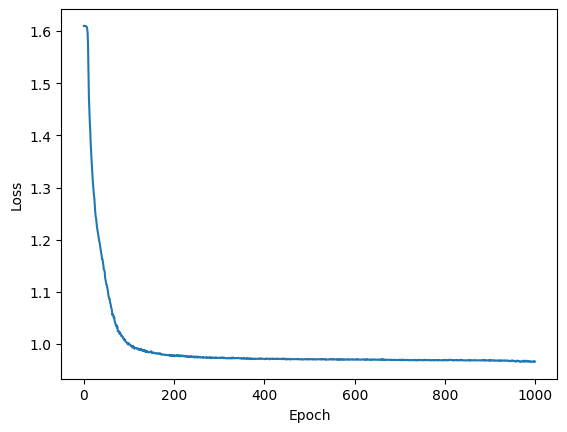

Test accuracy: 465.40043010752686
Accuracy: 0.4374193548387097
Precision: 0.4428604226833695
Recall: 0.435815653610992
F1-score: 0.4368242373950581


Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.62      0.60       495
           1       0.43      0.31      0.36       472
           2       0.26      0.30      0.28       449
           3       0.31      0.33      0.32       463
           4       0.64      0.61      0.63       446

    accuracy                           0.44      2325
   macro avg       0.44      0.44      0.44      2325
weighted avg       0.44      0.44      0.44      2325

                    0           1           2           3           4  \
precision    0.578947    0.425656    0.260038    0.308151    0.641509   
recall       0.622222    0.309322    0.302895    0.334773    0.609865   
f1-score     0.599805    0.358282    0.279835    0.320911    0.625287   
support    495.000000  472.000000  449.000000 

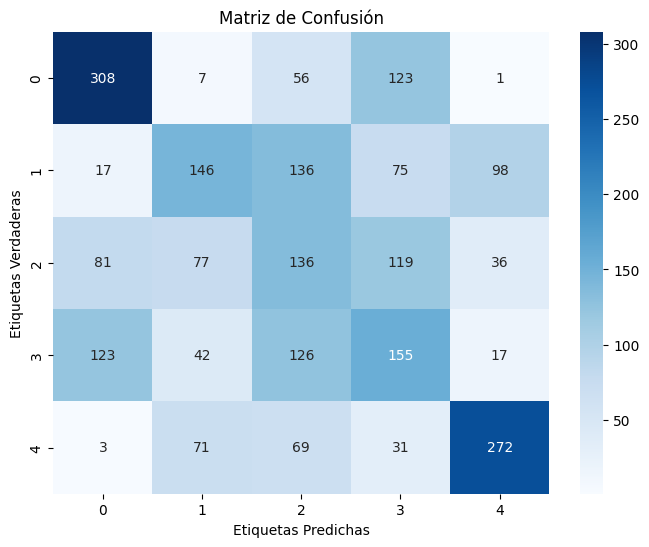

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_1000_1e-05_0.2/resultados_1000_1e-05_0.2.json
Procesando red con 700 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.9


Procesando epocas:   0%|                                                               | 1/700 [00:01<20:34,  1.77s/it]

1.609287039672627


Procesando epocas:   0%|▏                                                              | 2/700 [00:03<20:31,  1.76s/it]

1.5538623403100407


Procesando epocas:   0%|▎                                                              | 3/700 [00:05<20:27,  1.76s/it]

1.4496295830782722


Procesando epocas:   1%|▎                                                              | 4/700 [00:07<20:29,  1.77s/it]

1.3671262916396647


Procesando epocas:   1%|▍                                                              | 5/700 [00:08<20:25,  1.76s/it]

1.2927420686273015


Procesando epocas:   1%|▌                                                              | 6/700 [00:10<20:21,  1.76s/it]

1.227562946431777


Procesando epocas:   1%|▋                                                              | 7/700 [00:12<20:24,  1.77s/it]

1.1776361612712636


Procesando epocas:   1%|▋                                                              | 8/700 [00:14<20:26,  1.77s/it]

1.1310078911921557


Procesando epocas:   1%|▊                                                              | 9/700 [00:15<20:24,  1.77s/it]

1.1006535382831797


Procesando epocas:   1%|▉                                                             | 10/700 [00:17<20:21,  1.77s/it]

1.071996399935554


Procesando epocas:   2%|▉                                                             | 11/700 [00:19<20:17,  1.77s/it]

1.0463754559264464


Procesando epocas:   2%|█                                                             | 12/700 [00:21<20:17,  1.77s/it]

1.0318502689109128


Procesando epocas:   2%|█▏                                                            | 13/700 [00:22<20:17,  1.77s/it]

1.0231661288177265


Procesando epocas:   2%|█▏                                                            | 14/700 [00:24<20:15,  1.77s/it]

1.0160276942393358


Procesando epocas:   2%|█▎                                                            | 15/700 [00:26<20:11,  1.77s/it]

1.0042897638152628


Procesando epocas:   2%|█▍                                                            | 16/700 [00:28<19:54,  1.75s/it]

1.0019634912995732


Procesando epocas:   2%|█▌                                                            | 17/700 [00:29<19:42,  1.73s/it]

0.9980186518500833


Procesando epocas:   3%|█▌                                                            | 18/700 [00:31<19:34,  1.72s/it]

0.9981599099495831


Procesando epocas:   3%|█▋                                                            | 19/700 [00:33<19:26,  1.71s/it]

0.9978654268909903


Procesando epocas:   3%|█▊                                                            | 20/700 [00:35<19:23,  1.71s/it]

0.9939401335576001


Procesando epocas:   3%|█▊                                                            | 21/700 [00:36<19:19,  1.71s/it]

0.9915788608438828


Procesando epocas:   3%|█▉                                                            | 22/700 [00:38<19:17,  1.71s/it]

0.9924070582670323


Procesando epocas:   3%|██                                                            | 23/700 [00:40<19:12,  1.70s/it]

0.9896010644295636


Procesando epocas:   3%|██▏                                                           | 24/700 [00:41<19:10,  1.70s/it]

0.990080006683574


Procesando epocas:   4%|██▏                                                           | 25/700 [00:43<19:05,  1.70s/it]

0.9858485972180085


Procesando epocas:   4%|██▎                                                           | 26/700 [00:45<19:08,  1.70s/it]

0.983588243933285


Procesando epocas:   4%|██▍                                                           | 27/700 [00:46<19:06,  1.70s/it]

0.9804169384872212


Procesando epocas:   4%|██▍                                                           | 28/700 [00:48<19:01,  1.70s/it]

0.9790479211246266


Procesando epocas:   4%|██▌                                                           | 29/700 [00:50<19:02,  1.70s/it]

0.977773977728451


Procesando epocas:   4%|██▋                                                           | 30/700 [00:52<19:05,  1.71s/it]

0.9798396173645468


Procesando epocas:   4%|██▋                                                           | 31/700 [00:53<19:08,  1.72s/it]

0.9800568941761466


Procesando epocas:   5%|██▊                                                           | 32/700 [00:55<19:05,  1.72s/it]

0.9761496943586013


Procesando epocas:   5%|██▉                                                           | 33/700 [00:57<19:05,  1.72s/it]

0.9774444397758035


Procesando epocas:   5%|███                                                           | 34/700 [00:58<19:06,  1.72s/it]

0.9761090874671936


Procesando epocas:   5%|███                                                           | 35/700 [01:00<19:03,  1.72s/it]

0.9763163941748002


Procesando epocas:   5%|███▏                                                          | 36/700 [01:02<19:03,  1.72s/it]

0.9775610383819131


Procesando epocas:   5%|███▎                                                          | 37/700 [01:04<18:54,  1.71s/it]

0.978231609919492


Procesando epocas:   5%|███▎                                                          | 38/700 [01:05<18:47,  1.70s/it]

0.9742624805254094


Procesando epocas:   6%|███▍                                                          | 39/700 [01:07<18:40,  1.70s/it]

0.9740845171844258


Procesando epocas:   6%|███▌                                                          | 40/700 [01:09<18:32,  1.69s/it]

0.9739735466592452


Procesando epocas:   6%|███▋                                                          | 41/700 [01:10<18:23,  1.67s/it]

0.972898954854292


Procesando epocas:   6%|███▋                                                          | 42/700 [01:12<18:18,  1.67s/it]

0.9717382693991942


Procesando epocas:   6%|███▊                                                          | 43/700 [01:14<18:14,  1.67s/it]

0.9724643016562743


Procesando epocas:   6%|███▉                                                          | 44/700 [01:15<18:13,  1.67s/it]

0.9736040844636805


Procesando epocas:   6%|███▉                                                          | 45/700 [01:17<18:10,  1.66s/it]

0.9731671799631679


Procesando epocas:   7%|████                                                          | 46/700 [01:19<18:12,  1.67s/it]

0.9724972518051371


Procesando epocas:   7%|████▏                                                         | 47/700 [01:20<18:08,  1.67s/it]

0.9715818801346947


Procesando epocas:   7%|████▎                                                         | 48/700 [01:22<18:02,  1.66s/it]

0.9673245377400342


Procesando epocas:   7%|████▎                                                         | 49/700 [01:24<18:00,  1.66s/it]

0.9689490921357099


Procesando epocas:   7%|████▍                                                         | 50/700 [01:25<17:57,  1.66s/it]

0.969318093622432


Procesando epocas:   7%|████▌                                                         | 51/700 [01:27<17:54,  1.66s/it]

0.9660934714710011


Procesando epocas:   7%|████▌                                                         | 52/700 [01:28<17:51,  1.65s/it]

0.9670979857444764


Procesando epocas:   8%|████▋                                                         | 53/700 [01:30<17:48,  1.65s/it]

0.9667994246763342


Procesando epocas:   8%|████▊                                                         | 54/700 [01:32<17:47,  1.65s/it]

0.9649871808641097


Procesando epocas:   8%|████▊                                                         | 55/700 [01:33<17:46,  1.65s/it]

0.9661904250874239


Procesando epocas:   8%|████▉                                                         | 56/700 [01:35<17:42,  1.65s/it]

0.9649023722199833


Procesando epocas:   8%|█████                                                         | 57/700 [01:37<17:40,  1.65s/it]

0.9643279366633472


Procesando epocas:   8%|█████▏                                                        | 58/700 [01:38<17:42,  1.65s/it]

0.9660883689627928


Procesando epocas:   8%|█████▏                                                        | 59/700 [01:40<17:39,  1.65s/it]

0.9636585375841926


Procesando epocas:   9%|█████▎                                                        | 60/700 [01:42<17:36,  1.65s/it]

0.9623459942200605


Procesando epocas:   9%|█████▍                                                        | 61/700 [01:43<17:36,  1.65s/it]

0.9636233859202441


Procesando epocas:   9%|█████▍                                                        | 62/700 [01:45<17:44,  1.67s/it]

0.9630940135787515


Procesando epocas:   9%|█████▌                                                        | 63/700 [01:47<17:42,  1.67s/it]

0.9619620740413666


Procesando epocas:   9%|█████▋                                                        | 64/700 [01:48<17:39,  1.67s/it]

0.9613222532412585


Procesando epocas:   9%|█████▊                                                        | 65/700 [01:50<17:34,  1.66s/it]

0.9610364395029405


Procesando epocas:   9%|█████▊                                                        | 66/700 [01:52<17:34,  1.66s/it]

0.9604113073909983


Procesando epocas:  10%|█████▉                                                        | 67/700 [01:53<17:35,  1.67s/it]

0.9606778162367203


Procesando epocas:  10%|██████                                                        | 68/700 [01:55<17:35,  1.67s/it]

0.9605654741034788


Procesando epocas:  10%|██████                                                        | 69/700 [01:57<18:31,  1.76s/it]

0.9615976543987499


Procesando epocas:  10%|██████▏                                                       | 70/700 [01:59<18:59,  1.81s/it]

0.9624831729075488


Procesando epocas:  10%|██████▎                                                       | 71/700 [02:01<18:47,  1.79s/it]

0.9622963056844823


Procesando epocas:  10%|██████▍                                                       | 72/700 [02:02<18:40,  1.78s/it]

0.9637916954124675


Procesando epocas:  10%|██████▍                                                       | 73/700 [02:04<18:31,  1.77s/it]

0.96292604488485


Procesando epocas:  11%|██████▌                                                       | 74/700 [02:06<18:25,  1.77s/it]

0.9640428276622997


Procesando epocas:  11%|██████▋                                                       | 75/700 [02:08<18:22,  1.76s/it]

0.9615530659170711


Procesando epocas:  11%|██████▋                                                       | 76/700 [02:09<18:15,  1.76s/it]

0.9611833898460164


Procesando epocas:  11%|██████▊                                                       | 77/700 [02:11<18:15,  1.76s/it]

0.9602230864412644


Procesando epocas:  11%|██████▉                                                       | 78/700 [02:13<18:09,  1.75s/it]

0.9601546504918267


Procesando epocas:  11%|██████▉                                                       | 79/700 [02:15<18:05,  1.75s/it]

0.9601095518645119


Procesando epocas:  11%|███████                                                       | 80/700 [02:16<18:02,  1.75s/it]

0.9593763954499188


Procesando epocas:  12%|███████▏                                                      | 81/700 [02:18<17:59,  1.74s/it]

0.9589745858136345


Procesando epocas:  12%|███████▎                                                      | 82/700 [02:20<17:57,  1.74s/it]

0.957106510330649


Procesando epocas:  12%|███████▎                                                      | 83/700 [02:22<17:53,  1.74s/it]

0.958259127069922


Procesando epocas:  12%|███████▍                                                      | 84/700 [02:23<17:49,  1.74s/it]

0.9576282490702236


Procesando epocas:  12%|███████▌                                                      | 85/700 [02:25<17:44,  1.73s/it]

0.9583623577566708


Procesando epocas:  12%|███████▌                                                      | 86/700 [02:27<17:43,  1.73s/it]

0.9592583039227653


Procesando epocas:  12%|███████▋                                                      | 87/700 [02:29<17:43,  1.73s/it]

0.9587565439588883


Procesando epocas:  13%|███████▊                                                      | 88/700 [02:30<17:43,  1.74s/it]

0.9570490220013786


Procesando epocas:  13%|███████▉                                                      | 89/700 [02:32<17:42,  1.74s/it]

0.9571076456238242


Procesando epocas:  13%|███████▉                                                      | 90/700 [02:34<17:39,  1.74s/it]

0.9579209317179287


Procesando epocas:  13%|████████                                                      | 91/700 [02:36<17:37,  1.74s/it]

0.956629902825636


Procesando epocas:  13%|████████▏                                                     | 92/700 [02:37<17:37,  1.74s/it]

0.9560051528846516


Procesando epocas:  13%|████████▏                                                     | 93/700 [02:39<17:35,  1.74s/it]

0.95683912915342


Procesando epocas:  13%|████████▎                                                     | 94/700 [02:41<17:33,  1.74s/it]

0.9559544510701123


Procesando epocas:  14%|████████▍                                                     | 95/700 [02:42<17:30,  1.74s/it]

0.9568955985938802


Procesando epocas:  14%|████████▌                                                     | 96/700 [02:44<17:38,  1.75s/it]

0.9553455002167646


Procesando epocas:  14%|████████▌                                                     | 97/700 [02:46<17:48,  1.77s/it]

0.9562558917438283


Procesando epocas:  14%|████████▋                                                     | 98/700 [02:48<17:51,  1.78s/it]

0.9558715879917145


Procesando epocas:  14%|████████▊                                                     | 99/700 [02:50<17:57,  1.79s/it]

0.9578452366239885


Procesando epocas:  14%|████████▋                                                    | 100/700 [02:52<18:12,  1.82s/it]

0.9579187536940855


Procesando epocas:  14%|████████▊                                                    | 101/700 [02:54<18:30,  1.85s/it]

0.9566493910901687


Procesando epocas:  15%|████████▉                                                    | 102/700 [02:56<18:51,  1.89s/it]

0.955460606953677


Procesando epocas:  15%|████████▉                                                    | 103/700 [02:57<19:02,  1.91s/it]

0.9553215654457317


Procesando epocas:  15%|█████████                                                    | 104/700 [02:59<19:11,  1.93s/it]

0.9545715531882117


Procesando epocas:  15%|█████████▏                                                   | 105/700 [03:01<19:26,  1.96s/it]

0.9551240780774285


Procesando epocas:  15%|█████████▏                                                   | 106/700 [03:03<19:31,  1.97s/it]

0.9526356392046984


Procesando epocas:  15%|█████████▎                                                   | 107/700 [03:05<19:25,  1.97s/it]

0.9536523163318634


Procesando epocas:  15%|█████████▍                                                   | 108/700 [03:07<19:19,  1.96s/it]

0.9523907156551585


Procesando epocas:  16%|█████████▍                                                   | 109/700 [03:09<19:25,  1.97s/it]

0.9530339865123525


Procesando epocas:  16%|█████████▌                                                   | 110/700 [03:11<19:32,  1.99s/it]

0.9527684341458713


Procesando epocas:  16%|█████████▋                                                   | 111/700 [03:13<19:30,  1.99s/it]

0.9537318043849048


Procesando epocas:  16%|█████████▊                                                   | 112/700 [03:15<19:25,  1.98s/it]

0.9539531711269827


Procesando epocas:  16%|█████████▊                                                   | 113/700 [03:17<19:22,  1.98s/it]

0.9542223660384908


Procesando epocas:  16%|█████████▉                                                   | 114/700 [03:19<19:21,  1.98s/it]

0.9527685470440809


Procesando epocas:  16%|██████████                                                   | 115/700 [03:21<19:26,  1.99s/it]

0.9525277130744036


Procesando epocas:  17%|██████████                                                   | 116/700 [03:23<19:08,  1.97s/it]

0.9532020677538479


Procesando epocas:  17%|██████████▏                                                  | 117/700 [03:25<18:44,  1.93s/it]

0.9569928302484401


Procesando epocas:  17%|██████████▎                                                  | 118/700 [03:27<18:36,  1.92s/it]

0.9549384618506712


Procesando epocas:  17%|██████████▎                                                  | 119/700 [03:29<18:29,  1.91s/it]

0.956990921497345


Procesando epocas:  17%|██████████▍                                                  | 120/700 [03:31<18:10,  1.88s/it]

0.9556091859060175


Procesando epocas:  17%|██████████▌                                                  | 121/700 [03:32<17:58,  1.86s/it]

0.9546247075585758


Procesando epocas:  17%|██████████▋                                                  | 122/700 [03:34<17:52,  1.86s/it]

0.954143052591997


Procesando epocas:  18%|██████████▋                                                  | 123/700 [03:36<17:34,  1.83s/it]

0.9538039628197165


Procesando epocas:  18%|██████████▊                                                  | 124/700 [03:38<17:20,  1.81s/it]

0.9528376232175266


Procesando epocas:  18%|██████████▉                                                  | 125/700 [03:40<17:08,  1.79s/it]

0.9521243060336394


Procesando epocas:  18%|██████████▉                                                  | 126/700 [03:41<17:00,  1.78s/it]

0.9525214384583865


Procesando epocas:  18%|███████████                                                  | 127/700 [03:43<16:53,  1.77s/it]

0.9540988203357248


Procesando epocas:  18%|███████████▏                                                 | 128/700 [03:45<16:48,  1.76s/it]

0.9542954995351679


Procesando epocas:  18%|███████████▏                                                 | 129/700 [03:47<16:50,  1.77s/it]

0.9540672978934119


Procesando epocas:  19%|███████████▎                                                 | 130/700 [03:48<16:47,  1.77s/it]

0.9546940137358273


Procesando epocas:  19%|███████████▍                                                 | 131/700 [03:50<16:50,  1.78s/it]

0.9522725406815024


Procesando epocas:  19%|███████████▌                                                 | 132/700 [03:52<16:45,  1.77s/it]

0.9527387832894044


Procesando epocas:  19%|███████████▌                                                 | 133/700 [03:54<16:39,  1.76s/it]

0.9525094007744509


Procesando epocas:  19%|███████████▋                                                 | 134/700 [03:55<16:34,  1.76s/it]

0.9527753598549786


Procesando epocas:  19%|███████████▊                                                 | 135/700 [03:57<16:31,  1.75s/it]

0.9542998366496143


Procesando epocas:  19%|███████████▊                                                 | 136/700 [03:59<16:29,  1.75s/it]

0.9532575670410605


Procesando epocas:  20%|███████████▉                                                 | 137/700 [04:01<16:27,  1.75s/it]

0.9522900879383087


Procesando epocas:  20%|████████████                                                 | 138/700 [04:02<16:27,  1.76s/it]

0.9519535499460557


Procesando epocas:  20%|████████████                                                 | 139/700 [04:04<16:23,  1.75s/it]

0.9515133072348202


Procesando epocas:  20%|████████████▏                                                | 140/700 [04:06<16:18,  1.75s/it]

0.9503434209262623


Procesando epocas:  20%|████████████▎                                                | 141/700 [04:08<16:12,  1.74s/it]

0.9499064245644737


Procesando epocas:  20%|████████████▎                                                | 142/700 [04:09<16:06,  1.73s/it]

0.9509029626846314


Procesando epocas:  20%|████████████▍                                                | 143/700 [04:11<16:03,  1.73s/it]

0.9545843008686514


Procesando epocas:  21%|████████████▌                                                | 144/700 [04:13<15:57,  1.72s/it]

0.9523042135378894


Procesando epocas:  21%|████████████▋                                                | 145/700 [04:15<15:56,  1.72s/it]

0.9520123930538402


Procesando epocas:  21%|████████████▋                                                | 146/700 [04:16<15:59,  1.73s/it]

0.9531971738618963


Procesando epocas:  21%|████████████▊                                                | 147/700 [04:18<16:00,  1.74s/it]

0.9532470149152419


Procesando epocas:  21%|████████████▉                                                | 148/700 [04:20<16:01,  1.74s/it]

0.9530265566180735


Procesando epocas:  21%|████████████▉                                                | 149/700 [04:22<16:03,  1.75s/it]

0.9524126824210671


Procesando epocas:  21%|█████████████                                                | 150/700 [04:23<16:08,  1.76s/it]

0.9522889561512891


Procesando epocas:  22%|█████████████▏                                               | 151/700 [04:25<16:09,  1.77s/it]

0.9521930326433743


Procesando epocas:  22%|█████████████▏                                               | 152/700 [04:27<16:08,  1.77s/it]

0.9500745818895452


Procesando epocas:  22%|█████████████▎                                               | 153/700 [04:29<16:00,  1.76s/it]

0.9504694226910086


Procesando epocas:  22%|█████████████▍                                               | 154/700 [04:30<15:52,  1.75s/it]

0.950361135076074


Procesando epocas:  22%|█████████████▌                                               | 155/700 [04:32<15:50,  1.74s/it]

0.9509427908588858


Procesando epocas:  22%|█████████████▌                                               | 156/700 [04:34<15:47,  1.74s/it]

0.9495496367706971


Procesando epocas:  22%|█████████████▋                                               | 157/700 [04:36<15:45,  1.74s/it]

0.949965967500911


Procesando epocas:  23%|█████████████▊                                               | 158/700 [04:37<15:45,  1.74s/it]

0.9498081021449145


Procesando epocas:  23%|█████████████▊                                               | 159/700 [04:39<15:51,  1.76s/it]

0.9540969701374278


Procesando epocas:  23%|█████████████▉                                               | 160/700 [04:41<15:50,  1.76s/it]

0.9507853760438807


Procesando epocas:  23%|██████████████                                               | 161/700 [04:43<15:52,  1.77s/it]

0.9518411850228029


Procesando epocas:  23%|██████████████                                               | 162/700 [04:44<15:51,  1.77s/it]

0.9520719135508818


Procesando epocas:  23%|██████████████▏                                              | 163/700 [04:46<15:50,  1.77s/it]

0.950626107524423


Procesando epocas:  23%|██████████████▎                                              | 164/700 [04:48<15:48,  1.77s/it]

0.950058879922418


Procesando epocas:  24%|██████████████▍                                              | 165/700 [04:50<15:45,  1.77s/it]

0.9493567645549774


Procesando epocas:  24%|██████████████▍                                              | 166/700 [04:51<15:38,  1.76s/it]

0.9483470453935511


Procesando epocas:  24%|██████████████▌                                              | 167/700 [04:53<15:32,  1.75s/it]

0.9504431398475871


Procesando epocas:  24%|██████████████▋                                              | 168/700 [04:55<15:29,  1.75s/it]

0.9505980084924137


Procesando epocas:  24%|██████████████▋                                              | 169/700 [04:57<15:23,  1.74s/it]

0.9502064813585842


Procesando epocas:  24%|██████████████▊                                              | 170/700 [04:58<15:26,  1.75s/it]

0.9503458969733294


Procesando epocas:  24%|██████████████▉                                              | 171/700 [05:00<15:27,  1.75s/it]

0.9484778204384972


Procesando epocas:  25%|██████████████▉                                              | 172/700 [05:02<15:28,  1.76s/it]

0.9474356553133796


Procesando epocas:  25%|███████████████                                              | 173/700 [05:04<15:30,  1.77s/it]

0.9476161248543683


Procesando epocas:  25%|███████████████▏                                             | 174/700 [05:06<15:29,  1.77s/it]

0.9475919155513539


Procesando epocas:  25%|███████████████▎                                             | 175/700 [05:07<15:29,  1.77s/it]

0.948327270676108


Procesando epocas:  25%|███████████████▎                                             | 176/700 [05:09<15:24,  1.77s/it]

0.9484214144594529


Procesando epocas:  25%|███████████████▍                                             | 177/700 [05:11<15:19,  1.76s/it]

0.9491901478346656


Procesando epocas:  25%|███████████████▌                                             | 178/700 [05:13<15:15,  1.75s/it]

0.948092913277009


Procesando epocas:  26%|███████████████▌                                             | 179/700 [05:14<15:14,  1.76s/it]

0.9477899260380689


Procesando epocas:  26%|███████████████▋                                             | 180/700 [05:16<15:08,  1.75s/it]

0.949549315256231


Procesando epocas:  26%|███████████████▊                                             | 181/700 [05:18<15:08,  1.75s/it]

0.9491036288878497


Procesando epocas:  26%|███████████████▊                                             | 182/700 [05:20<15:11,  1.76s/it]

0.949125837578493


Procesando epocas:  26%|███████████████▉                                             | 183/700 [05:21<15:10,  1.76s/it]

0.9482934250551112


Procesando epocas:  26%|████████████████                                             | 184/700 [05:23<15:06,  1.76s/it]

0.9487784606568953


Procesando epocas:  26%|████████████████                                             | 185/700 [05:25<15:02,  1.75s/it]

0.9480691162978901


Procesando epocas:  27%|████████████████▏                                            | 186/700 [05:27<14:58,  1.75s/it]

0.9482207704992855


Procesando epocas:  27%|████████████████▎                                            | 187/700 [05:28<15:02,  1.76s/it]

0.949114983923295


Procesando epocas:  27%|████████████████▍                                            | 188/700 [05:30<14:59,  1.76s/it]

0.9488231143530678


Procesando epocas:  27%|████████████████▍                                            | 189/700 [05:32<14:58,  1.76s/it]

0.9485113221056322


Procesando epocas:  27%|████████████████▌                                            | 190/700 [05:34<14:57,  1.76s/it]

0.948669902717366


Procesando epocas:  27%|████████████████▋                                            | 191/700 [05:35<14:51,  1.75s/it]

0.9478732813807095


Procesando epocas:  27%|████████████████▋                                            | 192/700 [05:37<14:52,  1.76s/it]

0.948457752606448


Procesando epocas:  28%|████████████████▊                                            | 193/700 [05:39<14:50,  1.76s/it]

0.9477267679046182


Procesando epocas:  28%|████████████████▉                                            | 194/700 [05:41<14:48,  1.76s/it]

0.9497227051678826


Procesando epocas:  28%|████████████████▉                                            | 195/700 [05:42<14:43,  1.75s/it]

0.9490627706050873


Procesando epocas:  28%|█████████████████                                            | 196/700 [05:44<14:37,  1.74s/it]

0.949143791549346


Procesando epocas:  28%|█████████████████▏                                           | 197/700 [05:46<14:37,  1.74s/it]

0.9475538323907291


Procesando epocas:  28%|█████████████████▎                                           | 198/700 [05:48<14:42,  1.76s/it]

0.9472842658267302


Procesando epocas:  28%|█████████████████▎                                           | 199/700 [05:49<14:44,  1.77s/it]

0.9468275620656855


Procesando epocas:  29%|█████████████████▍                                           | 200/700 [05:51<14:40,  1.76s/it]

0.9462190691162559


Procesando epocas:  29%|█████████████████▌                                           | 201/700 [05:53<14:35,  1.75s/it]

0.9479414627832525


Procesando epocas:  29%|█████████████████▌                                           | 202/700 [05:55<14:31,  1.75s/it]

0.9473975851255305


Procesando epocas:  29%|█████████████████▋                                           | 203/700 [05:56<14:25,  1.74s/it]

0.9469555100973914


Procesando epocas:  29%|█████████████████▊                                           | 204/700 [05:58<14:30,  1.76s/it]

0.9476098905591404


Procesando epocas:  29%|█████████████████▊                                           | 205/700 [06:00<14:26,  1.75s/it]

0.9457775764605578


Procesando epocas:  29%|█████████████████▉                                           | 206/700 [06:02<14:26,  1.75s/it]

0.9460396475651685


Procesando epocas:  30%|██████████████████                                           | 207/700 [06:03<14:31,  1.77s/it]

0.9451539183364195


Procesando epocas:  30%|██████████████████▏                                          | 208/700 [06:05<14:37,  1.78s/it]

0.9452213094514959


Procesando epocas:  30%|██████████████████▏                                          | 209/700 [06:07<14:37,  1.79s/it]

0.945634974451626


Procesando epocas:  30%|██████████████████▎                                          | 210/700 [06:09<14:43,  1.80s/it]

0.9459519361748415


Procesando epocas:  30%|██████████████████▍                                          | 211/700 [06:11<14:43,  1.81s/it]

0.9461772515493281


Procesando epocas:  30%|██████████████████▍                                          | 212/700 [06:13<14:48,  1.82s/it]

0.9458553678849164


Procesando epocas:  30%|██████████████████▌                                          | 213/700 [06:14<14:47,  1.82s/it]

0.9467743337154388


Procesando epocas:  31%|██████████████████▋                                          | 214/700 [06:16<14:35,  1.80s/it]

0.9460627093034633


Procesando epocas:  31%|██████████████████▋                                          | 215/700 [06:18<14:27,  1.79s/it]

0.9465282860924216


Procesando epocas:  31%|██████████████████▊                                          | 216/700 [06:20<14:24,  1.79s/it]

0.9462460619561812


Procesando epocas:  31%|██████████████████▉                                          | 217/700 [06:21<14:21,  1.78s/it]

0.9485572155784158


Procesando epocas:  31%|██████████████████▉                                          | 218/700 [06:23<14:16,  1.78s/it]

0.9467387627152836


Procesando epocas:  31%|███████████████████                                          | 219/700 [06:25<14:18,  1.79s/it]

0.9464090378845439


Procesando epocas:  31%|███████████████████▏                                         | 220/700 [06:27<14:22,  1.80s/it]

0.9453192384803997


Procesando epocas:  32%|███████████████████▎                                         | 221/700 [06:29<14:20,  1.80s/it]

0.9451338101835812


Procesando epocas:  32%|███████████████████▎                                         | 222/700 [06:31<14:33,  1.83s/it]

0.9451625645160675


Procesando epocas:  32%|███████████████████▍                                         | 223/700 [06:32<14:33,  1.83s/it]

0.9456965867210837


Procesando epocas:  32%|███████████████████▌                                         | 224/700 [06:34<14:37,  1.84s/it]

0.9446295569924748


Procesando epocas:  32%|███████████████████▌                                         | 225/700 [06:36<14:31,  1.84s/it]

0.9452689100714291


Procesando epocas:  32%|███████████████████▋                                         | 226/700 [06:38<14:19,  1.81s/it]

0.9447174762978273


Procesando epocas:  32%|███████████████████▊                                         | 227/700 [06:40<14:11,  1.80s/it]

0.9451441649128409


Procesando epocas:  33%|███████████████████▊                                         | 228/700 [06:41<14:06,  1.79s/it]

0.9455547977896298


Procesando epocas:  33%|███████████████████▉                                         | 229/700 [06:43<13:59,  1.78s/it]

0.9441145837306977


Procesando epocas:  33%|████████████████████                                         | 230/700 [06:45<13:59,  1.79s/it]

0.9446780499290017


Procesando epocas:  33%|████████████████████▏                                        | 231/700 [06:47<13:52,  1.78s/it]

0.9435835203703712


Procesando epocas:  33%|████████████████████▏                                        | 232/700 [06:48<13:46,  1.77s/it]

0.9441235777209787


Procesando epocas:  33%|████████████████████▎                                        | 233/700 [06:50<13:47,  1.77s/it]

0.9435950377408195


Procesando epocas:  33%|████████████████████▍                                        | 234/700 [06:52<13:50,  1.78s/it]

0.9440070523935206


Procesando epocas:  34%|████████████████████▍                                        | 235/700 [06:54<13:50,  1.79s/it]

0.9447168637724483


Procesando epocas:  34%|████████████████████▌                                        | 236/700 [06:56<13:48,  1.79s/it]

0.9457704631721272


Procesando epocas:  34%|████████████████████▋                                        | 237/700 [06:57<13:49,  1.79s/it]

0.9453013939016005


Procesando epocas:  34%|████████████████████▋                                        | 238/700 [06:59<13:41,  1.78s/it]

0.9465300865033094


Procesando epocas:  34%|████████████████████▊                                        | 239/700 [07:01<13:34,  1.77s/it]

0.9476053942652309


Procesando epocas:  34%|████████████████████▉                                        | 240/700 [07:03<13:30,  1.76s/it]

0.946333229191163


Procesando epocas:  34%|█████████████████████                                        | 241/700 [07:04<13:26,  1.76s/it]

0.9466958140625673


Procesando epocas:  35%|█████████████████████                                        | 242/700 [07:06<13:23,  1.75s/it]

0.9461110185174381


Procesando epocas:  35%|█████████████████████▏                                       | 243/700 [07:08<13:18,  1.75s/it]

0.9462439715862274


Procesando epocas:  35%|█████████████████████▎                                       | 244/700 [07:10<13:18,  1.75s/it]

0.9461573860224556


Procesando epocas:  35%|█████████████████████▎                                       | 245/700 [07:11<13:18,  1.75s/it]

0.9454816516707926


Procesando epocas:  35%|█████████████████████▍                                       | 246/700 [07:13<13:15,  1.75s/it]

0.9452742050675785


Procesando epocas:  35%|█████████████████████▌                                       | 247/700 [07:15<13:15,  1.76s/it]

0.945716094269472


Procesando epocas:  35%|█████████████████████▌                                       | 248/700 [07:17<13:13,  1.76s/it]

0.9456227109712713


Procesando epocas:  36%|█████████████████████▋                                       | 249/700 [07:18<13:11,  1.75s/it]

0.9457579784533556


Procesando epocas:  36%|█████████████████████▊                                       | 250/700 [07:20<13:06,  1.75s/it]

0.9452136344769422


Procesando epocas:  36%|█████████████████████▊                                       | 251/700 [07:22<13:03,  1.75s/it]

0.9464216193732093


Procesando epocas:  36%|█████████████████████▉                                       | 252/700 [07:24<13:01,  1.74s/it]

0.9456257125910591


Procesando epocas:  36%|██████████████████████                                       | 253/700 [07:25<12:59,  1.74s/it]

0.9459636853021733


Procesando epocas:  36%|██████████████████████▏                                      | 254/700 [07:27<12:57,  1.74s/it]

0.9459676777615267


Procesando epocas:  36%|██████████████████████▏                                      | 255/700 [07:29<12:55,  1.74s/it]

0.9434044073609745


Procesando epocas:  37%|██████████████████████▎                                      | 256/700 [07:31<12:53,  1.74s/it]

0.9446450366693384


Procesando epocas:  37%|██████████████████████▍                                      | 257/700 [07:32<12:52,  1.74s/it]

0.9436836586279027


Procesando epocas:  37%|██████████████████████▍                                      | 258/700 [07:34<12:55,  1.75s/it]

0.9432146643891054


Procesando epocas:  37%|██████████████████████▌                                      | 259/700 [07:36<12:56,  1.76s/it]

0.943090259327608


Procesando epocas:  37%|██████████████████████▋                                      | 260/700 [07:38<12:58,  1.77s/it]

0.9430652639445136


Procesando epocas:  37%|██████████████████████▋                                      | 261/700 [07:39<12:57,  1.77s/it]

0.9443127453327179


Procesando epocas:  37%|██████████████████████▊                                      | 262/700 [07:41<12:52,  1.76s/it]

0.9443000271039851


Procesando epocas:  38%|██████████████████████▉                                      | 263/700 [07:43<12:43,  1.75s/it]

0.9440211506450877


Procesando epocas:  38%|███████████████████████                                      | 264/700 [07:45<12:37,  1.74s/it]

0.9436486622866462


Procesando epocas:  38%|███████████████████████                                      | 265/700 [07:46<12:37,  1.74s/it]

0.943610978827757


Procesando epocas:  38%|███████████████████████▏                                     | 266/700 [07:48<12:34,  1.74s/it]

0.9433714140863979


Procesando epocas:  38%|███████████████████████▎                                     | 267/700 [07:50<12:35,  1.74s/it]

0.9448236184961656


Procesando epocas:  38%|███████████████████████▎                                     | 268/700 [07:52<12:36,  1.75s/it]

0.9446607407401589


Procesando epocas:  38%|███████████████████████▍                                     | 269/700 [07:53<12:39,  1.76s/it]

0.9436444198384004


Procesando epocas:  39%|███████████████████████▌                                     | 270/700 [07:55<12:48,  1.79s/it]

0.9438372412148643


Procesando epocas:  39%|███████████████████████▌                                     | 271/700 [07:57<12:47,  1.79s/it]

0.9436467135653777


Procesando epocas:  39%|███████████████████████▋                                     | 272/700 [07:59<12:53,  1.81s/it]

0.9429070497260374


Procesando epocas:  39%|███████████████████████▊                                     | 273/700 [08:01<12:50,  1.80s/it]

0.9429410836275887


Procesando epocas:  39%|███████████████████████▉                                     | 274/700 [08:02<12:39,  1.78s/it]

0.9440971311400919


Procesando epocas:  39%|███████████████████████▉                                     | 275/700 [08:04<12:31,  1.77s/it]

0.9439193455611958


Procesando epocas:  39%|████████████████████████                                     | 276/700 [08:06<12:25,  1.76s/it]

0.9426784455776215


Procesando epocas:  40%|████████████████████████▏                                    | 277/700 [08:08<12:19,  1.75s/it]

0.9423369225333719


Procesando epocas:  40%|████████████████████████▏                                    | 278/700 [08:09<12:14,  1.74s/it]

0.9423277297440698


Procesando epocas:  40%|████████████████████████▎                                    | 279/700 [08:11<12:13,  1.74s/it]

0.942589899371652


Procesando epocas:  40%|████████████████████████▍                                    | 280/700 [08:13<12:11,  1.74s/it]

0.9418405659058515


Procesando epocas:  40%|████████████████████████▍                                    | 281/700 [08:15<12:13,  1.75s/it]

0.9422938991995419


Procesando epocas:  40%|████████████████████████▌                                    | 282/700 [08:16<12:15,  1.76s/it]

0.9415259803042693


Procesando epocas:  40%|████████████████████████▋                                    | 283/700 [08:18<12:17,  1.77s/it]

0.9412658246124492


Procesando epocas:  41%|████████████████████████▋                                    | 284/700 [08:20<12:18,  1.78s/it]

0.9414567375884336


Procesando epocas:  41%|████████████████████████▊                                    | 285/700 [08:22<12:14,  1.77s/it]

0.9416646392906414


Procesando epocas:  41%|████████████████████████▉                                    | 286/700 [08:23<12:07,  1.76s/it]

0.9414206073564642


Procesando epocas:  41%|█████████████████████████                                    | 287/700 [08:25<11:59,  1.74s/it]

0.941851038792554


Procesando epocas:  41%|█████████████████████████                                    | 288/700 [08:27<11:55,  1.74s/it]

0.9414477895287906


Procesando epocas:  41%|█████████████████████████▏                                   | 289/700 [08:29<11:58,  1.75s/it]

0.9414212353089276


Procesando epocas:  41%|█████████████████████████▎                                   | 290/700 [08:30<11:56,  1.75s/it]

0.941370854658239


Procesando epocas:  42%|█████████████████████████▎                                   | 291/700 [08:32<11:55,  1.75s/it]

0.942345731048023


Procesando epocas:  42%|█████████████████████████▍                                   | 292/700 [08:34<11:53,  1.75s/it]

0.9423841676291298


Procesando epocas:  42%|█████████████████████████▌                                   | 293/700 [08:36<11:52,  1.75s/it]

0.9424408902140224


Procesando epocas:  42%|█████████████████████████▌                                   | 294/700 [08:37<11:50,  1.75s/it]

0.9416018142419703


Procesando epocas:  42%|█████████████████████████▋                                   | 295/700 [08:39<11:47,  1.75s/it]

0.9433746972504784


Procesando epocas:  42%|█████████████████████████▊                                   | 296/700 [08:41<11:47,  1.75s/it]

0.9427425640470841


Procesando epocas:  42%|█████████████████████████▉                                   | 297/700 [08:43<11:45,  1.75s/it]

0.9446022969834945


Procesando epocas:  43%|█████████████████████████▉                                   | 298/700 [08:44<11:43,  1.75s/it]

0.9446474292699029


Procesando epocas:  43%|██████████████████████████                                   | 299/700 [08:46<11:38,  1.74s/it]

0.9435977998901816


Procesando epocas:  43%|██████████████████████████▏                                  | 300/700 [08:48<11:36,  1.74s/it]

0.9438919207629035


Procesando epocas:  43%|██████████████████████████▏                                  | 301/700 [08:50<11:34,  1.74s/it]

0.9437914764179903


Procesando epocas:  43%|██████████████████████████▎                                  | 302/700 [08:51<11:39,  1.76s/it]

0.9444162600180682


Procesando epocas:  43%|██████████████████████████▍                                  | 303/700 [08:53<11:41,  1.77s/it]

0.9441188202184789


Procesando epocas:  43%|██████████████████████████▍                                  | 304/700 [08:55<11:40,  1.77s/it]

0.9434981041094836


Procesando epocas:  44%|██████████████████████████▌                                  | 305/700 [08:57<11:38,  1.77s/it]

0.9421070940354291


Procesando epocas:  44%|██████████████████████████▋                                  | 306/700 [08:58<11:34,  1.76s/it]

0.942289839071386


Procesando epocas:  44%|██████████████████████████▊                                  | 307/700 [09:00<11:29,  1.76s/it]

0.941923622524037


Procesando epocas:  44%|██████████████████████████▊                                  | 308/700 [09:02<11:27,  1.75s/it]

0.9440619966563056


Procesando epocas:  44%|██████████████████████████▉                                  | 309/700 [09:04<11:22,  1.75s/it]

0.9416546253597036


Procesando epocas:  44%|███████████████████████████                                  | 310/700 [09:05<11:18,  1.74s/it]

0.9408928587156183


Procesando epocas:  44%|███████████████████████████                                  | 311/700 [09:07<11:14,  1.73s/it]

0.9413378147517933


Procesando epocas:  45%|███████████████████████████▏                                 | 312/700 [09:09<11:15,  1.74s/it]

0.9418304099756128


Procesando epocas:  45%|███████████████████████████▎                                 | 313/700 [09:11<11:14,  1.74s/it]

0.9408330230151906


Procesando epocas:  45%|███████████████████████████▎                                 | 314/700 [09:12<11:16,  1.75s/it]

0.9409498141092413


Procesando epocas:  45%|███████████████████████████▍                                 | 315/700 [09:14<11:17,  1.76s/it]

0.9415926796548507


Procesando epocas:  45%|███████████████████████████▌                                 | 316/700 [09:16<11:21,  1.78s/it]

0.9411464736742132


Procesando epocas:  45%|███████████████████████████▌                                 | 317/700 [09:18<11:26,  1.79s/it]

0.9410985645125894


Procesando epocas:  45%|███████████████████████████▋                                 | 318/700 [09:20<11:27,  1.80s/it]

0.9408791794496424


Procesando epocas:  46%|███████████████████████████▊                                 | 319/700 [09:21<11:26,  1.80s/it]

0.9411974773687475


Procesando epocas:  46%|███████████████████████████▉                                 | 320/700 [09:23<11:26,  1.81s/it]

0.9413074433803559


Procesando epocas:  46%|███████████████████████████▉                                 | 321/700 [09:25<11:28,  1.82s/it]

0.941519625747905


Procesando epocas:  46%|████████████████████████████                                 | 322/700 [09:27<11:22,  1.81s/it]

0.9415508014314314


Procesando epocas:  46%|████████████████████████████▏                                | 323/700 [09:29<11:16,  1.79s/it]

0.9411621258539312


Procesando epocas:  46%|████████████████████████████▏                                | 324/700 [09:30<11:12,  1.79s/it]

0.9409351885318756


Procesando epocas:  46%|████████████████████████████▎                                | 325/700 [09:32<11:08,  1.78s/it]

0.9410228294484756


Procesando epocas:  47%|████████████████████████████▍                                | 326/700 [09:34<11:06,  1.78s/it]

0.9411638838403366


Procesando epocas:  47%|████████████████████████████▍                                | 327/700 [09:36<11:00,  1.77s/it]

0.9420495752026053


Procesando epocas:  47%|████████████████████████████▌                                | 328/700 [09:38<10:58,  1.77s/it]

0.9413871333879583


Procesando epocas:  47%|████████████████████████████▋                                | 329/700 [09:39<11:01,  1.78s/it]

0.9426164907567641


Procesando epocas:  47%|████████████████████████████▊                                | 330/700 [09:41<11:02,  1.79s/it]

0.9424821885193095


Procesando epocas:  47%|████████████████████████████▊                                | 331/700 [09:43<11:09,  1.81s/it]

0.9417876629268422


Procesando epocas:  47%|████████████████████████████▉                                | 332/700 [09:45<11:17,  1.84s/it]

0.9422480418401606


Procesando epocas:  48%|█████████████████████████████                                | 333/700 [09:47<11:20,  1.85s/it]

0.9415502488613129


Procesando epocas:  48%|█████████████████████████████                                | 334/700 [09:49<11:15,  1.85s/it]

0.9417514517026789


Procesando epocas:  48%|█████████████████████████████▏                               | 335/700 [09:50<11:13,  1.84s/it]

0.9421018309452954


Procesando epocas:  48%|█████████████████████████████▎                               | 336/700 [09:52<11:10,  1.84s/it]

0.940876570519279


Procesando epocas:  48%|█████████████████████████████▎                               | 337/700 [09:54<11:23,  1.88s/it]

0.9406862802365247


Procesando epocas:  48%|█████████████████████████████▍                               | 338/700 [09:56<11:18,  1.87s/it]

0.9405779715846566


Procesando epocas:  48%|█████████████████████████████▌                               | 339/700 [09:58<11:15,  1.87s/it]

0.9422888426219715


Procesando epocas:  49%|█████████████████████████████▋                               | 340/700 [10:00<11:14,  1.87s/it]

0.9435369933352751


Procesando epocas:  49%|█████████████████████████████▋                               | 341/700 [10:02<11:22,  1.90s/it]

0.9423856591477113


Procesando epocas:  49%|█████████████████████████████▊                               | 342/700 [10:04<11:29,  1.92s/it]

0.9419413457898532


Procesando epocas:  49%|█████████████████████████████▉                               | 343/700 [10:06<11:27,  1.93s/it]

0.9407258664860445


Procesando epocas:  49%|█████████████████████████████▉                               | 344/700 [10:08<11:20,  1.91s/it]

0.9410419635912951


Procesando epocas:  49%|██████████████████████████████                               | 345/700 [10:10<11:15,  1.90s/it]

0.9409178470864016


Procesando epocas:  49%|██████████████████████████████▏                              | 346/700 [10:11<11:15,  1.91s/it]

0.9412594570833094


Procesando epocas:  50%|██████████████████████████████▏                              | 347/700 [10:13<11:18,  1.92s/it]

0.9408093375318191


Procesando epocas:  50%|██████████████████████████████▎                              | 348/700 [10:15<11:10,  1.90s/it]

0.9417904338415931


Procesando epocas:  50%|██████████████████████████████▍                              | 349/700 [10:17<11:08,  1.90s/it]

0.9405811309814454


Procesando epocas:  50%|██████████████████████████████▌                              | 350/700 [10:19<11:02,  1.89s/it]

0.9412695726927589


Procesando epocas:  50%|██████████████████████████████▌                              | 351/700 [10:21<10:56,  1.88s/it]

0.9409788713735693


Procesando epocas:  50%|██████████████████████████████▋                              | 352/700 [10:23<10:51,  1.87s/it]

0.940860156101339


Procesando epocas:  50%|██████████████████████████████▊                              | 353/700 [10:25<10:46,  1.86s/it]

0.9405677826965556


Procesando epocas:  51%|██████████████████████████████▊                              | 354/700 [10:26<10:50,  1.88s/it]

0.9404599978643305


Procesando epocas:  51%|██████████████████████████████▉                              | 355/700 [10:28<10:47,  1.88s/it]

0.9412365671466378


Procesando epocas:  51%|███████████████████████████████                              | 356/700 [10:30<10:39,  1.86s/it]

0.9405934403924381


Procesando epocas:  51%|███████████████████████████████                              | 357/700 [10:32<10:37,  1.86s/it]

0.9405304193496704


Procesando epocas:  51%|███████████████████████████████▏                             | 358/700 [10:34<10:34,  1.85s/it]

0.9402043865007512


Procesando epocas:  51%|███████████████████████████████▎                             | 359/700 [10:36<10:28,  1.84s/it]

0.9407663839704851


Procesando epocas:  51%|███████████████████████████████▎                             | 360/700 [10:38<10:27,  1.85s/it]

0.9403238980209127


Procesando epocas:  52%|███████████████████████████████▍                             | 361/700 [10:39<10:20,  1.83s/it]

0.9402960296939401


Procesando epocas:  52%|███████████████████████████████▌                             | 362/700 [10:41<10:12,  1.81s/it]

0.9421251815908095


Procesando epocas:  52%|███████████████████████████████▋                             | 363/700 [10:43<10:08,  1.80s/it]

0.9419776138137369


Procesando epocas:  52%|███████████████████████████████▋                             | 364/700 [10:45<10:02,  1.79s/it]

0.9413452747990103


Procesando epocas:  52%|███████████████████████████████▊                             | 365/700 [10:46<10:00,  1.79s/it]

0.9417732333435732


Procesando epocas:  52%|███████████████████████████████▉                             | 366/700 [10:48<10:02,  1.80s/it]

0.9413557354141684


Procesando epocas:  52%|███████████████████████████████▉                             | 367/700 [10:50<09:57,  1.79s/it]

0.9421689745257883


Procesando epocas:  53%|████████████████████████████████                             | 368/700 [10:52<09:50,  1.78s/it]

0.9414613856988795


Procesando epocas:  53%|████████████████████████████████▏                            | 369/700 [10:54<09:43,  1.76s/it]

0.9416118022273569


Procesando epocas:  53%|████████████████████████████████▏                            | 370/700 [10:55<09:39,  1.76s/it]

0.9427686270545511


Procesando epocas:  53%|████████████████████████████████▎                            | 371/700 [10:57<09:37,  1.76s/it]

0.9423231952330645


Procesando epocas:  53%|████████████████████████████████▍                            | 372/700 [10:59<09:34,  1.75s/it]

0.9416338692693149


Procesando epocas:  53%|████████████████████████████████▌                            | 373/700 [11:01<09:31,  1.75s/it]

0.9406314394053291


Procesando epocas:  53%|████████████████████████████████▌                            | 374/700 [11:02<09:33,  1.76s/it]

0.9415355496546801


Procesando epocas:  54%|████████████████████████████████▋                            | 375/700 [11:04<09:34,  1.77s/it]

0.9412101801703958


Procesando epocas:  54%|████████████████████████████████▊                            | 376/700 [11:06<09:39,  1.79s/it]

0.9416144437649671


Procesando epocas:  54%|████████████████████████████████▊                            | 377/700 [11:08<09:38,  1.79s/it]

0.9418497509816114


Procesando epocas:  54%|████████████████████████████████▉                            | 378/700 [11:10<09:37,  1.79s/it]

0.9410058975219726


Procesando epocas:  54%|█████████████████████████████████                            | 379/700 [11:11<09:37,  1.80s/it]

0.9428074328338398


Procesando epocas:  54%|█████████████████████████████████                            | 380/700 [11:13<09:30,  1.78s/it]

0.9411741740563336


Procesando epocas:  54%|█████████████████████████████████▏                           | 381/700 [11:15<09:26,  1.78s/it]

0.9410216415629667


Procesando epocas:  55%|█████████████████████████████████▎                           | 382/700 [11:17<09:25,  1.78s/it]

0.9417667662396151


Procesando epocas:  55%|█████████████████████████████████▍                           | 383/700 [11:18<09:22,  1.78s/it]

0.9408747129580554


Procesando epocas:  55%|█████████████████████████████████▍                           | 384/700 [11:20<09:19,  1.77s/it]

0.940928023702958


Procesando epocas:  55%|█████████████████████████████████▌                           | 385/700 [11:22<09:21,  1.78s/it]

0.9409736121402067


Procesando epocas:  55%|█████████████████████████████████▋                           | 386/700 [11:24<09:20,  1.79s/it]

0.9406819206826827


Procesando epocas:  55%|█████████████████████████████████▋                           | 387/700 [11:26<09:19,  1.79s/it]

0.9409500970559962


Procesando epocas:  55%|█████████████████████████████████▊                           | 388/700 [11:27<09:19,  1.79s/it]

0.9405859919155345


Procesando epocas:  56%|█████████████████████████████████▉                           | 389/700 [11:29<09:18,  1.80s/it]

0.9405344892950619


Procesando epocas:  56%|█████████████████████████████████▉                           | 390/700 [11:31<09:16,  1.80s/it]

0.9395856685498182


Procesando epocas:  56%|██████████████████████████████████                           | 391/700 [11:33<09:12,  1.79s/it]

0.9399963519152473


Procesando epocas:  56%|██████████████████████████████████▏                          | 392/700 [11:34<09:07,  1.78s/it]

0.9397530471577363


Procesando epocas:  56%|██████████████████████████████████▏                          | 393/700 [11:36<09:02,  1.77s/it]

0.9399831505382762


Procesando epocas:  56%|██████████████████████████████████▎                          | 394/700 [11:38<08:59,  1.76s/it]

0.9400742323959574


Procesando epocas:  56%|██████████████████████████████████▍                          | 395/700 [11:40<08:56,  1.76s/it]

0.9398154728552874


Procesando epocas:  57%|██████████████████████████████████▌                          | 396/700 [11:41<08:55,  1.76s/it]

0.9398059957167681


Procesando epocas:  57%|██████████████████████████████████▌                          | 397/700 [11:43<08:53,  1.76s/it]

0.9400619633057539


Procesando epocas:  57%|██████████████████████████████████▋                          | 398/700 [11:45<08:51,  1.76s/it]

0.9420577655820286


Procesando epocas:  57%|██████████████████████████████████▊                          | 399/700 [11:47<08:49,  1.76s/it]

0.9410084717413958


Procesando epocas:  57%|██████████████████████████████████▊                          | 400/700 [11:48<08:46,  1.76s/it]

0.9414860139874851


Procesando epocas:  57%|██████████████████████████████████▉                          | 401/700 [11:50<08:46,  1.76s/it]

0.9395200610160828


Procesando epocas:  57%|███████████████████████████████████                          | 402/700 [11:52<08:41,  1.75s/it]

0.941161057878943


Procesando epocas:  58%|███████████████████████████████████                          | 403/700 [11:54<08:38,  1.75s/it]

0.9402392071836135


Procesando epocas:  58%|███████████████████████████████████▏                         | 404/700 [11:55<08:37,  1.75s/it]

0.9402546749395483


Procesando epocas:  58%|███████████████████████████████████▎                         | 405/700 [11:57<08:35,  1.75s/it]

0.9394670016625348


Procesando epocas:  58%|███████████████████████████████████▍                         | 406/700 [11:59<08:35,  1.75s/it]

0.9398369995986714


Procesando epocas:  58%|███████████████████████████████████▍                         | 407/700 [12:01<08:33,  1.75s/it]

0.9406546203529134


Procesando epocas:  58%|███████████████████████████████████▌                         | 408/700 [12:03<08:32,  1.75s/it]

0.9396337495130651


Procesando epocas:  58%|███████████████████████████████████▋                         | 409/700 [12:04<08:31,  1.76s/it]

0.9406607263228473


Procesando epocas:  59%|███████████████████████████████████▋                         | 410/700 [12:06<08:29,  1.76s/it]

0.9398933386101442


Procesando epocas:  59%|███████████████████████████████████▊                         | 411/700 [12:08<08:28,  1.76s/it]

0.9407101420795216


Procesando epocas:  59%|███████████████████████████████████▉                         | 412/700 [12:10<08:27,  1.76s/it]

0.9418607357670279


Procesando epocas:  59%|███████████████████████████████████▉                         | 413/700 [12:11<08:26,  1.76s/it]

0.9407855300342336


Procesando epocas:  59%|████████████████████████████████████                         | 414/700 [12:13<08:22,  1.76s/it]

0.9398047005428988


Procesando epocas:  59%|████████████████████████████████████▏                        | 415/700 [12:15<08:21,  1.76s/it]

0.9400625327054192


Procesando epocas:  59%|████████████████████████████████████▎                        | 416/700 [12:17<08:19,  1.76s/it]

0.9400878804571489


Procesando epocas:  60%|████████████████████████████████████▎                        | 417/700 [12:18<08:17,  1.76s/it]

0.9407341855413773


Procesando epocas:  60%|████████████████████████████████████▍                        | 418/700 [12:20<08:15,  1.76s/it]

0.9396855273667504


Procesando epocas:  60%|████████████████████████████████████▌                        | 419/700 [12:22<08:13,  1.76s/it]

0.9399039047605852


Procesando epocas:  60%|████████████████████████████████████▌                        | 420/700 [12:24<08:17,  1.78s/it]

0.9393270657343022


Procesando epocas:  60%|████████████████████████████████████▋                        | 421/700 [12:26<08:20,  1.79s/it]

0.9388431524529176


Procesando epocas:  60%|████████████████████████████████████▊                        | 422/700 [12:27<08:20,  1.80s/it]

0.9392994281123667


Procesando epocas:  60%|████████████████████████████████████▊                        | 423/700 [12:29<08:22,  1.81s/it]

0.9393717934103573


Procesando epocas:  61%|████████████████████████████████████▉                        | 424/700 [12:31<08:22,  1.82s/it]

0.939181149707121


Procesando epocas:  61%|█████████████████████████████████████                        | 425/700 [12:33<08:20,  1.82s/it]

0.9389132948482738


Procesando epocas:  61%|█████████████████████████████████████                        | 426/700 [12:35<08:19,  1.82s/it]

0.9391101370839512


Procesando epocas:  61%|█████████████████████████████████████▏                       | 427/700 [12:36<08:14,  1.81s/it]

0.9389217993792366


Procesando epocas:  61%|█████████████████████████████████████▎                       | 428/700 [12:38<08:14,  1.82s/it]

0.9406076543471392


Procesando epocas:  61%|█████████████████████████████████████▍                       | 429/700 [12:40<08:09,  1.81s/it]

0.9386625854408039


Procesando epocas:  61%|█████████████████████████████████████▍                       | 430/700 [12:42<08:03,  1.79s/it]

0.939029210805893


Procesando epocas:  62%|█████████████████████████████████████▌                       | 431/700 [12:44<08:00,  1.79s/it]

0.9399457114584305


Procesando epocas:  62%|█████████████████████████████████████▋                       | 432/700 [12:45<08:01,  1.80s/it]

0.9385921681628507


Procesando epocas:  62%|█████████████████████████████████████▋                       | 433/700 [12:47<07:59,  1.79s/it]

0.9386473150814281


Procesando epocas:  62%|█████████████████████████████████████▊                       | 434/700 [12:49<07:56,  1.79s/it]

0.9384107277673833


Procesando epocas:  62%|█████████████████████████████████████▉                       | 435/700 [12:51<07:57,  1.80s/it]

0.9402952043449178


Procesando epocas:  62%|█████████████████████████████████████▉                       | 436/700 [12:53<07:57,  1.81s/it]

0.938760461877374


Procesando epocas:  62%|██████████████████████████████████████                       | 437/700 [12:54<07:55,  1.81s/it]

0.9381606224705191


Procesando epocas:  63%|██████████████████████████████████████▏                      | 438/700 [12:56<07:51,  1.80s/it]

0.938637668244979


Procesando epocas:  63%|██████████████████████████████████████▎                      | 439/700 [12:58<07:47,  1.79s/it]

0.9379975957029006


Procesando epocas:  63%|██████████████████████████████████████▎                      | 440/700 [13:00<07:44,  1.78s/it]

0.9382454107789432


Procesando epocas:  63%|██████████████████████████████████████▍                      | 441/700 [13:02<07:41,  1.78s/it]

0.9389210431014791


Procesando epocas:  63%|██████████████████████████████████████▌                      | 442/700 [13:03<07:36,  1.77s/it]

0.9383350154932808


Procesando epocas:  63%|██████████████████████████████████████▌                      | 443/700 [13:05<07:34,  1.77s/it]

0.9383055413470549


Procesando epocas:  63%|██████████████████████████████████████▋                      | 444/700 [13:07<07:33,  1.77s/it]

0.9380170759032754


Procesando epocas:  64%|██████████████████████████████████████▊                      | 445/700 [13:09<07:33,  1.78s/it]

0.9384204668157241


Procesando epocas:  64%|██████████████████████████████████████▊                      | 446/700 [13:10<07:34,  1.79s/it]

0.9378952966016881


Procesando epocas:  64%|██████████████████████████████████████▉                      | 447/700 [13:12<07:30,  1.78s/it]

0.939381060179542


Procesando epocas:  64%|███████████████████████████████████████                      | 448/700 [13:14<07:25,  1.77s/it]

0.9379104470505434


Procesando epocas:  64%|███████████████████████████████████████▏                     | 449/700 [13:16<07:21,  1.76s/it]

0.9380621769848991


Procesando epocas:  64%|███████████████████████████████████████▏                     | 450/700 [13:17<07:18,  1.76s/it]

0.9375383626012241


Procesando epocas:  64%|███████████████████████████████████████▎                     | 451/700 [13:19<07:17,  1.76s/it]

0.9378391357029185


Procesando epocas:  65%|███████████████████████████████████████▍                     | 452/700 [13:21<07:14,  1.75s/it]

0.9384413740214179


Procesando epocas:  65%|███████████████████████████████████████▍                     | 453/700 [13:23<07:14,  1.76s/it]

0.9382974975249346


Procesando epocas:  65%|███████████████████████████████████████▌                     | 454/700 [13:24<07:12,  1.76s/it]

0.9383982924854054


Procesando epocas:  65%|███████████████████████████████████████▋                     | 455/700 [13:26<07:12,  1.76s/it]

0.938552654841367


Procesando epocas:  65%|███████████████████████████████████████▋                     | 456/700 [13:28<07:11,  1.77s/it]

0.9388010270455305


Procesando epocas:  65%|███████████████████████████████████████▊                     | 457/700 [13:30<07:08,  1.76s/it]

0.9383736922460444


Procesando epocas:  65%|███████████████████████████████████████▉                     | 458/700 [13:32<07:09,  1.78s/it]

0.9395852383445291


Procesando epocas:  66%|███████████████████████████████████████▉                     | 459/700 [13:33<07:08,  1.78s/it]

0.9394850222503438


Procesando epocas:  66%|████████████████████████████████████████                     | 460/700 [13:35<07:04,  1.77s/it]

0.9396377328564139


Procesando epocas:  66%|████████████████████████████████████████▏                    | 461/700 [13:37<07:04,  1.78s/it]

0.9383411432013792


Procesando epocas:  66%|████████████████████████████████████████▎                    | 462/700 [13:39<07:02,  1.78s/it]

0.9391211741110858


Procesando epocas:  66%|████████████████████████████████████████▎                    | 463/700 [13:40<07:00,  1.77s/it]

0.9386760525843676


Procesando epocas:  66%|████████████████████████████████████████▍                    | 464/700 [13:42<06:58,  1.77s/it]

0.9383679176078124


Procesando epocas:  66%|████████████████████████████████████████▌                    | 465/700 [13:44<06:57,  1.78s/it]

0.9382904315696043


Procesando epocas:  67%|████████████████████████████████████████▌                    | 466/700 [13:46<06:55,  1.78s/it]

0.9393341895411996


Procesando epocas:  67%|████████████████████████████████████████▋                    | 467/700 [13:47<06:51,  1.77s/it]

0.9391375745044035


Procesando epocas:  67%|████████████████████████████████████████▊                    | 468/700 [13:49<06:49,  1.76s/it]

0.9398664597202749


Procesando epocas:  67%|████████████████████████████████████████▊                    | 469/700 [13:51<06:47,  1.76s/it]

0.9406184792518616


Procesando epocas:  67%|████████████████████████████████████████▉                    | 470/700 [13:53<06:45,  1.76s/it]

0.9401029194102568


Procesando epocas:  67%|█████████████████████████████████████████                    | 471/700 [13:55<06:46,  1.77s/it]

0.939182326372932


Procesando epocas:  67%|█████████████████████████████████████████▏                   | 472/700 [13:56<06:44,  1.77s/it]

0.939585947639802


Procesando epocas:  68%|█████████████████████████████████████████▏                   | 473/700 [13:58<06:42,  1.77s/it]

0.9387410433853374


Procesando epocas:  68%|█████████████████████████████████████████▎                   | 474/700 [14:00<06:41,  1.78s/it]

0.9388965291135452


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 475/700 [14:02<06:39,  1.77s/it]

0.9389220360447379


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 476/700 [14:03<06:36,  1.77s/it]

0.9388590686461504


Procesando epocas:  68%|█████████████████████████████████████████▌                   | 477/700 [14:05<06:35,  1.77s/it]

0.9391521071686464


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 478/700 [14:07<06:38,  1.79s/it]

0.9385633868329665


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 479/700 [14:09<06:36,  1.80s/it]

0.9391262987080742


Procesando epocas:  69%|█████████████████████████████████████████▊                   | 480/700 [14:11<06:35,  1.80s/it]

0.9392034530639648


Procesando epocas:  69%|█████████████████████████████████████████▉                   | 481/700 [14:12<06:32,  1.79s/it]

0.9388494449503282


Procesando epocas:  69%|██████████████████████████████████████████                   | 482/700 [14:14<06:29,  1.79s/it]

0.9382940148606019


Procesando epocas:  69%|██████████████████████████████████████████                   | 483/700 [14:16<06:27,  1.79s/it]

0.9385764539241791


Procesando epocas:  69%|██████████████████████████████████████████▏                  | 484/700 [14:18<06:22,  1.77s/it]

0.9388550004538367


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 485/700 [14:19<06:19,  1.77s/it]

0.9390761077404022


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 486/700 [14:21<06:18,  1.77s/it]

0.9384531028130475


Procesando epocas:  70%|██████████████████████████████████████████▍                  | 487/700 [14:23<06:16,  1.77s/it]

0.938546707349665


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 488/700 [14:25<06:15,  1.77s/it]

0.9381658817038817


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 489/700 [14:27<06:15,  1.78s/it]

0.9379320214776432


Procesando epocas:  70%|██████████████████████████████████████████▋                  | 490/700 [14:28<06:14,  1.78s/it]

0.938431319769691


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 491/700 [14:30<06:12,  1.78s/it]

0.9376566122559941


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 492/700 [14:32<06:11,  1.78s/it]

0.9380776279112872


Procesando epocas:  70%|██████████████████████████████████████████▉                  | 493/700 [14:34<06:13,  1.81s/it]

0.9387053416055792


Procesando epocas:  71%|███████████████████████████████████████████                  | 494/700 [14:36<06:12,  1.81s/it]

0.9386921104262856


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 495/700 [14:37<06:08,  1.80s/it]

0.9393194794654847


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 496/700 [14:39<06:05,  1.79s/it]

0.9380497592336992


Procesando epocas:  71%|███████████████████████████████████████████▎                 | 497/700 [14:41<06:01,  1.78s/it]

0.938068630064235


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 498/700 [14:43<05:57,  1.77s/it]

0.9376733124256134


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 499/700 [14:44<05:55,  1.77s/it]

0.9375136322834913


Procesando epocas:  71%|███████████████████████████████████████████▌                 | 500/700 [14:46<05:52,  1.76s/it]

0.9374250506653505


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 501/700 [14:48<05:50,  1.76s/it]

0.9376773434526781


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 502/700 [14:50<05:47,  1.76s/it]

0.9373416206415962


Procesando epocas:  72%|███████████████████████████████████████████▊                 | 503/700 [14:51<05:44,  1.75s/it]

0.9371590232147889


Procesando epocas:  72%|███████████████████████████████████████████▉                 | 504/700 [14:53<05:45,  1.76s/it]

0.9373687305871178


Procesando epocas:  72%|████████████████████████████████████████████                 | 505/700 [14:55<05:50,  1.80s/it]

0.937600141062456


Procesando epocas:  72%|████████████████████████████████████████████                 | 506/700 [14:57<05:54,  1.82s/it]

0.9375871104352614


Procesando epocas:  72%|████████████████████████████████████████████▏                | 507/700 [14:59<05:55,  1.84s/it]

0.9394013937781839


Procesando epocas:  73%|████████████████████████████████████████████▎                | 508/700 [15:01<05:56,  1.86s/it]

0.9379557132720947


Procesando epocas:  73%|████████████████████████████████████████████▎                | 509/700 [15:03<05:56,  1.87s/it]

0.9387426769032198


Procesando epocas:  73%|████████████████████████████████████████████▍                | 510/700 [15:05<05:56,  1.87s/it]

0.9379487384768094


Procesando epocas:  73%|████████████████████████████████████████████▌                | 511/700 [15:06<05:54,  1.88s/it]

0.9375727716614218


Procesando epocas:  73%|████████████████████████████████████████████▌                | 512/700 [15:08<05:54,  1.89s/it]

0.9400183022022247


Procesando epocas:  73%|████████████████████████████████████████████▋                | 513/700 [15:10<05:53,  1.89s/it]

0.9396734567249523


Procesando epocas:  73%|████████████████████████████████████████████▊                | 514/700 [15:12<05:52,  1.89s/it]

0.9407230654183556


Procesando epocas:  74%|████████████████████████████████████████████▉                | 515/700 [15:14<05:52,  1.91s/it]

0.9386245075394125


Procesando epocas:  74%|████████████████████████████████████████████▉                | 516/700 [15:16<05:53,  1.92s/it]

0.9380352556705475


Procesando epocas:  74%|█████████████████████████████████████████████                | 517/700 [15:18<05:52,  1.93s/it]

0.9383313459508559


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 518/700 [15:20<05:44,  1.89s/it]

0.9381855091627906


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 519/700 [15:22<05:34,  1.85s/it]

0.9382530166822322


Procesando epocas:  74%|█████████████████████████████████████████████▎               | 520/700 [15:23<05:27,  1.82s/it]

0.9398540980675641


Procesando epocas:  74%|█████████████████████████████████████████████▍               | 521/700 [15:25<05:23,  1.81s/it]

0.9390837627298692


Procesando epocas:  75%|█████████████████████████████████████████████▍               | 522/700 [15:27<05:19,  1.79s/it]

0.9392070254858802


Procesando epocas:  75%|█████████████████████████████████████████████▌               | 523/700 [15:29<05:13,  1.77s/it]

0.9380220735774321


Procesando epocas:  75%|█████████████████████████████████████████████▋               | 524/700 [15:30<05:10,  1.76s/it]

0.9382691250127905


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 525/700 [15:32<05:07,  1.76s/it]

0.9385009397478664


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 526/700 [15:34<05:12,  1.79s/it]

0.9383834856397966


Procesando epocas:  75%|█████████████████████████████████████████████▉               | 527/700 [15:36<05:18,  1.84s/it]

0.9373982404961305


Procesando epocas:  75%|██████████████████████████████████████████████               | 528/700 [15:38<05:33,  1.94s/it]

0.9396932489731733


Procesando epocas:  76%|██████████████████████████████████████████████               | 529/700 [15:40<05:40,  1.99s/it]

0.9379988361807431


Procesando epocas:  76%|██████████████████████████████████████████████▏              | 530/700 [15:42<05:41,  2.01s/it]

0.9373804183567271


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 531/700 [15:44<05:40,  2.02s/it]

0.9368340327459224


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 532/700 [15:46<05:40,  2.03s/it]

0.9369594268939074


Procesando epocas:  76%|██████████████████████████████████████████████▍              | 533/700 [15:48<05:36,  2.02s/it]

0.9375560623757979


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 534/700 [15:50<05:36,  2.02s/it]

0.937087458372116


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 535/700 [15:52<05:34,  2.03s/it]

0.9372429675915662


Procesando epocas:  77%|██████████████████████████████████████████████▋              | 536/700 [15:54<05:35,  2.04s/it]

0.9374571947490468


Procesando epocas:  77%|██████████████████████████████████████████████▊              | 537/700 [15:56<05:32,  2.04s/it]

0.9372455884428585


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 538/700 [15:58<05:25,  2.01s/it]

0.9371312176480012


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 539/700 [16:00<05:26,  2.03s/it]

0.9366972036221448


Procesando epocas:  77%|███████████████████████████████████████████████              | 540/700 [16:03<05:25,  2.04s/it]

0.9370075629037969


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 541/700 [16:05<05:21,  2.02s/it]

0.9372629782732795


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 542/700 [16:06<05:07,  1.95s/it]

0.9405766609837027


Procesando epocas:  78%|███████████████████████████████████████████████▎             | 543/700 [16:08<05:03,  1.93s/it]

0.9374926791471594


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 544/700 [16:10<05:00,  1.93s/it]

0.9372665128287148


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 545/700 [16:12<04:57,  1.92s/it]

0.9371916020617765


Procesando epocas:  78%|███████████████████████████████████████████████▌             | 546/700 [16:14<04:56,  1.93s/it]

0.9373453070135678


Procesando epocas:  78%|███████████████████████████████████████████████▋             | 547/700 [16:16<04:54,  1.92s/it]

0.9372122252688688


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 548/700 [16:18<04:53,  1.93s/it]

0.9369224429130554


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 549/700 [16:20<04:52,  1.94s/it]

0.9373807044590221


Procesando epocas:  79%|███████████████████████████████████████████████▉             | 550/700 [16:22<04:49,  1.93s/it]

0.9371816628119525


Procesando epocas:  79%|████████████████████████████████████████████████             | 551/700 [16:24<04:49,  1.94s/it]

0.9373096304781297


Procesando epocas:  79%|████████████████████████████████████████████████             | 552/700 [16:26<04:51,  1.97s/it]

0.9428284385625054


Procesando epocas:  79%|████████████████████████████████████████████████▏            | 553/700 [16:28<04:53,  1.99s/it]

0.9387300785850076


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 554/700 [16:30<04:54,  2.02s/it]

0.9373302613987642


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 555/700 [16:32<04:52,  2.01s/it]

0.9367350143544814


Procesando epocas:  79%|████████████████████████████████████████████████▍            | 556/700 [16:34<04:45,  1.98s/it]

0.9370721838053535


Procesando epocas:  80%|████████████████████████████████████████████████▌            | 557/700 [16:36<04:41,  1.97s/it]

0.9366419956964604


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 558/700 [16:38<04:39,  1.97s/it]

0.9367112776812385


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 559/700 [16:40<04:36,  1.96s/it]

0.9364798086531022


Procesando epocas:  80%|████████████████████████████████████████████████▊            | 560/700 [16:41<04:25,  1.90s/it]

0.9370232561055352


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 561/700 [16:43<04:15,  1.84s/it]

0.9366065035848057


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 562/700 [16:45<04:08,  1.80s/it]

0.9371933537371019


Procesando epocas:  80%|█████████████████████████████████████████████████            | 563/700 [16:46<04:03,  1.78s/it]

0.9366385161876678


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 564/700 [16:48<03:59,  1.76s/it]

0.9371776861302993


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 565/700 [16:50<03:55,  1.75s/it]

0.9376200819716735


Procesando epocas:  81%|█████████████████████████████████████████████████▎           | 566/700 [16:52<03:53,  1.74s/it]

0.9370348849717308


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 567/700 [16:53<03:53,  1.75s/it]

0.9379016620271347


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 568/700 [16:55<04:00,  1.82s/it]

0.9380064112298628


Procesando epocas:  81%|█████████████████████████████████████████████████▌           | 569/700 [16:57<04:04,  1.87s/it]

0.9380399980965782


Procesando epocas:  81%|█████████████████████████████████████████████████▋           | 570/700 [16:59<04:07,  1.90s/it]

0.9414548281361075


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 571/700 [17:01<04:08,  1.93s/it]

0.9381158586810617


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 572/700 [17:03<04:08,  1.94s/it]

0.9378469901926377


Procesando epocas:  82%|█████████████████████████████████████████████████▉           | 573/700 [17:05<04:07,  1.95s/it]

0.9375617591773763


Procesando epocas:  82%|██████████████████████████████████████████████████           | 574/700 [17:07<04:05,  1.95s/it]

0.9372672641978544


Procesando epocas:  82%|██████████████████████████████████████████████████           | 575/700 [17:09<04:04,  1.96s/it]

0.9381707931266111


Procesando epocas:  82%|██████████████████████████████████████████████████▏          | 576/700 [17:11<04:03,  1.96s/it]

0.9386557982248418


Procesando epocas:  82%|██████████████████████████████████████████████████▎          | 577/700 [17:13<03:59,  1.95s/it]

0.9422908463898827


Procesando epocas:  83%|██████████████████████████████████████████████████▎          | 578/700 [17:15<03:56,  1.94s/it]

0.9411239858935861


Procesando epocas:  83%|██████████████████████████████████████████████████▍          | 579/700 [17:17<03:54,  1.94s/it]

0.9377389511641334


Procesando epocas:  83%|██████████████████████████████████████████████████▌          | 580/700 [17:19<03:51,  1.93s/it]

0.9376057502101449


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 581/700 [17:21<03:49,  1.93s/it]

0.9373796936343698


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 582/700 [17:23<03:45,  1.91s/it]

0.9370217670412625


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 583/700 [17:24<03:37,  1.86s/it]

0.9368577017503626


Procesando epocas:  83%|██████████████████████████████████████████████████▉          | 584/700 [17:26<03:31,  1.82s/it]

0.9374148151453804


Procesando epocas:  84%|██████████████████████████████████████████████████▉          | 585/700 [17:28<03:25,  1.79s/it]

0.9366171433645136


Procesando epocas:  84%|███████████████████████████████████████████████████          | 586/700 [17:30<03:22,  1.77s/it]

0.936387568361619


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 587/700 [17:31<03:18,  1.76s/it]

0.936967771544176


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 588/700 [17:33<03:15,  1.75s/it]

0.9370150282102473


Procesando epocas:  84%|███████████████████████████████████████████████████▎         | 589/700 [17:35<03:15,  1.76s/it]

0.936903528956806


Procesando epocas:  84%|███████████████████████████████████████████████████▍         | 590/700 [17:37<03:15,  1.78s/it]

0.9369639256421257


Procesando epocas:  84%|███████████████████████████████████████████████████▌         | 591/700 [17:39<03:19,  1.83s/it]

0.9366048150202807


Procesando epocas:  85%|███████████████████████████████████████████████████▌         | 592/700 [17:41<03:23,  1.88s/it]

0.9397062480449676


Procesando epocas:  85%|███████████████████████████████████████████████████▋         | 593/700 [17:43<03:25,  1.92s/it]

0.9366179308470558


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 594/700 [17:45<03:26,  1.95s/it]

0.9359263013390934


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 595/700 [17:47<03:24,  1.94s/it]

0.9357462416676914


Procesando epocas:  85%|███████████████████████████████████████████████████▉         | 596/700 [17:48<03:21,  1.94s/it]

0.9359153793138616


Procesando epocas:  85%|████████████████████████████████████████████████████         | 597/700 [17:50<03:18,  1.93s/it]

0.9363543338635388


Procesando epocas:  85%|████████████████████████████████████████████████████         | 598/700 [17:52<03:15,  1.92s/it]

0.9359238638597376


Procesando epocas:  86%|████████████████████████████████████████████████████▏        | 599/700 [17:54<03:13,  1.92s/it]

0.9355376815094667


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 600/700 [17:56<03:12,  1.92s/it]

0.93671135411543


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 601/700 [17:58<03:09,  1.92s/it]

0.9355364403303932


Procesando epocas:  86%|████████████████████████████████████████████████████▍        | 602/700 [18:00<03:08,  1.92s/it]

0.9355775289675768


Procesando epocas:  86%|████████████████████████████████████████████████████▌        | 603/700 [18:02<03:07,  1.94s/it]

0.9355337360325982


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 604/700 [18:04<03:05,  1.94s/it]

0.9357781967696022


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 605/700 [18:06<03:04,  1.95s/it]

0.9357328842667972


Procesando epocas:  87%|████████████████████████████████████████████████████▊        | 606/700 [18:08<03:02,  1.94s/it]

0.9353668489876915


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 607/700 [18:10<03:00,  1.94s/it]

0.9355260575518889


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 608/700 [18:12<02:58,  1.94s/it]

0.9354578365297879


Procesando epocas:  87%|█████████████████████████████████████████████████████        | 609/700 [18:14<02:55,  1.93s/it]

0.9355949524570913


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 610/700 [18:15<02:52,  1.92s/it]

0.9395321341121898


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 611/700 [18:17<02:50,  1.91s/it]

0.9368001604781432


Procesando epocas:  87%|█████████████████████████████████████████████████████▎       | 612/700 [18:19<02:48,  1.91s/it]

0.9361856176572687


Procesando epocas:  88%|█████████████████████████████████████████████████████▍       | 613/700 [18:21<02:46,  1.91s/it]

0.9357531992828145


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 614/700 [18:23<02:43,  1.90s/it]

0.9361342139103833


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 615/700 [18:25<02:40,  1.89s/it]

0.9357239859945634


Procesando epocas:  88%|█████████████████████████████████████████████████████▋       | 616/700 [18:27<02:37,  1.88s/it]

0.9359705711112303


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 617/700 [18:29<02:34,  1.86s/it]

0.9357605047085706


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 618/700 [18:30<02:31,  1.85s/it]

0.9379011399605695


Procesando epocas:  88%|█████████████████████████████████████████████████████▉       | 619/700 [18:32<02:29,  1.85s/it]

0.9370121906785404


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 620/700 [18:34<02:27,  1.84s/it]

0.9355760984561022


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 621/700 [18:36<02:25,  1.84s/it]

0.9358422742170446


Procesando epocas:  89%|██████████████████████████████████████████████████████▏      | 622/700 [18:38<02:23,  1.84s/it]

0.9352076874059789


Procesando epocas:  89%|██████████████████████████████████████████████████████▎      | 623/700 [18:40<02:22,  1.86s/it]

0.9395173700416789


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 624/700 [18:42<02:21,  1.86s/it]

0.9372436400722055


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 625/700 [18:43<02:20,  1.87s/it]

0.9354771414223839


Procesando epocas:  89%|██████████████████████████████████████████████████████▌      | 626/700 [18:45<02:16,  1.85s/it]

0.9349914410535027


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 627/700 [18:47<02:13,  1.82s/it]

0.9351036369800567


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 628/700 [18:49<02:09,  1.80s/it]

0.9350754036622889


Procesando epocas:  90%|██████████████████████████████████████████████████████▊      | 629/700 [18:50<02:06,  1.78s/it]

0.9359174928244423


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 630/700 [18:52<02:03,  1.76s/it]

0.9359380648416631


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 631/700 [18:54<02:00,  1.75s/it]

0.9357521989766289


Procesando epocas:  90%|███████████████████████████████████████████████████████      | 632/700 [18:56<01:58,  1.75s/it]

0.9353553726392634


Procesando epocas:  90%|███████████████████████████████████████████████████████▏     | 633/700 [18:57<01:57,  1.76s/it]

0.935267293102601


Procesando epocas:  91%|███████████████████████████████████████████████████████▏     | 634/700 [18:59<01:55,  1.75s/it]

0.9354139706667732


Procesando epocas:  91%|███████████████████████████████████████████████████████▎     | 635/700 [19:01<01:53,  1.75s/it]

0.9355341634329628


Procesando epocas:  91%|███████████████████████████████████████████████████████▍     | 636/700 [19:03<01:51,  1.75s/it]

0.9354164039387423


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 637/700 [19:04<01:50,  1.76s/it]

0.9356203156359055


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 638/700 [19:06<01:50,  1.78s/it]

0.9353987220455618


Procesando epocas:  91%|███████████████████████████████████████████████████████▋     | 639/700 [19:08<01:49,  1.79s/it]

0.935655720093671


Procesando epocas:  91%|███████████████████████████████████████████████████████▊     | 640/700 [19:10<01:47,  1.79s/it]

0.9362385392189025


Procesando epocas:  92%|███████████████████████████████████████████████████████▊     | 641/700 [19:12<01:46,  1.80s/it]

0.9374023335821489


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 642/700 [19:13<01:44,  1.80s/it]

0.9358678663478178


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 643/700 [19:15<01:42,  1.79s/it]

0.9375479235368617


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 644/700 [19:17<01:40,  1.79s/it]

0.9362507757018594


Procesando epocas:  92%|████████████████████████████████████████████████████████▏    | 645/700 [19:19<01:38,  1.79s/it]

0.9387306521920596


Procesando epocas:  92%|████████████████████████████████████████████████████████▎    | 646/700 [19:21<01:36,  1.78s/it]

0.9375103596378775


Procesando epocas:  92%|████████████████████████████████████████████████████████▍    | 647/700 [19:22<01:34,  1.79s/it]

0.9361882346517899


Procesando epocas:  93%|████████████████████████████████████████████████████████▍    | 648/700 [19:24<01:33,  1.79s/it]

0.9354175472960753


Procesando epocas:  93%|████████████████████████████████████████████████████████▌    | 649/700 [19:26<01:32,  1.80s/it]

0.9353526206577525


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 650/700 [19:28<01:30,  1.81s/it]

0.9351581296500038


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 651/700 [19:30<01:29,  1.82s/it]

0.9348101167117848


Procesando epocas:  93%|████████████████████████████████████████████████████████▊    | 652/700 [19:32<01:27,  1.82s/it]

0.9349763793103835


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 653/700 [19:33<01:25,  1.82s/it]

0.9349091736709371


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 654/700 [19:35<01:23,  1.81s/it]

0.9348304759053623


Procesando epocas:  94%|█████████████████████████████████████████████████████████    | 655/700 [19:37<01:21,  1.81s/it]

0.9349298904923832


Procesando epocas:  94%|█████████████████████████████████████████████████████████▏   | 656/700 [19:39<01:19,  1.80s/it]

0.9345503593192381


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 657/700 [19:41<01:17,  1.81s/it]

0.9363810339394738


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 658/700 [19:42<01:16,  1.81s/it]

0.9351480796056635


Procesando epocas:  94%|█████████████████████████████████████████████████████████▍   | 659/700 [19:44<01:14,  1.81s/it]

0.9346287695800557


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 660/700 [19:46<01:12,  1.81s/it]

0.9347997886293075


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 661/700 [19:48<01:10,  1.81s/it]

0.9348484393428353


Procesando epocas:  95%|█████████████████████████████████████████████████████████▋   | 662/700 [19:50<01:09,  1.83s/it]

0.9349622197010938


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 663/700 [19:52<01:07,  1.84s/it]

0.9349158592083875


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 664/700 [19:53<01:05,  1.82s/it]

0.9348017156124115


Procesando epocas:  95%|█████████████████████████████████████████████████████████▉   | 665/700 [19:55<01:02,  1.79s/it]

0.9348206123884987


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 666/700 [19:57<01:00,  1.78s/it]

0.9349207099746255


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 667/700 [19:59<00:58,  1.78s/it]

0.9349497623303358


Procesando epocas:  95%|██████████████████████████████████████████████████████████▏  | 668/700 [20:00<00:56,  1.77s/it]

0.934972967119778


Procesando epocas:  96%|██████████████████████████████████████████████████████████▎  | 669/700 [20:02<00:54,  1.77s/it]

0.9348241406328538


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 670/700 [20:04<00:53,  1.77s/it]

0.9349598015055937


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 671/700 [20:06<00:51,  1.77s/it]

0.9346144648159251


Procesando epocas:  96%|██████████████████████████████████████████████████████████▌  | 672/700 [20:07<00:49,  1.78s/it]

0.9345221011077657


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 673/700 [20:09<00:47,  1.77s/it]

0.9345923581544091


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 674/700 [20:11<00:45,  1.76s/it]

0.9358821612947127


Procesando epocas:  96%|██████████████████████████████████████████████████████████▊  | 675/700 [20:13<00:43,  1.76s/it]

0.934430468082428


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 676/700 [20:14<00:41,  1.75s/it]

0.9348553643507116


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 677/700 [20:16<00:40,  1.75s/it]

0.9354340746122248


Procesando epocas:  97%|███████████████████████████████████████████████████████████  | 678/700 [20:18<00:38,  1.75s/it]

0.9347934705369613


Procesando epocas:  97%|███████████████████████████████████████████████████████████▏ | 679/700 [20:20<00:36,  1.74s/it]

0.9348513455951915


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 680/700 [20:21<00:34,  1.75s/it]

0.9347886236274944


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 681/700 [20:23<00:33,  1.75s/it]

0.9346029712873347


Procesando epocas:  97%|███████████████████████████████████████████████████████████▍ | 682/700 [20:25<00:31,  1.75s/it]

0.9347931616446551


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 683/700 [20:27<00:29,  1.76s/it]

0.9360219247200909


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 684/700 [20:28<00:28,  1.76s/it]

0.9374261586105123


Procesando epocas:  98%|███████████████████████████████████████████████████████████▋ | 685/700 [20:30<00:26,  1.75s/it]

0.936103206171709


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 686/700 [20:32<00:24,  1.76s/it]

0.9341283577329972


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 687/700 [20:34<00:22,  1.76s/it]

0.9344925091547125


Procesando epocas:  98%|███████████████████████████████████████████████████████████▉ | 688/700 [20:35<00:21,  1.76s/it]

0.9339376793188208


Procesando epocas:  98%|████████████████████████████████████████████████████████████ | 689/700 [20:37<00:19,  1.76s/it]

0.9338223920148961


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 690/700 [20:39<00:17,  1.77s/it]

0.9341736456927131


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 691/700 [20:41<00:15,  1.77s/it]

0.9342201495871825


Procesando epocas:  99%|████████████████████████████████████████████████████████████▎| 692/700 [20:43<00:14,  1.79s/it]

0.9338297191788169


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 693/700 [20:44<00:12,  1.79s/it]

0.9340076713001026


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 694/700 [20:46<00:10,  1.80s/it]

0.9344371946418987


Procesando epocas:  99%|████████████████████████████████████████████████████████████▌| 695/700 [20:48<00:08,  1.80s/it]

0.9342176121823927


Procesando epocas:  99%|████████████████████████████████████████████████████████████▋| 696/700 [20:50<00:07,  1.80s/it]

0.9359538754996132


Procesando epocas: 100%|████████████████████████████████████████████████████████████▋| 697/700 [20:52<00:05,  1.80s/it]

0.9350932380732369


Procesando epocas: 100%|████████████████████████████████████████████████████████████▊| 698/700 [20:53<00:03,  1.79s/it]

0.9343122363090515


Procesando epocas: 100%|████████████████████████████████████████████████████████████▉| 699/700 [20:55<00:01,  1.80s/it]

0.9340772039750043


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 700/700 [20:57<00:00,  1.80s/it]

0.9337025344371795
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_700_0.0001_0.1/funcion_de_perdida_700_0.0001.png


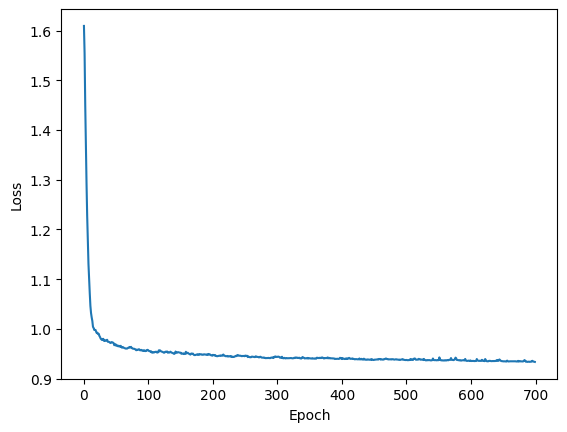

Test accuracy: 464.26193548387096
Accuracy: 0.5083870967741936
Precision: 0.5415942752576064
Recall: 0.5088119167633345
F1-score: 0.5189443659784501


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.52      0.59       495
           1       0.56      0.50      0.52       472
           2       0.46      0.47      0.46       449
           3       0.31      0.46      0.37       463
           4       0.70      0.61      0.65       446

    accuracy                           0.51      2325
   macro avg       0.54      0.51      0.52      2325
weighted avg       0.54      0.51      0.52      2325

                    0           1           2           3           4  \
precision    0.678191    0.555819    0.461369    0.308696    0.703896   
recall       0.515152    0.495763    0.465479    0.460043    0.607623   
f1-score     0.585534    0.524076    0.463415    0.369471    0.652226   
support    495.000000  472.000000  449.000000

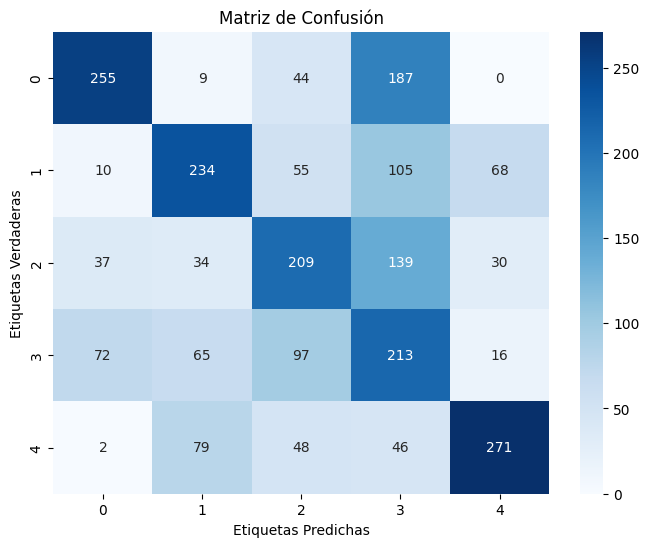

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_700_0.0001_0.1/resultados_700_0.0001_0.1.json
Procesando red con 700 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.9


Procesando epocas:   0%|                                                               | 1/700 [00:01<21:54,  1.88s/it]

1.6097669194726383


Procesando epocas:   0%|▏                                                              | 2/700 [00:03<21:56,  1.89s/it]

1.6098296431934132


Procesando epocas:   0%|▎                                                              | 3/700 [00:05<21:53,  1.88s/it]

1.6097525168867672


Procesando epocas:   1%|▎                                                              | 4/700 [00:07<21:52,  1.89s/it]

1.6096501364427453


Procesando epocas:   1%|▍                                                              | 5/700 [00:09<22:00,  1.90s/it]

1.6096129045766943


Procesando epocas:   1%|▌                                                              | 6/700 [00:11<22:06,  1.91s/it]

1.6090424811138826


Procesando epocas:   1%|▋                                                              | 7/700 [00:13<22:02,  1.91s/it]

1.6076586709303013


Procesando epocas:   1%|▋                                                              | 8/700 [00:15<21:57,  1.90s/it]

1.6043709502500647


Procesando epocas:   1%|▊                                                              | 9/700 [00:17<21:44,  1.89s/it]

1.5941860830082613


Procesando epocas:   1%|▉                                                             | 10/700 [00:18<21:22,  1.86s/it]

1.5538542670362137


Procesando epocas:   2%|▉                                                             | 11/700 [00:20<21:05,  1.84s/it]

1.4934441187802483


Procesando epocas:   2%|█                                                             | 12/700 [00:22<21:10,  1.85s/it]

1.4561150130103617


Procesando epocas:   2%|█▏                                                            | 13/700 [00:24<21:22,  1.87s/it]

1.4327756103347329


Procesando epocas:   2%|█▏                                                            | 14/700 [00:26<21:36,  1.89s/it]

1.4140484578469221


Procesando epocas:   2%|█▎                                                            | 15/700 [00:28<21:52,  1.92s/it]

1.397789796660928


Procesando epocas:   2%|█▍                                                            | 16/700 [00:30<21:47,  1.91s/it]

1.3812433263834785


Procesando epocas:   2%|█▌                                                            | 17/700 [00:32<21:56,  1.93s/it]

1.3683091374004588


Procesando epocas:   3%|█▌                                                            | 18/700 [00:34<21:58,  1.93s/it]

1.3549056004075444


Procesando epocas:   3%|█▋                                                            | 19/700 [00:36<21:59,  1.94s/it]

1.3404911209555233


Procesando epocas:   3%|█▊                                                            | 20/700 [00:38<21:55,  1.94s/it]

1.3323629736900329


Procesando epocas:   3%|█▊                                                            | 21/700 [00:39<21:53,  1.93s/it]

1.3179145364200369


Procesando epocas:   3%|█▉                                                            | 22/700 [00:41<21:54,  1.94s/it]

1.3107863412183873


Procesando epocas:   3%|██                                                            | 23/700 [00:43<21:51,  1.94s/it]

1.2939540147781372


Procesando epocas:   3%|██▏                                                           | 24/700 [00:45<21:55,  1.95s/it]

1.2933314035920536


Procesando epocas:   4%|██▏                                                           | 25/700 [00:47<21:59,  1.95s/it]

1.275171545673819


Procesando epocas:   4%|██▎                                                           | 26/700 [00:49<21:59,  1.96s/it]

1.2705307287328385


Procesando epocas:   4%|██▍                                                           | 27/700 [00:51<21:52,  1.95s/it]

1.2643958715831531


Procesando epocas:   4%|██▍                                                           | 28/700 [00:53<21:47,  1.95s/it]

1.2564176882014555


Procesando epocas:   4%|██▌                                                           | 29/700 [00:55<21:16,  1.90s/it]

1.2468109916238224


Procesando epocas:   4%|██▋                                                           | 30/700 [00:57<20:38,  1.85s/it]

1.2353325107518365


Procesando epocas:   4%|██▋                                                           | 31/700 [00:58<20:09,  1.81s/it]

1.2297578117426704


Procesando epocas:   5%|██▊                                                           | 32/700 [01:00<19:46,  1.78s/it]

1.2251675830167883


Procesando epocas:   5%|██▉                                                           | 33/700 [01:02<19:32,  1.76s/it]

1.2179960888974808


Procesando epocas:   5%|███                                                           | 34/700 [01:03<19:21,  1.74s/it]

1.213564444990719


Procesando epocas:   5%|███                                                           | 35/700 [01:05<19:28,  1.76s/it]

1.2048408936051762


Procesando epocas:   5%|███▏                                                          | 36/700 [01:07<20:21,  1.84s/it]

1.1976582877776203


Procesando epocas:   5%|███▎                                                          | 37/700 [01:09<20:49,  1.88s/it]

1.1938531973782707


Procesando epocas:   5%|███▎                                                          | 38/700 [01:11<21:00,  1.90s/it]

1.1879733443260192


Procesando epocas:   6%|███▍                                                          | 39/700 [01:13<21:24,  1.94s/it]

1.1816447096712448


Procesando epocas:   6%|███▌                                                          | 40/700 [01:15<21:47,  1.98s/it]

1.1819810727063347


Procesando epocas:   6%|███▋                                                          | 41/700 [01:17<21:54,  1.99s/it]

1.1718129999497358


Procesando epocas:   6%|███▋                                                          | 42/700 [01:19<21:54,  2.00s/it]

1.1695605158805846


Procesando epocas:   6%|███▊                                                          | 43/700 [01:21<21:51,  2.00s/it]

1.159467692234937


Procesando epocas:   6%|███▉                                                          | 44/700 [01:23<21:51,  2.00s/it]

1.152735435962677


Procesando epocas:   6%|███▉                                                          | 45/700 [01:25<21:30,  1.97s/it]

1.1462038983316982


Procesando epocas:   7%|████                                                          | 46/700 [01:27<21:02,  1.93s/it]

1.1401529347195345


Procesando epocas:   7%|████▏                                                         | 47/700 [01:29<20:30,  1.88s/it]

1.1394864937838387


Procesando epocas:   7%|████▎                                                         | 48/700 [01:31<20:10,  1.86s/it]

1.1298954241416033


Procesando epocas:   7%|████▎                                                         | 49/700 [01:32<19:51,  1.83s/it]

1.1279131608850816


Procesando epocas:   7%|████▍                                                         | 50/700 [01:34<19:38,  1.81s/it]

1.1186050323879018


Procesando epocas:   7%|████▌                                                         | 51/700 [01:36<19:32,  1.81s/it]

1.11910357931081


Procesando epocas:   7%|████▌                                                         | 52/700 [01:38<19:19,  1.79s/it]

1.111875192558064


Procesando epocas:   8%|████▋                                                         | 53/700 [01:39<19:06,  1.77s/it]

1.1061233289101544


Procesando epocas:   8%|████▊                                                         | 54/700 [01:41<18:52,  1.75s/it]

1.103211259841919


Procesando epocas:   8%|████▊                                                         | 55/700 [01:43<18:59,  1.77s/it]

1.0973459180663614


Procesando epocas:   8%|████▉                                                         | 56/700 [01:45<19:06,  1.78s/it]

1.0939407250460456


Procesando epocas:   8%|█████                                                         | 57/700 [01:47<19:25,  1.81s/it]

1.088918113708496


Procesando epocas:   8%|█████▏                                                        | 58/700 [01:49<19:39,  1.84s/it]

1.0825851096826442


Procesando epocas:   8%|█████▏                                                        | 59/700 [01:50<19:49,  1.86s/it]

1.0752297089380376


Procesando epocas:   9%|█████▎                                                        | 60/700 [01:52<19:54,  1.87s/it]

1.078687746033949


Procesando epocas:   9%|█████▍                                                        | 61/700 [01:54<19:56,  1.87s/it]

1.0725141570848578


Procesando epocas:   9%|█████▍                                                        | 62/700 [01:56<19:53,  1.87s/it]

1.0641759430660922


Procesando epocas:   9%|█████▌                                                        | 63/700 [01:58<19:43,  1.86s/it]

1.0632118526627035


Procesando epocas:   9%|█████▋                                                        | 64/700 [02:00<19:30,  1.84s/it]

1.061897618630353


Procesando epocas:   9%|█████▊                                                        | 65/700 [02:02<19:32,  1.85s/it]

1.0602466151994818


Procesando epocas:   9%|█████▊                                                        | 66/700 [02:03<19:34,  1.85s/it]

1.0573347789399765


Procesando epocas:  10%|█████▉                                                        | 67/700 [02:05<19:27,  1.84s/it]

1.0489466285004336


Procesando epocas:  10%|██████                                                        | 68/700 [02:07<19:25,  1.84s/it]

1.0477973489200367


Procesando epocas:  10%|██████                                                        | 69/700 [02:09<19:14,  1.83s/it]

1.0474706884692697


Procesando epocas:  10%|██████▏                                                       | 70/700 [02:11<19:07,  1.82s/it]

1.0405236279263217


Procesando epocas:  10%|██████▎                                                       | 71/700 [02:13<18:57,  1.81s/it]

1.0449216313221876


Procesando epocas:  10%|██████▍                                                       | 72/700 [02:14<18:53,  1.80s/it]

1.035575377590516


Procesando epocas:  10%|██████▍                                                       | 73/700 [02:16<18:47,  1.80s/it]

1.037897137333365


Procesando epocas:  11%|██████▌                                                       | 74/700 [02:18<18:40,  1.79s/it]

1.0314683721346014


Procesando epocas:  11%|██████▋                                                       | 75/700 [02:20<18:32,  1.78s/it]

1.0313367741949417


Procesando epocas:  11%|██████▋                                                       | 76/700 [02:21<18:24,  1.77s/it]

1.0329403547679676


Procesando epocas:  11%|██████▊                                                       | 77/700 [02:23<18:13,  1.76s/it]

1.028840940138873


Procesando epocas:  11%|██████▉                                                       | 78/700 [02:25<18:07,  1.75s/it]

1.0253403554944431


Procesando epocas:  11%|██████▉                                                       | 79/700 [02:27<18:04,  1.75s/it]

1.0246368899064906


Procesando epocas:  11%|███████                                                       | 80/700 [02:28<18:04,  1.75s/it]

1.0216682616402122


Procesando epocas:  12%|███████▏                                                      | 81/700 [02:30<18:05,  1.75s/it]

1.0224370160523584


Procesando epocas:  12%|███████▎                                                      | 82/700 [02:32<18:02,  1.75s/it]

1.0205975427347072


Procesando epocas:  12%|███████▎                                                      | 83/700 [02:34<17:58,  1.75s/it]

1.017976091889774


Procesando epocas:  12%|███████▍                                                      | 84/700 [02:35<17:53,  1.74s/it]

1.0174459786976084


Procesando epocas:  12%|███████▌                                                      | 85/700 [02:37<17:49,  1.74s/it]

1.015581571705201


Procesando epocas:  12%|███████▌                                                      | 86/700 [02:39<17:46,  1.74s/it]

1.0163076937198638


Procesando epocas:  12%|███████▋                                                      | 87/700 [02:41<17:43,  1.74s/it]

1.0161507490803214


Procesando epocas:  13%|███████▊                                                      | 88/700 [02:42<17:37,  1.73s/it]

1.0133517370504492


Procesando epocas:  13%|███████▉                                                      | 89/700 [02:44<17:33,  1.72s/it]

1.011876386754653


Procesando epocas:  13%|███████▉                                                      | 90/700 [02:46<17:34,  1.73s/it]

1.0116271194289712


Procesando epocas:  13%|████████                                                      | 91/700 [02:47<17:39,  1.74s/it]

1.0127083557493546


Procesando epocas:  13%|████████▏                                                     | 92/700 [02:49<17:39,  1.74s/it]

1.0067629642346325


Procesando epocas:  13%|████████▏                                                     | 93/700 [02:51<17:35,  1.74s/it]

1.0103821470456964


Procesando epocas:  13%|████████▎                                                     | 94/700 [02:53<17:33,  1.74s/it]

1.0075988169978647


Procesando epocas:  14%|████████▍                                                     | 95/700 [02:54<17:29,  1.74s/it]

1.0063694133478052


Procesando epocas:  14%|████████▌                                                     | 96/700 [02:56<17:30,  1.74s/it]

1.0028253362459294


Procesando epocas:  14%|████████▌                                                     | 97/700 [02:58<17:29,  1.74s/it]

1.0054116343750674


Procesando epocas:  14%|████████▋                                                     | 98/700 [03:00<17:27,  1.74s/it]

1.0022221912355984


Procesando epocas:  14%|████████▊                                                     | 99/700 [03:01<17:23,  1.74s/it]

1.0041536727372338


Procesando epocas:  14%|████████▋                                                    | 100/700 [03:03<17:27,  1.75s/it]

1.0036382924107945


Procesando epocas:  14%|████████▊                                                    | 101/700 [03:05<17:27,  1.75s/it]

1.0011618719381445


Procesando epocas:  15%|████████▉                                                    | 102/700 [03:07<17:23,  1.75s/it]

1.0042976719491623


Procesando epocas:  15%|████████▉                                                    | 103/700 [03:08<17:29,  1.76s/it]

1.0013228770564584


Procesando epocas:  15%|█████████                                                    | 104/700 [03:10<17:35,  1.77s/it]

0.998723758318845


Procesando epocas:  15%|█████████▏                                                   | 105/700 [03:12<17:35,  1.77s/it]

0.9992701155297896


Procesando epocas:  15%|█████████▏                                                   | 106/700 [03:14<17:34,  1.78s/it]

0.996032043765573


Procesando epocas:  15%|█████████▎                                                   | 107/700 [03:16<17:36,  1.78s/it]

0.9973389397649204


Procesando epocas:  15%|█████████▍                                                   | 108/700 [03:17<17:35,  1.78s/it]

1.0003699404351851


Procesando epocas:  16%|█████████▍                                                   | 109/700 [03:19<17:27,  1.77s/it]

0.9973311136750614


Procesando epocas:  16%|█████████▌                                                   | 110/700 [03:21<17:24,  1.77s/it]

0.9976777571089127


Procesando epocas:  16%|█████████▋                                                   | 111/700 [03:23<17:19,  1.77s/it]

0.9981951713562012


Procesando epocas:  16%|█████████▊                                                   | 112/700 [03:24<17:17,  1.76s/it]

0.9959605476435494


Procesando epocas:  16%|█████████▊                                                   | 113/700 [03:26<17:15,  1.76s/it]

0.9925684564253863


Procesando epocas:  16%|█████████▉                                                   | 114/700 [03:28<17:22,  1.78s/it]

0.995026580025168


Procesando epocas:  16%|██████████                                                   | 115/700 [03:30<17:29,  1.79s/it]

0.9935151250923381


Procesando epocas:  17%|██████████                                                   | 116/700 [03:32<17:29,  1.80s/it]

0.994965398311615


Procesando epocas:  17%|██████████▏                                                  | 117/700 [03:33<17:30,  1.80s/it]

0.9938993215560913


Procesando epocas:  17%|██████████▎                                                  | 118/700 [03:35<17:29,  1.80s/it]

0.9944113215979408


Procesando epocas:  17%|██████████▎                                                  | 119/700 [03:37<17:24,  1.80s/it]

0.9939396255156573


Procesando epocas:  17%|██████████▍                                                  | 120/700 [03:39<17:16,  1.79s/it]

0.9919864931527306


Procesando epocas:  17%|██████████▌                                                  | 121/700 [03:41<17:11,  1.78s/it]

0.9904382653096143


Procesando epocas:  17%|██████████▋                                                  | 122/700 [03:42<17:08,  1.78s/it]

0.9928363102323868


Procesando epocas:  18%|██████████▋                                                  | 123/700 [03:44<17:02,  1.77s/it]

0.9908610203686883


Procesando epocas:  18%|██████████▊                                                  | 124/700 [03:46<17:05,  1.78s/it]

0.9930466550237992


Procesando epocas:  18%|██████████▉                                                  | 125/700 [03:48<17:08,  1.79s/it]

0.9918361485004425


Procesando epocas:  18%|██████████▉                                                  | 126/700 [03:49<17:10,  1.80s/it]

0.9908383095965666


Procesando epocas:  18%|███████████                                                  | 127/700 [03:51<17:09,  1.80s/it]

0.9914971845991472


Procesando epocas:  18%|███████████▏                                                 | 128/700 [03:53<17:02,  1.79s/it]

0.990320909724516


Procesando epocas:  18%|███████████▏                                                 | 129/700 [03:55<16:57,  1.78s/it]

0.9907194442608778


Procesando epocas:  19%|███████████▎                                                 | 130/700 [03:57<16:55,  1.78s/it]

0.9893174732432646


Procesando epocas:  19%|███████████▍                                                 | 131/700 [03:58<16:47,  1.77s/it]

0.989698335353066


Procesando epocas:  19%|███████████▌                                                 | 132/700 [04:00<16:45,  1.77s/it]

0.9892983745126164


Procesando epocas:  19%|███████████▌                                                 | 133/700 [04:02<16:38,  1.76s/it]

0.9880822125603171


Procesando epocas:  19%|███████████▋                                                 | 134/700 [04:04<16:37,  1.76s/it]

0.9888184263425714


Procesando epocas:  19%|███████████▊                                                 | 135/700 [04:05<16:35,  1.76s/it]

0.9897210601498099


Procesando epocas:  19%|███████████▊                                                 | 136/700 [04:07<16:30,  1.76s/it]

0.9888272941112518


Procesando epocas:  20%|███████████▉                                                 | 137/700 [04:09<16:25,  1.75s/it]

0.9873436479007497


Procesando epocas:  20%|████████████                                                 | 138/700 [04:11<16:19,  1.74s/it]

0.9848208248615264


Procesando epocas:  20%|████████████                                                 | 139/700 [04:12<16:14,  1.74s/it]

0.9876840924515443


Procesando epocas:  20%|████████████▏                                                | 140/700 [04:14<16:16,  1.74s/it]

0.9865502448642955


Procesando epocas:  20%|████████████▎                                                | 141/700 [04:16<16:17,  1.75s/it]

0.9888299942016602


Procesando epocas:  20%|████████████▎                                                | 142/700 [04:18<16:11,  1.74s/it]

0.985964776838527


Procesando epocas:  20%|████████████▍                                                | 143/700 [04:19<16:04,  1.73s/it]

0.9875072346014135


Procesando epocas:  21%|████████████▌                                                | 144/700 [04:21<15:58,  1.72s/it]

0.9863122792804943


Procesando epocas:  21%|████████████▋                                                | 145/700 [04:23<16:02,  1.73s/it]

0.9877129751093248


Procesando epocas:  21%|████████████▋                                                | 146/700 [04:24<16:05,  1.74s/it]

0.9850847696556765


Procesando epocas:  21%|████████████▊                                                | 147/700 [04:26<16:03,  1.74s/it]

0.9864290966707118


Procesando epocas:  21%|████████████▉                                                | 148/700 [04:28<15:58,  1.74s/it]

0.9854392163893756


Procesando epocas:  21%|████████████▉                                                | 149/700 [04:30<15:52,  1.73s/it]

0.9840614241712233


Procesando epocas:  21%|█████████████                                                | 150/700 [04:31<15:50,  1.73s/it]

0.9845444830024943


Procesando epocas:  22%|█████████████▏                                               | 151/700 [04:33<15:48,  1.73s/it]

0.9852593050283545


Procesando epocas:  22%|█████████████▏                                               | 152/700 [04:35<15:45,  1.73s/it]

0.9848486784626456


Procesando epocas:  22%|█████████████▎                                               | 153/700 [04:37<15:37,  1.71s/it]

0.9849821911138646


Procesando epocas:  22%|█████████████▍                                               | 154/700 [04:38<15:36,  1.72s/it]

0.9836864432867836


Procesando epocas:  22%|█████████████▌                                               | 155/700 [04:40<15:46,  1.74s/it]

0.9854792111060199


Procesando epocas:  22%|█████████████▌                                               | 156/700 [04:42<15:53,  1.75s/it]

0.9826317320851718


Procesando epocas:  22%|█████████████▋                                               | 157/700 [04:44<16:02,  1.77s/it]

0.9830914388684665


Procesando epocas:  23%|█████████████▊                                               | 158/700 [04:45<16:02,  1.78s/it]

0.9846998176153968


Procesando epocas:  23%|█████████████▊                                               | 159/700 [04:47<16:01,  1.78s/it]

0.9842867269235499


Procesando epocas:  23%|█████████████▉                                               | 160/700 [04:49<16:03,  1.78s/it]

0.9839304994134342


Procesando epocas:  23%|██████████████                                               | 161/700 [04:51<16:05,  1.79s/it]

0.9830432516687057


Procesando epocas:  23%|██████████████                                               | 162/700 [04:53<16:05,  1.80s/it]

0.9821350437753341


Procesando epocas:  23%|██████████████▏                                              | 163/700 [04:54<15:58,  1.79s/it]

0.9859051304705003


Procesando epocas:  23%|██████████████▎                                              | 164/700 [04:56<15:57,  1.79s/it]

0.9829833090305329


Procesando epocas:  24%|██████████████▍                                              | 165/700 [04:58<15:51,  1.78s/it]

0.9825871152036331


Procesando epocas:  24%|██████████████▍                                              | 166/700 [05:00<15:43,  1.77s/it]

0.9822931310709785


Procesando epocas:  24%|██████████████▌                                              | 167/700 [05:01<15:40,  1.76s/it]

0.9832887134131263


Procesando epocas:  24%|██████████████▋                                              | 168/700 [05:03<15:42,  1.77s/it]

0.9822410131202025


Procesando epocas:  24%|██████████████▋                                              | 169/700 [05:05<15:42,  1.77s/it]

0.9848841425250559


Procesando epocas:  24%|██████████████▊                                              | 170/700 [05:07<15:40,  1.78s/it]

0.9818929819499745


Procesando epocas:  24%|██████████████▉                                              | 171/700 [05:09<15:45,  1.79s/it]

0.9815778700744404


Procesando epocas:  25%|██████████████▉                                              | 172/700 [05:10<15:45,  1.79s/it]

0.9811568761573118


Procesando epocas:  25%|███████████████                                              | 173/700 [05:12<15:48,  1.80s/it]

0.9806188225746155


Procesando epocas:  25%|███████████████▏                                             | 174/700 [05:14<15:40,  1.79s/it]

0.9821416563847486


Procesando epocas:  25%|███████████████▎                                             | 175/700 [05:16<15:38,  1.79s/it]

0.9804878953625175


Procesando epocas:  25%|███████████████▎                                             | 176/700 [05:18<15:36,  1.79s/it]

0.9805003758739023


Procesando epocas:  25%|███████████████▍                                             | 177/700 [05:19<15:29,  1.78s/it]

0.9783355292151956


Procesando epocas:  25%|███████████████▌                                             | 178/700 [05:21<15:22,  1.77s/it]

0.9808014725937563


Procesando epocas:  26%|███████████████▌                                             | 179/700 [05:23<15:19,  1.76s/it]

0.9797268516877118


Procesando epocas:  26%|███████████████▋                                             | 180/700 [05:25<15:16,  1.76s/it]

0.9824906258022084


Procesando epocas:  26%|███████████████▊                                             | 181/700 [05:26<15:20,  1.77s/it]

0.9817549000768101


Procesando epocas:  26%|███████████████▊                                             | 182/700 [05:28<15:34,  1.80s/it]

0.9800105463056004


Procesando epocas:  26%|███████████████▉                                             | 183/700 [05:30<15:22,  1.79s/it]

0.9800169517012204


Procesando epocas:  26%|████████████████                                             | 184/700 [05:32<15:18,  1.78s/it]

0.9803788767141455


Procesando epocas:  26%|████████████████                                             | 185/700 [05:34<15:25,  1.80s/it]

0.9799821979859296


Procesando epocas:  27%|████████████████▏                                            | 186/700 [05:35<15:12,  1.77s/it]

0.9803674904739156


Procesando epocas:  27%|████████████████▎                                            | 187/700 [05:37<15:04,  1.76s/it]

0.9799411822767818


Procesando epocas:  27%|████████████████▍                                            | 188/700 [05:39<15:02,  1.76s/it]

0.9781245915328756


Procesando epocas:  27%|████████████████▍                                            | 189/700 [05:41<14:59,  1.76s/it]

0.9779079118195702


Procesando epocas:  27%|████████████████▌                                            | 190/700 [05:42<14:59,  1.76s/it]

0.9799407576813417


Procesando epocas:  27%|████████████████▋                                            | 191/700 [05:44<15:06,  1.78s/it]

0.978923322873957


Procesando epocas:  27%|████████████████▋                                            | 192/700 [05:46<15:04,  1.78s/it]

0.9808514956165763


Procesando epocas:  28%|████████████████▊                                            | 193/700 [05:48<15:01,  1.78s/it]

0.978943157897276


Procesando epocas:  28%|████████████████▉                                            | 194/700 [05:49<14:57,  1.77s/it]

0.9799214973169215


Procesando epocas:  28%|████████████████▉                                            | 195/700 [05:51<14:57,  1.78s/it]

0.9804947074721841


Procesando epocas:  28%|█████████████████                                            | 196/700 [05:53<14:56,  1.78s/it]

0.9793290341601653


Procesando epocas:  28%|█████████████████▏                                           | 197/700 [05:55<14:50,  1.77s/it]

0.9780082316959605


Procesando epocas:  28%|█████████████████▎                                           | 198/700 [05:57<14:56,  1.78s/it]

0.9798241394407609


Procesando epocas:  28%|█████████████████▎                                           | 199/700 [05:58<15:13,  1.82s/it]

0.978658432820264


Procesando epocas:  29%|█████████████████▍                                           | 200/700 [06:00<15:21,  1.84s/it]

0.9774337642333086


Procesando epocas:  29%|█████████████████▌                                           | 201/700 [06:02<15:25,  1.85s/it]

0.979881687374676


Procesando epocas:  29%|█████████████████▌                                           | 202/700 [06:04<15:04,  1.82s/it]

0.9773401242845199


Procesando epocas:  29%|█████████████████▋                                           | 203/700 [06:06<14:55,  1.80s/it]

0.9782676244483275


Procesando epocas:  29%|█████████████████▊                                           | 204/700 [06:08<15:05,  1.83s/it]

0.9774890843559714


Procesando epocas:  29%|█████████████████▊                                           | 205/700 [06:10<15:18,  1.86s/it]

0.977703619704527


Procesando epocas:  29%|█████████████████▉                                           | 206/700 [06:11<15:25,  1.87s/it]

0.9781144303434035


Procesando epocas:  30%|██████████████████                                           | 207/700 [06:13<15:20,  1.87s/it]

0.9786774316254784


Procesando epocas:  30%|██████████████████▏                                          | 208/700 [06:15<15:20,  1.87s/it]

0.9776037633419037


Procesando epocas:  30%|██████████████████▏                                          | 209/700 [06:17<15:25,  1.88s/it]

0.978618256484761


Procesando epocas:  30%|██████████████████▎                                          | 210/700 [06:19<15:23,  1.89s/it]

0.9777684492223403


Procesando epocas:  30%|██████████████████▍                                          | 211/700 [06:21<15:13,  1.87s/it]

0.9783214432351729


Procesando epocas:  30%|██████████████████▍                                          | 212/700 [06:23<15:08,  1.86s/it]

0.9788993456784416


Procesando epocas:  30%|██████████████████▌                                          | 213/700 [06:25<15:14,  1.88s/it]

0.9780235504402833


Procesando epocas:  31%|██████████████████▋                                          | 214/700 [06:26<15:10,  1.87s/it]

0.9777738799067105


Procesando epocas:  31%|██████████████████▋                                          | 215/700 [06:28<15:04,  1.86s/it]

0.9783236647353453


Procesando epocas:  31%|██████████████████▊                                          | 216/700 [06:30<14:56,  1.85s/it]

0.9777906530043659


Procesando epocas:  31%|██████████████████▉                                          | 217/700 [06:32<14:53,  1.85s/it]

0.9774836052866543


Procesando epocas:  31%|██████████████████▉                                          | 218/700 [06:34<15:02,  1.87s/it]

0.9773565376506133


Procesando epocas:  31%|███████████████████                                          | 219/700 [06:36<15:09,  1.89s/it]

0.9777687163913951


Procesando epocas:  31%|███████████████████▏                                         | 220/700 [06:38<15:02,  1.88s/it]

0.9781900938819437


Procesando epocas:  32%|███████████████████▎                                         | 221/700 [06:39<14:41,  1.84s/it]

0.978011579022688


Procesando epocas:  32%|███████████████████▎                                         | 222/700 [06:41<14:33,  1.83s/it]

0.9774932282812455


Procesando epocas:  32%|███████████████████▍                                         | 223/700 [06:43<14:42,  1.85s/it]

0.9757663071155548


Procesando epocas:  32%|███████████████████▌                                         | 224/700 [06:45<14:54,  1.88s/it]

0.9778948584023643


Procesando epocas:  32%|███████████████████▌                                         | 225/700 [06:47<14:54,  1.88s/it]

0.9761632845682257


Procesando epocas:  32%|███████████████████▋                                         | 226/700 [06:49<14:36,  1.85s/it]

0.975722559409983


Procesando epocas:  32%|███████████████████▊                                         | 227/700 [06:51<14:22,  1.82s/it]

0.9775863857830271


Procesando epocas:  33%|███████████████████▊                                         | 228/700 [06:52<14:21,  1.83s/it]

0.9776950920329375


Procesando epocas:  33%|███████████████████▉                                         | 229/700 [06:54<14:11,  1.81s/it]

0.975816767355975


Procesando epocas:  33%|████████████████████                                         | 230/700 [06:56<14:07,  1.80s/it]

0.9758110197151408


Procesando epocas:  33%|████████████████████▏                                        | 231/700 [06:58<14:00,  1.79s/it]

0.9762820727684919


Procesando epocas:  33%|████████████████████▏                                        | 232/700 [06:59<13:54,  1.78s/it]

0.9762130576021532


Procesando epocas:  33%|████████████████████▎                                        | 233/700 [07:01<13:55,  1.79s/it]

0.9766948647358838


Procesando epocas:  33%|████████████████████▍                                        | 234/700 [07:03<14:10,  1.83s/it]

0.9773191031287698


Procesando epocas:  34%|████████████████████▍                                        | 235/700 [07:05<14:23,  1.86s/it]

0.9776307025376488


Procesando epocas:  34%|████████████████████▌                                        | 236/700 [07:07<14:32,  1.88s/it]

0.9774910386870889


Procesando epocas:  34%|████████████████████▋                                        | 237/700 [07:09<14:42,  1.91s/it]

0.9770729597877054


Procesando epocas:  34%|████████████████████▋                                        | 238/700 [07:11<14:43,  1.91s/it]

0.9767754694994758


Procesando epocas:  34%|████████████████████▊                                        | 239/700 [07:13<14:40,  1.91s/it]

0.9766006592442008


Procesando epocas:  34%|████████████████████▉                                        | 240/700 [07:15<14:38,  1.91s/it]

0.9768454243155087


Procesando epocas:  34%|█████████████████████                                        | 241/700 [07:17<14:40,  1.92s/it]

0.9765551584608415


Procesando epocas:  35%|█████████████████████                                        | 242/700 [07:19<14:34,  1.91s/it]

0.9765970668371986


Procesando epocas:  35%|█████████████████████▏                                       | 243/700 [07:20<14:28,  1.90s/it]

0.9768590699223911


Procesando epocas:  35%|█████████████████████▎                                       | 244/700 [07:22<14:26,  1.90s/it]

0.9776176235255073


Procesando epocas:  35%|█████████████████████▎                                       | 245/700 [07:24<14:23,  1.90s/it]

0.9776958391946905


Procesando epocas:  35%|█████████████████████▍                                       | 246/700 [07:26<14:25,  1.91s/it]

0.9758893433739158


Procesando epocas:  35%|█████████████████████▌                                       | 247/700 [07:28<14:03,  1.86s/it]

0.9773955359178431


Procesando epocas:  35%|█████████████████████▌                                       | 248/700 [07:30<13:39,  1.81s/it]

0.9759864775573506


Procesando epocas:  36%|█████████████████████▋                                       | 249/700 [07:31<13:29,  1.79s/it]

0.9749404111329247


Procesando epocas:  36%|█████████████████████▊                                       | 250/700 [07:33<13:21,  1.78s/it]

0.9750868702636045


Procesando epocas:  36%|█████████████████████▊                                       | 251/700 [07:35<13:14,  1.77s/it]

0.977455061674118


Procesando epocas:  36%|█████████████████████▉                                       | 252/700 [07:37<13:13,  1.77s/it]

0.9758997815496782


Procesando epocas:  36%|██████████████████████                                       | 253/700 [07:38<13:11,  1.77s/it]

0.9759964518687304


Procesando epocas:  36%|██████████████████████▏                                      | 254/700 [07:40<13:05,  1.76s/it]

0.9757023727192599


Procesando epocas:  36%|██████████████████████▏                                      | 255/700 [07:42<12:55,  1.74s/it]

0.9758065500680138


Procesando epocas:  37%|██████████████████████▎                                      | 256/700 [07:44<12:46,  1.73s/it]

0.9755323224207935


Procesando epocas:  37%|██████████████████████▍                                      | 257/700 [07:45<12:44,  1.73s/it]

0.9754678670097799


Procesando epocas:  37%|██████████████████████▍                                      | 258/700 [07:47<12:43,  1.73s/it]

0.9754059682874119


Procesando epocas:  37%|██████████████████████▌                                      | 259/700 [07:49<12:43,  1.73s/it]

0.9751359971130595


Procesando epocas:  37%|██████████████████████▋                                      | 260/700 [07:50<12:45,  1.74s/it]

0.9757958832909079


Procesando epocas:  37%|██████████████████████▋                                      | 261/700 [07:52<12:44,  1.74s/it]

0.9742699093678419


Procesando epocas:  37%|██████████████████████▊                                      | 262/700 [07:54<12:49,  1.76s/it]

0.9743920708403868


Procesando epocas:  38%|██████████████████████▉                                      | 263/700 [07:56<12:55,  1.77s/it]

0.9757318335420945


Procesando epocas:  38%|███████████████████████                                      | 264/700 [07:58<13:01,  1.79s/it]

0.9756269356783699


Procesando epocas:  38%|███████████████████████                                      | 265/700 [07:59<12:56,  1.79s/it]

0.975623052260455


Procesando epocas:  38%|███████████████████████▏                                     | 266/700 [08:01<12:45,  1.76s/it]

0.9762142623172086


Procesando epocas:  38%|███████████████████████▎                                     | 267/700 [08:03<12:39,  1.75s/it]

0.9755692552117741


Procesando epocas:  38%|███████████████████████▎                                     | 268/700 [08:05<12:33,  1.74s/it]

0.9756799066767973


Procesando epocas:  38%|███████████████████████▍                                     | 269/700 [08:06<12:37,  1.76s/it]

0.9761612583609188


Procesando epocas:  39%|███████████████████████▌                                     | 270/700 [08:08<12:41,  1.77s/it]

0.9753226129447713


Procesando epocas:  39%|███████████████████████▌                                     | 271/700 [08:10<12:43,  1.78s/it]

0.974032074213028


Procesando epocas:  39%|███████████████████████▋                                     | 272/700 [08:12<12:46,  1.79s/it]

0.976061429346309


Procesando epocas:  39%|███████████████████████▊                                     | 273/700 [08:14<12:44,  1.79s/it]

0.9762663224164178


Procesando epocas:  39%|███████████████████████▉                                     | 274/700 [08:15<12:44,  1.80s/it]

0.9750722264542299


Procesando epocas:  39%|███████████████████████▉                                     | 275/700 [08:17<12:40,  1.79s/it]

0.9761411403908449


Procesando epocas:  39%|████████████████████████                                     | 276/700 [08:19<12:37,  1.79s/it]

0.9754567507435293


Procesando epocas:  40%|████████████████████████▏                                    | 277/700 [08:21<12:31,  1.78s/it]

0.9747162626070135


Procesando epocas:  40%|████████████████████████▏                                    | 278/700 [08:23<12:32,  1.78s/it]

0.9756915379973019


Procesando epocas:  40%|████████████████████████▎                                    | 279/700 [08:24<12:30,  1.78s/it]

0.9748900546747096


Procesando epocas:  40%|████████████████████████▍                                    | 280/700 [08:26<12:24,  1.77s/it]

0.9761213200933793


Procesando epocas:  40%|████████████████████████▍                                    | 281/700 [08:28<12:26,  1.78s/it]

0.9751376800677356


Procesando epocas:  40%|████████████████████████▌                                    | 282/700 [08:30<12:27,  1.79s/it]

0.9747215768870185


Procesando epocas:  40%|████████████████████████▋                                    | 283/700 [08:31<12:30,  1.80s/it]

0.9753999131567338


Procesando epocas:  41%|████████████████████████▋                                    | 284/700 [08:33<12:32,  1.81s/it]

0.9742922986254973


Procesando epocas:  41%|████████████████████████▊                                    | 285/700 [08:35<12:32,  1.81s/it]

0.9752089391736424


Procesando epocas:  41%|████████████████████████▉                                    | 286/700 [08:37<12:30,  1.81s/it]

0.9752040659680086


Procesando epocas:  41%|█████████████████████████                                    | 287/700 [08:39<12:26,  1.81s/it]

0.9747157826143152


Procesando epocas:  41%|█████████████████████████                                    | 288/700 [08:41<12:24,  1.81s/it]

0.9743963199503282


Procesando epocas:  41%|█████████████████████████▏                                   | 289/700 [08:42<12:16,  1.79s/it]

0.9732326830134672


Procesando epocas:  41%|█████████████████████████▎                                   | 290/700 [08:44<12:07,  1.77s/it]

0.9739076649441438


Procesando epocas:  42%|█████████████████████████▎                                   | 291/700 [08:46<12:00,  1.76s/it]

0.9747000781928792


Procesando epocas:  42%|█████████████████████████▍                                   | 292/700 [08:48<11:56,  1.76s/it]

0.9749596785096561


Procesando epocas:  42%|█████████████████████████▌                                   | 293/700 [08:49<11:52,  1.75s/it]

0.9745699296979343


Procesando epocas:  42%|█████████████████████████▌                                   | 294/700 [08:51<11:51,  1.75s/it]

0.9735566304010503


Procesando epocas:  42%|█████████████████████████▋                                   | 295/700 [08:53<11:53,  1.76s/it]

0.9752491666990168


Procesando epocas:  42%|█████████████████████████▊                                   | 296/700 [08:55<11:52,  1.76s/it]

0.9750317166833317


Procesando epocas:  42%|█████████████████████████▉                                   | 297/700 [08:56<11:50,  1.76s/it]

0.9746124804019928


Procesando epocas:  43%|█████████████████████████▉                                   | 298/700 [08:58<11:46,  1.76s/it]

0.9753879434922162


Procesando epocas:  43%|██████████████████████████                                   | 299/700 [09:00<11:45,  1.76s/it]

0.9740106018150554


Procesando epocas:  43%|██████████████████████████▏                                  | 300/700 [09:02<11:41,  1.75s/it]

0.9758590799920699


Procesando epocas:  43%|██████████████████████████▏                                  | 301/700 [09:03<11:38,  1.75s/it]

0.9739946589750402


Procesando epocas:  43%|██████████████████████████▎                                  | 302/700 [09:05<11:34,  1.74s/it]

0.9745062175919028


Procesando epocas:  43%|██████████████████████████▍                                  | 303/700 [09:07<11:31,  1.74s/it]

0.9745692424914416


Procesando epocas:  43%|██████████████████████████▍                                  | 304/700 [09:09<11:28,  1.74s/it]

0.9753443339291741


Procesando epocas:  44%|██████████████████████████▌                                  | 305/700 [09:10<11:25,  1.73s/it]

0.9753116716356839


Procesando epocas:  44%|██████████████████████████▋                                  | 306/700 [09:12<11:21,  1.73s/it]

0.9747662905384512


Procesando epocas:  44%|██████████████████████████▊                                  | 307/700 [09:14<11:19,  1.73s/it]

0.9742876613841337


Procesando epocas:  44%|██████████████████████████▊                                  | 308/700 [09:15<11:19,  1.73s/it]

0.9743869620210984


Procesando epocas:  44%|██████████████████████████▉                                  | 309/700 [09:17<11:20,  1.74s/it]

0.9755577862262725


Procesando epocas:  44%|███████████████████████████                                  | 310/700 [09:19<11:20,  1.75s/it]

0.974200601086897


Procesando epocas:  44%|███████████████████████████                                  | 311/700 [09:21<11:19,  1.75s/it]

0.9740298467523911


Procesando epocas:  45%|███████████████████████████▏                                 | 312/700 [09:22<11:16,  1.74s/it]

0.9741010588758132


Procesando epocas:  45%|███████████████████████████▎                                 | 313/700 [09:24<11:15,  1.74s/it]

0.9738450369414161


Procesando epocas:  45%|███████████████████████████▎                                 | 314/700 [09:26<11:17,  1.75s/it]

0.9748885561438168


Procesando epocas:  45%|███████████████████████████▍                                 | 315/700 [09:28<11:21,  1.77s/it]

0.9741291778929093


Procesando epocas:  45%|███████████████████████████▌                                 | 316/700 [09:30<11:24,  1.78s/it]

0.9744833939215716


Procesando epocas:  45%|███████████████████████████▌                                 | 317/700 [09:31<11:25,  1.79s/it]

0.9742718384546392


Procesando epocas:  45%|███████████████████████████▋                                 | 318/700 [09:33<11:23,  1.79s/it]

0.9742906240855946


Procesando epocas:  46%|███████████████████████████▊                                 | 319/700 [09:35<11:17,  1.78s/it]

0.9739123950986301


Procesando epocas:  46%|███████████████████████████▉                                 | 320/700 [09:37<11:16,  1.78s/it]

0.9750798523426056


Procesando epocas:  46%|███████████████████████████▉                                 | 321/700 [09:38<11:13,  1.78s/it]

0.9738271755330703


Procesando epocas:  46%|████████████████████████████                                 | 322/700 [09:40<11:11,  1.78s/it]

0.973727950629066


Procesando epocas:  46%|████████████████████████████▏                                | 323/700 [09:42<11:07,  1.77s/it]

0.9734778912628398


Procesando epocas:  46%|████████████████████████████▏                                | 324/700 [09:44<11:04,  1.77s/it]

0.9744388198151308


Procesando epocas:  46%|████████████████████████████▎                                | 325/700 [09:46<11:06,  1.78s/it]

0.9742639706415288


Procesando epocas:  47%|████████████████████████████▍                                | 326/700 [09:47<11:06,  1.78s/it]

0.9736933452241561


Procesando epocas:  47%|████████████████████████████▍                                | 327/700 [09:49<11:03,  1.78s/it]

0.9739405635525199


Procesando epocas:  47%|████████████████████████████▌                                | 328/700 [09:51<10:55,  1.76s/it]

0.9742835227180929


Procesando epocas:  47%|████████████████████████████▋                                | 329/700 [09:53<10:53,  1.76s/it]

0.9730758537264431


Procesando epocas:  47%|████████████████████████████▊                                | 330/700 [09:54<10:55,  1.77s/it]

0.9737515744040994


Procesando epocas:  47%|████████████████████████████▊                                | 331/700 [09:56<10:48,  1.76s/it]

0.9736808762830846


Procesando epocas:  47%|████████████████████████████▉                                | 332/700 [09:58<10:44,  1.75s/it]

0.9746255183921141


Procesando epocas:  48%|█████████████████████████████                                | 333/700 [10:00<10:45,  1.76s/it]

0.9734473971759572


Procesando epocas:  48%|█████████████████████████████                                | 334/700 [10:01<10:43,  1.76s/it]

0.9744052669581245


Procesando epocas:  48%|█████████████████████████████▏                               | 335/700 [10:03<10:42,  1.76s/it]

0.9740186487927156


Procesando epocas:  48%|█████████████████████████████▎                               | 336/700 [10:05<10:43,  1.77s/it]

0.9735147258814644


Procesando epocas:  48%|█████████████████████████████▎                               | 337/700 [10:07<10:40,  1.76s/it]

0.9749946299721213


Procesando epocas:  48%|█████████████████████████████▍                               | 338/700 [10:08<10:40,  1.77s/it]

0.9727479633163003


Procesando epocas:  48%|█████████████████████████████▌                               | 339/700 [10:10<10:39,  1.77s/it]

0.9742758544052348


Procesando epocas:  49%|█████████████████████████████▋                               | 340/700 [10:12<10:36,  1.77s/it]

0.9729451410910662


Procesando epocas:  49%|█████████████████████████████▋                               | 341/700 [10:14<10:35,  1.77s/it]

0.9733023839838365


Procesando epocas:  49%|█████████████████████████████▊                               | 342/700 [10:16<10:30,  1.76s/it]

0.9725508823114283


Procesando epocas:  49%|█████████████████████████████▉                               | 343/700 [10:17<10:28,  1.76s/it]

0.9733176224371967


Procesando epocas:  49%|█████████████████████████████▉                               | 344/700 [10:19<10:21,  1.75s/it]

0.9737907290458679


Procesando epocas:  49%|██████████████████████████████                               | 345/700 [10:21<10:17,  1.74s/it]

0.97292221363853


Procesando epocas:  49%|██████████████████████████████▏                              | 346/700 [10:22<10:14,  1.74s/it]

0.9731018322355607


Procesando epocas:  50%|██████████████████████████████▏                              | 347/700 [10:24<10:17,  1.75s/it]

0.9728489623350256


Procesando epocas:  50%|██████████████████████████████▎                              | 348/700 [10:26<10:14,  1.75s/it]

0.9735978761140038


Procesando epocas:  50%|██████████████████████████████▍                              | 349/700 [10:28<10:13,  1.75s/it]

0.9737441424061271


Procesando epocas:  50%|██████████████████████████████▌                              | 350/700 [10:29<10:10,  1.74s/it]

0.9730898843092077


Procesando epocas:  50%|██████████████████████████████▌                              | 351/700 [10:31<10:10,  1.75s/it]

0.9729421783896054


Procesando epocas:  50%|██████████████████████████████▋                              | 352/700 [10:33<10:12,  1.76s/it]

0.9726064741611481


Procesando epocas:  50%|██████████████████████████████▊                              | 353/700 [10:35<10:08,  1.75s/it]

0.9732336373890147


Procesando epocas:  51%|██████████████████████████████▊                              | 354/700 [10:37<10:06,  1.75s/it]

0.9738118101568783


Procesando epocas:  51%|██████████████████████████████▉                              | 355/700 [10:38<10:03,  1.75s/it]

0.9733156509259168


Procesando epocas:  51%|███████████████████████████████                              | 356/700 [10:40<09:57,  1.74s/it]

0.9745862894198474


Procesando epocas:  51%|███████████████████████████████                              | 357/700 [10:42<09:54,  1.73s/it]

0.9737122777630302


Procesando epocas:  51%|███████████████████████████████▏                             | 358/700 [10:43<09:53,  1.74s/it]

0.9730706207892474


Procesando epocas:  51%|███████████████████████████████▎                             | 359/700 [10:45<09:56,  1.75s/it]

0.9733082680141225


Procesando epocas:  51%|███████████████████████████████▎                             | 360/700 [10:47<09:53,  1.75s/it]

0.9729355819085065


Procesando epocas:  52%|███████████████████████████████▍                             | 361/700 [10:49<09:52,  1.75s/it]

0.9720885024351232


Procesando epocas:  52%|███████████████████████████████▌                             | 362/700 [10:50<09:53,  1.76s/it]

0.9718281917712268


Procesando epocas:  52%|███████████████████████████████▋                             | 363/700 [10:52<09:50,  1.75s/it]

0.9710859242607566


Procesando epocas:  52%|███████████████████████████████▋                             | 364/700 [10:54<09:46,  1.75s/it]

0.9727352608652676


Procesando epocas:  52%|███████████████████████████████▊                             | 365/700 [10:56<09:44,  1.75s/it]

0.9722716310445


Procesando epocas:  52%|███████████████████████████████▉                             | 366/700 [10:57<09:39,  1.73s/it]

0.9720679269117467


Procesando epocas:  52%|███████████████████████████████▉                             | 367/700 [10:59<09:35,  1.73s/it]

0.9718466891961939


Procesando epocas:  53%|████████████████████████████████                             | 368/700 [11:01<09:33,  1.73s/it]

0.9731742659035851


Procesando epocas:  53%|████████████████████████████████▏                            | 369/700 [11:03<09:37,  1.74s/it]

0.9724691254251143


Procesando epocas:  53%|████████████████████████████████▏                            | 370/700 [11:04<09:39,  1.75s/it]

0.9715042629662682


Procesando epocas:  53%|████████████████████████████████▎                            | 371/700 [11:06<09:41,  1.77s/it]

0.9715313497711631


Procesando epocas:  53%|████████████████████████████████▍                            | 372/700 [11:08<09:42,  1.78s/it]

0.9725302044083091


Procesando epocas:  53%|████████████████████████████████▌                            | 373/700 [11:10<09:43,  1.79s/it]

0.9725548972101773


Procesando epocas:  53%|████████████████████████████████▌                            | 374/700 [11:12<09:38,  1.78s/it]

0.9716143492390128


Procesando epocas:  54%|████████████████████████████████▋                            | 375/700 [11:13<09:32,  1.76s/it]

0.9717183340998257


Procesando epocas:  54%|████████████████████████████████▊                            | 376/700 [11:15<09:28,  1.75s/it]

0.9716865651747759


Procesando epocas:  54%|████████████████████████████████▊                            | 377/700 [11:17<09:24,  1.75s/it]

0.973494443472694


Procesando epocas:  54%|████████████████████████████████▉                            | 378/700 [11:18<09:22,  1.75s/it]

0.9719201301827151


Procesando epocas:  54%|█████████████████████████████████                            | 379/700 [11:20<09:19,  1.74s/it]

0.9716863870620728


Procesando epocas:  54%|█████████████████████████████████                            | 380/700 [11:22<09:20,  1.75s/it]

0.9709094089620254


Procesando epocas:  54%|█████████████████████████████████▏                           | 381/700 [11:24<09:23,  1.77s/it]

0.9715017227565541


Procesando epocas:  55%|█████████████████████████████████▎                           | 382/700 [11:26<09:23,  1.77s/it]

0.9730022227062899


Procesando epocas:  55%|█████████████████████████████████▍                           | 383/700 [11:27<09:24,  1.78s/it]

0.972848980216419


Procesando epocas:  55%|█████████████████████████████████▍                           | 384/700 [11:29<09:26,  1.79s/it]

0.9716967000680812


Procesando epocas:  55%|█████████████████████████████████▌                           | 385/700 [11:31<09:24,  1.79s/it]

0.9721572329016293


Procesando epocas:  55%|█████████████████████████████████▋                           | 386/700 [11:33<09:25,  1.80s/it]

0.9716014294063344


Procesando epocas:  55%|█████████████████████████████████▋                           | 387/700 [11:35<09:24,  1.80s/it]

0.9714121839579414


Procesando epocas:  55%|█████████████████████████████████▊                           | 388/700 [11:36<09:22,  1.80s/it]

0.970980051685782


Procesando epocas:  56%|█████████████████████████████████▉                           | 389/700 [11:38<09:20,  1.80s/it]

0.9721897524945876


Procesando epocas:  56%|█████████████████████████████████▉                           | 390/700 [11:40<09:17,  1.80s/it]

0.9711403653902166


Procesando epocas:  56%|██████████████████████████████████                           | 391/700 [11:42<09:17,  1.80s/it]

0.9718134105205536


Procesando epocas:  56%|██████████████████████████████████▏                          | 392/700 [11:44<09:15,  1.80s/it]

0.9714704397846671


Procesando epocas:  56%|██████████████████████████████████▏                          | 393/700 [11:45<09:15,  1.81s/it]

0.9719270029488731


Procesando epocas:  56%|██████████████████████████████████▎                          | 394/700 [11:47<09:14,  1.81s/it]

0.9717518823988297


Procesando epocas:  56%|██████████████████████████████████▍                          | 395/700 [11:49<09:14,  1.82s/it]

0.9719113181619083


Procesando epocas:  57%|██████████████████████████████████▌                          | 396/700 [11:51<09:13,  1.82s/it]

0.9726502639405867


Procesando epocas:  57%|██████████████████████████████████▌                          | 397/700 [11:53<09:04,  1.80s/it]

0.9715572606114781


Procesando epocas:  57%|██████████████████████████████████▋                          | 398/700 [11:54<08:57,  1.78s/it]

0.9718516535618726


Procesando epocas:  57%|██████████████████████████████████▊                          | 399/700 [11:56<08:54,  1.78s/it]

0.9713848075445961


Procesando epocas:  57%|██████████████████████████████████▊                          | 400/700 [11:58<08:52,  1.77s/it]

0.9720927722313825


Procesando epocas:  57%|██████████████████████████████████▉                          | 401/700 [12:00<08:49,  1.77s/it]

0.9715476348119624


Procesando epocas:  57%|███████████████████████████████████                          | 402/700 [12:02<08:49,  1.78s/it]

0.9717754399075228


Procesando epocas:  58%|███████████████████████████████████                          | 403/700 [12:03<08:46,  1.77s/it]

0.9718736066537745


Procesando epocas:  58%|███████████████████████████████████▏                         | 404/700 [12:05<08:46,  1.78s/it]

0.9711178372888004


Procesando epocas:  58%|███████████████████████████████████▎                         | 405/700 [12:07<08:44,  1.78s/it]

0.9720443876350627


Procesando epocas:  58%|███████████████████████████████████▍                         | 406/700 [12:09<08:44,  1.78s/it]

0.9729617217007805


Procesando epocas:  58%|███████████████████████████████████▍                         | 407/700 [12:10<08:41,  1.78s/it]

0.9711400438757504


Procesando epocas:  58%|███████████████████████████████████▌                         | 408/700 [12:12<08:34,  1.76s/it]

0.971597518640406


Procesando epocas:  58%|███████████████████████████████████▋                         | 409/700 [12:14<08:29,  1.75s/it]

0.9716684881378622


Procesando epocas:  59%|███████████████████████████████████▋                         | 410/700 [12:16<08:28,  1.75s/it]

0.9724819800432991


Procesando epocas:  59%|███████████████████████████████████▊                         | 411/700 [12:17<08:28,  1.76s/it]

0.9712972030920141


Procesando epocas:  59%|███████████████████████████████████▉                         | 412/700 [12:19<08:27,  1.76s/it]

0.9719833801774418


Procesando epocas:  59%|███████████████████████████████████▉                         | 413/700 [12:21<08:27,  1.77s/it]

0.9712940563173855


Procesando epocas:  59%|████████████████████████████████████                         | 414/700 [12:23<08:26,  1.77s/it]

0.9710361435132868


Procesando epocas:  59%|████████████████████████████████████▏                        | 415/700 [12:24<08:24,  1.77s/it]

0.9716977165025823


Procesando epocas:  59%|████████████████████████████████████▎                        | 416/700 [12:26<08:22,  1.77s/it]

0.9709554938709035


Procesando epocas:  60%|████████████████████████████████████▎                        | 417/700 [12:28<08:25,  1.78s/it]

0.9710895334973054


Procesando epocas:  60%|████████████████████████████████████▍                        | 418/700 [12:30<08:26,  1.80s/it]

0.9720056558356566


Procesando epocas:  60%|████████████████████████████████████▌                        | 419/700 [12:32<08:21,  1.78s/it]

0.9709346399587744


Procesando epocas:  60%|████████████████████████████████████▌                        | 420/700 [12:33<08:24,  1.80s/it]

0.9720569123240078


Procesando epocas:  60%|████████████████████████████████████▋                        | 421/700 [12:35<08:32,  1.84s/it]

0.9709198401254766


Procesando epocas:  60%|████████████████████████████████████▊                        | 422/700 [12:37<08:36,  1.86s/it]

0.9711200626457439


Procesando epocas:  60%|████████████████████████████████████▊                        | 423/700 [12:39<08:39,  1.87s/it]

0.9715261206907384


Procesando epocas:  61%|████████████████████████████████████▉                        | 424/700 [12:41<08:41,  1.89s/it]

0.9712445553611306


Procesando epocas:  61%|█████████████████████████████████████                        | 425/700 [12:43<08:31,  1.86s/it]

0.9715664032627555


Procesando epocas:  61%|█████████████████████████████████████                        | 426/700 [12:45<08:19,  1.82s/it]

0.9709570267621208


Procesando epocas:  61%|█████████████████████████████████████▏                       | 427/700 [12:46<08:07,  1.79s/it]

0.9713026467491599


Procesando epocas:  61%|█████████████████████████████████████▎                       | 428/700 [12:48<08:02,  1.77s/it]

0.9720169540713816


Procesando epocas:  61%|█████████████████████████████████████▍                       | 429/700 [12:50<07:52,  1.74s/it]

0.9714160621166229


Procesando epocas:  61%|█████████████████████████████████████▍                       | 430/700 [12:52<07:50,  1.74s/it]

0.9706448930151322


Procesando epocas:  62%|█████████████████████████████████████▌                       | 431/700 [12:53<07:47,  1.74s/it]

0.970622178736855


Procesando epocas:  62%|█████████████████████████████████████▋                       | 432/700 [12:55<07:44,  1.73s/it]

0.9710857829626869


Procesando epocas:  62%|█████████████████████████████████████▋                       | 433/700 [12:57<07:44,  1.74s/it]

0.9702173755449407


Procesando epocas:  62%|█████████████████████████████████████▊                       | 434/700 [12:58<07:40,  1.73s/it]

0.9717220832319821


Procesando epocas:  62%|█████████████████████████████████████▉                       | 435/700 [13:00<07:34,  1.72s/it]

0.9698668805991902


Procesando epocas:  62%|█████████████████████████████████████▉                       | 436/700 [13:02<07:28,  1.70s/it]

0.9708765797755298


Procesando epocas:  62%|██████████████████████████████████████                       | 437/700 [13:03<07:25,  1.69s/it]

0.9704912883393905


Procesando epocas:  63%|██████████████████████████████████████▏                      | 438/700 [13:05<07:25,  1.70s/it]

0.9715864991440493


Procesando epocas:  63%|██████████████████████████████████████▎                      | 439/700 [13:07<07:20,  1.69s/it]

0.9706553746672237


Procesando epocas:  63%|██████████████████████████████████████▎                      | 440/700 [13:08<07:15,  1.67s/it]

0.970309716463089


Procesando epocas:  63%|██████████████████████████████████████▍                      | 441/700 [13:10<07:17,  1.69s/it]

0.9700838867355795


Procesando epocas:  63%|██████████████████████████████████████▌                      | 442/700 [13:12<07:13,  1.68s/it]

0.970401793718338


Procesando epocas:  63%|██████████████████████████████████████▌                      | 443/700 [13:14<07:10,  1.67s/it]

0.9712302600636201


Procesando epocas:  63%|██████████████████████████████████████▋                      | 444/700 [13:15<07:08,  1.67s/it]

0.9707560581319472


Procesando epocas:  64%|██████████████████████████████████████▊                      | 445/700 [13:17<07:06,  1.67s/it]

0.9705109322772306


Procesando epocas:  64%|██████████████████████████████████████▊                      | 446/700 [13:19<07:09,  1.69s/it]

0.9711732054457946


Procesando epocas:  64%|██████████████████████████████████████▉                      | 447/700 [13:20<07:06,  1.68s/it]

0.9702102878514458


Procesando epocas:  64%|███████████████████████████████████████                      | 448/700 [13:22<07:02,  1.68s/it]

0.9702206853558035


Procesando epocas:  64%|███████████████████████████████████████▏                     | 449/700 [13:24<07:01,  1.68s/it]

0.9704914895927205


Procesando epocas:  64%|███████████████████████████████████████▏                     | 450/700 [13:25<07:01,  1.69s/it]

0.9699546968235689


Procesando epocas:  64%|███████████████████████████████████████▎                     | 451/700 [13:27<06:59,  1.69s/it]

0.9706546022611506


Procesando epocas:  65%|███████████████████████████████████████▍                     | 452/700 [13:29<06:57,  1.68s/it]

0.9707584770286785


Procesando epocas:  65%|███████████████████████████████████████▍                     | 453/700 [13:30<06:52,  1.67s/it]

0.9704115292605232


Procesando epocas:  65%|███████████████████████████████████████▌                     | 454/700 [13:32<06:47,  1.66s/it]

0.9711516594185549


Procesando epocas:  65%|███████████████████████████████████████▋                     | 455/700 [13:34<06:43,  1.65s/it]

0.9704449734267067


Procesando epocas:  65%|███████████████████████████████████████▋                     | 456/700 [13:35<06:46,  1.67s/it]

0.9710585864151225


Procesando epocas:  65%|███████████████████████████████████████▊                     | 457/700 [13:37<06:46,  1.67s/it]

0.9712627691381118


Procesando epocas:  65%|███████████████████████████████████████▉                     | 458/700 [13:39<06:44,  1.67s/it]

0.9704616146929124


Procesando epocas:  66%|███████████████████████████████████████▉                     | 459/700 [13:40<06:42,  1.67s/it]

0.9701461304636563


Procesando epocas:  66%|████████████████████████████████████████                     | 460/700 [13:42<06:39,  1.67s/it]

0.9710044138571795


Procesando epocas:  66%|████████████████████████████████████████▏                    | 461/700 [13:44<06:37,  1.66s/it]

0.9709186655633589


Procesando epocas:  66%|████████████████████████████████████████▎                    | 462/700 [13:45<06:35,  1.66s/it]

0.9704165023915908


Procesando epocas:  66%|████████████████████████████████████████▎                    | 463/700 [13:47<06:31,  1.65s/it]

0.9701329164645252


Procesando epocas:  66%|████████████████████████████████████████▍                    | 464/700 [13:49<06:30,  1.66s/it]

0.9692239943672629


Procesando epocas:  66%|████████████████████████████████████████▌                    | 465/700 [13:50<06:29,  1.66s/it]

0.9695061539902406


Procesando epocas:  67%|████████████████████████████████████████▌                    | 466/700 [13:52<06:27,  1.65s/it]

0.9702822832500233


Procesando epocas:  67%|████████████████████████████████████████▋                    | 467/700 [13:54<06:25,  1.65s/it]

0.9699878485763774


Procesando epocas:  67%|████████████████████████████████████████▊                    | 468/700 [13:55<06:24,  1.66s/it]

0.9701059159110574


Procesando epocas:  67%|████████████████████████████████████████▊                    | 469/700 [13:57<06:21,  1.65s/it]

0.9696939303594477


Procesando epocas:  67%|████████████████████████████████████████▉                    | 470/700 [13:58<06:18,  1.65s/it]

0.970711561160929


Procesando epocas:  67%|█████████████████████████████████████████                    | 471/700 [14:00<06:16,  1.64s/it]

0.9700220998595742


Procesando epocas:  67%|█████████████████████████████████████████▏                   | 472/700 [14:02<06:15,  1.64s/it]

0.9695940105354085


Procesando epocas:  68%|█████████████████████████████████████████▏                   | 473/700 [14:03<06:13,  1.65s/it]

0.9698944046216853


Procesando epocas:  68%|█████████████████████████████████████████▎                   | 474/700 [14:05<06:12,  1.65s/it]

0.9698682553627912


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 475/700 [14:07<06:10,  1.65s/it]

0.9700270000626059


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 476/700 [14:08<06:08,  1.65s/it]

0.9696724958279553


Procesando epocas:  68%|█████████████████████████████████████████▌                   | 477/700 [14:10<06:07,  1.65s/it]

0.9700429884826436


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 478/700 [14:12<06:08,  1.66s/it]

0.969437847067328


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 479/700 [14:13<06:12,  1.68s/it]

0.9697567024651695


Procesando epocas:  69%|█████████████████████████████████████████▊                   | 480/700 [14:15<06:13,  1.70s/it]

0.9704121491488289


Procesando epocas:  69%|█████████████████████████████████████████▉                   | 481/700 [14:17<06:12,  1.70s/it]

0.9698589949046864


Procesando epocas:  69%|██████████████████████████████████████████                   | 482/700 [14:19<06:11,  1.70s/it]

0.9697300002855413


Procesando epocas:  69%|██████████████████████████████████████████                   | 483/700 [14:20<06:10,  1.71s/it]

0.9687642349916346


Procesando epocas:  69%|██████████████████████████████████████████▏                  | 484/700 [14:22<06:11,  1.72s/it]

0.9689004533431109


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 485/700 [14:24<06:12,  1.73s/it]

0.9693720933269052


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 486/700 [14:26<06:11,  1.74s/it]

0.9699694885927088


Procesando epocas:  70%|██████████████████████████████████████████▍                  | 487/700 [14:27<06:09,  1.74s/it]

0.9696379300426035


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 488/700 [14:29<06:08,  1.74s/it]

0.9693135948742138


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 489/700 [14:31<06:08,  1.75s/it]

0.9708803268039927


Procesando epocas:  70%|██████████████████████████████████████████▋                  | 490/700 [14:33<06:07,  1.75s/it]

0.9704061648424934


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 491/700 [14:34<06:04,  1.74s/it]

0.970254608112223


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 492/700 [14:36<06:02,  1.74s/it]

0.9699895655407625


Procesando epocas:  70%|██████████████████████████████████████████▉                  | 493/700 [14:38<05:59,  1.74s/it]

0.9701263596029842


Procesando epocas:  71%|███████████████████████████████████████████                  | 494/700 [14:40<05:58,  1.74s/it]

0.9694301317719852


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 495/700 [14:41<05:56,  1.74s/it]

0.969826029328739


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 496/700 [14:43<05:55,  1.74s/it]

0.9703936632941751


Procesando epocas:  71%|███████████████████████████████████████████▎                 | 497/700 [14:45<05:53,  1.74s/it]

0.9689668448532329


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 498/700 [14:46<05:52,  1.75s/it]

0.9695916056632996


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 499/700 [14:48<05:49,  1.74s/it]

0.9693175526226268


Procesando epocas:  71%|███████████████████████████████████████████▌                 | 500/700 [14:50<05:48,  1.74s/it]

0.9706522583961487


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 501/700 [14:52<05:46,  1.74s/it]

0.9705822460791644


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 502/700 [14:53<05:47,  1.75s/it]

0.9689835478277767


Procesando epocas:  72%|███████████████████████████████████████████▊                 | 503/700 [14:55<05:44,  1.75s/it]

0.9701522385372835


Procesando epocas:  72%|███████████████████████████████████████████▉                 | 504/700 [14:57<05:41,  1.74s/it]

0.9695840902188245


Procesando epocas:  72%|████████████████████████████████████████████                 | 505/700 [14:59<05:36,  1.72s/it]

0.96960568708532


Procesando epocas:  72%|████████████████████████████████████████████                 | 506/700 [15:00<05:31,  1.71s/it]

0.9691523972679587


Procesando epocas:  72%|████████████████████████████████████████████▏                | 507/700 [15:02<05:28,  1.70s/it]

0.9689573017989888


Procesando epocas:  73%|████████████████████████████████████████████▎                | 508/700 [15:04<05:25,  1.69s/it]

0.9695478761897368


Procesando epocas:  73%|████████████████████████████████████████████▎                | 509/700 [15:05<05:21,  1.69s/it]

0.96829874866149


Procesando epocas:  73%|████████████████████████████████████████████▍                | 510/700 [15:07<05:19,  1.68s/it]

0.9689099452074836


Procesando epocas:  73%|████████████████████████████████████████████▌                | 511/700 [15:09<05:17,  1.68s/it]

0.9692035959047429


Procesando epocas:  73%|████████████████████████████████████████████▌                | 512/700 [15:10<05:15,  1.68s/it]

0.9701283412821152


Procesando epocas:  73%|████████████████████████████████████████████▋                | 513/700 [15:12<05:13,  1.68s/it]

0.9689402127967162


Procesando epocas:  73%|████████████████████████████████████████████▊                | 514/700 [15:14<05:11,  1.68s/it]

0.9687036240802092


Procesando epocas:  74%|████████████████████████████████████████████▉                | 515/700 [15:15<05:09,  1.68s/it]

0.9689152195173152


Procesando epocas:  74%|████████████████████████████████████████████▉                | 516/700 [15:17<05:09,  1.68s/it]

0.9694394704173593


Procesando epocas:  74%|█████████████████████████████████████████████                | 517/700 [15:19<05:07,  1.68s/it]

0.9687333678497988


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 518/700 [15:20<05:04,  1.67s/it]

0.9692133149679969


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 519/700 [15:22<05:02,  1.67s/it]

0.9699027275337893


Procesando epocas:  74%|█████████████████████████████████████████████▎               | 520/700 [15:24<05:00,  1.67s/it]

0.9692087653805228


Procesando epocas:  74%|█████████████████████████████████████████████▍               | 521/700 [15:25<04:58,  1.67s/it]

0.9679497999303481


Procesando epocas:  75%|█████████████████████████████████████████████▍               | 522/700 [15:27<05:00,  1.69s/it]

0.9687838259865256


Procesando epocas:  75%|█████████████████████████████████████████████▌               | 523/700 [15:29<04:57,  1.68s/it]

0.9704209944781135


Procesando epocas:  75%|█████████████████████████████████████████████▋               | 524/700 [15:30<04:54,  1.68s/it]

0.9697727350627675


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 525/700 [15:32<04:52,  1.67s/it]

0.969522920776816


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 526/700 [15:34<04:51,  1.68s/it]

0.9685917366953457


Procesando epocas:  75%|█████████████████████████████████████████████▉               | 527/700 [15:35<04:50,  1.68s/it]

0.9681568293010487


Procesando epocas:  75%|██████████████████████████████████████████████               | 528/700 [15:37<04:46,  1.67s/it]

0.9696272415273329


Procesando epocas:  76%|██████████████████████████████████████████████               | 529/700 [15:39<04:47,  1.68s/it]

0.9687204774688272


Procesando epocas:  76%|██████████████████████████████████████████████▏              | 530/700 [15:41<04:44,  1.67s/it]

0.969125344472773


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 531/700 [15:42<04:40,  1.66s/it]

0.9689162334975074


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 532/700 [15:44<04:38,  1.65s/it]

0.9699915335458867


Procesando epocas:  76%|██████████████████████████████████████████████▍              | 533/700 [15:45<04:35,  1.65s/it]

0.9688586824080523


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 534/700 [15:47<04:33,  1.65s/it]

0.9683940151158501


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 535/700 [15:49<04:31,  1.64s/it]

0.9694682983791127


Procesando epocas:  77%|██████████████████████████████████████████████▋              | 536/700 [15:50<04:32,  1.66s/it]

0.969332543892019


Procesando epocas:  77%|██████████████████████████████████████████████▊              | 537/700 [15:52<04:29,  1.66s/it]

0.9685902893543243


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 538/700 [15:54<04:26,  1.65s/it]

0.9680758721688214


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 539/700 [15:55<04:26,  1.65s/it]

0.9684606632765602


Procesando epocas:  77%|███████████████████████████████████████████████              | 540/700 [15:57<04:24,  1.65s/it]

0.9685224035206963


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 541/700 [15:59<04:22,  1.65s/it]

0.9684533582014196


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 542/700 [16:00<04:25,  1.68s/it]

0.9686010174891528


Procesando epocas:  78%|███████████████████████████████████████████████▎             | 543/700 [16:02<04:22,  1.67s/it]

0.9688630956060746


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 544/700 [16:04<04:19,  1.66s/it]

0.9688783715752994


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 545/700 [16:05<04:17,  1.66s/it]

0.9686137059155633


Procesando epocas:  78%|███████████████████████████████████████████████▌             | 546/700 [16:07<04:14,  1.66s/it]

0.9685278990689445


Procesando epocas:  78%|███████████████████████████████████████████████▋             | 547/700 [16:09<04:14,  1.66s/it]

0.9696369795238271


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 548/700 [16:10<04:11,  1.65s/it]

0.9681337303975049


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 549/700 [16:12<04:11,  1.67s/it]

0.9688803003114812


Procesando epocas:  79%|███████████████████████████████████████████████▉             | 550/700 [16:14<04:08,  1.66s/it]

0.9694566372562857


Procesando epocas:  79%|████████████████████████████████████████████████             | 551/700 [16:15<04:05,  1.65s/it]

0.9692549744073082


Procesando epocas:  79%|████████████████████████████████████████████████             | 552/700 [16:17<04:03,  1.65s/it]

0.9686918370863971


Procesando epocas:  79%|████████████████████████████████████████████████▏            | 553/700 [16:19<04:03,  1.66s/it]

0.9685172897927902


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 554/700 [16:20<04:00,  1.65s/it]

0.9686026187504039


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 555/700 [16:22<03:58,  1.65s/it]

0.9683153092861175


Procesando epocas:  79%|████████████████████████████████████████████████▍            | 556/700 [16:23<03:56,  1.64s/it]

0.9686210590250351


Procesando epocas:  80%|████████████████████████████████████████████████▌            | 557/700 [16:25<03:54,  1.64s/it]

0.9687768978231094


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 558/700 [16:27<03:54,  1.65s/it]

0.9684714219149422


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 559/700 [16:28<03:51,  1.64s/it]

0.9687949965981876


Procesando epocas:  80%|████████████████████████████████████████████████▊            | 560/700 [16:30<03:49,  1.64s/it]

0.9681855464682859


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 561/700 [16:32<03:47,  1.64s/it]

0.9687624230104335


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 562/700 [16:33<03:46,  1.64s/it]

0.9693269950502059


Procesando epocas:  80%|█████████████████████████████████████████████████            | 563/700 [16:35<03:45,  1.65s/it]

0.9686120383879717


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 564/700 [16:37<03:45,  1.66s/it]

0.9690740424043992


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 565/700 [16:38<03:42,  1.65s/it]

0.9684069714125465


Procesando epocas:  81%|█████████████████████████████████████████████████▎           | 566/700 [16:40<03:40,  1.65s/it]

0.9681875218363369


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 567/700 [16:42<03:38,  1.64s/it]

0.9676502680077272


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 568/700 [16:43<03:37,  1.65s/it]

0.9686779478017021


Procesando epocas:  81%|█████████████████████████████████████████████████▌           | 569/700 [16:45<03:38,  1.67s/it]

0.9687812082907733


Procesando epocas:  81%|█████████████████████████████████████████████████▋           | 570/700 [16:47<03:37,  1.67s/it]

0.9687282856772927


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 571/700 [16:48<03:34,  1.66s/it]

0.9690350749913383


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 572/700 [16:50<03:32,  1.66s/it]

0.968435869848027


Procesando epocas:  82%|█████████████████████████████████████████████████▉           | 573/700 [16:52<03:29,  1.65s/it]

0.9687986293259789


Procesando epocas:  82%|██████████████████████████████████████████████████           | 574/700 [16:53<03:27,  1.64s/it]

0.9690069307299222


Procesando epocas:  82%|██████████████████████████████████████████████████           | 575/700 [16:55<03:24,  1.64s/it]

0.9686348936137031


Procesando epocas:  82%|██████████████████████████████████████████████████▏          | 576/700 [16:56<03:23,  1.64s/it]

0.9682347080286812


Procesando epocas:  82%|██████████████████████████████████████████████████▎          | 577/700 [16:58<03:21,  1.63s/it]

0.9682040705400354


Procesando epocas:  83%|██████████████████████████████████████████████████▎          | 578/700 [17:00<03:19,  1.63s/it]

0.9675484811558442


Procesando epocas:  83%|██████████████████████████████████████████████████▍          | 579/700 [17:01<03:17,  1.63s/it]

0.9681431044550503


Procesando epocas:  83%|██████████████████████████████████████████████████▌          | 580/700 [17:03<03:17,  1.65s/it]

0.9679190134300905


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 581/700 [17:05<03:15,  1.64s/it]

0.9678755686563604


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 582/700 [17:06<03:13,  1.64s/it]

0.968025172808591


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 583/700 [17:08<03:13,  1.65s/it]

0.9677056684213526


Procesando epocas:  83%|██████████████████████████████████████████████████▉          | 584/700 [17:10<03:10,  1.64s/it]

0.9676563950145946


Procesando epocas:  84%|██████████████████████████████████████████████████▉          | 585/700 [17:11<03:07,  1.63s/it]

0.9681871393147636


Procesando epocas:  84%|███████████████████████████████████████████████████          | 586/700 [17:13<03:08,  1.66s/it]

0.9684321764637442


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 587/700 [17:15<03:09,  1.68s/it]

0.9679136455059052


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 588/700 [17:16<03:10,  1.70s/it]

0.9684736690100502


Procesando epocas:  84%|███████████████████████████████████████████████████▎         | 589/700 [17:18<03:10,  1.72s/it]

0.9679521886741413


Procesando epocas:  84%|███████████████████████████████████████████████████▍         | 590/700 [17:20<03:09,  1.72s/it]

0.969099449410158


Procesando epocas:  84%|███████████████████████████████████████████████████▌         | 591/700 [17:22<03:08,  1.73s/it]

0.9681186963530147


Procesando epocas:  85%|███████████████████████████████████████████████████▌         | 592/700 [17:23<03:06,  1.73s/it]

0.9689983715029323


Procesando epocas:  85%|███████████████████████████████████████████████████▋         | 593/700 [17:25<03:05,  1.73s/it]

0.9678826325079974


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 594/700 [17:27<03:03,  1.74s/it]

0.9679374810527352


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 595/700 [17:29<03:02,  1.73s/it]

0.9676314192659715


Procesando epocas:  85%|███████████████████████████████████████████████████▉         | 596/700 [17:30<03:00,  1.74s/it]

0.9676828503608703


Procesando epocas:  85%|████████████████████████████████████████████████████         | 597/700 [17:32<02:59,  1.74s/it]

0.9672080902492299


Procesando epocas:  85%|████████████████████████████████████████████████████         | 598/700 [17:34<02:57,  1.74s/it]

0.9680860459804534


Procesando epocas:  86%|████████████████████████████████████████████████████▏        | 599/700 [17:36<02:55,  1.74s/it]

0.9681997996919295


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 600/700 [17:37<02:53,  1.73s/it]

0.9680703096530017


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 601/700 [17:39<02:51,  1.73s/it]

0.9679493311573477


Procesando epocas:  86%|████████████████████████████████████████████████████▍        | 602/700 [17:41<02:49,  1.73s/it]

0.9674671891857596


Procesando epocas:  86%|████████████████████████████████████████████████████▌        | 603/700 [17:42<02:48,  1.73s/it]

0.9676693902296178


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 604/700 [17:44<02:46,  1.73s/it]

0.9677434696870691


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 605/700 [17:46<02:44,  1.74s/it]

0.9686312689500697


Procesando epocas:  87%|████████████████████████████████████████████████████▊        | 606/700 [17:48<02:42,  1.73s/it]

0.9674292729181402


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 607/700 [17:49<02:40,  1.73s/it]

0.9683556588257061


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 608/700 [17:51<02:39,  1.73s/it]

0.9684150636196136


Procesando epocas:  87%|█████████████████████████████████████████████████████        | 609/700 [17:53<02:37,  1.73s/it]

0.9682197889860938


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 610/700 [17:55<02:35,  1.73s/it]

0.9682087175986346


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 611/700 [17:56<02:34,  1.73s/it]

0.9674423515796662


Procesando epocas:  87%|█████████████████████████████████████████████████████▎       | 612/700 [17:58<02:32,  1.73s/it]

0.9675810522892896


Procesando epocas:  88%|█████████████████████████████████████████████████████▍       | 613/700 [18:00<02:29,  1.72s/it]

0.9686252408167895


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 614/700 [18:01<02:26,  1.71s/it]

0.9684395499089185


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 615/700 [18:03<02:24,  1.70s/it]

0.968676425078336


Procesando epocas:  88%|█████████████████████████████████████████████████████▋       | 616/700 [18:05<02:21,  1.69s/it]

0.96870517169728


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 617/700 [18:06<02:19,  1.68s/it]

0.9678030164802776


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 618/700 [18:08<02:17,  1.68s/it]

0.9681588621700511


Procesando epocas:  88%|█████████████████████████████████████████████████████▉       | 619/700 [18:10<02:16,  1.68s/it]

0.9678353488445282


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 620/700 [18:11<02:14,  1.68s/it]

0.9681447001064525


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 621/700 [18:13<02:12,  1.67s/it]

0.9678668782991522


Procesando epocas:  89%|██████████████████████████████████████████████████████▏      | 622/700 [18:15<02:10,  1.67s/it]

0.9679451732074513


Procesando epocas:  89%|██████████████████████████████████████████████████████▎      | 623/700 [18:16<02:08,  1.67s/it]

0.9675750679829541


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 624/700 [18:18<02:07,  1.68s/it]

0.967816960811615


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 625/700 [18:20<02:06,  1.68s/it]

0.9678147403632893


Procesando epocas:  89%|██████████████████████████████████████████████████████▌      | 626/700 [18:21<02:04,  1.68s/it]

0.9676817185738508


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 627/700 [18:23<02:02,  1.68s/it]

0.9676310055396136


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 628/700 [18:25<02:00,  1.68s/it]

0.9685242779114667


Procesando epocas:  90%|██████████████████████████████████████████████████████▊      | 629/700 [18:27<01:59,  1.68s/it]

0.9669890670215382


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 630/700 [18:28<01:57,  1.68s/it]

0.9675333177342135


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 631/700 [18:30<01:55,  1.68s/it]

0.9675689774401047


Procesando epocas:  90%|███████████████████████████████████████████████████████      | 632/700 [18:32<01:53,  1.68s/it]

0.9680119184886709


Procesando epocas:  90%|███████████████████████████████████████████████████████▏     | 633/700 [18:33<01:52,  1.68s/it]

0.9673513061860028


Procesando epocas:  91%|███████████████████████████████████████████████████████▏     | 634/700 [18:35<01:50,  1.68s/it]

0.9682724149788127


Procesando epocas:  91%|███████████████████████████████████████████████████████▎     | 635/700 [18:37<01:49,  1.68s/it]

0.9684382259845734


Procesando epocas:  91%|███████████████████████████████████████████████████████▍     | 636/700 [18:38<01:46,  1.67s/it]

0.9685694024843328


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 637/700 [18:40<01:44,  1.66s/it]

0.9674299657344818


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 638/700 [18:42<01:43,  1.66s/it]

0.9680485301158007


Procesando epocas:  91%|███████████████████████████████████████████████████████▋     | 639/700 [18:43<01:41,  1.66s/it]

0.9674606628277722


Procesando epocas:  91%|███████████████████████████████████████████████████████▊     | 640/700 [18:45<01:40,  1.68s/it]

0.9680374138495501


Procesando epocas:  92%|███████████████████████████████████████████████████████▊     | 641/700 [18:47<01:38,  1.67s/it]

0.9673155630336089


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 642/700 [18:48<01:36,  1.67s/it]

0.9677641346174128


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 643/700 [18:50<01:34,  1.65s/it]

0.967615450480405


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 644/700 [18:51<01:32,  1.65s/it]

0.967686275173636


Procesando epocas:  92%|████████████████████████████████████████████████████████▏    | 645/700 [18:53<01:30,  1.64s/it]

0.9674912189736086


Procesando epocas:  92%|████████████████████████████████████████████████████████▎    | 646/700 [18:55<01:28,  1.64s/it]

0.9669483391677632


Procesando epocas:  92%|████████████████████████████████████████████████████████▍    | 647/700 [18:56<01:27,  1.65s/it]

0.9686271201161777


Procesando epocas:  93%|████████████████████████████████████████████████████████▍    | 648/700 [18:58<01:25,  1.65s/it]

0.9669621993513668


Procesando epocas:  93%|████████████████████████████████████████████████████████▌    | 649/700 [19:00<01:23,  1.65s/it]

0.9677619849934297


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 650/700 [19:01<01:22,  1.64s/it]

0.9683577747905956


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 651/700 [19:03<01:21,  1.66s/it]

0.9679411730345557


Procesando epocas:  93%|████████████████████████████████████████████████████████▊    | 652/700 [19:05<01:19,  1.65s/it]

0.9676727820845211


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 653/700 [19:06<01:17,  1.66s/it]

0.9675326648880453


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 654/700 [19:08<01:16,  1.65s/it]

0.967704893210355


Procesando epocas:  94%|█████████████████████████████████████████████████████████    | 655/700 [19:10<01:13,  1.64s/it]

0.9677926396622377


Procesando epocas:  94%|█████████████████████████████████████████████████████████▏   | 656/700 [19:11<01:12,  1.64s/it]

0.9676196627757129


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 657/700 [19:13<01:11,  1.65s/it]

0.9683082258000093


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 658/700 [19:15<01:09,  1.65s/it]

0.9686209433219012


Procesando epocas:  94%|█████████████████████████████████████████████████████████▍   | 659/700 [19:16<01:07,  1.64s/it]

0.9680085017400629


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 660/700 [19:18<01:06,  1.65s/it]

0.9671899641261381


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 661/700 [19:20<01:04,  1.65s/it]

0.9673652582308825


Procesando epocas:  95%|█████████████████████████████████████████████████████████▋   | 662/700 [19:21<01:02,  1.65s/it]

0.9672438498805551


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 663/700 [19:23<01:01,  1.67s/it]

0.9677967474741094


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 664/700 [19:25<00:59,  1.66s/it]

0.9676825621548821


Procesando epocas:  95%|█████████████████████████████████████████████████████████▉   | 665/700 [19:26<00:57,  1.66s/it]

0.9674196032916799


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 666/700 [19:28<00:56,  1.65s/it]

0.9678408068769119


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 667/700 [19:29<00:54,  1.65s/it]

0.9670770557487712


Procesando epocas:  95%|██████████████████████████████████████████████████████████▏  | 668/700 [19:31<00:52,  1.65s/it]

0.9676881909370423


Procesando epocas:  96%|██████████████████████████████████████████████████████████▎  | 669/700 [19:33<00:51,  1.65s/it]

0.9678784489631653


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 670/700 [19:34<00:49,  1.65s/it]

0.9671416194999919


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 671/700 [19:36<00:47,  1.65s/it]

0.9671472591512343


Procesando epocas:  96%|██████████████████████████████████████████████████████████▌  | 672/700 [19:38<00:46,  1.65s/it]

0.9669648335260503


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 673/700 [19:39<00:44,  1.64s/it]

0.9668197814156028


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 674/700 [19:41<00:42,  1.64s/it]

0.9675211888902328


Procesando epocas:  96%|██████████████████████████████████████████████████████████▊  | 675/700 [19:43<00:41,  1.65s/it]

0.9678016536376055


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 676/700 [19:44<00:39,  1.65s/it]

0.9672272496363696


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 677/700 [19:46<00:38,  1.66s/it]

0.9674066354246701


Procesando epocas:  97%|███████████████████████████████████████████████████████████  | 678/700 [19:48<00:36,  1.65s/it]

0.9676269632928511


Procesando epocas:  97%|███████████████████████████████████████████████████████████▏ | 679/700 [19:49<00:34,  1.65s/it]

0.9669593309654909


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 680/700 [19:51<00:32,  1.64s/it]

0.9664628361954408


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 681/700 [19:52<00:31,  1.64s/it]

0.9666585266590119


Procesando epocas:  97%|███████████████████████████████████████████████████████████▍ | 682/700 [19:54<00:29,  1.64s/it]

0.9675952224170461


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 683/700 [19:56<00:27,  1.63s/it]

0.9673168673234828


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 684/700 [19:57<00:26,  1.64s/it]

0.9663613641963286


Procesando epocas:  98%|███████████████████████████████████████████████████████████▋ | 685/700 [19:59<00:24,  1.64s/it]

0.9675572493497063


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 686/700 [20:01<00:23,  1.64s/it]

0.9673731432241552


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 687/700 [20:02<00:21,  1.64s/it]

0.9667952218476463


Procesando epocas:  98%|███████████████████████████████████████████████████████████▉ | 688/700 [20:04<00:19,  1.64s/it]

0.9670872095753165


Procesando epocas:  98%|████████████████████████████████████████████████████████████ | 689/700 [20:06<00:18,  1.66s/it]

0.9669861467445597


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 690/700 [20:07<00:16,  1.66s/it]

0.9667574749273412


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 691/700 [20:09<00:14,  1.66s/it]

0.9664032939602347


Procesando epocas:  99%|████████████████████████████████████████████████████████████▎| 692/700 [20:11<00:13,  1.66s/it]

0.9667749106884003


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 693/700 [20:12<00:11,  1.65s/it]

0.9667751424452837


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 694/700 [20:14<00:09,  1.66s/it]

0.9674302634070902


Procesando epocas:  99%|████████████████████████████████████████████████████████████▌| 695/700 [20:16<00:08,  1.68s/it]

0.9672972644076628


Procesando epocas:  99%|████████████████████████████████████████████████████████████▋| 696/700 [20:17<00:06,  1.70s/it]

0.9669153315179488


Procesando epocas: 100%|████████████████████████████████████████████████████████████▋| 697/700 [20:19<00:05,  1.71s/it]

0.9674211375853594


Procesando epocas: 100%|████████████████████████████████████████████████████████████▊| 698/700 [20:21<00:03,  1.72s/it]

0.9665789663791656


Procesando epocas: 100%|████████████████████████████████████████████████████████████▉| 699/700 [20:23<00:01,  1.73s/it]

0.9672962185214548


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 700/700 [20:24<00:00,  1.75s/it]

0.9663267836851233
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_700_1e-05_0.1/funcion_de_perdida_700_1e-05.png


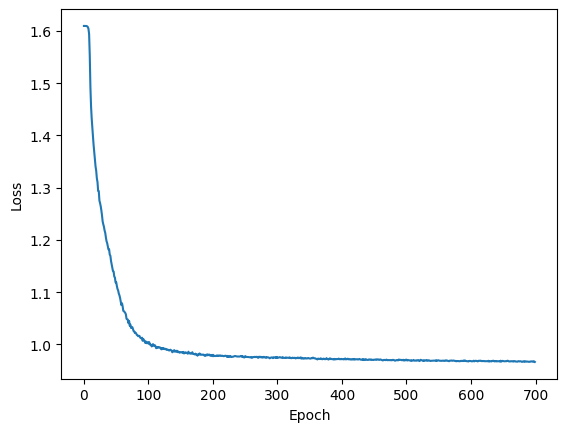

Test accuracy: 465.54021505376346
Accuracy: 0.4421505376344086
Precision: 0.43772215761170746
Recall: 0.4397390973366287
F1-score: 0.43842280627961683


Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.64      0.64       495
           1       0.39      0.38      0.38       472
           2       0.26      0.27      0.27       449
           3       0.33      0.30      0.31       463
           4       0.58      0.60      0.59       446

    accuracy                           0.44      2325
   macro avg       0.44      0.44      0.44      2325
weighted avg       0.44      0.44      0.44      2325

                    0           1           2           3           4  \
precision    0.627953    0.387931    0.256785    0.333333    0.582609   
recall       0.644444    0.381356    0.273942    0.298056    0.600897   
f1-score     0.636092    0.384615    0.265086    0.314709    0.591611   
support    495.000000  472.000000  449.0000

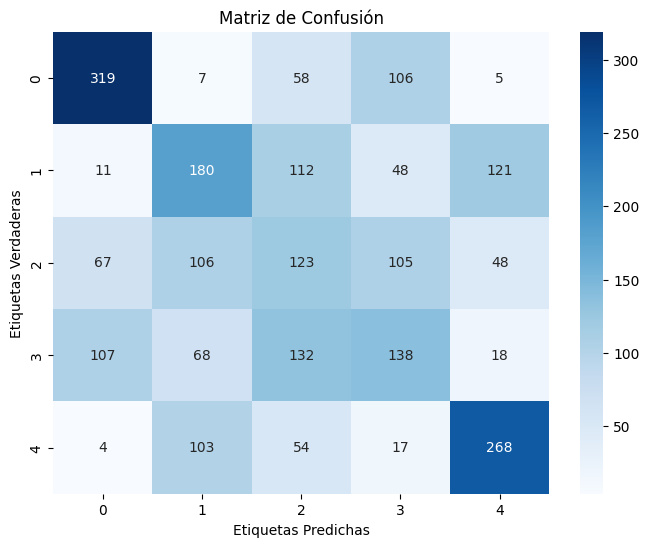

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_700_1e-05_0.1/resultados_700_1e-05_0.1.json
Procesando red con 1000 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.9


Procesando epocas:   0%|                                                              | 1/1000 [00:01<28:44,  1.73s/it]

1.6093113324221442


Procesando epocas:   0%|                                                              | 2/1000 [00:03<28:55,  1.74s/it]

1.5431565467049093


Procesando epocas:   0%|▏                                                             | 3/1000 [00:05<29:05,  1.75s/it]

1.416170786408817


Procesando epocas:   0%|▏                                                             | 4/1000 [00:06<29:01,  1.75s/it]

1.3660926019444186


Procesando epocas:   0%|▎                                                             | 5/1000 [00:08<28:57,  1.75s/it]

1.3344621798571419


Procesando epocas:   1%|▎                                                             | 6/1000 [00:10<28:56,  1.75s/it]

1.3071420382050907


Procesando epocas:   1%|▍                                                             | 7/1000 [00:12<28:56,  1.75s/it]

1.2756230179001302


Procesando epocas:   1%|▍                                                             | 8/1000 [00:13<28:47,  1.74s/it]

1.25174440425985


Procesando epocas:   1%|▌                                                             | 9/1000 [00:15<28:34,  1.73s/it]

1.2183124401990104


Procesando epocas:   1%|▌                                                            | 10/1000 [00:17<28:26,  1.72s/it]

1.193154850426842


Procesando epocas:   1%|▋                                                            | 11/1000 [00:19<28:30,  1.73s/it]

1.1622846196679508


Procesando epocas:   1%|▋                                                            | 12/1000 [00:20<28:40,  1.74s/it]

1.1354905822697807


Procesando epocas:   1%|▊                                                            | 13/1000 [00:22<28:30,  1.73s/it]

1.1191497381995705


Procesando epocas:   1%|▊                                                            | 14/1000 [00:24<28:31,  1.74s/it]

1.1001130798283745


Procesando epocas:   2%|▉                                                            | 15/1000 [00:26<28:28,  1.73s/it]

1.0952717994942385


Procesando epocas:   2%|▉                                                            | 16/1000 [00:27<28:28,  1.74s/it]

1.081413548483568


Procesando epocas:   2%|█                                                            | 17/1000 [00:29<28:26,  1.74s/it]

1.066343691068537


Procesando epocas:   2%|█                                                            | 18/1000 [00:31<28:25,  1.74s/it]

1.0631053559920367


Procesando epocas:   2%|█▏                                                           | 19/1000 [00:33<28:30,  1.74s/it]

1.05966774225235


Procesando epocas:   2%|█▏                                                           | 20/1000 [00:34<28:28,  1.74s/it]

1.0559613736236797


Procesando epocas:   2%|█▎                                                           | 21/1000 [00:36<28:23,  1.74s/it]

1.0523833769209245


Procesando epocas:   2%|█▎                                                           | 22/1000 [00:38<28:11,  1.73s/it]

1.046765535368639


Procesando epocas:   2%|█▍                                                           | 23/1000 [00:39<28:02,  1.72s/it]

1.0434890722527224


Procesando epocas:   2%|█▍                                                           | 24/1000 [00:41<27:55,  1.72s/it]

1.0403194427490234


Procesando epocas:   2%|█▌                                                           | 25/1000 [00:43<27:50,  1.71s/it]

1.042126360360314


Procesando epocas:   3%|█▌                                                           | 26/1000 [00:45<27:45,  1.71s/it]

1.0423137566622567


Procesando epocas:   3%|█▋                                                           | 27/1000 [00:46<27:41,  1.71s/it]

1.046318047537523


Procesando epocas:   3%|█▋                                                           | 28/1000 [00:48<27:42,  1.71s/it]

1.0423323452472686


Procesando epocas:   3%|█▊                                                           | 29/1000 [00:50<27:40,  1.71s/it]

1.0456182760350845


Procesando epocas:   3%|█▊                                                           | 30/1000 [00:51<27:38,  1.71s/it]

1.0380412263028762


Procesando epocas:   3%|█▉                                                           | 31/1000 [00:53<27:36,  1.71s/it]

1.0349484471713795


Procesando epocas:   3%|█▉                                                           | 32/1000 [00:55<27:34,  1.71s/it]

1.0334589968709385


Procesando epocas:   3%|██                                                           | 33/1000 [00:56<27:30,  1.71s/it]

1.0346282573307262


Procesando epocas:   3%|██                                                           | 34/1000 [00:58<27:27,  1.71s/it]

1.031078330558889


Procesando epocas:   4%|██▏                                                          | 35/1000 [01:00<27:26,  1.71s/it]

1.029757608385647


Procesando epocas:   4%|██▏                                                          | 36/1000 [01:02<27:26,  1.71s/it]

1.030946253678378


Procesando epocas:   4%|██▎                                                          | 37/1000 [01:03<27:23,  1.71s/it]

1.0328020232565263


Procesando epocas:   4%|██▎                                                          | 38/1000 [01:05<27:16,  1.70s/it]

1.027417024794747


Procesando epocas:   4%|██▍                                                          | 39/1000 [01:07<27:05,  1.69s/it]

1.0284594830344704


Procesando epocas:   4%|██▍                                                          | 40/1000 [01:08<27:11,  1.70s/it]

1.0256576103322645


Procesando epocas:   4%|██▌                                                          | 41/1000 [01:10<27:05,  1.69s/it]

1.0280053387669956


Procesando epocas:   4%|██▌                                                          | 42/1000 [01:12<27:03,  1.69s/it]

1.030677647450391


Procesando epocas:   4%|██▌                                                          | 43/1000 [01:13<26:59,  1.69s/it]

1.0306600640801822


Procesando epocas:   4%|██▋                                                          | 44/1000 [01:15<27:01,  1.70s/it]

1.0308428862515617


Procesando epocas:   4%|██▋                                                          | 45/1000 [01:17<26:46,  1.68s/it]

1.0358417966786553


Procesando epocas:   5%|██▊                                                          | 46/1000 [01:18<26:29,  1.67s/it]

1.0307151594582726


Procesando epocas:   5%|██▊                                                          | 47/1000 [01:20<26:34,  1.67s/it]

1.0294909210766063


Procesando epocas:   5%|██▉                                                          | 48/1000 [01:22<26:34,  1.68s/it]

1.0265221234630135


Procesando epocas:   5%|██▉                                                          | 49/1000 [01:24<26:42,  1.69s/it]

1.0217480042401481


Procesando epocas:   5%|███                                                          | 50/1000 [01:25<26:37,  1.68s/it]

1.0193870765321396


Procesando epocas:   5%|███                                                          | 51/1000 [01:27<26:39,  1.69s/it]

1.0197806694928337


Procesando epocas:   5%|███▏                                                         | 52/1000 [01:29<26:36,  1.68s/it]

1.017995737580692


Procesando epocas:   5%|███▏                                                         | 53/1000 [01:30<26:47,  1.70s/it]

1.02818403524511


Procesando epocas:   5%|███▎                                                         | 54/1000 [01:32<26:48,  1.70s/it]

1.0289564462269054


Procesando epocas:   6%|███▎                                                         | 55/1000 [01:34<26:41,  1.69s/it]

1.0284023751230802


Procesando epocas:   6%|███▍                                                         | 56/1000 [01:35<26:34,  1.69s/it]

1.0261504096143386


Procesando epocas:   6%|███▍                                                         | 57/1000 [01:37<26:34,  1.69s/it]

1.025767949398826


Procesando epocas:   6%|███▌                                                         | 58/1000 [01:39<26:27,  1.69s/it]

1.0281191240338718


Procesando epocas:   6%|███▌                                                         | 59/1000 [01:40<26:24,  1.68s/it]

1.0267161208040574


Procesando epocas:   6%|███▋                                                         | 60/1000 [01:42<26:21,  1.68s/it]

1.0234539498301114


Procesando epocas:   6%|███▋                                                         | 61/1000 [01:44<26:18,  1.68s/it]

1.0255096309325273


Procesando epocas:   6%|███▊                                                         | 62/1000 [01:45<26:18,  1.68s/it]

1.023768593633876


Procesando epocas:   6%|███▊                                                         | 63/1000 [01:47<26:15,  1.68s/it]

1.0222849183222826


Procesando epocas:   6%|███▉                                                         | 64/1000 [01:49<26:23,  1.69s/it]

1.020429064947016


Procesando epocas:   6%|███▉                                                         | 65/1000 [01:51<26:21,  1.69s/it]

1.0207540466504939


Procesando epocas:   7%|████                                                         | 66/1000 [01:52<26:16,  1.69s/it]

1.0191827139433693


Procesando epocas:   7%|████                                                         | 67/1000 [01:54<26:10,  1.68s/it]

1.0189416142070995


Procesando epocas:   7%|████▏                                                        | 68/1000 [01:56<26:09,  1.68s/it]

1.0175776762120865


Procesando epocas:   7%|████▏                                                        | 69/1000 [01:57<26:07,  1.68s/it]

1.0168033862815185


Procesando epocas:   7%|████▎                                                        | 70/1000 [01:59<26:10,  1.69s/it]

1.0191251270911272


Procesando epocas:   7%|████▎                                                        | 71/1000 [02:01<26:09,  1.69s/it]

1.014768005469266


Procesando epocas:   7%|████▍                                                        | 72/1000 [02:02<26:08,  1.69s/it]

1.0171019147424136


Procesando epocas:   7%|████▍                                                        | 73/1000 [02:04<25:58,  1.68s/it]

1.0150555035647224


Procesando epocas:   7%|████▌                                                        | 74/1000 [02:06<25:47,  1.67s/it]

1.0137782188022837


Procesando epocas:   8%|████▌                                                        | 75/1000 [02:07<25:33,  1.66s/it]

1.0141006168197184


Procesando epocas:   8%|████▋                                                        | 76/1000 [02:09<25:32,  1.66s/it]

1.0140023992342106


Procesando epocas:   8%|████▋                                                        | 77/1000 [02:11<25:31,  1.66s/it]

1.0152545750141144


Procesando epocas:   8%|████▊                                                        | 78/1000 [02:12<25:21,  1.65s/it]

1.0196857206961687


Procesando epocas:   8%|████▊                                                        | 79/1000 [02:14<25:13,  1.64s/it]

1.0230992829098422


Procesando epocas:   8%|████▉                                                        | 80/1000 [02:15<25:07,  1.64s/it]

1.0230253724490894


Procesando epocas:   8%|████▉                                                        | 81/1000 [02:17<25:02,  1.63s/it]

1.0182319630594814


Procesando epocas:   8%|█████                                                        | 82/1000 [02:19<25:02,  1.64s/it]

1.0172478563645306


Procesando epocas:   8%|█████                                                        | 83/1000 [02:20<24:56,  1.63s/it]

1.016040594437543


Procesando epocas:   8%|█████                                                        | 84/1000 [02:22<25:08,  1.65s/it]

1.0156597235623528


Procesando epocas:   8%|█████▏                                                       | 85/1000 [02:24<25:10,  1.65s/it]

1.0182754951364854


Procesando epocas:   9%|█████▏                                                       | 86/1000 [02:25<25:13,  1.66s/it]

1.0162128175006193


Procesando epocas:   9%|█████▎                                                       | 87/1000 [02:27<25:09,  1.65s/it]

1.0167607040966258


Procesando epocas:   9%|█████▎                                                       | 88/1000 [02:29<25:10,  1.66s/it]

1.0135193596867953


Procesando epocas:   9%|█████▍                                                       | 89/1000 [02:30<25:08,  1.66s/it]

1.013699824669782


Procesando epocas:   9%|█████▍                                                       | 90/1000 [02:32<25:03,  1.65s/it]

1.0129105070058038


Procesando epocas:   9%|█████▌                                                       | 91/1000 [02:34<25:09,  1.66s/it]

1.0136061766568352


Procesando epocas:   9%|█████▌                                                       | 92/1000 [02:35<25:01,  1.65s/it]

1.010776080454097


Procesando epocas:   9%|█████▋                                                       | 93/1000 [02:37<25:08,  1.66s/it]

1.0106516515507418


Procesando epocas:   9%|█████▋                                                       | 94/1000 [02:39<25:03,  1.66s/it]

1.0101390912252315


Procesando epocas:  10%|█████▊                                                       | 95/1000 [02:40<25:08,  1.67s/it]

1.0110405904405257


Procesando epocas:  10%|█████▊                                                       | 96/1000 [02:42<25:06,  1.67s/it]

1.013968908436158


Procesando epocas:  10%|█████▉                                                       | 97/1000 [02:44<25:07,  1.67s/it]

1.0148650562061983


Procesando epocas:  10%|█████▉                                                       | 98/1000 [02:45<25:04,  1.67s/it]

1.013091690049452


Procesando epocas:  10%|██████                                                       | 99/1000 [02:47<24:58,  1.66s/it]

1.011989648552502


Procesando epocas:  10%|██████                                                      | 100/1000 [02:49<25:02,  1.67s/it]

1.008085414241342


Procesando epocas:  10%|██████                                                      | 101/1000 [02:50<25:05,  1.67s/it]

1.0104035265305462


Procesando epocas:  10%|██████                                                      | 102/1000 [02:52<25:05,  1.68s/it]

1.011085355983061


Procesando epocas:  10%|██████▏                                                     | 103/1000 [02:54<25:12,  1.69s/it]

1.0114726529401892


Procesando epocas:  10%|██████▏                                                     | 104/1000 [02:55<25:25,  1.70s/it]

1.0127959002466762


Procesando epocas:  10%|██████▎                                                     | 105/1000 [02:57<25:36,  1.72s/it]

1.0128504395484925


Procesando epocas:  11%|██████▎                                                     | 106/1000 [02:59<25:45,  1.73s/it]

1.0131274265401504


Procesando epocas:  11%|██████▍                                                     | 107/1000 [03:01<25:45,  1.73s/it]

1.017737914534176


Procesando epocas:  11%|██████▍                                                     | 108/1000 [03:02<25:45,  1.73s/it]

1.0170128233292524


Procesando epocas:  11%|██████▌                                                     | 109/1000 [03:04<25:53,  1.74s/it]

1.0148808524889104


Procesando epocas:  11%|██████▌                                                     | 110/1000 [03:06<25:51,  1.74s/it]

1.0131386581589195


Procesando epocas:  11%|██████▋                                                     | 111/1000 [03:08<25:47,  1.74s/it]

1.013738736334969


Procesando epocas:  11%|██████▋                                                     | 112/1000 [03:09<25:45,  1.74s/it]

1.0094713740489063


Procesando epocas:  11%|██████▊                                                     | 113/1000 [03:11<25:44,  1.74s/it]

1.0098589504466338


Procesando epocas:  11%|██████▊                                                     | 114/1000 [03:13<25:46,  1.75s/it]

1.008815768185784


Procesando epocas:  12%|██████▉                                                     | 115/1000 [03:15<25:42,  1.74s/it]

1.0088008081211763


Procesando epocas:  12%|██████▉                                                     | 116/1000 [03:16<25:39,  1.74s/it]

1.0090174443581525


Procesando epocas:  12%|███████                                                     | 117/1000 [03:18<25:39,  1.74s/it]

1.010316322480931


Procesando epocas:  12%|███████                                                     | 118/1000 [03:20<25:37,  1.74s/it]

1.0099125630715313


Procesando epocas:  12%|███████▏                                                    | 119/1000 [03:22<25:34,  1.74s/it]

1.0100272157612968


Procesando epocas:  12%|███████▏                                                    | 120/1000 [03:23<25:35,  1.74s/it]

1.0101498814190135


Procesando epocas:  12%|███████▎                                                    | 121/1000 [03:25<25:35,  1.75s/it]

1.0103901239002453


Procesando epocas:  12%|███████▎                                                    | 122/1000 [03:27<25:36,  1.75s/it]

1.0140019721844618


Procesando epocas:  12%|███████▍                                                    | 123/1000 [03:29<25:33,  1.75s/it]

1.0129434052635642


Procesando epocas:  12%|███████▍                                                    | 124/1000 [03:30<25:30,  1.75s/it]

1.0102548388873829


Procesando epocas:  12%|███████▌                                                    | 125/1000 [03:32<25:26,  1.74s/it]

1.0086844353114857


Procesando epocas:  13%|███████▌                                                    | 126/1000 [03:34<25:26,  1.75s/it]

1.0102527092484868


Procesando epocas:  13%|███████▌                                                    | 127/1000 [03:36<25:29,  1.75s/it]

1.011634902042501


Procesando epocas:  13%|███████▋                                                    | 128/1000 [03:37<25:36,  1.76s/it]

1.010377329938552


Procesando epocas:  13%|███████▋                                                    | 129/1000 [03:39<25:42,  1.77s/it]

1.0089106833233552


Procesando epocas:  13%|███████▊                                                    | 130/1000 [03:41<25:36,  1.77s/it]

1.0078356287058663


Procesando epocas:  13%|███████▊                                                    | 131/1000 [03:43<25:34,  1.77s/it]

1.0080595258404226


Procesando epocas:  13%|███████▉                                                    | 132/1000 [03:45<25:35,  1.77s/it]

1.009411295371897


Procesando epocas:  13%|███████▉                                                    | 133/1000 [03:46<25:32,  1.77s/it]

1.0109233523116392


Procesando epocas:  13%|████████                                                    | 134/1000 [03:48<25:26,  1.76s/it]

1.0103450059890746


Procesando epocas:  14%|████████                                                    | 135/1000 [03:50<25:19,  1.76s/it]

1.0086520983892329


Procesando epocas:  14%|████████▏                                                   | 136/1000 [03:52<25:08,  1.75s/it]

1.0078336743747487


Procesando epocas:  14%|████████▏                                                   | 137/1000 [03:53<25:00,  1.74s/it]

1.0076280418564292


Procesando epocas:  14%|████████▎                                                   | 138/1000 [03:55<24:58,  1.74s/it]

1.0064780189710505


Procesando epocas:  14%|████████▎                                                   | 139/1000 [03:57<24:53,  1.74s/it]

1.0097707786980796


Procesando epocas:  14%|████████▍                                                   | 140/1000 [03:58<24:52,  1.74s/it]

1.0097317814826965


Procesando epocas:  14%|████████▍                                                   | 141/1000 [04:00<24:50,  1.73s/it]

1.0120339397121878


Procesando epocas:  14%|████████▌                                                   | 142/1000 [04:02<24:33,  1.72s/it]

1.0099350708372452


Procesando epocas:  14%|████████▌                                                   | 143/1000 [04:04<24:16,  1.70s/it]

1.0107890385038711


Procesando epocas:  14%|████████▋                                                   | 144/1000 [04:05<24:19,  1.70s/it]

1.0130681090495166


Procesando epocas:  14%|████████▋                                                   | 145/1000 [04:07<24:26,  1.72s/it]

1.0067530249848085


Procesando epocas:  15%|████████▊                                                   | 146/1000 [04:09<24:27,  1.72s/it]

1.0054693579673768


Procesando epocas:  15%|████████▊                                                   | 147/1000 [04:10<24:30,  1.72s/it]

1.0067798772278953


Procesando epocas:  15%|████████▉                                                   | 148/1000 [04:12<24:28,  1.72s/it]

1.0038309184943928


Procesando epocas:  15%|████████▉                                                   | 149/1000 [04:14<24:31,  1.73s/it]

1.0025877282899969


Procesando epocas:  15%|█████████                                                   | 150/1000 [04:16<24:31,  1.73s/it]

1.0031714414849


Procesando epocas:  15%|█████████                                                   | 151/1000 [04:17<24:30,  1.73s/it]

1.0030970941571629


Procesando epocas:  15%|█████████                                                   | 152/1000 [04:19<24:28,  1.73s/it]

1.0026035056394689


Procesando epocas:  15%|█████████▏                                                  | 153/1000 [04:21<24:31,  1.74s/it]

1.005771886951783


Procesando epocas:  15%|█████████▏                                                  | 154/1000 [04:23<24:22,  1.73s/it]

1.0032713265979991


Procesando epocas:  16%|█████████▎                                                  | 155/1000 [04:24<24:14,  1.72s/it]

1.0019453381790835


Procesando epocas:  16%|█████████▎                                                  | 156/1000 [04:26<24:19,  1.73s/it]

1.0018057644367218


Procesando epocas:  16%|█████████▍                                                  | 157/1000 [04:28<24:16,  1.73s/it]

1.0025137687430663


Procesando epocas:  16%|█████████▍                                                  | 158/1000 [04:29<24:13,  1.73s/it]

1.0026018773808199


Procesando epocas:  16%|█████████▌                                                  | 159/1000 [04:31<24:06,  1.72s/it]

1.0033969426856322


Procesando epocas:  16%|█████████▌                                                  | 160/1000 [04:33<24:02,  1.72s/it]

1.0068160334054161


Procesando epocas:  16%|█████████▋                                                  | 161/1000 [04:35<23:57,  1.71s/it]

1.0024951784049763


Procesando epocas:  16%|█████████▋                                                  | 162/1000 [04:36<23:54,  1.71s/it]

1.0020283818244935


Procesando epocas:  16%|█████████▊                                                  | 163/1000 [04:38<23:50,  1.71s/it]

1.003756402871188


Procesando epocas:  16%|█████████▊                                                  | 164/1000 [04:40<23:46,  1.71s/it]

1.001327142645331


Procesando epocas:  16%|█████████▉                                                  | 165/1000 [04:41<23:45,  1.71s/it]

1.0014126858290504


Procesando epocas:  17%|█████████▉                                                  | 166/1000 [04:43<23:44,  1.71s/it]

0.999753029907451


Procesando epocas:  17%|██████████                                                  | 167/1000 [04:45<23:40,  1.71s/it]

1.0032633528989905


Procesando epocas:  17%|██████████                                                  | 168/1000 [04:47<23:38,  1.71s/it]

1.0002506834619185


Procesando epocas:  17%|██████████▏                                                 | 169/1000 [04:48<23:37,  1.71s/it]

0.9987509120913113


Procesando epocas:  17%|██████████▏                                                 | 170/1000 [04:50<23:33,  1.70s/it]

1.001173146682627


Procesando epocas:  17%|██████████▎                                                 | 171/1000 [04:52<23:32,  1.70s/it]

0.9978739889229045


Procesando epocas:  17%|██████████▎                                                 | 172/1000 [04:53<23:30,  1.70s/it]

1.0001950176323162


Procesando epocas:  17%|██████████▍                                                 | 173/1000 [04:55<23:29,  1.70s/it]

0.9979744553565979


Procesando epocas:  17%|██████████▍                                                 | 174/1000 [04:57<23:28,  1.71s/it]

0.9983030785532558


Procesando epocas:  18%|██████████▌                                                 | 175/1000 [04:58<23:27,  1.71s/it]

0.9992129732580746


Procesando epocas:  18%|██████████▌                                                 | 176/1000 [05:00<23:26,  1.71s/it]

0.9984762090093949


Procesando epocas:  18%|██████████▌                                                 | 177/1000 [05:02<23:25,  1.71s/it]

0.9996199905872345


Procesando epocas:  18%|██████████▋                                                 | 178/1000 [05:04<23:21,  1.70s/it]

0.9987597234108869


Procesando epocas:  18%|██████████▋                                                 | 179/1000 [05:05<23:18,  1.70s/it]

0.9982073787380668


Procesando epocas:  18%|██████████▊                                                 | 180/1000 [05:07<23:17,  1.70s/it]

0.997527634045657


Procesando epocas:  18%|██████████▊                                                 | 181/1000 [05:09<23:16,  1.71s/it]

0.9985433802885167


Procesando epocas:  18%|██████████▉                                                 | 182/1000 [05:10<23:14,  1.70s/it]

1.0010025539818932


Procesando epocas:  18%|██████████▉                                                 | 183/1000 [05:12<23:11,  1.70s/it]

1.0030751445714166


Procesando epocas:  18%|███████████                                                 | 184/1000 [05:14<23:12,  1.71s/it]

1.0004528718836168


Procesando epocas:  18%|███████████                                                 | 185/1000 [05:16<23:17,  1.72s/it]

1.0013794948072994


Procesando epocas:  19%|███████████▏                                                | 186/1000 [05:17<23:11,  1.71s/it]

1.0031421903301687


Procesando epocas:  19%|███████████▏                                                | 187/1000 [05:19<23:07,  1.71s/it]

1.0009774607770583


Procesando epocas:  19%|███████████▎                                                | 188/1000 [05:21<23:04,  1.70s/it]

0.9999421571984011


Procesando epocas:  19%|███████████▎                                                | 189/1000 [05:22<23:01,  1.70s/it]

0.9994122571804944


Procesando epocas:  19%|███████████▍                                                | 190/1000 [05:24<22:59,  1.70s/it]

0.9986510778174681


Procesando epocas:  19%|███████████▍                                                | 191/1000 [05:26<22:57,  1.70s/it]

0.9997892989831813


Procesando epocas:  19%|███████████▌                                                | 192/1000 [05:27<22:55,  1.70s/it]

0.9983563987647786


Procesando epocas:  19%|███████████▌                                                | 193/1000 [05:29<22:54,  1.70s/it]

0.9977814951363732


Procesando epocas:  19%|███████████▋                                                | 194/1000 [05:31<22:55,  1.71s/it]

0.9985701943145079


Procesando epocas:  20%|███████████▋                                                | 195/1000 [05:33<22:54,  1.71s/it]

0.9980666090460385


Procesando epocas:  20%|███████████▊                                                | 196/1000 [05:34<22:51,  1.71s/it]

0.9970044704044566


Procesando epocas:  20%|███████████▊                                                | 197/1000 [05:36<22:49,  1.71s/it]

1.0004811767269584


Procesando epocas:  20%|███████████▉                                                | 198/1000 [05:38<22:46,  1.70s/it]

0.9989633433959063


Procesando epocas:  20%|███████████▉                                                | 199/1000 [05:39<22:43,  1.70s/it]

0.9990670579321245


Procesando epocas:  20%|████████████                                                | 200/1000 [05:41<22:35,  1.69s/it]

0.9956094692735111


Procesando epocas:  20%|████████████                                                | 201/1000 [05:43<22:32,  1.69s/it]

0.995910281644148


Procesando epocas:  20%|████████████                                                | 202/1000 [05:44<22:18,  1.68s/it]

0.9959521111320047


Procesando epocas:  20%|████████████▏                                               | 203/1000 [05:46<22:10,  1.67s/it]

0.9947460514657638


Procesando epocas:  20%|████████████▏                                               | 204/1000 [05:48<22:10,  1.67s/it]

0.9982196011964013


Procesando epocas:  20%|████████████▎                                               | 205/1000 [05:49<22:00,  1.66s/it]

0.9957155336351956


Procesando epocas:  21%|████████████▎                                               | 206/1000 [05:51<21:56,  1.66s/it]

0.997594787794001


Procesando epocas:  21%|████████████▍                                               | 207/1000 [05:53<21:54,  1.66s/it]

0.9965022532378927


Procesando epocas:  21%|████████████▍                                               | 208/1000 [05:54<21:58,  1.67s/it]

0.9981379165368922


Procesando epocas:  21%|████████████▌                                               | 209/1000 [05:56<21:55,  1.66s/it]

0.997471616899266


Procesando epocas:  21%|████████████▌                                               | 210/1000 [05:58<21:58,  1.67s/it]

1.0009809662314022


Procesando epocas:  21%|████████████▋                                               | 211/1000 [05:59<22:18,  1.70s/it]

1.001954669461531


Procesando epocas:  21%|████████████▋                                               | 212/1000 [06:01<22:25,  1.71s/it]

1.0060128348715165


Procesando epocas:  21%|████████████▊                                               | 213/1000 [06:03<22:34,  1.72s/it]

1.0001891087083254


Procesando epocas:  21%|████████████▊                                               | 214/1000 [06:05<22:41,  1.73s/it]

0.9978572757805095


Procesando epocas:  22%|████████████▉                                               | 215/1000 [06:06<22:35,  1.73s/it]

0.9969187056317049


Procesando epocas:  22%|████████████▉                                               | 216/1000 [06:08<22:42,  1.74s/it]

0.996923501701916


Procesando epocas:  22%|█████████████                                               | 217/1000 [06:10<22:41,  1.74s/it]

0.9981124790275798


Procesando epocas:  22%|█████████████                                               | 218/1000 [06:12<22:42,  1.74s/it]

0.9956540293553297


Procesando epocas:  22%|█████████████▏                                              | 219/1000 [06:13<22:38,  1.74s/it]

0.9952996583545909


Procesando epocas:  22%|█████████████▏                                              | 220/1000 [06:15<22:38,  1.74s/it]

0.9982571118018206


Procesando epocas:  22%|█████████████▎                                              | 221/1000 [06:17<22:41,  1.75s/it]

1.002385017451118


Procesando epocas:  22%|█████████████▎                                              | 222/1000 [06:19<22:40,  1.75s/it]

1.0051131118746366


Procesando epocas:  22%|█████████████▍                                              | 223/1000 [06:20<22:35,  1.74s/it]

0.9983393767300774


Procesando epocas:  22%|█████████████▍                                              | 224/1000 [06:22<22:33,  1.74s/it]

0.9969951966229607


Procesando epocas:  22%|█████████████▌                                              | 225/1000 [06:24<22:31,  1.74s/it]

0.9998200728612787


Procesando epocas:  23%|█████████████▌                                              | 226/1000 [06:26<22:27,  1.74s/it]

0.9969764320289387


Procesando epocas:  23%|█████████████▌                                              | 227/1000 [06:27<22:25,  1.74s/it]

0.9988837540149689


Procesando epocas:  23%|█████████████▋                                              | 228/1000 [06:29<22:25,  1.74s/it]

0.9974929536090178


Procesando epocas:  23%|█████████████▋                                              | 229/1000 [06:31<22:26,  1.75s/it]

0.998379397392273


Procesando epocas:  23%|█████████████▊                                              | 230/1000 [06:33<22:27,  1.75s/it]

0.9992584119824802


Procesando epocas:  23%|█████████████▊                                              | 231/1000 [06:34<22:27,  1.75s/it]

0.9993601181927849


Procesando epocas:  23%|█████████████▉                                              | 232/1000 [06:36<22:28,  1.76s/it]

0.9966700574930977


Procesando epocas:  23%|█████████████▉                                              | 233/1000 [06:38<22:28,  1.76s/it]

0.9964775453595555


Procesando epocas:  23%|██████████████                                              | 234/1000 [06:40<22:28,  1.76s/it]

0.9966942601344164


Procesando epocas:  24%|██████████████                                              | 235/1000 [06:41<22:27,  1.76s/it]

0.9941325128078461


Procesando epocas:  24%|██████████████▏                                             | 236/1000 [06:43<22:20,  1.76s/it]

0.9952016904073603


Procesando epocas:  24%|██████████████▏                                             | 237/1000 [06:45<21:57,  1.73s/it]

0.9946089576272403


Procesando epocas:  24%|██████████████▎                                             | 238/1000 [06:46<21:45,  1.71s/it]

0.9943885484162499


Procesando epocas:  24%|██████████████▎                                             | 239/1000 [06:48<21:36,  1.70s/it]

0.9960547191255232


Procesando epocas:  24%|██████████████▍                                             | 240/1000 [06:50<21:26,  1.69s/it]

0.9983751268947826


Procesando epocas:  24%|██████████████▍                                             | 241/1000 [06:52<21:19,  1.69s/it]

0.9948331468245563


Procesando epocas:  24%|██████████████▌                                             | 242/1000 [06:53<21:13,  1.68s/it]

0.999554077316733


Procesando epocas:  24%|██████████████▌                                             | 243/1000 [06:55<21:11,  1.68s/it]

0.9949134104392108


Procesando epocas:  24%|██████████████▋                                             | 244/1000 [06:57<21:06,  1.68s/it]

0.992415122424855


Procesando epocas:  24%|██████████████▋                                             | 245/1000 [06:58<21:04,  1.67s/it]

0.992189127557418


Procesando epocas:  25%|██████████████▊                                             | 246/1000 [07:00<21:01,  1.67s/it]

0.9928402679807999


Procesando epocas:  25%|██████████████▊                                             | 247/1000 [07:02<20:59,  1.67s/it]

0.9927490507855135


Procesando epocas:  25%|██████████████▉                                             | 248/1000 [07:03<20:55,  1.67s/it]

0.9971563009654775


Procesando epocas:  25%|██████████████▉                                             | 249/1000 [07:05<20:53,  1.67s/it]

0.9996314697405871


Procesando epocas:  25%|███████████████                                             | 250/1000 [07:07<20:51,  1.67s/it]

0.997388734887628


Procesando epocas:  25%|███████████████                                             | 251/1000 [07:08<20:49,  1.67s/it]

0.9962980175719541


Procesando epocas:  25%|███████████████                                             | 252/1000 [07:10<20:47,  1.67s/it]

0.9957995428758509


Procesando epocas:  25%|███████████████▏                                            | 253/1000 [07:12<20:46,  1.67s/it]

0.9942492250133963


Procesando epocas:  25%|███████████████▏                                            | 254/1000 [07:13<20:44,  1.67s/it]

0.9934938027578242


Procesando epocas:  26%|███████████████▎                                            | 255/1000 [07:15<20:42,  1.67s/it]

0.9937668081592111


Procesando epocas:  26%|███████████████▎                                            | 256/1000 [07:17<20:41,  1.67s/it]

0.9936408526757184


Procesando epocas:  26%|███████████████▍                                            | 257/1000 [07:18<20:49,  1.68s/it]

0.9937247942475712


Procesando epocas:  26%|███████████████▍                                            | 258/1000 [07:20<20:45,  1.68s/it]

0.99905206526027


Procesando epocas:  26%|███████████████▌                                            | 259/1000 [07:22<20:40,  1.67s/it]

0.995155503469355


Procesando epocas:  26%|███████████████▌                                            | 260/1000 [07:23<20:31,  1.66s/it]

0.9941929007277769


Procesando epocas:  26%|███████████████▋                                            | 261/1000 [07:25<20:22,  1.65s/it]

0.9955747481654672


Procesando epocas:  26%|███████████████▋                                            | 262/1000 [07:26<20:15,  1.65s/it]

0.996595484719557


Procesando epocas:  26%|███████████████▊                                            | 263/1000 [07:28<20:09,  1.64s/it]

1.0020158967551063


Procesando epocas:  26%|███████████████▊                                            | 264/1000 [07:30<20:05,  1.64s/it]

0.996910438116859


Procesando epocas:  26%|███████████████▉                                            | 265/1000 [07:31<20:01,  1.64s/it]

0.9957307131851421


Procesando epocas:  27%|███████████████▉                                            | 266/1000 [07:33<19:57,  1.63s/it]

0.9981328291051528


Procesando epocas:  27%|████████████████                                            | 267/1000 [07:35<19:56,  1.63s/it]

0.9967418881023631


Procesando epocas:  27%|████████████████                                            | 268/1000 [07:36<19:54,  1.63s/it]

0.9941188661491169


Procesando epocas:  27%|████████████████▏                                           | 269/1000 [07:38<19:53,  1.63s/it]

0.9962403413127451


Procesando epocas:  27%|████████████████▏                                           | 270/1000 [07:40<19:52,  1.63s/it]

0.9988773366984199


Procesando epocas:  27%|████████████████▎                                           | 271/1000 [07:41<19:50,  1.63s/it]

0.9957186085336348


Procesando epocas:  27%|████████████████▎                                           | 272/1000 [07:43<19:47,  1.63s/it]

0.9963466816088733


Procesando epocas:  27%|████████████████▍                                           | 273/1000 [07:44<19:46,  1.63s/it]

0.9954748353537392


Procesando epocas:  27%|████████████████▍                                           | 274/1000 [07:46<19:44,  1.63s/it]

0.9927778759423425


Procesando epocas:  28%|████████████████▌                                           | 275/1000 [07:48<19:43,  1.63s/it]

0.9939195766168483


Procesando epocas:  28%|████████████████▌                                           | 276/1000 [07:49<19:40,  1.63s/it]

0.9915132126387428


Procesando epocas:  28%|████████████████▌                                           | 277/1000 [07:51<19:37,  1.63s/it]

0.9918721738983604


Procesando epocas:  28%|████████████████▋                                           | 278/1000 [07:53<19:35,  1.63s/it]

0.9923785444568185


Procesando epocas:  28%|████████████████▋                                           | 279/1000 [07:54<19:33,  1.63s/it]

0.992101611810572


Procesando epocas:  28%|████████████████▊                                           | 280/1000 [07:56<19:30,  1.63s/it]

0.9931585417074316


Procesando epocas:  28%|████████████████▊                                           | 281/1000 [07:57<19:31,  1.63s/it]

0.9921111425932716


Procesando epocas:  28%|████████████████▉                                           | 282/1000 [07:59<19:28,  1.63s/it]

0.9916927853051354


Procesando epocas:  28%|████████████████▉                                           | 283/1000 [08:01<19:28,  1.63s/it]

0.9913187279420741


Procesando epocas:  28%|█████████████████                                           | 284/1000 [08:02<19:27,  1.63s/it]

0.9919990441378426


Procesando epocas:  28%|█████████████████                                           | 285/1000 [08:04<19:30,  1.64s/it]

0.9918707882656771


Procesando epocas:  29%|█████████████████▏                                          | 286/1000 [08:06<19:34,  1.64s/it]

0.9909834598793703


Procesando epocas:  29%|█████████████████▏                                          | 287/1000 [08:07<19:28,  1.64s/it]

0.9906470814171959


Procesando epocas:  29%|█████████████████▎                                          | 288/1000 [08:09<19:24,  1.64s/it]

0.9942476146361408


Procesando epocas:  29%|█████████████████▎                                          | 289/1000 [08:11<19:20,  1.63s/it]

0.9923537412110497


Procesando epocas:  29%|█████████████████▍                                          | 290/1000 [08:12<19:19,  1.63s/it]

0.9945434840286479


Procesando epocas:  29%|█████████████████▍                                          | 291/1000 [08:14<19:16,  1.63s/it]

0.995864672871197


Procesando epocas:  29%|█████████████████▌                                          | 292/1000 [08:15<19:12,  1.63s/it]

0.9938464603003334


Procesando epocas:  29%|█████████████████▌                                          | 293/1000 [08:17<19:12,  1.63s/it]

0.9930684152771445


Procesando epocas:  29%|█████████████████▋                                          | 294/1000 [08:19<19:13,  1.63s/it]

0.9911537594654981


Procesando epocas:  30%|█████████████████▋                                          | 295/1000 [08:20<19:09,  1.63s/it]

0.9907651659320382


Procesando epocas:  30%|█████████████████▊                                          | 296/1000 [08:22<19:10,  1.63s/it]

0.9908665001392365


Procesando epocas:  30%|█████████████████▊                                          | 297/1000 [08:24<19:07,  1.63s/it]

0.990625835166258


Procesando epocas:  30%|█████████████████▉                                          | 298/1000 [08:25<19:04,  1.63s/it]

0.9901585010921254


Procesando epocas:  30%|█████████████████▉                                          | 299/1000 [08:27<19:04,  1.63s/it]

0.9899907294441672


Procesando epocas:  30%|██████████████████                                          | 300/1000 [08:28<19:04,  1.63s/it]

0.9890373682274538


Procesando epocas:  30%|██████████████████                                          | 301/1000 [08:30<19:01,  1.63s/it]

0.9912961391841664


Procesando epocas:  30%|██████████████████                                          | 302/1000 [08:32<18:57,  1.63s/it]

0.992357938079273


Procesando epocas:  30%|██████████████████▏                                         | 303/1000 [08:33<19:00,  1.64s/it]

0.991637662228416


Procesando epocas:  30%|██████████████████▏                                         | 304/1000 [08:35<18:57,  1.63s/it]

0.992675299504224


Procesando epocas:  30%|██████████████████▎                                         | 305/1000 [08:37<18:54,  1.63s/it]

0.9915960950009963


Procesando epocas:  31%|██████████████████▎                                         | 306/1000 [08:38<18:50,  1.63s/it]

0.9970551666091471


Procesando epocas:  31%|██████████████████▍                                         | 307/1000 [08:40<18:47,  1.63s/it]

0.9921335791840272


Procesando epocas:  31%|██████████████████▍                                         | 308/1000 [08:42<18:46,  1.63s/it]

0.9905084687120774


Procesando epocas:  31%|██████████████████▌                                         | 309/1000 [08:43<18:43,  1.63s/it]

0.99072066580548


Procesando epocas:  31%|██████████████████▌                                         | 310/1000 [08:45<18:44,  1.63s/it]

0.9917177600019118


Procesando epocas:  31%|██████████████████▋                                         | 311/1000 [08:46<18:42,  1.63s/it]

0.9879837477908415


Procesando epocas:  31%|██████████████████▋                                         | 312/1000 [08:48<18:39,  1.63s/it]

0.9903594749815324


Procesando epocas:  31%|██████████████████▊                                         | 313/1000 [08:50<18:36,  1.63s/it]

0.9907749077853034


Procesando epocas:  31%|██████████████████▊                                         | 314/1000 [08:51<18:33,  1.62s/it]

0.9927945631391862


Procesando epocas:  32%|██████████████████▉                                         | 315/1000 [08:53<18:32,  1.62s/it]

0.9894637300687678


Procesando epocas:  32%|██████████████████▉                                         | 316/1000 [08:55<18:31,  1.63s/it]

0.9896601645385518


Procesando epocas:  32%|███████████████████                                         | 317/1000 [08:56<18:29,  1.62s/it]

0.9886206307831933


Procesando epocas:  32%|███████████████████                                         | 318/1000 [08:58<18:28,  1.63s/it]

0.9869121642673717


Procesando epocas:  32%|███████████████████▏                                        | 319/1000 [08:59<18:43,  1.65s/it]

0.9901797066716587


Procesando epocas:  32%|███████████████████▏                                        | 320/1000 [09:01<19:01,  1.68s/it]

0.9881277596249299


Procesando epocas:  32%|███████████████████▎                                        | 321/1000 [09:03<19:13,  1.70s/it]

0.9870103008606854


Procesando epocas:  32%|███████████████████▎                                        | 322/1000 [09:05<19:20,  1.71s/it]

0.987205884737127


Procesando epocas:  32%|███████████████████▍                                        | 323/1000 [09:06<19:26,  1.72s/it]

0.9862160493345822


Procesando epocas:  32%|███████████████████▍                                        | 324/1000 [09:08<19:29,  1.73s/it]

0.9860744707724627


Procesando epocas:  32%|███████████████████▌                                        | 325/1000 [09:10<19:30,  1.73s/it]

0.9920075704069699


Procesando epocas:  33%|███████████████████▌                                        | 326/1000 [09:12<19:30,  1.74s/it]

0.987181958731483


Procesando epocas:  33%|███████████████████▌                                        | 327/1000 [09:13<19:30,  1.74s/it]

0.9864976314937367


Procesando epocas:  33%|███████████████████▋                                        | 328/1000 [09:15<19:28,  1.74s/it]

0.9862017189755159


Procesando epocas:  33%|███████████████████▋                                        | 329/1000 [09:17<19:28,  1.74s/it]

0.9877496975309709


Procesando epocas:  33%|███████████████████▊                                        | 330/1000 [09:19<19:27,  1.74s/it]

0.9868374316131368


Procesando epocas:  33%|███████████████████▊                                        | 331/1000 [09:20<19:24,  1.74s/it]

0.9861288922674516


Procesando epocas:  33%|███████████████████▉                                        | 332/1000 [09:22<19:23,  1.74s/it]

0.9856024216203129


Procesando epocas:  33%|███████████████████▉                                        | 333/1000 [09:24<19:21,  1.74s/it]

0.9864985462497262


Procesando epocas:  33%|████████████████████                                        | 334/1000 [09:26<19:20,  1.74s/it]

0.9855657409219181


Procesando epocas:  34%|████████████████████                                        | 335/1000 [09:27<19:18,  1.74s/it]

0.9861586577752057


Procesando epocas:  34%|████████████████████▏                                       | 336/1000 [09:29<19:17,  1.74s/it]

0.9866055407944847


Procesando epocas:  34%|████████████████████▏                                       | 337/1000 [09:31<19:17,  1.75s/it]

0.9882223521961885


Procesando epocas:  34%|████████████████████▎                                       | 338/1000 [09:33<19:14,  1.74s/it]

0.9876960217952728


Procesando epocas:  34%|████████████████████▎                                       | 339/1000 [09:34<19:12,  1.74s/it]

0.9894529570551479


Procesando epocas:  34%|████████████████████▍                                       | 340/1000 [09:36<19:10,  1.74s/it]

0.9883681651423959


Procesando epocas:  34%|████████████████████▍                                       | 341/1000 [09:38<19:08,  1.74s/it]

0.990910075341954


Procesando epocas:  34%|████████████████████▌                                       | 342/1000 [09:40<19:06,  1.74s/it]

0.9950832941952874


Procesando epocas:  34%|████████████████████▌                                       | 343/1000 [09:41<19:05,  1.74s/it]

0.9916246003964369


Procesando epocas:  34%|████████████████████▋                                       | 344/1000 [09:43<19:03,  1.74s/it]

0.994720115030513


Procesando epocas:  34%|████████████████████▋                                       | 345/1000 [09:45<18:51,  1.73s/it]

0.990468753786648


Procesando epocas:  35%|████████████████████▊                                       | 346/1000 [09:46<18:36,  1.71s/it]

0.9920518093249378


Procesando epocas:  35%|████████████████████▊                                       | 347/1000 [09:48<18:27,  1.70s/it]

0.9918352744158576


Procesando epocas:  35%|████████████████████▉                                       | 348/1000 [09:50<18:19,  1.69s/it]

0.9914263125728159


Procesando epocas:  35%|████████████████████▉                                       | 349/1000 [09:51<18:14,  1.68s/it]

0.9889756437610178


Procesando epocas:  35%|█████████████████████                                       | 350/1000 [09:53<18:11,  1.68s/it]

0.9896257747622097


Procesando epocas:  35%|█████████████████████                                       | 351/1000 [09:55<18:06,  1.67s/it]

0.9865411025636336


Procesando epocas:  35%|█████████████████████                                       | 352/1000 [09:56<18:02,  1.67s/it]

0.9865407954244053


Procesando epocas:  35%|█████████████████████▏                                      | 353/1000 [09:58<17:59,  1.67s/it]

0.9858952764202566


Procesando epocas:  35%|█████████████████████▏                                      | 354/1000 [10:00<17:56,  1.67s/it]

0.9863431678098791


Procesando epocas:  36%|█████████████████████▎                                      | 355/1000 [10:01<17:56,  1.67s/it]

0.9860195703366224


Procesando epocas:  36%|█████████████████████▎                                      | 356/1000 [10:03<18:00,  1.68s/it]

0.986742142719381


Procesando epocas:  36%|█████████████████████▍                                      | 357/1000 [10:05<17:56,  1.67s/it]

0.9860797563019921


Procesando epocas:  36%|█████████████████████▍                                      | 358/1000 [10:06<17:59,  1.68s/it]

0.9858801988994375


Procesando epocas:  36%|█████████████████████▌                                      | 359/1000 [10:08<17:56,  1.68s/it]

0.9867342654396506


Procesando epocas:  36%|█████████████████████▌                                      | 360/1000 [10:10<17:51,  1.67s/it]

0.986281976629706


Procesando epocas:  36%|█████████████████████▋                                      | 361/1000 [10:12<17:57,  1.69s/it]

0.9870902464670294


Procesando epocas:  36%|█████████████████████▋                                      | 362/1000 [10:13<17:51,  1.68s/it]

0.9872172362664167


Procesando epocas:  36%|█████████████████████▊                                      | 363/1000 [10:15<17:47,  1.68s/it]

0.9860459815053378


Procesando epocas:  36%|█████████████████████▊                                      | 364/1000 [10:17<17:43,  1.67s/it]

0.9884629403843599


Procesando epocas:  36%|█████████████████████▉                                      | 365/1000 [10:18<17:40,  1.67s/it]

0.9874445322681876


Procesando epocas:  37%|█████████████████████▉                                      | 366/1000 [10:20<17:37,  1.67s/it]

0.9877820884480196


Procesando epocas:  37%|██████████████████████                                      | 367/1000 [10:22<17:34,  1.67s/it]

0.9875657162245582


Procesando epocas:  37%|██████████████████████                                      | 368/1000 [10:23<17:30,  1.66s/it]

0.9962570043171153


Procesando epocas:  37%|██████████████████████▏                                     | 369/1000 [10:25<17:21,  1.65s/it]

0.9918152605786043


Procesando epocas:  37%|██████████████████████▏                                     | 370/1000 [10:26<17:14,  1.64s/it]

0.9882127789890065


Procesando epocas:  37%|██████████████████████▎                                     | 371/1000 [10:28<17:13,  1.64s/it]

0.9892347255173851


Procesando epocas:  37%|██████████████████████▎                                     | 372/1000 [10:30<17:09,  1.64s/it]

0.9882269200156717


Procesando epocas:  37%|██████████████████████▍                                     | 373/1000 [10:31<17:05,  1.64s/it]

0.9896292430513045


Procesando epocas:  37%|██████████████████████▍                                     | 374/1000 [10:33<17:02,  1.63s/it]

0.9916598372599658


Procesando epocas:  38%|██████████████████████▌                                     | 375/1000 [10:35<16:59,  1.63s/it]

0.9924692427410798


Procesando epocas:  38%|██████████████████████▌                                     | 376/1000 [10:36<16:56,  1.63s/it]

0.9937261763740989


Procesando epocas:  38%|██████████████████████▌                                     | 377/1000 [10:38<16:54,  1.63s/it]

0.9922508011845982


Procesando epocas:  38%|██████████████████████▋                                     | 378/1000 [10:39<16:52,  1.63s/it]

0.9889072744285359


Procesando epocas:  38%|██████████████████████▋                                     | 379/1000 [10:41<16:50,  1.63s/it]

0.9880934890578775


Procesando epocas:  38%|██████████████████████▊                                     | 380/1000 [10:43<16:48,  1.63s/it]

0.9863646836841807


Procesando epocas:  38%|██████████████████████▊                                     | 381/1000 [10:44<16:46,  1.63s/it]

0.9875858054441564


Procesando epocas:  38%|██████████████████████▉                                     | 382/1000 [10:46<16:44,  1.63s/it]

0.9884467517628389


Procesando epocas:  38%|██████████████████████▉                                     | 383/1000 [10:48<16:42,  1.63s/it]

0.9894392483374652


Procesando epocas:  38%|███████████████████████                                     | 384/1000 [10:49<16:41,  1.63s/it]

0.9881066651905284


Procesando epocas:  38%|███████████████████████                                     | 385/1000 [10:51<16:40,  1.63s/it]

0.991211071435143


Procesando epocas:  39%|███████████████████████▏                                    | 386/1000 [10:52<16:38,  1.63s/it]

0.9869736695990843


Procesando epocas:  39%|███████████████████████▏                                    | 387/1000 [10:54<16:36,  1.63s/it]

0.98760126618778


Procesando epocas:  39%|███████████████████████▎                                    | 388/1000 [10:56<16:35,  1.63s/it]

0.9870473567177268


Procesando epocas:  39%|███████████████████████▎                                    | 389/1000 [10:57<16:31,  1.62s/it]

0.9876839052228367


Procesando epocas:  39%|███████████████████████▍                                    | 390/1000 [10:59<16:30,  1.62s/it]

0.9874662851586061


Procesando epocas:  39%|███████████████████████▍                                    | 391/1000 [11:01<16:29,  1.62s/it]

0.9890740727677064


Procesando epocas:  39%|███████████████████████▌                                    | 392/1000 [11:02<16:28,  1.63s/it]

0.9878565942539889


Procesando epocas:  39%|███████████████████████▌                                    | 393/1000 [11:04<16:27,  1.63s/it]

0.9871387457146364


Procesando epocas:  39%|███████████████████████▋                                    | 394/1000 [11:05<16:26,  1.63s/it]

0.987619384246714


Procesando epocas:  40%|███████████████████████▋                                    | 395/1000 [11:07<16:28,  1.63s/it]

0.9870896763661329


Procesando epocas:  40%|███████████████████████▊                                    | 396/1000 [11:09<16:28,  1.64s/it]

0.986285010506125


Procesando epocas:  40%|███████████████████████▊                                    | 397/1000 [11:10<16:26,  1.64s/it]

0.9857841677525464


Procesando epocas:  40%|███████████████████████▉                                    | 398/1000 [11:12<16:23,  1.63s/it]

0.9859690042103038


Procesando epocas:  40%|███████████████████████▉                                    | 399/1000 [11:14<16:19,  1.63s/it]

0.9863039532128502


Procesando epocas:  40%|████████████████████████                                    | 400/1000 [11:15<16:16,  1.63s/it]

0.9859198370400597


Procesando epocas:  40%|████████████████████████                                    | 401/1000 [11:17<16:12,  1.62s/it]

0.9858921520850238


Procesando epocas:  40%|████████████████████████                                    | 402/1000 [11:19<16:10,  1.62s/it]

0.9854459559216219


Procesando epocas:  40%|████████████████████████▏                                   | 403/1000 [11:20<16:08,  1.62s/it]

0.9865447696517495


Procesando epocas:  40%|████████████████████████▏                                   | 404/1000 [11:22<16:06,  1.62s/it]

0.9860461371786454


Procesando epocas:  40%|████████████████████████▎                                   | 405/1000 [11:23<16:04,  1.62s/it]

0.9853584065156824


Procesando epocas:  41%|████████████████████████▎                                   | 406/1000 [11:25<16:02,  1.62s/it]

0.9870967903557946


Procesando epocas:  41%|████████████████████████▍                                   | 407/1000 [11:27<16:00,  1.62s/it]

0.9858256715185502


Procesando epocas:  41%|████████████████████████▍                                   | 408/1000 [11:28<15:58,  1.62s/it]

0.9852041212951436


Procesando epocas:  41%|████████████████████████▌                                   | 409/1000 [11:30<15:59,  1.62s/it]

0.9863418796483208


Procesando epocas:  41%|████████████████████████▌                                   | 410/1000 [11:31<15:57,  1.62s/it]

0.9897909055737888


Procesando epocas:  41%|████████████████████████▋                                   | 411/1000 [11:33<15:57,  1.63s/it]

0.9880738489768084


Procesando epocas:  41%|████████████████████████▋                                   | 412/1000 [11:35<15:54,  1.62s/it]

0.987911301500657


Procesando epocas:  41%|████████████████████████▊                                   | 413/1000 [11:36<15:52,  1.62s/it]

0.9871834085268133


Procesando epocas:  41%|████████████████████████▊                                   | 414/1000 [11:38<15:56,  1.63s/it]

0.9867125991512747


Procesando epocas:  42%|████████████████████████▉                                   | 415/1000 [11:40<15:52,  1.63s/it]

0.9860208171255448


Procesando epocas:  42%|████████████████████████▉                                   | 416/1000 [11:41<15:49,  1.63s/it]

0.9868146005798789


Procesando epocas:  42%|█████████████████████████                                   | 417/1000 [11:43<15:46,  1.62s/it]

0.9853072250590605


Procesando epocas:  42%|█████████████████████████                                   | 418/1000 [11:44<15:45,  1.62s/it]

0.9844406794099246


Procesando epocas:  42%|█████████████████████████▏                                  | 419/1000 [11:46<15:42,  1.62s/it]

0.9861732959747315


Procesando epocas:  42%|█████████████████████████▏                                  | 420/1000 [11:48<15:39,  1.62s/it]

0.988212730253444


Procesando epocas:  42%|█████████████████████████▎                                  | 421/1000 [11:49<15:38,  1.62s/it]

0.9861916868125691


Procesando epocas:  42%|█████████████████████████▎                                  | 422/1000 [11:51<15:37,  1.62s/it]

0.9865953284151414


Procesando epocas:  42%|█████████████████████████▍                                  | 423/1000 [11:53<15:35,  1.62s/it]

0.9878038448445937


Procesando epocas:  42%|█████████████████████████▍                                  | 424/1000 [11:54<15:33,  1.62s/it]

0.9897527060087989


Procesando epocas:  42%|█████████████████████████▌                                  | 425/1000 [11:56<15:31,  1.62s/it]

0.9910196174593533


Procesando epocas:  43%|█████████████████████████▌                                  | 426/1000 [11:57<15:29,  1.62s/it]

0.9908771304523244


Procesando epocas:  43%|█████████████████████████▌                                  | 427/1000 [11:59<15:33,  1.63s/it]

0.9868783263599171


Procesando epocas:  43%|█████████████████████████▋                                  | 428/1000 [12:01<15:49,  1.66s/it]

0.9872710525989532


Procesando epocas:  43%|█████████████████████████▋                                  | 429/1000 [12:03<16:02,  1.69s/it]

0.9862371798823861


Procesando epocas:  43%|█████████████████████████▊                                  | 430/1000 [12:04<16:10,  1.70s/it]

0.98542581726523


Procesando epocas:  43%|█████████████████████████▊                                  | 431/1000 [12:06<16:15,  1.71s/it]

0.9872696992229013


Procesando epocas:  43%|█████████████████████████▉                                  | 432/1000 [12:08<16:16,  1.72s/it]

0.9847573441617629


Procesando epocas:  43%|█████████████████████████▉                                  | 433/1000 [12:10<16:16,  1.72s/it]

0.9843806270290824


Procesando epocas:  43%|██████████████████████████                                  | 434/1000 [12:11<16:18,  1.73s/it]

0.9840686959378859


Procesando epocas:  44%|██████████████████████████                                  | 435/1000 [12:13<16:18,  1.73s/it]

0.9840276686584248


Procesando epocas:  44%|██████████████████████████▏                                 | 436/1000 [12:15<16:17,  1.73s/it]

0.9862243648837594


Procesando epocas:  44%|██████████████████████████▏                                 | 437/1000 [12:16<16:17,  1.74s/it]

0.9869990229606629


Procesando epocas:  44%|██████████████████████████▎                                 | 438/1000 [12:18<16:17,  1.74s/it]

0.9879927382749669


Procesando epocas:  44%|██████████████████████████▎                                 | 439/1000 [12:20<16:15,  1.74s/it]

0.9852865906322703


Procesando epocas:  44%|██████████████████████████▍                                 | 440/1000 [12:22<16:13,  1.74s/it]

0.9850374495281893


Procesando epocas:  44%|██████████████████████████▍                                 | 441/1000 [12:23<16:12,  1.74s/it]

0.984990488431033


Procesando epocas:  44%|██████████████████████████▌                                 | 442/1000 [12:25<16:10,  1.74s/it]

0.9839263007921331


Procesando epocas:  44%|██████████████████████████▌                                 | 443/1000 [12:27<16:07,  1.74s/it]

0.9849610034157248


Procesando epocas:  44%|██████████████████████████▋                                 | 444/1000 [12:29<16:07,  1.74s/it]

0.9835283223320456


Procesando epocas:  44%|██████████████████████████▋                                 | 445/1000 [12:30<16:06,  1.74s/it]

0.9849462912363165


Procesando epocas:  45%|██████████████████████████▊                                 | 446/1000 [12:32<16:04,  1.74s/it]

0.9845031030037824


Procesando epocas:  45%|██████████████████████████▊                                 | 447/1000 [12:34<16:02,  1.74s/it]

0.9847135238787708


Procesando epocas:  45%|██████████████████████████▉                                 | 448/1000 [12:36<15:59,  1.74s/it]

0.983963408540277


Procesando epocas:  45%|██████████████████████████▉                                 | 449/1000 [12:37<15:56,  1.74s/it]

0.984175577584435


Procesando epocas:  45%|███████████████████████████                                 | 450/1000 [12:39<15:53,  1.73s/it]

0.9864560926661772


Procesando epocas:  45%|███████████████████████████                                 | 451/1000 [12:41<15:51,  1.73s/it]

0.9869913500898024


Procesando epocas:  45%|███████████████████████████                                 | 452/1000 [12:43<15:50,  1.73s/it]

0.9936494792208952


Procesando epocas:  45%|███████████████████████████▏                                | 453/1000 [12:44<15:49,  1.74s/it]

0.9863474481246051


Procesando epocas:  45%|███████████████████████████▏                                | 454/1000 [12:46<15:36,  1.71s/it]

0.9858613073825836


Procesando epocas:  46%|███████████████████████████▎                                | 455/1000 [12:48<15:25,  1.70s/it]

0.9851710109149708


Procesando epocas:  46%|███████████████████████████▎                                | 456/1000 [12:49<15:17,  1.69s/it]

0.9867704882341273


Procesando epocas:  46%|███████████████████████████▍                                | 457/1000 [12:51<15:16,  1.69s/it]

0.9879215492921717


Procesando epocas:  46%|███████████████████████████▍                                | 458/1000 [12:53<15:11,  1.68s/it]

0.9863033918773427


Procesando epocas:  46%|███████████████████████████▌                                | 459/1000 [12:54<15:05,  1.67s/it]

0.9873426479451797


Procesando epocas:  46%|███████████████████████████▌                                | 460/1000 [12:56<15:01,  1.67s/it]

0.9865801253739526


Procesando epocas:  46%|███████████████████████████▋                                | 461/1000 [12:58<14:58,  1.67s/it]

0.9870280651485219


Procesando epocas:  46%|███████████████████████████▋                                | 462/1000 [12:59<14:55,  1.66s/it]

0.9869303556049571


Procesando epocas:  46%|███████████████████████████▊                                | 463/1000 [13:01<14:54,  1.67s/it]

0.9842833326143376


Procesando epocas:  46%|███████████████████████████▊                                | 464/1000 [13:03<14:52,  1.67s/it]

0.9830043210702784


Procesando epocas:  46%|███████████████████████████▉                                | 465/1000 [13:04<14:52,  1.67s/it]

0.9839388801771052


Procesando epocas:  47%|███████████████████████████▉                                | 466/1000 [13:06<14:50,  1.67s/it]

0.9840339201338151


Procesando epocas:  47%|████████████████████████████                                | 467/1000 [13:08<14:47,  1.67s/it]

0.9869933826081893


Procesando epocas:  47%|████████████████████████████                                | 468/1000 [13:09<14:45,  1.66s/it]

0.9850324406343348


Procesando epocas:  47%|████████████████████████████▏                               | 469/1000 [13:11<14:44,  1.67s/it]

0.984348719961503


Procesando epocas:  47%|████████████████████████████▏                               | 470/1000 [13:13<14:45,  1.67s/it]

0.9848615215105169


Procesando epocas:  47%|████████████████████████████▎                               | 471/1000 [13:14<14:43,  1.67s/it]

0.9833144040668712


Procesando epocas:  47%|████████████████████████████▎                               | 472/1000 [13:16<14:40,  1.67s/it]

0.9843768754426171


Procesando epocas:  47%|████████████████████████████▍                               | 473/1000 [13:18<14:37,  1.67s/it]

0.9838316398508409


Procesando epocas:  47%|████████████████████████████▍                               | 474/1000 [13:19<14:35,  1.67s/it]

0.9830416244619032


Procesando epocas:  48%|████████████████████████████▌                               | 475/1000 [13:21<14:34,  1.66s/it]

0.9836017173879287


Procesando epocas:  48%|████████████████████████████▌                               | 476/1000 [13:23<14:32,  1.66s/it]

0.9837176477207857


Procesando epocas:  48%|████████████████████████████▌                               | 477/1000 [13:24<14:27,  1.66s/it]

0.984608765560038


Procesando epocas:  48%|████████████████████████████▋                               | 478/1000 [13:26<14:19,  1.65s/it]

0.9874586375320659


Procesando epocas:  48%|████████████████████████████▋                               | 479/1000 [13:27<14:13,  1.64s/it]

0.987345504059511


Procesando epocas:  48%|████████████████████████████▊                               | 480/1000 [13:29<14:08,  1.63s/it]

0.9861883338759927


Procesando epocas:  48%|████████████████████████████▊                               | 481/1000 [13:31<14:06,  1.63s/it]

0.9906602295006023


Procesando epocas:  48%|████████████████████████████▉                               | 482/1000 [13:32<14:03,  1.63s/it]

0.9895012746838963


Procesando epocas:  48%|████████████████████████████▉                               | 483/1000 [13:34<14:01,  1.63s/it]

0.9846288645968718


Procesando epocas:  48%|█████████████████████████████                               | 484/1000 [13:36<13:58,  1.63s/it]

0.9842143619761747


Procesando epocas:  48%|█████████████████████████████                               | 485/1000 [13:37<13:57,  1.63s/it]

0.9854907067383036


Procesando epocas:  49%|█████████████████████████████▏                              | 486/1000 [13:39<13:55,  1.63s/it]

0.9848048210144043


Procesando epocas:  49%|█████████████████████████████▏                              | 487/1000 [13:40<13:53,  1.62s/it]

0.9860505454680499


Procesando epocas:  49%|█████████████████████████████▎                              | 488/1000 [13:42<13:51,  1.62s/it]

0.9888330000288347


Procesando epocas:  49%|█████████████████████████████▎                              | 489/1000 [13:44<13:50,  1.62s/it]

0.9847725356326383


Procesando epocas:  49%|█████████████████████████████▍                              | 490/1000 [13:45<13:47,  1.62s/it]

0.9816488090683432


Procesando epocas:  49%|█████████████████████████████▍                              | 491/1000 [13:47<13:45,  1.62s/it]

0.988311215358622


Procesando epocas:  49%|█████████████████████████████▌                              | 492/1000 [13:49<13:43,  1.62s/it]

0.9871363240129808


Procesando epocas:  49%|█████████████████████████████▌                              | 493/1000 [13:50<13:42,  1.62s/it]

0.9840439081192016


Procesando epocas:  49%|█████████████████████████████▋                              | 494/1000 [13:52<13:41,  1.62s/it]

0.9850117406424355


Procesando epocas:  50%|█████████████████████████████▋                              | 495/1000 [13:53<13:38,  1.62s/it]

0.9832824868314406


Procesando epocas:  50%|█████████████████████████████▊                              | 496/1000 [13:55<13:37,  1.62s/it]

0.9845768500776851


Procesando epocas:  50%|█████████████████████████████▊                              | 497/1000 [13:57<13:36,  1.62s/it]

0.9855535107500413


Procesando epocas:  50%|█████████████████████████████▉                              | 498/1000 [13:58<13:35,  1.62s/it]

0.9839662611484528


Procesando epocas:  50%|█████████████████████████████▉                              | 499/1000 [14:00<13:34,  1.62s/it]

0.9829552601365482


Procesando epocas:  50%|██████████████████████████████                              | 500/1000 [14:02<13:32,  1.62s/it]

0.9832419255200554


Procesando epocas:  50%|██████████████████████████████                              | 501/1000 [14:03<13:32,  1.63s/it]

0.9841974815901589


Procesando epocas:  50%|██████████████████████████████                              | 502/1000 [14:05<13:33,  1.63s/it]

0.9849446657825919


Procesando epocas:  50%|██████████████████████████████▏                             | 503/1000 [14:07<13:35,  1.64s/it]

0.9837690735564513


Procesando epocas:  50%|██████████████████████████████▏                             | 504/1000 [14:08<13:33,  1.64s/it]

0.9836790126912734


Procesando epocas:  50%|██████████████████████████████▎                             | 505/1000 [14:10<13:30,  1.64s/it]

0.9843614115434535


Procesando epocas:  51%|██████████████████████████████▎                             | 506/1000 [14:11<13:26,  1.63s/it]

0.9825903489309199


Procesando epocas:  51%|██████████████████████████████▍                             | 507/1000 [14:13<13:27,  1.64s/it]

0.9846670269966126


Procesando epocas:  51%|██████████████████████████████▍                             | 508/1000 [14:15<13:27,  1.64s/it]

0.9839172910241519


Procesando epocas:  51%|██████████████████████████████▌                             | 509/1000 [14:16<13:22,  1.63s/it]

0.9836211625267478


Procesando epocas:  51%|██████████████████████████████▌                             | 510/1000 [14:18<13:19,  1.63s/it]

0.9837518523721134


Procesando epocas:  51%|██████████████████████████████▋                             | 511/1000 [14:20<13:17,  1.63s/it]

0.9842791971038369


Procesando epocas:  51%|██████████████████████████████▋                             | 512/1000 [14:21<13:15,  1.63s/it]

0.9841465098016402


Procesando epocas:  51%|██████████████████████████████▊                             | 513/1000 [14:23<13:12,  1.63s/it]

0.9847507147228016


Procesando epocas:  51%|██████████████████████████████▊                             | 514/1000 [14:24<13:10,  1.63s/it]

0.9839452382396249


Procesando epocas:  52%|██████████████████████████████▉                             | 515/1000 [14:26<13:07,  1.62s/it]

0.9831838173024795


Procesando epocas:  52%|██████████████████████████████▉                             | 516/1000 [14:28<13:05,  1.62s/it]

0.9836566584951737


Procesando epocas:  52%|███████████████████████████████                             | 517/1000 [14:29<13:04,  1.62s/it]

0.9860522031784058


Procesando epocas:  52%|███████████████████████████████                             | 518/1000 [14:31<13:02,  1.62s/it]

0.9863570861956652


Procesando epocas:  52%|███████████████████████████████▏                            | 519/1000 [14:33<13:01,  1.62s/it]

0.9849653556066401


Procesando epocas:  52%|███████████████████████████████▏                            | 520/1000 [14:34<12:59,  1.62s/it]

0.9869791570831747


Procesando epocas:  52%|███████████████████████████████▎                            | 521/1000 [14:36<12:57,  1.62s/it]

0.982534350717769


Procesando epocas:  52%|███████████████████████████████▎                            | 522/1000 [14:37<12:55,  1.62s/it]

0.9825661659240723


Procesando epocas:  52%|███████████████████████████████▍                            | 523/1000 [14:39<12:54,  1.62s/it]

0.9829058643649606


Procesando epocas:  52%|███████████████████████████████▍                            | 524/1000 [14:41<12:53,  1.62s/it]

0.9811019431142246


Procesando epocas:  52%|███████████████████████████████▌                            | 525/1000 [14:42<12:51,  1.62s/it]

0.9846247683553134


Procesando epocas:  53%|███████████████████████████████▌                            | 526/1000 [14:44<12:50,  1.63s/it]

0.9831430042491239


Procesando epocas:  53%|███████████████████████████████▌                            | 527/1000 [14:46<12:49,  1.63s/it]

0.9823968659428989


Procesando epocas:  53%|███████████████████████████████▋                            | 528/1000 [14:47<12:48,  1.63s/it]

0.9849273972651538


Procesando epocas:  53%|███████████████████████████████▋                            | 529/1000 [14:49<12:45,  1.63s/it]

0.9852418191292707


Procesando epocas:  53%|███████████████████████████████▊                            | 530/1000 [14:50<12:43,  1.62s/it]

0.9852387351148268


Procesando epocas:  53%|███████████████████████████████▊                            | 531/1000 [14:52<12:42,  1.63s/it]

0.9834632221390219


Procesando epocas:  53%|███████████████████████████████▉                            | 532/1000 [14:54<12:40,  1.62s/it]

0.9832692801952362


Procesando epocas:  53%|███████████████████████████████▉                            | 533/1000 [14:55<12:38,  1.62s/it]

0.987071879120434


Procesando epocas:  53%|████████████████████████████████                            | 534/1000 [14:57<12:36,  1.62s/it]

0.98320411864449


Procesando epocas:  54%|████████████████████████████████                            | 535/1000 [14:59<12:34,  1.62s/it]

0.9834003315252416


Procesando epocas:  54%|████████████████████████████████▏                           | 536/1000 [15:00<12:35,  1.63s/it]

0.9824265185524436


Procesando epocas:  54%|████████████████████████████████▏                           | 537/1000 [15:02<12:49,  1.66s/it]

0.9829818336402669


Procesando epocas:  54%|████████████████████████████████▎                           | 538/1000 [15:04<12:57,  1.68s/it]

0.9840239233830396


Procesando epocas:  54%|████████████████████████████████▎                           | 539/1000 [15:05<13:03,  1.70s/it]

0.9825386776643641


Procesando epocas:  54%|████████████████████████████████▍                           | 540/1000 [15:07<13:06,  1.71s/it]

0.9819906038396499


Procesando epocas:  54%|████████████████████████████████▍                           | 541/1000 [15:09<13:08,  1.72s/it]

0.9823528545744279


Procesando epocas:  54%|████████████████████████████████▌                           | 542/1000 [15:11<13:09,  1.72s/it]

0.983774090163848


Procesando epocas:  54%|████████████████████████████████▌                           | 543/1000 [15:12<13:09,  1.73s/it]

0.982667484704186


Procesando epocas:  54%|████████████████████████████████▋                           | 544/1000 [15:14<13:08,  1.73s/it]

0.9847321906510521


Procesando epocas:  55%|████████████████████████████████▋                           | 545/1000 [15:16<13:08,  1.73s/it]

0.9818845780456767


Procesando epocas:  55%|████████████████████████████████▊                           | 546/1000 [15:18<13:08,  1.74s/it]

0.9828643725198858


Procesando epocas:  55%|████████████████████████████████▊                           | 547/1000 [15:19<13:07,  1.74s/it]

0.9869120454086977


Procesando epocas:  55%|████████████████████████████████▉                           | 548/1000 [15:21<13:06,  1.74s/it]

0.9833952788044424


Procesando epocas:  55%|████████████████████████████████▉                           | 549/1000 [15:23<13:05,  1.74s/it]

0.9840753113522249


Procesando epocas:  55%|█████████████████████████████████                           | 550/1000 [15:25<13:03,  1.74s/it]

0.9834312540643355


Procesando epocas:  55%|█████████████████████████████████                           | 551/1000 [15:26<13:00,  1.74s/it]

0.9843455721350277


Procesando epocas:  55%|█████████████████████████████████                           | 552/1000 [15:28<12:56,  1.73s/it]

0.9826833037769094


Procesando epocas:  55%|█████████████████████████████████▏                          | 553/1000 [15:30<12:55,  1.73s/it]

0.9826429391608519


Procesando epocas:  55%|█████████████████████████████████▏                          | 554/1000 [15:31<12:57,  1.74s/it]

0.9834211587905883


Procesando epocas:  56%|█████████████████████████████████▎                          | 555/1000 [15:33<12:55,  1.74s/it]

0.9835011618978837


Procesando epocas:  56%|█████████████████████████████████▎                          | 556/1000 [15:35<12:53,  1.74s/it]

0.9826641941771788


Procesando epocas:  56%|█████████████████████████████████▍                          | 557/1000 [15:37<12:50,  1.74s/it]

0.984556459679323


Procesando epocas:  56%|█████████████████████████████████▍                          | 558/1000 [15:38<12:50,  1.74s/it]

0.9832940837916206


Procesando epocas:  56%|█████████████████████████████████▌                          | 559/1000 [15:40<12:48,  1.74s/it]

0.9823993626762839


Procesando epocas:  56%|█████████████████████████████████▌                          | 560/1000 [15:42<12:45,  1.74s/it]

0.982018902722527


Procesando epocas:  56%|█████████████████████████████████▋                          | 561/1000 [15:44<12:43,  1.74s/it]

0.9836596951765173


Procesando epocas:  56%|█████████████████████████████████▋                          | 562/1000 [15:45<12:42,  1.74s/it]

0.9846253079526565


Procesando epocas:  56%|█████████████████████████████████▊                          | 563/1000 [15:47<12:31,  1.72s/it]

0.9847152972922606


Procesando epocas:  56%|█████████████████████████████████▊                          | 564/1000 [15:49<12:22,  1.70s/it]

0.9827009811120875


Procesando epocas:  56%|█████████████████████████████████▉                          | 565/1000 [15:50<12:15,  1.69s/it]

0.9826367718331954


Procesando epocas:  57%|█████████████████████████████████▉                          | 566/1000 [15:52<12:09,  1.68s/it]

0.982104242549223


Procesando epocas:  57%|██████████████████████████████████                          | 567/1000 [15:54<12:05,  1.68s/it]

0.9822045701391556


Procesando epocas:  57%|██████████████████████████████████                          | 568/1000 [15:55<12:02,  1.67s/it]

0.9835959757075591


Procesando epocas:  57%|██████████████████████████████████▏                         | 569/1000 [15:57<12:00,  1.67s/it]

0.982926716524012


Procesando epocas:  57%|██████████████████████████████████▏                         | 570/1000 [15:59<11:58,  1.67s/it]

0.9845962226390839


Procesando epocas:  57%|██████████████████████████████████▎                         | 571/1000 [16:00<11:55,  1.67s/it]

0.9822497914819156


Procesando epocas:  57%|██████████████████████████████████▎                         | 572/1000 [16:02<11:53,  1.67s/it]

0.9820288272464976


Procesando epocas:  57%|██████████████████████████████████▍                         | 573/1000 [16:04<11:50,  1.66s/it]

0.9820912620600533


Procesando epocas:  57%|██████████████████████████████████▍                         | 574/1000 [16:05<11:50,  1.67s/it]

0.9840060868683983


Procesando epocas:  57%|██████████████████████████████████▌                         | 575/1000 [16:07<11:47,  1.66s/it]

0.9853879034519195


Procesando epocas:  58%|██████████████████████████████████▌                         | 576/1000 [16:09<11:45,  1.66s/it]

0.9862985698615804


Procesando epocas:  58%|██████████████████████████████████▌                         | 577/1000 [16:10<11:42,  1.66s/it]

0.98284432256923


Procesando epocas:  58%|██████████████████████████████████▋                         | 578/1000 [16:12<11:40,  1.66s/it]

0.9826857475673452


Procesando epocas:  58%|██████████████████████████████████▋                         | 579/1000 [16:14<11:39,  1.66s/it]

0.9830293764086331


Procesando epocas:  58%|██████████████████████████████████▊                         | 580/1000 [16:15<11:39,  1.67s/it]

0.9820910737794988


Procesando epocas:  58%|██████████████████████████████████▊                         | 581/1000 [16:17<11:38,  1.67s/it]

0.9817257926744574


Procesando epocas:  58%|██████████████████████████████████▉                         | 582/1000 [16:19<11:37,  1.67s/it]

0.9818255249191733


Procesando epocas:  58%|██████████████████████████████████▉                         | 583/1000 [16:20<11:34,  1.67s/it]

0.9893855224637425


Procesando epocas:  58%|███████████████████████████████████                         | 584/1000 [16:22<11:33,  1.67s/it]

0.9846559626214645


Procesando epocas:  58%|███████████████████████████████████                         | 585/1000 [16:24<11:32,  1.67s/it]

0.9844872965532191


Procesando epocas:  59%|███████████████████████████████████▏                        | 586/1000 [16:25<11:28,  1.66s/it]

0.984071464398328


Procesando epocas:  59%|███████████████████████████████████▏                        | 587/1000 [16:27<11:23,  1.65s/it]

0.9817854972446666


Procesando epocas:  59%|███████████████████████████████████▎                        | 588/1000 [16:29<11:18,  1.65s/it]

0.9828013434129603


Procesando epocas:  59%|███████████████████████████████████▎                        | 589/1000 [16:30<11:15,  1.64s/it]

0.9836504809996661


Procesando epocas:  59%|███████████████████████████████████▍                        | 590/1000 [16:32<11:13,  1.64s/it]

0.9833371239549974


Procesando epocas:  59%|███████████████████████████████████▍                        | 591/1000 [16:34<11:10,  1.64s/it]

0.9821820038206437


Procesando epocas:  59%|███████████████████████████████████▌                        | 592/1000 [16:35<11:07,  1.64s/it]

0.9830179652746986


Procesando epocas:  59%|███████████████████████████████████▌                        | 593/1000 [16:37<11:04,  1.63s/it]

0.9821228314848507


Procesando epocas:  59%|███████████████████████████████████▋                        | 594/1000 [16:38<11:02,  1.63s/it]

0.9852254821973688


Procesando epocas:  60%|███████████████████████████████████▋                        | 595/1000 [16:40<11:00,  1.63s/it]

0.9864521538510042


Procesando epocas:  60%|███████████████████████████████████▊                        | 596/1000 [16:42<11:00,  1.63s/it]

0.9834756209569819


Procesando epocas:  60%|███████████████████████████████████▊                        | 597/1000 [16:43<11:02,  1.65s/it]

0.9836938223418068


Procesando epocas:  60%|███████████████████████████████████▉                        | 598/1000 [16:45<10:59,  1.64s/it]

0.984517810274573


Procesando epocas:  60%|███████████████████████████████████▉                        | 599/1000 [16:47<10:55,  1.63s/it]

0.9840945527834051


Procesando epocas:  60%|████████████████████████████████████                        | 600/1000 [16:48<10:57,  1.64s/it]

0.9833380082074333


Procesando epocas:  60%|████████████████████████████████████                        | 601/1000 [16:50<10:56,  1.65s/it]

0.9820380838478313


Procesando epocas:  60%|████████████████████████████████████                        | 602/1000 [16:52<10:52,  1.64s/it]

0.9815907997243545


Procesando epocas:  60%|████████████████████████████████████▏                       | 603/1000 [16:53<10:49,  1.64s/it]

0.9821951410349677


Procesando epocas:  60%|████████████████████████████████████▏                       | 604/1000 [16:55<10:47,  1.63s/it]

0.9836260273176081


Procesando epocas:  60%|████████████████████████████████████▎                       | 605/1000 [16:56<10:44,  1.63s/it]

0.9814205162665424


Procesando epocas:  61%|████████████████████████████████████▎                       | 606/1000 [16:58<10:42,  1.63s/it]

0.9835863986436059


Procesando epocas:  61%|████████████████████████████████████▍                       | 607/1000 [17:00<10:39,  1.63s/it]

0.9830254908870248


Procesando epocas:  61%|████████████████████████████████████▍                       | 608/1000 [17:01<10:37,  1.63s/it]

0.9829990639406092


Procesando epocas:  61%|████████████████████████████████████▌                       | 609/1000 [17:03<10:35,  1.63s/it]

0.9830613777917974


Procesando epocas:  61%|████████████████████████████████████▌                       | 610/1000 [17:05<10:33,  1.62s/it]

0.9830528974533081


Procesando epocas:  61%|████████████████████████████████████▋                       | 611/1000 [17:06<10:31,  1.62s/it]

0.9824565954068127


Procesando epocas:  61%|████████████████████████████████████▋                       | 612/1000 [17:08<10:29,  1.62s/it]

0.983490660611321


Procesando epocas:  61%|████████████████████████████████████▊                       | 613/1000 [17:09<10:27,  1.62s/it]

0.9821460531038396


Procesando epocas:  61%|████████████████████████████████████▊                       | 614/1000 [17:11<10:25,  1.62s/it]

0.9821810343686272


Procesando epocas:  62%|████████████████████████████████████▉                       | 615/1000 [17:13<10:23,  1.62s/it]

0.9838575387702269


Procesando epocas:  62%|████████████████████████████████████▉                       | 616/1000 [17:14<10:22,  1.62s/it]

0.983299766217961


Procesando epocas:  62%|█████████████████████████████████████                       | 617/1000 [17:16<10:20,  1.62s/it]

0.9815521541763754


Procesando epocas:  62%|█████████████████████████████████████                       | 618/1000 [17:18<10:18,  1.62s/it]

0.9813753345433404


Procesando epocas:  62%|█████████████████████████████████████▏                      | 619/1000 [17:19<10:16,  1.62s/it]

0.9831354944144979


Procesando epocas:  62%|█████████████████████████████████████▏                      | 620/1000 [17:21<10:17,  1.62s/it]

0.9824128932812635


Procesando epocas:  62%|█████████████████████████████████████▎                      | 621/1000 [17:22<10:15,  1.62s/it]

0.9822559584589565


Procesando epocas:  62%|█████████████████████████████████████▎                      | 622/1000 [17:24<10:13,  1.62s/it]

0.9830975798999562


Procesando epocas:  62%|█████████████████████████████████████▍                      | 623/1000 [17:26<10:11,  1.62s/it]

0.982261110754574


Procesando epocas:  62%|█████████████████████████████████████▍                      | 624/1000 [17:27<10:09,  1.62s/it]

0.980500855515985


Procesando epocas:  62%|█████████████████████████████████████▌                      | 625/1000 [17:29<10:07,  1.62s/it]

0.981556934819502


Procesando epocas:  63%|█████████████████████████████████████▌                      | 626/1000 [17:30<10:07,  1.62s/it]

0.9815119501422434


Procesando epocas:  63%|█████████████████████████████████████▌                      | 627/1000 [17:32<10:04,  1.62s/it]

0.9820506053812363


Procesando epocas:  63%|█████████████████████████████████████▋                      | 628/1000 [17:34<10:03,  1.62s/it]

0.9831708743291743


Procesando epocas:  63%|█████████████████████████████████████▋                      | 629/1000 [17:35<10:01,  1.62s/it]

0.9827741559814004


Procesando epocas:  63%|█████████████████████████████████████▊                      | 630/1000 [17:37<09:59,  1.62s/it]

0.9836542662452249


Procesando epocas:  63%|█████████████████████████████████████▊                      | 631/1000 [17:39<09:58,  1.62s/it]

0.9870923550689922


Procesando epocas:  63%|█████████████████████████████████████▉                      | 632/1000 [17:40<09:56,  1.62s/it]

0.9826061574851765


Procesando epocas:  63%|█████████████████████████████████████▉                      | 633/1000 [17:42<09:54,  1.62s/it]

0.9820369243621826


Procesando epocas:  63%|██████████████████████████████████████                      | 634/1000 [17:43<09:52,  1.62s/it]

0.9829814150052912


Procesando epocas:  64%|██████████████████████████████████████                      | 635/1000 [17:45<09:50,  1.62s/it]

0.9817908234456006


Procesando epocas:  64%|██████████████████████████████████████▏                     | 636/1000 [17:47<09:49,  1.62s/it]

0.9809903130811803


Procesando epocas:  64%|██████████████████████████████████████▏                     | 637/1000 [17:48<09:48,  1.62s/it]

0.9812970708398258


Procesando epocas:  64%|██████████████████████████████████████▎                     | 638/1000 [17:50<09:46,  1.62s/it]

0.9806190823807436


Procesando epocas:  64%|██████████████████████████████████████▎                     | 639/1000 [17:52<09:44,  1.62s/it]

0.9826399575261509


Procesando epocas:  64%|██████████████████████████████████████▍                     | 640/1000 [17:53<09:43,  1.62s/it]

0.9828291805351481


Procesando epocas:  64%|██████████████████████████████████████▍                     | 641/1000 [17:55<09:41,  1.62s/it]

0.9818929963252123


Procesando epocas:  64%|██████████████████████████████████████▌                     | 642/1000 [17:56<09:40,  1.62s/it]

0.9812914739636814


Procesando epocas:  64%|██████████████████████████████████████▌                     | 643/1000 [17:58<09:38,  1.62s/it]

0.9845652885296765


Procesando epocas:  64%|██████████████████████████████████████▋                     | 644/1000 [18:00<09:36,  1.62s/it]

0.9833632686558892


Procesando epocas:  64%|██████████████████████████████████████▋                     | 645/1000 [18:01<09:36,  1.62s/it]

0.9851063262013828


Procesando epocas:  65%|██████████████████████████████████████▊                     | 646/1000 [18:03<09:46,  1.66s/it]

0.98235802860821


Procesando epocas:  65%|██████████████████████████████████████▊                     | 647/1000 [18:05<09:56,  1.69s/it]

0.9815268236048081


Procesando epocas:  65%|██████████████████████████████████████▉                     | 648/1000 [18:07<09:59,  1.70s/it]

0.9805356151917402


Procesando epocas:  65%|██████████████████████████████████████▉                     | 649/1000 [18:08<10:01,  1.71s/it]

0.9837348517249612


Procesando epocas:  65%|███████████████████████████████████████                     | 650/1000 [18:10<10:01,  1.72s/it]

0.9824302021194907


Procesando epocas:  65%|███████████████████████████████████████                     | 651/1000 [18:12<10:01,  1.72s/it]

0.9812989925636965


Procesando epocas:  65%|███████████████████████████████████████                     | 652/1000 [18:13<10:01,  1.73s/it]

0.9805402377072503


Procesando epocas:  65%|███████████████████████████████████████▏                    | 653/1000 [18:15<10:00,  1.73s/it]

0.980672644517001


Procesando epocas:  65%|███████████████████████████████████████▏                    | 654/1000 [18:17<09:58,  1.73s/it]

0.9810818510897019


Procesando epocas:  66%|███████████████████████████████████████▎                    | 655/1000 [18:19<09:57,  1.73s/it]

0.983342515370425


Procesando epocas:  66%|███████████████████████████████████████▎                    | 656/1000 [18:20<09:57,  1.74s/it]

0.982167203987346


Procesando epocas:  66%|███████████████████████████████████████▍                    | 657/1000 [18:22<09:54,  1.73s/it]

0.9849212148610283


Procesando epocas:  66%|███████████████████████████████████████▍                    | 658/1000 [18:24<09:53,  1.73s/it]

0.9824687165372512


Procesando epocas:  66%|███████████████████████████████████████▌                    | 659/1000 [18:26<09:51,  1.74s/it]

0.9821608364582062


Procesando epocas:  66%|███████████████████████████████████████▌                    | 660/1000 [18:27<09:50,  1.74s/it]

0.984120176820194


Procesando epocas:  66%|███████████████████████████████████████▋                    | 661/1000 [18:29<09:48,  1.74s/it]

0.9819528576205758


Procesando epocas:  66%|███████████████████████████████████████▋                    | 662/1000 [18:31<09:46,  1.73s/it]

0.9815703286844142


Procesando epocas:  66%|███████████████████████████████████████▊                    | 663/1000 [18:33<09:45,  1.74s/it]

0.9820203209624571


Procesando epocas:  66%|███████████████████████████████████████▊                    | 664/1000 [18:34<09:43,  1.74s/it]

0.980984109990737


Procesando epocas:  66%|███████████████████████████████████████▉                    | 665/1000 [18:36<09:40,  1.73s/it]

0.9813135119045482


Procesando epocas:  67%|███████████████████████████████████████▉                    | 666/1000 [18:38<09:39,  1.73s/it]

0.9845372964354122


Procesando epocas:  67%|████████████████████████████████████████                    | 667/1000 [18:39<09:38,  1.74s/it]

0.9830919391968671


Procesando epocas:  67%|████████████████████████████████████████                    | 668/1000 [18:41<09:36,  1.74s/it]

0.983962622460197


Procesando epocas:  67%|████████████████████████████████████████▏                   | 669/1000 [18:43<09:35,  1.74s/it]

0.981913634258158


Procesando epocas:  67%|████████████████████████████████████████▏                   | 670/1000 [18:45<09:33,  1.74s/it]

0.9847378183813656


Procesando epocas:  67%|████████████████████████████████████████▎                   | 671/1000 [18:46<09:31,  1.74s/it]

0.9883881235823911


Procesando epocas:  67%|████████████████████████████████████████▎                   | 672/1000 [18:48<09:23,  1.72s/it]

0.983230986665277


Procesando epocas:  67%|████████████████████████████████████████▍                   | 673/1000 [18:50<09:16,  1.70s/it]

0.9872911891516517


Procesando epocas:  67%|████████████████████████████████████████▍                   | 674/1000 [18:51<09:10,  1.69s/it]

0.9821007314850302


Procesando epocas:  68%|████████████████████████████████████████▌                   | 675/1000 [18:53<09:06,  1.68s/it]

0.9813600775073557


Procesando epocas:  68%|████████████████████████████████████████▌                   | 676/1000 [18:55<09:02,  1.67s/it]

0.9802603104535271


Procesando epocas:  68%|████████████████████████████████████████▌                   | 677/1000 [18:56<09:01,  1.68s/it]

0.9815641722258399


Procesando epocas:  68%|████████████████████████████████████████▋                   | 678/1000 [18:58<08:58,  1.67s/it]

0.9816277020117816


Procesando epocas:  68%|████████████████████████████████████████▋                   | 679/1000 [19:00<08:56,  1.67s/it]

0.982128424504224


Procesando epocas:  68%|████████████████████████████████████████▊                   | 680/1000 [19:01<08:54,  1.67s/it]

0.9831537660430459


Procesando epocas:  68%|████████████████████████████████████████▊                   | 681/1000 [19:03<08:51,  1.67s/it]

0.9828521132469177


Procesando epocas:  68%|████████████████████████████████████████▉                   | 682/1000 [19:05<08:49,  1.66s/it]

0.9830910735270556


Procesando epocas:  68%|████████████████████████████████████████▉                   | 683/1000 [19:06<08:53,  1.68s/it]

0.9854795922251308


Procesando epocas:  68%|█████████████████████████████████████████                   | 684/1000 [19:08<08:50,  1.68s/it]

0.9829842069569756


Procesando epocas:  68%|█████████████████████████████████████████                   | 685/1000 [19:10<08:48,  1.68s/it]

0.9826804259244133


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 686/1000 [19:12<08:45,  1.67s/it]

0.981190705649993


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 687/1000 [19:13<08:42,  1.67s/it]

0.9823569445049062


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 688/1000 [19:15<08:41,  1.67s/it]

0.9827017913846409


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 689/1000 [19:17<08:41,  1.68s/it]

0.9822425176115597


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 690/1000 [19:18<08:38,  1.67s/it]

0.9830627231036916


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 691/1000 [19:20<08:35,  1.67s/it]

0.98349008139442


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 692/1000 [19:22<08:33,  1.67s/it]

0.9815999055609984


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 693/1000 [19:23<08:31,  1.67s/it]

0.9829901242957396


Procesando epocas:  69%|█████████████████████████████████████████▋                  | 694/1000 [19:25<08:29,  1.66s/it]

0.9816603797323563


Procesando epocas:  70%|█████████████████████████████████████████▋                  | 695/1000 [19:26<08:27,  1.66s/it]

0.9810383859802695


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 696/1000 [19:28<08:22,  1.65s/it]

0.980417193034116


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 697/1000 [19:30<08:19,  1.65s/it]

0.9897740693653331


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 698/1000 [19:31<08:15,  1.64s/it]

0.9882595788030063


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 699/1000 [19:33<08:12,  1.64s/it]

0.9843575891326456


Procesando epocas:  70%|██████████████████████████████████████████                  | 700/1000 [19:35<08:09,  1.63s/it]

0.9825386703014374


Procesando epocas:  70%|██████████████████████████████████████████                  | 701/1000 [19:36<08:07,  1.63s/it]

0.9881493368569543


Procesando epocas:  70%|██████████████████████████████████████████                  | 702/1000 [19:38<08:05,  1.63s/it]

0.9862061665338628


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 703/1000 [19:39<08:02,  1.63s/it]

0.9845143570619471


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 704/1000 [19:41<08:00,  1.62s/it]

0.9829083716168123


Procesando epocas:  70%|██████████████████████████████████████████▎                 | 705/1000 [19:43<08:00,  1.63s/it]

0.9807609039194444


Procesando epocas:  71%|██████████████████████████████████████████▎                 | 706/1000 [19:44<07:59,  1.63s/it]

0.981035934826907


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 707/1000 [19:46<07:57,  1.63s/it]

0.9813072797130136


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 708/1000 [19:48<07:55,  1.63s/it]

0.9811789270709542


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 709/1000 [19:49<07:54,  1.63s/it]

0.9814512557843152


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 710/1000 [19:51<07:52,  1.63s/it]

0.9866171749199137


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 711/1000 [19:53<07:50,  1.63s/it]

0.9812025785446167


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 712/1000 [19:54<07:48,  1.63s/it]

0.9808203826932346


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 713/1000 [19:56<07:47,  1.63s/it]

0.9819306082585278


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 714/1000 [19:57<07:45,  1.63s/it]

0.9842755556106567


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 715/1000 [19:59<07:43,  1.63s/it]

0.9811240645015941


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 716/1000 [20:01<07:41,  1.63s/it]

0.9869269353501937


Procesando epocas:  72%|███████████████████████████████████████████                 | 717/1000 [20:02<07:40,  1.63s/it]

0.9794818120844224


Procesando epocas:  72%|███████████████████████████████████████████                 | 718/1000 [20:04<07:38,  1.62s/it]

0.9786316903198466


Procesando epocas:  72%|███████████████████████████████████████████▏                | 719/1000 [20:06<07:37,  1.63s/it]

0.9803129192660837


Procesando epocas:  72%|███████████████████████████████████████████▏                | 720/1000 [20:07<07:37,  1.63s/it]

0.9799969028024113


Procesando epocas:  72%|███████████████████████████████████████████▎                | 721/1000 [20:09<07:34,  1.63s/it]

0.9796591632506426


Procesando epocas:  72%|███████████████████████████████████████████▎                | 722/1000 [20:10<07:32,  1.63s/it]

0.9800322806133943


Procesando epocas:  72%|███████████████████████████████████████████▍                | 723/1000 [20:12<07:33,  1.64s/it]

0.9790255890173071


Procesando epocas:  72%|███████████████████████████████████████████▍                | 724/1000 [20:14<07:32,  1.64s/it]

0.9794659141231986


Procesando epocas:  72%|███████████████████████████████████████████▌                | 725/1000 [20:15<07:29,  1.63s/it]

0.9798625286887673


Procesando epocas:  73%|███████████████████████████████████████████▌                | 726/1000 [20:17<07:26,  1.63s/it]

0.9802728084956899


Procesando epocas:  73%|███████████████████████████████████████████▌                | 727/1000 [20:19<07:24,  1.63s/it]

0.980303473332349


Procesando epocas:  73%|███████████████████████████████████████████▋                | 728/1000 [20:20<07:24,  1.63s/it]

0.9795979853938608


Procesando epocas:  73%|███████████████████████████████████████████▋                | 729/1000 [20:22<07:23,  1.64s/it]

0.9790091444464291


Procesando epocas:  73%|███████████████████████████████████████████▊                | 730/1000 [20:24<07:22,  1.64s/it]

0.9792373520486495


Procesando epocas:  73%|███████████████████████████████████████████▊                | 731/1000 [20:25<07:19,  1.63s/it]

0.9819508335169624


Procesando epocas:  73%|███████████████████████████████████████████▉                | 732/1000 [20:27<07:16,  1.63s/it]

0.9801543291877298


Procesando epocas:  73%|███████████████████████████████████████████▉                | 733/1000 [20:28<07:14,  1.63s/it]

0.9781728201052722


Procesando epocas:  73%|████████████████████████████████████████████                | 734/1000 [20:30<07:14,  1.63s/it]

0.9792934221379898


Procesando epocas:  74%|████████████████████████████████████████████                | 735/1000 [20:32<07:11,  1.63s/it]

0.9797206591157352


Procesando epocas:  74%|████████████████████████████████████████████▏               | 736/1000 [20:33<07:09,  1.63s/it]

0.9776108773315654


Procesando epocas:  74%|████████████████████████████████████████████▏               | 737/1000 [20:35<07:08,  1.63s/it]

0.9789796348880319


Procesando epocas:  74%|████████████████████████████████████████████▎               | 738/1000 [20:37<07:05,  1.63s/it]

0.9789557989905863


Procesando epocas:  74%|████████████████████████████████████████████▎               | 739/1000 [20:38<07:03,  1.62s/it]

0.9776694693986108


Procesando epocas:  74%|████████████████████████████████████████████▍               | 740/1000 [20:40<07:02,  1.63s/it]

0.977275830857894


Procesando epocas:  74%|████████████████████████████████████████████▍               | 741/1000 [20:41<07:00,  1.62s/it]

0.977522477682899


Procesando epocas:  74%|████████████████████████████████████████████▌               | 742/1000 [20:43<06:59,  1.63s/it]

0.977828760357464


Procesando epocas:  74%|████████████████████████████████████████████▌               | 743/1000 [20:45<06:57,  1.63s/it]

0.9775663814123939


Procesando epocas:  74%|████████████████████████████████████████████▋               | 744/1000 [20:46<06:55,  1.62s/it]

0.9780004273442661


Procesando epocas:  74%|████████████████████████████████████████████▋               | 745/1000 [20:48<06:53,  1.62s/it]

0.976896531792248


Procesando epocas:  75%|████████████████████████████████████████████▊               | 746/1000 [20:50<06:52,  1.62s/it]

0.9795615708126741


Procesando epocas:  75%|████████████████████████████████████████████▊               | 747/1000 [20:51<06:50,  1.62s/it]

0.9773179359295789


Procesando epocas:  75%|████████████████████████████████████████████▉               | 748/1000 [20:53<06:48,  1.62s/it]

0.9810015345320983


Procesando epocas:  75%|████████████████████████████████████████████▉               | 749/1000 [20:54<06:47,  1.62s/it]

0.979033576039707


Procesando epocas:  75%|█████████████████████████████████████████████               | 750/1000 [20:56<06:45,  1.62s/it]

0.9789653753533083


Procesando epocas:  75%|█████████████████████████████████████████████               | 751/1000 [20:58<06:44,  1.62s/it]

0.9856093729243559


Procesando epocas:  75%|█████████████████████████████████████████████               | 752/1000 [20:59<06:42,  1.62s/it]

0.9849673541153179


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 753/1000 [21:01<06:41,  1.62s/it]

0.9820070792646969


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 754/1000 [21:03<06:40,  1.63s/it]

0.9842666987110587


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 755/1000 [21:04<06:47,  1.66s/it]

0.9805290614857393


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 756/1000 [21:06<06:50,  1.68s/it]

0.9842805420651155


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 757/1000 [21:08<06:53,  1.70s/it]

0.9803354883895201


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 758/1000 [21:09<06:54,  1.71s/it]

0.9790481300914988


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 759/1000 [21:11<06:54,  1.72s/it]

0.9783258501221151


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 760/1000 [21:13<06:53,  1.72s/it]

0.978873266542659


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 761/1000 [21:15<06:52,  1.73s/it]

0.9793720255879795


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 762/1000 [21:16<06:51,  1.73s/it]

0.9824531029252445


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 763/1000 [21:18<06:50,  1.73s/it]

0.9782983022577623


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 764/1000 [21:20<06:48,  1.73s/it]

0.9791057183462031


Procesando epocas:  76%|█████████████████████████████████████████████▉              | 765/1000 [21:22<06:47,  1.73s/it]

0.9784790305530324


Procesando epocas:  77%|█████████████████████████████████████████████▉              | 766/1000 [21:23<06:45,  1.73s/it]

0.980258889058057


Procesando epocas:  77%|██████████████████████████████████████████████              | 767/1000 [21:25<06:44,  1.74s/it]

0.9791499751455643


Procesando epocas:  77%|██████████████████████████████████████████████              | 768/1000 [21:27<06:42,  1.74s/it]

0.9795565934742199


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 769/1000 [21:29<06:40,  1.73s/it]

0.9801675961298101


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 770/1000 [21:30<06:39,  1.73s/it]

0.9785207355723662


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 771/1000 [21:32<06:37,  1.73s/it]

0.9787722342154559


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 772/1000 [21:34<06:35,  1.73s/it]

0.9814567958607393


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 773/1000 [21:36<06:34,  1.74s/it]

0.9791027335559621


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 774/1000 [21:37<06:33,  1.74s/it]

0.9788465128225439


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 775/1000 [21:39<06:31,  1.74s/it]

0.9773537172990687


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 776/1000 [21:41<06:30,  1.74s/it]

0.977886142800836


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 777/1000 [21:43<06:28,  1.74s/it]

0.9780509082710042


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 778/1000 [21:44<06:26,  1.74s/it]

0.9830375853706809


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 779/1000 [21:46<06:24,  1.74s/it]

0.9893370481098399


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 780/1000 [21:48<06:23,  1.74s/it]

0.9787084575961618


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 781/1000 [21:49<06:16,  1.72s/it]

0.9777549894417034


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 782/1000 [21:51<06:11,  1.70s/it]

0.9768682329093709


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 783/1000 [21:53<06:08,  1.70s/it]

0.977973796339596


Procesando epocas:  78%|███████████████████████████████████████████████             | 784/1000 [21:54<06:04,  1.69s/it]

0.9772964417934418


Procesando epocas:  78%|███████████████████████████████████████████████             | 785/1000 [21:56<06:01,  1.68s/it]

0.9787458037628847


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 786/1000 [21:58<05:58,  1.67s/it]

0.9768861395471237


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 787/1000 [21:59<05:55,  1.67s/it]

0.9773729632882511


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 788/1000 [22:01<05:53,  1.67s/it]

0.9801538807504317


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 789/1000 [22:03<05:51,  1.67s/it]

0.978212305728127


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 790/1000 [22:04<05:49,  1.67s/it]

0.9771210120004766


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 791/1000 [22:06<05:47,  1.66s/it]

0.9776188068530138


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 792/1000 [22:08<05:46,  1.67s/it]

0.9795629904550665


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 793/1000 [22:09<05:44,  1.67s/it]

0.9803143830860362


Procesando epocas:  79%|███████████████████████████████████████████████▋            | 794/1000 [22:11<05:43,  1.67s/it]

0.9785217130885405


Procesando epocas:  80%|███████████████████████████████████████████████▋            | 795/1000 [22:13<05:41,  1.67s/it]

0.9792828949058757


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 796/1000 [22:14<05:39,  1.67s/it]

0.9784746895818149


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 797/1000 [22:16<05:37,  1.66s/it]

0.9767478932352627


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 798/1000 [22:18<05:35,  1.66s/it]

0.9787472553112928


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 799/1000 [22:19<05:34,  1.66s/it]

0.9786843966035282


Procesando epocas:  80%|████████████████████████████████████████████████            | 800/1000 [22:21<05:31,  1.66s/it]

0.9781719954574809


Procesando epocas:  80%|████████████████████████████████████████████████            | 801/1000 [22:23<05:31,  1.67s/it]

0.9769890634452596


Procesando epocas:  80%|████████████████████████████████████████████████            | 802/1000 [22:24<05:30,  1.67s/it]

0.97756425948704


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 803/1000 [22:26<05:28,  1.67s/it]

0.9780159242012921


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 804/1000 [22:28<05:27,  1.67s/it]

0.9789832283468808


Procesando epocas:  80%|████████████████████████████████████████████████▎           | 805/1000 [22:29<05:23,  1.66s/it]

0.9776901434449589


Procesando epocas:  81%|████████████████████████████████████████████████▎           | 806/1000 [22:31<05:20,  1.65s/it]

0.9780645577346577


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 807/1000 [22:33<05:18,  1.65s/it]

0.9773979776045856


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 808/1000 [22:34<05:14,  1.64s/it]

0.9764505445957183


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 809/1000 [22:36<05:12,  1.64s/it]

0.9762277235003078


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 810/1000 [22:37<05:10,  1.63s/it]

0.9779054932734546


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 811/1000 [22:39<05:07,  1.63s/it]

0.9753574139931622


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 812/1000 [22:41<05:05,  1.63s/it]

0.9763171178453108


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 813/1000 [22:42<05:03,  1.62s/it]

0.9763753389610964


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 814/1000 [22:44<05:01,  1.62s/it]

0.9818801480181077


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 815/1000 [22:46<04:59,  1.62s/it]

0.9788747812018675


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 816/1000 [22:47<04:58,  1.62s/it]

0.9778540807611802


Procesando epocas:  82%|█████████████████████████████████████████████████           | 817/1000 [22:49<04:56,  1.62s/it]

0.977413669053246


Procesando epocas:  82%|█████████████████████████████████████████████████           | 818/1000 [22:50<04:55,  1.62s/it]

0.9771010675851036


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 819/1000 [22:52<04:54,  1.63s/it]

0.9815273120122797


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 820/1000 [22:54<04:52,  1.63s/it]

0.9782390037003685


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 821/1000 [22:55<04:50,  1.63s/it]

0.9789432199562297


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 822/1000 [22:57<04:49,  1.62s/it]

0.9777936700512381


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 823/1000 [22:59<04:47,  1.63s/it]

0.9771405914250542


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 824/1000 [23:00<04:46,  1.63s/it]

0.9821581423282624


Procesando epocas:  82%|█████████████████████████████████████████████████▌          | 825/1000 [23:02<04:44,  1.63s/it]

0.9812122969066396


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 826/1000 [23:03<04:43,  1.63s/it]

0.9783035278320312


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 827/1000 [23:05<04:42,  1.63s/it]

0.9783318985910977


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 828/1000 [23:07<04:40,  1.63s/it]

0.9770406141000636


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 829/1000 [23:08<04:38,  1.63s/it]

0.981796298307531


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 830/1000 [23:10<04:36,  1.63s/it]

0.9785597296322093


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 831/1000 [23:12<04:34,  1.62s/it]

0.9812199515454909


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 832/1000 [23:13<04:32,  1.62s/it]

0.9810765189283034


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 833/1000 [23:15<04:31,  1.62s/it]

0.9782734534319709


Procesando epocas:  83%|██████████████████████████████████████████████████          | 834/1000 [23:16<04:29,  1.62s/it]

0.977087240709978


Procesando epocas:  84%|██████████████████████████████████████████████████          | 835/1000 [23:18<04:28,  1.63s/it]

0.978168532778235


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 836/1000 [23:20<04:28,  1.63s/it]

0.9768722285242641


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 837/1000 [23:21<04:26,  1.63s/it]

0.9772814196698806


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 838/1000 [23:23<04:24,  1.63s/it]

0.9774122806156382


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 839/1000 [23:25<04:23,  1.64s/it]

0.9772862069747027


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 840/1000 [23:26<04:22,  1.64s/it]

0.9787972653613372


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 841/1000 [23:28<04:19,  1.63s/it]

0.978068025673137


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 842/1000 [23:30<04:18,  1.63s/it]

0.9775309348807616


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 843/1000 [23:31<04:16,  1.63s/it]

0.9761782667216132


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 844/1000 [23:33<04:14,  1.63s/it]

0.9764543803299175


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 845/1000 [23:34<04:12,  1.63s/it]

0.9795307467965518


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 846/1000 [23:36<04:10,  1.63s/it]

0.9769985195468454


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 847/1000 [23:38<04:09,  1.63s/it]

0.9757819140658659


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 848/1000 [23:39<04:07,  1.63s/it]

0.9764102192486034


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 849/1000 [23:41<04:05,  1.62s/it]

0.9759147479253657


Procesando epocas:  85%|███████████████████████████████████████████████████         | 850/1000 [23:43<04:03,  1.62s/it]

0.9827301270821516


Procesando epocas:  85%|███████████████████████████████████████████████████         | 851/1000 [23:44<04:01,  1.62s/it]

0.9767894499442157


Procesando epocas:  85%|███████████████████████████████████████████████████         | 852/1000 [23:46<04:01,  1.63s/it]

0.9761253104490393


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 853/1000 [23:47<03:59,  1.63s/it]

0.9764431529185351


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 854/1000 [23:49<03:58,  1.63s/it]

0.977702183232588


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 855/1000 [23:51<03:56,  1.63s/it]

0.975595605022767


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 856/1000 [23:52<03:54,  1.63s/it]

0.9758424338172463


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 857/1000 [23:54<03:52,  1.63s/it]

0.9762402829001932


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 858/1000 [23:56<03:50,  1.62s/it]

0.9764964226414176


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 859/1000 [23:57<03:48,  1.62s/it]

0.9761214421075933


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 860/1000 [23:59<03:48,  1.63s/it]

0.9801247445976033


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 861/1000 [24:01<03:46,  1.63s/it]

0.9780843121163986


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 862/1000 [24:02<03:44,  1.63s/it]

0.9765083348049837


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 863/1000 [24:04<03:42,  1.63s/it]

0.9753928528112523


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 864/1000 [24:05<03:45,  1.66s/it]

0.9757770874921013


Procesando epocas:  86%|███████████████████████████████████████████████████▉        | 865/1000 [24:07<03:47,  1.68s/it]

0.9751901097157423


Procesando epocas:  87%|███████████████████████████████████████████████████▉        | 866/1000 [24:09<03:48,  1.71s/it]

0.9746375227675719


Procesando epocas:  87%|████████████████████████████████████████████████████        | 867/1000 [24:11<03:48,  1.72s/it]

0.9759443212957943


Procesando epocas:  87%|████████████████████████████████████████████████████        | 868/1000 [24:12<03:47,  1.73s/it]

0.9751260007128996


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 869/1000 [24:14<03:46,  1.73s/it]

0.9759000999086044


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 870/1000 [24:16<03:45,  1.74s/it]

0.9754069612306707


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 871/1000 [24:18<03:44,  1.74s/it]

0.9758754519855275


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 872/1000 [24:19<03:42,  1.74s/it]

0.9753645353457507


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 873/1000 [24:21<03:40,  1.74s/it]

0.9756805858191322


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 874/1000 [24:23<03:38,  1.73s/it]

0.975373010074391


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 875/1000 [24:25<03:36,  1.73s/it]

0.9757277986582588


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 876/1000 [24:26<03:35,  1.74s/it]

0.977142108187956


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 877/1000 [24:28<03:33,  1.74s/it]

0.9759710294358871


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 878/1000 [24:30<03:32,  1.74s/it]

0.9763608690570382


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 879/1000 [24:32<03:29,  1.74s/it]

0.9755389153957367


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 880/1000 [24:33<03:28,  1.73s/it]

0.9754741132259369


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 881/1000 [24:35<03:26,  1.73s/it]

0.9750305610544542


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 882/1000 [24:37<03:24,  1.74s/it]

0.9790355345782111


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 883/1000 [24:39<03:23,  1.74s/it]

0.9750374639735503


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 884/1000 [24:40<03:21,  1.74s/it]

0.9757890049149008


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 885/1000 [24:42<03:19,  1.74s/it]

0.9755361486883725


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 886/1000 [24:44<03:17,  1.74s/it]

0.9757191542316885


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 887/1000 [24:45<03:16,  1.74s/it]

0.9754211997284609


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 888/1000 [24:47<03:14,  1.74s/it]

0.974766529307646


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 889/1000 [24:49<03:12,  1.74s/it]

0.9755326078218572


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 890/1000 [24:51<03:09,  1.72s/it]

0.9785905133275424


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 891/1000 [24:52<03:05,  1.71s/it]

0.9763176080058603


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 892/1000 [24:54<03:02,  1.69s/it]

0.9751870968762566


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 893/1000 [24:56<03:00,  1.68s/it]

0.974984533997143


Procesando epocas:  89%|█████████████████████████████████████████████████████▋      | 894/1000 [24:57<02:57,  1.68s/it]

0.975174520296209


Procesando epocas:  90%|█████████████████████████████████████████████████████▋      | 895/1000 [24:59<02:55,  1.67s/it]

0.9748700783533208


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 896/1000 [25:01<02:53,  1.67s/it]

0.9801163108909832


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 897/1000 [25:02<02:52,  1.67s/it]

0.9756740538512959


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 898/1000 [25:04<02:50,  1.67s/it]

0.9754600612556233


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 899/1000 [25:06<02:48,  1.67s/it]

0.9746250226217158


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 900/1000 [25:07<02:46,  1.66s/it]

0.9847231433672063


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 901/1000 [25:09<02:44,  1.66s/it]

0.9767472368829391


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 902/1000 [25:11<02:43,  1.66s/it]

0.9754496707635767


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 903/1000 [25:12<02:41,  1.66s/it]

0.9748561722390792


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 904/1000 [25:14<02:39,  1.67s/it]

0.9749339675202089


Procesando epocas:  90%|██████████████████████████████████████████████████████▎     | 905/1000 [25:16<02:38,  1.66s/it]

0.9747068913543926


Procesando epocas:  91%|██████████████████████████████████████████████████████▎     | 906/1000 [25:17<02:36,  1.66s/it]

0.9743155269061818


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 907/1000 [25:19<02:34,  1.66s/it]

0.9747612651656655


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 908/1000 [25:21<02:32,  1.66s/it]

0.9741236788385055


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 909/1000 [25:22<02:31,  1.66s/it]

0.9743017280803007


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 910/1000 [25:24<02:29,  1.66s/it]

0.9744774246917052


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 911/1000 [25:26<02:27,  1.66s/it]

0.9765389919281006


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 912/1000 [25:27<02:26,  1.67s/it]

0.9762237923986772


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 913/1000 [25:29<02:25,  1.67s/it]

0.9765491639866548


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 914/1000 [25:31<02:22,  1.66s/it]

0.97364981490023


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 915/1000 [25:32<02:20,  1.65s/it]

0.9756588371361004


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 916/1000 [25:34<02:18,  1.64s/it]

0.9741831828566159


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 917/1000 [25:35<02:15,  1.64s/it]

0.9732948618776658


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 918/1000 [25:37<02:13,  1.63s/it]

0.9776004198719473


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 919/1000 [25:39<02:12,  1.63s/it]

0.9747508715180789


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 920/1000 [25:40<02:10,  1.63s/it]

0.9751533883459428


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 921/1000 [25:42<02:09,  1.64s/it]

0.9753628580009236


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 922/1000 [25:44<02:07,  1.64s/it]

0.9790161455378813


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 923/1000 [25:45<02:05,  1.63s/it]

0.9803521885591395


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 924/1000 [25:47<02:04,  1.64s/it]

0.9752360750647152


Procesando epocas:  92%|███████████████████████████████████████████████████████▌    | 925/1000 [25:49<02:02,  1.64s/it]

0.9741519198698156


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 926/1000 [25:50<02:01,  1.64s/it]

0.9791167676448822


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 927/1000 [25:52<01:59,  1.64s/it]

0.9778643885079552


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 928/1000 [25:53<01:57,  1.64s/it]

0.9764459441689884


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 929/1000 [25:55<01:56,  1.64s/it]

0.9757238552850835


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 930/1000 [25:57<01:54,  1.64s/it]

0.9758022055906408


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 931/1000 [25:58<01:53,  1.64s/it]

0.975988699758754


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 932/1000 [26:00<01:51,  1.64s/it]

0.9755207244087668


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 933/1000 [26:02<01:49,  1.64s/it]

0.9761544353821698


Procesando epocas:  93%|████████████████████████████████████████████████████████    | 934/1000 [26:03<01:48,  1.64s/it]

0.9754358203972087


Procesando epocas:  94%|████████████████████████████████████████████████████████    | 935/1000 [26:05<01:46,  1.64s/it]

0.9755400009015027


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 936/1000 [26:07<01:44,  1.64s/it]

0.9770075065248153


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 937/1000 [26:08<01:43,  1.64s/it]

0.9770956298884224


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 938/1000 [26:10<01:41,  1.64s/it]

0.9742234717397129


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 939/1000 [26:11<01:40,  1.64s/it]

0.9757332724683425


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 940/1000 [26:13<01:38,  1.64s/it]

0.9750773762955385


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 941/1000 [26:15<01:36,  1.63s/it]

0.974431823982912


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 942/1000 [26:16<01:34,  1.63s/it]

0.9754888720372143


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 943/1000 [26:18<01:32,  1.63s/it]

0.9727144925033345


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 944/1000 [26:20<01:31,  1.63s/it]

0.9726252618957968


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 945/1000 [26:21<01:29,  1.62s/it]

0.9736150552244748


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 946/1000 [26:23<01:27,  1.62s/it]

0.9738471862147836


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 947/1000 [26:24<01:26,  1.63s/it]

0.9729842385824989


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 948/1000 [26:26<01:24,  1.63s/it]

0.972620159738204


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 949/1000 [26:28<01:23,  1.64s/it]

0.9732779194326961


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 950/1000 [26:29<01:21,  1.64s/it]

0.9735199020189398


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 951/1000 [26:31<01:19,  1.63s/it]

0.973541537102531


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 952/1000 [26:33<01:18,  1.63s/it]

0.9727817854460548


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 953/1000 [26:34<01:16,  1.63s/it]

0.9727330845945021


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 954/1000 [26:36<01:14,  1.63s/it]

0.972873387967839


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 955/1000 [26:38<01:13,  1.63s/it]

0.9754903649582582


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 956/1000 [26:39<01:11,  1.62s/it]

0.9723099357941571


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 957/1000 [26:41<01:09,  1.62s/it]

0.9734363247366512


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 958/1000 [26:42<01:08,  1.62s/it]

0.9723619019283968


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 959/1000 [26:44<01:06,  1.62s/it]

0.9742591693120844


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 960/1000 [26:46<01:04,  1.62s/it]

0.9765392552403843


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 961/1000 [26:47<01:03,  1.62s/it]

0.9728534842238706


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 962/1000 [26:49<01:01,  1.62s/it]

0.9726527087828692


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 963/1000 [26:50<01:00,  1.62s/it]

0.9725640728193171


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 964/1000 [26:52<00:58,  1.62s/it]

0.9739559468101052


Procesando epocas:  96%|█████████████████████████████████████████████████████████▉  | 965/1000 [26:54<00:57,  1.63s/it]

0.9748541355133057


Procesando epocas:  97%|█████████████████████████████████████████████████████████▉  | 966/1000 [26:55<00:55,  1.63s/it]

0.9726052168537589


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 967/1000 [26:57<00:53,  1.63s/it]

0.9739096357541925


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 968/1000 [26:59<00:51,  1.62s/it]

0.9722503739244798


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 969/1000 [27:00<00:50,  1.62s/it]

0.971810629087336


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 970/1000 [27:02<00:48,  1.62s/it]

0.9725630139603334


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 971/1000 [27:03<00:47,  1.62s/it]

0.9717751141856699


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 972/1000 [27:05<00:45,  1.62s/it]

0.9719275968916276


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 973/1000 [27:07<00:44,  1.66s/it]

0.9728473985896391


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 974/1000 [27:09<00:43,  1.69s/it]

0.9724644355914172


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 975/1000 [27:10<00:42,  1.70s/it]

0.9724878437378828


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 976/1000 [27:12<00:41,  1.71s/it]

0.9756087730912602


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 977/1000 [27:14<00:39,  1.72s/it]

0.9743936233660754


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 978/1000 [27:16<00:37,  1.72s/it]

0.9725446869345272


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 979/1000 [27:17<00:36,  1.73s/it]

0.9722512588781469


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 980/1000 [27:19<00:34,  1.73s/it]

0.972872300007764


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 981/1000 [27:21<00:33,  1.74s/it]

0.9730329713400673


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 982/1000 [27:23<00:31,  1.74s/it]

0.9785504779394936


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 983/1000 [27:24<00:29,  1.74s/it]

0.9732955715235542


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 984/1000 [27:26<00:27,  1.74s/it]

0.9727230114095351


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 985/1000 [27:28<00:26,  1.74s/it]

0.9743145041606005


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 986/1000 [27:29<00:24,  1.74s/it]

0.9727336792384877


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 987/1000 [27:31<00:22,  1.74s/it]

0.9726758686935201


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 988/1000 [27:33<00:20,  1.74s/it]

0.9726125552373774


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 989/1000 [27:35<00:19,  1.74s/it]

0.972022413856843


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 990/1000 [27:36<00:17,  1.74s/it]

0.9720967110465555


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 991/1000 [27:38<00:15,  1.74s/it]

0.9719755551394295


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 992/1000 [27:40<00:13,  1.74s/it]

0.973378254736171


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 993/1000 [27:42<00:12,  1.74s/it]

0.9726118988850537


Procesando epocas:  99%|███████████████████████████████████████████████████████████▋| 994/1000 [27:43<00:10,  1.74s/it]

0.9722943719695596


Procesando epocas: 100%|███████████████████████████████████████████████████████████▋| 995/1000 [27:45<00:08,  1.74s/it]

0.9727695170570823


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 996/1000 [27:47<00:06,  1.74s/it]

0.972229701981825


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 997/1000 [27:49<00:05,  1.74s/it]

0.9719776444575365


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 998/1000 [27:50<00:03,  1.74s/it]

0.9716683854075039


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 999/1000 [27:52<00:01,  1.72s/it]

0.9716930063331828


Procesando epocas: 100%|███████████████████████████████████████████████████████████| 1000/1000 [27:54<00:00,  1.67s/it]

0.9715931555804085
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_1000_0.0001_0.1/funcion_de_perdida_1000_0.0001.png


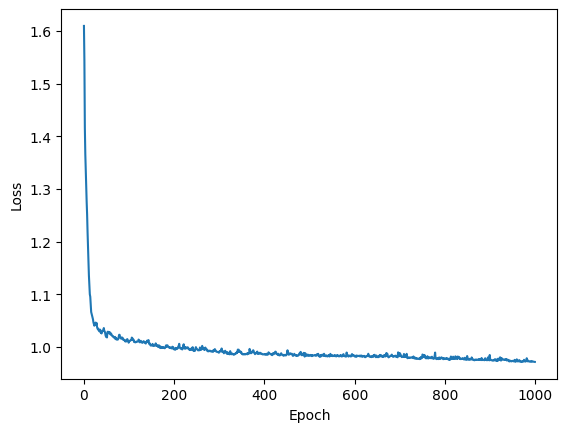

Test accuracy: 464.818064516129
Accuracy: 0.45978494623655913
Precision: 0.48031465640932963
Recall: 0.45915050443941113
F1-score: 0.4674435776484175


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.56      0.62       495
           1       0.38      0.42      0.40       472
           2       0.32      0.36      0.34       449
           3       0.30      0.33      0.31       463
           4       0.72      0.63      0.67       446

    accuracy                           0.46      2325
   macro avg       0.48      0.46      0.47      2325
weighted avg       0.48      0.46      0.47      2325

                    0           1           2           3           4  \
precision    0.683047    0.376894    0.324544    0.298419    0.718670   
recall       0.561616    0.421610    0.356347    0.326134    0.630045   
f1-score     0.616408    0.398000    0.339703    0.311662    0.671446   
support    495.000000  472.000000  449.00000

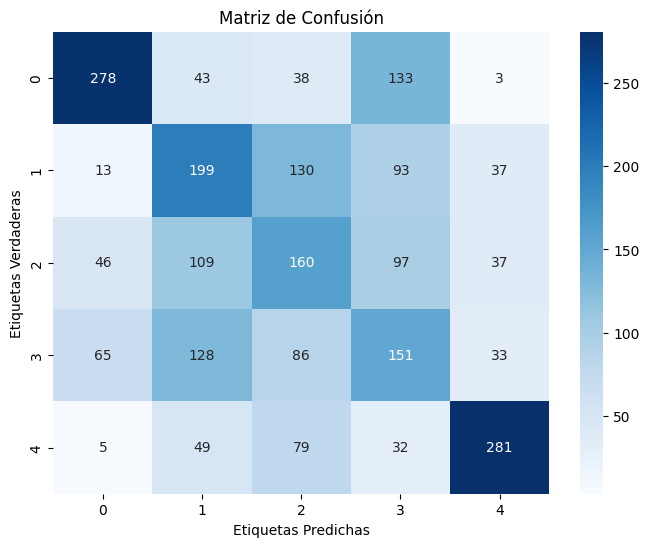

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_1000_0.0001_0.1/resultados_1000_0.0001_0.1.json
Procesando red con 1000 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.9


Procesando epocas:   0%|                                                              | 1/1000 [00:01<27:39,  1.66s/it]

1.609506753612967


Procesando epocas:   0%|                                                              | 2/1000 [00:03<27:37,  1.66s/it]

1.6095046043395995


Procesando epocas:   0%|▏                                                             | 3/1000 [00:04<27:33,  1.66s/it]

1.6094501923112308


Procesando epocas:   0%|▏                                                             | 4/1000 [00:06<27:32,  1.66s/it]

1.6094623502563028


Procesando epocas:   0%|▎                                                             | 5/1000 [00:08<27:29,  1.66s/it]

1.60939399915583


Procesando epocas:   1%|▎                                                             | 6/1000 [00:09<27:27,  1.66s/it]

1.6091967701911927


Procesando epocas:   1%|▍                                                             | 7/1000 [00:11<27:26,  1.66s/it]

1.6089524269104003


Procesando epocas:   1%|▍                                                             | 8/1000 [00:13<27:27,  1.66s/it]

1.608096877266379


Procesando epocas:   1%|▌                                                             | 9/1000 [00:14<27:28,  1.66s/it]

1.6054173932355993


Procesando epocas:   1%|▌                                                            | 10/1000 [00:16<27:39,  1.68s/it]

1.597433249389424


Procesando epocas:   1%|▋                                                            | 11/1000 [00:18<27:34,  1.67s/it]

1.571272837414461


Procesando epocas:   1%|▋                                                            | 12/1000 [00:19<27:28,  1.67s/it]

1.5267478073344511


Procesando epocas:   1%|▊                                                            | 13/1000 [00:21<27:34,  1.68s/it]

1.49077726392185


Procesando epocas:   1%|▊                                                            | 14/1000 [00:23<27:41,  1.69s/it]

1.464047694907469


Procesando epocas:   2%|▉                                                            | 15/1000 [00:25<27:42,  1.69s/it]

1.4414682809044332


Procesando epocas:   2%|▉                                                            | 16/1000 [00:26<27:36,  1.68s/it]

1.4212005019187928


Procesando epocas:   2%|█                                                            | 17/1000 [00:28<27:27,  1.68s/it]

1.4006662263589746


Procesando epocas:   2%|█                                                            | 18/1000 [00:30<27:23,  1.67s/it]

1.379035068960751


Procesando epocas:   2%|█▏                                                           | 19/1000 [00:31<27:24,  1.68s/it]

1.3552234747830558


Procesando epocas:   2%|█▏                                                           | 20/1000 [00:33<27:27,  1.68s/it]

1.3420869567814995


Procesando epocas:   2%|█▎                                                           | 21/1000 [00:35<27:20,  1.68s/it]

1.3277377458179698


Procesando epocas:   2%|█▎                                                           | 22/1000 [00:36<27:15,  1.67s/it]

1.3085777359850266


Procesando epocas:   2%|█▍                                                           | 23/1000 [00:38<27:00,  1.66s/it]

1.291479955000036


Procesando epocas:   2%|█▍                                                           | 24/1000 [00:40<27:02,  1.66s/it]

1.2809330491458668


Procesando epocas:   2%|█▌                                                           | 25/1000 [00:41<27:11,  1.67s/it]

1.262930795024423


Procesando epocas:   3%|█▌                                                           | 26/1000 [00:43<27:06,  1.67s/it]

1.256920473014607


Procesando epocas:   3%|█▋                                                           | 27/1000 [00:45<26:57,  1.66s/it]

1.241663834627937


Procesando epocas:   3%|█▋                                                           | 28/1000 [00:46<26:46,  1.65s/it]

1.2300948276239283


Procesando epocas:   3%|█▊                                                           | 29/1000 [00:48<26:37,  1.65s/it]

1.2237636776531444


Procesando epocas:   3%|█▊                                                           | 30/1000 [00:49<26:31,  1.64s/it]

1.2142021782257977


Procesando epocas:   3%|█▉                                                           | 31/1000 [00:51<26:28,  1.64s/it]

1.2044108306660373


Procesando epocas:   3%|█▉                                                           | 32/1000 [00:53<26:24,  1.64s/it]

1.1915608272832983


Procesando epocas:   3%|██                                                           | 33/1000 [00:54<26:19,  1.63s/it]

1.1888511615640978


Procesando epocas:   3%|██                                                           | 34/1000 [00:56<26:16,  1.63s/it]

1.1807151359670303


Procesando epocas:   4%|██▏                                                          | 35/1000 [00:58<26:12,  1.63s/it]

1.1730586605913498


Procesando epocas:   4%|██▏                                                          | 36/1000 [00:59<26:07,  1.63s/it]

1.1679066160145928


Procesando epocas:   4%|██▎                                                          | 37/1000 [01:01<26:07,  1.63s/it]

1.1585186958312987


Procesando epocas:   4%|██▎                                                          | 38/1000 [01:02<26:05,  1.63s/it]

1.1483476154944476


Procesando epocas:   4%|██▍                                                          | 39/1000 [01:04<26:05,  1.63s/it]

1.1401476853034076


Procesando epocas:   4%|██▍                                                          | 40/1000 [01:06<26:04,  1.63s/it]

1.1338419770493227


Procesando epocas:   4%|██▌                                                          | 41/1000 [01:07<26:02,  1.63s/it]

1.1259468169773326


Procesando epocas:   4%|██▌                                                          | 42/1000 [01:09<26:01,  1.63s/it]

1.125729799971861


Procesando epocas:   4%|██▌                                                          | 43/1000 [01:11<26:00,  1.63s/it]

1.1165441933800193


Procesando epocas:   4%|██▋                                                          | 44/1000 [01:12<25:58,  1.63s/it]

1.105305537406136


Procesando epocas:   4%|██▋                                                          | 45/1000 [01:14<25:56,  1.63s/it]

1.0990971635369693


Procesando epocas:   5%|██▊                                                          | 46/1000 [01:16<25:54,  1.63s/it]

1.0978779862908756


Procesando epocas:   5%|██▊                                                          | 47/1000 [01:17<25:52,  1.63s/it]

1.089543826790417


Procesando epocas:   5%|██▉                                                          | 48/1000 [01:19<25:49,  1.63s/it]

1.0822164619670194


Procesando epocas:   5%|██▉                                                          | 49/1000 [01:20<25:47,  1.63s/it]

1.0798007330473731


Procesando epocas:   5%|███                                                          | 50/1000 [01:22<25:43,  1.63s/it]

1.0722324613262626


Procesando epocas:   5%|███                                                          | 51/1000 [01:24<25:41,  1.62s/it]

1.0683402580373427


Procesando epocas:   5%|███▏                                                         | 52/1000 [01:25<25:42,  1.63s/it]

1.0657219434485716


Procesando epocas:   5%|███▏                                                         | 53/1000 [01:27<25:43,  1.63s/it]

1.0538877897402819


Procesando epocas:   5%|███▎                                                         | 54/1000 [01:29<25:49,  1.64s/it]

1.0521428686731003


Procesando epocas:   6%|███▎                                                         | 55/1000 [01:30<25:51,  1.64s/it]

1.0459550222929785


Procesando epocas:   6%|███▍                                                         | 56/1000 [01:32<25:52,  1.65s/it]

1.0450803591924556


Procesando epocas:   6%|███▍                                                         | 57/1000 [01:34<25:54,  1.65s/it]

1.0450591904275557


Procesando epocas:   6%|███▌                                                         | 58/1000 [01:35<26:01,  1.66s/it]

1.0414960107382607


Procesando epocas:   6%|███▌                                                         | 59/1000 [01:37<26:06,  1.66s/it]

1.0356150038102094


Procesando epocas:   6%|███▋                                                         | 60/1000 [01:39<26:00,  1.66s/it]

1.0343658917090472


Procesando epocas:   6%|███▋                                                         | 61/1000 [01:40<25:55,  1.66s/it]

1.0268184160484988


Procesando epocas:   6%|███▊                                                         | 62/1000 [01:42<25:51,  1.65s/it]

1.0254143890212564


Procesando epocas:   6%|███▊                                                         | 63/1000 [01:43<25:47,  1.65s/it]

1.019489401578903


Procesando epocas:   6%|███▉                                                         | 64/1000 [01:45<25:40,  1.65s/it]

1.0196577124735888


Procesando epocas:   6%|███▉                                                         | 65/1000 [01:47<25:37,  1.64s/it]

1.016744433080449


Procesando epocas:   7%|████                                                         | 66/1000 [01:48<25:38,  1.65s/it]

1.0154824600500219


Procesando epocas:   7%|████                                                         | 67/1000 [01:50<25:41,  1.65s/it]

1.011547682916417


Procesando epocas:   7%|████▏                                                        | 68/1000 [01:52<25:40,  1.65s/it]

1.0115702976198757


Procesando epocas:   7%|████▏                                                        | 69/1000 [01:53<25:44,  1.66s/it]

1.0087515855536742


Procesando epocas:   7%|████▎                                                        | 70/1000 [01:55<25:44,  1.66s/it]

1.0072567147367142


Procesando epocas:   7%|████▎                                                        | 71/1000 [01:57<25:45,  1.66s/it]

1.0040205412051257


Procesando epocas:   7%|████▍                                                        | 72/1000 [01:58<25:43,  1.66s/it]

1.003794638900196


Procesando epocas:   7%|████▍                                                        | 73/1000 [02:00<25:39,  1.66s/it]

0.9990946257815642


Procesando epocas:   7%|████▌                                                        | 74/1000 [02:02<25:36,  1.66s/it]

0.9991002019713907


Procesando epocas:   8%|████▌                                                        | 75/1000 [02:03<25:39,  1.66s/it]

0.9969498469549067


Procesando epocas:   8%|████▋                                                        | 76/1000 [02:05<25:39,  1.67s/it]

0.9960985583417555


Procesando epocas:   8%|████▋                                                        | 77/1000 [02:07<25:35,  1.66s/it]

0.9968130812925451


Procesando epocas:   8%|████▊                                                        | 78/1000 [02:08<25:35,  1.66s/it]

0.9942298549063066


Procesando epocas:   8%|████▊                                                        | 79/1000 [02:10<25:27,  1.66s/it]

0.9957093635026146


Procesando epocas:   8%|████▉                                                        | 80/1000 [02:12<25:44,  1.68s/it]

0.9942535782561582


Procesando epocas:   8%|████▉                                                        | 81/1000 [02:13<25:56,  1.69s/it]

0.9899528885588926


Procesando epocas:   8%|█████                                                        | 82/1000 [02:15<26:05,  1.71s/it]

0.9888193239183987


Procesando epocas:   8%|█████                                                        | 83/1000 [02:17<26:13,  1.72s/it]

0.9909904406351202


Procesando epocas:   8%|█████                                                        | 84/1000 [02:19<26:11,  1.72s/it]

0.9861930556157056


Procesando epocas:   8%|█████▏                                                       | 85/1000 [02:20<26:02,  1.71s/it]

0.985419633809258


Procesando epocas:   9%|█████▏                                                       | 86/1000 [02:22<26:01,  1.71s/it]

0.9866793166188633


Procesando epocas:   9%|█████▎                                                       | 87/1000 [02:24<26:04,  1.71s/it]

0.9846366244203905


Procesando epocas:   9%|█████▎                                                       | 88/1000 [02:26<26:04,  1.72s/it]

0.9847251692238976


Procesando epocas:   9%|█████▍                                                       | 89/1000 [02:27<26:08,  1.72s/it]

0.9845698058605195


Procesando epocas:   9%|█████▍                                                       | 90/1000 [02:29<26:10,  1.73s/it]

0.9838398162056418


Procesando epocas:   9%|█████▌                                                       | 91/1000 [02:31<26:16,  1.73s/it]

0.9813689309007981


Procesando epocas:   9%|█████▌                                                       | 92/1000 [02:32<26:16,  1.74s/it]

0.9828968819449929


Procesando epocas:   9%|█████▋                                                       | 93/1000 [02:34<26:15,  1.74s/it]

0.9792426954297458


Procesando epocas:   9%|█████▋                                                       | 94/1000 [02:36<26:14,  1.74s/it]

0.9817421036608079


Procesando epocas:  10%|█████▊                                                       | 95/1000 [02:38<26:11,  1.74s/it]

0.9796456203741186


Procesando epocas:  10%|█████▊                                                       | 96/1000 [02:39<26:09,  1.74s/it]

0.9764024773064781


Procesando epocas:  10%|█████▉                                                       | 97/1000 [02:41<26:05,  1.73s/it]

0.9774904668331146


Procesando epocas:  10%|█████▉                                                       | 98/1000 [02:43<26:02,  1.73s/it]

0.9775376607390011


Procesando epocas:  10%|██████                                                       | 99/1000 [02:45<25:59,  1.73s/it]

0.9754078837002025


Procesando epocas:  10%|██████                                                      | 100/1000 [02:46<26:03,  1.74s/it]

0.9755410390741684


Procesando epocas:  10%|██████                                                      | 101/1000 [02:48<26:03,  1.74s/it]

0.9754312651998857


Procesando epocas:  10%|██████                                                      | 102/1000 [02:50<26:01,  1.74s/it]

0.9755573090384988


Procesando epocas:  10%|██████▏                                                     | 103/1000 [02:52<25:57,  1.74s/it]

0.9752828001976013


Procesando epocas:  10%|██████▏                                                     | 104/1000 [02:53<25:56,  1.74s/it]

0.9721357065088608


Procesando epocas:  10%|██████▎                                                     | 105/1000 [02:55<25:55,  1.74s/it]

0.9725589394569397


Procesando epocas:  11%|██████▎                                                     | 106/1000 [02:57<25:46,  1.73s/it]

0.9735028487794539


Procesando epocas:  11%|██████▍                                                     | 107/1000 [02:58<25:26,  1.71s/it]

0.9706251719418694


Procesando epocas:  11%|██████▍                                                     | 108/1000 [03:00<25:11,  1.69s/it]

0.9705994662116556


Procesando epocas:  11%|██████▌                                                     | 109/1000 [03:02<25:02,  1.69s/it]

0.9717403951813193


Procesando epocas:  11%|██████▌                                                     | 110/1000 [03:03<24:56,  1.68s/it]

0.9731780245023616


Procesando epocas:  11%|██████▋                                                     | 111/1000 [03:05<24:55,  1.68s/it]

0.970538339544745


Procesando epocas:  11%|██████▋                                                     | 112/1000 [03:07<24:58,  1.69s/it]

0.9695634954115924


Procesando epocas:  11%|██████▊                                                     | 113/1000 [03:08<24:52,  1.68s/it]

0.9703948578413795


Procesando epocas:  11%|██████▊                                                     | 114/1000 [03:10<24:44,  1.68s/it]

0.968105411529541


Procesando epocas:  12%|██████▉                                                     | 115/1000 [03:12<24:41,  1.67s/it]

0.969213933804456


Procesando epocas:  12%|██████▉                                                     | 116/1000 [03:13<24:38,  1.67s/it]

0.9700535209739909


Procesando epocas:  12%|███████                                                     | 117/1000 [03:15<24:34,  1.67s/it]

0.9674809638191672


Procesando epocas:  12%|███████                                                     | 118/1000 [03:17<24:40,  1.68s/it]

0.9679909681572634


Procesando epocas:  12%|███████▏                                                    | 119/1000 [03:19<24:41,  1.68s/it]

0.9681665515198427


Procesando epocas:  12%|███████▏                                                    | 120/1000 [03:20<24:44,  1.69s/it]

0.9656445033410016


Procesando epocas:  12%|███████▎                                                    | 121/1000 [03:22<24:43,  1.69s/it]

0.9659120745518628


Procesando epocas:  12%|███████▎                                                    | 122/1000 [03:24<24:40,  1.69s/it]

0.9676883381955764


Procesando epocas:  12%|███████▍                                                    | 123/1000 [03:25<24:42,  1.69s/it]

0.9647140695768244


Procesando epocas:  12%|███████▍                                                    | 124/1000 [03:27<24:36,  1.69s/it]

0.9650314345079309


Procesando epocas:  12%|███████▌                                                    | 125/1000 [03:29<24:29,  1.68s/it]

0.9654613933142494


Procesando epocas:  13%|███████▌                                                    | 126/1000 [03:30<24:24,  1.68s/it]

0.9647554408101474


Procesando epocas:  13%|███████▌                                                    | 127/1000 [03:32<24:19,  1.67s/it]

0.9637968420982361


Procesando epocas:  13%|███████▋                                                    | 128/1000 [03:34<24:17,  1.67s/it]

0.9646616511485155


Procesando epocas:  13%|███████▋                                                    | 129/1000 [03:35<24:19,  1.68s/it]

0.962891109901316


Procesando epocas:  13%|███████▊                                                    | 130/1000 [03:37<24:21,  1.68s/it]

0.964659872826408


Procesando epocas:  13%|███████▊                                                    | 131/1000 [03:39<24:17,  1.68s/it]

0.9633679666939904


Procesando epocas:  13%|███████▉                                                    | 132/1000 [03:40<24:10,  1.67s/it]

0.9642751104691449


Procesando epocas:  13%|███████▉                                                    | 133/1000 [03:42<24:00,  1.66s/it]

0.9627273829544292


Procesando epocas:  13%|████████                                                    | 134/1000 [03:44<23:53,  1.66s/it]

0.9631200636134428


Procesando epocas:  14%|████████                                                    | 135/1000 [03:45<23:51,  1.65s/it]

0.962764668114045


Procesando epocas:  14%|████████▏                                                   | 136/1000 [03:47<23:43,  1.65s/it]

0.9615206564173979


Procesando epocas:  14%|████████▏                                                   | 137/1000 [03:49<23:38,  1.64s/it]

0.9630877382615033


Procesando epocas:  14%|████████▎                                                   | 138/1000 [03:50<23:32,  1.64s/it]

0.9622548692366656


Procesando epocas:  14%|████████▎                                                   | 139/1000 [03:52<23:25,  1.63s/it]

0.9606997816001668


Procesando epocas:  14%|████████▍                                                   | 140/1000 [03:53<23:20,  1.63s/it]

0.960647028684616


Procesando epocas:  14%|████████▍                                                   | 141/1000 [03:55<23:20,  1.63s/it]

0.9595746755599975


Procesando epocas:  14%|████████▌                                                   | 142/1000 [03:57<23:17,  1.63s/it]

0.960065380264731


Procesando epocas:  14%|████████▌                                                   | 143/1000 [03:58<23:14,  1.63s/it]

0.9598847680232104


Procesando epocas:  14%|████████▋                                                   | 144/1000 [04:00<23:14,  1.63s/it]

0.9607732068089878


Procesando epocas:  14%|████████▋                                                   | 145/1000 [04:02<23:20,  1.64s/it]

0.9592807590961456


Procesando epocas:  15%|████████▊                                                   | 146/1000 [04:03<23:45,  1.67s/it]

0.9594011590761297


Procesando epocas:  15%|████████▊                                                   | 147/1000 [04:05<23:54,  1.68s/it]

0.9615900832064012


Procesando epocas:  15%|████████▉                                                   | 148/1000 [04:07<24:02,  1.69s/it]

0.9591768250745886


Procesando epocas:  15%|████████▉                                                   | 149/1000 [04:08<23:59,  1.69s/it]

0.9588501449893503


Procesando epocas:  15%|█████████                                                   | 150/1000 [04:10<23:53,  1.69s/it]

0.9591649812810561


Procesando epocas:  15%|█████████                                                   | 151/1000 [04:12<23:59,  1.70s/it]

0.9590651554219863


Procesando epocas:  15%|█████████                                                   | 152/1000 [04:14<24:08,  1.71s/it]

0.9600700574762681


Procesando epocas:  15%|█████████▏                                                  | 153/1000 [04:15<24:08,  1.71s/it]

0.9578472070834216


Procesando epocas:  15%|█████████▏                                                  | 154/1000 [04:17<24:01,  1.70s/it]

0.9580897727433373


Procesando epocas:  16%|█████████▎                                                  | 155/1000 [04:19<24:03,  1.71s/it]

0.9584511385244482


Procesando epocas:  16%|█████████▎                                                  | 156/1000 [04:20<23:43,  1.69s/it]

0.9591564718414756


Procesando epocas:  16%|█████████▍                                                  | 157/1000 [04:22<23:58,  1.71s/it]

0.9576855571830973


Procesando epocas:  16%|█████████▍                                                  | 158/1000 [04:24<23:47,  1.70s/it]

0.9580322826609892


Procesando epocas:  16%|█████████▌                                                  | 159/1000 [04:25<23:39,  1.69s/it]

0.9585837181876687


Procesando epocas:  16%|█████████▌                                                  | 160/1000 [04:27<23:38,  1.69s/it]

0.9585684811367708


Procesando epocas:  16%|█████████▋                                                  | 161/1000 [04:29<23:30,  1.68s/it]

0.9588391637100893


Procesando epocas:  16%|█████████▋                                                  | 162/1000 [04:30<23:21,  1.67s/it]

0.9571107717121349


Procesando epocas:  16%|█████████▊                                                  | 163/1000 [04:32<23:13,  1.66s/it]

0.9578269783188315


Procesando epocas:  16%|█████████▊                                                  | 164/1000 [04:34<23:08,  1.66s/it]

0.9579391002655029


Procesando epocas:  16%|█████████▉                                                  | 165/1000 [04:35<23:01,  1.66s/it]

0.957695176671533


Procesando epocas:  17%|█████████▉                                                  | 166/1000 [04:37<22:59,  1.65s/it]

0.9574110669248245


Procesando epocas:  17%|██████████                                                  | 167/1000 [04:39<23:07,  1.67s/it]

0.9583723986850066


Procesando epocas:  17%|██████████                                                  | 168/1000 [04:40<23:11,  1.67s/it]

0.957851093306261


Procesando epocas:  17%|██████████▏                                                 | 169/1000 [04:42<23:16,  1.68s/it]

0.9567180728211122


Procesando epocas:  17%|██████████▏                                                 | 170/1000 [04:44<23:14,  1.68s/it]

0.9574501987765817


Procesando epocas:  17%|██████████▎                                                 | 171/1000 [04:45<23:10,  1.68s/it]

0.9571401010541355


Procesando epocas:  17%|██████████▎                                                 | 172/1000 [04:47<23:07,  1.68s/it]

0.957820167611627


Procesando epocas:  17%|██████████▍                                                 | 173/1000 [04:49<22:52,  1.66s/it]

0.9577041916987475


Procesando epocas:  17%|██████████▍                                                 | 174/1000 [04:50<22:41,  1.65s/it]

0.9567018817452824


Procesando epocas:  18%|██████████▌                                                 | 175/1000 [04:52<22:31,  1.64s/it]

0.9563984239802641


Procesando epocas:  18%|██████████▌                                                 | 176/1000 [04:54<22:25,  1.63s/it]

0.9566995820578407


Procesando epocas:  18%|██████████▌                                                 | 177/1000 [04:55<22:19,  1.63s/it]

0.9573946795042824


Procesando epocas:  18%|██████████▋                                                 | 178/1000 [04:57<22:21,  1.63s/it]

0.9561025528346792


Procesando epocas:  18%|██████████▋                                                 | 179/1000 [04:58<22:18,  1.63s/it]

0.9561717359458699


Procesando epocas:  18%|██████████▊                                                 | 180/1000 [05:00<22:14,  1.63s/it]

0.9564858801224653


Procesando epocas:  18%|██████████▊                                                 | 181/1000 [05:02<22:11,  1.63s/it]

0.9555545743773965


Procesando epocas:  18%|██████████▉                                                 | 182/1000 [05:03<22:08,  1.62s/it]

0.9558609660934


Procesando epocas:  18%|██████████▉                                                 | 183/1000 [05:05<22:07,  1.63s/it]

0.9559924409669989


Procesando epocas:  18%|███████████                                                 | 184/1000 [05:07<22:19,  1.64s/it]

0.95556599743226


Procesando epocas:  18%|███████████                                                 | 185/1000 [05:08<22:12,  1.64s/it]

0.9557093189043158


Procesando epocas:  19%|███████████▏                                                | 186/1000 [05:10<22:11,  1.64s/it]

0.9547394314232994


Procesando epocas:  19%|███████████▏                                                | 187/1000 [05:12<22:08,  1.63s/it]

0.9557876001386082


Procesando epocas:  19%|███████████▎                                                | 188/1000 [05:13<22:15,  1.65s/it]

0.9548118142520681


Procesando epocas:  19%|███████████▎                                                | 189/1000 [05:15<22:44,  1.68s/it]

0.9553729586741504


Procesando epocas:  19%|███████████▍                                                | 190/1000 [05:17<22:59,  1.70s/it]

0.955539020019419


Procesando epocas:  19%|███████████▍                                                | 191/1000 [05:18<23:06,  1.71s/it]

0.95430247222676


Procesando epocas:  19%|███████████▌                                                | 192/1000 [05:20<23:11,  1.72s/it]

0.9549113834605497


Procesando epocas:  19%|███████████▌                                                | 193/1000 [05:22<23:18,  1.73s/it]

0.9534515545648687


Procesando epocas:  19%|███████████▋                                                | 194/1000 [05:24<23:22,  1.74s/it]

0.9533483712112203


Procesando epocas:  20%|███████████▋                                                | 195/1000 [05:26<23:27,  1.75s/it]

0.9542364902356092


Procesando epocas:  20%|███████████▊                                                | 196/1000 [05:27<23:20,  1.74s/it]

0.9542585474603317


Procesando epocas:  20%|███████████▊                                                | 197/1000 [05:29<23:09,  1.73s/it]

0.9532919768024893


Procesando epocas:  20%|███████████▉                                                | 198/1000 [05:31<23:02,  1.72s/it]

0.9536347476875081


Procesando epocas:  20%|███████████▉                                                | 199/1000 [05:32<22:57,  1.72s/it]

0.9539767587886138


Procesando epocas:  20%|████████████                                                | 200/1000 [05:34<22:53,  1.72s/it]

0.9545342715347515


Procesando epocas:  20%|████████████                                                | 201/1000 [05:36<22:49,  1.71s/it]

0.9535520034677842


Procesando epocas:  20%|████████████                                                | 202/1000 [05:37<22:47,  1.71s/it]

0.9532157929504619


Procesando epocas:  20%|████████████▏                                               | 203/1000 [05:39<22:46,  1.71s/it]

0.9532541646676905


Procesando epocas:  20%|████████████▏                                               | 204/1000 [05:41<22:44,  1.71s/it]

0.9531098025686601


Procesando epocas:  20%|████████████▎                                               | 205/1000 [05:43<22:43,  1.72s/it]

0.953412853269016


Procesando epocas:  21%|████████████▎                                               | 206/1000 [05:44<22:43,  1.72s/it]

0.9530831158161164


Procesando epocas:  21%|████████████▍                                               | 207/1000 [05:46<22:47,  1.72s/it]

0.9528828757650712


Procesando epocas:  21%|████████████▍                                               | 208/1000 [05:48<22:42,  1.72s/it]

0.9530495605048012


Procesando epocas:  21%|████████████▌                                               | 209/1000 [05:50<22:38,  1.72s/it]

0.9538894215050866


Procesando epocas:  21%|████████████▌                                               | 210/1000 [05:51<22:35,  1.72s/it]

0.9529979881118326


Procesando epocas:  21%|████████████▋                                               | 211/1000 [05:53<22:32,  1.71s/it]

0.9532167329507716


Procesando epocas:  21%|████████████▋                                               | 212/1000 [05:55<22:28,  1.71s/it]

0.9522334218025208


Procesando epocas:  21%|████████████▊                                               | 213/1000 [05:56<22:24,  1.71s/it]

0.9535428366240333


Procesando epocas:  21%|████████████▊                                               | 214/1000 [05:58<22:23,  1.71s/it]

0.9521619274335749


Procesando epocas:  22%|████████████▉                                               | 215/1000 [06:00<22:19,  1.71s/it]

0.9516549755545224


Procesando epocas:  22%|████████████▉                                               | 216/1000 [06:01<22:04,  1.69s/it]

0.951294583082199


Procesando epocas:  22%|█████████████                                               | 217/1000 [06:03<21:56,  1.68s/it]

0.9518404112142675


Procesando epocas:  22%|█████████████                                               | 218/1000 [06:05<21:48,  1.67s/it]

0.9520154570831972


Procesando epocas:  22%|█████████████▏                                              | 219/1000 [06:06<21:42,  1.67s/it]

0.952577134440927


Procesando epocas:  22%|█████████████▏                                              | 220/1000 [06:08<21:39,  1.67s/it]

0.9519928059157203


Procesando epocas:  22%|█████████████▎                                              | 221/1000 [06:10<21:34,  1.66s/it]

0.9513502545216505


Procesando epocas:  22%|█████████████▎                                              | 222/1000 [06:11<21:30,  1.66s/it]

0.9512135011308334


Procesando epocas:  22%|█████████████▍                                              | 223/1000 [06:13<21:29,  1.66s/it]

0.9511258023626664


Procesando epocas:  22%|█████████████▍                                              | 224/1000 [06:15<21:38,  1.67s/it]

0.9517676213208367


Procesando epocas:  22%|█████████████▌                                              | 225/1000 [06:16<21:38,  1.68s/it]

0.9514268549049602


Procesando epocas:  23%|█████████████▌                                              | 226/1000 [06:18<21:37,  1.68s/it]

0.952078411509009


Procesando epocas:  23%|█████████████▌                                              | 227/1000 [06:20<21:35,  1.68s/it]

0.9519389005268322


Procesando epocas:  23%|█████████████▋                                              | 228/1000 [06:21<21:32,  1.67s/it]

0.9511988092871273


Procesando epocas:  23%|█████████████▋                                              | 229/1000 [06:23<21:27,  1.67s/it]

0.9509330921313341


Procesando epocas:  23%|█████████████▊                                              | 230/1000 [06:25<21:24,  1.67s/it]

0.9515054460834055


Procesando epocas:  23%|█████████████▊                                              | 231/1000 [06:26<21:23,  1.67s/it]

0.9517210862215828


Procesando epocas:  23%|█████████████▉                                              | 232/1000 [06:28<21:27,  1.68s/it]

0.9511541706674239


Procesando epocas:  23%|█████████████▉                                              | 233/1000 [06:30<21:33,  1.69s/it]

0.9505378242801218


Procesando epocas:  23%|██████████████                                              | 234/1000 [06:32<21:35,  1.69s/it]

0.9506173603674944


Procesando epocas:  24%|██████████████                                              | 235/1000 [06:33<21:46,  1.71s/it]

0.9508977413177491


Procesando epocas:  24%|██████████████▏                                             | 236/1000 [06:35<22:10,  1.74s/it]

0.9516276731210597


Procesando epocas:  24%|██████████████▏                                             | 237/1000 [06:37<22:00,  1.73s/it]

0.9506348785232095


Procesando epocas:  24%|██████████████▎                                             | 238/1000 [06:39<22:02,  1.74s/it]

0.9517274302594801


Procesando epocas:  24%|██████████████▎                                             | 239/1000 [06:40<22:00,  1.74s/it]

0.9515090868753545


Procesando epocas:  24%|██████████████▍                                             | 240/1000 [06:42<21:49,  1.72s/it]

0.9506791507496554


Procesando epocas:  24%|██████████████▍                                             | 241/1000 [06:44<21:37,  1.71s/it]

0.9500600646523868


Procesando epocas:  24%|██████████████▌                                             | 242/1000 [06:45<21:37,  1.71s/it]

0.9498792027725893


Procesando epocas:  24%|██████████████▌                                             | 243/1000 [06:47<21:45,  1.72s/it]

0.9502732182250303


Procesando epocas:  24%|██████████████▋                                             | 244/1000 [06:49<21:44,  1.73s/it]

0.9499331747784334


Procesando epocas:  24%|██████████████▋                                             | 245/1000 [06:51<21:42,  1.72s/it]

0.9509207760586458


Procesando epocas:  25%|██████████████▊                                             | 246/1000 [06:52<21:41,  1.73s/it]

0.9507735967636108


Procesando epocas:  25%|██████████████▊                                             | 247/1000 [06:54<21:29,  1.71s/it]

0.9498782911721397


Procesando epocas:  25%|██████████████▉                                             | 248/1000 [06:56<21:15,  1.70s/it]

0.9502363429350011


Procesando epocas:  25%|██████████████▉                                             | 249/1000 [06:57<21:20,  1.70s/it]

0.9509091805009281


Procesando epocas:  25%|███████████████                                             | 250/1000 [06:59<21:25,  1.71s/it]

0.9508646028883317


Procesando epocas:  25%|███████████████                                             | 251/1000 [07:01<21:10,  1.70s/it]

0.950893079182681


Procesando epocas:  25%|███████████████                                             | 252/1000 [07:02<21:00,  1.69s/it]

0.9502922938150518


Procesando epocas:  25%|███████████████▏                                            | 253/1000 [07:04<20:52,  1.68s/it]

0.9502190824817208


Procesando epocas:  25%|███████████████▏                                            | 254/1000 [07:06<20:48,  1.67s/it]

0.9501715414664325


Procesando epocas:  26%|███████████████▎                                            | 255/1000 [07:07<20:41,  1.67s/it]

0.9497843517976648


Procesando epocas:  26%|███████████████▎                                            | 256/1000 [07:09<20:37,  1.66s/it]

0.9501074945225435


Procesando epocas:  26%|███████████████▍                                            | 257/1000 [07:11<20:41,  1.67s/it]

0.9496158641927382


Procesando epocas:  26%|███████████████▍                                            | 258/1000 [07:12<20:50,  1.68s/it]

0.9497255984474631


Procesando epocas:  26%|███████████████▌                                            | 259/1000 [07:14<20:50,  1.69s/it]

0.9494271884946263


Procesando epocas:  26%|███████████████▌                                            | 260/1000 [07:16<20:41,  1.68s/it]

0.9501774184844073


Procesando epocas:  26%|███████████████▋                                            | 261/1000 [07:17<20:34,  1.67s/it]

0.9501606415299808


Procesando epocas:  26%|███████████████▋                                            | 262/1000 [07:19<20:29,  1.67s/it]

0.9489598291761735


Procesando epocas:  26%|███████████████▊                                            | 263/1000 [07:21<20:26,  1.66s/it]

0.9495195097783032


Procesando epocas:  26%|███████████████▊                                            | 264/1000 [07:22<20:27,  1.67s/it]

0.9497877166551703


Procesando epocas:  26%|███████████████▉                                            | 265/1000 [07:24<20:23,  1.67s/it]

0.9498255757724537


Procesando epocas:  27%|███████████████▉                                            | 266/1000 [07:26<20:19,  1.66s/it]

0.949180939618279


Procesando epocas:  27%|████████████████                                            | 267/1000 [07:27<20:15,  1.66s/it]

0.950439745538375


Procesando epocas:  27%|████████████████                                            | 268/1000 [07:29<20:12,  1.66s/it]

0.9498764770872453


Procesando epocas:  27%|████████████████▏                                           | 269/1000 [07:31<20:08,  1.65s/it]

0.9506000325960271


Procesando epocas:  27%|████████████████▏                                           | 270/1000 [07:32<20:04,  1.65s/it]

0.9495651616769678


Procesando epocas:  27%|████████████████▎                                           | 271/1000 [07:34<20:03,  1.65s/it]

0.9499746599618126


Procesando epocas:  27%|████████████████▎                                           | 272/1000 [07:36<20:10,  1.66s/it]

0.9490344755789812


Procesando epocas:  27%|████████████████▍                                           | 273/1000 [07:37<20:08,  1.66s/it]

0.9492782449021059


Procesando epocas:  27%|████████████████▍                                           | 274/1000 [07:39<20:04,  1.66s/it]

0.9499247221385732


Procesando epocas:  28%|████████████████▌                                           | 275/1000 [07:41<20:00,  1.66s/it]

0.948506312861162


Procesando epocas:  28%|████████████████▌                                           | 276/1000 [07:42<19:57,  1.65s/it]

0.9493673980236054


Procesando epocas:  28%|████████████████▌                                           | 277/1000 [07:44<19:57,  1.66s/it]

0.9482176233740414


Procesando epocas:  28%|████████████████▋                                           | 278/1000 [07:46<19:53,  1.65s/it]

0.9504243138958426


Procesando epocas:  28%|████████████████▋                                           | 279/1000 [07:47<19:50,  1.65s/it]

0.9493850651909324


Procesando epocas:  28%|████████████████▊                                           | 280/1000 [07:49<19:47,  1.65s/it]

0.9490787208080291


Procesando epocas:  28%|████████████████▊                                           | 281/1000 [07:51<19:46,  1.65s/it]

0.9485281113316031


Procesando epocas:  28%|████████████████▉                                           | 282/1000 [07:52<19:44,  1.65s/it]

0.9491911996813381


Procesando epocas:  28%|████████████████▉                                           | 283/1000 [07:54<19:41,  1.65s/it]

0.949714073714088


Procesando epocas:  28%|█████████████████                                           | 284/1000 [07:55<19:39,  1.65s/it]

0.949219042413375


Procesando epocas:  28%|█████████████████                                           | 285/1000 [07:57<19:38,  1.65s/it]

0.9488807776395012


Procesando epocas:  29%|█████████████████▏                                          | 286/1000 [07:59<19:37,  1.65s/it]

0.9489373711978688


Procesando epocas:  29%|█████████████████▏                                          | 287/1000 [08:00<19:34,  1.65s/it]

0.9492017314714544


Procesando epocas:  29%|█████████████████▎                                          | 288/1000 [08:02<19:31,  1.65s/it]

0.9492494379772859


Procesando epocas:  29%|█████████████████▎                                          | 289/1000 [08:04<19:29,  1.65s/it]

0.9483058634926291


Procesando epocas:  29%|█████████████████▍                                          | 290/1000 [08:05<19:30,  1.65s/it]

0.9485998350031236


Procesando epocas:  29%|█████████████████▍                                          | 291/1000 [08:07<19:31,  1.65s/it]

0.9485900167156668


Procesando epocas:  29%|█████████████████▌                                          | 292/1000 [08:09<19:32,  1.66s/it]

0.9485390200334437


Procesando epocas:  29%|█████████████████▌                                          | 293/1000 [08:10<19:36,  1.66s/it]

0.948417259314481


Procesando epocas:  29%|█████████████████▋                                          | 294/1000 [08:12<19:38,  1.67s/it]

0.9494718253612519


Procesando epocas:  30%|█████████████████▋                                          | 295/1000 [08:14<19:34,  1.67s/it]

0.9483569064561058


Procesando epocas:  30%|█████████████████▊                                          | 296/1000 [08:15<19:27,  1.66s/it]

0.9483260841930614


Procesando epocas:  30%|█████████████████▊                                          | 297/1000 [08:17<19:31,  1.67s/it]

0.9479478397790123


Procesando epocas:  30%|█████████████████▉                                          | 298/1000 [08:19<19:49,  1.69s/it]

0.9480687797069549


Procesando epocas:  30%|█████████████████▉                                          | 299/1000 [08:21<20:04,  1.72s/it]

0.9475461595198688


Procesando epocas:  30%|██████████████████                                          | 300/1000 [08:22<20:23,  1.75s/it]

0.9479799891219419


Procesando epocas:  30%|██████████████████                                          | 301/1000 [08:24<20:27,  1.76s/it]

0.9485034171272727


Procesando epocas:  30%|██████████████████                                          | 302/1000 [08:26<20:30,  1.76s/it]

0.9484425720046549


Procesando epocas:  30%|██████████████████▏                                         | 303/1000 [08:28<20:29,  1.76s/it]

0.9487596035003663


Procesando epocas:  30%|██████████████████▏                                         | 304/1000 [08:29<20:29,  1.77s/it]

0.9475854845607982


Procesando epocas:  30%|██████████████████▎                                         | 305/1000 [08:31<20:26,  1.77s/it]

0.9478958308696747


Procesando epocas:  31%|██████████████████▎                                         | 306/1000 [08:33<20:25,  1.77s/it]

0.9482232661808239


Procesando epocas:  31%|██████████████████▍                                         | 307/1000 [08:35<20:25,  1.77s/it]

0.9486330964986016


Procesando epocas:  31%|██████████████████▍                                         | 308/1000 [08:37<20:31,  1.78s/it]

0.94835725181243


Procesando epocas:  31%|██████████████████▌                                         | 309/1000 [08:38<20:32,  1.78s/it]

0.947475644420175


Procesando epocas:  31%|██████████████████▌                                         | 310/1000 [08:40<20:27,  1.78s/it]

0.9475951320984785


Procesando epocas:  31%|██████████████████▋                                         | 311/1000 [08:42<20:25,  1.78s/it]

0.9478748311014736


Procesando epocas:  31%|██████████████████▋                                         | 312/1000 [08:44<20:23,  1.78s/it]

0.9483498345403111


Procesando epocas:  31%|██████████████████▊                                         | 313/1000 [08:45<20:19,  1.78s/it]

0.9482844173908234


Procesando epocas:  31%|██████████████████▊                                         | 314/1000 [08:47<20:14,  1.77s/it]

0.9485757866326501


Procesando epocas:  32%|██████████████████▉                                         | 315/1000 [08:49<20:13,  1.77s/it]

0.9478139382951399


Procesando epocas:  32%|██████████████████▉                                         | 316/1000 [08:51<20:10,  1.77s/it]

0.9475007243016187


Procesando epocas:  32%|███████████████████                                         | 317/1000 [08:53<20:09,  1.77s/it]

0.9474363067570855


Procesando epocas:  32%|███████████████████                                         | 318/1000 [08:54<20:05,  1.77s/it]

0.9472479185637306


Procesando epocas:  32%|███████████████████▏                                        | 319/1000 [08:56<20:04,  1.77s/it]

0.9473660714486066


Procesando epocas:  32%|███████████████████▏                                        | 320/1000 [08:58<20:02,  1.77s/it]

0.9473986818509943


Procesando epocas:  32%|███████████████████▎                                        | 321/1000 [09:00<20:01,  1.77s/it]

0.9480515287202947


Procesando epocas:  32%|███████████████████▎                                        | 322/1000 [09:01<19:59,  1.77s/it]

0.9475946843624115


Procesando epocas:  32%|███████████████████▍                                        | 323/1000 [09:03<19:59,  1.77s/it]

0.9476127543870141


Procesando epocas:  32%|███████████████████▍                                        | 324/1000 [09:05<19:52,  1.76s/it]

0.9479587204316083


Procesando epocas:  32%|███████████████████▌                                        | 325/1000 [09:07<19:42,  1.75s/it]

0.9480298340320588


Procesando epocas:  33%|███████████████████▌                                        | 326/1000 [09:08<19:31,  1.74s/it]

0.9473207652568817


Procesando epocas:  33%|███████████████████▌                                        | 327/1000 [09:10<19:19,  1.72s/it]

0.9482469727011288


Procesando epocas:  33%|███████████████████▋                                        | 328/1000 [09:12<19:15,  1.72s/it]

0.9479015690438888


Procesando epocas:  33%|███████████████████▋                                        | 329/1000 [09:13<19:13,  1.72s/it]

0.9476707987925586


Procesando epocas:  33%|███████████████████▊                                        | 330/1000 [09:15<19:07,  1.71s/it]

0.9475703260477851


Procesando epocas:  33%|███████████████████▊                                        | 331/1000 [09:17<19:00,  1.70s/it]

0.9469669713693507


Procesando epocas:  33%|███████████████████▉                                        | 332/1000 [09:19<18:55,  1.70s/it]

0.9477256988777834


Procesando epocas:  33%|███████████████████▉                                        | 333/1000 [09:20<18:50,  1.70s/it]

0.947049282578861


Procesando epocas:  33%|████████████████████                                        | 334/1000 [09:22<18:47,  1.69s/it]

0.9473127677160151


Procesando epocas:  34%|████████████████████                                        | 335/1000 [09:24<18:46,  1.69s/it]

0.9474472031873815


Procesando epocas:  34%|████████████████████▏                                       | 336/1000 [09:25<18:48,  1.70s/it]

0.9473617984968074


Procesando epocas:  34%|████████████████████▏                                       | 337/1000 [09:27<18:47,  1.70s/it]

0.9468490299056558


Procesando epocas:  34%|████████████████████▎                                       | 338/1000 [09:29<18:42,  1.70s/it]

0.9472879006582148


Procesando epocas:  34%|████████████████████▎                                       | 339/1000 [09:30<18:38,  1.69s/it]

0.9468223964466768


Procesando epocas:  34%|████████████████████▍                                       | 340/1000 [09:32<18:35,  1.69s/it]

0.9466976313030019


Procesando epocas:  34%|████████████████████▍                                       | 341/1000 [09:34<18:33,  1.69s/it]

0.9476188263472389


Procesando epocas:  34%|████████████████████▌                                       | 342/1000 [09:35<18:30,  1.69s/it]

0.9470573870574727


Procesando epocas:  34%|████████████████████▌                                       | 343/1000 [09:37<18:40,  1.71s/it]

0.9469486727434047


Procesando epocas:  34%|████████████████████▋                                       | 344/1000 [09:39<18:44,  1.71s/it]

0.9473557545858271


Procesando epocas:  34%|████████████████████▋                                       | 345/1000 [09:41<18:40,  1.71s/it]

0.9470878888578976


Procesando epocas:  35%|████████████████████▊                                       | 346/1000 [09:42<18:39,  1.71s/it]

0.9475244816611795


Procesando epocas:  35%|████████████████████▊                                       | 347/1000 [09:44<18:37,  1.71s/it]

0.9474022297298207


Procesando epocas:  35%|████████████████████▉                                       | 348/1000 [09:46<18:58,  1.75s/it]

0.9471568395109737


Procesando epocas:  35%|████████████████████▉                                       | 349/1000 [09:48<18:44,  1.73s/it]

0.9464983631582821


Procesando epocas:  35%|█████████████████████                                       | 350/1000 [09:49<18:34,  1.71s/it]

0.9470758164630216


Procesando epocas:  35%|█████████████████████                                       | 351/1000 [09:51<18:25,  1.70s/it]

0.946380176263697


Procesando epocas:  35%|█████████████████████                                       | 352/1000 [09:53<18:26,  1.71s/it]

0.9468426893739139


Procesando epocas:  35%|█████████████████████▏                                      | 353/1000 [09:54<18:16,  1.69s/it]

0.9465968682485468


Procesando epocas:  35%|█████████████████████▏                                      | 354/1000 [09:56<18:08,  1.69s/it]

0.9467570241759805


Procesando epocas:  36%|█████████████████████▎                                      | 355/1000 [09:58<18:06,  1.68s/it]

0.9469208920703215


Procesando epocas:  36%|█████████████████████▎                                      | 356/1000 [09:59<18:09,  1.69s/it]

0.9467084085240084


Procesando epocas:  36%|█████████████████████▍                                      | 357/1000 [10:01<18:01,  1.68s/it]

0.9468226169838625


Procesando epocas:  36%|█████████████████████▍                                      | 358/1000 [10:03<17:54,  1.67s/it]

0.9469632418716655


Procesando epocas:  36%|█████████████████████▌                                      | 359/1000 [10:04<17:47,  1.66s/it]

0.946669318746118


Procesando epocas:  36%|█████████████████████▌                                      | 360/1000 [10:06<17:52,  1.68s/it]

0.94725742725765


Procesando epocas:  36%|█████████████████████▋                                      | 361/1000 [10:08<17:58,  1.69s/it]

0.9471034772255842


Procesando epocas:  36%|█████████████████████▋                                      | 362/1000 [10:09<18:07,  1.70s/it]

0.9472544000429266


Procesando epocas:  36%|█████████████████████▊                                      | 363/1000 [10:11<18:00,  1.70s/it]

0.9464774293058059


Procesando epocas:  36%|█████████████████████▊                                      | 364/1000 [10:13<17:57,  1.69s/it]

0.9468134175328647


Procesando epocas:  36%|█████████████████████▉                                      | 365/1000 [10:15<18:06,  1.71s/it]

0.9470855705878314


Procesando epocas:  37%|█████████████████████▉                                      | 366/1000 [10:16<17:57,  1.70s/it]

0.9468078006716335


Procesando epocas:  37%|██████████████████████                                      | 367/1000 [10:18<18:02,  1.71s/it]

0.9468204305452459


Procesando epocas:  37%|██████████████████████                                      | 368/1000 [10:20<18:03,  1.71s/it]

0.9470393002033234


Procesando epocas:  37%|██████████████████████▏                                     | 369/1000 [10:21<18:05,  1.72s/it]

0.9474281216368956


Procesando epocas:  37%|██████████████████████▏                                     | 370/1000 [10:23<18:02,  1.72s/it]

0.9464618661824394


Procesando epocas:  37%|██████████████████████▎                                     | 371/1000 [10:25<17:52,  1.71s/it]

0.9463399073656867


Procesando epocas:  37%|██████████████████████▎                                     | 372/1000 [10:27<17:51,  1.71s/it]

0.9468855808762943


Procesando epocas:  37%|██████████████████████▍                                     | 373/1000 [10:28<17:43,  1.70s/it]

0.9468055385000566


Procesando epocas:  37%|██████████████████████▍                                     | 374/1000 [10:30<17:35,  1.69s/it]

0.9461201310157776


Procesando epocas:  38%|██████████████████████▌                                     | 375/1000 [10:32<17:29,  1.68s/it]

0.9459463045877569


Procesando epocas:  38%|██████████████████████▌                                     | 376/1000 [10:33<17:23,  1.67s/it]

0.9459714987698723


Procesando epocas:  38%|██████████████████████▌                                     | 377/1000 [10:35<17:19,  1.67s/it]

0.9466812442330753


Procesando epocas:  38%|██████████████████████▋                                     | 378/1000 [10:37<17:15,  1.66s/it]

0.9471329920432147


Procesando epocas:  38%|██████████████████████▋                                     | 379/1000 [10:38<17:20,  1.68s/it]

0.9472832511453068


Procesando epocas:  38%|██████████████████████▊                                     | 380/1000 [10:40<17:24,  1.68s/it]

0.9463265667943394


Procesando epocas:  38%|██████████████████████▊                                     | 381/1000 [10:42<17:20,  1.68s/it]

0.9460170125260072


Procesando epocas:  38%|██████████████████████▉                                     | 382/1000 [10:43<17:13,  1.67s/it]

0.9461882486062891


Procesando epocas:  38%|██████████████████████▉                                     | 383/1000 [10:45<17:07,  1.67s/it]

0.9464117505971124


Procesando epocas:  38%|███████████████████████                                     | 384/1000 [10:47<17:03,  1.66s/it]

0.9465218929683461


Procesando epocas:  38%|███████████████████████                                     | 385/1000 [10:48<16:59,  1.66s/it]

0.9469439271618338


Procesando epocas:  39%|███████████████████████▏                                    | 386/1000 [10:50<16:58,  1.66s/it]

0.9466875861672794


Procesando epocas:  39%|███████████████████████▏                                    | 387/1000 [10:52<16:55,  1.66s/it]

0.9464712556670694


Procesando epocas:  39%|███████████████████████▎                                    | 388/1000 [10:53<16:52,  1.66s/it]

0.9463380813598633


Procesando epocas:  39%|███████████████████████▎                                    | 389/1000 [10:55<16:59,  1.67s/it]

0.9460937573629267


Procesando epocas:  39%|███████████████████████▍                                    | 390/1000 [10:57<16:54,  1.66s/it]

0.9459145265467027


Procesando epocas:  39%|███████████████████████▍                                    | 391/1000 [10:58<16:50,  1.66s/it]

0.9464868485927582


Procesando epocas:  39%|███████████████████████▌                                    | 392/1000 [11:00<16:46,  1.66s/it]

0.9460967446074766


Procesando epocas:  39%|███████████████████████▌                                    | 393/1000 [11:01<16:44,  1.65s/it]

0.9454060449319728


Procesando epocas:  39%|███████████████████████▋                                    | 394/1000 [11:03<16:41,  1.65s/it]

0.9458465593702653


Procesando epocas:  40%|███████████████████████▋                                    | 395/1000 [11:05<16:40,  1.65s/it]

0.9461450769620783


Procesando epocas:  40%|███████████████████████▊                                    | 396/1000 [11:06<16:39,  1.66s/it]

0.9460440477904152


Procesando epocas:  40%|███████████████████████▊                                    | 397/1000 [11:08<16:36,  1.65s/it]

0.9462899369352004


Procesando epocas:  40%|███████████████████████▉                                    | 398/1000 [11:10<16:34,  1.65s/it]

0.9461385341251598


Procesando epocas:  40%|███████████████████████▉                                    | 399/1000 [11:11<16:32,  1.65s/it]

0.9462537169456482


Procesando epocas:  40%|████████████████████████                                    | 400/1000 [11:13<16:30,  1.65s/it]

0.9457644392462338


Procesando epocas:  40%|████████████████████████                                    | 401/1000 [11:15<16:29,  1.65s/it]

0.9464530885219574


Procesando epocas:  40%|████████████████████████                                    | 402/1000 [11:16<16:26,  1.65s/it]

0.9457368061823004


Procesando epocas:  40%|████████████████████████▏                                   | 403/1000 [11:18<16:27,  1.65s/it]

0.9464915843570934


Procesando epocas:  40%|████████████████████████▏                                   | 404/1000 [11:20<16:27,  1.66s/it]

0.9457356161930982


Procesando epocas:  40%|████████████████████████▎                                   | 405/1000 [11:21<16:26,  1.66s/it]

0.9457845393349142


Procesando epocas:  41%|████████████████████████▎                                   | 406/1000 [11:23<16:30,  1.67s/it]

0.9463230171624352


Procesando epocas:  41%|████████████████████████▍                                   | 407/1000 [11:25<16:46,  1.70s/it]

0.9461604644270504


Procesando epocas:  41%|████████████████████████▍                                   | 408/1000 [11:27<16:56,  1.72s/it]

0.9466388576170978


Procesando epocas:  41%|████████████████████████▌                                   | 409/1000 [11:28<17:02,  1.73s/it]

0.9465432258213268


Procesando epocas:  41%|████████████████████████▌                                   | 410/1000 [11:30<17:08,  1.74s/it]

0.9465135465649998


Procesando epocas:  41%|████████████████████████▋                                   | 411/1000 [11:32<17:11,  1.75s/it]

0.9459092869478114


Procesando epocas:  41%|████████████████████████▋                                   | 412/1000 [11:34<17:13,  1.76s/it]

0.9462715096333447


Procesando epocas:  41%|████████████████████████▊                                   | 413/1000 [11:35<17:11,  1.76s/it]

0.9458557819618898


Procesando epocas:  41%|████████████████████████▊                                   | 414/1000 [11:37<17:09,  1.76s/it]

0.9458740024005665


Procesando epocas:  42%|████████████████████████▉                                   | 415/1000 [11:39<17:08,  1.76s/it]

0.945918678185519


Procesando epocas:  42%|████████████████████████▉                                   | 416/1000 [11:41<17:07,  1.76s/it]

0.9459581101641935


Procesando epocas:  42%|█████████████████████████                                   | 417/1000 [11:42<17:09,  1.77s/it]

0.9468907885691699


Procesando epocas:  42%|█████████████████████████                                   | 418/1000 [11:44<17:07,  1.77s/it]

0.9461218627060161


Procesando epocas:  42%|█████████████████████████▏                                  | 419/1000 [11:46<17:05,  1.76s/it]

0.9466880156713373


Procesando epocas:  42%|█████████████████████████▏                                  | 420/1000 [11:48<17:04,  1.77s/it]

0.9454662077567156


Procesando epocas:  42%|█████████████████████████▎                                  | 421/1000 [11:49<17:01,  1.76s/it]

0.9461099929669324


Procesando epocas:  42%|█████████████████████████▎                                  | 422/1000 [11:51<17:00,  1.77s/it]

0.9464206411558039


Procesando epocas:  42%|█████████████████████████▍                                  | 423/1000 [11:53<16:59,  1.77s/it]

0.9460839247002321


Procesando epocas:  42%|█████████████████████████▍                                  | 424/1000 [11:55<16:57,  1.77s/it]

0.9459762478575987


Procesando epocas:  42%|█████████████████████████▌                                  | 425/1000 [11:57<16:57,  1.77s/it]

0.9462443832088919


Procesando epocas:  43%|█████████████████████████▌                                  | 426/1000 [11:58<16:55,  1.77s/it]

0.9462754642262178


Procesando epocas:  43%|█████████████████████████▌                                  | 427/1000 [12:00<16:53,  1.77s/it]

0.9463976509430829


Procesando epocas:  43%|█████████████████████████▋                                  | 428/1000 [12:02<16:51,  1.77s/it]

0.9459671048557057


Procesando epocas:  43%|█████████████████████████▋                                  | 429/1000 [12:04<16:49,  1.77s/it]

0.945936631455141


Procesando epocas:  43%|█████████████████████████▊                                  | 430/1000 [12:05<16:49,  1.77s/it]

0.9463523976943072


Procesando epocas:  43%|█████████████████████████▊                                  | 431/1000 [12:07<16:46,  1.77s/it]

0.9463359773159027


Procesando epocas:  43%|█████████████████████████▉                                  | 432/1000 [12:09<16:43,  1.77s/it]

0.94618060799206


Procesando epocas:  43%|█████████████████████████▉                                  | 433/1000 [12:11<16:33,  1.75s/it]

0.9459650432362275


Procesando epocas:  43%|██████████████████████████                                  | 434/1000 [12:12<16:23,  1.74s/it]

0.9461713489364175


Procesando epocas:  44%|██████████████████████████                                  | 435/1000 [12:14<16:20,  1.74s/it]

0.9463364082224229


Procesando epocas:  44%|██████████████████████████▏                                 | 436/1000 [12:16<16:11,  1.72s/it]

0.9457897203810075


Procesando epocas:  44%|██████████████████████████▏                                 | 437/1000 [12:18<16:10,  1.72s/it]

0.9456532148753896


Procesando epocas:  44%|██████████████████████████▎                                 | 438/1000 [12:19<16:02,  1.71s/it]

0.9456879016231088


Procesando epocas:  44%|██████████████████████████▎                                 | 439/1000 [12:21<15:54,  1.70s/it]

0.9467711448669434


Procesando epocas:  44%|██████████████████████████▍                                 | 440/1000 [12:23<15:49,  1.70s/it]

0.9461658540894003


Procesando epocas:  44%|██████████████████████████▍                                 | 441/1000 [12:24<15:42,  1.69s/it]

0.9464461677214678


Procesando epocas:  44%|██████████████████████████▌                                 | 442/1000 [12:26<15:37,  1.68s/it]

0.9460872436270994


Procesando epocas:  44%|██████████████████████████▌                                 | 443/1000 [12:28<15:36,  1.68s/it]

0.9464039395837223


Procesando epocas:  44%|██████████████████████████▋                                 | 444/1000 [12:29<15:30,  1.67s/it]

0.9458507832358866


Procesando epocas:  44%|██████████████████████████▋                                 | 445/1000 [12:31<15:27,  1.67s/it]

0.9458591853871064


Procesando epocas:  45%|██████████████████████████▊                                 | 446/1000 [12:33<15:23,  1.67s/it]

0.9458229706567877


Procesando epocas:  45%|██████████████████████████▊                                 | 447/1000 [12:34<15:21,  1.67s/it]

0.9460069582742803


Procesando epocas:  45%|██████████████████████████▉                                 | 448/1000 [12:36<15:20,  1.67s/it]

0.9458209178026985


Procesando epocas:  45%|██████████████████████████▉                                 | 449/1000 [12:38<15:19,  1.67s/it]

0.9459621965885162


Procesando epocas:  45%|███████████████████████████                                 | 450/1000 [12:39<15:21,  1.67s/it]

0.9461035889737747


Procesando epocas:  45%|███████████████████████████                                 | 451/1000 [12:41<15:18,  1.67s/it]

0.9460813452215756


Procesando epocas:  45%|███████████████████████████                                 | 452/1000 [12:43<15:18,  1.68s/it]

0.9465361882658566


Procesando epocas:  45%|███████████████████████████▏                                | 453/1000 [12:44<15:17,  1.68s/it]

0.9460761368274688


Procesando epocas:  45%|███████████████████████████▏                                | 454/1000 [12:46<15:13,  1.67s/it]

0.9459884054520551


Procesando epocas:  46%|███████████████████████████▎                                | 455/1000 [12:48<15:16,  1.68s/it]

0.9460891229264876


Procesando epocas:  46%|███████████████████████████▎                                | 456/1000 [12:49<15:13,  1.68s/it]

0.9456020158879898


Procesando epocas:  46%|███████████████████████████▍                                | 457/1000 [12:51<15:04,  1.67s/it]

0.9466553123558269


Procesando epocas:  46%|███████████████████████████▍                                | 458/1000 [12:53<14:56,  1.65s/it]

0.9462995301274693


Procesando epocas:  46%|███████████████████████████▌                                | 459/1000 [12:54<14:51,  1.65s/it]

0.9465290970662061


Procesando epocas:  46%|███████████████████████████▌                                | 460/1000 [12:56<14:48,  1.65s/it]

0.9457598865032196


Procesando epocas:  46%|███████████████████████████▋                                | 461/1000 [12:57<14:44,  1.64s/it]

0.9461419897920945


Procesando epocas:  46%|███████████████████████████▋                                | 462/1000 [12:59<14:42,  1.64s/it]

0.9458118971656351


Procesando epocas:  46%|███████████████████████████▊                                | 463/1000 [13:01<14:39,  1.64s/it]

0.9458632872385138


Procesando epocas:  46%|███████████████████████████▊                                | 464/1000 [13:02<14:37,  1.64s/it]

0.9451169953626745


Procesando epocas:  46%|███████████████████████████▉                                | 465/1000 [13:04<14:36,  1.64s/it]

0.9459914642221787


Procesando epocas:  47%|███████████████████████████▉                                | 466/1000 [13:06<14:34,  1.64s/it]

0.9460773012217354


Procesando epocas:  47%|████████████████████████████                                | 467/1000 [13:07<14:31,  1.64s/it]

0.9461282796719495


Procesando epocas:  47%|████████████████████████████                                | 468/1000 [13:09<14:30,  1.64s/it]

0.94605413219508


Procesando epocas:  47%|████████████████████████████▏                               | 469/1000 [13:11<14:30,  1.64s/it]

0.9464390099048614


Procesando epocas:  47%|████████████████████████████▏                               | 470/1000 [13:12<14:29,  1.64s/it]

0.945731496109682


Procesando epocas:  47%|████████████████████████████▎                               | 471/1000 [13:14<14:24,  1.63s/it]

0.946047397922067


Procesando epocas:  47%|████████████████████████████▎                               | 472/1000 [13:15<14:22,  1.63s/it]

0.9454804750049816


Procesando epocas:  47%|████████████████████████████▍                               | 473/1000 [13:17<14:20,  1.63s/it]

0.9461976089898277


Procesando epocas:  47%|████████████████████████████▍                               | 474/1000 [13:19<14:18,  1.63s/it]

0.9455895967343274


Procesando epocas:  48%|████████████████████████████▌                               | 475/1000 [13:20<14:17,  1.63s/it]

0.9459737511242137


Procesando epocas:  48%|████████████████████████████▌                               | 476/1000 [13:22<14:15,  1.63s/it]

0.9456941548515768


Procesando epocas:  48%|████████████████████████████▌                               | 477/1000 [13:24<14:13,  1.63s/it]

0.9454611171694363


Procesando epocas:  48%|████████████████████████████▋                               | 478/1000 [13:25<14:12,  1.63s/it]

0.9454280008287991


Procesando epocas:  48%|████████████████████████████▋                               | 479/1000 [13:27<14:11,  1.63s/it]

0.9463786062072305


Procesando epocas:  48%|████████████████████████████▊                               | 480/1000 [13:29<14:09,  1.63s/it]

0.9457736443070804


Procesando epocas:  48%|████████████████████████████▊                               | 481/1000 [13:30<14:07,  1.63s/it]

0.9455492180936477


Procesando epocas:  48%|████████████████████████████▉                               | 482/1000 [13:32<14:12,  1.65s/it]

0.9456607594209558


Procesando epocas:  48%|████████████████████████████▉                               | 483/1000 [13:34<14:11,  1.65s/it]

0.9456564864691566


Procesando epocas:  48%|█████████████████████████████                               | 484/1000 [13:35<14:07,  1.64s/it]

0.9453384714968064


Procesando epocas:  48%|█████████████████████████████                               | 485/1000 [13:37<14:03,  1.64s/it]

0.9458770913236282


Procesando epocas:  49%|█████████████████████████████▏                              | 486/1000 [13:38<13:59,  1.63s/it]

0.9462983776541317


Procesando epocas:  49%|█████████████████████████████▏                              | 487/1000 [13:40<13:57,  1.63s/it]

0.9457017600536346


Procesando epocas:  49%|█████████████████████████████▎                              | 488/1000 [13:42<13:54,  1.63s/it]

0.9459866653470432


Procesando epocas:  49%|█████████████████████████████▎                              | 489/1000 [13:43<13:51,  1.63s/it]

0.9458321101525251


Procesando epocas:  49%|█████████████████████████████▍                              | 490/1000 [13:45<13:48,  1.63s/it]

0.9459100782871246


Procesando epocas:  49%|█████████████████████████████▍                              | 491/1000 [13:47<13:46,  1.62s/it]

0.9456963795072892


Procesando epocas:  49%|█████████████████████████████▌                              | 492/1000 [13:48<13:44,  1.62s/it]

0.9461283227976631


Procesando epocas:  49%|█████████████████████████████▌                              | 493/1000 [13:50<13:42,  1.62s/it]

0.9461125324754154


Procesando epocas:  49%|█████████████████████████████▋                              | 494/1000 [13:51<13:40,  1.62s/it]

0.946260861789479


Procesando epocas:  50%|█████████████████████████████▋                              | 495/1000 [13:53<13:38,  1.62s/it]

0.9456558378303752


Procesando epocas:  50%|█████████████████████████████▊                              | 496/1000 [13:55<13:36,  1.62s/it]

0.9457769001231474


Procesando epocas:  50%|█████████████████████████████▊                              | 497/1000 [13:56<13:36,  1.62s/it]

0.9454678020056556


Procesando epocas:  50%|█████████████████████████████▉                              | 498/1000 [13:58<13:38,  1.63s/it]

0.9454171387588277


Procesando epocas:  50%|█████████████████████████████▉                              | 499/1000 [14:00<13:36,  1.63s/it]

0.9446026528582854


Procesando epocas:  50%|██████████████████████████████                              | 500/1000 [14:01<13:34,  1.63s/it]

0.9454718091908623


Procesando epocas:  50%|██████████████████████████████                              | 501/1000 [14:03<13:31,  1.63s/it]

0.9448489448603462


Procesando epocas:  50%|██████████████████████████████                              | 502/1000 [14:04<13:29,  1.62s/it]

0.944655039731194


Procesando epocas:  50%|██████████████████████████████▏                             | 503/1000 [14:06<13:27,  1.62s/it]

0.94488403691965


Procesando epocas:  50%|██████████████████████████████▏                             | 504/1000 [14:08<13:25,  1.62s/it]

0.944995976896847


Procesando epocas:  50%|██████████████████████████████▎                             | 505/1000 [14:09<13:23,  1.62s/it]

0.9453343594775481


Procesando epocas:  51%|██████████████████████████████▎                             | 506/1000 [14:11<13:22,  1.62s/it]

0.9446370426346274


Procesando epocas:  51%|██████████████████████████████▍                             | 507/1000 [14:13<13:23,  1.63s/it]

0.9453433117445778


Procesando epocas:  51%|██████████████████████████████▍                             | 508/1000 [14:14<13:20,  1.63s/it]

0.9449091416947982


Procesando epocas:  51%|██████████████████████████████▌                             | 509/1000 [14:16<13:17,  1.62s/it]

0.9452811062335968


Procesando epocas:  51%|██████████████████████████████▌                             | 510/1000 [14:17<13:15,  1.62s/it]

0.9453124000745661


Procesando epocas:  51%|██████████████████████████████▋                             | 511/1000 [14:19<13:12,  1.62s/it]

0.9455574992825003


Procesando epocas:  51%|██████████████████████████████▋                             | 512/1000 [14:21<13:11,  1.62s/it]

0.9455532031900743


Procesando epocas:  51%|██████████████████████████████▊                             | 513/1000 [14:22<13:09,  1.62s/it]

0.944781546382343


Procesando epocas:  51%|██████████████████████████████▊                             | 514/1000 [14:24<13:10,  1.63s/it]

0.9451043602298288


Procesando epocas:  52%|██████████████████████████████▉                             | 515/1000 [14:26<13:12,  1.63s/it]

0.945153732510174


Procesando epocas:  52%|██████████████████████████████▉                             | 516/1000 [14:27<13:28,  1.67s/it]

0.9448784088387209


Procesando epocas:  52%|███████████████████████████████                             | 517/1000 [14:29<13:34,  1.69s/it]

0.9446323177393745


Procesando epocas:  52%|███████████████████████████████                             | 518/1000 [14:31<13:38,  1.70s/it]

0.9446286369772519


Procesando epocas:  52%|███████████████████████████████▏                            | 519/1000 [14:32<13:40,  1.71s/it]

0.944310036126305


Procesando epocas:  52%|███████████████████████████████▏                            | 520/1000 [14:34<13:44,  1.72s/it]

0.9451455726343043


Procesando epocas:  52%|███████████████████████████████▎                            | 521/1000 [14:36<13:43,  1.72s/it]

0.9447888370822458


Procesando epocas:  52%|███████████████████████████████▎                            | 522/1000 [14:38<13:45,  1.73s/it]

0.9444763807689442


Procesando epocas:  52%|███████████████████████████████▍                            | 523/1000 [14:39<13:44,  1.73s/it]

0.9450086225481594


Procesando epocas:  52%|███████████████████████████████▍                            | 524/1000 [14:41<13:42,  1.73s/it]

0.944943856491762


Procesando epocas:  52%|███████████████████████████████▌                            | 525/1000 [14:43<13:41,  1.73s/it]

0.9452136162449332


Procesando epocas:  53%|███████████████████████████████▌                            | 526/1000 [14:45<13:40,  1.73s/it]

0.9446229128276601


Procesando epocas:  53%|███████████████████████████████▌                            | 527/1000 [14:46<13:39,  1.73s/it]

0.9446268204380485


Procesando epocas:  53%|███████████████████████████████▋                            | 528/1000 [14:48<13:37,  1.73s/it]

0.9439230922390432


Procesando epocas:  53%|███████████████████████████████▋                            | 529/1000 [14:50<13:35,  1.73s/it]

0.9445212851552403


Procesando epocas:  53%|███████████████████████████████▊                            | 530/1000 [14:52<13:34,  1.73s/it]

0.9450986658825594


Procesando epocas:  53%|███████████████████████████████▊                            | 531/1000 [14:53<13:31,  1.73s/it]

0.9447189720237956


Procesando epocas:  53%|███████████████████████████████▉                            | 532/1000 [14:55<13:29,  1.73s/it]

0.9445784547749687


Procesando epocas:  53%|███████████████████████████████▉                            | 533/1000 [14:57<13:26,  1.73s/it]

0.9448689022484947


Procesando epocas:  53%|████████████████████████████████                            | 534/1000 [14:58<13:23,  1.73s/it]

0.9453856103560504


Procesando epocas:  54%|████████████████████████████████                            | 535/1000 [15:00<13:23,  1.73s/it]

0.9446245926267961


Procesando epocas:  54%|████████████████████████████████▏                           | 536/1000 [15:02<13:20,  1.73s/it]

0.9447761290213641


Procesando epocas:  54%|████████████████████████████████▏                           | 537/1000 [15:04<13:20,  1.73s/it]

0.9445884816786823


Procesando epocas:  54%|████████████████████████████████▎                           | 538/1000 [15:05<13:18,  1.73s/it]

0.9444039088838241


Procesando epocas:  54%|████████████████████████████████▎                           | 539/1000 [15:07<13:16,  1.73s/it]

0.9449186756330378


Procesando epocas:  54%|████████████████████████████████▍                           | 540/1000 [15:09<13:13,  1.72s/it]

0.9441925143494325


Procesando epocas:  54%|████████████████████████████████▍                           | 541/1000 [15:11<13:12,  1.73s/it]

0.9446380997405333


Procesando epocas:  54%|████████████████████████████████▌                           | 542/1000 [15:12<13:01,  1.71s/it]

0.9444954728378969


Procesando epocas:  54%|████████████████████████████████▌                           | 543/1000 [15:14<12:54,  1.69s/it]

0.9447206826771006


Procesando epocas:  54%|████████████████████████████████▋                           | 544/1000 [15:15<12:47,  1.68s/it]

0.9439215947599972


Procesando epocas:  55%|████████████████████████████████▋                           | 545/1000 [15:17<12:43,  1.68s/it]

0.945009549926309


Procesando epocas:  55%|████████████████████████████████▊                           | 546/1000 [15:19<12:40,  1.67s/it]

0.9444575961898355


Procesando epocas:  55%|████████████████████████████████▊                           | 547/1000 [15:20<12:36,  1.67s/it]

0.9443593743969413


Procesando epocas:  55%|████████████████████████████████▉                           | 548/1000 [15:22<12:34,  1.67s/it]

0.9441512255107656


Procesando epocas:  55%|████████████████████████████████▉                           | 549/1000 [15:24<12:31,  1.67s/it]

0.9439554368748384


Procesando epocas:  55%|█████████████████████████████████                           | 550/1000 [15:25<12:29,  1.67s/it]

0.9440552750054527


Procesando epocas:  55%|█████████████████████████████████                           | 551/1000 [15:27<12:28,  1.67s/it]

0.9446687838610481


Procesando epocas:  55%|█████████████████████████████████                           | 552/1000 [15:29<12:26,  1.67s/it]

0.9442631840705872


Procesando epocas:  55%|█████████████████████████████████▏                          | 553/1000 [15:30<12:24,  1.67s/it]

0.9442278925110312


Procesando epocas:  55%|█████████████████████████████████▏                          | 554/1000 [15:32<12:22,  1.66s/it]

0.9440925503478331


Procesando epocas:  56%|█████████████████████████████████▎                          | 555/1000 [15:34<12:20,  1.66s/it]

0.9444112591883715


Procesando epocas:  56%|█████████████████████████████████▎                          | 556/1000 [15:35<12:18,  1.66s/it]

0.9439619246651144


Procesando epocas:  56%|█████████████████████████████████▍                          | 557/1000 [15:37<12:16,  1.66s/it]

0.9439743581940147


Procesando epocas:  56%|█████████████████████████████████▍                          | 558/1000 [15:39<12:14,  1.66s/it]

0.9443084299564362


Procesando epocas:  56%|█████████████████████████████████▌                          | 559/1000 [15:40<12:12,  1.66s/it]

0.9442077815532685


Procesando epocas:  56%|█████████████████████████████████▌                          | 560/1000 [15:42<12:10,  1.66s/it]

0.943887957054026


Procesando epocas:  56%|█████████████████████████████████▋                          | 561/1000 [15:44<12:08,  1.66s/it]

0.9441031554166008


Procesando epocas:  56%|█████████████████████████████████▋                          | 562/1000 [15:45<12:13,  1.68s/it]

0.9447616103817434


Procesando epocas:  56%|█████████████████████████████████▊                          | 563/1000 [15:47<12:12,  1.68s/it]

0.944283012081595


Procesando epocas:  56%|█████████████████████████████████▊                          | 564/1000 [15:49<12:08,  1.67s/it]

0.9445902684155633


Procesando epocas:  56%|█████████████████████████████████▉                          | 565/1000 [15:50<12:01,  1.66s/it]

0.9445722415166743


Procesando epocas:  57%|█████████████████████████████████▉                          | 566/1000 [15:52<11:54,  1.65s/it]

0.9442428101511563


Procesando epocas:  57%|██████████████████████████████████                          | 567/1000 [15:54<11:49,  1.64s/it]

0.9439385550863603


Procesando epocas:  57%|██████████████████████████████████                          | 568/1000 [15:55<11:46,  1.63s/it]

0.9449858914403354


Procesando epocas:  57%|██████████████████████████████████▏                         | 569/1000 [15:57<11:43,  1.63s/it]

0.9443595591713401


Procesando epocas:  57%|██████████████████████████████████▏                         | 570/1000 [15:59<11:40,  1.63s/it]

0.9441414408824023


Procesando epocas:  57%|██████████████████████████████████▎                         | 571/1000 [16:00<11:37,  1.63s/it]

0.9443998806616839


Procesando epocas:  57%|██████████████████████████████████▎                         | 572/1000 [16:02<11:35,  1.63s/it]

0.9437108881333295


Procesando epocas:  57%|██████████████████████████████████▍                         | 573/1000 [16:03<11:34,  1.63s/it]

0.9444464003338533


Procesando epocas:  57%|██████████████████████████████████▍                         | 574/1000 [16:05<11:32,  1.63s/it]

0.9436174066627727


Procesando epocas:  57%|██████████████████████████████████▌                         | 575/1000 [16:07<11:30,  1.62s/it]

0.9440113898585825


Procesando epocas:  58%|██████████████████████████████████▌                         | 576/1000 [16:08<11:28,  1.62s/it]

0.944100022315979


Procesando epocas:  58%|██████████████████████████████████▌                         | 577/1000 [16:10<11:27,  1.62s/it]

0.9443048095001894


Procesando epocas:  58%|██████████████████████████████████▋                         | 578/1000 [16:12<11:26,  1.63s/it]

0.9434333268333884


Procesando epocas:  58%|██████████████████████████████████▋                         | 579/1000 [16:13<11:25,  1.63s/it]

0.9437614858150483


Procesando epocas:  58%|██████████████████████████████████▊                         | 580/1000 [16:15<11:23,  1.63s/it]

0.9439895756104413


Procesando epocas:  58%|██████████████████████████████████▊                         | 581/1000 [16:16<11:22,  1.63s/it]

0.9441031038761138


Procesando epocas:  58%|██████████████████████████████████▉                         | 582/1000 [16:18<11:20,  1.63s/it]

0.9435780700515298


Procesando epocas:  58%|██████████████████████████████████▉                         | 583/1000 [16:20<11:17,  1.63s/it]

0.9436367052442888


Procesando epocas:  58%|███████████████████████████████████                         | 584/1000 [16:21<11:16,  1.63s/it]

0.943701321587843


Procesando epocas:  58%|███████████████████████████████████                         | 585/1000 [16:23<11:17,  1.63s/it]

0.9435410036760218


Procesando epocas:  59%|███████████████████████████████████▏                        | 586/1000 [16:25<11:17,  1.64s/it]

0.9438099759466508


Procesando epocas:  59%|███████████████████████████████████▏                        | 587/1000 [16:26<11:15,  1.63s/it]

0.9437715835431043


Procesando epocas:  59%|███████████████████████████████████▎                        | 588/1000 [16:28<11:13,  1.63s/it]

0.9438013907741097


Procesando epocas:  59%|███████████████████████████████████▎                        | 589/1000 [16:29<11:10,  1.63s/it]

0.9440625145154841


Procesando epocas:  59%|███████████████████████████████████▍                        | 590/1000 [16:31<11:08,  1.63s/it]

0.9436211564961602


Procesando epocas:  59%|███████████████████████████████████▍                        | 591/1000 [16:33<11:16,  1.65s/it]

0.9438271652249729


Procesando epocas:  59%|███████████████████████████████████▌                        | 592/1000 [16:35<11:24,  1.68s/it]

0.9434973618563484


Procesando epocas:  59%|███████████████████████████████████▌                        | 593/1000 [16:36<11:22,  1.68s/it]

0.9438044386751512


Procesando epocas:  59%|███████████████████████████████████▋                        | 594/1000 [16:38<11:19,  1.67s/it]

0.9439287616926081


Procesando epocas:  60%|███████████████████████████████████▋                        | 595/1000 [16:40<11:12,  1.66s/it]

0.9434737647280974


Procesando epocas:  60%|███████████████████████████████████▊                        | 596/1000 [16:41<11:11,  1.66s/it]

0.94371337575071


Procesando epocas:  60%|███████████████████████████████████▊                        | 597/1000 [16:43<11:06,  1.65s/it]

0.9437341255300186


Procesando epocas:  60%|███████████████████████████████████▉                        | 598/1000 [16:44<11:04,  1.65s/it]

0.9437550807700438


Procesando epocas:  60%|███████████████████████████████████▉                        | 599/1000 [16:46<11:02,  1.65s/it]

0.943367274017895


Procesando epocas:  60%|████████████████████████████████████                        | 600/1000 [16:48<10:59,  1.65s/it]

0.9440803310450385


Procesando epocas:  60%|████████████████████████████████████                        | 601/1000 [16:49<10:54,  1.64s/it]

0.9434859668507295


Procesando epocas:  60%|████████████████████████████████████                        | 602/1000 [16:51<10:52,  1.64s/it]

0.9433568204150481


Procesando epocas:  60%|████████████████████████████████████▏                       | 603/1000 [16:53<10:49,  1.64s/it]

0.9434585090945748


Procesando epocas:  60%|████████████████████████████████████▏                       | 604/1000 [16:54<10:47,  1.64s/it]

0.9440028586808373


Procesando epocas:  60%|████████████████████████████████████▎                       | 605/1000 [16:56<10:45,  1.63s/it]

0.9432099728023304


Procesando epocas:  61%|████████████████████████████████████▎                       | 606/1000 [16:58<10:43,  1.63s/it]

0.9433906846186694


Procesando epocas:  61%|████████████████████████████████████▍                       | 607/1000 [16:59<10:41,  1.63s/it]

0.9440689114963308


Procesando epocas:  61%|████████████████████████████████████▍                       | 608/1000 [17:01<10:39,  1.63s/it]

0.9430509952937856


Procesando epocas:  61%|████████████████████████████████████▌                       | 609/1000 [17:02<10:38,  1.63s/it]

0.9434037068310905


Procesando epocas:  61%|████████████████████████████████████▌                       | 610/1000 [17:04<10:41,  1.64s/it]

0.9431981402284959


Procesando epocas:  61%|████████████████████████████████████▋                       | 611/1000 [17:06<10:38,  1.64s/it]

0.9430072763386894


Procesando epocas:  61%|████████████████████████████████████▋                       | 612/1000 [17:07<10:36,  1.64s/it]

0.9433379232883453


Procesando epocas:  61%|████████████████████████████████████▊                       | 613/1000 [17:09<10:32,  1.64s/it]

0.9440613823778489


Procesando epocas:  61%|████████████████████████████████████▊                       | 614/1000 [17:11<10:31,  1.63s/it]

0.9438120659659891


Procesando epocas:  62%|████████████████████████████████████▉                       | 615/1000 [17:12<10:28,  1.63s/it]

0.9436580314355738


Procesando epocas:  62%|████████████████████████████████████▉                       | 616/1000 [17:14<10:26,  1.63s/it]

0.9436971429516288


Procesando epocas:  62%|█████████████████████████████████████                       | 617/1000 [17:16<10:24,  1.63s/it]

0.943652898423812


Procesando epocas:  62%|█████████████████████████████████████                       | 618/1000 [17:17<10:28,  1.65s/it]

0.9432476148885839


Procesando epocas:  62%|█████████████████████████████████████▏                      | 619/1000 [17:19<10:30,  1.66s/it]

0.9436535361935111


Procesando epocas:  62%|█████████████████████████████████████▏                      | 620/1000 [17:21<10:28,  1.65s/it]

0.9432581947130315


Procesando epocas:  62%|█████████████████████████████████████▎                      | 621/1000 [17:22<10:25,  1.65s/it]

0.9434710102922776


Procesando epocas:  62%|█████████████████████████████████████▎                      | 622/1000 [17:24<10:24,  1.65s/it]

0.9430230666609372


Procesando epocas:  62%|█████████████████████████████████████▍                      | 623/1000 [17:26<10:33,  1.68s/it]

0.9436884897596696


Procesando epocas:  62%|█████████████████████████████████████▍                      | 624/1000 [17:27<10:36,  1.69s/it]

0.9433534671278561


Procesando epocas:  62%|█████████████████████████████████████▌                      | 625/1000 [17:29<10:36,  1.70s/it]

0.9432870426598717


Procesando epocas:  63%|█████████████████████████████████████▌                      | 626/1000 [17:31<10:39,  1.71s/it]

0.9430351551841287


Procesando epocas:  63%|█████████████████████████████████████▌                      | 627/1000 [17:32<10:40,  1.72s/it]

0.9431744147749508


Procesando epocas:  63%|█████████████████████████████████████▋                      | 628/1000 [17:34<10:39,  1.72s/it]

0.9429625111467698


Procesando epocas:  63%|█████████████████████████████████████▋                      | 629/1000 [17:36<10:37,  1.72s/it]

0.9431219910874086


Procesando epocas:  63%|█████████████████████████████████████▊                      | 630/1000 [17:38<10:36,  1.72s/it]

0.9431390338084277


Procesando epocas:  63%|█████████████████████████████████████▊                      | 631/1000 [17:39<10:35,  1.72s/it]

0.9433130853316363


Procesando epocas:  63%|█████████████████████████████████████▉                      | 632/1000 [17:41<10:34,  1.72s/it]

0.9434382950558382


Procesando epocas:  63%|█████████████████████████████████████▉                      | 633/1000 [17:43<10:34,  1.73s/it]

0.9435136248083675


Procesando epocas:  63%|██████████████████████████████████████                      | 634/1000 [17:45<10:31,  1.73s/it]

0.9433561454800998


Procesando epocas:  64%|██████████████████████████████████████                      | 635/1000 [17:46<10:29,  1.72s/it]

0.9437191630111021


Procesando epocas:  64%|██████████████████████████████████████▏                     | 636/1000 [17:48<10:27,  1.72s/it]

0.9433136003858903


Procesando epocas:  64%|██████████████████████████████████████▏                     | 637/1000 [17:50<10:26,  1.73s/it]

0.94316747118445


Procesando epocas:  64%|██████████████████████████████████████▎                     | 638/1000 [17:51<10:25,  1.73s/it]

0.9435495688634761


Procesando epocas:  64%|██████████████████████████████████████▎                     | 639/1000 [17:53<10:24,  1.73s/it]

0.9428798184675329


Procesando epocas:  64%|██████████████████████████████████████▍                     | 640/1000 [17:55<10:22,  1.73s/it]

0.9430162019589368


Procesando epocas:  64%|██████████████████████████████████████▍                     | 641/1000 [17:57<10:21,  1.73s/it]

0.9430284107432646


Procesando epocas:  64%|██████████████████████████████████████▌                     | 642/1000 [17:58<10:19,  1.73s/it]

0.9437401340288274


Procesando epocas:  64%|██████████████████████████████████████▌                     | 643/1000 [18:00<10:17,  1.73s/it]

0.9434105284073774


Procesando epocas:  64%|██████████████████████████████████████▋                     | 644/1000 [18:02<10:13,  1.72s/it]

0.9429776065489825


Procesando epocas:  64%|██████████████████████████████████████▋                     | 645/1000 [18:04<10:12,  1.73s/it]

0.9430399046224707


Procesando epocas:  65%|██████████████████████████████████████▊                     | 646/1000 [18:05<10:13,  1.73s/it]

0.9433066150721382


Procesando epocas:  65%|██████████████████████████████████████▊                     | 647/1000 [18:07<10:10,  1.73s/it]

0.9430760183755089


Procesando epocas:  65%|██████████████████████████████████████▉                     | 648/1000 [18:09<10:11,  1.74s/it]

0.942830042628681


Procesando epocas:  65%|██████████████████████████████████████▉                     | 649/1000 [18:11<10:11,  1.74s/it]

0.9430761312737185


Procesando epocas:  65%|███████████████████████████████████████                     | 650/1000 [18:12<10:04,  1.73s/it]

0.9430669051759383


Procesando epocas:  65%|███████████████████████████████████████                     | 651/1000 [18:14<09:59,  1.72s/it]

0.9428384903599234


Procesando epocas:  65%|███████████████████████████████████████                     | 652/1000 [18:16<09:56,  1.71s/it]

0.9426532156327192


Procesando epocas:  65%|███████████████████████████████████████▏                    | 653/1000 [18:17<09:53,  1.71s/it]

0.9430427113000084


Procesando epocas:  65%|███████████████████████████████████████▏                    | 654/1000 [18:19<09:50,  1.71s/it]

0.9426728879704195


Procesando epocas:  66%|███████████████████████████████████████▎                    | 655/1000 [18:21<09:49,  1.71s/it]

0.9430071978008046


Procesando epocas:  66%|███████████████████████████████████████▎                    | 656/1000 [18:22<09:47,  1.71s/it]

0.9428715590168448


Procesando epocas:  66%|███████████████████████████████████████▍                    | 657/1000 [18:24<09:45,  1.71s/it]

0.9433217223952798


Procesando epocas:  66%|███████████████████████████████████████▍                    | 658/1000 [18:26<09:44,  1.71s/it]

0.9432381963028628


Procesando epocas:  66%|███████████████████████████████████████▌                    | 659/1000 [18:28<09:42,  1.71s/it]

0.9429777744938346


Procesando epocas:  66%|███████████████████████████████████████▌                    | 660/1000 [18:29<09:40,  1.71s/it]

0.9436390207094305


Procesando epocas:  66%|███████████████████████████████████████▋                    | 661/1000 [18:31<09:37,  1.70s/it]

0.942526857993182


Procesando epocas:  66%|███████████████████████████████████████▋                    | 662/1000 [18:33<09:35,  1.70s/it]

0.9432292026631972


Procesando epocas:  66%|███████████████████████████████████████▊                    | 663/1000 [18:34<09:35,  1.71s/it]

0.9426417280645931


Procesando epocas:  66%|███████████████████████████████████████▊                    | 664/1000 [18:36<09:34,  1.71s/it]

0.942823930347667


Procesando epocas:  66%|███████████████████████████████████████▉                    | 665/1000 [18:38<09:30,  1.70s/it]

0.9432440617505242


Procesando epocas:  67%|███████████████████████████████████████▉                    | 666/1000 [18:40<09:29,  1.71s/it]

0.9428749698049882


Procesando epocas:  67%|████████████████████████████████████████                    | 667/1000 [18:41<09:27,  1.70s/it]

0.9433505608755


Procesando epocas:  67%|████████████████████████████████████████                    | 668/1000 [18:43<09:25,  1.70s/it]

0.9433473562493043


Procesando epocas:  67%|████████████████████████████████████████▏                   | 669/1000 [18:45<09:24,  1.71s/it]

0.9432835344006033


Procesando epocas:  67%|████████████████████████████████████████▏                   | 670/1000 [18:46<09:23,  1.71s/it]

0.9432488644824308


Procesando epocas:  67%|████████████████████████████████████████▎                   | 671/1000 [18:48<09:20,  1.70s/it]

0.9426298151997959


Procesando epocas:  67%|████████████████████████████████████████▎                   | 672/1000 [18:50<09:14,  1.69s/it]

0.9433369668091045


Procesando epocas:  67%|████████████████████████████████████████▍                   | 673/1000 [18:51<09:08,  1.68s/it]

0.9427366319824667


Procesando epocas:  67%|████████████████████████████████████████▍                   | 674/1000 [18:53<09:01,  1.66s/it]

0.9427900731563568


Procesando epocas:  68%|████████████████████████████████████████▌                   | 675/1000 [18:55<08:56,  1.65s/it]

0.9433513171532575


Procesando epocas:  68%|████████████████████████████████████████▌                   | 676/1000 [18:56<08:52,  1.64s/it]

0.9431500967811136


Procesando epocas:  68%|████████████████████████████████████████▌                   | 677/1000 [18:58<08:48,  1.64s/it]

0.9427759706974029


Procesando epocas:  68%|████████████████████████████████████████▋                   | 678/1000 [18:59<08:45,  1.63s/it]

0.9424050429288079


Procesando epocas:  68%|████████████████████████████████████████▋                   | 679/1000 [19:01<08:43,  1.63s/it]

0.9424332513528711


Procesando epocas:  68%|████████████████████████████████████████▊                   | 680/1000 [19:03<08:41,  1.63s/it]

0.9431201398372651


Procesando epocas:  68%|████████████████████████████████████████▊                   | 681/1000 [19:04<08:40,  1.63s/it]

0.9429368951741387


Procesando epocas:  68%|████████████████████████████████████████▉                   | 682/1000 [19:06<08:38,  1.63s/it]

0.9428409246837391


Procesando epocas:  68%|████████████████████████████████████████▉                   | 683/1000 [19:08<08:35,  1.63s/it]

0.9424177667673896


Procesando epocas:  68%|█████████████████████████████████████████                   | 684/1000 [19:09<08:34,  1.63s/it]

0.9426812750451705


Procesando epocas:  68%|█████████████████████████████████████████                   | 685/1000 [19:11<08:35,  1.64s/it]

0.9427633026066948


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 686/1000 [19:13<08:35,  1.64s/it]

0.9431950176463407


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 687/1000 [19:14<08:31,  1.63s/it]

0.9425868549767662


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 688/1000 [19:16<08:29,  1.63s/it]

0.9430560178616467


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 689/1000 [19:17<08:26,  1.63s/it]

0.9425869503441979


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 690/1000 [19:19<08:24,  1.63s/it]

0.9427898445550134


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 691/1000 [19:21<08:21,  1.62s/it]

0.9425085379796869


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 692/1000 [19:22<08:24,  1.64s/it]

0.9427792307208566


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 693/1000 [19:24<08:20,  1.63s/it]

0.9425289399483625


Procesando epocas:  69%|█████████████████████████████████████████▋                  | 694/1000 [19:26<08:20,  1.64s/it]

0.9427753322264727


Procesando epocas:  70%|█████████████████████████████████████████▋                  | 695/1000 [19:27<08:19,  1.64s/it]

0.9426011576372034


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 696/1000 [19:29<08:21,  1.65s/it]

0.9429541258250966


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 697/1000 [19:31<08:24,  1.66s/it]

0.9429047398707446


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 698/1000 [19:32<08:22,  1.66s/it]

0.9421878821709577


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 699/1000 [19:34<08:19,  1.66s/it]

0.9429301609011257


Procesando epocas:  70%|██████████████████████████████████████████                  | 700/1000 [19:36<08:18,  1.66s/it]

0.9429535606328179


Procesando epocas:  70%|██████████████████████████████████████████                  | 701/1000 [19:37<08:20,  1.67s/it]

0.9424227556761573


Procesando epocas:  70%|██████████████████████████████████████████                  | 702/1000 [19:39<08:16,  1.67s/it]

0.9429185113486122


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 703/1000 [19:41<08:14,  1.67s/it]

0.9428780184072607


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 704/1000 [19:42<08:12,  1.67s/it]

0.9422102794927709


Procesando epocas:  70%|██████████████████████████████████████████▎                 | 705/1000 [19:44<08:11,  1.66s/it]

0.9426314108511981


Procesando epocas:  71%|██████████████████████████████████████████▎                 | 706/1000 [19:46<08:08,  1.66s/it]

0.9425111591815949


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 707/1000 [19:47<08:04,  1.65s/it]

0.9423162695239572


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 708/1000 [19:49<08:02,  1.65s/it]

0.9426890204934513


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 709/1000 [19:51<08:00,  1.65s/it]

0.9423062843434951


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 710/1000 [19:52<07:59,  1.65s/it]

0.9423941941822276


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 711/1000 [19:54<07:59,  1.66s/it]

0.9425194733283099


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 712/1000 [19:56<07:58,  1.66s/it]

0.9424545947243186


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 713/1000 [19:57<07:57,  1.66s/it]

0.9420779554282918


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 714/1000 [19:59<07:55,  1.66s/it]

0.942510656749501


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 715/1000 [20:00<07:53,  1.66s/it]

0.9419530567000894


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 716/1000 [20:02<07:51,  1.66s/it]

0.9422898751847885


Procesando epocas:  72%|███████████████████████████████████████████                 | 717/1000 [20:04<07:49,  1.66s/it]

0.942325472130495


Procesando epocas:  72%|███████████████████████████████████████████                 | 718/1000 [20:05<07:47,  1.66s/it]

0.9424415837315953


Procesando epocas:  72%|███████████████████████████████████████████▏                | 719/1000 [20:07<07:46,  1.66s/it]

0.9425952669452219


Procesando epocas:  72%|███████████████████████████████████████████▏                | 720/1000 [20:09<07:45,  1.66s/it]

0.9423721071551828


Procesando epocas:  72%|███████████████████████████████████████████▎                | 721/1000 [20:10<07:43,  1.66s/it]

0.9425442741197698


Procesando epocas:  72%|███████████████████████████████████████████▎                | 722/1000 [20:12<07:40,  1.66s/it]

0.9431071025483748


Procesando epocas:  72%|███████████████████████████████████████████▍                | 723/1000 [20:14<07:38,  1.66s/it]

0.9422367095947266


Procesando epocas:  72%|███████████████████████████████████████████▍                | 724/1000 [20:15<07:36,  1.66s/it]

0.9423676403129801


Procesando epocas:  72%|███████████████████████████████████████████▌                | 725/1000 [20:17<07:35,  1.66s/it]

0.9422361352864433


Procesando epocas:  73%|███████████████████████████████████████████▌                | 726/1000 [20:19<07:34,  1.66s/it]

0.9423845203483806


Procesando epocas:  73%|███████████████████████████████████████████▌                | 727/1000 [20:20<07:32,  1.66s/it]

0.9420981203808504


Procesando epocas:  73%|███████████████████████████████████████████▋                | 728/1000 [20:22<07:30,  1.66s/it]

0.9423232341513914


Procesando epocas:  73%|███████████████████████████████████████████▋                | 729/1000 [20:24<07:31,  1.66s/it]

0.9419995181700762


Procesando epocas:  73%|███████████████████████████████████████████▊                | 730/1000 [20:25<07:29,  1.67s/it]

0.9421156097860898


Procesando epocas:  73%|███████████████████████████████████████████▊                | 731/1000 [20:27<07:29,  1.67s/it]

0.9422950513222639


Procesando epocas:  73%|███████████████████████████████████████████▉                | 732/1000 [20:29<07:25,  1.66s/it]

0.9422909445622388


Procesando epocas:  73%|███████████████████████████████████████████▉                | 733/1000 [20:30<07:29,  1.68s/it]

0.9421878825215733


Procesando epocas:  73%|████████████████████████████████████████████                | 734/1000 [20:32<07:31,  1.70s/it]

0.9424216203829822


Procesando epocas:  74%|████████████████████████████████████████████                | 735/1000 [20:34<07:29,  1.70s/it]

0.9420327439027674


Procesando epocas:  74%|████████████████████████████████████████████▏               | 736/1000 [20:36<07:31,  1.71s/it]

0.941885214693406


Procesando epocas:  74%|████████████████████████████████████████████▏               | 737/1000 [20:37<07:31,  1.72s/it]

0.9416674463187947


Procesando epocas:  74%|████████████████████████████████████████████▎               | 738/1000 [20:39<07:30,  1.72s/it]

0.9421474779353423


Procesando epocas:  74%|████████████████████████████████████████████▎               | 739/1000 [20:41<07:29,  1.72s/it]

0.9428792992058922


Procesando epocas:  74%|████████████████████████████████████████████▍               | 740/1000 [20:43<07:26,  1.72s/it]

0.941907975954168


Procesando epocas:  74%|████████████████████████████████████████████▍               | 741/1000 [20:44<07:25,  1.72s/it]

0.942217030244715


Procesando epocas:  74%|████████████████████████████████████████████▌               | 742/1000 [20:46<07:28,  1.74s/it]

0.9424989405800315


Procesando epocas:  74%|████████████████████████████████████████████▌               | 743/1000 [20:48<07:26,  1.74s/it]

0.942429503623177


Procesando epocas:  74%|████████████████████████████████████████████▋               | 744/1000 [20:49<07:23,  1.73s/it]

0.9422070987084332


Procesando epocas:  74%|████████████████████████████████████████████▋               | 745/1000 [20:51<07:24,  1.74s/it]

0.9423709399559919


Procesando epocas:  75%|████████████████████████████████████████████▊               | 746/1000 [20:53<07:23,  1.75s/it]

0.9425859591540169


Procesando epocas:  75%|████████████████████████████████████████████▊               | 747/1000 [20:55<07:22,  1.75s/it]

0.9417609249844271


Procesando epocas:  75%|████████████████████████████████████████████▉               | 748/1000 [20:57<07:21,  1.75s/it]

0.9420272855197682


Procesando epocas:  75%|████████████████████████████████████████████▉               | 749/1000 [20:58<07:18,  1.75s/it]

0.9422716067117803


Procesando epocas:  75%|█████████████████████████████████████████████               | 750/1000 [21:00<07:14,  1.74s/it]

0.942309548924951


Procesando epocas:  75%|█████████████████████████████████████████████               | 751/1000 [21:02<07:10,  1.73s/it]

0.9423469241927652


Procesando epocas:  75%|█████████████████████████████████████████████               | 752/1000 [21:03<07:07,  1.72s/it]

0.9417419209199793


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 753/1000 [21:05<07:07,  1.73s/it]

0.9420499061836916


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 754/1000 [21:07<07:06,  1.74s/it]

0.9422816648202784


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 755/1000 [21:09<07:06,  1.74s/it]

0.9423805187730229


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 756/1000 [21:10<07:05,  1.74s/it]

0.9425723966430215


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 757/1000 [21:12<07:04,  1.75s/it]

0.9421339939622319


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 758/1000 [21:14<07:03,  1.75s/it]

0.9418375369380502


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 759/1000 [21:16<07:00,  1.74s/it]

0.9416827717248131


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 760/1000 [21:17<06:55,  1.73s/it]

0.9415535176501555


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 761/1000 [21:19<06:50,  1.72s/it]

0.9418698167099672


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 762/1000 [21:21<06:46,  1.71s/it]

0.9420635170796339


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 763/1000 [21:22<06:42,  1.70s/it]

0.9416485898634966


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 764/1000 [21:24<06:40,  1.70s/it]

0.9418530891923343


Procesando epocas:  76%|█████████████████████████████████████████████▉              | 765/1000 [21:26<06:37,  1.69s/it]

0.9416379132691551


Procesando epocas:  77%|█████████████████████████████████████████████▉              | 766/1000 [21:27<06:35,  1.69s/it]

0.9414912364062141


Procesando epocas:  77%|██████████████████████████████████████████████              | 767/1000 [21:29<06:33,  1.69s/it]

0.9418473692501292


Procesando epocas:  77%|██████████████████████████████████████████████              | 768/1000 [21:31<06:31,  1.69s/it]

0.9415928244590759


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 769/1000 [21:33<06:30,  1.69s/it]

0.9416163493605221


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 770/1000 [21:34<06:28,  1.69s/it]

0.9415592523182139


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 771/1000 [21:36<06:27,  1.69s/it]

0.9425715358818278


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 772/1000 [21:38<06:25,  1.69s/it]

0.94210885237245


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 773/1000 [21:39<06:23,  1.69s/it]

0.9414618916371289


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 774/1000 [21:41<06:23,  1.70s/it]

0.9418588424430174


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 775/1000 [21:43<06:21,  1.70s/it]

0.9415055366123424


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 776/1000 [21:44<06:19,  1.69s/it]

0.9417253325967228


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 777/1000 [21:46<06:17,  1.69s/it]

0.9419358344639048


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 778/1000 [21:48<06:16,  1.70s/it]

0.9418335031060612


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 779/1000 [21:49<06:15,  1.70s/it]

0.9420151931398055


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 780/1000 [21:51<06:15,  1.71s/it]

0.9413531436639674


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 781/1000 [21:53<06:14,  1.71s/it]

0.9418010234832763


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 782/1000 [21:55<06:11,  1.70s/it]

0.941487430824953


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 783/1000 [21:56<06:06,  1.69s/it]

0.9413522972780115


Procesando epocas:  78%|███████████████████████████████████████████████             | 784/1000 [21:58<06:02,  1.68s/it]

0.9414649889749639


Procesando epocas:  78%|███████████████████████████████████████████████             | 785/1000 [22:00<05:58,  1.67s/it]

0.9421202014474308


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 786/1000 [22:01<05:55,  1.66s/it]

0.9414425625520594


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 787/1000 [22:03<05:52,  1.66s/it]

0.9411909857217003


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 788/1000 [22:04<05:51,  1.66s/it]

0.9417519997147953


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 789/1000 [22:06<05:49,  1.66s/it]

0.9414332733434789


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 790/1000 [22:08<05:47,  1.66s/it]

0.9417445775340585


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 791/1000 [22:09<05:47,  1.66s/it]

0.9413915353662827


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 792/1000 [22:11<05:45,  1.66s/it]

0.9410617505802827


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 793/1000 [22:13<05:43,  1.66s/it]

0.9413961210671593


Procesando epocas:  79%|███████████████████████████████████████████████▋            | 794/1000 [22:14<05:40,  1.65s/it]

0.9414985688293681


Procesando epocas:  80%|███████████████████████████████████████████████▋            | 795/1000 [22:16<05:38,  1.65s/it]

0.9416948865441715


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 796/1000 [22:18<05:36,  1.65s/it]

0.9412700327003704


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 797/1000 [22:19<05:35,  1.65s/it]

0.9413472918903126


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 798/1000 [22:21<05:35,  1.66s/it]

0.9416801897918476


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 799/1000 [22:23<05:36,  1.67s/it]

0.9419956182732302


Procesando epocas:  80%|████████████████████████████████████████████████            | 800/1000 [22:24<05:35,  1.68s/it]

0.9413407353793873


Procesando epocas:  80%|████████████████████████████████████████████████            | 801/1000 [22:26<05:34,  1.68s/it]

0.941404823695912


Procesando epocas:  80%|████████████████████████████████████████████████            | 802/1000 [22:28<05:32,  1.68s/it]

0.9414478302001953


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 803/1000 [22:30<05:32,  1.69s/it]

0.941822600364685


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 804/1000 [22:31<05:27,  1.67s/it]

0.9415808993227341


Procesando epocas:  80%|████████████████████████████████████████████████▎           | 805/1000 [22:33<05:23,  1.66s/it]

0.9416352040627424


Procesando epocas:  81%|████████████████████████████████████████████████▎           | 806/1000 [22:34<05:21,  1.66s/it]

0.9411959017024321


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 807/1000 [22:36<05:17,  1.64s/it]

0.9417703828390906


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 808/1000 [22:38<05:15,  1.64s/it]

0.9412537238177131


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 809/1000 [22:39<05:14,  1.65s/it]

0.9414867832380183


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 810/1000 [22:41<05:15,  1.66s/it]

0.9419787073836607


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 811/1000 [22:43<05:13,  1.66s/it]

0.9415270111140083


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 812/1000 [22:44<05:10,  1.65s/it]

0.9414448096471675


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 813/1000 [22:46<05:06,  1.64s/it]

0.9412293115082909


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 814/1000 [22:48<05:03,  1.63s/it]

0.9414597493760726


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 815/1000 [22:49<05:05,  1.65s/it]

0.941417572778814


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 816/1000 [22:51<05:05,  1.66s/it]

0.941347833591349


Procesando epocas:  82%|█████████████████████████████████████████████████           | 817/1000 [22:53<05:04,  1.67s/it]

0.941301904706394


Procesando epocas:  82%|█████████████████████████████████████████████████           | 818/1000 [22:54<05:03,  1.67s/it]

0.9411392124260173


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 819/1000 [22:56<05:01,  1.66s/it]

0.941182487151202


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 820/1000 [22:58<04:58,  1.66s/it]

0.941214120388031


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 821/1000 [22:59<04:59,  1.67s/it]

0.9414552295909209


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 822/1000 [23:01<04:57,  1.67s/it]

0.9410202566315146


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 823/1000 [23:03<04:53,  1.66s/it]

0.941566977781408


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 824/1000 [23:04<04:50,  1.65s/it]

0.9414549115826102


Procesando epocas:  82%|█████████████████████████████████████████████████▌          | 825/1000 [23:06<04:48,  1.65s/it]

0.941366363623563


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 826/1000 [23:07<04:45,  1.64s/it]

0.941370607474271


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 827/1000 [23:09<04:42,  1.64s/it]

0.941267792968189


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 828/1000 [23:11<04:41,  1.64s/it]

0.9409954169217278


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 829/1000 [23:12<04:38,  1.63s/it]

0.9411147499785704


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 830/1000 [23:14<04:39,  1.64s/it]

0.9415773759869969


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 831/1000 [23:16<04:38,  1.65s/it]

0.9409318885382484


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 832/1000 [23:17<04:39,  1.67s/it]

0.9414815278614268


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 833/1000 [23:19<04:38,  1.66s/it]

0.9412420549813438


Procesando epocas:  83%|██████████████████████████████████████████████████          | 834/1000 [23:21<04:35,  1.66s/it]

0.9407626646406511


Procesando epocas:  84%|██████████████████████████████████████████████████          | 835/1000 [23:22<04:33,  1.66s/it]

0.941239110511892


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 836/1000 [23:24<04:31,  1.66s/it]

0.941338776139652


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 837/1000 [23:26<04:29,  1.65s/it]

0.9409605373354519


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 838/1000 [23:27<04:27,  1.65s/it]

0.9410595497664284


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 839/1000 [23:29<04:25,  1.65s/it]

0.9409183207680197


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 840/1000 [23:31<04:24,  1.65s/it]

0.9414430856704712


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 841/1000 [23:32<04:22,  1.65s/it]

0.9413411676883697


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 842/1000 [23:34<04:26,  1.68s/it]

0.941332824791179


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 843/1000 [23:36<04:28,  1.71s/it]

0.9411524046869839


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 844/1000 [23:38<04:29,  1.72s/it]

0.9410264057271621


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 845/1000 [23:39<04:28,  1.73s/it]

0.9412345426924088


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 846/1000 [23:41<04:29,  1.75s/it]

0.9410900852259467


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 847/1000 [23:43<04:27,  1.75s/it]

0.941521469635122


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 848/1000 [23:45<04:25,  1.75s/it]

0.9410970663323122


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 849/1000 [23:46<04:23,  1.74s/it]

0.9410036774242625


Procesando epocas:  85%|███████████████████████████████████████████████████         | 850/1000 [23:48<04:20,  1.74s/it]

0.9410311972393709


Procesando epocas:  85%|███████████████████████████████████████████████████         | 851/1000 [23:50<04:20,  1.75s/it]

0.9413099467754364


Procesando epocas:  85%|███████████████████████████████████████████████████         | 852/1000 [23:52<04:19,  1.75s/it]

0.941348687690847


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 853/1000 [23:53<04:17,  1.75s/it]

0.9410922558868633


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 854/1000 [23:55<04:18,  1.77s/it]

0.9409670451108147


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 855/1000 [23:57<04:17,  1.77s/it]

0.9409551410114064


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 856/1000 [23:59<04:14,  1.77s/it]

0.9418133181684157


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 857/1000 [24:00<04:12,  1.77s/it]

0.9409638296155368


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 858/1000 [24:02<04:11,  1.77s/it]

0.9412028175943038


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 859/1000 [24:04<04:08,  1.76s/it]

0.9418007903239306


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 860/1000 [24:06<04:05,  1.76s/it]

0.9414248911773457


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 861/1000 [24:07<04:04,  1.76s/it]

0.9410889755277073


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 862/1000 [24:09<04:02,  1.76s/it]

0.9411456213277929


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 863/1000 [24:11<04:01,  1.76s/it]

0.9411036459838643


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 864/1000 [24:13<03:59,  1.76s/it]

0.9413784402258256


Procesando epocas:  86%|███████████████████████████████████████████████████▉        | 865/1000 [24:15<03:57,  1.76s/it]

0.9409973993020899


Procesando epocas:  87%|███████████████████████████████████████████████████▉        | 866/1000 [24:16<03:54,  1.75s/it]

0.9406601940884309


Procesando epocas:  87%|████████████████████████████████████████████████████        | 867/1000 [24:18<03:53,  1.75s/it]

0.9414862580159131


Procesando epocas:  87%|████████████████████████████████████████████████████        | 868/1000 [24:20<03:50,  1.74s/it]

0.9406163163044874


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 869/1000 [24:21<03:45,  1.72s/it]

0.940569617467768


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 870/1000 [24:23<03:43,  1.72s/it]

0.9408378618604997


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 871/1000 [24:25<03:41,  1.72s/it]

0.9408703214981977


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 872/1000 [24:27<03:38,  1.71s/it]

0.9406562643892625


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 873/1000 [24:28<03:35,  1.70s/it]

0.9408273784553304


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 874/1000 [24:30<03:34,  1.70s/it]

0.9409232963533962


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 875/1000 [24:32<03:33,  1.71s/it]

0.9409436636111316


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 876/1000 [24:33<03:31,  1.71s/it]

0.9409219885573668


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 877/1000 [24:35<03:29,  1.71s/it]

0.9412070453166962


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 878/1000 [24:37<03:28,  1.71s/it]

0.9406939685344696


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 879/1000 [24:38<03:26,  1.70s/it]

0.9409016896696651


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 880/1000 [24:40<03:24,  1.70s/it]

0.9404380486291998


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 881/1000 [24:42<03:22,  1.70s/it]

0.9405952323885525


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 882/1000 [24:44<03:20,  1.70s/it]

0.9406424364622902


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 883/1000 [24:45<03:18,  1.70s/it]

0.9408918815500596


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 884/1000 [24:47<03:17,  1.70s/it]

0.940951650984147


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 885/1000 [24:49<03:15,  1.70s/it]

0.9406593796084909


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 886/1000 [24:50<03:13,  1.70s/it]

0.9408638126709882


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 887/1000 [24:52<03:11,  1.70s/it]

0.9404695626567392


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 888/1000 [24:54<03:10,  1.70s/it]

0.9410069174626294


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 889/1000 [24:55<03:07,  1.69s/it]

0.9404514417928808


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 890/1000 [24:57<03:05,  1.69s/it]

0.9405939536936143


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 891/1000 [24:59<03:05,  1.70s/it]

0.9404503948548261


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 892/1000 [25:00<03:02,  1.69s/it]

0.9404351258979124


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 893/1000 [25:02<02:59,  1.68s/it]

0.94040146855747


Procesando epocas:  89%|█████████████████████████████████████████████████████▋      | 894/1000 [25:04<02:55,  1.66s/it]

0.9407776776482077


Procesando epocas:  90%|█████████████████████████████████████████████████████▋      | 895/1000 [25:05<02:53,  1.65s/it]

0.9409079036291907


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 896/1000 [25:07<02:50,  1.64s/it]

0.9403286018792321


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 897/1000 [25:09<02:48,  1.64s/it]

0.9406426443773157


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 898/1000 [25:10<02:47,  1.64s/it]

0.9408651404521045


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 899/1000 [25:12<02:45,  1.64s/it]

0.9404857333968667


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 900/1000 [25:14<02:43,  1.64s/it]

0.9409686880953172


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 901/1000 [25:15<02:41,  1.63s/it]

0.9405678587801316


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 902/1000 [25:17<02:40,  1.64s/it]

0.9405166990616742


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 903/1000 [25:18<02:39,  1.65s/it]

0.9405605596654555


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 904/1000 [25:20<02:39,  1.66s/it]

0.9406309755409465


Procesando epocas:  90%|██████████████████████████████████████████████████████▎     | 905/1000 [25:22<02:38,  1.66s/it]

0.9405546791413251


Procesando epocas:  91%|██████████████████████████████████████████████████████▎     | 906/1000 [25:23<02:36,  1.67s/it]

0.9406076392706703


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 907/1000 [25:25<02:36,  1.68s/it]

0.9402563060031218


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 908/1000 [25:27<02:34,  1.68s/it]

0.9400777241762946


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 909/1000 [25:29<02:31,  1.67s/it]

0.940337565015344


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 910/1000 [25:30<02:29,  1.66s/it]

0.9402818336206324


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 911/1000 [25:32<02:27,  1.65s/it]

0.9404238637755898


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 912/1000 [25:33<02:26,  1.66s/it]

0.9404468315489152


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 913/1000 [25:35<02:25,  1.67s/it]

0.9405734577599694


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 914/1000 [25:37<02:23,  1.67s/it]

0.9405564697349773


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 915/1000 [25:38<02:20,  1.66s/it]

0.9404928417766796


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 916/1000 [25:40<02:18,  1.65s/it]

0.9402706566978903


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 917/1000 [25:42<02:18,  1.66s/it]

0.9405515095766853


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 918/1000 [25:44<02:17,  1.68s/it]

0.9407513793777017


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 919/1000 [25:45<02:17,  1.70s/it]

0.9404966554220985


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 920/1000 [25:47<02:14,  1.69s/it]

0.9405404329299927


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 921/1000 [25:49<02:13,  1.68s/it]

0.9402485907077789


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 922/1000 [25:50<02:10,  1.67s/it]

0.9403479716357063


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 923/1000 [25:52<02:09,  1.68s/it]

0.9405841631047865


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 924/1000 [25:54<02:06,  1.66s/it]

0.9401993593748879


Procesando epocas:  92%|███████████████████████████████████████████████████████▌    | 925/1000 [25:55<02:03,  1.65s/it]

0.9402972764828625


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 926/1000 [25:57<02:01,  1.64s/it]

0.9404871930094326


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 927/1000 [25:58<01:59,  1.63s/it]

0.9401220777455498


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 928/1000 [26:00<01:57,  1.63s/it]

0.940576308965683


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 929/1000 [26:02<01:56,  1.64s/it]

0.9405468975796419


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 930/1000 [26:03<01:54,  1.64s/it]

0.9408611206447377


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 931/1000 [26:05<01:52,  1.63s/it]

0.9403335055884193


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 932/1000 [26:07<01:51,  1.64s/it]

0.9405539996483747


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 933/1000 [26:08<01:50,  1.65s/it]

0.9408341639182147


Procesando epocas:  93%|████████████████████████████████████████████████████████    | 934/1000 [26:10<01:48,  1.64s/it]

0.9403871052405414


Procesando epocas:  94%|████████████████████████████████████████████████████████    | 935/1000 [26:12<01:47,  1.65s/it]

0.9404172536204843


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 936/1000 [26:13<01:46,  1.66s/it]

0.9406910324797911


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 937/1000 [26:15<01:44,  1.67s/it]

0.9406626568121068


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 938/1000 [26:17<01:42,  1.66s/it]

0.940330195426941


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 939/1000 [26:18<01:41,  1.66s/it]

0.9403434539542479


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 940/1000 [26:20<01:39,  1.65s/it]

0.9405435169444365


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 941/1000 [26:22<01:37,  1.65s/it]

0.9404982752659742


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 942/1000 [26:23<01:35,  1.65s/it]

0.940242847624947


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 943/1000 [26:25<01:34,  1.65s/it]

0.9402786749250749


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 944/1000 [26:26<01:31,  1.64s/it]

0.9406396669500015


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 945/1000 [26:28<01:29,  1.64s/it]

0.9402840435504913


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 946/1000 [26:30<01:28,  1.63s/it]

0.9403664357521955


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 947/1000 [26:31<01:26,  1.63s/it]

0.9402822939788594


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 948/1000 [26:33<01:24,  1.63s/it]

0.9402928205097423


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 949/1000 [26:35<01:23,  1.64s/it]

0.940252060399336


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 950/1000 [26:36<01:22,  1.66s/it]

0.9407961533350103


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 951/1000 [26:38<01:22,  1.69s/it]

0.9403372336836422


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 952/1000 [26:40<01:22,  1.71s/it]

0.940405169655295


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 953/1000 [26:42<01:21,  1.73s/it]

0.940534861648784


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 954/1000 [26:43<01:20,  1.74s/it]

0.940362811088562


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 955/1000 [26:45<01:18,  1.74s/it]

0.9403787623433506


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 956/1000 [26:47<01:16,  1.75s/it]

0.9401289960917305


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 957/1000 [26:49<01:15,  1.75s/it]

0.9401622709105997


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 958/1000 [26:50<01:13,  1.75s/it]

0.9404829929856693


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 959/1000 [26:52<01:12,  1.76s/it]

0.9403739711817574


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 960/1000 [26:54<01:10,  1.77s/it]

0.9405580454012927


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 961/1000 [26:56<01:08,  1.75s/it]

0.9401503994184381


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 962/1000 [26:57<01:06,  1.75s/it]

0.9403044265859267


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 963/1000 [26:59<01:04,  1.75s/it]

0.940509856448454


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 964/1000 [27:01<01:03,  1.76s/it]

0.9404753376455868


Procesando epocas:  96%|█████████████████████████████████████████████████████████▉  | 965/1000 [27:03<01:01,  1.77s/it]

0.9406855937312631


Procesando epocas:  97%|█████████████████████████████████████████████████████████▉  | 966/1000 [27:05<01:00,  1.77s/it]

0.9402387054527507


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 967/1000 [27:06<00:58,  1.76s/it]

0.9404109839130851


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 968/1000 [27:08<00:56,  1.76s/it]

0.9403321743011475


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 969/1000 [27:10<00:54,  1.76s/it]

0.940016816293492


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 970/1000 [27:12<00:52,  1.76s/it]

0.9403461575508117


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 971/1000 [27:13<00:51,  1.76s/it]

0.9405830151894513


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 972/1000 [27:15<00:49,  1.77s/it]

0.940446742141948


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 973/1000 [27:17<00:47,  1.77s/it]

0.93993219908546


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 974/1000 [27:19<00:46,  1.77s/it]

0.9402736435918247


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 975/1000 [27:20<00:43,  1.76s/it]

0.9399064537356882


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 976/1000 [27:22<00:42,  1.75s/it]

0.9401418892776265


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 977/1000 [27:24<00:39,  1.74s/it]

0.9398813805159401


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 978/1000 [27:26<00:38,  1.73s/it]

0.9400306761264801


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 979/1000 [27:27<00:36,  1.72s/it]

0.9399199773283565


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 980/1000 [27:29<00:34,  1.73s/it]

0.9396938036469852


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 981/1000 [27:31<00:32,  1.72s/it]

0.9399742080884821


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 982/1000 [27:32<00:30,  1.72s/it]

0.939890468120575


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 983/1000 [27:34<00:29,  1.71s/it]

0.9398241116720087


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 984/1000 [27:36<00:27,  1.70s/it]

0.9398710825864006


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 985/1000 [27:37<00:25,  1.70s/it]

0.940074311284458


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 986/1000 [27:39<00:23,  1.70s/it]

0.940140218594495


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 987/1000 [27:41<00:22,  1.70s/it]

0.9397912130636328


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 988/1000 [27:43<00:20,  1.70s/it]

0.9399951254620271


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 989/1000 [27:44<00:18,  1.69s/it]

0.9401415225337534


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 990/1000 [27:46<00:16,  1.69s/it]

0.9398122496464674


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 991/1000 [27:48<00:15,  1.69s/it]

0.9396140038967132


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 992/1000 [27:49<00:13,  1.69s/it]

0.939789595674066


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 993/1000 [27:51<00:11,  1.69s/it]

0.9404612302780151


Procesando epocas:  99%|███████████████████████████████████████████████████████████▋| 994/1000 [27:53<00:10,  1.70s/it]

0.9400808015290428


Procesando epocas: 100%|███████████████████████████████████████████████████████████▋| 995/1000 [27:54<00:08,  1.71s/it]

0.9400428291629342


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 996/1000 [27:56<00:06,  1.71s/it]

0.9396953470566694


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 997/1000 [27:58<00:05,  1.72s/it]

0.939874252501656


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 998/1000 [28:00<00:03,  1.71s/it]

0.9394953920560725


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 999/1000 [28:01<00:01,  1.71s/it]

0.9399239536593942


Procesando epocas: 100%|███████████████████████████████████████████████████████████| 1000/1000 [28:03<00:00,  1.68s/it]

0.9395515519029954
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_1000_1e-05_0.1/funcion_de_perdida_1000_1e-05.png


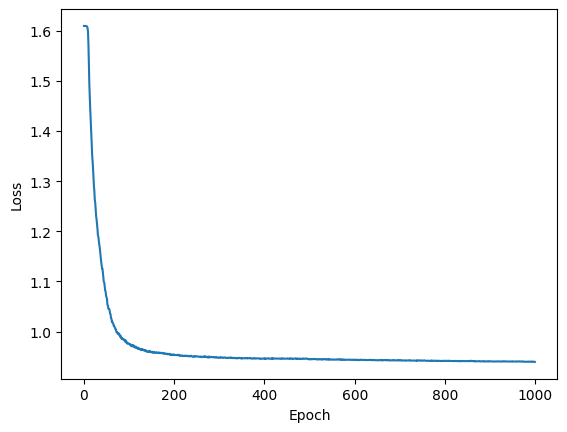

Test accuracy: 466.0683870967742
Accuracy: 0.47139784946236557
Precision: 0.4831575955307025
Recall: 0.47050960014907106
F1-score: 0.47313406203560626


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.57      0.58       495
           1       0.42      0.40      0.41       472
           2       0.45      0.33      0.38       449
           3       0.32      0.44      0.37       463
           4       0.63      0.61      0.62       446

    accuracy                           0.47      2325
   macro avg       0.48      0.47      0.47      2325
weighted avg       0.48      0.47      0.47      2325

                    0           1           2           3           4  \
precision    0.598726    0.416851    0.446429    0.319749    0.634033   
recall       0.569697    0.398305    0.334076    0.440605    0.609865   
f1-score     0.583851    0.407367    0.382166    0.370572    0.621714   
support    495.000000  472.000000  449.0000

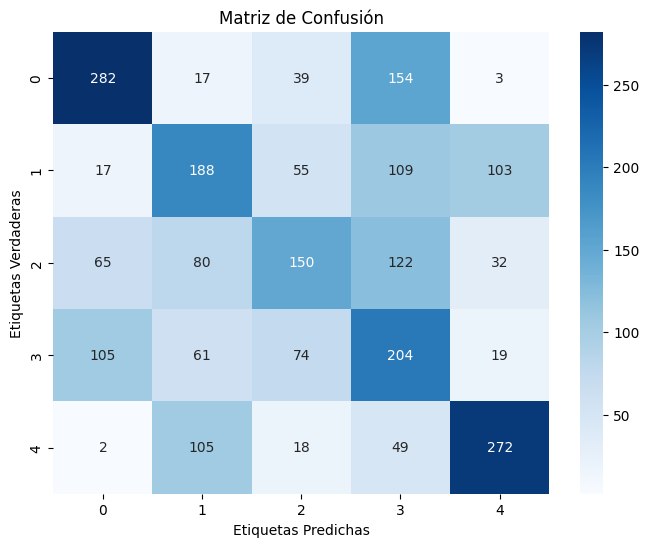

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_1000_1e-05_0.1/resultados_1000_1e-05_0.1.json


In [14]:
epocas = [700,1000]
lr = [0.0001,0.00001]
test_label = [0.3,0.2,0.1]
#RNN_model(X, labels ,0.3,10,0.001)

for test in test_label:
    for epoca in epocas:
        for rang in lr:
                print(f"Procesando red con {epoca} epocas y {rang} de factor de aprendizaje y conjunto de entrenamiento {1-test}")
                RNN_model(X, labels ,test,epoca,rang)